##### Copyright 2018 The TensorFlow Authors.


In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Image captioning with visual attention

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/text/image_captioning">
    <img src="https://www.tensorflow.org/images/tf_logo_32px.png" />
    View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/text/image_captioning.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/text/image_captioning.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/text/image_captioning.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

Given an image like the example below, your goal is to generate a caption such as "a surfer riding on a wave".

![Man Surfing](https://tensorflow.org/images/surf.jpg)

*[Image Source](https://commons.wikimedia.org/wiki/Surfing#/media/File:Surfing_in_Hawaii.jpg); License: Public Domain*

To accomplish this, you'll use an attention-based model, which enables us to see what parts of the image the model focuses on as it generates a caption.

![Prediction](https://tensorflow.org/images/imcap_prediction.png)

The model architecture is similar to [Show, Attend and Tell: Neural Image Caption Generation with Visual Attention](https://arxiv.org/abs/1502.03044).

This notebook is an end-to-end example. When you run the notebook, it downloads the [MS-COCO](http://cocodataset.org/#home) dataset, preprocesses and caches a subset of images using Inception V3, trains an encoder-decoder model, and generates captions on new images using the trained model.

In this example, you will train a model on a relatively small amount of data—the first 30,000 captions  for about 20,000 images (because there are multiple captions per image in the dataset).

In [2]:
import tensorflow as tf

# You'll generate plots of attention in order to see which parts of an image
# your model focuses on during captioning
import matplotlib.pyplot as plt

import collections
import random
import numpy as np
import os
import time
import json
from PIL import Image

## Download and prepare the MS-COCO dataset

You will use the [MS-COCO dataset](http://cocodataset.org/#home) to train your model. The dataset contains over 82,000 images, each of which has at least 5 different caption annotations. The code below downloads and extracts the dataset automatically.

**Caution: large download ahead**. You'll use the training set, which is a 13GB file.

In [3]:
# Download caption annotation files
annotation_folder = '/annotations/'
if not os.path.exists(os.path.abspath('.') + annotation_folder):
  annotation_zip = tf.keras.utils.get_file('captions.zip',
                                           cache_subdir=os.path.abspath('.'),
                                           origin='http://images.cocodataset.org/annotations/annotations_trainval2014.zip',
                                           extract=True)
  annotation_file = os.path.dirname(annotation_zip)+'/annotations/captions_train2014.json'
  os.remove(annotation_zip)

# Download image files
image_folder = '/train2014/'
if not os.path.exists(os.path.abspath('.') + image_folder):
  image_zip = tf.keras.utils.get_file('train2014.zip',
                                      cache_subdir=os.path.abspath('.'),
                                      origin='http://images.cocodataset.org/zips/train2014.zip',
                                      extract=True)
  PATH = os.path.dirname(image_zip) + image_folder
  os.remove(image_zip)
else:
  PATH = os.path.abspath('.') + image_folder

     8192/252872794 [..............................] - ETA: 2s

    16384/252872794 [..............................] - ETA: 45:49

    49152/252872794 [..............................] - ETA: 30:34

   106496/252872794 [..............................] - ETA: 19:47

   155648/252872794 [..............................] - ETA: 15:05

   204800/252872794 [..............................] - ETA: 13:57

   327680/252872794 [..............................] - ETA: 9:27 

   417792/252872794 [..............................] - ETA: 8:38

   655360/252872794 [..............................] - ETA: 5:51

   843776/252872794 [..............................] - ETA: 5:09

  1327104/252872794 [..............................] - ETA: 3:27

  1703936/252872794 [..............................] - ETA: 2:59

  2605056/252872794 [..............................] - ETA: 2:02

  3416064/252872794 [..............................] - ETA: 1:41

  5210112/252872794 [..............................] - ETA: 1:08

  6561792/252872794 [..............................] - ETA: 59s 

  8331264/252872794 [..............................] - ETA: 47s

  9699328/252872794 [>.............................] - ETA: 43s

 11468800/252872794 [>.............................] - ETA: 38s

 12836864/252872794 [>.............................] - ETA: 36s

 14606336/252872794 [>.............................] - ETA: 32s

 15974400/252872794 [>.............................] - ETA: 31s

 17743872/252872794 [=>............................] - ETA: 28s

 19054592/252872794 [=>............................] - ETA: 28s

 20873216/252872794 [=>............................] - ETA: 26s

 22200320/252872794 [=>............................] - ETA: 25s

 24002560/252872794 [=>............................] - ETA: 24s

 25337856/252872794 [==>...........................] - ETA: 23s

 27140096/252872794 [==>...........................] - ETA: 22s

 28475392/252872794 [==>...........................] - ETA: 22s

 30269440/252872794 [==>...........................] - ETA: 21s

 31612928/252872794 [==>...........................] - ETA: 21s

 33406976/252872794 [==>...........................] - ETA: 20s

 34750464/252872794 [===>..........................] - ETA: 19s

 36544512/252872794 [===>..........................] - ETA: 19s

 37871616/252872794 [===>..........................] - ETA: 19s

 39682048/252872794 [===>..........................] - ETA: 18s

 41017344/252872794 [===>..........................] - ETA: 18s

 42819584/252872794 [====>.........................] - ETA: 17s

 44146688/252872794 [====>.........................] - ETA: 17s

 45907968/252872794 [====>.........................] - ETA: 17s

 47284224/252872794 [====>.........................] - ETA: 16s

 49037312/252872794 [====>.........................] - ETA: 16s

 50413568/252872794 [====>.........................] - ETA: 16s

 52174848/252872794 [=====>........................] - ETA: 15s

 53551104/252872794 [=====>........................] - ETA: 15s

 55304192/252872794 [=====>........................] - ETA: 15s

 56688640/252872794 [=====>........................] - ETA: 15s

 56696832/252872794 [=====>........................] - ETA: 15s

 58368000/252872794 [=====>........................] - ETA: 14s

 59834368/252872794 [======>.......................] - ETA: 14s

 59842560/252872794 [======>.......................] - ETA: 14s

 62947328/252872794 [======>.......................] - ETA: 14s

 62980096/252872794 [======>.......................] - ETA: 14s

 64643072/252872794 [======>.......................] - ETA: 14s

 66101248/252872794 [======>.......................] - ETA: 14s

 67780608/252872794 [=======>......................] - ETA: 13s

 69238784/252872794 [=======>......................] - ETA: 13s

 69246976/252872794 [=======>......................] - ETA: 13s

 72343552/252872794 [=======>......................] - ETA: 13s

 72384512/252872794 [=======>......................] - ETA: 13s

 74014720/252872794 [=======>......................] - ETA: 12s

 75505664/252872794 [=======>......................] - ETA: 12s

 75522048/252872794 [=======>......................] - ETA: 12s

 77127680/252872794 [========>.....................] - ETA: 12s

 78651392/252872794 [========>.....................] - ETA: 12s

 78659584/252872794 [========>.....................] - ETA: 12s

 80224256/252872794 [========>.....................] - ETA: 12s

 81797120/252872794 [========>.....................] - ETA: 12s

 81813504/252872794 [========>.....................] - ETA: 12s

 84779008/252872794 [=========>....................] - ETA: 11s

 84942848/252872794 [=========>....................] - ETA: 11s

 86491136/252872794 [=========>....................] - ETA: 11s

 87949312/252872794 [=========>....................] - ETA: 11s

 88088576/252872794 [=========>....................] - ETA: 11s

 91054080/252872794 [=========>....................] - ETA: 11s

 91127808/252872794 [=========>....................] - ETA: 11s

 92741632/252872794 [==========>...................] - ETA: 11s

 94216192/252872794 [==========>...................] - ETA: 11s

 94289920/252872794 [==========>...................] - ETA: 11s

 97329152/252872794 [==========>...................] - ETA: 10s

 97386496/252872794 [==========>...................] - ETA: 10s

 98992128/252872794 [==========>...................] - ETA: 10s

100483072/252872794 [==========>...................] - ETA: 10s

100540416/252872794 [==========>...................] - ETA: 10s

103604224/252872794 [===========>..................] - ETA: 10s

103636992/252872794 [===========>..................] - ETA: 10s

105250816/252872794 [===========>..................] - ETA: 10s

106758144/252872794 [===========>..................] - ETA: 9s 

106790912/252872794 [===========>..................] - ETA: 10s

109879296/252872794 [============>.................] - ETA: 9s 

109912064/252872794 [============>.................] - ETA: 9s

111525888/252872794 [============>.................] - ETA: 9s

113033216/252872794 [============>.................] - ETA: 9s

113065984/252872794 [============>.................] - ETA: 9s

116137984/252872794 [============>.................] - ETA: 9s

116178944/252872794 [============>.................] - ETA: 9s

117784576/252872794 [============>.................] - ETA: 9s

119291904/252872794 [=============>................] - ETA: 8s

119332864/252872794 [=============>................] - ETA: 8s

122413056/252872794 [=============>................] - ETA: 8s

122445824/252872794 [=============>................] - ETA: 8s

124051456/252872794 [=============>................] - ETA: 8s

125566976/252872794 [=============>................] - ETA: 8s

125591552/252872794 [=============>................] - ETA: 8s

128688128/252872794 [==============>...............] - ETA: 8s

128712704/252872794 [==============>...............] - ETA: 8s

130318336/252872794 [==============>...............] - ETA: 8s

131842048/252872794 [==============>...............] - ETA: 7s

131858432/252872794 [==============>...............] - ETA: 8s

134963200/252872794 [===============>..............] - ETA: 7s

134987776/252872794 [===============>..............] - ETA: 7s

136577024/252872794 [===============>..............] - ETA: 7s

138117120/252872794 [===============>..............] - ETA: 7s

138133504/252872794 [===============>..............] - ETA: 7s

141238272/252872794 [===============>..............] - ETA: 7s

141262848/252872794 [===============>..............] - ETA: 7s

142852096/252872794 [===============>..............] - ETA: 7s

144384000/252872794 [================>.............] - ETA: 7s

144408576/252872794 [================>.............] - ETA: 7s

147513344/252872794 [================>.............] - ETA: 6s

147529728/252872794 [================>.............] - ETA: 6s

149118976/252872794 [================>.............] - ETA: 6s

150667264/252872794 [================>.............] - ETA: 6s

152256512/252872794 [=================>............] - ETA: 6s

153796608/252872794 [=================>............] - ETA: 6s

153812992/252872794 [=================>............] - ETA: 6s

156917760/252872794 [=================>............] - ETA: 6s

156942336/252872794 [=================>............] - ETA: 6s

158531584/252872794 [=================>............] - ETA: 6s

160071680/252872794 [=================>............] - ETA: 5s

160088064/252872794 [=================>............] - ETA: 6s

163184640/252872794 [==================>...........] - ETA: 5s

163217408/252872794 [==================>...........] - ETA: 5s

164798464/252872794 [==================>...........] - ETA: 5s

166330368/252872794 [==================>...........] - ETA: 5s

167936000/252872794 [==================>...........] - ETA: 5s

169476096/252872794 [===================>..........] - ETA: 5s

171073536/252872794 [===================>..........] - ETA: 5s

172613632/252872794 [===================>..........] - ETA: 5s

174194688/252872794 [===================>..........] - ETA: 5s

175751168/252872794 [===================>..........] - ETA: 4s

177324032/252872794 [====================>.........] - ETA: 4s

178896896/252872794 [====================>.........] - ETA: 4s

182026240/252872794 [====================>.........] - ETA: 4s

182034432/252872794 [====================>.........] - ETA: 4s

183590912/252872794 [====================>.........] - ETA: 4s

185171968/252872794 [====================>.........] - ETA: 4s

186720256/252872794 [=====================>........] - ETA: 4s

188309504/252872794 [=====================>........] - ETA: 4s

188317696/252872794 [=====================>........] - ETA: 4s

191356928/252872794 [=====================>........] - ETA: 3s

191455232/252872794 [=====================>........] - ETA: 3s

194486272/252872794 [======================>.......] - ETA: 3s

194592768/252872794 [======================>.......] - ETA: 3s

197623808/252872794 [======================>.......] - ETA: 3s

197681152/252872794 [======================>.......] - ETA: 3s

200761344/252872794 [======================>.......] - ETA: 3s

200802304/252872794 [======================>.......] - ETA: 3s

203898880/252872794 [=======================>......] - ETA: 3s

203948032/252872794 [=======================>......] - ETA: 3s

207036416/252872794 [=======================>......] - ETA: 2s

207077376/252872794 [=======================>......] - ETA: 2s

210182144/252872794 [=======================>......] - ETA: 2s

210214912/252872794 [=======================>......] - ETA: 2s

213319680/252872794 [========================>.....] - ETA: 2s

213352448/252872794 [========================>.....] - ETA: 2s

216465408/252872794 [========================>.....] - ETA: 2s

216489984/252872794 [========================>.....] - ETA: 2s

219602944/252872794 [=========================>....] - ETA: 2s

219619328/252872794 [=========================>....] - ETA: 2s

222748672/252872794 [=========================>....] - ETA: 1s

222756864/252872794 [=========================>....] - ETA: 1s

225730560/252872794 [=========================>....] - ETA: 1s

225902592/252872794 [=========================>....] - ETA: 1s

228868096/252872794 [==========================>...] - ETA: 1s

229048320/252872794 [==========================>...] - ETA: 1s

232005632/252872794 [==========================>...] - ETA: 1s

232079360/252872794 [==========================>...] - ETA: 1s

235143168/252872794 [==========================>...] - ETA: 1s

235184128/252872794 [==========================>...] - ETA: 1s

238280704/252872794 [===========================>..] - ETA: 0s

238313472/252872794 [===========================>..] - ETA: 0s

241426432/252872794 [===========================>..] - ETA: 0s

241442816/252872794 [===========================>..] - ETA: 0s

244555776/252872794 [============================>.] - ETA: 0s

244588544/252872794 [============================>.] - ETA: 0s

247676928/252872794 [============================>.] - ETA: 0s

247726080/252872794 [============================>.] - ETA: 0s

250814464/252872794 [============================>.] - ETA: 0s

250855424/252872794 [============================>.] - ETA: 0s

252878848/252872794 [==============================] - 16s 0us/step


       8192/13510573713 [..............................] - ETA: 1:57

      16384/13510573713 [..............................] - ETA: 41:31:11

      49152/13510573713 [..............................] - ETA: 27:41:43

     106496/13510573713 [..............................] - ETA: 19:11:07

     212992/13510573713 [..............................] - ETA: 12:47:36

     442368/13510573713 [..............................] - ETA: 7:41:56 

     892928/13510573713 [..............................] - ETA: 4:34:41

    1794048/13510573713 [..............................] - ETA: 2:39:28

    3596288/13510573713 [..............................] - ETA: 1:30:54

    6307840/13510573713 [..............................] - ETA: 54:17  

    6733824/13510573713 [..............................] - ETA: 54:37

    8863744/13510573713 [..............................] - ETA: 43:14

    9535488/13510573713 [..............................] - ETA: 42:50

   11165696/13510573713 [..............................] - ETA: 37:58

   12140544/13510573713 [..............................] - ETA: 37:00

   14229504/13510573713 [..............................] - ETA: 32:39

   14483456/13510573713 [..............................] - ETA: 33:50

   17301504/13510573713 [..............................] - ETA: 29:12

   17424384/13510573713 [..............................] - ETA: 30:27

   20365312/13510573713 [..............................] - ETA: 26:49

   20463616/13510573713 [..............................] - ETA: 27:55

   23306240/13510573713 [..............................] - ETA: 25:01

   23527424/13510573713 [..............................] - ETA: 26:01

   25796608/13510573713 [..............................] - ETA: 24:11

   26648576/13510573713 [..............................] - ETA: 24:30

   28606464/13510573713 [..............................] - ETA: 23:14

   29794304/13510573713 [..............................] - ETA: 23:16

   31637504/13510573713 [..............................] - ETA: 22:17

   32710656/13510573713 [..............................] - ETA: 22:26

   34742272/13510573713 [..............................] - ETA: 21:28

   35594240/13510573713 [..............................] - ETA: 21:46

   37814272/13510573713 [..............................] - ETA: 20:48

   38617088/13510573713 [..............................] - ETA: 21:06

   40919040/13510573713 [..............................] - ETA: 20:12

   41639936/13510573713 [..............................] - ETA: 20:33

   44007424/13510573713 [..............................] - ETA: 19:43

   44720128/13510573713 [..............................] - ETA: 20:02

   47013888/13510573713 [..............................] - ETA: 19:19

   47865856/13510573713 [..............................] - ETA: 19:34

   50110464/13510573713 [..............................] - ETA: 18:56

   50978816/13510573713 [..............................] - ETA: 19:10

   53215232/13510573713 [..............................] - ETA: 18:35

   54018048/13510573713 [..............................] - ETA: 18:50

   56147968/13510573713 [..............................] - ETA: 18:20

   57163776/13510573713 [..............................] - ETA: 18:31

   59154432/13510573713 [..............................] - ETA: 18:05

   60301312/13510573713 [..............................] - ETA: 18:13

   62218240/13510573713 [..............................] - ETA: 17:51

   63381504/13510573713 [..............................] - ETA: 17:58

   65290240/13510573713 [..............................] - ETA: 17:37

   66461696/13510573713 [..............................] - ETA: 17:45

   68288512/13510573713 [..............................] - ETA: 17:27

   69484544/13510573713 [..............................] - ETA: 17:33

   71360512/13510573713 [..............................] - ETA: 17:15

   72556544/13510573713 [..............................] - ETA: 17:22

   74358784/13510573713 [..............................] - ETA: 17:06

   75481088/13510573713 [..............................] - ETA: 17:14

   77299712/13510573713 [..............................] - ETA: 16:59

   78569472/13510573713 [..............................] - ETA: 17:04

   80371712/13510573713 [..............................] - ETA: 16:50

   81715200/13510573713 [..............................] - ETA: 16:56

   83566592/13510573713 [..............................] - ETA: 16:42

   84779008/13510573713 [..............................] - ETA: 16:46

   86245376/13510573713 [..............................] - ETA: 16:37

   87556096/13510573713 [..............................] - ETA: 16:42

   89300992/13510573713 [..............................] - ETA: 16:30

   90652672/13510573713 [..............................] - ETA: 16:34

   92315648/13510573713 [..............................] - ETA: 16:23

   93798400/13510573713 [..............................] - ETA: 16:28

   95707136/13510573713 [..............................] - ETA: 16:16

   96886784/13510573713 [..............................] - ETA: 16:20

   98385920/13510573713 [..............................] - ETA: 16:12

   99786752/13510573713 [..............................] - ETA: 16:16

  101457920/13510573713 [..............................] - ETA: 16:06

  102834176/13510573713 [..............................] - ETA: 16:10

  104456192/13510573713 [..............................] - ETA: 16:02

  105914368/13510573713 [..............................] - ETA: 16:05

  107503616/13510573713 [..............................] - ETA: 15:57

  109043712/13510573713 [..............................] - ETA: 15:59

  110592000/13510573713 [..............................] - ETA: 15:52

  112099328/13510573713 [..............................] - ETA: 15:54

  113664000/13510573713 [..............................] - ETA: 15:47

  115163136/13510573713 [..............................] - ETA: 15:50

  116727808/13510573713 [..............................] - ETA: 15:43

  118235136/13510573713 [..............................] - ETA: 15:46

  119791616/13510573713 [..............................] - ETA: 15:39

  121307136/13510573713 [..............................] - ETA: 15:41

  122798080/13510573713 [..............................] - ETA: 15:35

  124370944/13510573713 [..............................] - ETA: 15:38

  125870080/13510573713 [..............................] - ETA: 15:32

  127442944/13510573713 [..............................] - ETA: 15:34

  128868352/13510573713 [..............................] - ETA: 15:29

  130580480/13510573713 [..............................] - ETA: 15:30

  131874816/13510573713 [..............................] - ETA: 15:26

  133726208/13510573713 [..............................] - ETA: 15:27

  135454720/13510573713 [..............................] - ETA: 15:21

  136757248/13510573713 [..............................] - ETA: 15:23

  137945088/13510573713 [..............................] - ETA: 15:20

  139829248/13510573713 [..............................] - ETA: 15:20

  141008896/13510573713 [..............................] - ETA: 15:17

  142950400/13510573713 [..............................] - ETA: 15:16

  144105472/13510573713 [..............................] - ETA: 15:14

  146063360/13510573713 [..............................] - ETA: 15:13

  147070976/13510573713 [..............................] - ETA: 15:11

  149209088/13510573713 [..............................] - ETA: 15:10

  150175744/13510573713 [..............................] - ETA: 15:09

  152305664/13510573713 [..............................] - ETA: 15:07

  153239552/13510573713 [..............................] - ETA: 15:06

  155426816/13510573713 [..............................] - ETA: 15:04

  156278784/13510573713 [..............................] - ETA: 15:04

  158539776/13510573713 [..............................] - ETA: 15:02

  159350784/13510573713 [..............................] - ETA: 15:01

  161685504/13510573713 [..............................] - ETA: 14:59

  162414592/13510573713 [..............................] - ETA: 14:59

  164790272/13510573713 [..............................] - ETA: 14:57

  165486592/13510573713 [..............................] - ETA: 14:57

  167673856/13510573713 [..............................] - ETA: 14:55

  168550400/13510573713 [..............................] - ETA: 14:55

  170786816/13510573713 [..............................] - ETA: 14:53

  171556864/13510573713 [..............................] - ETA: 14:53

  173916160/13510573713 [..............................] - ETA: 14:52

  175136768/13510573713 [..............................] - ETA: 14:50

  177053696/13510573713 [..............................] - ETA: 14:48

  177692672/13510573713 [..............................] - ETA: 14:49

  180199424/13510573713 [..............................] - ETA: 14:47

  181141504/13510573713 [..............................] - ETA: 14:46

  183345152/13510573713 [..............................] - ETA: 14:45

  184205312/13510573713 [..............................] - ETA: 14:45

  186417152/13510573713 [..............................] - ETA: 14:42

  186892288/13510573713 [..............................] - ETA: 14:43

  188964864/13510573713 [..............................] - ETA: 14:43

  189956096/13510573713 [..............................] - ETA: 14:42

  192086016/13510573713 [..............................] - ETA: 14:41

  193028096/13510573713 [..............................] - ETA: 14:40

  195215360/13510573713 [..............................] - ETA: 14:39

  196091904/13510573713 [..............................] - ETA: 14:38

  198311936/13510573713 [..............................] - ETA: 14:37

  199098368/13510573713 [..............................] - ETA: 14:37

  201441280/13510573713 [..............................] - ETA: 14:35

  202194944/13510573713 [..............................] - ETA: 14:35

  204554240/13510573713 [..............................] - ETA: 14:34

  205242368/13510573713 [..............................] - ETA: 14:34

  207536128/13510573713 [..............................] - ETA: 14:32

  208355328/13510573713 [..............................] - ETA: 14:32

  210624512/13510573713 [..............................] - ETA: 14:31

  211427328/13510573713 [..............................] - ETA: 14:31

  213745664/13510573713 [..............................] - ETA: 14:29

  214499328/13510573713 [..............................] - ETA: 14:30

  216834048/13510573713 [..............................] - ETA: 14:28

  217563136/13510573713 [..............................] - ETA: 14:28

  219930624/13510573713 [..............................] - ETA: 14:26

  220692480/13510573713 [..............................] - ETA: 14:27

  222986240/13510573713 [..............................] - ETA: 14:25

  223764480/13510573713 [..............................] - ETA: 14:25

  226131968/13510573713 [..............................] - ETA: 14:24

  226828288/13510573713 [..............................] - ETA: 14:24

  229179392/13510573713 [..............................] - ETA: 14:22

  229892096/13510573713 [..............................] - ETA: 14:23

  232308736/13510573713 [..............................] - ETA: 14:21

  232964096/13510573713 [..............................] - ETA: 14:22

  235413504/13510573713 [..............................] - ETA: 14:20

  236027904/13510573713 [..............................] - ETA: 14:20

  238559232/13510573713 [..............................] - ETA: 14:18

  239099904/13510573713 [..............................] - ETA: 14:19

  241623040/13510573713 [..............................] - ETA: 14:17

  242163712/13510573713 [..............................] - ETA: 14:18

  244768768/13510573713 [..............................] - ETA: 14:16

  245227520/13510573713 [..............................] - ETA: 14:17

  247914496/13510573713 [..............................] - ETA: 14:15

  249110528/13510573713 [..............................] - ETA: 14:14

  251060224/13510573713 [..............................] - ETA: 14:14

  253214720/13510573713 [..............................] - ETA: 14:10

  254132224/13510573713 [..............................] - ETA: 14:12

  254369792/13510573713 [..............................] - ETA: 14:14

  257253376/13510573713 [..............................] - ETA: 14:11

  257433600/13510573713 [..............................] - ETA: 14:13

  260087808/13510573713 [..............................] - ETA: 14:11

  260521984/13510573713 [..............................] - ETA: 14:12

  263225344/13510573713 [..............................] - ETA: 14:09

  263634944/13510573713 [..............................] - ETA: 14:11

  266338304/13510573713 [..............................] - ETA: 14:08

  266698752/13510573713 [..............................] - ETA: 14:10

  269426688/13510573713 [..............................] - ETA: 14:07

  269770752/13510573713 [..............................] - ETA: 14:09

  272515072/13510573713 [..............................] - ETA: 14:06

  272769024/13510573713 [..............................] - ETA: 14:08

  275628032/13510573713 [..............................] - ETA: 14:05

  275841024/13510573713 [..............................] - ETA: 14:07

  278667264/13510573713 [..............................] - ETA: 14:04

  278904832/13510573713 [..............................] - ETA: 14:06

  281722880/13510573713 [..............................] - ETA: 14:04

  282001408/13510573713 [..............................] - ETA: 14:05

  284827648/13510573713 [..............................] - ETA: 14:03

  285122560/13510573713 [..............................] - ETA: 14:04

  287932416/13510573713 [..............................] - ETA: 14:02

  288235520/13510573713 [..............................] - ETA: 14:03

  291037184/13510573713 [..............................] - ETA: 14:01

  291299328/13510573713 [..............................] - ETA: 14:03

  294150144/13510573713 [..............................] - ETA: 14:00

  294371328/13510573713 [..............................] - ETA: 14:02

  297230336/13510573713 [..............................] - ETA: 13:59

  297435136/13510573713 [..............................] - ETA: 14:01

  300335104/13510573713 [..............................] - ETA: 13:58

  300572672/13510573713 [..............................] - ETA: 14:00

  303431680/13510573713 [..............................] - ETA: 13:57

  303636480/13510573713 [..............................] - ETA: 13:59

  306577408/13510573713 [..............................] - ETA: 13:57

  306765824/13510573713 [..............................] - ETA: 13:59

  309673984/13510573713 [..............................] - ETA: 13:55

  309837824/13510573713 [..............................] - ETA: 13:57

  312811520/13510573713 [..............................] - ETA: 13:55

  312901632/13510573713 [..............................] - ETA: 13:57

  315949056/13510573713 [..............................] - ETA: 13:54

  316030976/13510573713 [..............................] - ETA: 13:56

  319086592/13510573713 [..............................] - ETA: 13:53

  319127552/13510573713 [..............................] - ETA: 13:55

  322142208/13510573713 [..............................] - ETA: 13:52

  322248704/13510573713 [..............................] - ETA: 13:54

  325279744/13510573713 [..............................] - ETA: 13:51

  325386240/13510573713 [..............................] - ETA: 13:53

  328384512/13510573713 [..............................] - ETA: 13:50

  328491008/13510573713 [..............................] - ETA: 13:52

  331489280/13510573713 [..............................] - ETA: 13:50

  331612160/13510573713 [..............................] - ETA: 13:52

  334553088/13510573713 [..............................] - ETA: 13:49

  334733312/13510573713 [..............................] - ETA: 13:51

  337551360/13510573713 [..............................] - ETA: 13:49

  337854464/13510573713 [..............................] - ETA: 13:50

  340672512/13510573713 [..............................] - ETA: 13:48

  340951040/13510573713 [..............................] - ETA: 13:49

  343818240/13510573713 [..............................] - ETA: 13:47

  344047616/13510573713 [..............................] - ETA: 13:49

  346923008/13510573713 [..............................] - ETA: 13:46

  347152384/13510573713 [..............................] - ETA: 13:48

  350011392/13510573713 [..............................] - ETA: 13:46

  350158848/13510573713 [..............................] - ETA: 13:47

  353157120/13510573713 [..............................] - ETA: 13:45

  353304576/13510573713 [..............................] - ETA: 13:47

  356302848/13510573713 [..............................] - ETA: 13:44

  356433920/13510573713 [..............................] - ETA: 13:46

  359301120/13510573713 [..............................] - ETA: 13:44

  359546880/13510573713 [..............................] - ETA: 13:45

  362446848/13510573713 [..............................] - ETA: 13:43

  362643456/13510573713 [..............................] - ETA: 13:45

  365551616/13510573713 [..............................] - ETA: 13:44

  368648192/13510573713 [..............................] - ETA: 13:42

  368812032/13510573713 [..............................] - ETA: 13:44

  371769344/13510573713 [..............................] - ETA: 13:41

  371884032/13510573713 [..............................] - ETA: 13:43

  374898688/13510573713 [..............................] - ETA: 13:41

  375013376/13510573713 [..............................] - ETA: 13:42

  378044416/13510573713 [..............................] - ETA: 13:41

  381181952/13510573713 [..............................] - ETA: 13:39

  381239296/13510573713 [..............................] - ETA: 13:41

  384278528/13510573713 [..............................] - ETA: 13:39

  384344064/13510573713 [..............................] - ETA: 13:40

  387350528/13510573713 [..............................] - ETA: 13:38

  387481600/13510573713 [..............................] - ETA: 13:40

  390332416/13510573713 [..............................] - ETA: 13:38

  390627328/13510573713 [..............................] - ETA: 13:39

  393445376/13510573713 [..............................] - ETA: 13:37

  393732096/13510573713 [..............................] - ETA: 13:38

  396566528/13510573713 [..............................] - ETA: 13:37

  396804096/13510573713 [..............................] - ETA: 13:38

  399695872/13510573713 [..............................] - ETA: 13:36

  399867904/13510573713 [..............................] - ETA: 13:37

  402776064/13510573713 [..............................] - ETA: 13:35

  402964480/13510573713 [..............................] - ETA: 13:37

  405897216/13510573713 [..............................] - ETA: 13:35

  406069248/13510573713 [..............................] - ETA: 13:36

  409034752/13510573713 [..............................] - ETA: 13:34

  409182208/13510573713 [..............................] - ETA: 13:36

  412114944/13510573713 [..............................] - ETA: 13:34

  412262400/13510573713 [..............................] - ETA: 13:35

  415178752/13510573713 [..............................] - ETA: 13:33

  415350784/13510573713 [..............................] - ETA: 13:35

  418324480/13510573713 [..............................] - ETA: 13:33

  418463744/13510573713 [..............................] - ETA: 13:34

  421093376/13510573713 [..............................] - ETA: 13:33

  421593088/13510573713 [..............................] - ETA: 13:33

  424132608/13510573713 [..............................] - ETA: 13:32

  424722432/13510573713 [..............................] - ETA: 13:33

  427024384/13510573713 [..............................] - ETA: 13:32

  427810816/13510573713 [..............................] - ETA: 13:32

  430145536/13510573713 [..............................] - ETA: 13:32

  430923776/13510573713 [..............................] - ETA: 13:32

  433291264/13510573713 [..............................] - ETA: 13:31

  433995776/13510573713 [..............................] - ETA: 13:31

  436387840/13510573713 [..............................] - ETA: 13:30

  437084160/13510573713 [..............................] - ETA: 13:31

  439508992/13510573713 [..............................] - ETA: 13:30

  440188928/13510573713 [..............................] - ETA: 13:30

  442654720/13510573713 [..............................] - ETA: 13:29

  443195392/13510573713 [..............................] - ETA: 13:30

  445759488/13510573713 [..............................] - ETA: 13:29

  446259200/13510573713 [..............................] - ETA: 13:30

  448815104/13510573713 [..............................] - ETA: 13:28

  449265664/13510573713 [..............................] - ETA: 13:29

  451895296/13510573713 [>.............................] - ETA: 13:28

  452329472/13510573713 [>.............................] - ETA: 13:29

  454975488/13510573713 [>.............................] - ETA: 13:27

  455458816/13510573713 [>.............................] - ETA: 13:28

  458022912/13510573713 [>.............................] - ETA: 13:27

  458530816/13510573713 [>.............................] - ETA: 13:28

  460996608/13510573713 [>.............................] - ETA: 13:27

  461594624/13510573713 [>.............................] - ETA: 13:27

  464019456/13510573713 [>.............................] - ETA: 13:26

  464592896/13510573713 [>.............................] - ETA: 13:27

  467132416/13510573713 [>.............................] - ETA: 13:26

  467664896/13510573713 [>.............................] - ETA: 13:26

  470196224/13510573713 [>.............................] - ETA: 13:26

  470753280/13510573713 [>.............................] - ETA: 13:26

  473268224/13510573713 [>.............................] - ETA: 13:25

  473866240/13510573713 [>.............................] - ETA: 13:25

  476381184/13510573713 [>.............................] - ETA: 13:25

  476930048/13510573713 [>.............................] - ETA: 13:25

  479444992/13510573713 [>.............................] - ETA: 13:24

  480002048/13510573713 [>.............................] - ETA: 13:25

  482500608/13510573713 [>.............................] - ETA: 13:24

  483065856/13510573713 [>.............................] - ETA: 13:24

  485588992/13510573713 [>.............................] - ETA: 13:23

  486137856/13510573713 [>.............................] - ETA: 13:24

  488652800/13510573713 [>.............................] - ETA: 13:23

  489201664/13510573713 [>.............................] - ETA: 13:23

  491749376/13510573713 [>.............................] - ETA: 13:23

  492224512/13510573713 [>.............................] - ETA: 13:23

  494747648/13510573713 [>.............................] - ETA: 13:22

  495271936/13510573713 [>.............................] - ETA: 13:23

  497852416/13510573713 [>.............................] - ETA: 13:22

  498335744/13510573713 [>.............................] - ETA: 13:22

  500998144/13510573713 [>.............................] - ETA: 13:21

  501407744/13510573713 [>.............................] - ETA: 13:22

  504061952/13510573713 [>.............................] - ETA: 13:21

  504496128/13510573713 [>.............................] - ETA: 13:22

  507183104/13510573713 [>.............................] - ETA: 13:20

  507600896/13510573713 [>.............................] - ETA: 13:21

  510328832/13510573713 [>.............................] - ETA: 13:20

  510672896/13510573713 [>.............................] - ETA: 13:21

  513417216/13510573713 [>.............................] - ETA: 13:20

  513802240/13510573713 [>.............................] - ETA: 13:20

  516538368/13510573713 [>.............................] - ETA: 13:19

  516808704/13510573713 [>.............................] - ETA: 13:20

  519675904/13510573713 [>.............................] - ETA: 13:19

  519872512/13510573713 [>.............................] - ETA: 13:20

  522780672/13510573713 [>.............................] - ETA: 13:18

  522944512/13510573713 [>.............................] - ETA: 13:19

  525877248/13510573713 [>.............................] - ETA: 13:18

  526073856/13510573713 [>.............................] - ETA: 13:19

  528973824/13510573713 [>.............................] - ETA: 13:17

  529195008/13510573713 [>.............................] - ETA: 13:18

  532062208/13510573713 [>.............................] - ETA: 13:17

  532267008/13510573713 [>.............................] - ETA: 13:18

  535199744/13510573713 [>.............................] - ETA: 13:17

  535404544/13510573713 [>.............................] - ETA: 13:17

  538329088/13510573713 [>.............................] - ETA: 13:16

  538468352/13510573713 [>.............................] - ETA: 13:17

  541409280/13510573713 [>.............................] - ETA: 13:16

  541564928/13510573713 [>.............................] - ETA: 13:17

  544530432/13510573713 [>.............................] - ETA: 13:15

  544669696/13510573713 [>.............................] - ETA: 13:17

  547659776/13510573713 [>.............................] - ETA: 13:15

  547799040/13510573713 [>.............................] - ETA: 13:16

  550780928/13510573713 [>.............................] - ETA: 13:14

  550928384/13510573713 [>.............................] - ETA: 13:15

  553836544/13510573713 [>.............................] - ETA: 13:14

  554024960/13510573713 [>.............................] - ETA: 13:15

  556916736/13510573713 [>.............................] - ETA: 13:14

  557129728/13510573713 [>.............................] - ETA: 13:15

  559988736/13510573713 [>.............................] - ETA: 13:13

  560250880/13510573713 [>.............................] - ETA: 13:14

  563085312/13510573713 [>.............................] - ETA: 13:13

  563322880/13510573713 [>.............................] - ETA: 13:14

  566108160/13510573713 [>.............................] - ETA: 13:13

  566394880/13510573713 [>.............................] - ETA: 13:14

  569212928/13510573713 [>.............................] - ETA: 13:12

  569458688/13510573713 [>.............................] - ETA: 13:13

  572317696/13510573713 [>.............................] - ETA: 13:12

  572588032/13510573713 [>.............................] - ETA: 13:13

  575397888/13510573713 [>.............................] - ETA: 13:12

  575660032/13510573713 [>.............................] - ETA: 13:12

  578535424/13510573713 [>.............................] - ETA: 13:11

  578723840/13510573713 [>.............................] - ETA: 13:12

  581664768/13510573713 [>.............................] - ETA: 13:11

  582238208/13510573713 [>.............................] - ETA: 13:11

  584753152/13510573713 [>.............................] - ETA: 13:10

  584884224/13510573713 [>.............................] - ETA: 13:11

  587898880/13510573713 [>.............................] - ETA: 13:10

  588013568/13510573713 [>.............................] - ETA: 13:11

  590921728/13510573713 [>.............................] - ETA: 13:10

  591118336/13510573713 [>.............................] - ETA: 13:11

  593993728/13510573713 [>.............................] - ETA: 13:09

  594206720/13510573713 [>.............................] - ETA: 13:10

  597106688/13510573713 [>.............................] - ETA: 13:09

  597319680/13510573713 [>.............................] - ETA: 13:10

  600137728/13510573713 [>.............................] - ETA: 13:09

  600416256/13510573713 [>.............................] - ETA: 13:09

  603119616/13510573713 [>.............................] - ETA: 13:09

  603521024/13510573713 [>.............................] - ETA: 13:09

  606191616/13510573713 [>.............................] - ETA: 13:08

  606584832/13510573713 [>.............................] - ETA: 13:09

  609337344/13510573713 [>.............................] - ETA: 13:08

  609845248/13510573713 [>.............................] - ETA: 13:09

  612425728/13510573713 [>.............................] - ETA: 13:07

  612786176/13510573713 [>.............................] - ETA: 13:08

  615448576/13510573713 [>.............................] - ETA: 13:07

  615849984/13510573713 [>.............................] - ETA: 13:08

  618553344/13510573713 [>.............................] - ETA: 13:07

  618921984/13510573713 [>.............................] - ETA: 13:08

  621658112/13510573713 [>.............................] - ETA: 13:07

  621985792/13510573713 [>.............................] - ETA: 13:07

  624787456/13510573713 [>.............................] - ETA: 13:06

  624992256/13510573713 [>.............................] - ETA: 13:07

  627900416/13510573713 [>.............................] - ETA: 13:06

  627990528/13510573713 [>.............................] - ETA: 13:07

  631046144/13510573713 [>.............................] - ETA: 13:05

  631119872/13510573713 [>.............................] - ETA: 13:07

  634126336/13510573713 [>.............................] - ETA: 13:05

  634257408/13510573713 [>.............................] - ETA: 13:06

  637263872/13510573713 [>.............................] - ETA: 13:05

  637362176/13510573713 [>.............................] - ETA: 13:06

  640368640/13510573713 [>.............................] - ETA: 13:04

  640491520/13510573713 [>.............................] - ETA: 13:05

  643497984/13510573713 [>.............................] - ETA: 13:04

  643604480/13510573713 [>.............................] - ETA: 13:05

  646643712/13510573713 [>.............................] - ETA: 13:04

  646758400/13510573713 [>.............................] - ETA: 13:05

  649715712/13510573713 [>.............................] - ETA: 13:03

  649830400/13510573713 [>.............................] - ETA: 13:04

  652861440/13510573713 [>.............................] - ETA: 13:03

  652951552/13510573713 [>.............................] - ETA: 13:04

  655941632/13510573713 [>.............................] - ETA: 13:03

  656089088/13510573713 [>.............................] - ETA: 13:04

  659087360/13510573713 [>.............................] - ETA: 13:02

  659226624/13510573713 [>.............................] - ETA: 13:03

  662183936/13510573713 [>.............................] - ETA: 13:02

  662347776/13510573713 [>.............................] - ETA: 13:03

  665280512/13510573713 [>.............................] - ETA: 13:02

  665436160/13510573713 [>.............................] - ETA: 13:03

  668401664/13510573713 [>.............................] - ETA: 13:01

  668557312/13510573713 [>.............................] - ETA: 13:02

  671506432/13510573713 [>.............................] - ETA: 13:01

  671637504/13510573713 [>.............................] - ETA: 13:02

  674652160/13510573713 [>.............................] - ETA: 13:01

  674791424/13510573713 [>.............................] - ETA: 13:02

  677732352/13510573713 [>.............................] - ETA: 13:00

  677896192/13510573713 [>.............................] - ETA: 13:01

  680878080/13510573713 [>.............................] - ETA: 13:00

  680992768/13510573713 [>.............................] - ETA: 13:01

  683966464/13510573713 [>.............................] - ETA: 13:00

  684138496/13510573713 [>.............................] - ETA: 13:01

  687104000/13510573713 [>.............................] - ETA: 12:59

  687226880/13510573713 [>.............................] - ETA: 13:00

  690200576/13510573713 [>.............................] - ETA: 12:59

  690290688/13510573713 [>.............................] - ETA: 13:00

  693116928/13510573713 [>.............................] - ETA: 12:59

  693428224/13510573713 [>.............................] - ETA: 12:59

  696229888/13510573713 [>.............................] - ETA: 12:58

  696557568/13510573713 [>.............................] - ETA: 12:59

  699375616/13510573713 [>.............................] - ETA: 12:58

  699678720/13510573713 [>.............................] - ETA: 12:59

  702472192/13510573713 [>.............................] - ETA: 12:58

  702816256/13510573713 [>.............................] - ETA: 12:58

  705536000/13510573713 [>.............................] - ETA: 12:57

  705757184/13510573713 [>.............................] - ETA: 12:58

  708632576/13510573713 [>.............................] - ETA: 12:57

  708829184/13510573713 [>.............................] - ETA: 12:58

  711753728/13510573713 [>.............................] - ETA: 12:57

  711958528/13510573713 [>.............................] - ETA: 12:58

  714825728/13510573713 [>.............................] - ETA: 12:57

  715087872/13510573713 [>.............................] - ETA: 12:57

  717922304/13510573713 [>.............................] - ETA: 12:56

  718143488/13510573713 [>.............................] - ETA: 12:57

  721002496/13510573713 [>.............................] - ETA: 12:56

  721223680/13510573713 [>.............................] - ETA: 12:57

  724074496/13510573713 [>.............................] - ETA: 12:56

  724262912/13510573713 [>.............................] - ETA: 12:56

  727138304/13510573713 [>.............................] - ETA: 12:55

  727351296/13510573713 [>.............................] - ETA: 12:56

  730251264/13510573713 [>.............................] - ETA: 12:55

  730480640/13510573713 [>.............................] - ETA: 12:56

  733396992/13510573713 [>.............................] - ETA: 12:55

  733577216/13510573713 [>.............................] - ETA: 12:55

  736485376/13510573713 [>.............................] - ETA: 12:54

  736608256/13510573713 [>.............................] - ETA: 12:55

  739631104/13510573713 [>.............................] - ETA: 12:54

  739696640/13510573713 [>.............................] - ETA: 12:55

  742686720/13510573713 [>.............................] - ETA: 12:54

  742801408/13510573713 [>.............................] - ETA: 12:55

  745832448/13510573713 [>.............................] - ETA: 12:53

  745930752/13510573713 [>.............................] - ETA: 12:54

  748888064/13510573713 [>.............................] - ETA: 12:53

  749019136/13510573713 [>.............................] - ETA: 12:54

  751992832/13510573713 [>.............................] - ETA: 12:53

  752148480/13510573713 [>.............................] - ETA: 12:54

  755097600/13510573713 [>.............................] - ETA: 12:53

  755277824/13510573713 [>.............................] - ETA: 12:53

  758235136/13510573713 [>.............................] - ETA: 12:52

  758349824/13510573713 [>.............................] - ETA: 12:53

  761348096/13510573713 [>.............................] - ETA: 12:52

  761544704/13510573713 [>.............................] - ETA: 12:53

  764469248/13510573713 [>.............................] - ETA: 12:52

  764559360/13510573713 [>.............................] - ETA: 12:52

  767574016/13510573713 [>.............................] - ETA: 12:51

  767680512/13510573713 [>.............................] - ETA: 12:52

  770678784/13510573713 [>.............................] - ETA: 12:51

  770859008/13510573713 [>.............................] - ETA: 12:52

  773824512/13510573713 [>.............................] - ETA: 12:51

  773939200/13510573713 [>.............................] - ETA: 12:52

  776962048/13510573713 [>.............................] - ETA: 12:50

  776986624/13510573713 [>.............................] - ETA: 12:51

  780107776/13510573713 [>.............................] - ETA: 12:50

  780148736/13510573713 [>.............................] - ETA: 12:51

  783171584/13510573713 [>.............................] - ETA: 12:50

  783261696/13510573713 [>.............................] - ETA: 12:51

  786259968/13510573713 [>.............................] - ETA: 12:50

  786399232/13510573713 [>.............................] - ETA: 12:50

  789405696/13510573713 [>.............................] - ETA: 12:49

  789471232/13510573713 [>.............................] - ETA: 12:50

  792518656/13510573713 [>.............................] - ETA: 12:49

  792576000/13510573713 [>.............................] - ETA: 12:50

  795656192/13510573713 [>.............................] - ETA: 12:49

  795705344/13510573713 [>.............................] - ETA: 12:49

  798793728/13510573713 [>.............................] - ETA: 12:49

  798875648/13510573713 [>.............................] - ETA: 12:49

  801857536/13510573713 [>.............................] - ETA: 12:48

  801955840/13510573713 [>.............................] - ETA: 12:49

  804954112/13510573713 [>.............................] - ETA: 12:48

  805093376/13510573713 [>.............................] - ETA: 12:48

  808050688/13510573713 [>.............................] - ETA: 12:47

  808189952/13510573713 [>.............................] - ETA: 12:48

  811188224/13510573713 [>.............................] - ETA: 12:47

  811302912/13510573713 [>.............................] - ETA: 12:48

  814325760/13510573713 [>.............................] - ETA: 12:47

  814440448/13510573713 [>.............................] - ETA: 12:48

  817381376/13510573713 [>.............................] - ETA: 12:47

  817545216/13510573713 [>.............................] - ETA: 12:47

  820494336/13510573713 [>.............................] - ETA: 12:46

  820649984/13510573713 [>.............................] - ETA: 12:47

  823574528/13510573713 [>.............................] - ETA: 12:46

  823779328/13510573713 [>.............................] - ETA: 12:47

  826687488/13510573713 [>.............................] - ETA: 12:46

  826851328/13510573713 [>.............................] - ETA: 12:46

  829833216/13510573713 [>.............................] - ETA: 12:45

  829980672/13510573713 [>.............................] - ETA: 12:46

  832888832/13510573713 [>.............................] - ETA: 12:45

  833077248/13510573713 [>.............................] - ETA: 12:46

  835969024/13510573713 [>.............................] - ETA: 12:45

  836182016/13510573713 [>.............................] - ETA: 12:46

  839090176/13510573713 [>.............................] - ETA: 12:45

  839286784/13510573713 [>.............................] - ETA: 12:45

  842170368/13510573713 [>.............................] - ETA: 12:44

  842375168/13510573713 [>.............................] - ETA: 12:45

  845275136/13510573713 [>.............................] - ETA: 12:44

  845447168/13510573713 [>.............................] - ETA: 12:45

  848396288/13510573713 [>.............................] - ETA: 12:44

  848560128/13510573713 [>.............................] - ETA: 12:44

  851501056/13510573713 [>.............................] - ETA: 12:44

  851664896/13510573713 [>.............................] - ETA: 12:44

  854646784/13510573713 [>.............................] - ETA: 12:43

  854794240/13510573713 [>.............................] - ETA: 12:44

  857710592/13510573713 [>.............................] - ETA: 12:43

  857907200/13510573713 [>.............................] - ETA: 12:44

  860839936/13510573713 [>.............................] - ETA: 12:43

  860971008/13510573713 [>.............................] - ETA: 12:43

  863911936/13510573713 [>.............................] - ETA: 12:43

  864100352/13510573713 [>.............................] - ETA: 12:43

  866869248/13510573713 [>.............................] - ETA: 12:41

  866910208/13510573713 [>.............................] - ETA: 12:42

  867172352/13510573713 [>.............................] - ETA: 12:43

  869851136/13510573713 [>.............................] - ETA: 12:41

  870006784/13510573713 [>.............................] - ETA: 12:42

  870236160/13510573713 [>.............................] - ETA: 12:43

  872923136/13510573713 [>.............................] - ETA: 12:41

  873111552/13510573713 [>.............................] - ETA: 12:42

  873340928/13510573713 [>.............................] - ETA: 12:42

  875986944/13510573713 [>.............................] - ETA: 12:41

  876118016/13510573713 [>.............................] - ETA: 12:42

  876437504/13510573713 [>.............................] - ETA: 12:42

  879058944/13510573713 [>.............................] - ETA: 12:40

  879181824/13510573713 [>.............................] - ETA: 12:41

  879484928/13510573713 [>.............................] - ETA: 12:42

  882122752/13510573713 [>.............................] - ETA: 12:40

  882253824/13510573713 [>.............................] - ETA: 12:41

  882606080/13510573713 [>.............................] - ETA: 12:42

  885186560/13510573713 [>.............................] - ETA: 12:40

  885383168/13510573713 [>.............................] - ETA: 12:41

  885702656/13510573713 [>.............................] - ETA: 12:41

  888315904/13510573713 [>.............................] - ETA: 12:40

  888446976/13510573713 [>.............................] - ETA: 12:41

  888700928/13510573713 [>.............................] - ETA: 12:41

  891387904/13510573713 [>.............................] - ETA: 12:39

  891518976/13510573713 [>.............................] - ETA: 12:40

  891772928/13510573713 [>.............................] - ETA: 12:41

  894451712/13510573713 [>.............................] - ETA: 12:39

  894582784/13510573713 [>.............................] - ETA: 12:40

  894861312/13510573713 [>.............................] - ETA: 12:41

  897523712/13510573713 [>.............................] - ETA: 12:39

  897646592/13510573713 [>.............................] - ETA: 12:40

  897990656/13510573713 [>.............................] - ETA: 12:40

  900587520/13510573713 [>.............................] - ETA: 12:39

  900718592/13510573713 [=>............................] - ETA: 12:40

  901103616/13510573713 [=>............................] - ETA: 12:40

  903593984/13510573713 [=>............................] - ETA: 12:39

  903839744/13510573713 [=>............................] - ETA: 12:39

  904167424/13510573713 [=>............................] - ETA: 12:40

  906657792/13510573713 [=>............................] - ETA: 12:38

  906911744/13510573713 [=>............................] - ETA: 12:39

  907231232/13510573713 [=>............................] - ETA: 12:40

  909729792/13510573713 [=>............................] - ETA: 12:38

  909983744/13510573713 [=>............................] - ETA: 12:39

  910237696/13510573713 [=>............................] - ETA: 12:39

  912728064/13510573713 [=>............................] - ETA: 12:38

  913047552/13510573713 [=>............................] - ETA: 12:39

  913326080/13510573713 [=>............................] - ETA: 12:39

  915800064/13510573713 [=>............................] - ETA: 12:38

  916119552/13510573713 [=>............................] - ETA: 12:38

  916439040/13510573713 [=>............................] - ETA: 12:39

  918904832/13510573713 [=>............................] - ETA: 12:37

  919183360/13510573713 [=>............................] - ETA: 12:38

  919502848/13510573713 [=>............................] - ETA: 12:39

  921993216/13510573713 [=>............................] - ETA: 12:37

  922296320/13510573713 [=>............................] - ETA: 12:38

  922574848/13510573713 [=>............................] - ETA: 12:38

  925065216/13510573713 [=>............................] - ETA: 12:37

  925384704/13510573713 [=>............................] - ETA: 12:38

  925638656/13510573713 [=>............................] - ETA: 12:38

  928129024/13510573713 [=>............................] - ETA: 12:37

  928423936/13510573713 [=>............................] - ETA: 12:37

  928702464/13510573713 [=>............................] - ETA: 12:38

  931201024/13510573713 [=>............................] - ETA: 12:37

  931520512/13510573713 [=>............................] - ETA: 12:37

  931774464/13510573713 [=>............................] - ETA: 12:38

  934264832/13510573713 [=>............................] - ETA: 12:36

  934584320/13510573713 [=>............................] - ETA: 12:37

  934887424/13510573713 [=>............................] - ETA: 12:37

  936706048/13510573713 [=>............................] - ETA: 12:36

  937590784/13510573713 [=>............................] - ETA: 12:36

  937910272/13510573713 [=>............................] - ETA: 12:37

  938237952/13510573713 [=>............................] - ETA: 12:37

  940679168/13510573713 [=>............................] - ETA: 12:36

  940974080/13510573713 [=>............................] - ETA: 12:37

  941359104/13510573713 [=>............................] - ETA: 12:37

  943783936/13510573713 [=>............................] - ETA: 12:36

  944037888/13510573713 [=>............................] - ETA: 12:37

  944422912/13510573713 [=>............................] - ETA: 12:37

  946855936/13510573713 [=>............................] - ETA: 12:36

  947109888/13510573713 [=>............................] - ETA: 12:36

  947552256/13510573713 [=>............................] - ETA: 12:37

  949919744/13510573713 [=>............................] - ETA: 12:36

  950157312/13510573713 [=>............................] - ETA: 12:36

  950624256/13510573713 [=>............................] - ETA: 12:36

  952983552/13510573713 [=>............................] - ETA: 12:35

  953278464/13510573713 [=>............................] - ETA: 12:36

  953688064/13510573713 [=>............................] - ETA: 12:36

  956055552/13510573713 [=>............................] - ETA: 12:35

  956375040/13510573713 [=>............................] - ETA: 12:36

  956760064/13510573713 [=>............................] - ETA: 12:36

  959119360/13510573713 [=>............................] - ETA: 12:35

  959438848/13510573713 [=>............................] - ETA: 12:35

  959864832/13510573713 [=>............................] - ETA: 12:36

  962125824/13510573713 [=>............................] - ETA: 12:35

  962510848/13510573713 [=>............................] - ETA: 12:35

  962953216/13510573713 [=>............................] - ETA: 12:35

  965189632/13510573713 [=>............................] - ETA: 12:34

  965574656/13510573713 [=>............................] - ETA: 12:35

  966025216/13510573713 [=>............................] - ETA: 12:35

  968261632/13510573713 [=>............................] - ETA: 12:34

  968646656/13510573713 [=>............................] - ETA: 12:35

  969089024/13510573713 [=>............................] - ETA: 12:35

  971325440/13510573713 [=>............................] - ETA: 12:34

  971710464/13510573713 [=>............................] - ETA: 12:34

  972029952/13510573713 [=>............................] - ETA: 12:35

  974397440/13510573713 [=>............................] - ETA: 12:34

  974585856/13510573713 [=>............................] - ETA: 12:34

  975093760/13510573713 [=>............................] - ETA: 12:35

  977461248/13510573713 [=>............................] - ETA: 12:33

  977649664/13510573713 [=>............................] - ETA: 12:34

  978092032/13510573713 [=>............................] - ETA: 12:34

  980402176/13510573713 [=>............................] - ETA: 12:33

  980721664/13510573713 [=>............................] - ETA: 12:34

  981106688/13510573713 [=>............................] - ETA: 12:34

  983465984/13510573713 [=>............................] - ETA: 12:33

  983719936/13510573713 [=>............................] - ETA: 12:33

  983982080/13510573713 [=>............................] - ETA: 12:34

  986087424/13510573713 [=>............................] - ETA: 12:33

  986660864/13510573713 [=>............................] - ETA: 12:33

  986980352/13510573713 [=>............................] - ETA: 12:33

  987365376/13510573713 [=>............................] - ETA: 12:34

  989667328/13510573713 [=>............................] - ETA: 12:33

  990052352/13510573713 [=>............................] - ETA: 12:33

  990306304/13510573713 [=>............................] - ETA: 12:34

  992731136/13510573713 [=>............................] - ETA: 12:32

  993116160/13510573713 [=>............................] - ETA: 12:33

  993370112/13510573713 [=>............................] - ETA: 12:33

  995737600/13510573713 [=>............................] - ETA: 12:32

  996122624/13510573713 [=>............................] - ETA: 12:33

  996466688/13510573713 [=>............................] - ETA: 12:33

  998612992/13510573713 [=>............................] - ETA: 12:32

  999211008/13510573713 [=>............................] - ETA: 12:32

  999571456/13510573713 [=>............................] - ETA: 12:33

 1001619456/13510573713 [=>............................] - ETA: 12:32

 1002315776/13510573713 [=>............................] - ETA: 12:32

 1002635264/13510573713 [=>............................] - ETA: 12:33

 1004617728/13510573713 [=>............................] - ETA: 12:32

 1005387776/13510573713 [=>............................] - ETA: 12:32

 1005707264/13510573713 [=>............................] - ETA: 12:32

 1007583232/13510573713 [=>............................] - ETA: 12:31

 1007943680/13510573713 [=>............................] - ETA: 12:32

 1008582656/13510573713 [=>............................] - ETA: 12:32

 1009246208/13510573713 [=>............................] - ETA: 12:32

 1010688000/13510573713 [=>............................] - ETA: 12:31

 1011523584/13510573713 [=>............................] - ETA: 12:31

 1011777536/13510573713 [=>............................] - ETA: 12:32

 1013760000/13510573713 [=>............................] - ETA: 12:31

 1014398976/13510573713 [=>............................] - ETA: 12:31

 1014841344/13510573713 [=>............................] - ETA: 12:32

 1016823808/13510573713 [=>............................] - ETA: 12:31

 1017487360/13510573713 [=>............................] - ETA: 12:31

 1017913344/13510573713 [=>............................] - ETA: 12:31

 1019887616/13510573713 [=>............................] - ETA: 12:31

 1020338176/13510573713 [=>............................] - ETA: 12:31

 1020977152/13510573713 [=>............................] - ETA: 12:31

 1023025152/13510573713 [=>............................] - ETA: 12:30

 1023451136/13510573713 [=>............................] - ETA: 12:31

 1024040960/13510573713 [=>............................] - ETA: 12:31

 1026088960/13510573713 [=>............................] - ETA: 12:30

 1026408448/13510573713 [=>............................] - ETA: 12:31

 1027047424/13510573713 [=>............................] - ETA: 12:31

 1029152768/13510573713 [=>............................] - ETA: 12:30

 1029537792/13510573713 [=>............................] - ETA: 12:30

 1030111232/13510573713 [=>............................] - ETA: 12:31

 1032224768/13510573713 [=>............................] - ETA: 12:30

 1032544256/13510573713 [=>............................] - ETA: 12:30

 1033183232/13510573713 [=>............................] - ETA: 12:30

 1035288576/13510573713 [=>............................] - ETA: 12:29

 1035542528/13510573713 [=>............................] - ETA: 12:30

 1036247040/13510573713 [=>............................] - ETA: 12:30

 1038360576/13510573713 [=>............................] - ETA: 12:29

 1038614528/13510573713 [=>............................] - ETA: 12:30

 1039187968/13510573713 [=>............................] - ETA: 12:30

 1041424384/13510573713 [=>............................] - ETA: 12:29

 1041629184/13510573713 [=>............................] - ETA: 12:29

 1042259968/13510573713 [=>............................] - ETA: 12:30

 1044520960/13510573713 [=>............................] - ETA: 12:29

 1044750336/13510573713 [=>............................] - ETA: 12:29

 1045323776/13510573713 [=>............................] - ETA: 12:30

 1047625728/13510573713 [=>............................] - ETA: 12:29

 1047879680/13510573713 [=>............................] - ETA: 12:29

 1048363008/13510573713 [=>............................] - ETA: 12:29

 1050632192/13510573713 [=>............................] - ETA: 12:28

 1050820608/13510573713 [=>............................] - ETA: 12:29

 1051074560/13510573713 [=>............................] - ETA: 12:29

 1052164096/13510573713 [=>............................] - ETA: 12:29

 1053761536/13510573713 [=>............................] - ETA: 12:28

 1054015488/13510573713 [=>............................] - ETA: 12:29

 1054457856/13510573713 [=>............................] - ETA: 12:29

 1056817152/13510573713 [=>............................] - ETA: 12:28

 1056956416/13510573713 [=>............................] - ETA: 12:28

 1057210368/13510573713 [=>............................] - ETA: 12:29

 1058299904/13510573713 [=>............................] - ETA: 12:28

 1059954688/13510573713 [=>............................] - ETA: 12:28

 1060151296/13510573713 [=>............................] - ETA: 12:28

 1060478976/13510573713 [=>............................] - ETA: 12:29

 1062903808/13510573713 [=>............................] - ETA: 12:27

 1063149568/13510573713 [=>............................] - ETA: 12:28

 1063346176/13510573713 [=>............................] - ETA: 12:28

 1064370176/13510573713 [=>............................] - ETA: 12:28

 1066115072/13510573713 [=>............................] - ETA: 12:27

 1066344448/13510573713 [=>............................] - ETA: 12:28

 1066606592/13510573713 [=>............................] - ETA: 12:28

 1069064192/13510573713 [=>............................] - ETA: 12:27

 1069285376/13510573713 [=>............................] - ETA: 12:27

 1069539328/13510573713 [=>............................] - ETA: 12:28

 1070407680/13510573713 [=>............................] - ETA: 12:28

 1072291840/13510573713 [=>............................] - ETA: 12:27

 1072545792/13510573713 [=>............................] - ETA: 12:27

 1072799744/13510573713 [=>............................] - ETA: 12:28

 1075290112/13510573713 [=>............................] - ETA: 12:27

 1075544064/13510573713 [=>............................] - ETA: 12:27

 1075929088/13510573713 [=>............................] - ETA: 12:28

 1078296576/13510573713 [=>............................] - ETA: 12:26

 1078616064/13510573713 [=>............................] - ETA: 12:27

 1079001088/13510573713 [=>............................] - ETA: 12:27

 1081294848/13510573713 [=>............................] - ETA: 12:26

 1081679872/13510573713 [=>............................] - ETA: 12:27

 1082064896/13510573713 [=>............................] - ETA: 12:27

 1084366848/13510573713 [=>............................] - ETA: 12:26

 1084751872/13510573713 [=>............................] - ETA: 12:26

 1085104128/13510573713 [=>............................] - ETA: 12:27

 1087455232/13510573713 [=>............................] - ETA: 12:26

 1087815680/13510573713 [=>............................] - ETA: 12:26

 1088225280/13510573713 [=>............................] - ETA: 12:27

 1090592768/13510573713 [=>............................] - ETA: 12:26

 1090822144/13510573713 [=>............................] - ETA: 12:26

 1091256320/13510573713 [=>............................] - ETA: 12:26

 1093566464/13510573713 [=>............................] - ETA: 12:25

 1093820416/13510573713 [=>............................] - ETA: 12:26

 1094336512/13510573713 [=>............................] - ETA: 12:26

 1096695808/13510573713 [=>............................] - ETA: 12:25

 1096916992/13510573713 [=>............................] - ETA: 12:26

 1097392128/13510573713 [=>............................] - ETA: 12:26

 1099448320/13510573713 [=>............................] - ETA: 12:25

 1100021760/13510573713 [=>............................] - ETA: 12:25

 1100439552/13510573713 [=>............................] - ETA: 12:26

 1102487552/13510573713 [=>............................] - ETA: 12:25

 1103085568/13510573713 [=>............................] - ETA: 12:25

 1103470592/13510573713 [=>............................] - ETA: 12:25

 1105584128/13510573713 [=>............................] - ETA: 12:25

 1106092032/13510573713 [=>............................] - ETA: 12:25

 1106567168/13510573713 [=>............................] - ETA: 12:25

 1108582400/13510573713 [=>............................] - ETA: 12:24

 1109155840/13510573713 [=>............................] - ETA: 12:25

 1109671936/13510573713 [=>............................] - ETA: 12:25

 1111588864/13510573713 [=>............................] - ETA: 12:24

 1112227840/13510573713 [=>............................] - ETA: 12:25

 1112801280/13510573713 [=>............................] - ETA: 12:25

 1114718208/13510573713 [=>............................] - ETA: 12:24

 1115217920/13510573713 [=>............................] - ETA: 12:24

 1115832320/13510573713 [=>............................] - ETA: 12:25

 1117724672/13510573713 [=>............................] - ETA: 12:24

 1118298112/13510573713 [=>............................] - ETA: 12:24

 1118871552/13510573713 [=>............................] - ETA: 12:24

 1120788480/13510573713 [=>............................] - ETA: 12:24

 1121361920/13510573713 [=>............................] - ETA: 12:24

 1121935360/13510573713 [=>............................] - ETA: 12:24

 1123852288/13510573713 [=>............................] - ETA: 12:23

 1124433920/13510573713 [=>............................] - ETA: 12:24

 1125007360/13510573713 [=>............................] - ETA: 12:24

 1126924288/13510573713 [=>............................] - ETA: 12:23

 1127366656/13510573713 [=>............................] - ETA: 12:24

 1128005632/13510573713 [=>............................] - ETA: 12:24

 1130053632/13510573713 [=>............................] - ETA: 12:23

 1130438656/13510573713 [=>............................] - ETA: 12:23

 1131077632/13510573713 [=>............................] - ETA: 12:24

 1133125632/13510573713 [=>............................] - ETA: 12:23

 1133502464/13510573713 [=>............................] - ETA: 12:23

 1134141440/13510573713 [=>............................] - ETA: 12:23

 1136189440/13510573713 [=>............................] - ETA: 12:22

 1136435200/13510573713 [=>............................] - ETA: 12:23

 1136762880/13510573713 [=>............................] - ETA: 12:23

 1138040832/13510573713 [=>............................] - ETA: 12:23

 1139384320/13510573713 [=>............................] - ETA: 12:22

 1139572736/13510573713 [=>............................] - ETA: 12:23

 1140342784/13510573713 [=>............................] - ETA: 12:23

 1142390784/13510573713 [=>............................] - ETA: 12:22

 1142710272/13510573713 [=>............................] - ETA: 12:23

 1143406592/13510573713 [=>............................] - ETA: 12:23

 1145454592/13510573713 [=>............................] - ETA: 12:22

 1145774080/13510573713 [=>............................] - ETA: 12:22

 1146478592/13510573713 [=>............................] - ETA: 12:23

 1148518400/13510573713 [=>............................] - ETA: 12:22

 1148837888/13510573713 [=>............................] - ETA: 12:22

 1149542400/13510573713 [=>............................] - ETA: 12:22

 1151590400/13510573713 [=>............................] - ETA: 12:22

 1151909888/13510573713 [=>............................] - ETA: 12:22

 1152614400/13510573713 [=>............................] - ETA: 12:22

 1154654208/13510573713 [=>............................] - ETA: 12:21

 1154973696/13510573713 [=>............................] - ETA: 12:22

 1155620864/13510573713 [=>............................] - ETA: 12:22

 1157660672/13510573713 [=>............................] - ETA: 12:21

 1157980160/13510573713 [=>............................] - ETA: 12:21

 1158168576/13510573713 [=>............................] - ETA: 12:22

 1159258112/13510573713 [=>............................] - ETA: 12:21

 1160855552/13510573713 [=>............................] - ETA: 12:21

 1161109504/13510573713 [=>............................] - ETA: 12:21

 1161748480/13510573713 [=>............................] - ETA: 12:21

 1163862016/13510573713 [=>............................] - ETA: 12:21

 1164206080/13510573713 [=>............................] - ETA: 12:21

 1164812288/13510573713 [=>............................] - ETA: 12:21

 1166991360/13510573713 [=>............................] - ETA: 12:20

 1167310848/13510573713 [=>............................] - ETA: 12:21

 1167884288/13510573713 [=>............................] - ETA: 12:21

 1170055168/13510573713 [=>............................] - ETA: 12:20

 1170309120/13510573713 [=>............................] - ETA: 12:21

 1170948096/13510573713 [=>............................] - ETA: 12:21

 1173127168/13510573713 [=>............................] - ETA: 12:20

 1173381120/13510573713 [=>............................] - ETA: 12:20

 1173962752/13510573713 [=>............................] - ETA: 12:21

 1176190976/13510573713 [=>............................] - ETA: 12:20

 1176444928/13510573713 [=>............................] - ETA: 12:20

 1177026560/13510573713 [=>............................] - ETA: 12:20

 1179328512/13510573713 [=>............................] - ETA: 12:20

 1179516928/13510573713 [=>............................] - ETA: 12:20

 1180155904/13510573713 [=>............................] - ETA: 12:20

 1182449664/13510573713 [=>............................] - ETA: 12:19

 1182580736/13510573713 [=>............................] - ETA: 12:20

 1183154176/13510573713 [=>............................] - ETA: 12:20

 1185472512/13510573713 [=>............................] - ETA: 12:19

 1185644544/13510573713 [=>............................] - ETA: 12:19

 1185775616/13510573713 [=>............................] - ETA: 12:20

 1186799616/13510573713 [=>............................] - ETA: 12:20

 1188651008/13510573713 [=>............................] - ETA: 12:19

 1188814848/13510573713 [=>............................] - ETA: 12:19

 1189445632/13510573713 [=>............................] - ETA: 12:20

 1191714816/13510573713 [=>............................] - ETA: 12:19

 1191944192/13510573713 [=>............................] - ETA: 12:19

 1192550400/13510573713 [=>............................] - ETA: 12:19

 1194786816/13510573713 [=>............................] - ETA: 12:19

 1195089920/13510573713 [=>............................] - ETA: 12:19

 1195999232/13510573713 [=>............................] - ETA: 12:19

 1197850624/13510573713 [=>............................] - ETA: 12:18

 1198170112/13510573713 [=>............................] - ETA: 12:19

 1199063040/13510573713 [=>............................] - ETA: 12:19

 1200857088/13510573713 [=>............................] - ETA: 12:18

 1201242112/13510573713 [=>............................] - ETA: 12:19

 1202135040/13510573713 [=>............................] - ETA: 12:19

 1203920896/13510573713 [=>............................] - ETA: 12:18

 1204305920/13510573713 [=>............................] - ETA: 12:18

 1205198848/13510573713 [=>............................] - ETA: 12:18

 1206992896/13510573713 [=>............................] - ETA: 12:18

 1207369728/13510573713 [=>............................] - ETA: 12:18

 1208270848/13510573713 [=>............................] - ETA: 12:18

 1210056704/13510573713 [=>............................] - ETA: 12:18

 1210482688/13510573713 [=>............................] - ETA: 12:18

 1211334656/13510573713 [=>............................] - ETA: 12:18

 1213120512/13510573713 [=>............................] - ETA: 12:17

 1213571072/13510573713 [=>............................] - ETA: 12:18

 1214341120/13510573713 [=>............................] - ETA: 12:18

 1216192512/13510573713 [=>............................] - ETA: 12:17

 1216643072/13510573713 [=>............................] - ETA: 12:18

 1217404928/13510573713 [=>............................] - ETA: 12:18

 1219256320/13510573713 [=>............................] - ETA: 12:17

 1219706880/13510573713 [=>............................] - ETA: 12:17

 1220476928/13510573713 [=>............................] - ETA: 12:17

 1222328320/13510573713 [=>............................] - ETA: 12:17

 1222516736/13510573713 [=>............................] - ETA: 12:17

 1223032832/13510573713 [=>............................] - ETA: 12:17

 1225203712/13510573713 [=>............................] - ETA: 12:16

 1225588736/13510573713 [=>............................] - ETA: 12:17

 1226031104/13510573713 [=>............................] - ETA: 12:17

 1228267520/13510573713 [=>............................] - ETA: 12:16

 1228652544/13510573713 [=>............................] - ETA: 12:17

 1229103104/13510573713 [=>............................] - ETA: 12:17

 1231339520/13510573713 [=>............................] - ETA: 12:16

 1231716352/13510573713 [=>............................] - ETA: 12:16

 1232191488/13510573713 [=>............................] - ETA: 12:17

 1234337792/13510573713 [=>............................] - ETA: 12:16

 1234788352/13510573713 [=>............................] - ETA: 12:16

 1235296256/13510573713 [=>............................] - ETA: 12:16

 1237409792/13510573713 [=>............................] - ETA: 12:16

 1237786624/13510573713 [=>............................] - ETA: 12:16

 1238368256/13510573713 [=>............................] - ETA: 12:16

 1240473600/13510573713 [=>............................] - ETA: 12:15

 1240899584/13510573713 [=>............................] - ETA: 12:16

 1241432064/13510573713 [=>............................] - ETA: 12:16

 1243537408/13510573713 [=>............................] - ETA: 12:15

 1243987968/13510573713 [=>............................] - ETA: 12:16

 1244495872/13510573713 [=>............................] - ETA: 12:16

 1246609408/13510573713 [=>............................] - ETA: 12:15

 1247051776/13510573713 [=>............................] - ETA: 12:15

 1247567872/13510573713 [=>............................] - ETA: 12:16

 1249673216/13510573713 [=>............................] - ETA: 12:15

 1250123776/13510573713 [=>............................] - ETA: 12:15

 1250656256/13510573713 [=>............................] - ETA: 12:15

 1252745216/13510573713 [=>............................] - ETA: 12:14

 1253187584/13510573713 [=>............................] - ETA: 12:15

 1253761024/13510573713 [=>............................] - ETA: 12:15

 1255874560/13510573713 [=>............................] - ETA: 12:14

 1256194048/13510573713 [=>............................] - ETA: 12:15

 1256857600/13510573713 [=>............................] - ETA: 12:15

 1258962944/13510573713 [=>............................] - ETA: 12:14

 1259257856/13510573713 [=>............................] - ETA: 12:15

 1259962368/13510573713 [=>............................] - ETA: 12:15

 1262075904/13510573713 [=>............................] - ETA: 12:14

 1262329856/13510573713 [=>............................] - ETA: 12:14

 1262968832/13510573713 [=>............................] - ETA: 12:15

 1265139712/13510573713 [=>............................] - ETA: 12:14

 1265434624/13510573713 [=>............................] - ETA: 12:14

 1266032640/13510573713 [=>............................] - ETA: 12:14

 1268269056/13510573713 [=>............................] - ETA: 12:13

 1268523008/13510573713 [=>............................] - ETA: 12:14

 1269129216/13510573713 [=>............................] - ETA: 12:14

 1271341056/13510573713 [=>............................] - ETA: 12:13

 1271529472/13510573713 [=>............................] - ETA: 12:14

 1272233984/13510573713 [=>............................] - ETA: 12:14

 1274404864/13510573713 [=>............................] - ETA: 12:13

 1274593280/13510573713 [=>............................] - ETA: 12:14

 1275174912/13510573713 [=>............................] - ETA: 12:14

 1277468672/13510573713 [=>............................] - ETA: 12:13

 1277730816/13510573713 [=>............................] - ETA: 12:13

 1278238720/13510573713 [=>............................] - ETA: 12:14

 1280540672/13510573713 [=>............................] - ETA: 12:13

 1280876544/13510573713 [=>............................] - ETA: 12:13

 1281302528/13510573713 [=>............................] - ETA: 12:13

 1283604480/13510573713 [=>............................] - ETA: 12:12

 1284005888/13510573713 [=>............................] - ETA: 12:13

 1284374528/13510573713 [=>............................] - ETA: 12:13

 1286676480/13510573713 [=>............................] - ETA: 12:12

 1287118848/13510573713 [=>............................] - ETA: 12:13

 1287462912/13510573713 [=>............................] - ETA: 12:13

 1289740288/13510573713 [=>............................] - ETA: 12:12

 1290190848/13510573713 [=>............................] - ETA: 12:12

 1290567680/13510573713 [=>............................] - ETA: 12:13

 1292869632/13510573713 [=>............................] - ETA: 12:12

 1293254656/13510573713 [=>............................] - ETA: 12:12

 1293475840/13510573713 [=>............................] - ETA: 12:12

 1294147584/13510573713 [=>............................] - ETA: 12:12

 1296261120/13510573713 [=>............................] - ETA: 12:12

 1296515072/13510573713 [=>............................] - ETA: 12:12

 1296900096/13510573713 [=>............................] - ETA: 12:12

 1299193856/13510573713 [=>............................] - ETA: 12:11

 1299513344/13510573713 [=>............................] - ETA: 12:12

 1299898368/13510573713 [=>............................] - ETA: 12:12

 1302265856/13510573713 [=>............................] - ETA: 12:11

 1302585344/13510573713 [=>............................] - ETA: 12:12

 1302970368/13510573713 [=>............................] - ETA: 12:12

 1305329664/13510573713 [=>............................] - ETA: 12:11

 1305649152/13510573713 [=>............................] - ETA: 12:11

 1306034176/13510573713 [=>............................] - ETA: 12:12

 1308401664/13510573713 [=>............................] - ETA: 12:11

 1308721152/13510573713 [=>............................] - ETA: 12:11

 1309106176/13510573713 [=>............................] - ETA: 12:11

 1311465472/13510573713 [=>............................] - ETA: 12:11

 1311784960/13510573713 [=>............................] - ETA: 12:11

 1312235520/13510573713 [=>............................] - ETA: 12:11

 1314537472/13510573713 [=>............................] - ETA: 12:10

 1314856960/13510573713 [=>............................] - ETA: 12:11

 1315364864/13510573713 [=>............................] - ETA: 12:11

 1317535744/13510573713 [=>............................] - ETA: 12:10

 1317855232/13510573713 [=>............................] - ETA: 12:11

 1318371328/13510573713 [=>............................] - ETA: 12:11

 1320607744/13510573713 [=>............................] - ETA: 12:10

 1320984576/13510573713 [=>............................] - ETA: 12:10

 1321435136/13510573713 [=>............................] - ETA: 12:11

 1323483136/13510573713 [=>............................] - ETA: 12:10

 1324056576/13510573713 [=>............................] - ETA: 12:10

 1324441600/13510573713 [=>............................] - ETA: 12:10

 1326481408/13510573713 [=>............................] - ETA: 12:10

 1327120384/13510573713 [=>............................] - ETA: 12:10

 1327505408/13510573713 [=>............................] - ETA: 12:10

 1329487872/13510573713 [=>............................] - ETA: 12:10

 1330192384/13510573713 [=>............................] - ETA: 12:10

 1330569216/13510573713 [=>............................] - ETA: 12:10

 1332551680/13510573713 [=>............................] - ETA: 12:09

 1333190656/13510573713 [=>............................] - ETA: 12:10

 1333641216/13510573713 [=>............................] - ETA: 12:10

 1335558144/13510573713 [=>............................] - ETA: 12:09

 1336262656/13510573713 [=>............................] - ETA: 12:09

 1336705024/13510573713 [=>............................] - ETA: 12:10

 1338556416/13510573713 [=>............................] - ETA: 12:09

 1339260928/13510573713 [=>............................] - ETA: 12:09

 1339777024/13510573713 [=>............................] - ETA: 12:09

 1341628416/13510573713 [=>............................] - ETA: 12:09

 1342201856/13510573713 [=>............................] - ETA: 12:09

 1342840832/13510573713 [=>............................] - ETA: 12:09

 1344692224/13510573713 [=>............................] - ETA: 12:09

 1345208320/13510573713 [=>............................] - ETA: 12:09

 1345904640/13510573713 [=>............................] - ETA: 12:09

 1347764224/13510573713 [=>............................] - ETA: 12:08

 1348206592/13510573713 [=>............................] - ETA: 12:09

 1348976640/13510573713 [=>............................] - ETA: 12:09

 1350877184/13510573713 [=>............................] - ETA: 12:08

 1351213056/13510573713 [==>...........................] - ETA: 12:09

 1352040448/13510573713 [==>...........................] - ETA: 12:09

 1353957376/13510573713 [==>...........................] - ETA: 12:08

 1354252288/13510573713 [==>...........................] - ETA: 12:08

 1355046912/13510573713 [==>...........................] - ETA: 12:08

 1357029376/13510573713 [==>...........................] - ETA: 12:08

 1357348864/13510573713 [==>...........................] - ETA: 12:08

 1358110720/13510573713 [==>...........................] - ETA: 12:08

 1360093184/13510573713 [==>...........................] - ETA: 12:08

 1360412672/13510573713 [==>...........................] - ETA: 12:08

 1361182720/13510573713 [==>...........................] - ETA: 12:08

 1363165184/13510573713 [==>...........................] - ETA: 12:07

 1363484672/13510573713 [==>...........................] - ETA: 12:08

 1364180992/13510573713 [==>...........................] - ETA: 12:08

 1366163456/13510573713 [==>...........................] - ETA: 12:07

 1366548480/13510573713 [==>...........................] - ETA: 12:08

 1367121920/13510573713 [==>...........................] - ETA: 12:08

 1369235456/13510573713 [==>...........................] - ETA: 12:07

 1369645056/13510573713 [==>...........................] - ETA: 12:07

 1370193920/13510573713 [==>...........................] - ETA: 12:08

 1372299264/13510573713 [==>...........................] - ETA: 12:07

 1372749824/13510573713 [==>...........................] - ETA: 12:07

 1373192192/13510573713 [==>...........................] - ETA: 12:07

 1375305728/13510573713 [==>...........................] - ETA: 12:07

 1375813632/13510573713 [==>...........................] - ETA: 12:07

 1376264192/13510573713 [==>...........................] - ETA: 12:07

 1378369536/13510573713 [==>...........................] - ETA: 12:06

 1378820096/13510573713 [==>...........................] - ETA: 12:07

 1379262464/13510573713 [==>...........................] - ETA: 12:07

 1381376000/13510573713 [==>...........................] - ETA: 12:06

 1381933056/13510573713 [==>...........................] - ETA: 12:07

 1382334464/13510573713 [==>...........................] - ETA: 12:07

 1384374272/13510573713 [==>...........................] - ETA: 12:06

 1385013248/13510573713 [==>...........................] - ETA: 12:06

 1385398272/13510573713 [==>...........................] - ETA: 12:07

 1387446272/13510573713 [==>...........................] - ETA: 12:06

 1388019712/13510573713 [==>...........................] - ETA: 12:06

 1388462080/13510573713 [==>...........................] - ETA: 12:06

 1390444544/13510573713 [==>...........................] - ETA: 12:06

 1391083520/13510573713 [==>...........................] - ETA: 12:06

 1391534080/13510573713 [==>...........................] - ETA: 12:06

 1393516544/13510573713 [==>...........................] - ETA: 12:05

 1394155520/13510573713 [==>...........................] - ETA: 12:06

 1394597888/13510573713 [==>...........................] - ETA: 12:06

 1396514816/13510573713 [==>...........................] - ETA: 12:05

 1397153792/13510573713 [==>...........................] - ETA: 12:06

 1397604352/13510573713 [==>...........................] - ETA: 12:06

 1399521280/13510573713 [==>...........................] - ETA: 12:05

 1400160256/13510573713 [==>...........................] - ETA: 12:05

 1400668160/13510573713 [==>...........................] - ETA: 12:06

 1402585088/13510573713 [==>...........................] - ETA: 12:05

 1403224064/13510573713 [==>...........................] - ETA: 12:05

 1403674624/13510573713 [==>...........................] - ETA: 12:05

 1405591552/13510573713 [==>...........................] - ETA: 12:05

 1406255104/13510573713 [==>...........................] - ETA: 12:05

 1406681088/13510573713 [==>...........................] - ETA: 12:05

 1408466944/13510573713 [==>...........................] - ETA: 12:05

 1409171456/13510573713 [==>...........................] - ETA: 12:05

 1409490944/13510573713 [==>...........................] - ETA: 12:05

 1410449408/13510573713 [==>...........................] - ETA: 12:05

 1412235264/13510573713 [==>...........................] - ETA: 12:04

 1412554752/13510573713 [==>...........................] - ETA: 12:05

 1413447680/13510573713 [==>...........................] - ETA: 12:05

 1415307264/13510573713 [==>...........................] - ETA: 12:04

 1415561216/13510573713 [==>...........................] - ETA: 12:05

 1416519680/13510573713 [==>...........................] - ETA: 12:04

 1418371072/13510573713 [==>...........................] - ETA: 12:04

 1418625024/13510573713 [==>...........................] - ETA: 12:04

 1419583488/13510573713 [==>...........................] - ETA: 12:04

 1421377536/13510573713 [==>...........................] - ETA: 12:04

 1421697024/13510573713 [==>...........................] - ETA: 12:04

 1422655488/13510573713 [==>...........................] - ETA: 12:04

 1424375808/13510573713 [==>...........................] - ETA: 12:04

 1424760832/13510573713 [==>...........................] - ETA: 12:04

 1425719296/13510573713 [==>...........................] - ETA: 12:04

 1427382272/13510573713 [==>...........................] - ETA: 12:04

 1427824640/13510573713 [==>...........................] - ETA: 12:04

 1428783104/13510573713 [==>...........................] - ETA: 12:04

 1430446080/13510573713 [==>...........................] - ETA: 12:03

 1430896640/13510573713 [==>...........................] - ETA: 12:04

 1431855104/13510573713 [==>...........................] - ETA: 12:03

 1433518080/13510573713 [==>...........................] - ETA: 12:03

 1433903104/13510573713 [==>...........................] - ETA: 12:03

 1434976256/13510573713 [==>...........................] - ETA: 12:03

 1436581888/13510573713 [==>...........................] - ETA: 12:03

 1436901376/13510573713 [==>...........................] - ETA: 12:03

 1438113792/13510573713 [==>...........................] - ETA: 12:03

 1439653888/13510573713 [==>...........................] - ETA: 12:03

 1439907840/13510573713 [==>...........................] - ETA: 12:03

 1441185792/13510573713 [==>...........................] - ETA: 12:03

 1442717696/13510573713 [==>...........................] - ETA: 12:03

 1442971648/13510573713 [==>...........................] - ETA: 12:03

 1444249600/13510573713 [==>...........................] - ETA: 12:03

 1445781504/13510573713 [==>...........................] - ETA: 12:02

 1446043648/13510573713 [==>...........................] - ETA: 12:03

 1447321600/13510573713 [==>...........................] - ETA: 12:02

 1448853504/13510573713 [==>...........................] - ETA: 12:02

 1449107456/13510573713 [==>...........................] - ETA: 12:02

 1450385408/13510573713 [==>...........................] - ETA: 12:02

 1451917312/13510573713 [==>...........................] - ETA: 12:02

 1452171264/13510573713 [==>...........................] - ETA: 12:02

 1453449216/13510573713 [==>...........................] - ETA: 12:02

 1454989312/13510573713 [==>...........................] - ETA: 12:02

 1455243264/13510573713 [==>...........................] - ETA: 12:02

 1456521216/13510573713 [==>...........................] - ETA: 12:02

 1457987584/13510573713 [==>...........................] - ETA: 12:02

 1458372608/13510573713 [==>...........................] - ETA: 12:02

 1459585024/13510573713 [==>...........................] - ETA: 12:02

 1461059584/13510573713 [==>...........................] - ETA: 12:01

 1461501952/13510573713 [==>...........................] - ETA: 12:02

 1462657024/13510573713 [==>...........................] - ETA: 12:01

 1464123392/13510573713 [==>...........................] - ETA: 12:01

 1464573952/13510573713 [==>...........................] - ETA: 12:01

 1465655296/13510573713 [==>...........................] - ETA: 12:01

 1467187200/13510573713 [==>...........................] - ETA: 12:01

 1467613184/13510573713 [==>...........................] - ETA: 12:01

 1468661760/13510573713 [==>...........................] - ETA: 12:01

 1470259200/13510573713 [==>...........................] - ETA: 12:01

 1470701568/13510573713 [==>...........................] - ETA: 12:01

 1471741952/13510573713 [==>...........................] - ETA: 12:01

 1473323008/13510573713 [==>...........................] - ETA: 12:01

 1473773568/13510573713 [==>...........................] - ETA: 12:01

 1474854912/13510573713 [==>...........................] - ETA: 12:01

 1476395008/13510573713 [==>...........................] - ETA: 12:00

 1476837376/13510573713 [==>...........................] - ETA: 12:01

 1477926912/13510573713 [==>...........................] - ETA: 12:00

 1479393280/13510573713 [==>...........................] - ETA: 12:00

 1479909376/13510573713 [==>...........................] - ETA: 12:00

 1480990720/13510573713 [==>...........................] - ETA: 12:00

 1482268672/13510573713 [==>...........................] - ETA: 12:00

 1482973184/13510573713 [==>...........................] - ETA: 12:00

 1483808768/13510573713 [==>...........................] - ETA: 12:00

 1485340672/13510573713 [==>...........................] - ETA: 12:00

 1486045184/13510573713 [==>...........................] - ETA: 12:00

 1486872576/13510573713 [==>...........................] - ETA: 12:00

 1488470016/13510573713 [==>...........................] - ETA: 12:00

 1488977920/13510573713 [==>...........................] - ETA: 12:00

 1489362944/13510573713 [==>...........................] - ETA: 12:00

 1491156992/13510573713 [==>...........................] - ETA: 11:59

 1491795968/13510573713 [==>...........................] - ETA: 12:00

 1492320256/13510573713 [==>...........................] - ETA: 12:00

 1493966848/13510573713 [==>...........................] - ETA: 11:59

 1494859776/13510573713 [==>...........................] - ETA: 11:59

 1495449600/13510573713 [==>...........................] - ETA: 12:00

 1497096192/13510573713 [==>...........................] - ETA: 11:59

 1497923584/13510573713 [==>...........................] - ETA: 11:59

 1498562560/13510573713 [==>...........................] - ETA: 11:59

 1500160000/13510573713 [==>...........................] - ETA: 11:59

 1500995584/13510573713 [==>...........................] - ETA: 11:59

 1501634560/13510573713 [==>...........................] - ETA: 11:59

 1503232000/13510573713 [==>...........................] - ETA: 11:59

 1504059392/13510573713 [==>...........................] - ETA: 11:59

 1504698368/13510573713 [==>...........................] - ETA: 11:59

 1506295808/13510573713 [==>...........................] - ETA: 11:58

 1507049472/13510573713 [==>...........................] - ETA: 11:59

 1507770368/13510573713 [==>...........................] - ETA: 11:59

 1509400576/13510573713 [==>...........................] - ETA: 11:58

 1510129664/13510573713 [==>...........................] - ETA: 11:58

 1510834176/13510573713 [==>...........................] - ETA: 11:58

 1512431616/13510573713 [==>...........................] - ETA: 11:58

 1513201664/13510573713 [==>...........................] - ETA: 11:58

 1513897984/13510573713 [==>...........................] - ETA: 11:58

 1515495424/13510573713 [==>...........................] - ETA: 11:58

 1516265472/13510573713 [==>...........................] - ETA: 11:58

 1516969984/13510573713 [==>...........................] - ETA: 11:58

 1518501888/13510573713 [==>...........................] - ETA: 11:58

 1519329280/13510573713 [==>...........................] - ETA: 11:58

 1520033792/13510573713 [==>...........................] - ETA: 11:58

 1521573888/13510573713 [==>...........................] - ETA: 11:57

 1522401280/13510573713 [==>...........................] - ETA: 11:58

 1523105792/13510573713 [==>...........................] - ETA: 11:58

 1524703232/13510573713 [==>...........................] - ETA: 11:57

 1525465088/13510573713 [==>...........................] - ETA: 11:57

 1526169600/13510573713 [==>...........................] - ETA: 11:57

 1527832576/13510573713 [==>...........................] - ETA: 11:57

 1528537088/13510573713 [==>...........................] - ETA: 11:57

 1529241600/13510573713 [==>...........................] - ETA: 11:57

 1530896384/13510573713 [==>...........................] - ETA: 11:57

 1531600896/13510573713 [==>...........................] - ETA: 11:57

 1532305408/13510573713 [==>...........................] - ETA: 11:57

 1533968384/13510573713 [==>...........................] - ETA: 11:57

 1534672896/13510573713 [==>...........................] - ETA: 11:57

 1535369216/13510573713 [==>...........................] - ETA: 11:57

 1537032192/13510573713 [==>...........................] - ETA: 11:56

 1537736704/13510573713 [==>...........................] - ETA: 11:57

 1538375680/13510573713 [==>...........................] - ETA: 11:57

 1540104192/13510573713 [==>...........................] - ETA: 11:56

 1540800512/13510573713 [==>...........................] - ETA: 11:56

 1541251072/13510573713 [==>...........................] - ETA: 11:57

 1543168000/13510573713 [==>...........................] - ETA: 11:56

 1543872512/13510573713 [==>...........................] - ETA: 11:56

 1544314880/13510573713 [==>...........................] - ETA: 11:56

 1546231808/13510573713 [==>...........................] - ETA: 11:56

 1546813440/13510573713 [==>...........................] - ETA: 11:56

 1547452416/13510573713 [==>...........................] - ETA: 11:56

 1549303808/13510573713 [==>...........................] - ETA: 11:56

 1549811712/13510573713 [==>...........................] - ETA: 11:56

 1550450688/13510573713 [==>...........................] - ETA: 11:56

 1552367616/13510573713 [==>...........................] - ETA: 11:55

 1552818176/13510573713 [==>...........................] - ETA: 11:56

 1553498112/13510573713 [==>...........................] - ETA: 11:56

 1555349504/13510573713 [==>...........................] - ETA: 11:55

 1555881984/13510573713 [==>...........................] - ETA: 11:55

 1556586496/13510573713 [==>...........................] - ETA: 11:56

 1558249472/13510573713 [==>...........................] - ETA: 11:55

 1558953984/13510573713 [==>...........................] - ETA: 11:55

 1559650304/13510573713 [==>...........................] - ETA: 11:55

 1561247744/13510573713 [==>...........................] - ETA: 11:55

 1562017792/13510573713 [==>...........................] - ETA: 11:55

 1562722304/13510573713 [==>...........................] - ETA: 11:55

 1564319744/13510573713 [==>...........................] - ETA: 11:55

 1565114368/13510573713 [==>...........................] - ETA: 11:55

 1565663232/13510573713 [==>...........................] - ETA: 11:55

 1567383552/13510573713 [==>...........................] - ETA: 11:55

 1568219136/13510573713 [==>...........................] - ETA: 11:55

 1568661504/13510573713 [==>...........................] - ETA: 11:55

 1570455552/13510573713 [==>...........................] - ETA: 11:54

 1571348480/13510573713 [==>...........................] - ETA: 11:54

 1571667968/13510573713 [==>...........................] - ETA: 11:55

 1573330944/13510573713 [==>...........................] - ETA: 11:54

 1574412288/13510573713 [==>...........................] - ETA: 11:54

 1574731776/13510573713 [==>...........................] - ETA: 11:55

 1576394752/13510573713 [==>...........................] - ETA: 11:54

 1577484288/13510573713 [==>...........................] - ETA: 11:54

 1577803776/13510573713 [==>...........................] - ETA: 11:54

 1579466752/13510573713 [==>...........................] - ETA: 11:54

 1580548096/13510573713 [==>...........................] - ETA: 11:54

 1580802048/13510573713 [==>...........................] - ETA: 11:54

 1582465024/13510573713 [==>...........................] - ETA: 11:54

 1583620096/13510573713 [==>...........................] - ETA: 11:54

 1583923200/13510573713 [==>...........................] - ETA: 11:54

 1585537024/13510573713 [==>...........................] - ETA: 11:54

 1586618368/13510573713 [==>...........................] - ETA: 11:53

 1587003392/13510573713 [==>...........................] - ETA: 11:54

 1588600832/13510573713 [==>...........................] - ETA: 11:53

 1589690368/13510573713 [==>...........................] - ETA: 11:53

 1590067200/13510573713 [==>...........................] - ETA: 11:54

 1591476224/13510573713 [==>...........................] - ETA: 11:53

 1592754176/13510573713 [==>...........................] - ETA: 11:53

 1593139200/13510573713 [==>...........................] - ETA: 11:53

 1594540032/13510573713 [==>...........................] - ETA: 11:53

 1595817984/13510573713 [==>...........................] - ETA: 11:53

 1596203008/13510573713 [==>...........................] - ETA: 11:53

 1597612032/13510573713 [==>...........................] - ETA: 11:53

 1598955520/13510573713 [==>...........................] - ETA: 11:53

 1599275008/13510573713 [==>...........................] - ETA: 11:53

 1600675840/13510573713 [==>...........................] - ETA: 11:53

 1602019328/13510573713 [==>...........................] - ETA: 11:52

 1602338816/13510573713 [==>...........................] - ETA: 11:53

 1603747840/13510573713 [==>...........................] - ETA: 11:52

 1605148672/13510573713 [==>...........................] - ETA: 11:52

 1605402624/13510573713 [==>...........................] - ETA: 11:53

 1606811648/13510573713 [==>...........................] - ETA: 11:52

 1608220672/13510573713 [==>...........................] - ETA: 11:52

 1608474624/13510573713 [==>...........................] - ETA: 11:52

 1609900032/13510573713 [==>...........................] - ETA: 11:52

 1611350016/13510573713 [==>...........................] - ETA: 11:52

 1611538432/13510573713 [==>...........................] - ETA: 11:52

 1613012992/13510573713 [==>...........................] - ETA: 11:52

 1614413824/13510573713 [==>...........................] - ETA: 11:52

 1614667776/13510573713 [==>...........................] - ETA: 11:52

 1616109568/13510573713 [==>...........................] - ETA: 11:52

 1617485824/13510573713 [==>...........................] - ETA: 11:51

 1617739776/13510573713 [==>...........................] - ETA: 11:52

 1619206144/13510573713 [==>...........................] - ETA: 11:51

 1620615168/13510573713 [==>...........................] - ETA: 11:51

 1620803584/13510573713 [==>...........................] - ETA: 11:51

 1622081536/13510573713 [==>...........................] - ETA: 11:51

 1622532096/13510573713 [==>...........................] - ETA: 11:51

 1623810048/13510573713 [==>...........................] - ETA: 11:51

 1624834048/13510573713 [==>...........................] - ETA: 11:51

 1625661440/13510573713 [==>...........................] - ETA: 11:51

 1626873856/13510573713 [==>...........................] - ETA: 11:51

 1627832320/13510573713 [==>...........................] - ETA: 11:51

 1628692480/13510573713 [==>...........................] - ETA: 11:51

 1629945856/13510573713 [==>...........................] - ETA: 11:51

 1630904320/13510573713 [==>...........................] - ETA: 11:51

 1631797248/13510573713 [==>...........................] - ETA: 11:51

 1633009664/13510573713 [==>...........................] - ETA: 11:51

 1634033664/13510573713 [==>...........................] - ETA: 11:50

 1634893824/13510573713 [==>...........................] - ETA: 11:50

 1636081664/13510573713 [==>...........................] - ETA: 11:50

 1637097472/13510573713 [==>...........................] - ETA: 11:50

 1637998592/13510573713 [==>...........................] - ETA: 11:50

 1639145472/13510573713 [==>...........................] - ETA: 11:50

 1640169472/13510573713 [==>...........................] - ETA: 11:50

 1641037824/13510573713 [==>...........................] - ETA: 11:50

 1642258432/13510573713 [==>...........................] - ETA: 11:50

 1643233280/13510573713 [==>...........................] - ETA: 11:50

 1644126208/13510573713 [==>...........................] - ETA: 11:50

 1645346816/13510573713 [==>...........................] - ETA: 11:50

 1646305280/13510573713 [==>...........................] - ETA: 11:50

 1647198208/13510573713 [==>...........................] - ETA: 11:50

 1648427008/13510573713 [==>...........................] - ETA: 11:49

 1649369088/13510573713 [==>...........................] - ETA: 11:49

 1650262016/13510573713 [==>...........................] - ETA: 11:49

 1651539968/13510573713 [==>...........................] - ETA: 11:49

 1652441088/13510573713 [==>...........................] - ETA: 11:49

 1653358592/13510573713 [==>...........................] - ETA: 11:49

 1654611968/13510573713 [==>...........................] - ETA: 11:49

 1655504896/13510573713 [==>...........................] - ETA: 11:49

 1656463360/13510573713 [==>...........................] - ETA: 11:49

 1657700352/13510573713 [==>...........................] - ETA: 11:49

 1658568704/13510573713 [==>...........................] - ETA: 11:49

 1659527168/13510573713 [==>...........................] - ETA: 11:49

 1660805120/13510573713 [==>...........................] - ETA: 11:49

 1661640704/13510573713 [==>...........................] - ETA: 11:49

 1662599168/13510573713 [==>...........................] - ETA: 11:49

 1663877120/13510573713 [==>...........................] - ETA: 11:48

 1664704512/13510573713 [==>...........................] - ETA: 11:48

 1665662976/13510573713 [==>...........................] - ETA: 11:48

 1666940928/13510573713 [==>...........................] - ETA: 11:48

 1667776512/13510573713 [==>...........................] - ETA: 11:48

 1668734976/13510573713 [==>...........................] - ETA: 11:48

 1670012928/13510573713 [==>...........................] - ETA: 11:48

 1670840320/13510573713 [==>...........................] - ETA: 11:48

 1671798784/13510573713 [==>...........................] - ETA: 11:48

 1673076736/13510573713 [==>...........................] - ETA: 11:48

 1673904128/13510573713 [==>...........................] - ETA: 11:48

 1674862592/13510573713 [==>...........................] - ETA: 11:48

 1676140544/13510573713 [==>...........................] - ETA: 11:48

 1676976128/13510573713 [==>...........................] - ETA: 11:48

 1677934592/13510573713 [==>...........................] - ETA: 11:48

 1679212544/13510573713 [==>...........................] - ETA: 11:47

 1680039936/13510573713 [==>...........................] - ETA: 11:47

 1680932864/13510573713 [==>...........................] - ETA: 11:47

 1682300928/13510573713 [==>...........................] - ETA: 11:47

 1683111936/13510573713 [==>...........................] - ETA: 11:47

 1684021248/13510573713 [==>...........................] - ETA: 11:47

 1685405696/13510573713 [==>...........................] - ETA: 11:47

 1686175744/13510573713 [==>...........................] - ETA: 11:47

 1687134208/13510573713 [==>...........................] - ETA: 11:47

 1688477696/13510573713 [==>...........................] - ETA: 11:47

 1689116672/13510573713 [==>...........................] - ETA: 11:47

 1690198016/13510573713 [==>...........................] - ETA: 11:47

 1691475968/13510573713 [==>...........................] - ETA: 11:47

 1692180480/13510573713 [==>...........................] - ETA: 11:47

 1693270016/13510573713 [==>...........................] - ETA: 11:47

 1694547968/13510573713 [==>...........................] - ETA: 11:46

 1695252480/13510573713 [==>...........................] - ETA: 11:47

 1696333824/13510573713 [==>...........................] - ETA: 11:46

 1697611776/13510573713 [==>...........................] - ETA: 11:46

 1698357248/13510573713 [==>...........................] - ETA: 11:46

 1699340288/13510573713 [==>...........................] - ETA: 11:46

 1700683776/13510573713 [==>...........................] - ETA: 11:46

 1701445632/13510573713 [==>...........................] - ETA: 11:46

 1702404096/13510573713 [==>...........................] - ETA: 11:46

 1703747584/13510573713 [==>...........................] - ETA: 11:46

 1704517632/13510573713 [==>...........................] - ETA: 11:46

 1705525248/13510573713 [==>...........................] - ETA: 11:46

 1706819584/13510573713 [==>...........................] - ETA: 11:46

 1707581440/13510573713 [==>...........................] - ETA: 11:46

 1708605440/13510573713 [==>...........................] - ETA: 11:46

 1709817856/13510573713 [==>...........................] - ETA: 11:46

 1710653440/13510573713 [==>...........................] - ETA: 11:46

 1711669248/13510573713 [==>...........................] - ETA: 11:45

 1712889856/13510573713 [==>...........................] - ETA: 11:45

 1713717248/13510573713 [==>...........................] - ETA: 11:45

 1714741248/13510573713 [==>...........................] - ETA: 11:45

 1715888128/13510573713 [==>...........................] - ETA: 11:45

 1716781056/13510573713 [==>...........................] - ETA: 11:45

 1717870592/13510573713 [==>...........................] - ETA: 11:45

 1718960128/13510573713 [==>...........................] - ETA: 11:45

 1719853056/13510573713 [==>...........................] - ETA: 11:45

 1720934400/13510573713 [==>...........................] - ETA: 11:45

 1722023936/13510573713 [==>...........................] - ETA: 11:45

 1722155008/13510573713 [==>...........................] - ETA: 11:45

 1723752448/13510573713 [==>...........................] - ETA: 11:45

 1724899328/13510573713 [==>...........................] - ETA: 11:44

 1725218816/13510573713 [==>...........................] - ETA: 11:45

 1726742528/13510573713 [==>...........................] - ETA: 11:44

 1727905792/13510573713 [==>...........................] - ETA: 11:44

 1728348160/13510573713 [==>...........................] - ETA: 11:44

 1729626112/13510573713 [==>...........................] - ETA: 11:44

 1730011136/13510573713 [==>...........................] - ETA: 11:44

 1731289088/13510573713 [==>...........................] - ETA: 11:44

 1732116480/13510573713 [==>...........................] - ETA: 11:44

 1733074944/13510573713 [==>...........................] - ETA: 11:44

 1734295552/13510573713 [==>...........................] - ETA: 11:44

 1734483968/13510573713 [==>...........................] - ETA: 11:44

 1735950336/13510573713 [==>...........................] - ETA: 11:44

 1737228288/13510573713 [==>...........................] - ETA: 11:44

 1737547776/13510573713 [==>...........................] - ETA: 11:44

 1739022336/13510573713 [==>...........................] - ETA: 11:44

 1740341248/13510573713 [==>...........................] - ETA: 11:43

 1740619776/13510573713 [==>...........................] - ETA: 11:44

 1742086144/13510573713 [==>...........................] - ETA: 11:43

 1743364096/13510573713 [==>...........................] - ETA: 11:43

 1743683584/13510573713 [==>...........................] - ETA: 11:43

 1744904192/13510573713 [==>...........................] - ETA: 11:43

 1745281024/13510573713 [==>...........................] - ETA: 11:43

 1746624512/13510573713 [==>...........................] - ETA: 11:43

 1747517440/13510573713 [==>...........................] - ETA: 11:43

 1748287488/13510573713 [==>...........................] - ETA: 11:43

 1749630976/13510573713 [==>...........................] - ETA: 11:43

 1749884928/13510573713 [==>...........................] - ETA: 11:43

 1751228416/13510573713 [==>...........................] - ETA: 11:43

 1752629248/13510573713 [==>...........................] - ETA: 11:43

 1752891392/13510573713 [==>...........................] - ETA: 11:43

 1754333184/13510573713 [==>...........................] - ETA: 11:43

 1755758592/13510573713 [==>...........................] - ETA: 11:42

 1755955200/13510573713 [==>...........................] - ETA: 11:43

 1757421568/13510573713 [==>...........................] - ETA: 11:42

 1758855168/13510573713 [==>...........................] - ETA: 11:42

 1759019008/13510573713 [==>...........................] - ETA: 11:43

 1760518144/13510573713 [==>...........................] - ETA: 11:42

 1761959936/13510573713 [==>...........................] - ETA: 11:42

 1762091008/13510573713 [==>...........................] - ETA: 11:42

 1763622912/13510573713 [==>...........................] - ETA: 11:42

 1765031936/13510573713 [==>...........................] - ETA: 11:42

 1765220352/13510573713 [==>...........................] - ETA: 11:42

 1766686720/13510573713 [==>...........................] - ETA: 11:42

 1768030208/13510573713 [==>...........................] - ETA: 11:42

 1768284160/13510573713 [==>...........................] - ETA: 11:42

 1769758720/13510573713 [==>...........................] - ETA: 11:42

 1771102208/13510573713 [==>...........................] - ETA: 11:41

 1771356160/13510573713 [==>...........................] - ETA: 11:42

 1772822528/13510573713 [==>...........................] - ETA: 11:41

 1774166016/13510573713 [==>...........................] - ETA: 11:41

 1774419968/13510573713 [==>...........................] - ETA: 11:42

 1775894528/13510573713 [==>...........................] - ETA: 11:41

 1777229824/13510573713 [==>...........................] - ETA: 11:41

 1777491968/13510573713 [==>...........................] - ETA: 11:41

 1778958336/13510573713 [==>...........................] - ETA: 11:41

 1780301824/13510573713 [==>...........................] - ETA: 11:41

 1780555776/13510573713 [==>...........................] - ETA: 11:41

 1782022144/13510573713 [==>...........................] - ETA: 11:41

 1783382016/13510573713 [==>...........................] - ETA: 11:41

 1783652352/13510573713 [==>...........................] - ETA: 11:41

 1785094144/13510573713 [==>...........................] - ETA: 11:41

 1786503168/13510573713 [==>...........................] - ETA: 11:40

 1786724352/13510573713 [==>...........................] - ETA: 11:41

 1788157952/13510573713 [==>...........................] - ETA: 11:40

 1789566976/13510573713 [==>...........................] - ETA: 11:40

 1789820928/13510573713 [==>...........................] - ETA: 11:41

 1791229952/13510573713 [==>...........................] - ETA: 11:40

 1792630784/13510573713 [==>...........................] - ETA: 11:40

 1792892928/13510573713 [==>...........................] - ETA: 11:40

 1794293760/13510573713 [==>...........................] - ETA: 11:40

 1795702784/13510573713 [==>...........................] - ETA: 11:40

 1795891200/13510573713 [==>...........................] - ETA: 11:40

 1797169152/13510573713 [==>...........................] - ETA: 11:40

 1797488640/13510573713 [==>...........................] - ETA: 11:40

 1798897664/13510573713 [==>...........................] - ETA: 11:40

 1799856128/13510573713 [==>...........................] - ETA: 11:40

 1800495104/13510573713 [==>...........................] - ETA: 11:40

 1801895936/13510573713 [===>..........................] - ETA: 11:40

 1802092544/13510573713 [===>..........................] - ETA: 11:40

 1803436032/13510573713 [===>..........................] - ETA: 11:40

 1804902400/13510573713 [===>..........................] - ETA: 11:39

 1805090816/13510573713 [===>..........................] - ETA: 11:39

 1806434304/13510573713 [===>..........................] - ETA: 11:39

 1807908864/13510573713 [===>..........................] - ETA: 11:39

 1808162816/13510573713 [===>..........................] - ETA: 11:39

 1809506304/13510573713 [===>..........................] - ETA: 11:39

 1810972672/13510573713 [===>..........................] - ETA: 11:39

 1811226624/13510573713 [===>..........................] - ETA: 11:39

 1812570112/13510573713 [===>..........................] - ETA: 11:39

 1814036480/13510573713 [===>..........................] - ETA: 11:39

 1814298624/13510573713 [===>..........................] - ETA: 11:39

 1815633920/13510573713 [===>..........................] - ETA: 11:39

 1817108480/13510573713 [===>..........................] - ETA: 11:38

 1817296896/13510573713 [===>..........................] - ETA: 11:39

 1818705920/13510573713 [===>..........................] - ETA: 11:39

 1820172288/13510573713 [===>..........................] - ETA: 11:38

 1820368896/13510573713 [===>..........................] - ETA: 11:39

 1821704192/13510573713 [===>..........................] - ETA: 11:38

 1823244288/13510573713 [===>..........................] - ETA: 11:38

 1823432704/13510573713 [===>..........................] - ETA: 11:38

 1824776192/13510573713 [===>..........................] - ETA: 11:38

 1826308096/13510573713 [===>..........................] - ETA: 11:38

 1826504704/13510573713 [===>..........................] - ETA: 11:38

 1827840000/13510573713 [===>..........................] - ETA: 11:38

 1829380096/13510573713 [===>..........................] - ETA: 11:38

 1829568512/13510573713 [===>..........................] - ETA: 11:38

 1830912000/13510573713 [===>..........................] - ETA: 11:38

 1832443904/13510573713 [===>..........................] - ETA: 11:37

 1832632320/13510573713 [===>..........................] - ETA: 11:38

 1833975808/13510573713 [===>..........................] - ETA: 11:38

 1835573248/13510573713 [===>..........................] - ETA: 11:37

 1835704320/13510573713 [===>..........................] - ETA: 11:38

 1837047808/13510573713 [===>..........................] - ETA: 11:37

 1838645248/13510573713 [===>..........................] - ETA: 11:37

 1838817280/13510573713 [===>..........................] - ETA: 11:37

 1840111616/13510573713 [===>..........................] - ETA: 11:37

 1841709056/13510573713 [===>..........................] - ETA: 11:37

 1841897472/13510573713 [===>..........................] - ETA: 11:37

 1843175424/13510573713 [===>..........................] - ETA: 11:37

 1844772864/13510573713 [===>..........................] - ETA: 11:37

 1844969472/13510573713 [===>..........................] - ETA: 11:37

 1846181888/13510573713 [===>..........................] - ETA: 11:37

 1847844864/13510573713 [===>..........................] - ETA: 11:36

 1848082432/13510573713 [===>..........................] - ETA: 11:37

 1849278464/13510573713 [===>..........................] - ETA: 11:37

 1850908672/13510573713 [===>..........................] - ETA: 11:36

 1851162624/13510573713 [===>..........................] - ETA: 11:37

 1852383232/13510573713 [===>..........................] - ETA: 11:36

 1854038016/13510573713 [===>..........................] - ETA: 11:36

 1854234624/13510573713 [===>..........................] - ETA: 11:36

 1855447040/13510573713 [===>..........................] - ETA: 11:36

 1857110016/13510573713 [===>..........................] - ETA: 11:36

 1857298432/13510573713 [===>..........................] - ETA: 11:36

 1858510848/13510573713 [===>..........................] - ETA: 11:36

 1859985408/13510573713 [===>..........................] - ETA: 11:36

 1860395008/13510573713 [===>..........................] - ETA: 11:36

 1861582848/13510573713 [===>..........................] - ETA: 11:36

 1863049216/13510573713 [===>..........................] - ETA: 11:36

 1863499776/13510573713 [===>..........................] - ETA: 11:36

 1864646656/13510573713 [===>..........................] - ETA: 11:36

 1866121216/13510573713 [===>..........................] - ETA: 11:35

 1866629120/13510573713 [===>..........................] - ETA: 11:36

 1867776000/13510573713 [===>..........................] - ETA: 11:35

 1869373440/13510573713 [===>..........................] - ETA: 11:35

 1869783040/13510573713 [===>..........................] - ETA: 11:35

 1870913536/13510573713 [===>..........................] - ETA: 11:35

 1872445440/13510573713 [===>..........................] - ETA: 11:35

 1872838656/13510573713 [===>..........................] - ETA: 11:35

 1873944576/13510573713 [===>..........................] - ETA: 11:35

 1875509248/13510573713 [===>..........................] - ETA: 11:35

 1875935232/13510573713 [===>..........................] - ETA: 11:35

 1877049344/13510573713 [===>..........................] - ETA: 11:35

 1878515712/13510573713 [===>..........................] - ETA: 11:35

 1879072768/13510573713 [===>..........................] - ETA: 11:35

 1880178688/13510573713 [===>..........................] - ETA: 11:35

 1881456640/13510573713 [===>..........................] - ETA: 11:35

 1882161152/13510573713 [===>..........................] - ETA: 11:35

 1883242496/13510573713 [===>..........................] - ETA: 11:35

 1884520448/13510573713 [===>..........................] - ETA: 11:34

 1885224960/13510573713 [===>..........................] - ETA: 11:34

 1886314496/13510573713 [===>..........................] - ETA: 11:34

 1887617024/13510573713 [===>..........................] - ETA: 11:34

 1888288768/13510573713 [===>..........................] - ETA: 11:34

 1889312768/13510573713 [===>..........................] - ETA: 11:34

 1890721792/13510573713 [===>..........................] - ETA: 11:34

 1891360768/13510573713 [===>..........................] - ETA: 11:34

 1892384768/13510573713 [===>..........................] - ETA: 11:34

 1893785600/13510573713 [===>..........................] - ETA: 11:34

 1894359040/13510573713 [===>..........................] - ETA: 11:34

 1895448576/13510573713 [===>..........................] - ETA: 11:34

 1896857600/13510573713 [===>..........................] - ETA: 11:34

 1897365504/13510573713 [===>..........................] - ETA: 11:34

 1898553344/13510573713 [===>..........................] - ETA: 11:34

 1899921408/13510573713 [===>..........................] - ETA: 11:33

 1900429312/13510573713 [===>..........................] - ETA: 11:34

 1901649920/13510573713 [===>..........................] - ETA: 11:33

 1902985216/13510573713 [===>..........................] - ETA: 11:33

 1903542272/13510573713 [===>..........................] - ETA: 11:33

 1904713728/13510573713 [===>..........................] - ETA: 11:33

 1906057216/13510573713 [===>..........................] - ETA: 11:33

 1906630656/13510573713 [===>..........................] - ETA: 11:33

 1907777536/13510573713 [===>..........................] - ETA: 11:33

 1909055488/13510573713 [===>..........................] - ETA: 11:33

 1909637120/13510573713 [===>..........................] - ETA: 11:33

 1910767616/13510573713 [===>..........................] - ETA: 11:33

 1911996416/13510573713 [===>..........................] - ETA: 11:32

 1912684544/13510573713 [===>..........................] - ETA: 11:33

 1913085952/13510573713 [===>..........................] - ETA: 11:33

 1913978880/13510573713 [===>..........................] - ETA: 11:33

 1915322368/13510573713 [===>..........................] - ETA: 11:32

 1915871232/13510573713 [===>..........................] - ETA: 11:33

 1917059072/13510573713 [===>..........................] - ETA: 11:32

 1918386176/13510573713 [===>..........................] - ETA: 11:32

 1918967808/13510573713 [===>..........................] - ETA: 11:32

 1920139264/13510573713 [===>..........................] - ETA: 11:32

 1921261568/13510573713 [===>..........................] - ETA: 11:32

 1921900544/13510573713 [===>..........................] - ETA: 11:32

 1922670592/13510573713 [===>..........................] - ETA: 11:32

 1924268032/13510573713 [===>..........................] - ETA: 11:32

 1924833280/13510573713 [===>..........................] - ETA: 11:32

 1925357568/13510573713 [===>..........................] - ETA: 11:32

 1926316032/13510573713 [===>..........................] - ETA: 11:32

 1927593984/13510573713 [===>..........................] - ETA: 11:32

 1928192000/13510573713 [===>..........................] - ETA: 11:32

 1929134080/13510573713 [===>..........................] - ETA: 11:32

 1930469376/13510573713 [===>..........................] - ETA: 11:31

 1931042816/13510573713 [===>..........................] - ETA: 11:31

 1931870208/13510573713 [===>..........................] - ETA: 11:31

 1933402112/13510573713 [===>..........................] - ETA: 11:31

 1933787136/13510573713 [===>..........................] - ETA: 11:31

 1934491648/13510573713 [===>..........................] - ETA: 11:31

 1935384576/13510573713 [===>..........................] - ETA: 11:31

 1936793600/13510573713 [===>..........................] - ETA: 11:31

 1937367040/13510573713 [===>..........................] - ETA: 11:31

 1938194432/13510573713 [===>..........................] - ETA: 11:31

 1939603456/13510573713 [===>..........................] - ETA: 11:31

 1940086784/13510573713 [===>..........................] - ETA: 11:31

 1941200896/13510573713 [===>..........................] - ETA: 11:31

 1942609920/13510573713 [===>..........................] - ETA: 11:31

 1942986752/13510573713 [===>..........................] - ETA: 11:31

 1943625728/13510573713 [===>..........................] - ETA: 11:31

 1944461312/13510573713 [===>..........................] - ETA: 11:31

 1945927680/13510573713 [===>..........................] - ETA: 11:31

 1946501120/13510573713 [===>..........................] - ETA: 11:31

 1947459584/13510573713 [===>..........................] - ETA: 11:30

 1948803072/13510573713 [===>..........................] - ETA: 11:30

 1949319168/13510573713 [===>..........................] - ETA: 11:30

 1950466048/13510573713 [===>..........................] - ETA: 11:30

 1951809536/13510573713 [===>..........................] - ETA: 11:30

 1952129024/13510573713 [===>..........................] - ETA: 11:30

 1952768000/13510573713 [===>..........................] - ETA: 11:30

 1953726464/13510573713 [===>..........................] - ETA: 11:30

 1955127296/13510573713 [===>..........................] - ETA: 11:30

 1955643392/13510573713 [===>..........................] - ETA: 11:30

 1956691968/13510573713 [===>..........................] - ETA: 11:30

 1958010880/13510573713 [===>..........................] - ETA: 11:30

 1958387712/13510573713 [===>..........................] - ETA: 11:30

 1959665664/13510573713 [===>..........................] - ETA: 11:30

 1960910848/13510573713 [===>..........................] - ETA: 11:29

 1961353216/13510573713 [===>..........................] - ETA: 11:30

 1961902080/13510573713 [===>..........................] - ETA: 11:30

 1963057152/13510573713 [===>..........................] - ETA: 11:30

 1964400640/13510573713 [===>..........................] - ETA: 11:29

 1964843008/13510573713 [===>..........................] - ETA: 11:29

 1965891584/13510573713 [===>..........................] - ETA: 11:29

 1967185920/13510573713 [===>..........................] - ETA: 11:29

 1967652864/13510573713 [===>..........................] - ETA: 11:29

 1968930816/13510573713 [===>..........................] - ETA: 11:29

 1970151424/13510573713 [===>..........................] - ETA: 11:29

 1970659328/13510573713 [===>..........................] - ETA: 11:29

 1971142656/13510573713 [===>..........................] - ETA: 11:29

 1972322304/13510573713 [===>..........................] - ETA: 11:29

 1973665792/13510573713 [===>..........................] - ETA: 11:29

 1973985280/13510573713 [===>..........................] - ETA: 11:29

 1975132160/13510573713 [===>..........................] - ETA: 11:29

 1976344576/13510573713 [===>..........................] - ETA: 11:29

 1976918016/13510573713 [===>..........................] - ETA: 11:29

 1978195968/13510573713 [===>..........................] - ETA: 11:28

 1979416576/13510573713 [===>..........................] - ETA: 11:28

 1979990016/13510573713 [===>..........................] - ETA: 11:28

 1981333504/13510573713 [===>..........................] - ETA: 11:28

 1982545920/13510573713 [===>..........................] - ETA: 11:28

 1983053824/13510573713 [===>..........................] - ETA: 11:28

 1984397312/13510573713 [===>..........................] - ETA: 11:28

 1985609728/13510573713 [===>..........................] - ETA: 11:28

 1986125824/13510573713 [===>..........................] - ETA: 11:28

 1987526656/13510573713 [===>..........................] - ETA: 11:28

 1988681728/13510573713 [===>..........................] - ETA: 11:28

 1989246976/13510573713 [===>..........................] - ETA: 11:28

 1990672384/13510573713 [===>..........................] - ETA: 11:28

 1991745536/13510573713 [===>..........................] - ETA: 11:28

 1992376320/13510573713 [===>..........................] - ETA: 11:28

 1993793536/13510573713 [===>..........................] - ETA: 11:27

 1994809344/13510573713 [===>..........................] - ETA: 11:27

 1995505664/13510573713 [===>..........................] - ETA: 11:27

 1996922880/13510573713 [===>..........................] - ETA: 11:27

 1997881344/13510573713 [===>..........................] - ETA: 11:27

 1998635008/13510573713 [===>..........................] - ETA: 11:27

 1999986688/13510573713 [===>..........................] - ETA: 11:27

 2000887808/13510573713 [===>..........................] - ETA: 11:27

 2001780736/13510573713 [===>..........................] - ETA: 11:27

 2003124224/13510573713 [===>..........................] - ETA: 11:27

 2003951616/13510573713 [===>..........................] - ETA: 11:27

 2004844544/13510573713 [===>..........................] - ETA: 11:27

 2006122496/13510573713 [===>..........................] - ETA: 11:27

 2007015424/13510573713 [===>..........................] - ETA: 11:27

 2007973888/13510573713 [===>..........................] - ETA: 11:27

 2009194496/13510573713 [===>..........................] - ETA: 11:26

 2010087424/13510573713 [===>..........................] - ETA: 11:26

 2011045888/13510573713 [===>..........................] - ETA: 11:26

 2012258304/13510573713 [===>..........................] - ETA: 11:26

 2013151232/13510573713 [===>..........................] - ETA: 11:26

 2014109696/13510573713 [===>..........................] - ETA: 11:26

 2015387648/13510573713 [===>..........................] - ETA: 11:26

 2016223232/13510573713 [===>..........................] - ETA: 11:26

 2017181696/13510573713 [===>..........................] - ETA: 11:26

 2018516992/13510573713 [===>..........................] - ETA: 11:26

 2018607104/13510573713 [===>..........................] - ETA: 11:26

 2020179968/13510573713 [===>..........................] - ETA: 11:26

 2020433920/13510573713 [===>..........................] - ETA: 11:26

 2021711872/13510573713 [===>..........................] - ETA: 11:26

 2023309312/13510573713 [===>..........................] - ETA: 11:26

 2024079360/13510573713 [===>..........................] - ETA: 11:26

 2024865792/13510573713 [===>..........................] - ETA: 11:26

 2026381312/13510573713 [===>..........................] - ETA: 11:25

 2026569728/13510573713 [===>..........................] - ETA: 11:26

 2027913216/13510573713 [===>..........................] - ETA: 11:25

 2029445120/13510573713 [===>..........................] - ETA: 11:25

 2029682688/13510573713 [===>..........................] - ETA: 11:25

 2031042560/13510573713 [===>..........................] - ETA: 11:25

 2032517120/13510573713 [===>..........................] - ETA: 11:25

 2032771072/13510573713 [===>..........................] - ETA: 11:25

 2033180672/13510573713 [===>..........................] - ETA: 11:26

 2036301824/13510573713 [===>..........................] - ETA: 11:26

 2038128640/13510573713 [===>..........................] - ETA: 11:26

 2040553472/13510573713 [===>..........................] - ETA: 11:26

 2043125760/13510573713 [===>..........................] - ETA: 11:26

 2045558784/13510573713 [===>..........................] - ETA: 11:26

 2048704512/13510573713 [===>..........................] - ETA: 11:26

 2050670592/13510573713 [===>..........................] - ETA: 11:26

 2053545984/13510573713 [===>..........................] - ETA: 11:26

 2056691712/13510573713 [===>..........................] - ETA: 11:26

 2059632640/13510573713 [===>..........................] - ETA: 11:26

 2062712832/13510573713 [===>..........................] - ETA: 11:26

 2065850368/13510573713 [===>..........................] - ETA: 11:25

 2068889600/13510573713 [===>..........................] - ETA: 11:25

 2072002560/13510573713 [===>..........................] - ETA: 11:25

 2075099136/13510573713 [===>..........................] - ETA: 11:25

 2078203904/13510573713 [===>..........................] - ETA: 11:25

 2081087488/13510573713 [===>..........................] - ETA: 11:24

 2084175872/13510573713 [===>..........................] - ETA: 11:24

 2087247872/13510573713 [===>..........................] - ETA: 11:24

 2090393600/13510573713 [===>..........................] - ETA: 11:24

 2093424640/13510573713 [===>..........................] - ETA: 11:24

 2096291840/13510573713 [===>..........................] - ETA: 11:23

 2099429376/13510573713 [===>..........................] - ETA: 11:23

 2102542336/13510573713 [===>..........................] - ETA: 11:23

 2105671680/13510573713 [===>..........................] - ETA: 11:23

 2108743680/13510573713 [===>..........................] - ETA: 11:23

 2111889408/13510573713 [===>..........................] - ETA: 11:22

 2114945024/13510573713 [===>..........................] - ETA: 11:22

 2118074368/13510573713 [===>..........................] - ETA: 11:22

 2121211904/13510573713 [===>..........................] - ETA: 11:22

 2124324864/13510573713 [===>..........................] - ETA: 11:22

 2127454208/13510573713 [===>..........................] - ETA: 11:21

 2130550784/13510573713 [===>..........................] - ETA: 11:21

 2133688320/13510573713 [===>..........................] - ETA: 11:21

 2136817664/13510573713 [===>..........................] - ETA: 11:21

 2139947008/13510573713 [===>..........................] - ETA: 11:20

 2143084544/13510573713 [===>..........................] - ETA: 11:20

 2145361920/13510573713 [===>..........................] - ETA: 11:20

 2148507648/13510573713 [===>..........................] - ETA: 11:20

 2150612992/13510573713 [===>..........................] - ETA: 11:20

 2153709568/13510573713 [===>..........................] - ETA: 11:20

 2156748800/13510573713 [===>..........................] - ETA: 11:20

 2159894528/13510573713 [===>..........................] - ETA: 11:20

 2162786304/13510573713 [===>..........................] - ETA: 11:20

 2165882880/13510573713 [===>..........................] - ETA: 11:19

 2168954880/13510573713 [===>..........................] - ETA: 11:19

 2172067840/13510573713 [===>..........................] - ETA: 11:19

 2175180800/13510573713 [===>..........................] - ETA: 11:19

 2178326528/13510573713 [===>..........................] - ETA: 11:19

 2181431296/13510573713 [===>..........................] - ETA: 11:18

 2184552448/13510573713 [===>..........................] - ETA: 11:18

 2187698176/13510573713 [===>..........................] - ETA: 11:18

 2190819328/13510573713 [===>..........................] - ETA: 11:18

 2193965056/13510573713 [===>..........................] - ETA: 11:18

 2197110784/13510573713 [===>..........................] - ETA: 11:17

 2200231936/13510573713 [===>..........................] - ETA: 11:17

 2203377664/13510573713 [===>..........................] - ETA: 11:17

 2206507008/13510573713 [===>..........................] - ETA: 11:17

 2209619968/13510573713 [===>..........................] - ETA: 11:16

 2209652736/13510573713 [===>..........................] - ETA: 11:16

 2212732928/13510573713 [===>..........................] - ETA: 11:16

 2212773888/13510573713 [===>..........................] - ETA: 11:16

 2215845888/13510573713 [===>..........................] - ETA: 11:15

 2215886848/13510573713 [===>..........................] - ETA: 11:16

 2218975232/13510573713 [===>..........................] - ETA: 11:15

 2218999808/13510573713 [===>..........................] - ETA: 11:16

 2222080000/13510573713 [===>..........................] - ETA: 11:15

 2222120960/13510573713 [===>..........................] - ETA: 11:16

 2225192960/13510573713 [===>..........................] - ETA: 11:15

 2225233920/13510573713 [===>..........................] - ETA: 11:15

 2228322304/13510573713 [===>..........................] - ETA: 11:15

 2228346880/13510573713 [===>..........................] - ETA: 11:15

 2231443456/13510573713 [===>..........................] - ETA: 11:14

 2231476224/13510573713 [===>..........................] - ETA: 11:15

 2234589184/13510573713 [===>..........................] - ETA: 11:14

 2234621952/13510573713 [===>..........................] - ETA: 11:15

 2237767680/13510573713 [===>..........................] - ETA: 11:15

 2240069632/13510573713 [===>..........................] - ETA: 11:15

 2241019904/13510573713 [===>..........................] - ETA: 11:15

 2243215360/13510573713 [===>..........................] - ETA: 11:14

 2244116480/13510573713 [===>..........................] - ETA: 11:14

 2246344704/13510573713 [===>..........................] - ETA: 11:14

 2247254016/13510573713 [===>..........................] - ETA: 11:14

 2249449472/13510573713 [===>..........................] - ETA: 11:14

 2250350592/13510573713 [===>..........................] - ETA: 11:14

 2252595200/13510573713 [====>.........................] - ETA: 11:14

 2253471744/13510573713 [====>.........................] - ETA: 11:14

 2255732736/13510573713 [====>.........................] - ETA: 11:13

 2256584704/13510573713 [====>.........................] - ETA: 11:14

 2258878464/13510573713 [====>.........................] - ETA: 11:13

 2259697664/13510573713 [====>.........................] - ETA: 11:13

 2261999616/13510573713 [====>.........................] - ETA: 11:13

 2262810624/13510573713 [====>.........................] - ETA: 11:13

 2265128960/13510573713 [====>.........................] - ETA: 11:13

 2265915392/13510573713 [====>.........................] - ETA: 11:13

 2268266496/13510573713 [====>.........................] - ETA: 11:13

 2269028352/13510573713 [====>.........................] - ETA: 11:13

 2271371264/13510573713 [====>.........................] - ETA: 11:12

 2272141312/13510573713 [====>.........................] - ETA: 11:12

 2274492416/13510573713 [====>.........................] - ETA: 11:12

 2275229696/13510573713 [====>.........................] - ETA: 11:12

 2277629952/13510573713 [====>.........................] - ETA: 11:12

 2278334464/13510573713 [====>.........................] - ETA: 11:12

 2280742912/13510573713 [====>.........................] - ETA: 11:12

 2281447424/13510573713 [====>.........................] - ETA: 11:12

 2283880448/13510573713 [====>.........................] - ETA: 11:12

 2284576768/13510573713 [====>.........................] - ETA: 11:12

 2287001600/13510573713 [====>.........................] - ETA: 11:11

 2287665152/13510573713 [====>.........................] - ETA: 11:11

 2290147328/13510573713 [====>.........................] - ETA: 11:11

 2290712576/13510573713 [====>.........................] - ETA: 11:11

 2293293056/13510573713 [====>.........................] - ETA: 11:11

 2296430592/13510573713 [====>.........................] - ETA: 11:11

 2299551744/13510573713 [====>.........................] - ETA: 11:11

 2302656512/13510573713 [====>.........................] - ETA: 11:10

 2305802240/13510573713 [====>.........................] - ETA: 11:10

 2308907008/13510573713 [====>.........................] - ETA: 11:10

 2312052736/13510573713 [====>.........................] - ETA: 11:10

 2315173888/13510573713 [====>.........................] - ETA: 11:10

 2318295040/13510573713 [====>.........................] - ETA: 11:09

 2321432576/13510573713 [====>.........................] - ETA: 11:09

 2324553728/13510573713 [====>.........................] - ETA: 11:09

 2327691264/13510573713 [====>.........................] - ETA: 11:09

 2330836992/13510573713 [====>.........................] - ETA: 11:09

 2333933568/13510573713 [====>.........................] - ETA: 11:08

 2337054720/13510573713 [====>.........................] - ETA: 11:08

 2340200448/13510573713 [====>.........................] - ETA: 11:08

 2343321600/13510573713 [====>.........................] - ETA: 11:08

 2346450944/13510573713 [====>.........................] - ETA: 11:08

 2349580288/13510573713 [====>.........................] - ETA: 11:07

 2352726016/13510573713 [====>.........................] - ETA: 11:07

 2355871744/13510573713 [====>.........................] - ETA: 11:07

 2359001088/13510573713 [====>.........................] - ETA: 11:07

 2362146816/13510573713 [====>.........................] - ETA: 11:06

 2365292544/13510573713 [====>.........................] - ETA: 11:06

 2368438272/13510573713 [====>.........................] - ETA: 11:06

 2371543040/13510573713 [====>.........................] - ETA: 11:06

 2374688768/13510573713 [====>.........................] - ETA: 11:06

 2377818112/13510573713 [====>.........................] - ETA: 11:05

 2380963840/13510573713 [====>.........................] - ETA: 11:05

 2384101376/13510573713 [====>.........................] - ETA: 11:05

 2387222528/13510573713 [====>.........................] - ETA: 11:05

 2390351872/13510573713 [====>.........................] - ETA: 11:04

 2390368256/13510573713 [====>.........................] - ETA: 11:04

 2393464832/13510573713 [====>.........................] - ETA: 11:04

 2393505792/13510573713 [====>.........................] - ETA: 11:04

 2396594176/13510573713 [====>.........................] - ETA: 11:04

 2396618752/13510573713 [====>.........................] - ETA: 11:04

 2399723520/13510573713 [====>.........................] - ETA: 11:03

 2399739904/13510573713 [====>.........................] - ETA: 11:04

 2402852864/13510573713 [====>.........................] - ETA: 11:03

 2402869248/13510573713 [====>.........................] - ETA: 11:04

 2405982208/13510573713 [====>.........................] - ETA: 11:03

 2406006784/13510573713 [====>.........................] - ETA: 11:03

 2409095168/13510573713 [====>.........................] - ETA: 11:03

 2409152512/13510573713 [====>.........................] - ETA: 11:03

 2412208128/13510573713 [====>.........................] - ETA: 11:02

 2412273664/13510573713 [====>.........................] - ETA: 11:03

 2415312896/13510573713 [====>.........................] - ETA: 11:02

 2415419392/13510573713 [====>.........................] - ETA: 11:03

 2418442240/13510573713 [====>.........................] - ETA: 11:02

 2418548736/13510573713 [====>.........................] - ETA: 11:03

 2421579776/13510573713 [====>.........................] - ETA: 11:02

 2421694464/13510573713 [====>.........................] - ETA: 11:02

 2424700928/13510573713 [====>.........................] - ETA: 11:02

 2424840192/13510573713 [====>.........................] - ETA: 11:02

 2427838464/13510573713 [====>.........................] - ETA: 11:01

 2427985920/13510573713 [====>.........................] - ETA: 11:02

 2430951424/13510573713 [====>.........................] - ETA: 11:01

 2431131648/13510573713 [====>.........................] - ETA: 11:02

 2434097152/13510573713 [====>.........................] - ETA: 11:01

 2434269184/13510573713 [====>.........................] - ETA: 11:02

 2437210112/13510573713 [====>.........................] - ETA: 11:01

 2437414912/13510573713 [====>.........................] - ETA: 11:01

 2440347648/13510573713 [====>.........................] - ETA: 11:01

 2440544256/13510573713 [====>.........................] - ETA: 11:01

 2443452416/13510573713 [====>.........................] - ETA: 11:00

 2443681792/13510573713 [====>.........................] - ETA: 11:01

 2446565376/13510573713 [====>.........................] - ETA: 11:00

 2446811136/13510573713 [====>.........................] - ETA: 11:01

 2449670144/13510573713 [====>.........................] - ETA: 11:00

 2449948672/13510573713 [====>.........................] - ETA: 11:00

 2452783104/13510573713 [====>.........................] - ETA: 11:00

 2453061632/13510573713 [====>.........................] - ETA: 11:00

 2455920640/13510573713 [====>.........................] - ETA: 11:00

 2456199168/13510573713 [====>.........................] - ETA: 11:00

 2459049984/13510573713 [====>.........................] - ETA: 10:59

 2459303936/13510573713 [====>.........................] - ETA: 11:00

 2462171136/13510573713 [====>.........................] - ETA: 10:59

 2462400512/13510573713 [====>.........................] - ETA: 11:00

 2465284096/13510573713 [====>.........................] - ETA: 10:59

 2465521664/13510573713 [====>.........................] - ETA: 10:59

 2468397056/13510573713 [====>.........................] - ETA: 10:59

 2468651008/13510573713 [====>.........................] - ETA: 10:59

 2471518208/13510573713 [====>.........................] - ETA: 10:59

 2471763968/13510573713 [====>.........................] - ETA: 10:59

 2474655744/13510573713 [====>.........................] - ETA: 10:58

 2474852352/13510573713 [====>.........................] - ETA: 10:59

 2477768704/13510573713 [====>.........................] - ETA: 10:58

 2477940736/13510573713 [====>.........................] - ETA: 10:59

 2480873472/13510573713 [====>.........................] - ETA: 10:58

 2481086464/13510573713 [====>.........................] - ETA: 10:58

 2483986432/13510573713 [====>.........................] - ETA: 10:58

 2484183040/13510573713 [====>.........................] - ETA: 10:58

 2487099392/13510573713 [====>.........................] - ETA: 10:58

 2487328768/13510573713 [====>.........................] - ETA: 10:58

 2490204160/13510573713 [====>.........................] - ETA: 10:57

 2490425344/13510573713 [====>.........................] - ETA: 10:58

 2493317120/13510573713 [====>.........................] - ETA: 10:57

 2493562880/13510573713 [====>.........................] - ETA: 10:58

 2496430080/13510573713 [====>.........................] - ETA: 10:57

 2496692224/13510573713 [====>.........................] - ETA: 10:57

 2499575808/13510573713 [====>.........................] - ETA: 10:57

 2499837952/13510573713 [====>.........................] - ETA: 10:57

 2502713344/13510573713 [====>.........................] - ETA: 10:57

 2502942720/13510573713 [====>.........................] - ETA: 10:57

 2505842688/13510573713 [====>.........................] - ETA: 10:56

 2506088448/13510573713 [====>.........................] - ETA: 10:57

 2508972032/13510573713 [====>.........................] - ETA: 10:56

 2509201408/13510573713 [====>.........................] - ETA: 10:57

 2512084992/13510573713 [====>.........................] - ETA: 10:56

 2512297984/13510573713 [====>.........................] - ETA: 10:56

 2515189760/13510573713 [====>.........................] - ETA: 10:56

 2515435520/13510573713 [====>.........................] - ETA: 10:56

 2518302720/13510573713 [====>.........................] - ETA: 10:55

 2518573056/13510573713 [====>.........................] - ETA: 10:56

 2521415680/13510573713 [====>.........................] - ETA: 10:55

 2521710592/13510573713 [====>.........................] - ETA: 10:56

 2524561408/13510573713 [====>.........................] - ETA: 10:55

 2524839936/13510573713 [====>.........................] - ETA: 10:56

 2527698944/13510573713 [====>.........................] - ETA: 10:55

 2527780864/13510573713 [====>.........................] - ETA: 10:55

 2530803712/13510573713 [====>.........................] - ETA: 10:55

 2530910208/13510573713 [====>.........................] - ETA: 10:55

 2533941248/13510573713 [====>.........................] - ETA: 10:54

 2534031360/13510573713 [====>.........................] - ETA: 10:55

 2537070592/13510573713 [====>.........................] - ETA: 10:54

 2537152512/13510573713 [====>.........................] - ETA: 10:55

 2540175360/13510573713 [====>.........................] - ETA: 10:54

 2540281856/13510573713 [====>.........................] - ETA: 10:55

 2543288320/13510573713 [====>.........................] - ETA: 10:54

 2543427584/13510573713 [====>.........................] - ETA: 10:54

 2546417664/13510573713 [====>.........................] - ETA: 10:54

 2546532352/13510573713 [====>.........................] - ETA: 10:54

 2549506048/13510573713 [====>.........................] - ETA: 10:53

 2549669888/13510573713 [====>.........................] - ETA: 10:54

 2552635392/13510573713 [====>.........................] - ETA: 10:53

 2552815616/13510573713 [====>.........................] - ETA: 10:54

 2555789312/13510573713 [====>.........................] - ETA: 10:53

 2555953152/13510573713 [====>.........................] - ETA: 10:53

 2558918656/13510573713 [====>.........................] - ETA: 10:53

 2559082496/13510573713 [====>.........................] - ETA: 10:53

 2562056192/13510573713 [====>.........................] - ETA: 10:53

 2562203648/13510573713 [====>.........................] - ETA: 10:53

 2565185536/13510573713 [====>.........................] - ETA: 10:52

 2565349376/13510573713 [====>.........................] - ETA: 10:53

 2568273920/13510573713 [====>.........................] - ETA: 10:52

 2568495104/13510573713 [====>.........................] - ETA: 10:53

 2571403264/13510573713 [====>.........................] - ETA: 10:52

 2571616256/13510573713 [====>.........................] - ETA: 10:52

 2574540800/13510573713 [====>.........................] - ETA: 10:52

 2574704640/13510573713 [====>.........................] - ETA: 10:52

 2577678336/13510573713 [====>.........................] - ETA: 10:52

 2577743872/13510573713 [====>.........................] - ETA: 10:52

 2580815872/13510573713 [====>.........................] - ETA: 10:51

 2580865024/13510573713 [====>.........................] - ETA: 10:52

 2583904256/13510573713 [====>.........................] - ETA: 10:51

 2583977984/13510573713 [====>.........................] - ETA: 10:52

 2587041792/13510573713 [====>.........................] - ETA: 10:51

 2587066368/13510573713 [====>.........................] - ETA: 10:51

 2590146560/13510573713 [====>.........................] - ETA: 10:51

 2590212096/13510573713 [====>.........................] - ETA: 10:51

 2593259520/13510573713 [====>.........................] - ETA: 10:51

 2593300480/13510573713 [====>.........................] - ETA: 10:51

 2596388864/13510573713 [====>.........................] - ETA: 10:50

 2596446208/13510573713 [====>.........................] - ETA: 10:51

 2599452672/13510573713 [====>.........................] - ETA: 10:50

 2599575552/13510573713 [====>.........................] - ETA: 10:51

 2602557440/13510573713 [====>.........................] - ETA: 10:50

 2602622976/13510573713 [====>.........................] - ETA: 10:50

 2605686784/13510573713 [====>.........................] - ETA: 10:50

 2605719552/13510573713 [====>.........................] - ETA: 10:50

 2608824320/13510573713 [====>.........................] - ETA: 10:50

 2608848896/13510573713 [====>.........................] - ETA: 10:50

 2611961856/13510573713 [====>.........................] - ETA: 10:49

 2611986432/13510573713 [====>.........................] - ETA: 10:50

 2615066624/13510573713 [====>.........................] - ETA: 10:49

 2615107584/13510573713 [====>.........................] - ETA: 10:50

 2618179584/13510573713 [====>.........................] - ETA: 10:49

 2618220544/13510573713 [====>.........................] - ETA: 10:49

 2621292544/13510573713 [====>.........................] - ETA: 10:49

 2621349888/13510573713 [====>.........................] - ETA: 10:49

 2624421888/13510573713 [====>.........................] - ETA: 10:48

 2624462848/13510573713 [====>.........................] - ETA: 10:49

 2627526656/13510573713 [====>.........................] - ETA: 10:48

 2627600384/13510573713 [====>.........................] - ETA: 10:49

 2630639616/13510573713 [====>.........................] - ETA: 10:48

 2630705152/13510573713 [====>.........................] - ETA: 10:49

 2633752576/13510573713 [====>.........................] - ETA: 10:48

 2633834496/13510573713 [====>.........................] - ETA: 10:48

 2636881920/13510573713 [====>.........................] - ETA: 10:48

 2636963840/13510573713 [====>.........................] - ETA: 10:48

 2639953920/13510573713 [====>.........................] - ETA: 10:47

 2640060416/13510573713 [====>.........................] - ETA: 10:48

 2643099648/13510573713 [====>.........................] - ETA: 10:47

 2643132416/13510573713 [====>.........................] - ETA: 10:48

 2646212608/13510573713 [====>.........................] - ETA: 10:47

 2646261760/13510573713 [====>.........................] - ETA: 10:48

 2649333760/13510573713 [====>.........................] - ETA: 10:47

 2649382912/13510573713 [====>.........................] - ETA: 10:47

 2652471296/13510573713 [====>.........................] - ETA: 10:47

 2652504064/13510573713 [====>.........................] - ETA: 10:47

 2655576064/13510573713 [====>.........................] - ETA: 10:46

 2655633408/13510573713 [====>.........................] - ETA: 10:47

 2658689024/13510573713 [====>.........................] - ETA: 10:46

 2658754560/13510573713 [====>.........................] - ETA: 10:47

 2661801984/13510573713 [====>.........................] - ETA: 10:46

 2661875712/13510573713 [====>.........................] - ETA: 10:47

 2664931328/13510573713 [====>.........................] - ETA: 10:46

 2665021440/13510573713 [====>.........................] - ETA: 10:46

 2668036096/13510573713 [====>.........................] - ETA: 10:46

 2668167168/13510573713 [====>.........................] - ETA: 10:46

 2671149056/13510573713 [====>.........................] - ETA: 10:45

 2671312896/13510573713 [====>.........................] - ETA: 10:46

 2674262016/13510573713 [====>.........................] - ETA: 10:45

 2674434048/13510573713 [====>.........................] - ETA: 10:46

 2677366784/13510573713 [====>.........................] - ETA: 10:45

 2677563392/13510573713 [====>.........................] - ETA: 10:46

 2680479744/13510573713 [====>.........................] - ETA: 10:45

 2680668160/13510573713 [====>.........................] - ETA: 10:45

 2683592704/13510573713 [====>.........................] - ETA: 10:45

 2683813888/13510573713 [====>.........................] - ETA: 10:45

 2686689280/13510573713 [====>.........................] - ETA: 10:44

 2686910464/13510573713 [====>.........................] - ETA: 10:45

 2689810432/13510573713 [====>.........................] - ETA: 10:44

 2690007040/13510573713 [====>.........................] - ETA: 10:45

 2692939776/13510573713 [====>.........................] - ETA: 10:44

 2693005312/13510573713 [====>.........................] - ETA: 10:45

 2696069120/13510573713 [====>.........................] - ETA: 10:44

 2696110080/13510573713 [====>.........................] - ETA: 10:44

 2699206656/13510573713 [====>.........................] - ETA: 10:44

 2699239424/13510573713 [====>.........................] - ETA: 10:44

 2702311424/13510573713 [=====>........................] - ETA: 10:43

 2702368768/13510573713 [=====>........................] - ETA: 10:44

 2705424384/13510573713 [=====>........................] - ETA: 10:43

 2705514496/13510573713 [=====>........................] - ETA: 10:44

 2708537344/13510573713 [=====>........................] - ETA: 10:43

 2708652032/13510573713 [=====>........................] - ETA: 10:43

 2711666688/13510573713 [=====>........................] - ETA: 10:43

 2711789568/13510573713 [=====>........................] - ETA: 10:43

 2714796032/13510573713 [=====>........................] - ETA: 10:43

 2714935296/13510573713 [=====>........................] - ETA: 10:43

 2717925376/13510573713 [=====>........................] - ETA: 10:42

 2718064640/13510573713 [=====>........................] - ETA: 10:43

 2721054720/13510573713 [=====>........................] - ETA: 10:42

 2721144832/13510573713 [=====>........................] - ETA: 10:43

 2724200448/13510573713 [=====>........................] - ETA: 10:42

 2724233216/13510573713 [=====>........................] - ETA: 10:42

 2727337984/13510573713 [=====>........................] - ETA: 10:42

 2727354368/13510573713 [=====>........................] - ETA: 10:42

 2730467328/13510573713 [=====>........................] - ETA: 10:42

 2730491904/13510573713 [=====>........................] - ETA: 10:42

 2733580288/13510573713 [=====>........................] - ETA: 10:41

 2733637632/13510573713 [=====>........................] - ETA: 10:42

 2736652288/13510573713 [=====>........................] - ETA: 10:41

 2736775168/13510573713 [=====>........................] - ETA: 10:42

 2739781632/13510573713 [=====>........................] - ETA: 10:41

 2739920896/13510573713 [=====>........................] - ETA: 10:41

 2742894592/13510573713 [=====>........................] - ETA: 10:41

 2742992896/13510573713 [=====>........................] - ETA: 10:41

 2746015744/13510573713 [=====>........................] - ETA: 10:41

 2746138624/13510573713 [=====>........................] - ETA: 10:41

 2749128704/13510573713 [=====>........................] - ETA: 10:40

 2749259776/13510573713 [=====>........................] - ETA: 10:41

 2752241664/13510573713 [=====>........................] - ETA: 10:40

 2752348160/13510573713 [=====>........................] - ETA: 10:41

 2755354624/13510573713 [=====>........................] - ETA: 10:40

 2755461120/13510573713 [=====>........................] - ETA: 10:40

 2758459392/13510573713 [=====>........................] - ETA: 10:40

 2758549504/13510573713 [=====>........................] - ETA: 10:40

 2761572352/13510573713 [=====>........................] - ETA: 10:40

 2761654272/13510573713 [=====>........................] - ETA: 10:40

 2764701696/13510573713 [=====>........................] - ETA: 10:39

 2764750848/13510573713 [=====>........................] - ETA: 10:40

 2767814656/13510573713 [=====>........................] - ETA: 10:39

 2767872000/13510573713 [=====>........................] - ETA: 10:40

 2770935808/13510573713 [=====>........................] - ETA: 10:39

 2770984960/13510573713 [=====>........................] - ETA: 10:39

 2774073344/13510573713 [=====>........................] - ETA: 10:39

 2774114304/13510573713 [=====>........................] - ETA: 10:39

 2777153536/13510573713 [=====>........................] - ETA: 10:39

 2777251840/13510573713 [=====>........................] - ETA: 10:39

 2780291072/13510573713 [=====>........................] - ETA: 10:38

 2780364800/13510573713 [=====>........................] - ETA: 10:39

 2783420416/13510573713 [=====>........................] - ETA: 10:38

 2783485952/13510573713 [=====>........................] - ETA: 10:39

 2786549760/13510573713 [=====>........................] - ETA: 10:38

 2786590720/13510573713 [=====>........................] - ETA: 10:38

 2789687296/13510573713 [=====>........................] - ETA: 10:38

 2789728256/13510573713 [=====>........................] - ETA: 10:38

 2792800256/13510573713 [=====>........................] - ETA: 10:38

 2792857600/13510573713 [=====>........................] - ETA: 10:38

 2795929600/13510573713 [=====>........................] - ETA: 10:37

 2795970560/13510573713 [=====>........................] - ETA: 10:38

 2799034368/13510573713 [=====>........................] - ETA: 10:37

 2799075328/13510573713 [=====>........................] - ETA: 10:38

 2802147328/13510573713 [=====>........................] - ETA: 10:37

 2802204672/13510573713 [=====>........................] - ETA: 10:37

 2805260288/13510573713 [=====>........................] - ETA: 10:37

 2805350400/13510573713 [=====>........................] - ETA: 10:37

 2808381440/13510573713 [=====>........................] - ETA: 10:37

 2808479744/13510573713 [=====>........................] - ETA: 10:37

 2811494400/13510573713 [=====>........................] - ETA: 10:36

 2811584512/13510573713 [=====>........................] - ETA: 10:37

 2814582784/13510573713 [=====>........................] - ETA: 10:36

 2814689280/13510573713 [=====>........................] - ETA: 10:37

 2817695744/13510573713 [=====>........................] - ETA: 10:36

 2817802240/13510573713 [=====>........................] - ETA: 10:36

 2820718592/13510573713 [=====>........................] - ETA: 10:36

 2820931584/13510573713 [=====>........................] - ETA: 10:36

 2823806976/13510573713 [=====>........................] - ETA: 10:36

 2824028160/13510573713 [=====>........................] - ETA: 10:36

 2826829824/13510573713 [=====>........................] - ETA: 10:35

 2827059200/13510573713 [=====>........................] - ETA: 10:36

 2829942784/13510573713 [=====>........................] - ETA: 10:35

 2830180352/13510573713 [=====>........................] - ETA: 10:36

 2833031168/13510573713 [=====>........................] - ETA: 10:35

 2833235968/13510573713 [=====>........................] - ETA: 10:35

 2836119552/13510573713 [=====>........................] - ETA: 10:35

 2836340736/13510573713 [=====>........................] - ETA: 10:35

 2839207936/13510573713 [=====>........................] - ETA: 10:35

 2839429120/13510573713 [=====>........................] - ETA: 10:35

 2842312704/13510573713 [=====>........................] - ETA: 10:34

 2842517504/13510573713 [=====>........................] - ETA: 10:35

 2845425664/13510573713 [=====>........................] - ETA: 10:34

 2845622272/13510573713 [=====>........................] - ETA: 10:35

 2848514048/13510573713 [=====>........................] - ETA: 10:34

 2848735232/13510573713 [=====>........................] - ETA: 10:34

 2851627008/13510573713 [=====>........................] - ETA: 10:34

 2851840000/13510573713 [=====>........................] - ETA: 10:34

 2854731776/13510573713 [=====>........................] - ETA: 10:34

 2854952960/13510573713 [=====>........................] - ETA: 10:34

 2857844736/13510573713 [=====>........................] - ETA: 10:33

 2858074112/13510573713 [=====>........................] - ETA: 10:34

 2860957696/13510573713 [=====>........................] - ETA: 10:33

 2861121536/13510573713 [=====>........................] - ETA: 10:34

 2864087040/13510573713 [=====>........................] - ETA: 10:33

 2864267264/13510573713 [=====>........................] - ETA: 10:33

 2867200000/13510573713 [=====>........................] - ETA: 10:33

 2867363840/13510573713 [=====>........................] - ETA: 10:33

 2870304768/13510573713 [=====>........................] - ETA: 10:33

 2870460416/13510573713 [=====>........................] - ETA: 10:33

 2873417728/13510573713 [=====>........................] - ETA: 10:32

 2873597952/13510573713 [=====>........................] - ETA: 10:33

 2876522496/13510573713 [=====>........................] - ETA: 10:32

 2876743680/13510573713 [=====>........................] - ETA: 10:33

 2879635456/13510573713 [=====>........................] - ETA: 10:32

 2879864832/13510573713 [=====>........................] - ETA: 10:32

 2882764800/13510573713 [=====>........................] - ETA: 10:32

 2883010560/13510573713 [=====>........................] - ETA: 10:32

 2885877760/13510573713 [=====>........................] - ETA: 10:32

 2886115328/13510573713 [=====>........................] - ETA: 10:32

 2888998912/13510573713 [=====>........................] - ETA: 10:31

 2889261056/13510573713 [=====>........................] - ETA: 10:32

 2892128256/13510573713 [=====>........................] - ETA: 10:31

 2892374016/13510573713 [=====>........................] - ETA: 10:32

 2895265792/13510573713 [=====>........................] - ETA: 10:31

 2895503360/13510573713 [=====>........................] - ETA: 10:31

 2898403328/13510573713 [=====>........................] - ETA: 10:31

 2898632704/13510573713 [=====>........................] - ETA: 10:31

 2901508096/13510573713 [=====>........................] - ETA: 10:31

 2901770240/13510573713 [=====>........................] - ETA: 10:31

 2904637440/13510573713 [=====>........................] - ETA: 10:30

 2904915968/13510573713 [=====>........................] - ETA: 10:31

 2907774976/13510573713 [=====>........................] - ETA: 10:30

 2908037120/13510573713 [=====>........................] - ETA: 10:31

 2910879744/13510573713 [=====>........................] - ETA: 10:30

 2911158272/13510573713 [=====>........................] - ETA: 10:30

 2914017280/13510573713 [=====>........................] - ETA: 10:30

 2914287616/13510573713 [=====>........................] - ETA: 10:30

 2917154816/13510573713 [=====>........................] - ETA: 10:30

 2917416960/13510573713 [=====>........................] - ETA: 10:30

 2920300544/13510573713 [=====>........................] - ETA: 10:29

 2920562688/13510573713 [=====>........................] - ETA: 10:30

 2923405312/13510573713 [=====>........................] - ETA: 10:29

 2923585536/13510573713 [=====>........................] - ETA: 10:30

 2926510080/13510573713 [=====>........................] - ETA: 10:29

 2926706688/13510573713 [=====>........................] - ETA: 10:29

 2929623040/13510573713 [=====>........................] - ETA: 10:29

 2929819648/13510573713 [=====>........................] - ETA: 10:29

 2932736000/13510573713 [=====>........................] - ETA: 10:29

 2932957184/13510573713 [=====>........................] - ETA: 10:29

 2935881728/13510573713 [=====>........................] - ETA: 10:28

 2936086528/13510573713 [=====>........................] - ETA: 10:29

 2939019264/13510573713 [=====>........................] - ETA: 10:28

 2939215872/13510573713 [=====>........................] - ETA: 10:29

 2942148608/13510573713 [=====>........................] - ETA: 10:28

 2942337024/13510573713 [=====>........................] - ETA: 10:28

 2945261568/13510573713 [=====>........................] - ETA: 10:28

 2945482752/13510573713 [=====>........................] - ETA: 10:28

 2948390912/13510573713 [=====>........................] - ETA: 10:28

 2948620288/13510573713 [=====>........................] - ETA: 10:28

 2951503872/13510573713 [=====>........................] - ETA: 10:27

 2951749632/13510573713 [=====>........................] - ETA: 10:28

 2954608640/13510573713 [=====>........................] - ETA: 10:27

 2954870784/13510573713 [=====>........................] - ETA: 10:28

 2957746176/13510573713 [=====>........................] - ETA: 10:27

 2958000128/13510573713 [=====>........................] - ETA: 10:27

 2960875520/13510573713 [=====>........................] - ETA: 10:27

 2961145856/13510573713 [=====>........................] - ETA: 10:27

 2963988480/13510573713 [=====>........................] - ETA: 10:27

 2964258816/13510573713 [=====>........................] - ETA: 10:27

 2967109632/13510573713 [=====>........................] - ETA: 10:26

 2967388160/13510573713 [=====>........................] - ETA: 10:27

 2970222592/13510573713 [=====>........................] - ETA: 10:26

 2970501120/13510573713 [=====>........................] - ETA: 10:27

 2973351936/13510573713 [=====>........................] - ETA: 10:26

 2973614080/13510573713 [=====>........................] - ETA: 10:26

 2976464896/13510573713 [=====>........................] - ETA: 10:26

 2976743424/13510573713 [=====>........................] - ETA: 10:26

 2979577856/13510573713 [=====>........................] - ETA: 10:26

 2979856384/13510573713 [=====>........................] - ETA: 10:26

 2982699008/13510573713 [=====>........................] - ETA: 10:25

 2982985728/13510573713 [=====>........................] - ETA: 10:26

 2985836544/13510573713 [=====>........................] - ETA: 10:25

 2986131456/13510573713 [=====>........................] - ETA: 10:26

 2988965888/13510573713 [=====>........................] - ETA: 10:25

 2989244416/13510573713 [=====>........................] - ETA: 10:25

 2992103424/13510573713 [=====>........................] - ETA: 10:25

 2992390144/13510573713 [=====>........................] - ETA: 10:25

 2995208192/13510573713 [=====>........................] - ETA: 10:25

 2995527680/13510573713 [=====>........................] - ETA: 10:25

 2998321152/13510573713 [=====>........................] - ETA: 10:24

 2998648832/13510573713 [=====>........................] - ETA: 10:25

 3001425920/13510573713 [=====>........................] - ETA: 10:24

 3001794560/13510573713 [=====>........................] - ETA: 10:25

 3004522496/13510573713 [=====>........................] - ETA: 10:24

 3004932096/13510573713 [=====>........................] - ETA: 10:24

 3007651840/13510573713 [=====>........................] - ETA: 10:24

 3008077824/13510573713 [=====>........................] - ETA: 10:24

 3010756608/13510573713 [=====>........................] - ETA: 10:24

 3011198976/13510573713 [=====>........................] - ETA: 10:24

 3013869568/13510573713 [=====>........................] - ETA: 10:23

 3014344704/13510573713 [=====>........................] - ETA: 10:24

 3016974336/13510573713 [=====>........................] - ETA: 10:23

 3017482240/13510573713 [=====>........................] - ETA: 10:24

 3020111872/13510573713 [=====>........................] - ETA: 10:23

 3020627968/13510573713 [=====>........................] - ETA: 10:23

 3023732736/13510573713 [=====>........................] - ETA: 10:23

 3026370560/13510573713 [=====>........................] - ETA: 10:23

 3026845696/13510573713 [=====>........................] - ETA: 10:23

 3029483520/13510573713 [=====>........................] - ETA: 10:22

 3029991424/13510573713 [=====>........................] - ETA: 10:23

 3033137152/13510573713 [=====>........................] - ETA: 10:23

 3036250112/13510573713 [=====>........................] - ETA: 10:22

 3038822400/13510573713 [=====>........................] - ETA: 10:22

 3039363072/13510573713 [=====>........................] - ETA: 10:22

 3041959936/13510573713 [=====>........................] - ETA: 10:22

 3042459648/13510573713 [=====>........................] - ETA: 10:22

 3045089280/13510573713 [=====>........................] - ETA: 10:21

 3045564416/13510573713 [=====>........................] - ETA: 10:22

 3048235008/13510573713 [=====>........................] - ETA: 10:21

 3048620032/13510573713 [=====>........................] - ETA: 10:22

 3051372544/13510573713 [=====>........................] - ETA: 10:21

 3051511808/13510573713 [=====>........................] - ETA: 10:21

 3054485504/13510573713 [=====>........................] - ETA: 10:21

 3054542848/13510573713 [=====>........................] - ETA: 10:21

 3057598464/13510573713 [=====>........................] - ETA: 10:21

 3057639424/13510573713 [=====>........................] - ETA: 10:21

 3060703232/13510573713 [=====>........................] - ETA: 10:20

 3060752384/13510573713 [=====>........................] - ETA: 10:21

 3063816192/13510573713 [=====>........................] - ETA: 10:20

 3063881728/13510573713 [=====>........................] - ETA: 10:21

 3066920960/13510573713 [=====>........................] - ETA: 10:20

 3066986496/13510573713 [=====>........................] - ETA: 10:20

 3070025728/13510573713 [=====>........................] - ETA: 10:20

 3070099456/13510573713 [=====>........................] - ETA: 10:20

 3073163264/13510573713 [=====>........................] - ETA: 10:20

 3073245184/13510573713 [=====>........................] - ETA: 10:20

 3076292608/13510573713 [=====>........................] - ETA: 10:19

 3076317184/13510573713 [=====>........................] - ETA: 10:20

 3079405568/13510573713 [=====>........................] - ETA: 10:19

 3079446528/13510573713 [=====>........................] - ETA: 10:20

 3082518528/13510573713 [=====>........................] - ETA: 10:19

 3082559488/13510573713 [=====>........................] - ETA: 10:20

 3085623296/13510573713 [=====>........................] - ETA: 10:19

 3085672448/13510573713 [=====>........................] - ETA: 10:19

 3088736256/13510573713 [=====>........................] - ETA: 10:19

 3088777216/13510573713 [=====>........................] - ETA: 10:19

 3091841024/13510573713 [=====>........................] - ETA: 10:18

 3091898368/13510573713 [=====>........................] - ETA: 10:19

 3094937600/13510573713 [=====>........................] - ETA: 10:18

 3095003136/13510573713 [=====>........................] - ETA: 10:19

 3098050560/13510573713 [=====>........................] - ETA: 10:18

 3098132480/13510573713 [=====>........................] - ETA: 10:19

 3101171712/13510573713 [=====>........................] - ETA: 10:18

 3101220864/13510573713 [=====>........................] - ETA: 10:18

 3104309248/13510573713 [=====>........................] - ETA: 10:18

 3104350208/13510573713 [=====>........................] - ETA: 10:18

 3107414016/13510573713 [=====>........................] - ETA: 10:18

 3107471360/13510573713 [=====>........................] - ETA: 10:18

 3110543360/13510573713 [=====>........................] - ETA: 10:17

 3110584320/13510573713 [=====>........................] - ETA: 10:18

 3113672704/13510573713 [=====>........................] - ETA: 10:17

 3113721856/13510573713 [=====>........................] - ETA: 10:18

 3116810240/13510573713 [=====>........................] - ETA: 10:17

 3116826624/13510573713 [=====>........................] - ETA: 10:17

 3119923200/13510573713 [=====>........................] - ETA: 10:17

 3119964160/13510573713 [=====>........................] - ETA: 10:17

 3123027968/13510573713 [=====>........................] - ETA: 10:17

 3123077120/13510573713 [=====>........................] - ETA: 10:17

 3126140928/13510573713 [=====>........................] - ETA: 10:16

 3126206464/13510573713 [=====>........................] - ETA: 10:17

 3129253888/13510573713 [=====>........................] - ETA: 10:16

 3129319424/13510573713 [=====>........................] - ETA: 10:17

 3132375040/13510573713 [=====>........................] - ETA: 10:16

 3132465152/13510573713 [=====>........................] - ETA: 10:16

 3135586304/13510573713 [=====>........................] - ETA: 10:16

 3138625536/13510573713 [=====>........................] - ETA: 10:16

 3138691072/13510573713 [=====>........................] - ETA: 10:16

 3141730304/13510573713 [=====>........................] - ETA: 10:15

 3141779456/13510573713 [=====>........................] - ETA: 10:16

 3144843264/13510573713 [=====>........................] - ETA: 10:15

 3144884224/13510573713 [=====>........................] - ETA: 10:16

 3147956224/13510573713 [=====>........................] - ETA: 10:15

 3147997184/13510573713 [=====>........................] - ETA: 10:15

 3151077376/13510573713 [=====>........................] - ETA: 10:15

 3151134720/13510573713 [=====>........................] - ETA: 10:15

 3154190336/13510573713 [======>.......................] - ETA: 10:15

 3154239488/13510573713 [======>.......................] - ETA: 10:15

 3157319680/13510573713 [======>.......................] - ETA: 10:14

 3157385216/13510573713 [======>.......................] - ETA: 10:15

 3160449024/13510573713 [======>.......................] - ETA: 10:14

 3160473600/13510573713 [======>.......................] - ETA: 10:15

 3163586560/13510573713 [======>.......................] - ETA: 10:14

 3163619328/13510573713 [======>.......................] - ETA: 10:14

 3166691328/13510573713 [======>.......................] - ETA: 10:14

 3166748672/13510573713 [======>.......................] - ETA: 10:14

 3169804288/13510573713 [======>.......................] - ETA: 10:14

 3169869824/13510573713 [======>.......................] - ETA: 10:14

 3172917248/13510573713 [======>.......................] - ETA: 10:13

 3172966400/13510573713 [======>.......................] - ETA: 10:14

 3176022016/13510573713 [======>.......................] - ETA: 10:13

 3176087552/13510573713 [======>.......................] - ETA: 10:14

 3179134976/13510573713 [======>.......................] - ETA: 10:13

 3179216896/13510573713 [======>.......................] - ETA: 10:13

 3182239744/13510573713 [======>.......................] - ETA: 10:13

 3182346240/13510573713 [======>.......................] - ETA: 10:13

 3185352704/13510573713 [======>.......................] - ETA: 10:13

 3185475584/13510573713 [======>.......................] - ETA: 10:13

 3188457472/13510573713 [======>.......................] - ETA: 10:12

 3188596736/13510573713 [======>.......................] - ETA: 10:13

 3191570432/13510573713 [======>.......................] - ETA: 10:12

 3191734272/13510573713 [======>.......................] - ETA: 10:13

 3194683392/13510573713 [======>.......................] - ETA: 10:12

 3194863616/13510573713 [======>.......................] - ETA: 10:12

 3197796352/13510573713 [======>.......................] - ETA: 10:12

 3197984768/13510573713 [======>.......................] - ETA: 10:12

 3200901120/13510573713 [======>.......................] - ETA: 10:12

 3201097728/13510573713 [======>.......................] - ETA: 10:12

 3204005888/13510573713 [======>.......................] - ETA: 10:11

 3204235264/13510573713 [======>.......................] - ETA: 10:12

 3207151616/13510573713 [======>.......................] - ETA: 10:11

 3207380992/13510573713 [======>.......................] - ETA: 10:12

 3210371072/13510573713 [======>.......................] - ETA: 10:11

 3213475840/13510573713 [======>.......................] - ETA: 10:11

 3216613376/13510573713 [======>.......................] - ETA: 10:11

 3219759104/13510573713 [======>.......................] - ETA: 10:11

 3222814720/13510573713 [======>.......................] - ETA: 10:11

 3225952256/13510573713 [======>.......................] - ETA: 10:10

 3229057024/13510573713 [======>.......................] - ETA: 10:10

 3232153600/13510573713 [======>.......................] - ETA: 10:10

 3235225600/13510573713 [======>.......................] - ETA: 10:10

 3238330368/13510573713 [======>.......................] - ETA: 10:10

 3241418752/13510573713 [======>.......................] - ETA: 10:09

 3244564480/13510573713 [======>.......................] - ETA: 10:09

 3247628288/13510573713 [======>.......................] - ETA: 10:09

 3250724864/13510573713 [======>.......................] - ETA: 10:09

 3253829632/13510573713 [======>.......................] - ETA: 10:09

 3256893440/13510573713 [======>.......................] - ETA: 10:09

 3260006400/13510573713 [======>.......................] - ETA: 10:08

 3263135744/13510573713 [======>.......................] - ETA: 10:08

 3266232320/13510573713 [======>.......................] - ETA: 10:08

 3269320704/13510573713 [======>.......................] - ETA: 10:08

 3272466432/13510573713 [======>.......................] - ETA: 10:08

 3275563008/13510573713 [======>.......................] - ETA: 10:07

 3278700544/13510573713 [======>.......................] - ETA: 10:07

 3281821696/13510573713 [======>.......................] - ETA: 10:07

 3284967424/13510573713 [======>.......................] - ETA: 10:07

 3288080384/13510573713 [======>.......................] - ETA: 10:07

 3291160576/13510573713 [======>.......................] - ETA: 10:06

 3294298112/13510573713 [======>.......................] - ETA: 10:06

 3297427456/13510573713 [======>.......................] - ETA: 10:06

 3300491264/13510573713 [======>.......................] - ETA: 10:06

 3303579648/13510573713 [======>.......................] - ETA: 10:06

 3306717184/13510573713 [======>.......................] - ETA: 10:06

 3309797376/13510573713 [======>.......................] - ETA: 10:05

 3312918528/13510573713 [======>.......................] - ETA: 10:05

 3316015104/13510573713 [======>.......................] - ETA: 10:05

 3319128064/13510573713 [======>.......................] - ETA: 10:05

 3322273792/13510573713 [======>.......................] - ETA: 10:05

 3325378560/13510573713 [======>.......................] - ETA: 10:04

 3328507904/13510573713 [======>.......................] - ETA: 10:04

 3331620864/13510573713 [======>.......................] - ETA: 10:04

 3334750208/13510573713 [======>.......................] - ETA: 10:04

 3337863168/13510573713 [======>.......................] - ETA: 10:04

 3340967936/13510573713 [======>.......................] - ETA: 10:03

 3344056320/13510573713 [======>.......................] - ETA: 10:03

 3347169280/13510573713 [======>.......................] - ETA: 10:03

 3350298624/13510573713 [======>.......................] - ETA: 10:03

 3353411584/13510573713 [======>.......................] - ETA: 10:03

 3356524544/13510573713 [======>.......................] - ETA: 10:03

 3359645696/13510573713 [======>.......................] - ETA: 10:02

 3362750464/13510573713 [======>.......................] - ETA: 10:02

 3365871616/13510573713 [======>.......................] - ETA: 10:02

 3368321024/13510573713 [======>.......................] - ETA: 10:02

 3369000960/13510573713 [======>.......................] - ETA: 10:02

 3371573248/13510573713 [======>.......................] - ETA: 10:01

 3371589632/13510573713 [======>.......................] - ETA: 10:02

 3374628864/13510573713 [======>.......................] - ETA: 10:01

 3374727168/13510573713 [======>.......................] - ETA: 10:02

 3377741824/13510573713 [======>.......................] - ETA: 10:01

 3377782784/13510573713 [======>.......................] - ETA: 10:01

 3380879360/13510573713 [======>.......................] - ETA: 10:01

 3380912128/13510573713 [======>.......................] - ETA: 10:01

 3384016896/13510573713 [======>.......................] - ETA: 10:01

 3384041472/13510573713 [======>.......................] - ETA: 10:01

 3387129856/13510573713 [======>.......................] - ETA: 10:01

 3387179008/13510573713 [======>.......................] - ETA: 10:01

 3390226432/13510573713 [======>.......................] - ETA: 10:00

 3390316544/13510573713 [======>.......................] - ETA: 10:01

 3393355776/13510573713 [======>.......................] - ETA: 10:00

 3393462272/13510573713 [======>.......................] - ETA: 10:00

 3396476928/13510573713 [======>.......................] - ETA: 10:00

 3396534272/13510573713 [======>.......................] - ETA: 10:00

 3399589888/13510573713 [======>.......................] - ETA: 10:00

 3399647232/13510573713 [======>.......................] - ETA: 10:00

 3402711040/13510573713 [======>.......................] - ETA: 10:00

 3402760192/13510573713 [======>.......................] - ETA: 10:00

 3405856768/13510573713 [======>.......................] - ETA: 9:59 

 3405873152/13510573713 [======>.......................] - ETA: 10:00

 3408969728/13510573713 [======>.......................] - ETA: 9:59 

 3409010688/13510573713 [======>.......................] - ETA: 10:00

 3412099072/13510573713 [======>.......................] - ETA: 9:59 

 3412156416/13510573713 [======>.......................] - ETA: 9:59

 3415220224/13510573713 [======>.......................] - ETA: 9:59

 3415285760/13510573713 [======>.......................] - ETA: 9:59

 3418333184/13510573713 [======>.......................] - ETA: 9:59

 3418415104/13510573713 [======>.......................] - ETA: 9:59

 3421437952/13510573713 [======>.......................] - ETA: 9:58

 3421511680/13510573713 [======>.......................] - ETA: 9:59

 3424550912/13510573713 [======>.......................] - ETA: 9:58

 3424624640/13510573713 [======>.......................] - ETA: 9:59

 3427663872/13510573713 [======>.......................] - ETA: 9:58

 3427729408/13510573713 [======>.......................] - ETA: 9:58

 3430727680/13510573713 [======>.......................] - ETA: 9:58

 3430850560/13510573713 [======>.......................] - ETA: 9:58

 3433775104/13510573713 [======>.......................] - ETA: 9:58

 3433996288/13510573713 [======>.......................] - ETA: 9:58

 3436904448/13510573713 [======>.......................] - ETA: 9:58

 3437125632/13510573713 [======>.......................] - ETA: 9:58

 3439951872/13510573713 [======>.......................] - ETA: 9:57

 3440263168/13510573713 [======>.......................] - ETA: 9:58

 3443040256/13510573713 [======>.......................] - ETA: 9:57

 3443384320/13510573713 [======>.......................] - ETA: 9:57

 3446169600/13510573713 [======>.......................] - ETA: 9:57

 3446530048/13510573713 [======>.......................] - ETA: 9:57

 3449282560/13510573713 [======>.......................] - ETA: 9:57

 3449651200/13510573713 [======>.......................] - ETA: 9:57

 3452395520/13510573713 [======>.......................] - ETA: 9:57

 3452723200/13510573713 [======>.......................] - ETA: 9:57

 3455475712/13510573713 [======>.......................] - ETA: 9:56

 3455819776/13510573713 [======>.......................] - ETA: 9:57

 3458523136/13510573713 [======>.......................] - ETA: 9:56

 3458957312/13510573713 [======>.......................] - ETA: 9:57

 3461652480/13510573713 [======>.......................] - ETA: 9:56

 3462094848/13510573713 [======>.......................] - ETA: 9:56

 3464790016/13510573713 [======>.......................] - ETA: 9:56

 3465150464/13510573713 [======>.......................] - ETA: 9:56

 3467919360/13510573713 [======>.......................] - ETA: 9:56

 3468279808/13510573713 [======>.......................] - ETA: 9:56

 3471032320/13510573713 [======>.......................] - ETA: 9:55

 3471392768/13510573713 [======>.......................] - ETA: 9:56

 3474137088/13510573713 [======>.......................] - ETA: 9:55

 3474456576/13510573713 [======>.......................] - ETA: 9:56

 3477266432/13510573713 [======>.......................] - ETA: 9:55

 3477569536/13510573713 [======>.......................] - ETA: 9:55

 3477938176/13510573713 [======>.......................] - ETA: 9:55

 3480379392/13510573713 [======>.......................] - ETA: 9:55

 3480674304/13510573713 [======>.......................] - ETA: 9:55

 3481083904/13510573713 [======>.......................] - ETA: 9:55

 3483508736/13510573713 [======>.......................] - ETA: 9:55

 3483787264/13510573713 [======>.......................] - ETA: 9:55

 3484057600/13510573713 [======>.......................] - ETA: 9:55

 3486646272/13510573713 [======>.......................] - ETA: 9:55

 3486900224/13510573713 [======>.......................] - ETA: 9:55

 3487170560/13510573713 [======>.......................] - ETA: 9:55

 3489751040/13510573713 [======>.......................] - ETA: 9:54

 3490013184/13510573713 [======>.......................] - ETA: 9:55

 3490283520/13510573713 [======>.......................] - ETA: 9:55

 3492888576/13510573713 [======>.......................] - ETA: 9:54

 3493142528/13510573713 [======>.......................] - ETA: 9:54

 3493412864/13510573713 [======>.......................] - ETA: 9:54

 3495993344/13510573713 [======>.......................] - ETA: 9:54

 3496263680/13510573713 [======>.......................] - ETA: 9:54

 3496525824/13510573713 [======>.......................] - ETA: 9:54

 3499122688/13510573713 [======>.......................] - ETA: 9:54

 3499376640/13510573713 [======>.......................] - ETA: 9:54

 3499425792/13510573713 [======>.......................] - ETA: 9:54

 3502211072/13510573713 [======>.......................] - ETA: 9:54

 3502505984/13510573713 [======>.......................] - ETA: 9:54

 3502555136/13510573713 [======>.......................] - ETA: 9:54

 3505348608/13510573713 [======>.......................] - ETA: 9:53

 3505602560/13510573713 [======>.......................] - ETA: 9:54

 3505684480/13510573713 [======>.......................] - ETA: 9:54

 3508453376/13510573713 [======>.......................] - ETA: 9:53

 3508707328/13510573713 [======>.......................] - ETA: 9:53

 3508822016/13510573713 [======>.......................] - ETA: 9:54

 3511566336/13510573713 [======>.......................] - ETA: 9:53

 3511820288/13510573713 [======>.......................] - ETA: 9:53

 3511943168/13510573713 [======>.......................] - ETA: 9:53

 3514695680/13510573713 [======>.......................] - ETA: 9:53

 3514933248/13510573713 [======>.......................] - ETA: 9:53

 3515047936/13510573713 [======>.......................] - ETA: 9:53

 3517825024/13510573713 [======>.......................] - ETA: 9:53

 3518062592/13510573713 [======>.......................] - ETA: 9:53

 3518144512/13510573713 [======>.......................] - ETA: 9:53

 3520954368/13510573713 [======>.......................] - ETA: 9:52

 3521191936/13510573713 [======>.......................] - ETA: 9:53

 3521249280/13510573713 [======>.......................] - ETA: 9:53

 3524091904/13510573713 [======>.......................] - ETA: 9:52

 3524296704/13510573713 [======>.......................] - ETA: 9:52

 3524378624/13510573713 [======>.......................] - ETA: 9:53

 3527221248/13510573713 [======>.......................] - ETA: 9:52

 3527409664/13510573713 [======>.......................] - ETA: 9:52

 3527516160/13510573713 [======>.......................] - ETA: 9:52

 3530350592/13510573713 [======>.......................] - ETA: 9:52

 3530514432/13510573713 [======>.......................] - ETA: 9:52

 3530629120/13510573713 [======>.......................] - ETA: 9:52

 3533438976/13510573713 [======>.......................] - ETA: 9:52

 3533627392/13510573713 [======>.......................] - ETA: 9:52

 3533733888/13510573713 [======>.......................] - ETA: 9:52

 3536551936/13510573713 [======>.......................] - ETA: 9:52

 3536740352/13510573713 [======>.......................] - ETA: 9:52

 3536838656/13510573713 [======>.......................] - ETA: 9:52

 3539656704/13510573713 [======>.......................] - ETA: 9:51

 3539853312/13510573713 [======>.......................] - ETA: 9:51

 3539968000/13510573713 [======>.......................] - ETA: 9:52

 3542745088/13510573713 [======>.......................] - ETA: 9:51

 3542958080/13510573713 [======>.......................] - ETA: 9:51

 3543113728/13510573713 [======>.......................] - ETA: 9:51

 3545923584/13510573713 [======>.......................] - ETA: 9:51

 3546169344/13510573713 [======>.......................] - ETA: 9:51

 3546275840/13510573713 [======>.......................] - ETA: 9:51

 3549052928/13510573713 [======>.......................] - ETA: 9:51

 3549306880/13510573713 [======>.......................] - ETA: 9:51

 3551993856/13510573713 [======>.......................] - ETA: 9:51

 3552223232/13510573713 [======>.......................] - ETA: 9:51

 3552411648/13510573713 [======>.......................] - ETA: 9:51

 3552534528/13510573713 [======>.......................] - ETA: 9:51

 3555270656/13510573713 [======>.......................] - ETA: 9:50

 3555524608/13510573713 [======>.......................] - ETA: 9:51

 3555655680/13510573713 [======>.......................] - ETA: 9:51

 3558400000/13510573713 [======>.......................] - ETA: 9:50

 3558637568/13510573713 [======>.......................] - ETA: 9:50

 3558760448/13510573713 [======>.......................] - ETA: 9:51

 3561529344/13510573713 [======>.......................] - ETA: 9:50

 3561766912/13510573713 [======>.......................] - ETA: 9:50

 3561857024/13510573713 [======>.......................] - ETA: 9:50

 3564642304/13510573713 [======>.......................] - ETA: 9:50

 3564838912/13510573713 [======>.......................] - ETA: 9:50

 3564986368/13510573713 [======>.......................] - ETA: 9:50

 3567755264/13510573713 [======>.......................] - ETA: 9:50

 3567943680/13510573713 [======>.......................] - ETA: 9:50

 3568091136/13510573713 [======>.......................] - ETA: 9:50

 3570860032/13510573713 [======>.......................] - ETA: 9:50

 3571032064/13510573713 [======>.......................] - ETA: 9:50

 3571228672/13510573713 [======>.......................] - ETA: 9:50

 3573972992/13510573713 [======>.......................] - ETA: 9:49

 3574169600/13510573713 [======>.......................] - ETA: 9:50

 3574358016/13510573713 [======>.......................] - ETA: 9:50

 3577102336/13510573713 [======>.......................] - ETA: 9:49

 3577315328/13510573713 [======>.......................] - ETA: 9:49

 3577446400/13510573713 [======>.......................] - ETA: 9:49

 3580190720/13510573713 [======>.......................] - ETA: 9:49

 3580403712/13510573713 [======>.......................] - ETA: 9:49

 3580469248/13510573713 [======>.......................] - ETA: 9:49

 3583131648/13510573713 [======>.......................] - ETA: 9:49

 3583467520/13510573713 [======>.......................] - ETA: 9:49

 3583614976/13510573713 [======>.......................] - ETA: 9:49

 3586236416/13510573713 [======>.......................] - ETA: 9:49

 3586580480/13510573713 [======>.......................] - ETA: 9:49

 3586744320/13510573713 [======>.......................] - ETA: 9:49

 3589349376/13510573713 [======>.......................] - ETA: 9:48

 3589709824/13510573713 [======>.......................] - ETA: 9:48

 3589881856/13510573713 [======>.......................] - ETA: 9:49

 3592462336/13510573713 [======>.......................] - ETA: 9:48

 3592822784/13510573713 [======>.......................] - ETA: 9:48

 3592994816/13510573713 [======>.......................] - ETA: 9:48

 3595567104/13510573713 [======>.......................] - ETA: 9:48

 3595927552/13510573713 [======>.......................] - ETA: 9:48

 3596099584/13510573713 [======>.......................] - ETA: 9:48

 3598680064/13510573713 [======>.......................] - ETA: 9:48

 3599024128/13510573713 [======>.......................] - ETA: 9:48

 3599212544/13510573713 [======>.......................] - ETA: 9:48

 3601661952/13510573713 [======>.......................] - ETA: 9:48

 3602128896/13510573713 [======>.......................] - ETA: 9:48

 3602300928/13510573713 [======>.......................] - ETA: 9:48

 3604774912/13510573713 [=======>......................] - ETA: 9:48

 3605241856/13510573713 [=======>......................] - ETA: 9:48

 3605413888/13510573713 [=======>......................] - ETA: 9:48

 3607814144/13510573713 [=======>......................] - ETA: 9:47

 3608305664/13510573713 [=======>......................] - ETA: 9:47

 3608518656/13510573713 [=======>......................] - ETA: 9:48

 3610951680/13510573713 [=======>......................] - ETA: 9:47

 3611394048/13510573713 [=======>......................] - ETA: 9:47

 3611631616/13510573713 [=======>......................] - ETA: 9:47

 3614040064/13510573713 [=======>......................] - ETA: 9:47

 3614507008/13510573713 [=======>......................] - ETA: 9:47

 3614760960/13510573713 [=======>......................] - ETA: 9:47

 3617144832/13510573713 [=======>......................] - ETA: 9:47

 3617619968/13510573713 [=======>......................] - ETA: 9:47

 3617906688/13510573713 [=======>......................] - ETA: 9:47

 3620298752/13510573713 [=======>......................] - ETA: 9:47

 3620749312/13510573713 [=======>......................] - ETA: 9:47

 3621044224/13510573713 [=======>......................] - ETA: 9:47

 3623362560/13510573713 [=======>......................] - ETA: 9:46

 3623878656/13510573713 [=======>......................] - ETA: 9:46

 3624157184/13510573713 [=======>......................] - ETA: 9:47

 3626491904/13510573713 [=======>......................] - ETA: 9:46

 3626983424/13510573713 [=======>......................] - ETA: 9:46

 3627180032/13510573713 [=======>......................] - ETA: 9:46

 3629604864/13510573713 [=======>......................] - ETA: 9:46

 3630055424/13510573713 [=======>......................] - ETA: 9:46

 3630243840/13510573713 [=======>......................] - ETA: 9:46

 3632717824/13510573713 [=======>......................] - ETA: 9:46

 3633143808/13510573713 [=======>......................] - ETA: 9:46

 3633340416/13510573713 [=======>......................] - ETA: 9:46

 3635822592/13510573713 [=======>......................] - ETA: 9:46

 3636248576/13510573713 [=======>......................] - ETA: 9:46

 3636486144/13510573713 [=======>......................] - ETA: 9:46

 3638951936/13510573713 [=======>......................] - ETA: 9:45

 3639296000/13510573713 [=======>......................] - ETA: 9:46

 3639590912/13510573713 [=======>......................] - ETA: 9:46

 3642064896/13510573713 [=======>......................] - ETA: 9:45

 3642408960/13510573713 [=======>......................] - ETA: 9:45

 3642687488/13510573713 [=======>......................] - ETA: 9:45

 3645194240/13510573713 [=======>......................] - ETA: 9:45

 3645513728/13510573713 [=======>......................] - ETA: 9:45

 3645792256/13510573713 [=======>......................] - ETA: 9:45

 3648307200/13510573713 [=======>......................] - ETA: 9:45

 3648626688/13510573713 [=======>......................] - ETA: 9:45

 3648905216/13510573713 [=======>......................] - ETA: 9:45

 3651379200/13510573713 [=======>......................] - ETA: 9:45

 3651739648/13510573713 [=======>......................] - ETA: 9:45

 3651952640/13510573713 [=======>......................] - ETA: 9:45

 3654483968/13510573713 [=======>......................] - ETA: 9:45

 3654844416/13510573713 [=======>......................] - ETA: 9:45

 3655065600/13510573713 [=======>......................] - ETA: 9:45

 3657555968/13510573713 [=======>......................] - ETA: 9:44

 3657957376/13510573713 [=======>......................] - ETA: 9:44

 3658170368/13510573713 [=======>......................] - ETA: 9:45

 3660660736/13510573713 [=======>......................] - ETA: 9:44

 3661070336/13510573713 [=======>......................] - ETA: 9:44

 3661258752/13510573713 [=======>......................] - ETA: 9:44

 3663757312/13510573713 [=======>......................] - ETA: 9:44

 3664175104/13510573713 [=======>......................] - ETA: 9:44

 3664388096/13510573713 [=======>......................] - ETA: 9:44

 3666894848/13510573713 [=======>......................] - ETA: 9:44

 3667288064/13510573713 [=======>......................] - ETA: 9:44

 3667517440/13510573713 [=======>......................] - ETA: 9:44

 3670032384/13510573713 [=======>......................] - ETA: 9:44

 3670401024/13510573713 [=======>......................] - ETA: 9:44

 3670622208/13510573713 [=======>......................] - ETA: 9:44

 3673145344/13510573713 [=======>......................] - ETA: 9:43

 3673505792/13510573713 [=======>......................] - ETA: 9:44

 3673759744/13510573713 [=======>......................] - ETA: 9:44

 3676250112/13510573713 [=======>......................] - ETA: 9:43

 3676594176/13510573713 [=======>......................] - ETA: 9:43

 3676889088/13510573713 [=======>......................] - ETA: 9:43

 3679363072/13510573713 [=======>......................] - ETA: 9:43

 3679707136/13510573713 [=======>......................] - ETA: 9:43

 3680002048/13510573713 [=======>......................] - ETA: 9:43

 3682476032/13510573713 [=======>......................] - ETA: 9:43

 3682811904/13510573713 [=======>......................] - ETA: 9:43

 3683106816/13510573713 [=======>......................] - ETA: 9:43

 3685605376/13510573713 [=======>......................] - ETA: 9:43

 3685949440/13510573713 [=======>......................] - ETA: 9:43

 3686244352/13510573713 [=======>......................] - ETA: 9:43

 3688710144/13510573713 [=======>......................] - ETA: 9:43

 3689054208/13510573713 [=======>......................] - ETA: 9:43

 3689332736/13510573713 [=======>......................] - ETA: 9:43

 3691806720/13510573713 [=======>......................] - ETA: 9:42

 3692142592/13510573713 [=======>......................] - ETA: 9:42

 3692437504/13510573713 [=======>......................] - ETA: 9:43

 3694911488/13510573713 [=======>......................] - ETA: 9:42

 3695255552/13510573713 [=======>......................] - ETA: 9:42

 3695550464/13510573713 [=======>......................] - ETA: 9:42

 3698024448/13510573713 [=======>......................] - ETA: 9:42

 3698360320/13510573713 [=======>......................] - ETA: 9:42

 3698679808/13510573713 [=======>......................] - ETA: 9:42

 3701137408/13510573713 [=======>......................] - ETA: 9:42

 3701473280/13510573713 [=======>......................] - ETA: 9:42

 3701792768/13510573713 [=======>......................] - ETA: 9:42

 3704266752/13510573713 [=======>......................] - ETA: 9:42

 3704586240/13510573713 [=======>......................] - ETA: 9:42

 3704905728/13510573713 [=======>......................] - ETA: 9:42

 3707396096/13510573713 [=======>......................] - ETA: 9:41

 3707715584/13510573713 [=======>......................] - ETA: 9:42

 3708035072/13510573713 [=======>......................] - ETA: 9:42

 3710525440/13510573713 [=======>......................] - ETA: 9:41

 3710820352/13510573713 [=======>......................] - ETA: 9:41

 3711139840/13510573713 [=======>......................] - ETA: 9:41

 3713638400/13510573713 [=======>......................] - ETA: 9:41

 3713933312/13510573713 [=======>......................] - ETA: 9:41

 3714277376/13510573713 [=======>......................] - ETA: 9:41

 3716743168/13510573713 [=======>......................] - ETA: 9:41

 3717029888/13510573713 [=======>......................] - ETA: 9:41

 3717382144/13510573713 [=======>......................] - ETA: 9:41

 3719856128/13510573713 [=======>......................] - ETA: 9:41

 3720151040/13510573713 [=======>......................] - ETA: 9:41

 3720495104/13510573713 [=======>......................] - ETA: 9:41

 3722960896/13510573713 [=======>......................] - ETA: 9:40

 3723255808/13510573713 [=======>......................] - ETA: 9:41

 3723599872/13510573713 [=======>......................] - ETA: 9:41

 3726073856/13510573713 [=======>......................] - ETA: 9:40

 3726393344/13510573713 [=======>......................] - ETA: 9:40

 3726696448/13510573713 [=======>......................] - ETA: 9:40

 3729203200/13510573713 [=======>......................] - ETA: 9:40

 3729506304/13510573713 [=======>......................] - ETA: 9:40

 3729801216/13510573713 [=======>......................] - ETA: 9:40

 3732316160/13510573713 [=======>......................] - ETA: 9:40

 3732635648/13510573713 [=======>......................] - ETA: 9:40

 3732914176/13510573713 [=======>......................] - ETA: 9:40

 3735445504/13510573713 [=======>......................] - ETA: 9:40

 3735748608/13510573713 [=======>......................] - ETA: 9:40

 3736018944/13510573713 [=======>......................] - ETA: 9:40

 3738574848/13510573713 [=======>......................] - ETA: 9:40

 3738853376/13510573713 [=======>......................] - ETA: 9:40

 3739107328/13510573713 [=======>......................] - ETA: 9:40

 3741712384/13510573713 [=======>......................] - ETA: 9:39

 3741982720/13510573713 [=======>......................] - ETA: 9:39

 3742220288/13510573713 [=======>......................] - ETA: 9:40

 3744817152/13510573713 [=======>......................] - ETA: 9:39

 3745112064/13510573713 [=======>......................] - ETA: 9:39

 3745333248/13510573713 [=======>......................] - ETA: 9:39

 3747930112/13510573713 [=======>......................] - ETA: 9:39

 3748249600/13510573713 [=======>......................] - ETA: 9:39

 3748438016/13510573713 [=======>......................] - ETA: 9:39

 3751043072/13510573713 [=======>......................] - ETA: 9:39

 3751378944/13510573713 [=======>......................] - ETA: 9:39

 3751550976/13510573713 [=======>......................] - ETA: 9:39

 3754172416/13510573713 [=======>......................] - ETA: 9:39

 3754508288/13510573713 [=======>......................] - ETA: 9:39

 3754655744/13510573713 [=======>......................] - ETA: 9:39

 3757301760/13510573713 [=======>......................] - ETA: 9:38

 3757621248/13510573713 [=======>......................] - ETA: 9:39

 3757752320/13510573713 [=======>......................] - ETA: 9:39

 3760431104/13510573713 [=======>......................] - ETA: 9:38

 3760668672/13510573713 [=======>......................] - ETA: 9:38

 3760840704/13510573713 [=======>......................] - ETA: 9:38

 3763560448/13510573713 [=======>......................] - ETA: 9:38

 3763773440/13510573713 [=======>......................] - ETA: 9:38

 3763970048/13510573713 [=======>......................] - ETA: 9:38

 3766697984/13510573713 [=======>......................] - ETA: 9:38

 3766886400/13510573713 [=======>......................] - ETA: 9:38

 3767083008/13510573713 [=======>......................] - ETA: 9:38

 3769802752/13510573713 [=======>......................] - ETA: 9:38

 3770015744/13510573713 [=======>......................] - ETA: 9:38

 3770187776/13510573713 [=======>......................] - ETA: 9:38

 3772743680/13510573713 [=======>......................] - ETA: 9:37

 3773128704/13510573713 [=======>......................] - ETA: 9:38

 3773317120/13510573713 [=======>......................] - ETA: 9:38

 3775856640/13510573713 [=======>......................] - ETA: 9:37

 3776233472/13510573713 [=======>......................] - ETA: 9:37

 3776446464/13510573713 [=======>......................] - ETA: 9:38

 3778961408/13510573713 [=======>......................] - ETA: 9:37

 3779346432/13510573713 [=======>......................] - ETA: 9:37

 3779559424/13510573713 [=======>......................] - ETA: 9:37

 3782074368/13510573713 [=======>......................] - ETA: 9:37

 3782459392/13510573713 [=======>......................] - ETA: 9:37

 3782672384/13510573713 [=======>......................] - ETA: 9:37

 3785187328/13510573713 [=======>......................] - ETA: 9:37

 3785564160/13510573713 [=======>......................] - ETA: 9:37

 3785777152/13510573713 [=======>......................] - ETA: 9:37

 3788292096/13510573713 [=======>......................] - ETA: 9:37

 3788677120/13510573713 [=======>......................] - ETA: 9:37

 3788890112/13510573713 [=======>......................] - ETA: 9:37

 3791405056/13510573713 [=======>......................] - ETA: 9:36

 3791806464/13510573713 [=======>......................] - ETA: 9:36

 3792003072/13510573713 [=======>......................] - ETA: 9:37

 3794509824/13510573713 [=======>......................] - ETA: 9:36

 3794919424/13510573713 [=======>......................] - ETA: 9:36

 3795107840/13510573713 [=======>......................] - ETA: 9:36

 3797647360/13510573713 [=======>......................] - ETA: 9:36

 3798048768/13510573713 [=======>......................] - ETA: 9:36

 3798220800/13510573713 [=======>......................] - ETA: 9:36

 3800752128/13510573713 [=======>......................] - ETA: 9:36

 3801178112/13510573713 [=======>......................] - ETA: 9:36

 3801325568/13510573713 [=======>......................] - ETA: 9:36

 3803865088/13510573713 [=======>......................] - ETA: 9:36

 3804291072/13510573713 [=======>......................] - ETA: 9:36

 3804454912/13510573713 [=======>......................] - ETA: 9:36

 3806953472/13510573713 [=======>......................] - ETA: 9:35

 3807420416/13510573713 [=======>......................] - ETA: 9:36

 3807592448/13510573713 [=======>......................] - ETA: 9:36

 3810041856/13510573713 [=======>......................] - ETA: 9:35

 3810467840/13510573713 [=======>......................] - ETA: 9:35

 3810697216/13510573713 [=======>......................] - ETA: 9:35

 3813154816/13510573713 [=======>......................] - ETA: 9:35

 3813572608/13510573713 [=======>......................] - ETA: 9:35

 3813810176/13510573713 [=======>......................] - ETA: 9:35

 3816235008/13510573713 [=======>......................] - ETA: 9:35

 3816685568/13510573713 [=======>......................] - ETA: 9:35

 3816898560/13510573713 [=======>......................] - ETA: 9:35

 3819347968/13510573713 [=======>......................] - ETA: 9:35

 3819814912/13510573713 [=======>......................] - ETA: 9:35

 3820011520/13510573713 [=======>......................] - ETA: 9:35

 3822460928/13510573713 [=======>......................] - ETA: 9:35

 3822903296/13510573713 [=======>......................] - ETA: 9:35

 3823140864/13510573713 [=======>......................] - ETA: 9:35

 3825565696/13510573713 [=======>......................] - ETA: 9:34

 3826016256/13510573713 [=======>......................] - ETA: 9:34

 3826229248/13510573713 [=======>......................] - ETA: 9:35

 3828703232/13510573713 [=======>......................] - ETA: 9:34

 3829129216/13510573713 [=======>......................] - ETA: 9:34

 3829293056/13510573713 [=======>......................] - ETA: 9:34

 3831832576/13510573713 [=======>......................] - ETA: 9:34

 3832233984/13510573713 [=======>......................] - ETA: 9:34

 3832406016/13510573713 [=======>......................] - ETA: 9:34

 3834961920/13510573713 [=======>......................] - ETA: 9:34

 3835346944/13510573713 [=======>......................] - ETA: 9:34

 3835510784/13510573713 [=======>......................] - ETA: 9:34

 3838074880/13510573713 [=======>......................] - ETA: 9:34

 3838459904/13510573713 [=======>......................] - ETA: 9:34

 3838607360/13510573713 [=======>......................] - ETA: 9:34

 3841196032/13510573713 [=======>......................] - ETA: 9:33

 3841572864/13510573713 [=======>......................] - ETA: 9:34

 3841712128/13510573713 [=======>......................] - ETA: 9:34

 3844308992/13510573713 [=======>......................] - ETA: 9:33

 3844710400/13510573713 [=======>......................] - ETA: 9:33

 3844825088/13510573713 [=======>......................] - ETA: 9:33

 3847438336/13510573713 [=======>......................] - ETA: 9:33

 3847823360/13510573713 [=======>......................] - ETA: 9:33

 3847929856/13510573713 [=======>......................] - ETA: 9:33

 3850575872/13510573713 [=======>......................] - ETA: 9:33

 3850936320/13510573713 [=======>......................] - ETA: 9:33

 3851034624/13510573713 [=======>......................] - ETA: 9:33

 3853680640/13510573713 [=======>......................] - ETA: 9:33

 3854065664/13510573713 [=======>......................] - ETA: 9:33

 3854131200/13510573713 [=======>......................] - ETA: 9:33

 3856080896/13510573713 [=======>......................] - ETA: 9:33

 3857154048/13510573713 [=======>......................] - ETA: 9:33

 3857227776/13510573713 [=======>......................] - ETA: 9:33

 3857661952/13510573713 [=======>......................] - ETA: 9:33

 3860283392/13510573713 [=======>......................] - ETA: 9:32

 3860357120/13510573713 [=======>......................] - ETA: 9:32

 3860758528/13510573713 [=======>......................] - ETA: 9:33

 3863412736/13510573713 [=======>......................] - ETA: 9:32

 3863502848/13510573713 [=======>......................] - ETA: 9:32

 3863805952/13510573713 [=======>......................] - ETA: 9:32

 3866525696/13510573713 [=======>......................] - ETA: 9:32

 3866615808/13510573713 [=======>......................] - ETA: 9:32

 3866918912/13510573713 [=======>......................] - ETA: 9:32

 3869638656/13510573713 [=======>......................] - ETA: 9:32

 3869745152/13510573713 [=======>......................] - ETA: 9:32

 3870048256/13510573713 [=======>......................] - ETA: 9:32

 3872768000/13510573713 [=======>......................] - ETA: 9:32

 3872858112/13510573713 [=======>......................] - ETA: 9:32

 3873177600/13510573713 [=======>......................] - ETA: 9:32

 3875856384/13510573713 [=======>......................] - ETA: 9:31

 3875987456/13510573713 [=======>......................] - ETA: 9:32

 3876306944/13510573713 [=======>......................] - ETA: 9:32

 3878961152/13510573713 [=======>......................] - ETA: 9:31

 3879084032/13510573713 [=======>......................] - ETA: 9:31

 3879419904/13510573713 [=======>......................] - ETA: 9:31

 3882057728/13510573713 [=======>......................] - ETA: 9:31

 3882229760/13510573713 [=======>......................] - ETA: 9:31

 3882549248/13510573713 [=======>......................] - ETA: 9:31

 3885162496/13510573713 [=======>......................] - ETA: 9:31

 3885334528/13510573713 [=======>......................] - ETA: 9:31

 3885678592/13510573713 [=======>......................] - ETA: 9:31

 3888234496/13510573713 [=======>......................] - ETA: 9:31

 3888398336/13510573713 [=======>......................] - ETA: 9:31

 3888807936/13510573713 [=======>......................] - ETA: 9:31

 3891339264/13510573713 [=======>......................] - ETA: 9:30

 3891494912/13510573713 [=======>......................] - ETA: 9:31

 3891896320/13510573713 [=======>......................] - ETA: 9:31

 3894435840/13510573713 [=======>......................] - ETA: 9:30

 3894599680/13510573713 [=======>......................] - ETA: 9:30

 3894960128/13510573713 [=======>......................] - ETA: 9:31

 3897516032/13510573713 [=======>......................] - ETA: 9:30

 3897704448/13510573713 [=======>......................] - ETA: 9:30

 3898007552/13510573713 [=======>......................] - ETA: 9:30

 3900588032/13510573713 [=======>......................] - ETA: 9:30

 3900841984/13510573713 [=======>......................] - ETA: 9:30

 3901120512/13510573713 [=======>......................] - ETA: 9:30

 3903700992/13510573713 [=======>......................] - ETA: 9:30

 3903963136/13510573713 [=======>......................] - ETA: 9:30

 3904225280/13510573713 [=======>......................] - ETA: 9:30

 3906830336/13510573713 [=======>......................] - ETA: 9:30

 3907100672/13510573713 [=======>......................] - ETA: 9:30

 3907338240/13510573713 [=======>......................] - ETA: 9:30

 3909935104/13510573713 [=======>......................] - ETA: 9:29

 3910213632/13510573713 [=======>......................] - ETA: 9:30

 3910467584/13510573713 [=======>......................] - ETA: 9:30

 3913064448/13510573713 [=======>......................] - ETA: 9:29

 3913302016/13510573713 [=======>......................] - ETA: 9:29

 3913580544/13510573713 [=======>......................] - ETA: 9:29

 3916177408/13510573713 [=======>......................] - ETA: 9:29

 3916406784/13510573713 [=======>......................] - ETA: 9:29

 3916693504/13510573713 [=======>......................] - ETA: 9:29

 3919290368/13510573713 [=======>......................] - ETA: 9:29

 3919503360/13510573713 [=======>......................] - ETA: 9:29

 3919798272/13510573713 [=======>......................] - ETA: 9:29

 3922419712/13510573713 [=======>......................] - ETA: 9:29

 3922608128/13510573713 [=======>......................] - ETA: 9:29

 3922886656/13510573713 [=======>......................] - ETA: 9:29

 3925524480/13510573713 [=======>......................] - ETA: 9:28

 3925696512/13510573713 [=======>......................] - ETA: 9:29

 3925999616/13510573713 [=======>......................] - ETA: 9:29

 3928637440/13510573713 [=======>......................] - ETA: 9:28

 3928817664/13510573713 [=======>......................] - ETA: 9:28

 3929128960/13510573713 [=======>......................] - ETA: 9:28

 3931766784/13510573713 [=======>......................] - ETA: 9:28

 3931963392/13510573713 [=======>......................] - ETA: 9:28

 3932233728/13510573713 [=======>......................] - ETA: 9:28

 3934904320/13510573713 [=======>......................] - ETA: 9:28

 3935059968/13510573713 [=======>......................] - ETA: 9:28

 3935371264/13510573713 [=======>......................] - ETA: 9:28

 3938009088/13510573713 [=======>......................] - ETA: 9:28

 3938189312/13510573713 [=======>......................] - ETA: 9:28

 3938476032/13510573713 [=======>......................] - ETA: 9:28

 3941146624/13510573713 [=======>......................] - ETA: 9:28

 3941335040/13510573713 [=======>......................] - ETA: 9:28

 3941613568/13510573713 [=======>......................] - ETA: 9:28

 3944275968/13510573713 [=======>......................] - ETA: 9:27

 3944439808/13510573713 [=======>......................] - ETA: 9:27

 3944742912/13510573713 [=======>......................] - ETA: 9:28

 3947413504/13510573713 [=======>......................] - ETA: 9:27

 3947552768/13510573713 [=======>......................] - ETA: 9:27

 3947855872/13510573713 [=======>......................] - ETA: 9:27

 3950559232/13510573713 [=======>......................] - ETA: 9:27

 3950665728/13510573713 [=======>......................] - ETA: 9:27

 3950919680/13510573713 [=======>......................] - ETA: 9:27

 3953664000/13510573713 [=======>......................] - ETA: 9:27

 3953786880/13510573713 [=======>......................] - ETA: 9:27

 3954049024/13510573713 [=======>......................] - ETA: 9:27

 3956776960/13510573713 [=======>......................] - ETA: 9:27

 3956899840/13510573713 [=======>......................] - ETA: 9:27

 3957137408/13510573713 [=======>......................] - ETA: 9:27

 3959889920/13510573713 [=======>......................] - ETA: 9:26

 3960045568/13510573713 [=======>......................] - ETA: 9:27

 3962609664/13510573713 [=======>......................] - ETA: 9:26

 3963117568/13510573713 [=======>......................] - ETA: 9:26

 3963191296/13510573713 [=======>......................] - ETA: 9:26

 3965739008/13510573713 [=======>......................] - ETA: 9:26

 3966230528/13510573713 [=======>......................] - ETA: 9:26

 3966337024/13510573713 [=======>......................] - ETA: 9:26

 3968851968/13510573713 [=======>......................] - ETA: 9:26

 3969368064/13510573713 [=======>......................] - ETA: 9:26

 3969449984/13510573713 [=======>......................] - ETA: 9:26

 3971964928/13510573713 [=======>......................] - ETA: 9:26

 3972497408/13510573713 [=======>......................] - ETA: 9:26

 3972554752/13510573713 [=======>......................] - ETA: 9:26

 3975077888/13510573713 [=======>......................] - ETA: 9:25

 3975602176/13510573713 [=======>......................] - ETA: 9:26

 3975667712/13510573713 [=======>......................] - ETA: 9:26

 3978207232/13510573713 [=======>......................] - ETA: 9:25

 3978715136/13510573713 [=======>......................] - ETA: 9:25

 3978813440/13510573713 [=======>......................] - ETA: 9:25

 3981312000/13510573713 [=======>......................] - ETA: 9:25

 3981819904/13510573713 [=======>......................] - ETA: 9:25

 3981950976/13510573713 [=======>......................] - ETA: 9:25

 3984441344/13510573713 [=======>......................] - ETA: 9:25

 3984932864/13510573713 [=======>......................] - ETA: 9:25

 3985080320/13510573713 [=======>......................] - ETA: 9:25

 3987554304/13510573713 [=======>......................] - ETA: 9:25

 3988037632/13510573713 [=======>......................] - ETA: 9:25

 3988209664/13510573713 [=======>......................] - ETA: 9:25

 3990683648/13510573713 [=======>......................] - ETA: 9:25

 3991134208/13510573713 [=======>......................] - ETA: 9:25

 3991339008/13510573713 [=======>......................] - ETA: 9:25

 3993796608/13510573713 [=======>......................] - ETA: 9:24

 3994238976/13510573713 [=======>......................] - ETA: 9:24

 3994476544/13510573713 [=======>......................] - ETA: 9:25

 3996901376/13510573713 [=======>......................] - ETA: 9:24

 3997368320/13510573713 [=======>......................] - ETA: 9:24

 3997605888/13510573713 [=======>......................] - ETA: 9:24

 4000014336/13510573713 [=======>......................] - ETA: 9:24

 4000497664/13510573713 [=======>......................] - ETA: 9:24

 4000718848/13510573713 [=======>......................] - ETA: 9:24

 4003127296/13510573713 [=======>......................] - ETA: 9:24

 4003635200/13510573713 [=======>......................] - ETA: 9:24

 4003823616/13510573713 [=======>......................] - ETA: 9:24

 4006256640/13510573713 [=======>......................] - ETA: 9:24

 4006764544/13510573713 [=======>......................] - ETA: 9:24

 4006952960/13510573713 [=======>......................] - ETA: 9:24

 4009361408/13510573713 [=======>......................] - ETA: 9:23

 4009861120/13510573713 [=======>......................] - ETA: 9:23

 4010090496/13510573713 [=======>......................] - ETA: 9:24

 4012474368/13510573713 [=======>......................] - ETA: 9:23

 4013006848/13510573713 [=======>......................] - ETA: 9:23

 4013178880/13510573713 [=======>......................] - ETA: 9:23

 4015587328/13510573713 [=======>......................] - ETA: 9:23

 4016119808/13510573713 [=======>......................] - ETA: 9:23

 4016316416/13510573713 [=======>......................] - ETA: 9:23

 4018692096/13510573713 [=======>......................] - ETA: 9:23

 4019232768/13510573713 [=======>......................] - ETA: 9:23

 4019462144/13510573713 [=======>......................] - ETA: 9:23

 4021821440/13510573713 [=======>......................] - ETA: 9:23

 4022353920/13510573713 [=======>......................] - ETA: 9:23

 4022509568/13510573713 [=======>......................] - ETA: 9:23

 4024934400/13510573713 [=======>......................] - ETA: 9:23

 4025491456/13510573713 [=======>......................] - ETA: 9:23

 4025622528/13510573713 [=======>......................] - ETA: 9:23

 4027555840/13510573713 [=======>......................] - ETA: 9:22

 4028596224/13510573713 [=======>......................] - ETA: 9:22

 4028760064/13510573713 [=======>......................] - ETA: 9:22

 4030611456/13510573713 [=======>......................] - ETA: 9:22

 4031709184/13510573713 [=======>......................] - ETA: 9:22

 4031897600/13510573713 [=======>......................] - ETA: 9:22

 4033757184/13510573713 [=======>......................] - ETA: 9:22

 4034797568/13510573713 [=======>......................] - ETA: 9:22

 4035026944/13510573713 [=======>......................] - ETA: 9:22

 4036861952/13510573713 [=======>......................] - ETA: 9:22

 4037926912/13510573713 [=======>......................] - ETA: 9:22

 4038164480/13510573713 [=======>......................] - ETA: 9:22

 4039950336/13510573713 [=======>......................] - ETA: 9:22

 4041056256/13510573713 [=======>......................] - ETA: 9:22

 4041293824/13510573713 [=======>......................] - ETA: 9:22

 4043079680/13510573713 [=======>......................] - ETA: 9:21

 4044193792/13510573713 [=======>......................] - ETA: 9:21

 4044406784/13510573713 [=======>......................] - ETA: 9:22

 4046217216/13510573713 [=======>......................] - ETA: 9:21

 4047323136/13510573713 [=======>......................] - ETA: 9:21

 4047527936/13510573713 [=======>......................] - ETA: 9:21

 4049321984/13510573713 [=======>......................] - ETA: 9:21

 4050427904/13510573713 [=======>......................] - ETA: 9:21

 4050640896/13510573713 [=======>......................] - ETA: 9:21

 4052459520/13510573713 [=======>......................] - ETA: 9:21

 4053565440/13510573713 [========>.....................] - ETA: 9:21

 4053753856/13510573713 [========>.....................] - ETA: 9:21

 4055588864/13510573713 [========>.....................] - ETA: 9:21

 4056670208/13510573713 [========>.....................] - ETA: 9:21

 4056858624/13510573713 [========>.....................] - ETA: 9:21

 4058718208/13510573713 [========>.....................] - ETA: 9:21

 4059783168/13510573713 [========>.....................] - ETA: 9:20

 4059971584/13510573713 [========>.....................] - ETA: 9:21

 4061847552/13510573713 [========>.....................] - ETA: 9:20

 4062896128/13510573713 [========>.....................] - ETA: 9:20

 4063084544/13510573713 [========>.....................] - ETA: 9:20

 4064960512/13510573713 [========>.....................] - ETA: 9:20

 4066017280/13510573713 [========>.....................] - ETA: 9:20

 4066189312/13510573713 [========>.....................] - ETA: 9:20

 4067876864/13510573713 [========>.....................] - ETA: 9:20

 4069154816/13510573713 [========>.....................] - ETA: 9:20

 4069236736/13510573713 [========>.....................] - ETA: 9:20

 4069392384/13510573713 [========>.....................] - ETA: 9:20

 4071882752/13510573713 [========>.....................] - ETA: 9:20

 4072308736/13510573713 [========>.....................] - ETA: 9:20

 4072390656/13510573713 [========>.....................] - ETA: 9:20

 4074119168/13510573713 [========>.....................] - ETA: 9:20

 4075356160/13510573713 [========>.....................] - ETA: 9:20

 4075462656/13510573713 [========>.....................] - ETA: 9:20

 4075610112/13510573713 [========>.....................] - ETA: 9:20

 4078141440/13510573713 [========>.....................] - ETA: 9:19

 4078551040/13510573713 [========>.....................] - ETA: 9:19

 4078608384/13510573713 [========>.....................] - ETA: 9:19

 4080353280/13510573713 [========>.....................] - ETA: 9:19

 4081598464/13510573713 [========>.....................] - ETA: 9:19

 4081696768/13510573713 [========>.....................] - ETA: 9:19

 4081852416/13510573713 [========>.....................] - ETA: 9:19

 4084408320/13510573713 [========>.....................] - ETA: 9:19

 4084809728/13510573713 [========>.....................] - ETA: 9:19

 4084981760/13510573713 [========>.....................] - ETA: 9:19

 4087537664/13510573713 [========>.....................] - ETA: 9:19

 4087939072/13510573713 [========>.....................] - ETA: 9:19

 4088086528/13510573713 [========>.....................] - ETA: 9:19

 4090667008/13510573713 [========>.....................] - ETA: 9:19

 4091043840/13510573713 [========>.....................] - ETA: 9:19

 4091199488/13510573713 [========>.....................] - ETA: 9:19

 4093779968/13510573713 [========>.....................] - ETA: 9:18

 4094140416/13510573713 [========>.....................] - ETA: 9:18

 4094246912/13510573713 [========>.....................] - ETA: 9:19

 4095950848/13510573713 [========>.....................] - ETA: 9:18

 4097204224/13510573713 [========>.....................] - ETA: 9:18

 4097335296/13510573713 [========>.....................] - ETA: 9:18

 4097417216/13510573713 [========>.....................] - ETA: 9:18

 4100022272/13510573713 [========>.....................] - ETA: 9:18

 4100423680/13510573713 [========>.....................] - ETA: 9:18

 4100530176/13510573713 [========>.....................] - ETA: 9:18

 4103127040/13510573713 [========>.....................] - ETA: 9:18

 4103536640/13510573713 [========>.....................] - ETA: 9:18

 4103643136/13510573713 [========>.....................] - ETA: 9:18

 4106231808/13510573713 [========>.....................] - ETA: 9:18

 4106641408/13510573713 [========>.....................] - ETA: 9:18

 4106780672/13510573713 [========>.....................] - ETA: 9:18

 4109361152/13510573713 [========>.....................] - ETA: 9:17

 4109778944/13510573713 [========>.....................] - ETA: 9:18

 4109926400/13510573713 [========>.....................] - ETA: 9:18

 4112498688/13510573713 [========>.....................] - ETA: 9:17

 4112908288/13510573713 [========>.....................] - ETA: 9:17

 4113014784/13510573713 [========>.....................] - ETA: 9:17

 4115611648/13510573713 [========>.....................] - ETA: 9:17

 4116045824/13510573713 [========>.....................] - ETA: 9:17

 4116144128/13510573713 [========>.....................] - ETA: 9:17

 4118716416/13510573713 [========>.....................] - ETA: 9:17

 4119166976/13510573713 [========>.....................] - ETA: 9:17

 4119289856/13510573713 [========>.....................] - ETA: 9:17

 4121829376/13510573713 [========>.....................] - ETA: 9:17

 4122296320/13510573713 [========>.....................] - ETA: 9:17

 4122386432/13510573713 [========>.....................] - ETA: 9:17

 4124942336/13510573713 [========>.....................] - ETA: 9:17

 4125433856/13510573713 [========>.....................] - ETA: 9:17

 4125507584/13510573713 [========>.....................] - ETA: 9:17

 4128047104/13510573713 [========>.....................] - ETA: 9:16

 4128563200/13510573713 [========>.....................] - ETA: 9:16

 4128645120/13510573713 [========>.....................] - ETA: 9:17

 4131176448/13510573713 [========>.....................] - ETA: 9:16

 4131667968/13510573713 [========>.....................] - ETA: 9:16

 4131758080/13510573713 [========>.....................] - ETA: 9:16

 4134289408/13510573713 [========>.....................] - ETA: 9:16

 4134780928/13510573713 [========>.....................] - ETA: 9:16

 4134887424/13510573713 [========>.....................] - ETA: 9:16

 4137402368/13510573713 [========>.....................] - ETA: 9:16

 4137893888/13510573713 [========>.....................] - ETA: 9:16

 4138024960/13510573713 [========>.....................] - ETA: 9:16

 4140515328/13510573713 [========>.....................] - ETA: 9:16

 4140998656/13510573713 [========>.....................] - ETA: 9:16

 4141154304/13510573713 [========>.....................] - ETA: 9:16

 4143620096/13510573713 [========>.....................] - ETA: 9:15

 4144087040/13510573713 [========>.....................] - ETA: 9:15

 4144259072/13510573713 [========>.....................] - ETA: 9:16

 4146733056/13510573713 [========>.....................] - ETA: 9:15

 4147200000/13510573713 [========>.....................] - ETA: 9:15

 4147388416/13510573713 [========>.....................] - ETA: 9:15

 4149837824/13510573713 [========>.....................] - ETA: 9:15

 4150304768/13510573713 [========>.....................] - ETA: 9:15

 4150517760/13510573713 [========>.....................] - ETA: 9:15

 4152926208/13510573713 [========>.....................] - ETA: 9:15

 4153417728/13510573713 [========>.....................] - ETA: 9:15

 4153647104/13510573713 [========>.....................] - ETA: 9:15

 4156055552/13510573713 [========>.....................] - ETA: 9:15

 4156547072/13510573713 [========>.....................] - ETA: 9:15

 4156784640/13510573713 [========>.....................] - ETA: 9:15

 4159143936/13510573713 [========>.....................] - ETA: 9:15

 4159684608/13510573713 [========>.....................] - ETA: 9:15

 4159930368/13510573713 [========>.....................] - ETA: 9:15

 4162273280/13510573713 [========>.....................] - ETA: 9:14

 4162797568/13510573713 [========>.....................] - ETA: 9:14

 4163043328/13510573713 [========>.....................] - ETA: 9:14

 4165410816/13510573713 [========>.....................] - ETA: 9:14

 4165935104/13510573713 [========>.....................] - ETA: 9:14

 4166131712/13510573713 [========>.....................] - ETA: 9:14

 4168499200/13510573713 [========>.....................] - ETA: 9:14

 4169072640/13510573713 [========>.....................] - ETA: 9:14

 4169203712/13510573713 [========>.....................] - ETA: 9:14

 4171628544/13510573713 [========>.....................] - ETA: 9:14

 4172185600/13510573713 [========>.....................] - ETA: 9:14

 4172308480/13510573713 [========>.....................] - ETA: 9:14

 4174741504/13510573713 [========>.....................] - ETA: 9:14

 4175290368/13510573713 [========>.....................] - ETA: 9:14

 4175396864/13510573713 [========>.....................] - ETA: 9:14

 4177829888/13510573713 [========>.....................] - ETA: 9:13

 4178403328/13510573713 [========>.....................] - ETA: 9:13

 4178534400/13510573713 [========>.....................] - ETA: 9:14

 4180934656/13510573713 [========>.....................] - ETA: 9:13

 4181532672/13510573713 [========>.....................] - ETA: 9:13

 4181680128/13510573713 [========>.....................] - ETA: 9:13

 4184047616/13510573713 [========>.....................] - ETA: 9:13

 4184645632/13510573713 [========>.....................] - ETA: 9:13

 4184784896/13510573713 [========>.....................] - ETA: 9:13

 4187168768/13510573713 [========>.....................] - ETA: 9:13

 4187750400/13510573713 [========>.....................] - ETA: 9:13

 4187897856/13510573713 [========>.....................] - ETA: 9:13

 4190306304/13510573713 [========>.....................] - ETA: 9:13

 4190863360/13510573713 [========>.....................] - ETA: 9:13

 4191010816/13510573713 [========>.....................] - ETA: 9:13

 4193427456/13510573713 [========>.....................] - ETA: 9:12

 4193992704/13510573713 [========>.....................] - ETA: 9:13

 4194140160/13510573713 [========>.....................] - ETA: 9:13

 4196573184/13510573713 [========>.....................] - ETA: 9:12

 4197130240/13510573713 [========>.....................] - ETA: 9:12

 4197277696/13510573713 [========>.....................] - ETA: 9:12

 4199669760/13510573713 [========>.....................] - ETA: 9:12

 4200259584/13510573713 [========>.....................] - ETA: 9:12

 4200382464/13510573713 [========>.....................] - ETA: 9:12

 4202782720/13510573713 [========>.....................] - ETA: 9:12

 4203364352/13510573713 [========>.....................] - ETA: 9:12

 4203520000/13510573713 [========>.....................] - ETA: 9:12

 4205912064/13510573713 [========>.....................] - ETA: 9:12

 4206477312/13510573713 [========>.....................] - ETA: 9:12

 4206624768/13510573713 [========>.....................] - ETA: 9:12

 4209049600/13510573713 [========>.....................] - ETA: 9:12

 4209590272/13510573713 [========>.....................] - ETA: 9:12

 4209737728/13510573713 [========>.....................] - ETA: 9:12

 4212178944/13510573713 [========>.....................] - ETA: 9:11

 4212711424/13510573713 [========>.....................] - ETA: 9:11

 4212842496/13510573713 [========>.....................] - ETA: 9:12

 4215291904/13510573713 [========>.....................] - ETA: 9:11

 4215832576/13510573713 [========>.....................] - ETA: 9:11

 4215971840/13510573713 [========>.....................] - ETA: 9:11

 4218421248/13510573713 [========>.....................] - ETA: 9:11

 4218961920/13510573713 [========>.....................] - ETA: 9:11

 4219101184/13510573713 [========>.....................] - ETA: 9:11

 4221558784/13510573713 [========>.....................] - ETA: 9:11

 4222099456/13510573713 [========>.....................] - ETA: 9:11

 4222238720/13510573713 [========>.....................] - ETA: 9:11

 4224663552/13510573713 [========>.....................] - ETA: 9:11

 4225245184/13510573713 [========>.....................] - ETA: 9:11

 4225327104/13510573713 [========>.....................] - ETA: 9:11

 4227801088/13510573713 [========>.....................] - ETA: 9:10

 4228358144/13510573713 [========>.....................] - ETA: 9:10

 4228440064/13510573713 [========>.....................] - ETA: 9:11

 4230938624/13510573713 [========>.....................] - ETA: 9:10

 4231503872/13510573713 [========>.....................] - ETA: 9:10

 4231561216/13510573713 [========>.....................] - ETA: 9:10

 4234059776/13510573713 [========>.....................] - ETA: 9:10

 4234608640/13510573713 [========>.....................] - ETA: 9:10

 4234690560/13510573713 [========>.....................] - ETA: 9:10

 4237180928/13510573713 [========>.....................] - ETA: 9:10

 4237705216/13510573713 [========>.....................] - ETA: 9:10

 4237819904/13510573713 [========>.....................] - ETA: 9:10

 4240318464/13510573713 [========>.....................] - ETA: 9:10

 4240809984/13510573713 [========>.....................] - ETA: 9:10

 4240965632/13510573713 [========>.....................] - ETA: 9:10

 4243464192/13510573713 [========>.....................] - ETA: 9:09

 4243922944/13510573713 [========>.....................] - ETA: 9:10

 4244070400/13510573713 [========>.....................] - ETA: 9:10

 4246585344/13510573713 [========>.....................] - ETA: 9:09

 4247035904/13510573713 [========>.....................] - ETA: 9:09

 4247158784/13510573713 [========>.....................] - ETA: 9:09

 4249690112/13510573713 [========>.....................] - ETA: 9:09

 4250165248/13510573713 [========>.....................] - ETA: 9:09

 4250263552/13510573713 [========>.....................] - ETA: 9:09

 4252786688/13510573713 [========>.....................] - ETA: 9:09

 4253270016/13510573713 [========>.....................] - ETA: 9:09

 4253376512/13510573713 [========>.....................] - ETA: 9:09

 4255907840/13510573713 [========>.....................] - ETA: 9:09

 4256382976/13510573713 [========>.....................] - ETA: 9:09

 4256489472/13510573713 [========>.....................] - ETA: 9:09

 4259020800/13510573713 [========>.....................] - ETA: 9:09

 4259495936/13510573713 [========>.....................] - ETA: 9:09

 4259618816/13510573713 [========>.....................] - ETA: 9:09

 4262150144/13510573713 [========>.....................] - ETA: 9:08

 4262625280/13510573713 [========>.....................] - ETA: 9:08

 4262756352/13510573713 [========>.....................] - ETA: 9:09

 4265263104/13510573713 [========>.....................] - ETA: 9:08

 4265762816/13510573713 [========>.....................] - ETA: 9:08

 4265902080/13510573713 [========>.....................] - ETA: 9:08

 4268376064/13510573713 [========>.....................] - ETA: 9:08

 4268908544/13510573713 [========>.....................] - ETA: 9:08

 4269006848/13510573713 [========>.....................] - ETA: 9:08

 4271497216/13510573713 [========>.....................] - ETA: 9:08

 4272013312/13510573713 [========>.....................] - ETA: 9:08

 4272119808/13510573713 [========>.....................] - ETA: 9:08

 4274618368/13510573713 [========>.....................] - ETA: 9:08

 4275126272/13510573713 [========>.....................] - ETA: 9:08

 4275232768/13510573713 [========>.....................] - ETA: 9:08

 4277747712/13510573713 [========>.....................] - ETA: 9:07

 4278239232/13510573713 [========>.....................] - ETA: 9:07

 4278362112/13510573713 [========>.....................] - ETA: 9:08

 4280885248/13510573713 [========>.....................] - ETA: 9:07

 4281344000/13510573713 [========>.....................] - ETA: 9:07

 4281466880/13510573713 [========>.....................] - ETA: 9:07

 4284030976/13510573713 [========>.....................] - ETA: 9:07

 4284456960/13510573713 [========>.....................] - ETA: 9:07

 4284604416/13510573713 [========>.....................] - ETA: 9:07

 4287135744/13510573713 [========>.....................] - ETA: 9:07

 4287561728/13510573713 [========>.....................] - ETA: 9:07

 4287709184/13510573713 [========>.....................] - ETA: 9:07

 4290166784/13510573713 [========>.....................] - ETA: 9:07

 4290551808/13510573713 [========>.....................] - ETA: 9:07

 4290732032/13510573713 [========>.....................] - ETA: 9:07

 4290863104/13510573713 [========>.....................] - ETA: 9:07

 4293378048/13510573713 [========>.....................] - ETA: 9:07

 4293804032/13510573713 [========>.....................] - ETA: 9:07

 4293935104/13510573713 [========>.....................] - ETA: 9:07

 4296400896/13510573713 [========>.....................] - ETA: 9:06

 4296802304/13510573713 [========>.....................] - ETA: 9:06

 4296974336/13510573713 [========>.....................] - ETA: 9:06

 4297080832/13510573713 [========>.....................] - ETA: 9:06

 4299595776/13510573713 [========>.....................] - ETA: 9:06

 4300046336/13510573713 [========>.....................] - ETA: 9:06

 4300169216/13510573713 [========>.....................] - ETA: 9:06

 4302643200/13510573713 [========>.....................] - ETA: 9:06

 4303069184/13510573713 [========>.....................] - ETA: 9:06

 4303216640/13510573713 [========>.....................] - ETA: 9:06

 4303331328/13510573713 [========>.....................] - ETA: 9:06

 4305838080/13510573713 [========>.....................] - ETA: 9:06

 4306239488/13510573713 [========>.....................] - ETA: 9:06

 4306411520/13510573713 [========>.....................] - ETA: 9:06

 4308860928/13510573713 [========>.....................] - ETA: 9:06

 4309311488/13510573713 [========>.....................] - ETA: 9:06

 4309442560/13510573713 [========>.....................] - ETA: 9:06

 4309565440/13510573713 [========>.....................] - ETA: 9:06

 4312080384/13510573713 [========>.....................] - ETA: 9:05

 4312465408/13510573713 [========>.....................] - ETA: 9:05

 4312653824/13510573713 [========>.....................] - ETA: 9:06

 4315103232/13510573713 [========>.....................] - ETA: 9:05

 4315594752/13510573713 [========>.....................] - ETA: 9:05

 4315725824/13510573713 [========>.....................] - ETA: 9:05

 4316979200/13510573713 [========>.....................] - ETA: 9:05

 4318642176/13510573713 [========>.....................] - ETA: 9:05

 4318756864/13510573713 [========>.....................] - ETA: 9:05

 4318896128/13510573713 [========>.....................] - ETA: 9:05

 4321411072/13510573713 [========>.....................] - ETA: 9:05

 4321878016/13510573713 [========>.....................] - ETA: 9:05

 4322009088/13510573713 [========>.....................] - ETA: 9:05

 4324483072/13510573713 [========>.....................] - ETA: 9:05

 4324966400/13510573713 [========>.....................] - ETA: 9:05

 4325056512/13510573713 [========>.....................] - ETA: 9:05

 4326178816/13510573713 [========>.....................] - ETA: 9:05

 4327972864/13510573713 [========>.....................] - ETA: 9:04

 4328120320/13510573713 [========>.....................] - ETA: 9:05

 4328292352/13510573713 [========>.....................] - ETA: 9:05

 4330823680/13510573713 [========>.....................] - ETA: 9:04

 4331249664/13510573713 [========>.....................] - ETA: 9:04

 4331315200/13510573713 [========>.....................] - ETA: 9:04

 4333780992/13510573713 [========>.....................] - ETA: 9:04

 4334321664/13510573713 [========>.....................] - ETA: 9:04

 4334395392/13510573713 [========>.....................] - ETA: 9:04

 4334567424/13510573713 [========>.....................] - ETA: 9:04

 4337041408/13510573713 [========>.....................] - ETA: 9:04

 4337491968/13510573713 [========>.....................] - ETA: 9:04

 4337565696/13510573713 [========>.....................] - ETA: 9:04

 4339965952/13510573713 [========>.....................] - ETA: 9:04

 4340539392/13510573713 [========>.....................] - ETA: 9:04

 4340645888/13510573713 [========>.....................] - ETA: 9:04

 4340727808/13510573713 [========>.....................] - ETA: 9:04

 4343267328/13510573713 [========>.....................] - ETA: 9:04

 4343734272/13510573713 [========>.....................] - ETA: 9:04

 4343840768/13510573713 [========>.....................] - ETA: 9:04

 4346249216/13510573713 [========>.....................] - ETA: 9:03

 4346822656/13510573713 [========>.....................] - ETA: 9:03

 4346929152/13510573713 [========>.....................] - ETA: 9:03

 4348002304/13510573713 [========>.....................] - ETA: 9:03

 4349673472/13510573713 [========>.....................] - ETA: 9:03

 4350009344/13510573713 [========>.....................] - ETA: 9:03

 4350124032/13510573713 [========>.....................] - ETA: 9:03

 4352589824/13510573713 [========>.....................] - ETA: 9:03

 4353122304/13510573713 [========>.....................] - ETA: 9:03

 4353187840/13510573713 [========>.....................] - ETA: 9:03

 4355170304/13510573713 [========>.....................] - ETA: 9:03

 4355981312/13510573713 [========>.....................] - ETA: 9:03

 4356268032/13510573713 [========>.....................] - ETA: 9:03

 4356341760/13510573713 [========>.....................] - ETA: 9:03

 4358733824/13510573713 [========>.....................] - ETA: 9:03

 4359372800/13510573713 [========>.....................] - ETA: 9:03

 4359446528/13510573713 [========>.....................] - ETA: 9:03

 4361412608/13510573713 [========>.....................] - ETA: 9:02

 4362264576/13510573713 [========>.....................] - ETA: 9:02

 4362559488/13510573713 [========>.....................] - ETA: 9:03

 4363608064/13510573713 [========>.....................] - ETA: 9:02

 4365205504/13510573713 [========>.....................] - ETA: 9:02

 4365623296/13510573713 [========>.....................] - ETA: 9:02

 4365713408/13510573713 [========>.....................] - ETA: 9:02

 4368080896/13510573713 [========>.....................] - ETA: 9:02

 4368719872/13510573713 [========>.....................] - ETA: 9:02

 4368826368/13510573713 [========>.....................] - ETA: 9:02

 4370718720/13510573713 [========>.....................] - ETA: 9:02

 4371611648/13510573713 [========>.....................] - ETA: 9:02

 4371906560/13510573713 [========>.....................] - ETA: 9:02

 4373831680/13510573713 [========>.....................] - ETA: 9:02

 4374724608/13510573713 [========>.....................] - ETA: 9:02

 4375044096/13510573713 [========>.....................] - ETA: 9:02

 4375945216/13510573713 [========>.....................] - ETA: 9:02

 4377534464/13510573713 [========>.....................] - ETA: 9:02

 4378091520/13510573713 [========>.....................] - ETA: 9:02

 4378206208/13510573713 [========>.....................] - ETA: 9:02

 4380532736/13510573713 [========>.....................] - ETA: 9:01

 4381179904/13510573713 [========>.....................] - ETA: 9:01

 4381302784/13510573713 [========>.....................] - ETA: 9:01

 4383203328/13510573713 [========>.....................] - ETA: 9:01

 4384096256/13510573713 [========>.....................] - ETA: 9:01

 4384391168/13510573713 [========>.....................] - ETA: 9:01

 4385267712/13510573713 [========>.....................] - ETA: 9:01

 4386799616/13510573713 [========>.....................] - ETA: 9:01

 4387454976/13510573713 [========>.....................] - ETA: 9:01

 4387569664/13510573713 [========>.....................] - ETA: 9:01

 4389920768/13510573713 [========>.....................] - ETA: 9:01

 4390567936/13510573713 [========>.....................] - ETA: 9:01

 4390690816/13510573713 [========>.....................] - ETA: 9:01

 4393066496/13510573713 [========>.....................] - ETA: 9:01

 4393680896/13510573713 [========>.....................] - ETA: 9:01

 4393828352/13510573713 [========>.....................] - ETA: 9:01

 4396171264/13510573713 [========>.....................] - ETA: 9:00

 4396793856/13510573713 [========>.....................] - ETA: 9:00

 4396965888/13510573713 [========>.....................] - ETA: 9:01

 4399308800/13510573713 [========>.....................] - ETA: 9:00

 4399898624/13510573713 [========>.....................] - ETA: 9:00

 4400095232/13510573713 [========>.....................] - ETA: 9:00

 4402438144/13510573713 [========>.....................] - ETA: 9:00

 4403011584/13510573713 [========>.....................] - ETA: 9:00

 4403232768/13510573713 [========>.....................] - ETA: 9:00

 4405567488/13510573713 [========>.....................] - ETA: 9:00

 4406116352/13510573713 [========>.....................] - ETA: 9:00

 4406378496/13510573713 [========>.....................] - ETA: 9:00

 4408713216/13510573713 [========>.....................] - ETA: 9:00

 4409253888/13510573713 [========>.....................] - ETA: 9:00

 4409483264/13510573713 [========>.....................] - ETA: 9:00

 4411850752/13510573713 [========>.....................] - ETA: 8:59

 4412358656/13510573713 [========>.....................] - ETA: 8:59

 4412596224/13510573713 [========>.....................] - ETA: 9:00

 4414963712/13510573713 [========>.....................] - ETA: 8:59

 4415447040/13510573713 [========>.....................] - ETA: 8:59

 4415700992/13510573713 [========>.....................] - ETA: 8:59

 4418068480/13510573713 [========>.....................] - ETA: 8:59

 4418560000/13510573713 [========>.....................] - ETA: 8:59

 4418813952/13510573713 [========>.....................] - ETA: 8:59

 4421181440/13510573713 [========>.....................] - ETA: 8:59

 4421664768/13510573713 [========>.....................] - ETA: 8:59

 4421926912/13510573713 [========>.....................] - ETA: 8:59

 4424278016/13510573713 [========>.....................] - ETA: 8:59

 4424777728/13510573713 [========>.....................] - ETA: 8:59

 4425056256/13510573713 [========>.....................] - ETA: 8:59

 4427399168/13510573713 [========>.....................] - ETA: 8:59

 4427890688/13510573713 [========>.....................] - ETA: 8:59

 4428161024/13510573713 [========>.....................] - ETA: 8:59

 4430487552/13510573713 [========>.....................] - ETA: 8:58

 4430995456/13510573713 [========>.....................] - ETA: 8:58

 4431290368/13510573713 [========>.....................] - ETA: 8:58

 4433592320/13510573713 [========>.....................] - ETA: 8:58

 4434100224/13510573713 [========>.....................] - ETA: 8:58

 4434403328/13510573713 [========>.....................] - ETA: 8:58

 4436729856/13510573713 [========>.....................] - ETA: 8:58

 4437229568/13510573713 [========>.....................] - ETA: 8:58

 4437516288/13510573713 [========>.....................] - ETA: 8:58

 4439842816/13510573713 [========>.....................] - ETA: 8:58

 4440367104/13510573713 [========>.....................] - ETA: 8:58

 4440645632/13510573713 [========>.....................] - ETA: 8:58

 4442947584/13510573713 [========>.....................] - ETA: 8:58

 4443480064/13510573713 [========>.....................] - ETA: 8:58

 4443758592/13510573713 [========>.....................] - ETA: 8:58

 4446085120/13510573713 [========>.....................] - ETA: 8:57

 4446593024/13510573713 [========>.....................] - ETA: 8:57

 4446879744/13510573713 [========>.....................] - ETA: 8:58

 4449189888/13510573713 [========>.....................] - ETA: 8:57

 4449722368/13510573713 [========>.....................] - ETA: 8:57

 4449992704/13510573713 [========>.....................] - ETA: 8:57

 4452302848/13510573713 [========>.....................] - ETA: 8:57

 4452851712/13510573713 [========>.....................] - ETA: 8:57

 4453122048/13510573713 [========>.....................] - ETA: 8:57

 4455383040/13510573713 [========>.....................] - ETA: 8:57

 4455989248/13510573713 [========>.....................] - ETA: 8:57

 4456259584/13510573713 [========>.....................] - ETA: 8:57

 4458496000/13510573713 [========>.....................] - ETA: 8:57

 4459069440/13510573713 [========>.....................] - ETA: 8:57

 4459339776/13510573713 [========>.....................] - ETA: 8:57

 4461608960/13510573713 [========>.....................] - ETA: 8:57

 4462206976/13510573713 [========>.....................] - ETA: 8:57

 4462477312/13510573713 [========>.....................] - ETA: 8:57

 4464738304/13510573713 [========>.....................] - ETA: 8:56

 4465238016/13510573713 [========>.....................] - ETA: 8:56

 4465975296/13510573713 [========>.....................] - ETA: 8:56

 4467867648/13510573713 [========>.....................] - ETA: 8:56

 4468383744/13510573713 [========>.....................] - ETA: 8:56

 4469121024/13510573713 [========>.....................] - ETA: 8:56

 4470980608/13510573713 [========>.....................] - ETA: 8:56

 4471513088/13510573713 [========>.....................] - ETA: 8:56

 4472258560/13510573713 [========>.....................] - ETA: 8:56

 4474085376/13510573713 [========>.....................] - ETA: 8:56

 4474601472/13510573713 [========>.....................] - ETA: 8:56

 4475363328/13510573713 [========>.....................] - ETA: 8:56

 4477198336/13510573713 [========>.....................] - ETA: 8:56

 4477698048/13510573713 [========>.....................] - ETA: 8:56

 4478476288/13510573713 [========>.....................] - ETA: 8:56

 4480286720/13510573713 [========>.....................] - ETA: 8:55

 4480843776/13510573713 [========>.....................] - ETA: 8:55

 4481605632/13510573713 [========>.....................] - ETA: 8:55

 4483399680/13510573713 [========>.....................] - ETA: 8:55

 4483973120/13510573713 [========>.....................] - ETA: 8:55

 4484743168/13510573713 [========>.....................] - ETA: 8:55

 4486504448/13510573713 [========>.....................] - ETA: 8:55

 4487077888/13510573713 [========>.....................] - ETA: 8:55

 4487872512/13510573713 [========>.....................] - ETA: 8:55

 4489773056/13510573713 [========>.....................] - ETA: 8:55

 4490207232/13510573713 [========>.....................] - ETA: 8:55

 4490960896/13510573713 [========>.....................] - ETA: 8:55

 4492918784/13510573713 [========>.....................] - ETA: 8:55

 4493336576/13510573713 [========>.....................] - ETA: 8:55

 4494090240/13510573713 [========>.....................] - ETA: 8:55

 4496023552/13510573713 [========>.....................] - ETA: 8:54

 4496474112/13510573713 [========>.....................] - ETA: 8:55

 4497219584/13510573713 [========>.....................] - ETA: 8:55

 4499136512/13510573713 [========>.....................] - ETA: 8:54

 4499587072/13510573713 [========>.....................] - ETA: 8:54

 4500332544/13510573713 [========>.....................] - ETA: 8:54

 4502249472/13510573713 [========>.....................] - ETA: 8:54

 4502691840/13510573713 [========>.....................] - ETA: 8:54

 4503461888/13510573713 [========>.....................] - ETA: 8:54

 4505378816/13510573713 [=========>....................] - ETA: 8:54

 4505821184/13510573713 [=========>....................] - ETA: 8:54

 4506591232/13510573713 [=========>....................] - ETA: 8:54

 4508508160/13510573713 [=========>....................] - ETA: 8:54

 4508958720/13510573713 [=========>....................] - ETA: 8:54

 4509679616/13510573713 [=========>....................] - ETA: 8:54

 4511637504/13510573713 [=========>....................] - ETA: 8:54

 4512088064/13510573713 [=========>....................] - ETA: 8:54

 4512808960/13510573713 [=========>....................] - ETA: 8:54

 4514750464/13510573713 [=========>....................] - ETA: 8:53

 4515201024/13510573713 [=========>....................] - ETA: 8:53

 4515946496/13510573713 [=========>....................] - ETA: 8:53

 4517863424/13510573713 [=========>....................] - ETA: 8:53

 4518289408/13510573713 [=========>....................] - ETA: 8:53

 4519051264/13510573713 [=========>....................] - ETA: 8:53

 4520992768/13510573713 [=========>....................] - ETA: 8:53

 4521394176/13510573713 [=========>....................] - ETA: 8:53

 4522188800/13510573713 [=========>....................] - ETA: 8:53

 4524130304/13510573713 [=========>....................] - ETA: 8:53

 4524507136/13510573713 [=========>....................] - ETA: 8:53

 4525318144/13510573713 [=========>....................] - ETA: 8:53

 4527251456/13510573713 [=========>....................] - ETA: 8:53

 4527595520/13510573713 [=========>....................] - ETA: 8:53

 4527767552/13510573713 [=========>....................] - ETA: 8:53

 4530176000/13510573713 [=========>....................] - ETA: 8:52

 4530700288/13510573713 [=========>....................] - ETA: 8:52

 4530880512/13510573713 [=========>....................] - ETA: 8:53

 4533264384/13510573713 [=========>....................] - ETA: 8:52

 4533837824/13510573713 [=========>....................] - ETA: 8:52

 4534001664/13510573713 [=========>....................] - ETA: 8:52

 4536369152/13510573713 [=========>....................] - ETA: 8:52

 4536967168/13510573713 [=========>....................] - ETA: 8:52

 4537139200/13510573713 [=========>....................] - ETA: 8:52

 4539482112/13510573713 [=========>....................] - ETA: 8:52

 4540055552/13510573713 [=========>....................] - ETA: 8:52

 4540243968/13510573713 [=========>....................] - ETA: 8:52

 4542545920/13510573713 [=========>....................] - ETA: 8:52

 4543168512/13510573713 [=========>....................] - ETA: 8:52

 4543356928/13510573713 [=========>....................] - ETA: 8:52

 4545658880/13510573713 [=========>....................] - ETA: 8:52

 4546273280/13510573713 [=========>....................] - ETA: 8:52

 4546469888/13510573713 [=========>....................] - ETA: 8:52

 4548780032/13510573713 [=========>....................] - ETA: 8:51

 4549419008/13510573713 [=========>....................] - ETA: 8:51

 4549574656/13510573713 [=========>....................] - ETA: 8:51

 4551917568/13510573713 [=========>....................] - ETA: 8:51

 4552556544/13510573713 [=========>....................] - ETA: 8:51

 4552663040/13510573713 [=========>....................] - ETA: 8:51

 4555022336/13510573713 [=========>....................] - ETA: 8:51

 4555669504/13510573713 [=========>....................] - ETA: 8:51

 4555767808/13510573713 [=========>....................] - ETA: 8:51

 4558127104/13510573713 [=========>....................] - ETA: 8:51

 4558774272/13510573713 [=========>....................] - ETA: 8:51

 4558905344/13510573713 [=========>....................] - ETA: 8:51

 4561264640/13510573713 [=========>....................] - ETA: 8:51

 4561887232/13510573713 [=========>....................] - ETA: 8:51

 4562010112/13510573713 [=========>....................] - ETA: 8:51

 4564377600/13510573713 [=========>....................] - ETA: 8:50

 4565000192/13510573713 [=========>....................] - ETA: 8:50

 4565155840/13510573713 [=========>....................] - ETA: 8:50

 4567490560/13510573713 [=========>....................] - ETA: 8:50

 4568129536/13510573713 [=========>....................] - ETA: 8:50

 4568301568/13510573713 [=========>....................] - ETA: 8:50

 4570595328/13510573713 [=========>....................] - ETA: 8:50

 4571217920/13510573713 [=========>....................] - ETA: 8:50

 4571406336/13510573713 [=========>....................] - ETA: 8:50

 4573732864/13510573713 [=========>....................] - ETA: 8:50

 4574314496/13510573713 [=========>....................] - ETA: 8:50

 4574511104/13510573713 [=========>....................] - ETA: 8:50

 4576837632/13510573713 [=========>....................] - ETA: 8:50

 4577452032/13510573713 [=========>....................] - ETA: 8:50

 4577624064/13510573713 [=========>....................] - ETA: 8:50

 4579942400/13510573713 [=========>....................] - ETA: 8:49

 4580581376/13510573713 [=========>....................] - ETA: 8:49

 4580737024/13510573713 [=========>....................] - ETA: 8:50

 4583055360/13510573713 [=========>....................] - ETA: 8:49

 4583702528/13510573713 [=========>....................] - ETA: 8:49

 4583841792/13510573713 [=========>....................] - ETA: 8:49

 4586192896/13510573713 [=========>....................] - ETA: 8:49

 4586848256/13510573713 [=========>....................] - ETA: 8:49

 4586954752/13510573713 [=========>....................] - ETA: 8:49

 4589322240/13510573713 [=========>....................] - ETA: 8:49

 4589961216/13510573713 [=========>....................] - ETA: 8:49

 4590067712/13510573713 [=========>....................] - ETA: 8:49

 4592435200/13510573713 [=========>....................] - ETA: 8:49

 4593065984/13510573713 [=========>....................] - ETA: 8:49

 4593172480/13510573713 [=========>....................] - ETA: 8:49

 4595564544/13510573713 [=========>....................] - ETA: 8:49

 4596203520/13510573713 [=========>....................] - ETA: 8:49

 4596301824/13510573713 [=========>....................] - ETA: 8:49

 4598693888/13510573713 [=========>....................] - ETA: 8:48

 4599332864/13510573713 [=========>....................] - ETA: 8:48

 4599439360/13510573713 [=========>....................] - ETA: 8:48

 4601806848/13510573713 [=========>....................] - ETA: 8:48

 4602445824/13510573713 [=========>....................] - ETA: 8:48

 4602568704/13510573713 [=========>....................] - ETA: 8:48

 4604928000/13510573713 [=========>....................] - ETA: 8:48

 4605550592/13510573713 [=========>....................] - ETA: 8:48

 4605681664/13510573713 [=========>....................] - ETA: 8:48

 4608040960/13510573713 [=========>....................] - ETA: 8:48

 4608663552/13510573713 [=========>....................] - ETA: 8:48

 4608811008/13510573713 [=========>....................] - ETA: 8:48

 4611153920/13510573713 [=========>....................] - ETA: 8:48

 4611776512/13510573713 [=========>....................] - ETA: 8:48

 4611923968/13510573713 [=========>....................] - ETA: 8:48

 4614234112/13510573713 [=========>....................] - ETA: 8:47

 4614881280/13510573713 [=========>....................] - ETA: 8:47

 4615028736/13510573713 [=========>....................] - ETA: 8:48

 4617371648/13510573713 [=========>....................] - ETA: 8:47

 4617994240/13510573713 [=========>....................] - ETA: 8:47

 4618141696/13510573713 [=========>....................] - ETA: 8:47

 4620484608/13510573713 [=========>....................] - ETA: 8:47

 4621123584/13510573713 [=========>....................] - ETA: 8:47

 4621230080/13510573713 [=========>....................] - ETA: 8:47

 4623597568/13510573713 [=========>....................] - ETA: 8:47

 4624236544/13510573713 [=========>....................] - ETA: 8:47

 4624334848/13510573713 [=========>....................] - ETA: 8:47

 4626726912/13510573713 [=========>....................] - ETA: 8:47

 4627365888/13510573713 [=========>....................] - ETA: 8:47

 4627464192/13510573713 [=========>....................] - ETA: 8:47

 4629831680/13510573713 [=========>....................] - ETA: 8:46

 4630495232/13510573713 [=========>....................] - ETA: 8:47

 4630601728/13510573713 [=========>....................] - ETA: 8:47

 4632952832/13510573713 [=========>....................] - ETA: 8:46

 4633624576/13510573713 [=========>....................] - ETA: 8:46

 4633714688/13510573713 [=========>....................] - ETA: 8:46

 4636073984/13510573713 [=========>....................] - ETA: 8:46

 4636729344/13510573713 [=========>....................] - ETA: 8:46

 4636819456/13510573713 [=========>....................] - ETA: 8:46

 4639203328/13510573713 [=========>....................] - ETA: 8:46

 4639842304/13510573713 [=========>....................] - ETA: 8:46

 4639948800/13510573713 [=========>....................] - ETA: 8:46

 4642316288/13510573713 [=========>....................] - ETA: 8:46

 4642971648/13510573713 [=========>....................] - ETA: 8:46

 4643078144/13510573713 [=========>....................] - ETA: 8:46

 4645445632/13510573713 [=========>....................] - ETA: 8:46

 4646109184/13510573713 [=========>....................] - ETA: 8:46

 4646207488/13510573713 [=========>....................] - ETA: 8:46

 4648591360/13510573713 [=========>....................] - ETA: 8:45

 4649238528/13510573713 [=========>....................] - ETA: 8:45

 4649336832/13510573713 [=========>....................] - ETA: 8:45

 4651712512/13510573713 [=========>....................] - ETA: 8:45

 4652384256/13510573713 [=========>....................] - ETA: 8:45

 4654137344/13510573713 [=========>....................] - ETA: 8:45

 4655202304/13510573713 [=========>....................] - ETA: 8:45

 4655521792/13510573713 [=========>....................] - ETA: 8:45

 4655587328/13510573713 [=========>....................] - ETA: 8:45

 4657971200/13510573713 [=========>....................] - ETA: 8:45

 4658651136/13510573713 [=========>....................] - ETA: 8:45

 4658683904/13510573713 [=========>....................] - ETA: 8:45

 4661059584/13510573713 [=========>....................] - ETA: 8:45

 4661764096/13510573713 [=========>....................] - ETA: 8:45

 4661821440/13510573713 [=========>....................] - ETA: 8:45

 4664205312/13510573713 [=========>....................] - ETA: 8:44

 4664827904/13510573713 [=========>....................] - ETA: 8:44

 4664958976/13510573713 [=========>....................] - ETA: 8:45

 4667334656/13510573713 [=========>....................] - ETA: 8:44

 4667899904/13510573713 [=========>....................] - ETA: 8:44

 4668088320/13510573713 [=========>....................] - ETA: 8:44

 4670455808/13510573713 [=========>....................] - ETA: 8:44

 4670881792/13510573713 [=========>....................] - ETA: 8:44

 4671184896/13510573713 [=========>....................] - ETA: 8:44

 4672815104/13510573713 [=========>....................] - ETA: 8:44

 4673863680/13510573713 [=========>....................] - ETA: 8:44

 4674183168/13510573713 [=========>....................] - ETA: 8:44

 4674355200/13510573713 [=========>....................] - ETA: 8:44

 4676730880/13510573713 [=========>....................] - ETA: 8:44

 4677181440/13510573713 [=========>....................] - ETA: 8:44

 4677459968/13510573713 [=========>....................] - ETA: 8:44

 4679843840/13510573713 [=========>....................] - ETA: 8:43

 4680228864/13510573713 [=========>....................] - ETA: 8:43

 4680507392/13510573713 [=========>....................] - ETA: 8:44

 4682039296/13510573713 [=========>....................] - ETA: 8:43

 4683145216/13510573713 [=========>....................] - ETA: 8:43

 4683554816/13510573713 [=========>....................] - ETA: 8:43

 4683849728/13510573713 [=========>....................] - ETA: 8:43

 4686151680/13510573713 [=========>....................] - ETA: 8:43

 4686594048/13510573713 [=========>....................] - ETA: 8:43

 4686872576/13510573713 [=========>....................] - ETA: 8:43

 4689256448/13510573713 [=========>....................] - ETA: 8:43

 4689666048/13510573713 [=========>....................] - ETA: 8:43

 4689920000/13510573713 [=========>....................] - ETA: 8:43

 4692303872/13510573713 [=========>....................] - ETA: 8:43

 4692582400/13510573713 [=========>....................] - ETA: 8:43

 4692901888/13510573713 [=========>....................] - ETA: 8:43

 4694392832/13510573713 [=========>....................] - ETA: 8:43

 4695588864/13510573713 [=========>....................] - ETA: 8:43

 4695990272/13510573713 [=========>....................] - ETA: 8:43

 4696309760/13510573713 [=========>....................] - ETA: 8:43

 4698611712/13510573713 [=========>....................] - ETA: 8:42

 4699037696/13510573713 [=========>....................] - ETA: 8:42

 4699275264/13510573713 [=========>....................] - ETA: 8:42

 4701741056/13510573713 [=========>....................] - ETA: 8:42

 4702150656/13510573713 [=========>....................] - ETA: 8:42

 4702339072/13510573713 [=========>....................] - ETA: 8:42

 4704870400/13510573713 [=========>....................] - ETA: 8:42

 4705148928/13510573713 [=========>....................] - ETA: 8:42

 4705427456/13510573713 [=========>....................] - ETA: 8:42

 4707942400/13510573713 [=========>....................] - ETA: 8:42

 4708155392/13510573713 [=========>....................] - ETA: 8:42

 4708491264/13510573713 [=========>....................] - ETA: 8:42

 4709990400/13510573713 [=========>....................] - ETA: 8:42

 4711153664/13510573713 [=========>....................] - ETA: 8:42

 4711538688/13510573713 [=========>....................] - ETA: 8:42

 4711751680/13510573713 [=========>....................] - ETA: 8:42

 4714242048/13510573713 [=========>....................] - ETA: 8:41

 4714586112/13510573713 [=========>....................] - ETA: 8:41

 4714774528/13510573713 [=========>....................] - ETA: 8:42

 4717330432/13510573713 [=========>....................] - ETA: 8:41

 4717568000/13510573713 [=========>....................] - ETA: 8:41

 4717846528/13510573713 [=========>....................] - ETA: 8:41

 4720427008/13510573713 [=========>....................] - ETA: 8:41

 4720631808/13510573713 [=========>....................] - ETA: 8:41

 4720975872/13510573713 [=========>....................] - ETA: 8:41

 4722450432/13510573713 [=========>....................] - ETA: 8:41

 4723654656/13510573713 [=========>....................] - ETA: 8:41

 4723982336/13510573713 [=========>....................] - ETA: 8:41

 4724195328/13510573713 [=========>....................] - ETA: 8:41

 4726726656/13510573713 [=========>....................] - ETA: 8:41

 4727021568/13510573713 [=========>....................] - ETA: 8:41

 4727275520/13510573713 [=========>....................] - ETA: 8:41

 4729815040/13510573713 [=========>....................] - ETA: 8:40

 4730052608/13510573713 [=========>....................] - ETA: 8:41

 4730413056/13510573713 [=========>....................] - ETA: 8:41

 4732928000/13510573713 [=========>....................] - ETA: 8:40

 4733198336/13510573713 [=========>....................] - ETA: 8:40

 4733534208/13510573713 [=========>....................] - ETA: 8:40

 4736032768/13510573713 [=========>....................] - ETA: 8:40

 4736335872/13510573713 [=========>....................] - ETA: 8:40

 4736647168/13510573713 [=========>....................] - ETA: 8:40

 4739145728/13510573713 [=========>....................] - ETA: 8:40

 4739440640/13510573713 [=========>....................] - ETA: 8:40

 4739784704/13510573713 [=========>....................] - ETA: 8:40

 4742250496/13510573713 [=========>....................] - ETA: 8:40

 4742529024/13510573713 [=========>....................] - ETA: 8:40

 4742914048/13510573713 [=========>....................] - ETA: 8:40

 4745363456/13510573713 [=========>....................] - ETA: 8:39

 4745641984/13510573713 [=========>....................] - ETA: 8:40

 4746027008/13510573713 [=========>....................] - ETA: 8:40

 4748476416/13510573713 [=========>....................] - ETA: 8:39

 4748730368/13510573713 [=========>....................] - ETA: 8:39

 4749131776/13510573713 [=========>....................] - ETA: 8:39

 4751589376/13510573713 [=========>....................] - ETA: 8:39

 4751843328/13510573713 [=========>....................] - ETA: 8:39

 4752261120/13510573713 [=========>....................] - ETA: 8:39

 4754718720/13510573713 [=========>....................] - ETA: 8:39

 4754931712/13510573713 [=========>....................] - ETA: 8:39

 4755374080/13510573713 [=========>....................] - ETA: 8:39

 4757782528/13510573713 [=========>....................] - ETA: 8:39

 4758044672/13510573713 [=========>....................] - ETA: 8:39

 4758511616/13510573713 [=========>....................] - ETA: 8:39

 4760895488/13510573713 [=========>....................] - ETA: 8:39

 4761174016/13510573713 [=========>....................] - ETA: 8:39

 4761591808/13510573713 [=========>....................] - ETA: 8:39

 4764024832/13510573713 [=========>....................] - ETA: 8:38

 4764278784/13510573713 [=========>....................] - ETA: 8:38

 4764663808/13510573713 [=========>....................] - ETA: 8:38

 4767072256/13510573713 [=========>....................] - ETA: 8:38

 4767408128/13510573713 [=========>....................] - ETA: 8:38

 4767727616/13510573713 [=========>....................] - ETA: 8:38

 4770160640/13510573713 [=========>....................] - ETA: 8:38

 4770537472/13510573713 [=========>....................] - ETA: 8:38

 4770824192/13510573713 [=========>....................] - ETA: 8:38

 4773265408/13510573713 [=========>....................] - ETA: 8:38

 4773634048/13510573713 [=========>....................] - ETA: 8:38

 4773904384/13510573713 [=========>....................] - ETA: 8:38

 4776378368/13510573713 [=========>....................] - ETA: 8:38

 4776722432/13510573713 [=========>....................] - ETA: 8:38

 4776951808/13510573713 [=========>....................] - ETA: 8:38

 4779466752/13510573713 [=========>....................] - ETA: 8:37

 4779802624/13510573713 [=========>....................] - ETA: 8:37

 4779933696/13510573713 [=========>....................] - ETA: 8:38

 4780212224/13510573713 [=========>....................] - ETA: 8:38

 4782792704/13510573713 [=========>....................] - ETA: 8:37

 4783005696/13510573713 [=========>....................] - ETA: 8:37

 4783194112/13510573713 [=========>....................] - ETA: 8:37

 4785709056/13510573713 [=========>....................] - ETA: 8:37

 4786094080/13510573713 [=========>....................] - ETA: 8:37

 4786257920/13510573713 [=========>....................] - ETA: 8:37

 4788797440/13510573713 [=========>....................] - ETA: 8:37

 4789092352/13510573713 [=========>....................] - ETA: 8:37

 4789264384/13510573713 [=========>....................] - ETA: 8:37

 4789501952/13510573713 [=========>....................] - ETA: 8:37

 4792033280/13510573713 [=========>....................] - ETA: 8:37

 4792377344/13510573713 [=========>....................] - ETA: 8:37

 4792549376/13510573713 [=========>....................] - ETA: 8:37

 4795056128/13510573713 [=========>....................] - ETA: 8:36

 4795408384/13510573713 [=========>....................] - ETA: 8:37

 4795572224/13510573713 [=========>....................] - ETA: 8:37

 4798144512/13510573713 [=========>....................] - ETA: 8:36

 4798341120/13510573713 [=========>....................] - ETA: 8:36

 4798685184/13510573713 [=========>....................] - ETA: 8:36

 4800331776/13510573713 [=========>....................] - ETA: 8:36

 4801404928/13510573713 [=========>....................] - ETA: 8:36

 4801748992/13510573713 [=========>....................] - ETA: 8:36

 4801937408/13510573713 [=========>....................] - ETA: 8:36

 4804485120/13510573713 [=========>....................] - ETA: 8:36

 4804812800/13510573713 [=========>....................] - ETA: 8:36

 4804984832/13510573713 [=========>....................] - ETA: 8:36

 4807581696/13510573713 [=========>....................] - ETA: 8:36

 4807884800/13510573713 [=========>....................] - ETA: 8:36

 4808073216/13510573713 [=========>....................] - ETA: 8:36

 4810539008/13510573713 [=========>....................] - ETA: 8:35

 4810801152/13510573713 [=========>....................] - ETA: 8:36

 4811145216/13510573713 [=========>....................] - ETA: 8:36

 4812546048/13510573713 [=========>....................] - ETA: 8:35

 4813881344/13510573713 [=========>....................] - ETA: 8:35

 4814200832/13510573713 [=========>....................] - ETA: 8:35

 4814372864/13510573713 [=========>....................] - ETA: 8:35

 4816986112/13510573713 [=========>....................] - ETA: 8:35

 4817272832/13510573713 [=========>....................] - ETA: 8:35

 4817444864/13510573713 [=========>....................] - ETA: 8:35

 4819976192/13510573713 [=========>....................] - ETA: 8:35

 4820385792/13510573713 [=========>....................] - ETA: 8:35

 4820533248/13510573713 [=========>....................] - ETA: 8:35

 4822999040/13510573713 [=========>....................] - ETA: 8:35

 4823285760/13510573713 [=========>....................] - ETA: 8:35

 4823597056/13510573713 [=========>....................] - ETA: 8:35

 4825006080/13510573713 [=========>....................] - ETA: 8:35

 4826390528/13510573713 [=========>....................] - ETA: 8:35

 4826685440/13510573713 [=========>....................] - ETA: 8:35

 4826841088/13510573713 [=========>....................] - ETA: 8:35

 4829413376/13510573713 [=========>....................] - ETA: 8:34

 4829798400/13510573713 [=========>....................] - ETA: 8:34

 4829880320/13510573713 [=========>....................] - ETA: 8:35

 4832419840/13510573713 [=========>....................] - ETA: 8:34

 4832870400/13510573713 [=========>....................] - ETA: 8:34

 4833017856/13510573713 [=========>....................] - ETA: 8:34

 4835524608/13510573713 [=========>....................] - ETA: 8:34

 4835999744/13510573713 [=========>....................] - ETA: 8:34

 4836130816/13510573713 [=========>....................] - ETA: 8:34

 4838653952/13510573713 [=========>....................] - ETA: 8:34

 4839104512/13510573713 [=========>....................] - ETA: 8:34

 4839260160/13510573713 [=========>....................] - ETA: 8:34

 4841766912/13510573713 [=========>....................] - ETA: 8:34

 4842217472/13510573713 [=========>....................] - ETA: 8:34

 4842397696/13510573713 [=========>....................] - ETA: 8:34

 4844879872/13510573713 [=========>....................] - ETA: 8:33

 4845330432/13510573713 [=========>....................] - ETA: 8:33

 4845477888/13510573713 [=========>....................] - ETA: 8:34

 4847951872/13510573713 [=========>....................] - ETA: 8:33

 4848132096/13510573713 [=========>....................] - ETA: 8:33

 4848500736/13510573713 [=========>....................] - ETA: 8:33

 4848672768/13510573713 [=========>....................] - ETA: 8:33

 4851163136/13510573713 [=========>....................] - ETA: 8:33

 4851589120/13510573713 [=========>....................] - ETA: 8:33

 4851777536/13510573713 [=========>....................] - ETA: 8:33

 4854276096/13510573713 [=========>....................] - ETA: 8:33

 4854636544/13510573713 [=========>....................] - ETA: 8:33

 4854808576/13510573713 [=========>....................] - ETA: 8:33

 4857298944/13510573713 [=========>....................] - ETA: 8:33

 4857462784/13510573713 [=========>....................] - ETA: 8:33

 4857872384/13510573713 [=========>....................] - ETA: 8:33

 4858019840/13510573713 [=========>....................] - ETA: 8:33

 4860551168/13510573713 [=========>....................] - ETA: 8:33

 4860919808/13510573713 [=========>....................] - ETA: 8:33

 4861108224/13510573713 [=========>....................] - ETA: 8:33

 4863639552/13510573713 [=========>....................] - ETA: 8:32

 4863918080/13510573713 [=========>....................] - ETA: 8:32

 4864172032/13510573713 [=========>....................] - ETA: 8:32

 4866629632/13510573713 [=========>....................] - ETA: 8:32

 4866850816/13510573713 [=========>....................] - ETA: 8:32

 4867178496/13510573713 [=========>....................] - ETA: 8:32

 4867391488/13510573713 [=========>....................] - ETA: 8:32

 4869906432/13510573713 [=========>....................] - ETA: 8:32

 4870266880/13510573713 [=========>....................] - ETA: 8:32

 4870504448/13510573713 [=========>....................] - ETA: 8:32

 4872994816/13510573713 [=========>....................] - ETA: 8:32

 4873191424/13510573713 [=========>....................] - ETA: 8:32

 4873486336/13510573713 [=========>....................] - ETA: 8:32

 4875976704/13510573713 [=========>....................] - ETA: 8:32

 4876255232/13510573713 [=========>....................] - ETA: 8:32

 4876533760/13510573713 [=========>....................] - ETA: 8:32

 4876787712/13510573713 [=========>....................] - ETA: 8:32

 4879278080/13510573713 [=========>....................] - ETA: 8:31

 4879597568/13510573713 [=========>....................] - ETA: 8:31

 4879794176/13510573713 [=========>....................] - ETA: 8:31

 4882325504/13510573713 [=========>....................] - ETA: 8:31

 4882554880/13510573713 [=========>....................] - ETA: 8:31

 4882817024/13510573713 [=========>....................] - ETA: 8:31

 4885331968/13510573713 [=========>....................] - ETA: 8:31

 4885602304/13510573713 [=========>....................] - ETA: 8:31

 4885839872/13510573713 [=========>....................] - ETA: 8:31

 4886052864/13510573713 [=========>....................] - ETA: 8:31

 4888625152/13510573713 [=========>....................] - ETA: 8:31

 4888821760/13510573713 [=========>....................] - ETA: 8:31

 4889100288/13510573713 [=========>....................] - ETA: 8:31

 4891656192/13510573713 [=========>....................] - ETA: 8:31

 4891885568/13510573713 [=========>....................] - ETA: 8:31

 4892139520/13510573713 [=========>....................] - ETA: 8:31

 4894654464/13510573713 [=========>....................] - ETA: 8:30

 4894932992/13510573713 [=========>....................] - ETA: 8:30

 4895080448/13510573713 [=========>....................] - ETA: 8:31

 4895375360/13510573713 [=========>....................] - ETA: 8:31

 4897955840/13510573713 [=========>....................] - ETA: 8:30

 4898177024/13510573713 [=========>....................] - ETA: 8:30

 4898430976/13510573713 [=========>....................] - ETA: 8:30

 4901027840/13510573713 [=========>....................] - ETA: 8:30

 4901224448/13510573713 [=========>....................] - ETA: 8:30

 4901388288/13510573713 [=========>....................] - ETA: 8:30

 4903985152/13510573713 [=========>....................] - ETA: 8:30

 4904255488/13510573713 [=========>....................] - ETA: 8:30

 4904452096/13510573713 [=========>....................] - ETA: 8:30

 4904714240/13510573713 [=========>....................] - ETA: 8:30

 4907311104/13510573713 [=========>....................] - ETA: 8:30

 4907474944/13510573713 [=========>....................] - ETA: 8:30

 4907712512/13510573713 [=========>....................] - ETA: 8:30

 4910350336/13510573713 [=========>....................] - ETA: 8:30

 4910522368/13510573713 [=========>....................] - ETA: 8:30

 4910759936/13510573713 [=========>....................] - ETA: 8:30

 4913274880/13510573713 [=========>....................] - ETA: 8:29

 4913610752/13510573713 [=========>....................] - ETA: 8:29

 4913741824/13510573713 [=========>....................] - ETA: 8:29

 4914020352/13510573713 [=========>....................] - ETA: 8:30

 4916641792/13510573713 [=========>....................] - ETA: 8:29

 4916789248/13510573713 [=========>....................] - ETA: 8:29

 4917067776/13510573713 [=========>....................] - ETA: 8:29

 4919705600/13510573713 [=========>....................] - ETA: 8:29

 4919853056/13510573713 [=========>....................] - ETA: 8:29

 4920066048/13510573713 [=========>....................] - ETA: 8:29

 4922302464/13510573713 [=========>....................] - ETA: 8:29

 4922941440/13510573713 [=========>....................] - ETA: 8:29

 4923047936/13510573713 [=========>....................] - ETA: 8:29

 4923351040/13510573713 [=========>....................] - ETA: 8:29

 4925972480/13510573713 [=========>....................] - ETA: 8:29

 4926119936/13510573713 [=========>....................] - ETA: 8:29

 4926414848/13510573713 [=========>....................] - ETA: 8:29

 4929011712/13510573713 [=========>....................] - ETA: 8:28

 4929183744/13510573713 [=========>....................] - ETA: 8:28

 4929355776/13510573713 [=========>....................] - ETA: 8:29

 4931551232/13510573713 [=========>....................] - ETA: 8:28

 4932272128/13510573713 [=========>....................] - ETA: 8:28

 4932362240/13510573713 [=========>....................] - ETA: 8:28

 4932657152/13510573713 [=========>....................] - ETA: 8:28

 4935319552/13510573713 [=========>....................] - ETA: 8:28

 4935450624/13510573713 [=========>....................] - ETA: 8:28

 4935704576/13510573713 [=========>....................] - ETA: 8:28

 4938153984/13510573713 [=========>....................] - ETA: 8:28

 4938514432/13510573713 [=========>....................] - ETA: 8:28

 4938661888/13510573713 [=========>....................] - ETA: 8:28

 4940922880/13510573713 [=========>....................] - ETA: 8:28

 4941594624/13510573713 [=========>....................] - ETA: 8:28

 4941692928/13510573713 [=========>....................] - ETA: 8:28

 4941963264/13510573713 [=========>....................] - ETA: 8:28

 4944691200/13510573713 [=========>....................] - ETA: 8:28

 4944773120/13510573713 [=========>....................] - ETA: 8:28

 4944969728/13510573713 [=========>....................] - ETA: 8:28

 4947443712/13510573713 [=========>....................] - ETA: 8:27

 4947861504/13510573713 [=========>....................] - ETA: 8:27

 4947992576/13510573713 [=========>....................] - ETA: 8:27

 4950269952/13510573713 [=========>....................] - ETA: 8:27

 4950974464/13510573713 [=========>....................] - ETA: 8:27

 4951015424/13510573713 [=========>....................] - ETA: 8:27

 4951293952/13510573713 [=========>....................] - ETA: 8:27

 4953931776/13510573713 [==========>...................] - ETA: 8:27

 4954144768/13510573713 [==========>...................] - ETA: 8:27

 4954275840/13510573713 [==========>...................] - ETA: 8:27

 4956790784/13510573713 [==========>...................] - ETA: 8:27

 4957233152/13510573713 [==========>...................] - ETA: 8:27

 4957323264/13510573713 [==========>...................] - ETA: 8:27

 4959682560/13510573713 [==========>...................] - ETA: 8:27

 4960256000/13510573713 [==========>...................] - ETA: 8:27

 4960444416/13510573713 [==========>...................] - ETA: 8:27

 4962795520/13510573713 [==========>...................] - ETA: 8:26

 4963385344/13510573713 [==========>...................] - ETA: 8:26

 4963581952/13510573713 [==========>...................] - ETA: 8:27

 4965908480/13510573713 [==========>...................] - ETA: 8:26

 4966522880/13510573713 [==========>...................] - ETA: 8:26

 4966694912/13510573713 [==========>...................] - ETA: 8:26

 4969037824/13510573713 [==========>...................] - ETA: 8:26

 4969635840/13510573713 [==========>...................] - ETA: 8:26

 4969807872/13510573713 [==========>...................] - ETA: 8:26

 4972142592/13510573713 [==========>...................] - ETA: 8:26

 4972765184/13510573713 [==========>...................] - ETA: 8:26

 4972912640/13510573713 [==========>...................] - ETA: 8:26

 4975255552/13510573713 [==========>...................] - ETA: 8:26

 4975878144/13510573713 [==========>...................] - ETA: 8:26

 4976025600/13510573713 [==========>...................] - ETA: 8:26

 4978368512/13510573713 [==========>...................] - ETA: 8:26

 4979007488/13510573713 [==========>...................] - ETA: 8:26

 4979122176/13510573713 [==========>...................] - ETA: 8:26

 4981497856/13510573713 [==========>...................] - ETA: 8:25

 4982095872/13510573713 [==========>...................] - ETA: 8:25

 4982235136/13510573713 [==========>...................] - ETA: 8:25

 4984627200/13510573713 [==========>...................] - ETA: 8:25

 4985208832/13510573713 [==========>...................] - ETA: 8:25

 4985380864/13510573713 [==========>...................] - ETA: 8:25

 4987740160/13510573713 [==========>...................] - ETA: 8:25

 4988329984/13510573713 [==========>...................] - ETA: 8:25

 4988518400/13510573713 [==========>...................] - ETA: 8:25

 4990844928/13510573713 [==========>...................] - ETA: 8:25

 4991467520/13510573713 [==========>...................] - ETA: 8:25

 4991655936/13510573713 [==========>...................] - ETA: 8:25

 4993982464/13510573713 [==========>...................] - ETA: 8:25

 4994555904/13510573713 [==========>...................] - ETA: 8:25

 4994768896/13510573713 [==========>...................] - ETA: 8:25

 4997087232/13510573713 [==========>...................] - ETA: 8:24

 4997668864/13510573713 [==========>...................] - ETA: 8:24

 4997857280/13510573713 [==========>...................] - ETA: 8:24

 5000224768/13510573713 [==========>...................] - ETA: 8:24

 5000773632/13510573713 [==========>...................] - ETA: 8:24

 5000986624/13510573713 [==========>...................] - ETA: 8:24

 5003354112/13510573713 [==========>...................] - ETA: 8:24

 5003886592/13510573713 [==========>...................] - ETA: 8:24

 5004115968/13510573713 [==========>...................] - ETA: 8:24

 5006483456/13510573713 [==========>...................] - ETA: 8:24

 5006991360/13510573713 [==========>...................] - ETA: 8:24

 5007122432/13510573713 [==========>...................] - ETA: 8:24

 5007876096/13510573713 [==========>...................] - ETA: 8:24

 5010038784/13510573713 [==========>...................] - ETA: 8:24

 5010161664/13510573713 [==========>...................] - ETA: 8:24

 5010399232/13510573713 [==========>...................] - ETA: 8:24

 5012750336/13510573713 [==========>...................] - ETA: 8:23

 5013217280/13510573713 [==========>...................] - ETA: 8:23

 5013340160/13510573713 [==========>...................] - ETA: 8:24

 5014020096/13510573713 [==========>...................] - ETA: 8:24

 5016256512/13510573713 [==========>...................] - ETA: 8:23

 5016420352/13510573713 [==========>...................] - ETA: 8:23

 5016616960/13510573713 [==========>...................] - ETA: 8:23

 5019009024/13510573713 [==========>...................] - ETA: 8:23

 5019475968/13510573713 [==========>...................] - ETA: 8:23

 5019598848/13510573713 [==========>...................] - ETA: 8:23

 5020237824/13510573713 [==========>...................] - ETA: 8:23

 5022449664/13510573713 [==========>...................] - ETA: 8:23

 5022670848/13510573713 [==========>...................] - ETA: 8:23

 5022859264/13510573713 [==========>...................] - ETA: 8:23

 5025243136/13510573713 [==========>...................] - ETA: 8:23

 5025718272/13510573713 [==========>...................] - ETA: 8:23

 5025849344/13510573713 [==========>...................] - ETA: 8:23

 5026480128/13510573713 [==========>...................] - ETA: 8:23

 5028667392/13510573713 [==========>...................] - ETA: 8:23

 5028913152/13510573713 [==========>...................] - ETA: 8:23

 5029076992/13510573713 [==========>...................] - ETA: 8:23

 5031469056/13510573713 [==========>...................] - ETA: 8:22

 5031952384/13510573713 [==========>...................] - ETA: 8:22

 5032083456/13510573713 [==========>...................] - ETA: 8:22

 5032714240/13510573713 [==========>...................] - ETA: 8:22

 5034893312/13510573713 [==========>...................] - ETA: 8:22

 5035130880/13510573713 [==========>...................] - ETA: 8:22

 5035319296/13510573713 [==========>...................] - ETA: 8:22

 5037703168/13510573713 [==========>...................] - ETA: 8:22

 5038178304/13510573713 [==========>...................] - ETA: 8:22

 5038342144/13510573713 [==========>...................] - ETA: 8:22

 5039030272/13510573713 [==========>...................] - ETA: 8:22

 5041201152/13510573713 [==========>...................] - ETA: 8:22

 5041389568/13510573713 [==========>...................] - ETA: 8:22

 5041520640/13510573713 [==========>...................] - ETA: 8:22

 5043945472/13510573713 [==========>...................] - ETA: 8:22

 5044412416/13510573713 [==========>...................] - ETA: 8:22

 5044551680/13510573713 [==========>...................] - ETA: 8:22

 5045297152/13510573713 [==========>...................] - ETA: 8:22

 5047386112/13510573713 [==========>...................] - ETA: 8:21

 5047615488/13510573713 [==========>...................] - ETA: 8:21

 5047795712/13510573713 [==========>...................] - ETA: 8:22

 5050130432/13510573713 [==========>...................] - ETA: 8:21

 5050662912/13510573713 [==========>...................] - ETA: 8:21

 5050810368/13510573713 [==========>...................] - ETA: 8:21

 5051531264/13510573713 [==========>...................] - ETA: 8:21

 5053685760/13510573713 [==========>...................] - ETA: 8:21

 5053833216/13510573713 [==========>...................] - ETA: 8:21

 5054021632/13510573713 [==========>...................] - ETA: 8:21

 5056348160/13510573713 [==========>...................] - ETA: 8:21

 5056888832/13510573713 [==========>...................] - ETA: 8:21

 5057060864/13510573713 [==========>...................] - ETA: 8:21

 5059387392/13510573713 [==========>...................] - ETA: 8:21

 5059985408/13510573713 [==========>...................] - ETA: 8:21

 5060198400/13510573713 [==========>...................] - ETA: 8:21

 5062500352/13510573713 [==========>...................] - ETA: 8:21

 5063098368/13510573713 [==========>...................] - ETA: 8:21

 5063294976/13510573713 [==========>...................] - ETA: 8:21

 5065613312/13510573713 [==========>...................] - ETA: 8:20

 5066203136/13510573713 [==========>...................] - ETA: 8:20

 5066399744/13510573713 [==========>...................] - ETA: 8:20

 5068726272/13510573713 [==========>...................] - ETA: 8:20

 5069332480/13510573713 [==========>...................] - ETA: 8:20

 5069529088/13510573713 [==========>...................] - ETA: 8:20

 5071855616/13510573713 [==========>...................] - ETA: 8:20

 5072470016/13510573713 [==========>...................] - ETA: 8:20

 5072642048/13510573713 [==========>...................] - ETA: 8:20

 5074960384/13510573713 [==========>...................] - ETA: 8:20

 5075582976/13510573713 [==========>...................] - ETA: 8:20

 5075746816/13510573713 [==========>...................] - ETA: 8:20

 5078073344/13510573713 [==========>...................] - ETA: 8:20

 5078687744/13510573713 [==========>...................] - ETA: 8:20

 5078859776/13510573713 [==========>...................] - ETA: 8:20

 5081186304/13510573713 [==========>...................] - ETA: 8:19

 5081776128/13510573713 [==========>...................] - ETA: 8:19

 5081989120/13510573713 [==========>...................] - ETA: 8:19

 5084291072/13510573713 [==========>...................] - ETA: 8:19

 5084889088/13510573713 [==========>...................] - ETA: 8:19

 5085102080/13510573713 [==========>...................] - ETA: 8:19

 5087404032/13510573713 [==========>...................] - ETA: 8:19

 5087993856/13510573713 [==========>...................] - ETA: 8:19

 5088215040/13510573713 [==========>...................] - ETA: 8:19

 5090508800/13510573713 [==========>...................] - ETA: 8:19

 5091106816/13510573713 [==========>...................] - ETA: 8:19

 5091319808/13510573713 [==========>...................] - ETA: 8:19

 5093580800/13510573713 [==========>...................] - ETA: 8:19

 5094178816/13510573713 [==========>...................] - ETA: 8:19

 5094440960/13510573713 [==========>...................] - ETA: 8:19

 5096685568/13510573713 [==========>...................] - ETA: 8:18

 5097283584/13510573713 [==========>...................] - ETA: 8:18

 5097562112/13510573713 [==========>...................] - ETA: 8:19

 5099798528/13510573713 [==========>...................] - ETA: 8:18

 5100396544/13510573713 [==========>...................] - ETA: 8:18

 5100691456/13510573713 [==========>...................] - ETA: 8:18

 5102911488/13510573713 [==========>...................] - ETA: 8:18

 5103501312/13510573713 [==========>...................] - ETA: 8:18

 5103804416/13510573713 [==========>...................] - ETA: 8:18

 5106016256/13510573713 [==========>...................] - ETA: 8:18

 5106614272/13510573713 [==========>...................] - ETA: 8:18

 5106933760/13510573713 [==========>...................] - ETA: 8:18

 5109129216/13510573713 [==========>...................] - ETA: 8:18

 5109702656/13510573713 [==========>...................] - ETA: 8:18

 5110038528/13510573713 [==========>...................] - ETA: 8:18

 5112233984/13510573713 [==========>...................] - ETA: 8:18

 5112807424/13510573713 [==========>...................] - ETA: 8:18

 5113151488/13510573713 [==========>...................] - ETA: 8:18

 5115346944/13510573713 [==========>...................] - ETA: 8:17

 5115920384/13510573713 [==========>...................] - ETA: 8:17

 5116264448/13510573713 [==========>...................] - ETA: 8:17

 5118459904/13510573713 [==========>...................] - ETA: 8:17

 5119033344/13510573713 [==========>...................] - ETA: 8:17

 5119393792/13510573713 [==========>...................] - ETA: 8:17

 5121564672/13510573713 [==========>...................] - ETA: 8:17

 5122146304/13510573713 [==========>...................] - ETA: 8:17

 5122498560/13510573713 [==========>...................] - ETA: 8:17

 5124702208/13510573713 [==========>...................] - ETA: 8:17

 5125251072/13510573713 [==========>...................] - ETA: 8:17

 5125611520/13510573713 [==========>...................] - ETA: 8:17

 5127831552/13510573713 [==========>...................] - ETA: 8:17

 5128380416/13510573713 [==========>...................] - ETA: 8:17

 5128724480/13510573713 [==========>...................] - ETA: 8:17

 5130936320/13510573713 [==========>...................] - ETA: 8:16

 5131509760/13510573713 [==========>...................] - ETA: 8:16

 5131837440/13510573713 [==========>...................] - ETA: 8:17

 5133721600/13510573713 [==========>...................] - ETA: 8:16

 5134606336/13510573713 [==========>...................] - ETA: 8:16

 5134770176/13510573713 [==========>...................] - ETA: 8:16

 5135073280/13510573713 [==========>...................] - ETA: 8:16

 5137604608/13510573713 [==========>...................] - ETA: 8:16

 5137817600/13510573713 [==========>...................] - ETA: 8:16

 5138137088/13510573713 [==========>...................] - ETA: 8:16

 5140185088/13510573713 [==========>...................] - ETA: 8:16

 5140905984/13510573713 [==========>...................] - ETA: 8:16

 5141078016/13510573713 [==========>...................] - ETA: 8:16

 5143060480/13510573713 [==========>...................] - ETA: 8:16

 5143887872/13510573713 [==========>...................] - ETA: 8:16

 5144100864/13510573713 [==========>...................] - ETA: 8:16

 5144420352/13510573713 [==========>...................] - ETA: 8:16

 5147000832/13510573713 [==========>...................] - ETA: 8:15

 5147164672/13510573713 [==========>...................] - ETA: 8:16

 5147402240/13510573713 [==========>...................] - ETA: 8:16

 5149466624/13510573713 [==========>...................] - ETA: 8:15

 5150187520/13510573713 [==========>...................] - ETA: 8:15

 5150384128/13510573713 [==========>...................] - ETA: 8:15

 5152423936/13510573713 [==========>...................] - ETA: 8:15

 5153284096/13510573713 [==========>...................] - ETA: 8:15

 5153431552/13510573713 [==========>...................] - ETA: 8:15

 5153701888/13510573713 [==========>...................] - ETA: 8:15

 5156331520/13510573713 [==========>...................] - ETA: 8:15

 5156454400/13510573713 [==========>...................] - ETA: 8:15

 5156773888/13510573713 [==========>...................] - ETA: 8:15

 5158739968/13510573713 [==========>...................] - ETA: 8:15

 5159542784/13510573713 [==========>...................] - ETA: 8:15

 5159690240/13510573713 [==========>...................] - ETA: 8:15

 5161762816/13510573713 [==========>...................] - ETA: 8:15

 5162631168/13510573713 [==========>...................] - ETA: 8:15

 5162737664/13510573713 [==========>...................] - ETA: 8:15

 5163057152/13510573713 [==========>...................] - ETA: 8:15

 5165662208/13510573713 [==========>...................] - ETA: 8:14

 5165785088/13510573713 [==========>...................] - ETA: 8:14

 5166063616/13510573713 [==========>...................] - ETA: 8:15

 5168062464/13510573713 [==========>...................] - ETA: 8:14

 5168914432/13510573713 [==========>...................] - ETA: 8:14

 5168979968/13510573713 [==========>...................] - ETA: 8:14

 5171109888/13510573713 [==========>...................] - ETA: 8:14

 5172027392/13510573713 [==========>...................] - ETA: 8:14

 5172076544/13510573713 [==========>...................] - ETA: 8:14

 5172322304/13510573713 [==========>...................] - ETA: 8:14

 5174927360/13510573713 [==========>...................] - ETA: 8:14

 5175197696/13510573713 [==========>...................] - ETA: 8:14

 5175369728/13510573713 [==========>...................] - ETA: 8:14

 5177393152/13510573713 [==========>...................] - ETA: 8:14

 5178310656/13510573713 [==========>...................] - ETA: 8:14

 5178359808/13510573713 [==========>...................] - ETA: 8:14

 5180481536/13510573713 [==========>...................] - ETA: 8:14

 5181374464/13510573713 [==========>...................] - ETA: 8:13

 5181489152/13510573713 [==========>...................] - ETA: 8:14

 5181628416/13510573713 [==========>...................] - ETA: 8:14

 5184249856/13510573713 [==========>...................] - ETA: 8:13

 5184569344/13510573713 [==========>...................] - ETA: 8:13

 5184724992/13510573713 [==========>...................] - ETA: 8:13

 5186764800/13510573713 [==========>...................] - ETA: 8:13

 5187641344/13510573713 [==========>...................] - ETA: 8:13

 5187747840/13510573713 [==========>...................] - ETA: 8:13

 5189853184/13510573713 [==========>...................] - ETA: 8:13

 5190680576/13510573713 [==========>...................] - ETA: 8:13

 5190852608/13510573713 [==========>...................] - ETA: 8:13

 5192982528/13510573713 [==========>...................] - ETA: 8:13

 5193777152/13510573713 [==========>...................] - ETA: 8:13

 5193965568/13510573713 [==========>...................] - ETA: 8:13

 5196095488/13510573713 [==========>...................] - ETA: 8:13

 5196898304/13510573713 [==========>...................] - ETA: 8:13

 5197070336/13510573713 [==========>...................] - ETA: 8:13

 5199208448/13510573713 [==========>...................] - ETA: 8:12

 5200011264/13510573713 [==========>...................] - ETA: 8:12

 5200142336/13510573713 [==========>...................] - ETA: 8:12

 5202337792/13510573713 [==========>...................] - ETA: 8:12

 5203124224/13510573713 [==========>...................] - ETA: 8:12

 5203230720/13510573713 [==========>...................] - ETA: 8:12

 5205467136/13510573713 [==========>...................] - ETA: 8:12

 5206237184/13510573713 [==========>...................] - ETA: 8:12

 5206335488/13510573713 [==========>...................] - ETA: 8:12

 5208596480/13510573713 [==========>...................] - ETA: 8:12

 5209341952/13510573713 [==========>...................] - ETA: 8:12

 5209464832/13510573713 [==========>...................] - ETA: 8:12

 5211684864/13510573713 [==========>...................] - ETA: 8:12

 5212454912/13510573713 [==========>...................] - ETA: 8:12

 5212602368/13510573713 [==========>...................] - ETA: 8:12

 5214814208/13510573713 [==========>...................] - ETA: 8:11

 5215567872/13510573713 [==========>...................] - ETA: 8:11

 5215715328/13510573713 [==========>...................] - ETA: 8:12

 5217951744/13510573713 [==========>...................] - ETA: 8:11

 5218672640/13510573713 [==========>...................] - ETA: 8:11

 5218828288/13510573713 [==========>...................] - ETA: 8:11

 5221081088/13510573713 [==========>...................] - ETA: 8:11

 5221801984/13510573713 [==========>...................] - ETA: 8:11

 5221974016/13510573713 [==========>...................] - ETA: 8:11

 5224194048/13510573713 [==========>...................] - ETA: 8:11

 5224931328/13510573713 [==========>...................] - ETA: 8:11

 5225078784/13510573713 [==========>...................] - ETA: 8:11

 5227298816/13510573713 [==========>...................] - ETA: 8:11

 5228044288/13510573713 [==========>...................] - ETA: 8:11

 5228191744/13510573713 [==========>...................] - ETA: 8:11

 5230411776/13510573713 [==========>...................] - ETA: 8:11

 5231173632/13510573713 [==========>...................] - ETA: 8:11

 5231304704/13510573713 [==========>...................] - ETA: 8:11

 5233541120/13510573713 [==========>...................] - ETA: 8:10

 5234286592/13510573713 [==========>...................] - ETA: 8:10

 5234368512/13510573713 [==========>...................] - ETA: 8:10

 5234712576/13510573713 [==========>...................] - ETA: 8:10

 5237284864/13510573713 [==========>...................] - ETA: 8:10

 5237448704/13510573713 [==========>...................] - ETA: 8:10

 5237547008/13510573713 [==========>...................] - ETA: 8:10

 5239783424/13510573713 [==========>...................] - ETA: 8:10

 5240504320/13510573713 [==========>...................] - ETA: 8:10

 5240610816/13510573713 [==========>...................] - ETA: 8:10

 5240971264/13510573713 [==========>...................] - ETA: 8:10

 5243510784/13510573713 [==========>...................] - ETA: 8:10

 5243723776/13510573713 [==========>...................] - ETA: 8:10

 5243797504/13510573713 [==========>...................] - ETA: 8:10

 5246001152/13510573713 [==========>...................] - ETA: 8:10

 5246722048/13510573713 [==========>...................] - ETA: 8:10

 5246877696/13510573713 [==========>...................] - ETA: 8:10

 5247238144/13510573713 [==========>...................] - ETA: 8:10

 5249785856/13510573713 [==========>...................] - ETA: 8:09

 5249998848/13510573713 [==========>...................] - ETA: 8:09

 5250105344/13510573713 [==========>...................] - ETA: 8:10

 5252841472/13510573713 [==========>...................] - ETA: 8:09

 5252980736/13510573713 [==========>...................] - ETA: 8:09

 5253160960/13510573713 [==========>...................] - ETA: 8:09

 5255372800/13510573713 [==========>...................] - ETA: 8:09

 5256085504/13510573713 [==========>...................] - ETA: 8:09

 5256265728/13510573713 [==========>...................] - ETA: 8:09

 5256585216/13510573713 [==========>...................] - ETA: 8:09

 5259141120/13510573713 [==========>...................] - ETA: 8:09

 5259354112/13510573713 [==========>...................] - ETA: 8:09

 5259468800/13510573713 [==========>...................] - ETA: 8:09

 5262163968/13510573713 [==========>...................] - ETA: 8:09

 5262376960/13510573713 [==========>...................] - ETA: 8:09

 5262532608/13510573713 [==========>...................] - ETA: 8:09

 5264719872/13510573713 [==========>...................] - ETA: 8:09

 5265432576/13510573713 [==========>...................] - ETA: 8:08

 5265620992/13510573713 [==========>...................] - ETA: 8:09

 5265833984/13510573713 [==========>...................] - ETA: 8:09

 5268496384/13510573713 [==========>...................] - ETA: 8:08

 5268701184/13510573713 [==========>...................] - ETA: 8:08

 5268897792/13510573713 [==========>...................] - ETA: 8:08

 5271543808/13510573713 [==========>...................] - ETA: 8:08

 5271797760/13510573713 [==========>...................] - ETA: 8:08

 5271945216/13510573713 [==========>...................] - ETA: 8:08

 5274091520/13510573713 [==========>...................] - ETA: 8:08

 5274804224/13510573713 [==========>...................] - ETA: 8:08

 5274968064/13510573713 [==========>...................] - ETA: 8:08

 5275181056/13510573713 [==========>...................] - ETA: 8:08

 5277802496/13510573713 [==========>...................] - ETA: 8:08

 5278031872/13510573713 [==========>...................] - ETA: 8:08

 5278269440/13510573713 [==========>...................] - ETA: 8:08

 5280890880/13510573713 [==========>...................] - ETA: 8:08

 5281112064/13510573713 [==========>...................] - ETA: 8:08

 5281275904/13510573713 [==========>...................] - ETA: 8:08

 5283487744/13510573713 [==========>...................] - ETA: 8:07

 5284216832/13510573713 [==========>...................] - ETA: 8:07

 5284364288/13510573713 [==========>...................] - ETA: 8:07

 5286559744/13510573713 [==========>...................] - ETA: 8:07

 5287264256/13510573713 [==========>...................] - ETA: 8:07

 5287403520/13510573713 [==========>...................] - ETA: 8:07

 5287665664/13510573713 [==========>...................] - ETA: 8:07

 5290262528/13510573713 [==========>...................] - ETA: 8:07

 5290508288/13510573713 [==========>...................] - ETA: 8:07

 5290778624/13510573713 [==========>...................] - ETA: 8:07

 5293367296/13510573713 [==========>...................] - ETA: 8:07

 5293654016/13510573713 [==========>...................] - ETA: 8:07

 5293883392/13510573713 [==========>...................] - ETA: 8:07

 5296480256/13510573713 [==========>...................] - ETA: 8:07

 5296717824/13510573713 [==========>...................] - ETA: 8:07

 5296971776/13510573713 [==========>...................] - ETA: 8:07

 5299593216/13510573713 [==========>...................] - ETA: 8:06

 5299806208/13510573713 [==========>...................] - ETA: 8:07

 5300060160/13510573713 [==========>...................] - ETA: 8:07

 5302697984/13510573713 [==========>...................] - ETA: 8:06

 5302910976/13510573713 [==========>...................] - ETA: 8:06

 5303164928/13510573713 [==========>...................] - ETA: 8:06

 5305810944/13510573713 [==========>...................] - ETA: 8:06

 5306023936/13510573713 [==========>...................] - ETA: 8:06

 5306277888/13510573713 [==========>...................] - ETA: 8:06

 5308915712/13510573713 [==========>...................] - ETA: 8:06

 5309136896/13510573713 [==========>...................] - ETA: 8:06

 5309366272/13510573713 [==========>...................] - ETA: 8:06

 5312028672/13510573713 [==========>...................] - ETA: 8:06

 5312241664/13510573713 [==========>...................] - ETA: 8:06

 5312479232/13510573713 [==========>...................] - ETA: 8:06

 5315117056/13510573713 [==========>...................] - ETA: 8:06

 5315371008/13510573713 [==========>...................] - ETA: 8:06

 5315592192/13510573713 [==========>...................] - ETA: 8:06

 5318262784/13510573713 [==========>...................] - ETA: 8:05

 5318516736/13510573713 [==========>...................] - ETA: 8:05

 5318696960/13510573713 [==========>...................] - ETA: 8:05

 5321383936/13510573713 [==========>...................] - ETA: 8:05

 5321662464/13510573713 [==========>...................] - ETA: 8:05

 5321818112/13510573713 [==========>...................] - ETA: 8:05

 5324488704/13510573713 [==========>...................] - ETA: 8:05

 5324767232/13510573713 [==========>...................] - ETA: 8:05

 5324939264/13510573713 [==========>...................] - ETA: 8:05

 5327601664/13510573713 [==========>...................] - ETA: 8:05

 5327904768/13510573713 [==========>...................] - ETA: 8:05

 5328060416/13510573713 [==========>...................] - ETA: 8:05

 5330706432/13510573713 [==========>...................] - ETA: 8:05

 5331034112/13510573713 [==========>...................] - ETA: 8:05

 5331189760/13510573713 [==========>...................] - ETA: 8:05

 5333819392/13510573713 [==========>...................] - ETA: 8:04

 5334138880/13510573713 [==========>...................] - ETA: 8:04

 5334327296/13510573713 [==========>...................] - ETA: 8:05

 5336948736/13510573713 [==========>...................] - ETA: 8:04

 5337161728/13510573713 [==========>...................] - ETA: 8:04

 5337358336/13510573713 [==========>...................] - ETA: 8:04

 5338996736/13510573713 [==========>...................] - ETA: 8:04

 5340168192/13510573713 [==========>...................] - ETA: 8:04

 5340446720/13510573713 [==========>...................] - ETA: 8:04

 5342085120/13510573713 [==========>...................] - ETA: 8:04

 5343297536/13510573713 [==========>...................] - ETA: 8:04

 5343576064/13510573713 [==========>...................] - ETA: 8:04

 5345214464/13510573713 [==========>...................] - ETA: 8:04

 5346402304/13510573713 [==========>...................] - ETA: 8:04

 5346705408/13510573713 [==========>...................] - ETA: 8:04

 5348352000/13510573713 [==========>...................] - ETA: 8:04

 5349515264/13510573713 [==========>...................] - ETA: 8:04

 5349834752/13510573713 [==========>...................] - ETA: 8:04

 5351481344/13510573713 [==========>...................] - ETA: 8:03

 5352628224/13510573713 [==========>...................] - ETA: 8:03

 5352947712/13510573713 [==========>...................] - ETA: 8:03

 5354618880/13510573713 [==========>...................] - ETA: 8:03

 5355757568/13510573713 [==========>...................] - ETA: 8:03

 5356052480/13510573713 [==========>...................] - ETA: 8:03

 5357764608/13510573713 [==========>...................] - ETA: 8:03

 5358903296/13510573713 [==========>...................] - ETA: 8:03

 5359181824/13510573713 [==========>...................] - ETA: 8:03

 5360893952/13510573713 [==========>...................] - ETA: 8:03

 5362040832/13510573713 [==========>...................] - ETA: 8:03

 5362311168/13510573713 [==========>...................] - ETA: 8:03

 5364006912/13510573713 [==========>...................] - ETA: 8:03

 5365153792/13510573713 [==========>...................] - ETA: 8:03

 5365456896/13510573713 [==========>...................] - ETA: 8:03

 5367136256/13510573713 [==========>...................] - ETA: 8:02

 5368258560/13510573713 [==========>...................] - ETA: 8:02

 5368569856/13510573713 [==========>...................] - ETA: 8:02

 5370241024/13510573713 [==========>...................] - ETA: 8:02

 5371355136/13510573713 [==========>...................] - ETA: 8:02

 5371707392/13510573713 [==========>...................] - ETA: 8:02

 5373353984/13510573713 [==========>...................] - ETA: 8:02

 5374468096/13510573713 [==========>...................] - ETA: 8:02

 5374844928/13510573713 [==========>...................] - ETA: 8:02

 5376466944/13510573713 [==========>...................] - ETA: 8:02

 5377613824/13510573713 [==========>...................] - ETA: 8:02

 5377933312/13510573713 [==========>...................] - ETA: 8:02

 5379588096/13510573713 [==========>...................] - ETA: 8:02

 5380702208/13510573713 [==========>...................] - ETA: 8:02

 5381038080/13510573713 [==========>...................] - ETA: 8:02

 5382660096/13510573713 [==========>...................] - ETA: 8:02

 5383798784/13510573713 [==========>...................] - ETA: 8:01

 5384167424/13510573713 [==========>...................] - ETA: 8:02

 5385789440/13510573713 [==========>...................] - ETA: 8:01

 5386944512/13510573713 [==========>...................] - ETA: 8:01

 5387304960/13510573713 [==========>...................] - ETA: 8:01

 5388902400/13510573713 [==========>...................] - ETA: 8:01

 5390049280/13510573713 [==========>...................] - ETA: 8:01

 5390417920/13510573713 [==========>...................] - ETA: 8:01

 5392015360/13510573713 [==========>...................] - ETA: 8:01

 5393178624/13510573713 [==========>...................] - ETA: 8:01

 5393522688/13510573713 [==========>...................] - ETA: 8:01

 5395120128/13510573713 [==========>...................] - ETA: 8:01

 5396307968/13510573713 [==========>...................] - ETA: 8:01

 5396652032/13510573713 [==========>...................] - ETA: 8:01

 5398249472/13510573713 [==========>...................] - ETA: 8:01

 5399445504/13510573713 [==========>...................] - ETA: 8:01

 5399781376/13510573713 [==========>...................] - ETA: 8:01

 5401362432/13510573713 [==========>...................] - ETA: 8:00

 5402574848/13510573713 [==========>...................] - ETA: 8:00

 5402910720/13510573713 [==========>...................] - ETA: 8:00

 5404475392/13510573713 [===========>..................] - ETA: 8:00

 5405687808/13510573713 [===========>..................] - ETA: 8:00

 5406048256/13510573713 [===========>..................] - ETA: 8:00

 5407604736/13510573713 [===========>..................] - ETA: 8:00

 5408817152/13510573713 [===========>..................] - ETA: 8:00

 5409177600/13510573713 [===========>..................] - ETA: 8:00

 5410570240/13510573713 [===========>..................] - ETA: 8:00

 5411840000/13510573713 [===========>..................] - ETA: 8:00

 5412233216/13510573713 [===========>..................] - ETA: 8:00

 5412347904/13510573713 [===========>..................] - ETA: 8:00

 5414928384/13510573713 [===========>..................] - ETA: 8:00

 5415313408/13510573713 [===========>..................] - ETA: 8:00

 5415469056/13510573713 [===========>..................] - ETA: 8:00

 5417910272/13510573713 [===========>..................] - ETA: 7:59

 5418131456/13510573713 [===========>..................] - ETA: 7:59

 5418549248/13510573713 [===========>..................] - ETA: 7:59

 5419958272/13510573713 [===========>..................] - ETA: 7:59

 5421260800/13510573713 [===========>..................] - ETA: 7:59

 5421662208/13510573713 [===========>..................] - ETA: 7:59

 5423087616/13510573713 [===========>..................] - ETA: 7:59

 5424365568/13510573713 [===========>..................] - ETA: 7:59

 5424791552/13510573713 [===========>..................] - ETA: 7:59

 5426200576/13510573713 [===========>..................] - ETA: 7:59

 5427478528/13510573713 [===========>..................] - ETA: 7:59

 5427896320/13510573713 [===========>..................] - ETA: 7:59

 5429313536/13510573713 [===========>..................] - ETA: 7:59

 5430591488/13510573713 [===========>..................] - ETA: 7:59

 5431025664/13510573713 [===========>..................] - ETA: 7:59

 5432442880/13510573713 [===========>..................] - ETA: 7:59

 5433696256/13510573713 [===========>..................] - ETA: 7:58

 5434138624/13510573713 [===========>..................] - ETA: 7:59

 5435547648/13510573713 [===========>..................] - ETA: 7:58

 5436825600/13510573713 [===========>..................] - ETA: 7:58

 5437251584/13510573713 [===========>..................] - ETA: 7:58

 5438660608/13510573713 [===========>..................] - ETA: 7:58

 5439938560/13510573713 [===========>..................] - ETA: 7:58

 5440299008/13510573713 [===========>..................] - ETA: 7:58

 5440479232/13510573713 [===========>..................] - ETA: 7:58

 5443026944/13510573713 [===========>..................] - ETA: 7:58

 5443371008/13510573713 [===========>..................] - ETA: 7:58

 5443584000/13510573713 [===========>..................] - ETA: 7:58

 5446049792/13510573713 [===========>..................] - ETA: 7:58

 5446197248/13510573713 [===========>..................] - ETA: 7:58

 5446623232/13510573713 [===========>..................] - ETA: 7:58

 5448007680/13510573713 [===========>..................] - ETA: 7:58

 5449285632/13510573713 [===========>..................] - ETA: 7:58

 5449646080/13510573713 [===========>..................] - ETA: 7:58

 5449859072/13510573713 [===========>..................] - ETA: 7:58

 5452398592/13510573713 [===========>..................] - ETA: 7:57

 5452759040/13510573713 [===========>..................] - ETA: 7:57

 5452931072/13510573713 [===========>..................] - ETA: 7:57

 5455405056/13510573713 [===========>..................] - ETA: 7:57

 5455560704/13510573713 [===========>..................] - ETA: 7:57

 5455945728/13510573713 [===========>..................] - ETA: 7:57

 5457272832/13510573713 [===========>..................] - ETA: 7:57

 5458681856/13510573713 [===========>..................] - ETA: 7:57

 5459042304/13510573713 [===========>..................] - ETA: 7:57

 5459214336/13510573713 [===========>..................] - ETA: 7:57

 5461729280/13510573713 [===========>..................] - ETA: 7:57

 5461876736/13510573713 [===========>..................] - ETA: 7:57

 5462261760/13510573713 [===========>..................] - ETA: 7:57

 5463793664/13510573713 [===========>..................] - ETA: 7:57

 5464965120/13510573713 [===========>..................] - ETA: 7:57

 5465350144/13510573713 [===========>..................] - ETA: 7:57

 5466611712/13510573713 [===========>..................] - ETA: 7:57

 5468053504/13510573713 [===========>..................] - ETA: 7:56

 5468413952/13510573713 [===========>..................] - ETA: 7:56

 5468602368/13510573713 [===========>..................] - ETA: 7:56

 5471076352/13510573713 [===========>..................] - ETA: 7:56

 5471264768/13510573713 [===========>..................] - ETA: 7:56

 5471633408/13510573713 [===========>..................] - ETA: 7:56

 5473148928/13510573713 [===========>..................] - ETA: 7:56

 5474312192/13510573713 [===========>..................] - ETA: 7:56

 5474697216/13510573713 [===========>..................] - ETA: 7:56

 5475958784/13510573713 [===========>..................] - ETA: 7:56

 5477359616/13510573713 [===========>..................] - ETA: 7:56

 5477597184/13510573713 [===========>..................] - ETA: 7:56

 5477892096/13510573713 [===========>..................] - ETA: 7:56

 5480366080/13510573713 [===========>..................] - ETA: 7:56

 5480554496/13510573713 [===========>..................] - ETA: 7:56

 5480939520/13510573713 [===========>..................] - ETA: 7:56

 5482176512/13510573713 [===========>..................] - ETA: 7:56

 5483626496/13510573713 [===========>..................] - ETA: 7:55

 5483945984/13510573713 [===========>..................] - ETA: 7:56

 5484150784/13510573713 [===========>..................] - ETA: 7:56

 5486665728/13510573713 [===========>..................] - ETA: 7:55

 5486862336/13510573713 [===========>..................] - ETA: 7:55

 5487222784/13510573713 [===========>..................] - ETA: 7:55

 5488713728/13510573713 [===========>..................] - ETA: 7:55

 5489885184/13510573713 [===========>..................] - ETA: 7:55

 5490245632/13510573713 [===========>..................] - ETA: 7:55

 5491212288/13510573713 [===========>..................] - ETA: 7:55

 5492948992/13510573713 [===========>..................] - ETA: 7:55

 5493293056/13510573713 [===========>..................] - ETA: 7:55

 5493530624/13510573713 [===========>..................] - ETA: 7:55

 5496045568/13510573713 [===========>..................] - ETA: 7:55

 5496274944/13510573713 [===========>..................] - ETA: 7:55

 5496619008/13510573713 [===========>..................] - ETA: 7:55

 5499027456/13510573713 [===========>..................] - ETA: 7:55

 5499215872/13510573713 [===========>..................] - ETA: 7:55

 5499592704/13510573713 [===========>..................] - ETA: 7:55

 5499920384/13510573713 [===========>..................] - ETA: 7:55

 5502304256/13510573713 [===========>..................] - ETA: 7:54

 5502590976/13510573713 [===========>..................] - ETA: 7:54

 5502853120/13510573713 [===========>..................] - ETA: 7:54

 5505368064/13510573713 [===========>..................] - ETA: 7:54

 5505630208/13510573713 [===========>..................] - ETA: 7:54

 5505925120/13510573713 [===========>..................] - ETA: 7:54

 5508390912/13510573713 [===========>..................] - ETA: 7:54

 5508612096/13510573713 [===========>..................] - ETA: 7:54

 5508898816/13510573713 [===========>..................] - ETA: 7:54

 5509218304/13510573713 [===========>..................] - ETA: 7:54

 5511610368/13510573713 [===========>..................] - ETA: 7:54

 5511847936/13510573713 [===========>..................] - ETA: 7:54

 5512167424/13510573713 [===========>..................] - ETA: 7:54

 5514625024/13510573713 [===========>..................] - ETA: 7:54

 5514829824/13510573713 [===========>..................] - ETA: 7:54

 5515149312/13510573713 [===========>..................] - ETA: 7:54

 5515444224/13510573713 [===========>..................] - ETA: 7:54

 5517877248/13510573713 [===========>..................] - ETA: 7:53

 5518147584/13510573713 [===========>..................] - ETA: 7:54

 5518450688/13510573713 [===========>..................] - ETA: 7:54

 5520941056/13510573713 [===========>..................] - ETA: 7:53

 5521170432/13510573713 [===========>..................] - ETA: 7:53

 5521514496/13510573713 [===========>..................] - ETA: 7:53

 5523988480/13510573713 [===========>..................] - ETA: 7:53

 5524201472/13510573713 [===========>..................] - ETA: 7:53

 5524627456/13510573713 [===========>..................] - ETA: 7:53

 5525970944/13510573713 [===========>..................] - ETA: 7:53

 5527306240/13510573713 [===========>..................] - ETA: 7:53

 5527560192/13510573713 [===========>..................] - ETA: 7:53

 5527846912/13510573713 [===========>..................] - ETA: 7:53

 5530304512/13510573713 [===========>..................] - ETA: 7:53

 5530492928/13510573713 [===========>..................] - ETA: 7:53

 5530902528/13510573713 [===========>..................] - ETA: 7:53

 5533327360/13510573713 [===========>..................] - ETA: 7:53

 5533581312/13510573713 [===========>..................] - ETA: 7:53

 5534007296/13510573713 [===========>..................] - ETA: 7:53

 5535318016/13510573713 [===========>..................] - ETA: 7:52

 5536661504/13510573713 [===========>..................] - ETA: 7:52

 5536882688/13510573713 [===========>..................] - ETA: 7:52

 5537234944/13510573713 [===========>..................] - ETA: 7:52

 5539692544/13510573713 [===========>..................] - ETA: 7:52

 5539954688/13510573713 [===========>..................] - ETA: 7:52

 5540331520/13510573713 [===========>..................] - ETA: 7:52

 5542699008/13510573713 [===========>..................] - ETA: 7:52

 5542952960/13510573713 [===========>..................] - ETA: 7:52

 5543337984/13510573713 [===========>..................] - ETA: 7:52

 5545762816/13510573713 [===========>..................] - ETA: 7:52

 5545893888/13510573713 [===========>..................] - ETA: 7:52

 5546147840/13510573713 [===========>..................] - ETA: 7:52

 5546598400/13510573713 [===========>..................] - ETA: 7:52

 5548933120/13510573713 [===========>..................] - ETA: 7:52

 5549219840/13510573713 [===========>..................] - ETA: 7:52

 5549596672/13510573713 [===========>..................] - ETA: 7:52

 5552029696/13510573713 [===========>..................] - ETA: 7:51

 5552316416/13510573713 [===========>..................] - ETA: 7:51

 5552668672/13510573713 [===========>..................] - ETA: 7:52

 5555126272/13510573713 [===========>..................] - ETA: 7:51

 5555388416/13510573713 [===========>..................] - ETA: 7:51

 5555732480/13510573713 [===========>..................] - ETA: 7:51

 5558190080/13510573713 [===========>..................] - ETA: 7:51

 5558484992/13510573713 [===========>..................] - ETA: 7:51

 5558837248/13510573713 [===========>..................] - ETA: 7:51

 5561294848/13510573713 [===========>..................] - ETA: 7:51

 5561548800/13510573713 [===========>..................] - ETA: 7:51

 5561933824/13510573713 [===========>..................] - ETA: 7:51

 5564268544/13510573713 [===========>..................] - ETA: 7:51

 5564579840/13510573713 [===========>..................] - ETA: 7:51

 5564973056/13510573713 [===========>..................] - ETA: 7:51

 5566447616/13510573713 [===========>..................] - ETA: 7:51

 5567684608/13510573713 [===========>..................] - ETA: 7:51

 5568069632/13510573713 [===========>..................] - ETA: 7:51

 5569568768/13510573713 [===========>..................] - ETA: 7:50

 5570781184/13510573713 [===========>..................] - ETA: 7:50

 5571166208/13510573713 [===========>..................] - ETA: 7:50

 5572665344/13510573713 [===========>..................] - ETA: 7:50

 5573918720/13510573713 [===========>..................] - ETA: 7:50

 5574262784/13510573713 [===========>..................] - ETA: 7:50

 5575770112/13510573713 [===========>..................] - ETA: 7:50

 5576916992/13510573713 [===========>..................] - ETA: 7:50

 5577367552/13510573713 [===========>..................] - ETA: 7:50

 5578866688/13510573713 [===========>..................] - ETA: 7:50

 5579792384/13510573713 [===========>..................] - ETA: 7:50

 5580455936/13510573713 [===========>..................] - ETA: 7:50

 5581905920/13510573713 [===========>..................] - ETA: 7:50

 5582569472/13510573713 [===========>..................] - ETA: 7:50

 5583396864/13510573713 [===========>..................] - ETA: 7:50

 5583904768/13510573713 [===========>..................] - ETA: 7:50

 5585190912/13510573713 [===========>..................] - ETA: 7:50

 5586370560/13510573713 [===========>..................] - ETA: 7:49

 5586763776/13510573713 [===========>..................] - ETA: 7:49

 5588197376/13510573713 [===========>..................] - ETA: 7:49

 5588901888/13510573713 [===========>..................] - ETA: 7:49

 5589639168/13510573713 [===========>..................] - ETA: 7:49

 5591236608/13510573713 [===========>..................] - ETA: 7:49

 5591613440/13510573713 [===========>..................] - ETA: 7:49

 5592735744/13510573713 [===========>..................] - ETA: 7:49

 5593243648/13510573713 [===========>..................] - ETA: 7:49

 5594488832/13510573713 [===========>..................] - ETA: 7:49

 5595480064/13510573713 [===========>..................] - ETA: 7:49

 5596086272/13510573713 [===========>..................] - ETA: 7:49

 5597495296/13510573713 [===========>..................] - ETA: 7:49

 5598126080/13510573713 [===========>..................] - ETA: 7:49

 5598994432/13510573713 [===========>..................] - ETA: 7:49

 5600526336/13510573713 [===========>..................] - ETA: 7:49

 5600878592/13510573713 [===========>..................] - ETA: 7:49

 5602025472/13510573713 [===========>..................] - ETA: 7:48

 5602508800/13510573713 [===========>..................] - ETA: 7:48

 5603786752/13510573713 [===========>..................] - ETA: 7:48

 5604745216/13510573713 [===========>..................] - ETA: 7:48

 5605351424/13510573713 [===========>..................] - ETA: 7:48

 5606760448/13510573713 [===========>..................] - ETA: 7:48

 5607333888/13510573713 [===========>..................] - ETA: 7:48

 5608226816/13510573713 [===========>..................] - ETA: 7:48

 5609824256/13510573713 [===========>..................] - ETA: 7:48

 5610209280/13510573713 [===========>..................] - ETA: 7:48

 5611323392/13510573713 [===========>..................] - ETA: 7:48

 5611806720/13510573713 [===========>..................] - ETA: 7:48

 5613084672/13510573713 [===========>..................] - ETA: 7:48

 5613920256/13510573713 [===========>..................] - ETA: 7:48

 5614583808/13510573713 [===========>..................] - ETA: 7:48

 5616123904/13510573713 [===========>..................] - ETA: 7:48

 5616664576/13510573713 [===========>..................] - ETA: 7:48

 5617590272/13510573713 [===========>..................] - ETA: 7:48

 5619154944/13510573713 [===========>..................] - ETA: 7:47

 5619671040/13510573713 [===========>..................] - ETA: 7:47

 5620596736/13510573713 [===========>..................] - ETA: 7:47

 5622284288/13510573713 [===========>..................] - ETA: 7:47

 5622546432/13510573713 [===========>..................] - ETA: 7:47

 5623250944/13510573713 [===========>..................] - ETA: 7:47

 5623980032/13510573713 [===========>..................] - ETA: 7:47

 5625487360/13510573713 [===========>..................] - ETA: 7:47

 5626249216/13510573713 [===========>..................] - ETA: 7:47

 5626986496/13510573713 [===========>..................] - ETA: 7:47

 5628551168/13510573713 [===========>..................] - ETA: 7:47

 5629001728/13510573713 [===========>..................] - ETA: 7:47

 5629730816/13510573713 [===========>..................] - ETA: 7:47

 5631557632/13510573713 [===========>..................] - ETA: 7:47

 5631778816/13510573713 [===========>..................] - ETA: 7:47

 5632516096/13510573713 [===========>..................] - ETA: 7:47

 5633212416/13510573713 [===========>..................] - ETA: 7:47

 5634777088/13510573713 [===========>..................] - ETA: 7:47

 5635547136/13510573713 [===========>..................] - ETA: 7:46

 5636349952/13510573713 [===========>..................] - ETA: 7:46

 5637881856/13510573713 [===========>..................] - ETA: 7:46

 5638643712/13510573713 [===========>..................] - ETA: 7:46

 5639348224/13510573713 [===========>..................] - ETA: 7:46

 5641003008/13510573713 [===========>..................] - ETA: 7:46

 5641715712/13510573713 [===========>..................] - ETA: 7:46

 5642420224/13510573713 [===========>..................] - ETA: 7:46

 5644140544/13510573713 [===========>..................] - ETA: 7:46

 5644812288/13510573713 [===========>..................] - ETA: 7:46

 5645516800/13510573713 [===========>..................] - ETA: 7:46

 5647237120/13510573713 [===========>..................] - ETA: 7:46

 5647908864/13510573713 [===========>..................] - ETA: 7:46

 5648580608/13510573713 [===========>..................] - ETA: 7:46

 5650341888/13510573713 [===========>..................] - ETA: 7:46

 5651005440/13510573713 [===========>..................] - ETA: 7:46

 5651685376/13510573713 [===========>..................] - ETA: 7:46

 5653405696/13510573713 [===========>..................] - ETA: 7:45

 5654110208/13510573713 [===========>..................] - ETA: 7:45

 5654798336/13510573713 [===========>..................] - ETA: 7:45

 5656535040/13510573713 [===========>..................] - ETA: 7:45

 5657206784/13510573713 [===========>..................] - ETA: 7:45

 5657878528/13510573713 [===========>..................] - ETA: 7:45

 5659541504/13510573713 [===========>..................] - ETA: 7:45

 5659705344/13510573713 [===========>..................] - ETA: 7:45

 5660532736/13510573713 [===========>..................] - ETA: 7:45

 5662572544/13510573713 [===========>..................] - ETA: 7:45

 5662801920/13510573713 [===========>..................] - ETA: 7:45

 5663440896/13510573713 [===========>..................] - ETA: 7:45

 5664079872/13510573713 [===========>..................] - ETA: 7:45

 5665832960/13510573713 [===========>..................] - ETA: 7:45

 5666504704/13510573713 [===========>..................] - ETA: 7:45

 5667020800/13510573713 [===========>..................] - ETA: 7:45

 5668864000/13510573713 [===========>..................] - ETA: 7:44

 5669060608/13510573713 [===========>..................] - ETA: 7:44

 5669830656/13510573713 [===========>..................] - ETA: 7:44

 5671936000/13510573713 [===========>..................] - ETA: 7:44

 5672099840/13510573713 [===========>..................] - ETA: 7:44

 5672771584/13510573713 [===========>..................] - ETA: 7:44

 5673304064/13510573713 [===========>..................] - ETA: 7:44

 5675155456/13510573713 [===========>..................] - ETA: 7:44

 5675868160/13510573713 [===========>..................] - ETA: 7:44

 5676187648/13510573713 [===========>..................] - ETA: 7:44

 5678227456/13510573713 [===========>..................] - ETA: 7:44

 5678399488/13510573713 [===========>..................] - ETA: 7:44

 5679128576/13510573713 [===========>..................] - ETA: 7:44

 5681168384/13510573713 [===========>..................] - ETA: 7:44

 5681422336/13510573713 [===========>..................] - ETA: 7:44

 5682151424/13510573713 [===========>..................] - ETA: 7:44

 5682479104/13510573713 [===========>..................] - ETA: 7:44

 5684428800/13510573713 [===========>..................] - ETA: 7:44

 5685198848/13510573713 [===========>..................] - ETA: 7:43

 5685452800/13510573713 [===========>..................] - ETA: 7:44

 5687500800/13510573713 [===========>..................] - ETA: 7:43

 5687689216/13510573713 [===========>..................] - ETA: 7:43

 5688451072/13510573713 [===========>..................] - ETA: 7:43

 5690531840/13510573713 [===========>..................] - ETA: 7:43

 5690662912/13510573713 [===========>..................] - ETA: 7:43

 5691392000/13510573713 [===========>..................] - ETA: 7:43

 5691744256/13510573713 [===========>..................] - ETA: 7:43

 5693792256/13510573713 [===========>..................] - ETA: 7:43

 5694398464/13510573713 [===========>..................] - ETA: 7:43

 5694717952/13510573713 [===========>..................] - ETA: 7:43

 5696823296/13510573713 [===========>..................] - ETA: 7:43

 5696970752/13510573713 [===========>..................] - ETA: 7:43

 5697691648/13510573713 [===========>..................] - ETA: 7:43

 5699829760/13510573713 [===========>..................] - ETA: 7:43

 5699993600/13510573713 [===========>..................] - ETA: 7:43

 5700657152/13510573713 [===========>..................] - ETA: 7:43

 5700976640/13510573713 [===========>..................] - ETA: 7:43

 5703098368/13510573713 [===========>..................] - ETA: 7:42

 5703663616/13510573713 [===========>..................] - ETA: 7:42

 5704015872/13510573713 [===========>..................] - ETA: 7:42

 5706153984/13510573713 [===========>..................] - ETA: 7:42

 5706285056/13510573713 [===========>..................] - ETA: 7:42

 5706981376/13510573713 [===========>..................] - ETA: 7:42

 5709062144/13510573713 [===========>..................] - ETA: 7:42

 5709348864/13510573713 [===========>..................] - ETA: 7:42

 5709922304/13510573713 [===========>..................] - ETA: 7:42

 5710307328/13510573713 [===========>..................] - ETA: 7:42

 5712420864/13510573713 [===========>..................] - ETA: 7:42

 5712994304/13510573713 [===========>..................] - ETA: 7:42

 5713346560/13510573713 [===========>..................] - ETA: 7:42

 5715419136/13510573713 [===========>..................] - ETA: 7:42

 5715615744/13510573713 [===========>..................] - ETA: 7:42

 5716246528/13510573713 [===========>..................] - ETA: 7:42

 5718425600/13510573713 [===========>..................] - ETA: 7:41

 5718728704/13510573713 [===========>..................] - ETA: 7:41

 5719384064/13510573713 [===========>..................] - ETA: 7:41

 5721522176/13510573713 [===========>..................] - ETA: 7:41

 5721858048/13510573713 [===========>..................] - ETA: 7:41

 5722480640/13510573713 [===========>..................] - ETA: 7:41

 5724659712/13510573713 [===========>..................] - ETA: 7:41

 5724979200/13510573713 [===========>..................] - ETA: 7:41

 5725577216/13510573713 [===========>..................] - ETA: 7:41

 5727789056/13510573713 [===========>..................] - ETA: 7:41

 5728075776/13510573713 [===========>..................] - ETA: 7:41

 5728681984/13510573713 [===========>..................] - ETA: 7:41

 5730918400/13510573713 [===========>..................] - ETA: 7:41

 5731139584/13510573713 [===========>..................] - ETA: 7:41

 5731778560/13510573713 [===========>..................] - ETA: 7:41

 5733982208/13510573713 [===========>..................] - ETA: 7:41

 5734203392/13510573713 [===========>..................] - ETA: 7:41

 5734899712/13510573713 [===========>..................] - ETA: 7:41

 5737078784/13510573713 [===========>..................] - ETA: 7:40

 5737308160/13510573713 [===========>..................] - ETA: 7:40

 5738037248/13510573713 [===========>..................] - ETA: 7:40

 5740118016/13510573713 [===========>..................] - ETA: 7:40

 5740437504/13510573713 [===========>..................] - ETA: 7:40

 5741142016/13510573713 [===========>..................] - ETA: 7:40

 5742706688/13510573713 [===========>..................] - ETA: 7:40

 5743509504/13510573713 [===========>..................] - ETA: 7:40

 5744050176/13510573713 [===========>..................] - ETA: 7:40

 5744336896/13510573713 [===========>..................] - ETA: 7:40

 5746540544/13510573713 [===========>..................] - ETA: 7:40

 5746728960/13510573713 [===========>..................] - ETA: 7:40

 5747400704/13510573713 [===========>..................] - ETA: 7:40

 5749383168/13510573713 [===========>..................] - ETA: 7:40

 5749751808/13510573713 [===========>..................] - ETA: 7:40

 5750374400/13510573713 [===========>..................] - ETA: 7:40

 5752037376/13510573713 [===========>..................] - ETA: 7:39

 5752799232/13510573713 [===========>..................] - ETA: 7:39

 5753380864/13510573713 [===========>..................] - ETA: 7:39

 5753724928/13510573713 [===========>..................] - ETA: 7:39

 5755904000/13510573713 [===========>..................] - ETA: 7:39

 5756452864/13510573713 [===========>..................] - ETA: 7:39

 5756862464/13510573713 [===========>..................] - ETA: 7:39

 5759033344/13510573713 [===========>..................] - ETA: 7:39

 5759574016/13510573713 [===========>..................] - ETA: 7:39

 5759959040/13510573713 [===========>..................] - ETA: 7:39

 5762162688/13510573713 [===========>..................] - ETA: 7:39

 5762695168/13510573713 [===========>..................] - ETA: 7:39

 5763063808/13510573713 [===========>..................] - ETA: 7:39

 5765226496/13510573713 [===========>..................] - ETA: 7:39

 5765840896/13510573713 [===========>..................] - ETA: 7:39

 5766160384/13510573713 [===========>..................] - ETA: 7:39

 5768331264/13510573713 [===========>..................] - ETA: 7:39

 5768970240/13510573713 [===========>..................] - ETA: 7:39

 5769224192/13510573713 [===========>..................] - ETA: 7:39

 5771411456/13510573713 [===========>..................] - ETA: 7:38

 5772034048/13510573713 [===========>..................] - ETA: 7:38

 5772328960/13510573713 [===========>..................] - ETA: 7:38

 5774499840/13510573713 [===========>..................] - ETA: 7:38

 5775138816/13510573713 [===========>..................] - ETA: 7:38

 5775392768/13510573713 [===========>..................] - ETA: 7:38

 5777563648/13510573713 [===========>..................] - ETA: 7:38

 5778268160/13510573713 [===========>..................] - ETA: 7:38

 5778456576/13510573713 [===========>..................] - ETA: 7:38

 5780660224/13510573713 [===========>..................] - ETA: 7:38

 5781364736/13510573713 [===========>..................] - ETA: 7:38

 5781553152/13510573713 [===========>..................] - ETA: 7:38

 5783764992/13510573713 [===========>..................] - ETA: 7:38

 5784469504/13510573713 [===========>..................] - ETA: 7:38

 5784657920/13510573713 [===========>..................] - ETA: 7:38

 5786861568/13510573713 [===========>..................] - ETA: 7:37

 5787598848/13510573713 [===========>..................] - ETA: 7:37

 5787770880/13510573713 [===========>..................] - ETA: 7:37

 5789958144/13510573713 [===========>..................] - ETA: 7:37

 5790695424/13510573713 [===========>..................] - ETA: 7:37

 5790842880/13510573713 [===========>..................] - ETA: 7:37

 5793030144/13510573713 [===========>..................] - ETA: 7:37

 5793792000/13510573713 [===========>..................] - ETA: 7:37

 5793988608/13510573713 [===========>..................] - ETA: 7:37

 5796126720/13510573713 [===========>..................] - ETA: 7:37

 5796896768/13510573713 [===========>..................] - ETA: 7:37

 5797085184/13510573713 [===========>..................] - ETA: 7:37

 5799190528/13510573713 [===========>..................] - ETA: 7:37

 5799993344/13510573713 [===========>..................] - ETA: 7:37

 5800173568/13510573713 [===========>..................] - ETA: 7:37

 5802328064/13510573713 [===========>..................] - ETA: 7:37

 5803065344/13510573713 [===========>..................] - ETA: 7:37

 5803245568/13510573713 [===========>..................] - ETA: 7:37

 5805424640/13510573713 [===========>..................] - ETA: 7:36

 5806161920/13510573713 [===========>..................] - ETA: 7:36

 5806333952/13510573713 [===========>..................] - ETA: 7:36

 5808553984/13510573713 [===========>..................] - ETA: 7:36

 5809160192/13510573713 [===========>..................] - ETA: 7:36

 5809455104/13510573713 [===========>..................] - ETA: 7:36

 5811675136/13510573713 [===========>..................] - ETA: 7:36

 5812264960/13510573713 [===========>..................] - ETA: 7:36

 5812551680/13510573713 [===========>..................] - ETA: 7:36

 5814788096/13510573713 [===========>..................] - ETA: 7:36

 5815336960/13510573713 [===========>..................] - ETA: 7:36

 5815681024/13510573713 [===========>..................] - ETA: 7:36

 5817917440/13510573713 [===========>..................] - ETA: 7:36

 5818400768/13510573713 [===========>..................] - ETA: 7:36

 5818654720/13510573713 [===========>..................] - ETA: 7:36

 5820571648/13510573713 [===========>..................] - ETA: 7:35

 5821128704/13510573713 [===========>..................] - ETA: 7:35

 5821685760/13510573713 [===========>..................] - ETA: 7:35

 5823315968/13510573713 [===========>..................] - ETA: 7:35

 5824208896/13510573713 [===========>..................] - ETA: 7:35

 5824659456/13510573713 [===========>..................] - ETA: 7:35

 5824978944/13510573713 [===========>..................] - ETA: 7:35

 5827248128/13510573713 [===========>..................] - ETA: 7:35

 5827723264/13510573713 [===========>..................] - ETA: 7:35

 5827919872/13510573713 [===========>..................] - ETA: 7:35

 5829861376/13510573713 [===========>..................] - ETA: 7:35

 5830508544/13510573713 [===========>..................] - ETA: 7:35

 5830991872/13510573713 [===========>..................] - ETA: 7:35

 5832613888/13510573713 [===========>..................] - ETA: 7:35

 5833539584/13510573713 [===========>..................] - ETA: 7:35

 5833973760/13510573713 [===========>..................] - ETA: 7:35

 5834276864/13510573713 [===========>..................] - ETA: 7:35

 5836611584/13510573713 [===========>..................] - ETA: 7:34

 5837053952/13510573713 [===========>..................] - ETA: 7:35

 5837275136/13510573713 [===========>..................] - ETA: 7:35

 5839167488/13510573713 [===========>..................] - ETA: 7:34

 5839806464/13510573713 [===========>..................] - ETA: 7:34

 5840248832/13510573713 [===========>..................] - ETA: 7:34

 5841051648/13510573713 [===========>..................] - ETA: 7:34

 5842837504/13510573713 [===========>..................] - ETA: 7:34

 5843288064/13510573713 [===========>..................] - ETA: 7:34

 5843443712/13510573713 [===========>..................] - ETA: 7:34

 5845393408/13510573713 [===========>..................] - ETA: 7:34

 5846065152/13510573713 [===========>..................] - ETA: 7:34

 5846450176/13510573713 [===========>..................] - ETA: 7:34

 5847277568/13510573713 [===========>..................] - ETA: 7:34

 5849071616/13510573713 [===========>..................] - ETA: 7:34

 5849513984/13510573713 [===========>..................] - ETA: 7:34

 5849759744/13510573713 [===========>..................] - ETA: 7:34

 5852200960/13510573713 [===========>..................] - ETA: 7:34

 5852332032/13510573713 [===========>..................] - ETA: 7:34

 5852790784/13510573713 [===========>..................] - ETA: 7:34

 5854756864/13510573713 [============>.................] - ETA: 7:33

 5855461376/13510573713 [============>.................] - ETA: 7:33

 5855821824/13510573713 [============>.................] - ETA: 7:33

 5857443840/13510573713 [============>.................] - ETA: 7:33

 5858459648/13510573713 [============>.................] - ETA: 7:33

 5858779136/13510573713 [============>.................] - ETA: 7:33

 5859065856/13510573713 [============>.................] - ETA: 7:33

 5861556224/13510573713 [============>.................] - ETA: 7:33

 5861720064/13510573713 [============>.................] - ETA: 7:33

 5862072320/13510573713 [============>.................] - ETA: 7:33

 5864054784/13510573713 [============>.................] - ETA: 7:33

 5864726528/13510573713 [============>.................] - ETA: 7:33

 5865046016/13510573713 [============>.................] - ETA: 7:33

 5865873408/13510573713 [============>.................] - ETA: 7:33

 5867839488/13510573713 [============>.................] - ETA: 7:33

 5868011520/13510573713 [============>.................] - ETA: 7:33

 5868363776/13510573713 [============>.................] - ETA: 7:33

 5870919680/13510573713 [============>.................] - ETA: 7:32

 5871017984/13510573713 [============>.................] - ETA: 7:33

 5871370240/13510573713 [============>.................] - ETA: 7:33

 5873377280/13510573713 [============>.................] - ETA: 7:32

 5874114560/13510573713 [============>.................] - ETA: 7:32

 5874343936/13510573713 [============>.................] - ETA: 7:32

 5876031488/13510573713 [============>.................] - ETA: 7:32

 5877170176/13510573713 [============>.................] - ETA: 7:32

 5877309440/13510573713 [============>.................] - ETA: 7:32

 5877678080/13510573713 [============>.................] - ETA: 7:32

 5880250368/13510573713 [============>.................] - ETA: 7:32

 5880381440/13510573713 [============>.................] - ETA: 7:32

 5880635392/13510573713 [============>.................] - ETA: 7:32

 5882585088/13510573713 [============>.................] - ETA: 7:32

 5883478016/13510573713 [============>.................] - ETA: 7:32

 5883617280/13510573713 [============>.................] - ETA: 7:32

 5885304832/13510573713 [============>.................] - ETA: 7:32

 5886492672/13510573713 [============>.................] - ETA: 7:32

 5886672896/13510573713 [============>.................] - ETA: 7:32

 5886992384/13510573713 [============>.................] - ETA: 7:32

 5889581056/13510573713 [============>.................] - ETA: 7:31

 5889777664/13510573713 [============>.................] - ETA: 7:31

 5890097152/13510573713 [============>.................] - ETA: 7:31

 5892710400/13510573713 [============>.................] - ETA: 7:31

 5892907008/13510573713 [============>.................] - ETA: 7:31

 5893226496/13510573713 [============>.................] - ETA: 7:31

 5895806976/13510573713 [============>.................] - ETA: 7:31

 5895938048/13510573713 [============>.................] - ETA: 7:31

 5896126464/13510573713 [============>.................] - ETA: 7:31

 5898018816/13510573713 [============>.................] - ETA: 7:31

 5899001856/13510573713 [============>.................] - ETA: 7:31

 5899223040/13510573713 [============>.................] - ETA: 7:31

 5900894208/13510573713 [============>.................] - ETA: 7:31

 5902065664/13510573713 [============>.................] - ETA: 7:31

 5902237696/13510573713 [============>.................] - ETA: 7:31

 5902966784/13510573713 [============>.................] - ETA: 7:31

 5905203200/13510573713 [============>.................] - ETA: 7:30

 5905334272/13510573713 [============>.................] - ETA: 7:30

 5905522688/13510573713 [============>.................] - ETA: 7:31

 5908168704/13510573713 [============>.................] - ETA: 7:30

 5908365312/13510573713 [============>.................] - ETA: 7:30

 5908537344/13510573713 [============>.................] - ETA: 7:30

 5910446080/13510573713 [============>.................] - ETA: 7:30

 5911437312/13510573713 [============>.................] - ETA: 7:30

 5911601152/13510573713 [============>.................] - ETA: 7:30

 5913346048/13510573713 [============>.................] - ETA: 7:30

 5914501120/13510573713 [============>.................] - ETA: 7:30

 5914722304/13510573713 [============>.................] - ETA: 7:30

 5916614656/13510573713 [============>.................] - ETA: 7:30

 5917597696/13510573713 [============>.................] - ETA: 7:30

 5917794304/13510573713 [============>.................] - ETA: 7:30

 5919514624/13510573713 [============>.................] - ETA: 7:30

 5920702464/13510573713 [============>.................] - ETA: 7:30

 5920890880/13510573713 [============>.................] - ETA: 7:30

 5922611200/13510573713 [============>.................] - ETA: 7:29

 5923766272/13510573713 [============>.................] - ETA: 7:29

 5923864576/13510573713 [============>.................] - ETA: 7:29

 5924118528/13510573713 [============>.................] - ETA: 7:29

 5926772736/13510573713 [============>.................] - ETA: 7:29

 5926928384/13510573713 [============>.................] - ETA: 7:29

 5927092224/13510573713 [============>.................] - ETA: 7:29

 5928984576/13510573713 [============>.................] - ETA: 7:29

 5929967616/13510573713 [============>.................] - ETA: 7:29

 5930123264/13510573713 [============>.................] - ETA: 7:29

 5931917312/13510573713 [============>.................] - ETA: 7:29

 5932974080/13510573713 [============>.................] - ETA: 7:29

 5933162496/13510573713 [============>.................] - ETA: 7:29

 5933383680/13510573713 [============>.................] - ETA: 7:29

 5936070656/13510573713 [============>.................] - ETA: 7:29

 5936259072/13510573713 [============>.................] - ETA: 7:29

 5936447488/13510573713 [============>.................] - ETA: 7:29

 5939167232/13510573713 [============>.................] - ETA: 7:28

 5939363840/13510573713 [============>.................] - ETA: 7:28

 5939552256/13510573713 [============>.................] - ETA: 7:29

 5942263808/13510573713 [============>.................] - ETA: 7:28

 5942460416/13510573713 [============>.................] - ETA: 7:28

 5942648832/13510573713 [============>.................] - ETA: 7:28

 5945368576/13510573713 [============>.................] - ETA: 7:28

 5945581568/13510573713 [============>.................] - ETA: 7:28

 5945753600/13510573713 [============>.................] - ETA: 7:28

 5948465152/13510573713 [============>.................] - ETA: 7:28

 5948719104/13510573713 [============>.................] - ETA: 7:28

 5948850176/13510573713 [============>.................] - ETA: 7:28

 5951561728/13510573713 [============>.................] - ETA: 7:28

 5951782912/13510573713 [============>.................] - ETA: 7:28

 5951946752/13510573713 [============>.................] - ETA: 7:28

 5954658304/13510573713 [============>.................] - ETA: 7:28

 5954887680/13510573713 [============>.................] - ETA: 7:28

 5955051520/13510573713 [============>.................] - ETA: 7:28

 5957730304/13510573713 [============>.................] - ETA: 7:27

 5957984256/13510573713 [============>.................] - ETA: 7:27

 5958172672/13510573713 [============>.................] - ETA: 7:27

 5960826880/13510573713 [============>.................] - ETA: 7:27

 5961089024/13510573713 [============>.................] - ETA: 7:27

 5961277440/13510573713 [============>.................] - ETA: 7:27

 5963833344/13510573713 [============>.................] - ETA: 7:27

 5964185600/13510573713 [============>.................] - ETA: 7:27

 5964341248/13510573713 [============>.................] - ETA: 7:27

 5966897152/13510573713 [============>.................] - ETA: 7:27

 5967249408/13510573713 [============>.................] - ETA: 7:27

 5967437824/13510573713 [============>.................] - ETA: 7:27

 5969903616/13510573713 [============>.................] - ETA: 7:27

 5970321408/13510573713 [============>.................] - ETA: 7:27

 5970575360/13510573713 [============>.................] - ETA: 7:27

 5973032960/13510573713 [============>.................] - ETA: 7:26

 5973450752/13510573713 [============>.................] - ETA: 7:26

 5973671936/13510573713 [============>.................] - ETA: 7:27

 5976129536/13510573713 [============>.................] - ETA: 7:26

 5976547328/13510573713 [============>.................] - ETA: 7:26

 5976768512/13510573713 [============>.................] - ETA: 7:26

 5979234304/13510573713 [============>.................] - ETA: 7:26

 5979643904/13510573713 [============>.................] - ETA: 7:26

 5979906048/13510573713 [============>.................] - ETA: 7:26

 5982363648/13510573713 [============>.................] - ETA: 7:26

 5982748672/13510573713 [============>.................] - ETA: 7:26

 5983002624/13510573713 [============>.................] - ETA: 7:26

 5985460224/13510573713 [============>.................] - ETA: 7:26

 5985845248/13510573713 [============>.................] - ETA: 7:26

 5986131968/13510573713 [============>.................] - ETA: 7:26

 5988564992/13510573713 [============>.................] - ETA: 7:26

 5988941824/13510573713 [============>.................] - ETA: 7:26

 5989195776/13510573713 [============>.................] - ETA: 7:26

 5991661568/13510573713 [============>.................] - ETA: 7:25

 5991948288/13510573713 [============>.................] - ETA: 7:25

 5992103936/13510573713 [============>.................] - ETA: 7:25

 5993611264/13510573713 [============>.................] - ETA: 7:25

 5994954752/13510573713 [============>.................] - ETA: 7:25

 5995200512/13510573713 [============>.................] - ETA: 7:25

 5996642304/13510573713 [============>.................] - ETA: 7:25

 5998051328/13510573713 [============>.................] - ETA: 7:25

 5998288896/13510573713 [============>.................] - ETA: 7:25

 5999747072/13510573713 [============>.................] - ETA: 7:25

 6001115136/13510573713 [============>.................] - ETA: 7:25

 6001385472/13510573713 [============>.................] - ETA: 7:25

 6002810880/13510573713 [============>.................] - ETA: 7:25

 6004203520/13510573713 [============>.................] - ETA: 7:25

 6004473856/13510573713 [============>.................] - ETA: 7:25

 6005874688/13510573713 [============>.................] - ETA: 7:25

 6007316480/13510573713 [============>.................] - ETA: 7:24

 6007537664/13510573713 [============>.................] - ETA: 7:24

 6008946688/13510573713 [============>.................] - ETA: 7:24

 6010413056/13510573713 [============>.................] - ETA: 7:24

 6010658816/13510573713 [============>.................] - ETA: 7:24

 6012010496/13510573713 [============>.................] - ETA: 7:24

 6013517824/13510573713 [============>.................] - ETA: 7:24

 6013771776/13510573713 [============>.................] - ETA: 7:24

 6015148032/13510573713 [============>.................] - ETA: 7:24

 6016614400/13510573713 [============>.................] - ETA: 7:24

 6016868352/13510573713 [============>.................] - ETA: 7:24

 6017449984/13510573713 [============>.................] - ETA: 7:24

 6019555328/13510573713 [============>.................] - ETA: 7:24

 6019776512/13510573713 [============>.................] - ETA: 7:24

 6020038656/13510573713 [============>.................] - ETA: 7:24

 6021341184/13510573713 [============>.................] - ETA: 7:24

 6022815744/13510573713 [============>.................] - ETA: 7:24

 6023102464/13510573713 [============>.................] - ETA: 7:24

 6023643136/13510573713 [============>.................] - ETA: 7:24

 6025805824/13510573713 [============>.................] - ETA: 7:23

 6025977856/13510573713 [============>.................] - ETA: 7:23

 6026297344/13510573713 [============>.................] - ETA: 7:23

 6027608064/13510573713 [============>.................] - ETA: 7:23

 6028967936/13510573713 [============>.................] - ETA: 7:23

 6029320192/13510573713 [============>.................] - ETA: 7:23

 6029869056/13510573713 [============>.................] - ETA: 7:23

 6032048128/13510573713 [============>.................] - ETA: 7:23

 6032146432/13510573713 [============>.................] - ETA: 7:23

 6032490496/13510573713 [============>.................] - ETA: 7:23

 6033801216/13510573713 [============>.................] - ETA: 7:23

 6035243008/13510573713 [============>.................] - ETA: 7:23

 6035587072/13510573713 [============>.................] - ETA: 7:23

 6036865024/13510573713 [============>.................] - ETA: 7:23

 6038323200/13510573713 [============>.................] - ETA: 7:23

 6038659072/13510573713 [============>.................] - ETA: 7:23

 6038773760/13510573713 [============>.................] - ETA: 7:23

 6041411584/13510573713 [============>.................] - ETA: 7:22

 6041534464/13510573713 [============>.................] - ETA: 7:22

 6041821184/13510573713 [============>.................] - ETA: 7:22

 6043131904/13510573713 [============>.................] - ETA: 7:22

 6044614656/13510573713 [============>.................] - ETA: 7:22

 6044884992/13510573713 [============>.................] - ETA: 7:22

 6046261248/13510573713 [============>.................] - ETA: 7:22

 6047735808/13510573713 [============>.................] - ETA: 7:22

 6047956992/13510573713 [============>.................] - ETA: 7:22

 6049398784/13510573713 [============>.................] - ETA: 7:22

 6050832384/13510573713 [============>.................] - ETA: 7:22

 6051086336/13510573713 [============>.................] - ETA: 7:22

 6052462592/13510573713 [============>.................] - ETA: 7:22

 6053896192/13510573713 [============>.................] - ETA: 7:22

 6054060032/13510573713 [============>.................] - ETA: 7:22

 6054281216/13510573713 [============>.................] - ETA: 7:22

 6056935424/13510573713 [============>.................] - ETA: 7:21

 6057091072/13510573713 [============>.................] - ETA: 7:22

 6057353216/13510573713 [============>.................] - ETA: 7:22

 6058729472/13510573713 [============>.................] - ETA: 7:21

 6060113920/13510573713 [============>.................] - ETA: 7:21

 6060351488/13510573713 [============>.................] - ETA: 7:21

 6061826048/13510573713 [============>.................] - ETA: 7:21

 6063235072/13510573713 [============>.................] - ETA: 7:21

 6063456256/13510573713 [============>.................] - ETA: 7:21

 6064922624/13510573713 [============>.................] - ETA: 7:21

 6066356224/13510573713 [============>.................] - ETA: 7:21

 6066585600/13510573713 [============>.................] - ETA: 7:21

 6068051968/13510573713 [============>.................] - ETA: 7:21

 6069477376/13510573713 [============>.................] - ETA: 7:21

 6069682176/13510573713 [============>.................] - ETA: 7:21

 6071148544/13510573713 [============>.................] - ETA: 7:21

 6072623104/13510573713 [============>.................] - ETA: 7:21

 6072786944/13510573713 [============>.................] - ETA: 7:21

 6074253312/13510573713 [============>.................] - ETA: 7:21

 6075686912/13510573713 [============>.................] - ETA: 7:20

 6075899904/13510573713 [============>.................] - ETA: 7:20

 6077382656/13510573713 [============>.................] - ETA: 7:20

 6078783488/13510573713 [============>.................] - ETA: 7:20

 6078996480/13510573713 [============>.................] - ETA: 7:20

 6080479232/13510573713 [============>.................] - ETA: 7:20

 6081888256/13510573713 [============>.................] - ETA: 7:20

 6082109440/13510573713 [============>.................] - ETA: 7:20

 6083584000/13510573713 [============>.................] - ETA: 7:20

 6084984832/13510573713 [============>.................] - ETA: 7:20

 6085206016/13510573713 [============>.................] - ETA: 7:20

 6086680576/13510573713 [============>.................] - ETA: 7:20

 6088081408/13510573713 [============>.................] - ETA: 7:20

 6088310784/13510573713 [============>.................] - ETA: 7:20

 6089809920/13510573713 [============>.................] - ETA: 7:20

 6091153408/13510573713 [============>.................] - ETA: 7:19

 6091407360/13510573713 [============>.................] - ETA: 7:20

 6092939264/13510573713 [============>.................] - ETA: 7:19

 6094249984/13510573713 [============>.................] - ETA: 7:19

 6094512128/13510573713 [============>.................] - ETA: 7:19

 6095880192/13510573713 [============>.................] - ETA: 7:19

 6097354752/13510573713 [============>.................] - ETA: 7:19

 6097608704/13510573713 [============>.................] - ETA: 7:19

 6098984960/13510573713 [============>.................] - ETA: 7:19

 6100451328/13510573713 [============>.................] - ETA: 7:19

 6100705280/13510573713 [============>.................] - ETA: 7:19

 6102081536/13510573713 [============>.................] - ETA: 7:19

 6103547904/13510573713 [============>.................] - ETA: 7:19

 6103744512/13510573713 [============>.................] - ETA: 7:19

 6104031232/13510573713 [============>.................] - ETA: 7:19

 6106398720/13510573713 [============>.................] - ETA: 7:19

 6106701824/13510573713 [============>.................] - ETA: 7:19

 6106972160/13510573713 [============>.................] - ETA: 7:19

 6108184576/13510573713 [============>.................] - ETA: 7:19

 6109683712/13510573713 [============>.................] - ETA: 7:18

 6109880320/13510573713 [============>.................] - ETA: 7:18

 6110167040/13510573713 [============>.................] - ETA: 7:18

 6112591872/13510573713 [============>.................] - ETA: 7:18

 6112944128/13510573713 [============>.................] - ETA: 7:18

 6113165312/13510573713 [============>.................] - ETA: 7:18

 6114385920/13510573713 [============>.................] - ETA: 7:18

 6115901440/13510573713 [============>.................] - ETA: 7:18

 6116139008/13510573713 [============>.................] - ETA: 7:18

 6116392960/13510573713 [============>.................] - ETA: 7:18

 6118817792/13510573713 [============>.................] - ETA: 7:18

 6119137280/13510573713 [============>.................] - ETA: 7:18

 6119342080/13510573713 [============>.................] - ETA: 7:18

 6120579072/13510573713 [============>.................] - ETA: 7:18

 6122143744/13510573713 [============>.................] - ETA: 7:18

 6122307584/13510573713 [============>.................] - ETA: 7:18

 6122627072/13510573713 [============>.................] - ETA: 7:18

 6125019136/13510573713 [============>.................] - ETA: 7:17

 6125338624/13510573713 [============>.................] - ETA: 7:17

 6125568000/13510573713 [============>.................] - ETA: 7:18

 6126714880/13510573713 [============>.................] - ETA: 7:17

 6128279552/13510573713 [============>.................] - ETA: 7:17

 6128500736/13510573713 [============>.................] - ETA: 7:17

 6128820224/13510573713 [============>.................] - ETA: 7:17

 6131253248/13510573713 [============>.................] - ETA: 7:17

 6131523584/13510573713 [============>.................] - ETA: 7:17

 6131761152/13510573713 [============>.................] - ETA: 7:17

 6132973568/13510573713 [============>.................] - ETA: 7:17

 6134472704/13510573713 [============>.................] - ETA: 7:17

 6134734848/13510573713 [============>.................] - ETA: 7:17

 6135054336/13510573713 [============>.................] - ETA: 7:17

 6137413632/13510573713 [============>.................] - ETA: 7:17

 6137765888/13510573713 [============>.................] - ETA: 7:17

 6137962496/13510573713 [============>.................] - ETA: 7:17

 6139174912/13510573713 [============>.................] - ETA: 7:17

 6140706816/13510573713 [============>.................] - ETA: 7:17

 6140928000/13510573713 [============>.................] - ETA: 7:17

 6141222912/13510573713 [============>.................] - ETA: 7:17

 6143680512/13510573713 [============>.................] - ETA: 7:16

 6143967232/13510573713 [============>.................] - ETA: 7:16

 6144155648/13510573713 [============>.................] - ETA: 7:16

 6145343488/13510573713 [============>.................] - ETA: 7:16

 6146891776/13510573713 [============>.................] - ETA: 7:16

 6147129344/13510573713 [============>.................] - ETA: 7:16

 6147448832/13510573713 [============>.................] - ETA: 7:16

 6149914624/13510573713 [============>.................] - ETA: 7:16

 6150168576/13510573713 [============>.................] - ETA: 7:16

 6150414336/13510573713 [============>.................] - ETA: 7:16

 6151569408/13510573713 [============>.................] - ETA: 7:16

 6153158656/13510573713 [============>.................] - ETA: 7:16

 6153388032/13510573713 [============>.................] - ETA: 7:16

 6153699328/13510573713 [============>.................] - ETA: 7:16

 6156206080/13510573713 [============>.................] - ETA: 7:16

 6156460032/13510573713 [============>.................] - ETA: 7:16

 6156779520/13510573713 [============>.................] - ETA: 7:16

 6159204352/13510573713 [============>.................] - ETA: 7:15

 6159433728/13510573713 [============>.................] - ETA: 7:15

 6159687680/13510573713 [============>.................] - ETA: 7:16

 6160867328/13510573713 [============>.................] - ETA: 7:15

 6162497536/13510573713 [============>.................] - ETA: 7:15

 6162579456/13510573713 [============>.................] - ETA: 7:15

 6162964480/13510573713 [============>.................] - ETA: 7:15

 6165250048/13510573713 [============>.................] - ETA: 7:15

 6165692416/13510573713 [============>.................] - ETA: 7:15

 6165889024/13510573713 [============>.................] - ETA: 7:15

 6167101440/13510573713 [============>.................] - ETA: 7:15

 6168764416/13510573713 [============>.................] - ETA: 7:15

 6168903680/13510573713 [============>.................] - ETA: 7:15

 6169239552/13510573713 [============>.................] - ETA: 7:15

 6171541504/13510573713 [============>.................] - ETA: 7:15

 6171959296/13510573713 [============>.................] - ETA: 7:15

 6172180480/13510573713 [============>.................] - ETA: 7:15

 6174588928/13510573713 [============>.................] - ETA: 7:15

 6175023104/13510573713 [============>.................] - ETA: 7:15

 6175211520/13510573713 [============>.................] - ETA: 7:15

 6176432128/13510573713 [============>.................] - ETA: 7:15

 6178086912/13510573713 [============>.................] - ETA: 7:14

 6178308096/13510573713 [============>.................] - ETA: 7:14

 6179528704/13510573713 [============>.................] - ETA: 7:14

 6181126144/13510573713 [============>.................] - ETA: 7:14

 6181314560/13510573713 [============>.................] - ETA: 7:14

 6181519360/13510573713 [============>.................] - ETA: 7:14

 6183968768/13510573713 [============>.................] - ETA: 7:14

 6184353792/13510573713 [============>.................] - ETA: 7:14

 6184566784/13510573713 [============>.................] - ETA: 7:14

 6185803776/13510573713 [============>.................] - ETA: 7:14

 6187384832/13510573713 [============>.................] - ETA: 7:14

 6187638784/13510573713 [============>.................] - ETA: 7:14

 6188892160/13510573713 [============>.................] - ETA: 7:14

 6190456832/13510573713 [============>.................] - ETA: 7:14

 6190645248/13510573713 [============>.................] - ETA: 7:14

 6190833664/13510573713 [============>.................] - ETA: 7:14

 6193233920/13510573713 [============>.................] - ETA: 7:13

 6193651712/13510573713 [============>.................] - ETA: 7:13

 6193872896/13510573713 [============>.................] - ETA: 7:13

 6195118080/13510573713 [============>.................] - ETA: 7:13

 6196715520/13510573713 [============>.................] - ETA: 7:13

 6196903936/13510573713 [============>.................] - ETA: 7:13

 6197100544/13510573713 [============>.................] - ETA: 7:13

 6199500800/13510573713 [============>.................] - ETA: 7:13

 6199877632/13510573713 [============>.................] - ETA: 7:13

 6200139776/13510573713 [============>.................] - ETA: 7:13

 6202597376/13510573713 [============>.................] - ETA: 7:13

 6203015168/13510573713 [============>.................] - ETA: 7:13

 6203252736/13510573713 [============>.................] - ETA: 7:13

 6205693952/13510573713 [============>.................] - ETA: 7:13

 6206144512/13510573713 [============>.................] - ETA: 7:13

 6206382080/13510573713 [============>.................] - ETA: 7:13

 6208815104/13510573713 [============>.................] - ETA: 7:13

 6209273856/13510573713 [============>.................] - ETA: 7:13

 6209495040/13510573713 [============>.................] - ETA: 7:13

 6211919872/13510573713 [============>.................] - ETA: 7:12

 6212370432/13510573713 [============>.................] - ETA: 7:12

 6212558848/13510573713 [============>.................] - ETA: 7:12

 6214991872/13510573713 [============>.................] - ETA: 7:12

 6215434240/13510573713 [============>.................] - ETA: 7:12

 6215663616/13510573713 [============>.................] - ETA: 7:12

 6218088448/13510573713 [============>.................] - ETA: 7:12

 6218539008/13510573713 [============>.................] - ETA: 7:12

 6218792960/13510573713 [============>.................] - ETA: 7:12

 6221225984/13510573713 [============>.................] - ETA: 7:12

 6221668352/13510573713 [============>.................] - ETA: 7:12

 6221922304/13510573713 [============>.................] - ETA: 7:12

 6224322560/13510573713 [============>.................] - ETA: 7:12

 6224764928/13510573713 [============>.................] - ETA: 7:12

 6225059840/13510573713 [============>.................] - ETA: 7:12

 6227419136/13510573713 [============>.................] - ETA: 7:11

 6227869696/13510573713 [============>.................] - ETA: 7:11

 6228156416/13510573713 [============>.................] - ETA: 7:11

 6230548480/13510573713 [============>.................] - ETA: 7:11

 6230999040/13510573713 [============>.................] - ETA: 7:11

 6231252992/13510573713 [============>.................] - ETA: 7:11

 6233686016/13510573713 [============>.................] - ETA: 7:11

 6234128384/13510573713 [============>.................] - ETA: 7:11

 6234316800/13510573713 [============>.................] - ETA: 7:11

 6236782592/13510573713 [============>.................] - ETA: 7:11

 6237200384/13510573713 [============>.................] - ETA: 7:11

 6237454336/13510573713 [============>.................] - ETA: 7:11

 6239879168/13510573713 [============>.................] - ETA: 7:11

 6240337920/13510573713 [============>.................] - ETA: 7:11

 6240550912/13510573713 [============>.................] - ETA: 7:11

 6242975744/13510573713 [============>.................] - ETA: 7:10

 6243459072/13510573713 [============>.................] - ETA: 7:11

 6243680256/13510573713 [============>.................] - ETA: 7:11

 6246080512/13510573713 [============>.................] - ETA: 7:10

 6246555648/13510573713 [============>.................] - ETA: 7:10

 6246752256/13510573713 [============>.................] - ETA: 7:10

 6249209856/13510573713 [============>.................] - ETA: 7:10

 6249660416/13510573713 [============>.................] - ETA: 7:10

 6249750528/13510573713 [============>.................] - ETA: 7:10

 6250995712/13510573713 [============>.................] - ETA: 7:10

 6252658688/13510573713 [============>.................] - ETA: 7:10

 6252822528/13510573713 [============>.................] - ETA: 7:10

 6252929024/13510573713 [============>.................] - ETA: 7:10

 6255435776/13510573713 [============>.................] - ETA: 7:10

 6255919104/13510573713 [============>.................] - ETA: 7:10

 6255976448/13510573713 [============>.................] - ETA: 7:10

 6257197056/13510573713 [============>.................] - ETA: 7:10

 6258933760/13510573713 [============>.................] - ETA: 7:10

 6259048448/13510573713 [============>.................] - ETA: 7:10

 6259212288/13510573713 [============>.................] - ETA: 7:10

 6261669888/13510573713 [============>.................] - ETA: 7:09

 6262185984/13510573713 [============>.................] - ETA: 7:09

 6262276096/13510573713 [============>.................] - ETA: 7:09

 6264741888/13510573713 [============>.................] - ETA: 7:09

 6265233408/13510573713 [============>.................] - ETA: 7:09

 6265356288/13510573713 [============>.................] - ETA: 7:09

 6266462208/13510573713 [============>.................] - ETA: 7:09

 6268059648/13510573713 [============>.................] - ETA: 7:09

 6268379136/13510573713 [============>.................] - ETA: 7:09

 6268510208/13510573713 [============>.................] - ETA: 7:09

 6270935040/13510573713 [============>.................] - ETA: 7:09

 6271352832/13510573713 [============>.................] - ETA: 7:09

 6271574016/13510573713 [============>.................] - ETA: 7:09

 6272663552/13510573713 [============>.................] - ETA: 7:09

 6274260992/13510573713 [============>.................] - ETA: 7:09

 6274514944/13510573713 [============>.................] - ETA: 7:09

 6274736128/13510573713 [============>.................] - ETA: 7:09

 6277185536/13510573713 [============>.................] - ETA: 7:08

 6277611520/13510573713 [============>.................] - ETA: 7:09

 6277840896/13510573713 [============>.................] - ETA: 7:09

 6280323072/13510573713 [============>.................] - ETA: 7:08

 6280716288/13510573713 [============>.................] - ETA: 7:08

 6280970240/13510573713 [============>.................] - ETA: 7:08

 6283395072/13510573713 [============>.................] - ETA: 7:08

 6283780096/13510573713 [============>.................] - ETA: 7:08

 6284066816/13510573713 [============>.................] - ETA: 7:08

 6286491648/13510573713 [============>.................] - ETA: 7:08

 6286876672/13510573713 [============>.................] - ETA: 7:08

 6287130624/13510573713 [============>.................] - ETA: 7:08

 6289596416/13510573713 [============>.................] - ETA: 7:08

 6289948672/13510573713 [============>.................] - ETA: 7:08

 6290202624/13510573713 [============>.................] - ETA: 7:08

 6292692992/13510573713 [============>.................] - ETA: 7:08

 6292946944/13510573713 [============>.................] - ETA: 7:08

 6293291008/13510573713 [============>.................] - ETA: 7:08

 6295797760/13510573713 [============>.................] - ETA: 7:07

 6295986176/13510573713 [============>.................] - ETA: 7:07

 6296436736/13510573713 [============>.................] - ETA: 7:07

 6298894336/13510573713 [============>.................] - ETA: 7:07

 6299115520/13510573713 [============>.................] - ETA: 7:07

 6299533312/13510573713 [============>.................] - ETA: 7:07

 6302015488/13510573713 [============>.................] - ETA: 7:07

 6302212096/13510573713 [============>.................] - ETA: 7:07

 6302597120/13510573713 [============>.................] - ETA: 7:07

 6305112064/13510573713 [=============>................] - ETA: 7:07

 6305251328/13510573713 [=============>................] - ETA: 7:07

 6305439744/13510573713 [=============>................] - ETA: 7:07

 6306660352/13510573713 [=============>................] - ETA: 7:07

 6308282368/13510573713 [=============>................] - ETA: 7:07

 6308478976/13510573713 [=============>................] - ETA: 7:07

 6308765696/13510573713 [=============>................] - ETA: 7:07

 6311305216/13510573713 [=============>................] - ETA: 7:06

 6311542784/13510573713 [=============>................] - ETA: 7:07

 6311829504/13510573713 [=============>................] - ETA: 7:07

 6314434560/13510573713 [=============>................] - ETA: 7:06

 6314622976/13510573713 [=============>................] - ETA: 7:06

 6314868736/13510573713 [=============>................] - ETA: 7:06

 6317580288/13510573713 [=============>................] - ETA: 7:06

 6317744128/13510573713 [=============>................] - ETA: 7:06

 6317932544/13510573713 [=============>................] - ETA: 7:06

 6320685056/13510573713 [=============>................] - ETA: 7:06

 6320840704/13510573713 [=============>................] - ETA: 7:06

 6321004544/13510573713 [=============>................] - ETA: 7:06

 6323716096/13510573713 [=============>................] - ETA: 7:06

 6323912704/13510573713 [=============>................] - ETA: 7:06

 6324002816/13510573713 [=============>................] - ETA: 7:06

 6325256192/13510573713 [=============>................] - ETA: 7:06

 6326878208/13510573713 [=============>................] - ETA: 7:06

 6327083008/13510573713 [=============>................] - ETA: 7:06

 6327173120/13510573713 [=============>................] - ETA: 7:06

 6329950208/13510573713 [=============>................] - ETA: 7:05

 6330105856/13510573713 [=============>................] - ETA: 7:05

 6330236928/13510573713 [=============>................] - ETA: 7:05

 6331416576/13510573713 [=============>................] - ETA: 7:05

 6333112320/13510573713 [=============>................] - ETA: 7:05

 6333333504/13510573713 [=============>................] - ETA: 7:05

 6333407232/13510573713 [=============>................] - ETA: 7:05

 6336143360/13510573713 [=============>................] - ETA: 7:05

 6336307200/13510573713 [=============>................] - ETA: 7:05

 6336495616/13510573713 [=============>................] - ETA: 7:05

 6337585152/13510573713 [=============>................] - ETA: 7:05

 6339403776/13510573713 [=============>................] - ETA: 7:05

 6339592192/13510573713 [=============>................] - ETA: 7:05

 6340681728/13510573713 [=============>................] - ETA: 7:05

 6342533120/13510573713 [=============>................] - ETA: 7:05

 6342656000/13510573713 [=============>................] - ETA: 7:05

 6342967296/13510573713 [=============>................] - ETA: 7:05

 6345539584/13510573713 [=============>................] - ETA: 7:04

 6345760768/13510573713 [=============>................] - ETA: 7:04

 6345908224/13510573713 [=============>................] - ETA: 7:05

 6348603392/13510573713 [=============>................] - ETA: 7:04

 6348832768/13510573713 [=============>................] - ETA: 7:04

 6348988416/13510573713 [=============>................] - ETA: 7:04

 6351093760/13510573713 [=============>................] - ETA: 7:04

 6351896576/13510573713 [=============>................] - ETA: 7:04

 6352044032/13510573713 [=============>................] - ETA: 7:04

 6352920576/13510573713 [=============>................] - ETA: 7:04

 6354903040/13510573713 [=============>................] - ETA: 7:04

 6355091456/13510573713 [=============>................] - ETA: 7:04

 6355222528/13510573713 [=============>................] - ETA: 7:04

 6357868544/13510573713 [=============>................] - ETA: 7:04

 6358097920/13510573713 [=============>................] - ETA: 7:04

 6358319104/13510573713 [=============>................] - ETA: 7:04

 6360424448/13510573713 [=============>................] - ETA: 7:04

 6361161728/13510573713 [=============>................] - ETA: 7:04

 6361358336/13510573713 [=============>................] - ETA: 7:04

 6362218496/13510573713 [=============>................] - ETA: 7:04

 6364200960/13510573713 [=============>................] - ETA: 7:03

 6364356608/13510573713 [=============>................] - ETA: 7:03

 6364577792/13510573713 [=============>................] - ETA: 7:03

 6367076352/13510573713 [=============>................] - ETA: 7:03

 6367444992/13510573713 [=============>................] - ETA: 7:03

 6367584256/13510573713 [=============>................] - ETA: 7:03

 6368477184/13510573713 [=============>................] - ETA: 7:03

 6370516992/13510573713 [=============>................] - ETA: 7:03

 6370664448/13510573713 [=============>................] - ETA: 7:03

 6371606528/13510573713 [=============>................] - ETA: 7:03

 6373654528/13510573713 [=============>................] - ETA: 7:03

 6373785600/13510573713 [=============>................] - ETA: 7:03

 6374711296/13510573713 [=============>................] - ETA: 7:03

 6376718336/13510573713 [=============>................] - ETA: 7:03

 6376906752/13510573713 [=============>................] - ETA: 7:03

 6377807872/13510573713 [=============>................] - ETA: 7:03

 6379823104/13510573713 [=============>................] - ETA: 7:02

 6380011520/13510573713 [=============>................] - ETA: 7:02

 6380871680/13510573713 [=============>................] - ETA: 7:02

 6382886912/13510573713 [=============>................] - ETA: 7:02

 6383124480/13510573713 [=============>................] - ETA: 7:02

 6383976448/13510573713 [=============>................] - ETA: 7:02

 6385958912/13510573713 [=============>................] - ETA: 7:02

 6386245632/13510573713 [=============>................] - ETA: 7:02

 6387089408/13510573713 [=============>................] - ETA: 7:02

 6389071872/13510573713 [=============>................] - ETA: 7:02

 6389309440/13510573713 [=============>................] - ETA: 7:02

 6390177792/13510573713 [=============>................] - ETA: 7:02

 6392184832/13510573713 [=============>................] - ETA: 7:02

 6392406016/13510573713 [=============>................] - ETA: 7:02

 6393274368/13510573713 [=============>................] - ETA: 7:02

 6395289600/13510573713 [=============>................] - ETA: 7:02

 6395478016/13510573713 [=============>................] - ETA: 7:02

 6396370944/13510573713 [=============>................] - ETA: 7:02

 6398386176/13510573713 [=============>................] - ETA: 7:01

 6398541824/13510573713 [=============>................] - ETA: 7:01

 6399492096/13510573713 [=============>................] - ETA: 7:01

 6401507328/13510573713 [=============>................] - ETA: 7:01

 6401662976/13510573713 [=============>................] - ETA: 7:01

 6402572288/13510573713 [=============>................] - ETA: 7:01

 6404644864/13510573713 [=============>................] - ETA: 7:01

 6404792320/13510573713 [=============>................] - ETA: 7:01

 6405636096/13510573713 [=============>................] - ETA: 7:01

 6407716864/13510573713 [=============>................] - ETA: 7:01

 6407938048/13510573713 [=============>................] - ETA: 7:01

 6409797632/13510573713 [=============>................] - ETA: 7:01

 6410813440/13510573713 [=============>................] - ETA: 7:01

 6411034624/13510573713 [=============>................] - ETA: 7:01

 6411837440/13510573713 [=============>................] - ETA: 7:01

 6413910016/13510573713 [=============>................] - ETA: 7:00

 6414139392/13510573713 [=============>................] - ETA: 7:00

 6414843904/13510573713 [=============>................] - ETA: 7:00

 6417014784/13510573713 [=============>................] - ETA: 7:00

 6417235968/13510573713 [=============>................] - ETA: 7:00

 6417940480/13510573713 [=============>................] - ETA: 7:00

 6420111360/13510573713 [=============>................] - ETA: 7:00

 6420332544/13510573713 [=============>................] - ETA: 7:00

 6421037056/13510573713 [=============>................] - ETA: 7:00

 6423175168/13510573713 [=============>................] - ETA: 7:00

 6423453696/13510573713 [=============>................] - ETA: 7:00

 6424109056/13510573713 [=============>................] - ETA: 7:00

 6426271744/13510573713 [=============>................] - ETA: 7:00

 6426599424/13510573713 [=============>................] - ETA: 7:00

 6428450816/13510573713 [=============>................] - ETA: 7:00

 6429409280/13510573713 [=============>................] - ETA: 7:00

 6429696000/13510573713 [=============>................] - ETA: 7:00

 6431547392/13510573713 [=============>................] - ETA: 6:59

 6432505856/13510573713 [=============>................] - ETA: 6:59

 6432759808/13510573713 [=============>................] - ETA: 6:59

 6434676736/13510573713 [=============>................] - ETA: 6:59

 6435569664/13510573713 [=============>................] - ETA: 6:59

 6435799040/13510573713 [=============>................] - ETA: 6:59

 6437806080/13510573713 [=============>................] - ETA: 6:59

 6438674432/13510573713 [=============>................] - ETA: 6:59

 6438895616/13510573713 [=============>................] - ETA: 6:59

 6440910848/13510573713 [=============>................] - ETA: 6:59

 6441705472/13510573713 [=============>................] - ETA: 6:59

 6441992192/13510573713 [=============>................] - ETA: 6:59

 6444007424/13510573713 [=============>................] - ETA: 6:59

 6444810240/13510573713 [=============>................] - ETA: 6:59

 6445096960/13510573713 [=============>................] - ETA: 6:59

 6447112192/13510573713 [=============>................] - ETA: 6:58

 6447906816/13510573713 [=============>................] - ETA: 6:58

 6448160768/13510573713 [=============>................] - ETA: 6:58

 6450241536/13510573713 [=============>................] - ETA: 6:58

 6451027968/13510573713 [=============>................] - ETA: 6:58

 6451265536/13510573713 [=============>................] - ETA: 6:58

 6453370880/13510573713 [=============>................] - ETA: 6:58

 6454181888/13510573713 [=============>................] - ETA: 6:58

 6454362112/13510573713 [=============>................] - ETA: 6:58

 6456303616/13510573713 [=============>................] - ETA: 6:58

 6457270272/13510573713 [=============>................] - ETA: 6:58

 6457425920/13510573713 [=============>................] - ETA: 6:58

 6459383808/13510573713 [=============>................] - ETA: 6:58

 6460334080/13510573713 [=============>................] - ETA: 6:58

 6460514304/13510573713 [=============>................] - ETA: 6:58

 6462513152/13510573713 [=============>................] - ETA: 6:58

 6463406080/13510573713 [=============>................] - ETA: 6:58

 6463635456/13510573713 [=============>................] - ETA: 6:58

 6465634304/13510573713 [=============>................] - ETA: 6:57

 6466535424/13510573713 [=============>................] - ETA: 6:57

 6466772992/13510573713 [=============>................] - ETA: 6:57

 6468706304/13510573713 [=============>................] - ETA: 6:57

 6469599232/13510573713 [=============>................] - ETA: 6:57

 6469885952/13510573713 [=============>................] - ETA: 6:57

 6471835648/13510573713 [=============>................] - ETA: 6:57

 6472761344/13510573713 [=============>................] - ETA: 6:57

 6472957952/13510573713 [=============>................] - ETA: 6:57

 6474907648/13510573713 [=============>................] - ETA: 6:57

 6475866112/13510573713 [=============>................] - ETA: 6:57

 6476046336/13510573713 [=============>................] - ETA: 6:57

 6477971456/13510573713 [=============>................] - ETA: 6:57

 6478995456/13510573713 [=============>................] - ETA: 6:57

 6479183872/13510573713 [=============>................] - ETA: 6:57

 6481043456/13510573713 [=============>................] - ETA: 6:56

 6481936384/13510573713 [=============>................] - ETA: 6:56

 6482223104/13510573713 [=============>................] - ETA: 6:56

 6482960384/13510573713 [=============>................] - ETA: 6:56

 6485000192/13510573713 [=============>................] - ETA: 6:56

 6485254144/13510573713 [=============>................] - ETA: 6:56

 6485671936/13510573713 [=============>................] - ETA: 6:56

 6487523328/13510573713 [=============>................] - ETA: 6:56

 6488326144/13510573713 [=============>................] - ETA: 6:56

 6488449024/13510573713 [=============>................] - ETA: 6:56

 6490046464/13510573713 [=============>................] - ETA: 6:56

 6491201536/13510573713 [=============>................] - ETA: 6:56

 6491455488/13510573713 [=============>................] - ETA: 6:56

 6491832320/13510573713 [=============>................] - ETA: 6:56

 6493691904/13510573713 [=============>................] - ETA: 6:56

 6494527488/13510573713 [=============>................] - ETA: 6:56

 6494617600/13510573713 [=============>................] - ETA: 6:56

 6496247808/13510573713 [=============>................] - ETA: 6:56

 6497239040/13510573713 [=============>................] - ETA: 6:56

 6497656832/13510573713 [=============>................] - ETA: 6:56

 6498033664/13510573713 [=============>................] - ETA: 6:56

 6499893248/13510573713 [=============>................] - ETA: 6:55

 6500720640/13510573713 [=============>................] - ETA: 6:55

 6500818944/13510573713 [=============>................] - ETA: 6:55

 6502473728/13510573713 [=============>................] - ETA: 6:55

 6503391232/13510573713 [=============>................] - ETA: 6:55

 6503849984/13510573713 [=============>................] - ETA: 6:55

 6504013824/13510573713 [=============>................] - ETA: 6:55

 6506029056/13510573713 [=============>................] - ETA: 6:55

 6506889216/13510573713 [=============>................] - ETA: 6:55

 6507077632/13510573713 [=============>................] - ETA: 6:55

 6508642304/13510573713 [=============>................] - ETA: 6:55

 6509568000/13510573713 [=============>................] - ETA: 6:55

 6510018560/13510573713 [=============>................] - ETA: 6:55

 6510239744/13510573713 [=============>................] - ETA: 6:55

 6512222208/13510573713 [=============>................] - ETA: 6:55

 6512992256/13510573713 [=============>................] - ETA: 6:55

 6513238016/13510573713 [=============>................] - ETA: 6:55

 6514843648/13510573713 [=============>................] - ETA: 6:54

 6515671040/13510573713 [=============>................] - ETA: 6:54

 6516154368/13510573713 [=============>................] - ETA: 6:54

 6516473856/13510573713 [=============>................] - ETA: 6:54

 6518390784/13510573713 [=============>................] - ETA: 6:54

 6518939648/13510573713 [=============>................] - ETA: 6:54

 6519406592/13510573713 [=============>................] - ETA: 6:54

 6521044992/13510573713 [=============>................] - ETA: 6:54

 6521806848/13510573713 [=============>................] - ETA: 6:54

 6522347520/13510573713 [=============>................] - ETA: 6:54

 6522667008/13510573713 [=============>................] - ETA: 6:54

 6524559360/13510573713 [=============>................] - ETA: 6:54

 6525140992/13510573713 [=============>................] - ETA: 6:54

 6525542400/13510573713 [=============>................] - ETA: 6:54

 6527238144/13510573713 [=============>................] - ETA: 6:54

 6527909888/13510573713 [=============>................] - ETA: 6:54

 6528483328/13510573713 [=============>................] - ETA: 6:54

 6528827392/13510573713 [=============>................] - ETA: 6:54

 6530752512/13510573713 [=============>................] - ETA: 6:54

 6531293184/13510573713 [=============>................] - ETA: 6:54

 6531678208/13510573713 [=============>................] - ETA: 6:54

 6533373952/13510573713 [=============>................] - ETA: 6:53

 6533980160/13510573713 [=============>................] - ETA: 6:53

 6534684672/13510573713 [=============>................] - ETA: 6:53

 6534971392/13510573713 [=============>................] - ETA: 6:53

 6536921088/13510573713 [=============>................] - ETA: 6:53

 6537306112/13510573713 [=============>................] - ETA: 6:53

 6537846784/13510573713 [=============>................] - ETA: 6:53

 6539599872/13510573713 [=============>................] - ETA: 6:53

 6540197888/13510573713 [=============>................] - ETA: 6:53

 6540943360/13510573713 [=============>................] - ETA: 6:53

 6541803520/13510573713 [=============>................] - ETA: 6:53

 6543212544/13510573713 [=============>................] - ETA: 6:53

 6543917056/13510573713 [=============>................] - ETA: 6:53

 6544113664/13510573713 [=============>................] - ETA: 6:53

 6546153472/13510573713 [=============>................] - ETA: 6:53

 6546538496/13510573713 [=============>................] - ETA: 6:53

 6547210240/13510573713 [=============>................] - ETA: 6:53

 6548930560/13510573713 [=============>................] - ETA: 6:52

 6549479424/13510573713 [=============>................] - ETA: 6:52

 6550118400/13510573713 [=============>................] - ETA: 6:52

 6551076864/13510573713 [=============>................] - ETA: 6:52

 6552510464/13510573713 [=============>................] - ETA: 6:52

 6553149440/13510573713 [=============>................] - ETA: 6:52

 6553501696/13510573713 [=============>................] - ETA: 6:52

 6555451392/13510573713 [=============>................] - ETA: 6:52

 6555803648/13510573713 [=============>................] - ETA: 6:52

 6556508160/13510573713 [=============>................] - ETA: 6:52

 6558228480/13510573713 [=============>................] - ETA: 6:52

 6558769152/13510573713 [=============>................] - ETA: 6:52

 6559449088/13510573713 [=============>................] - ETA: 6:52

 6560432128/13510573713 [=============>................] - ETA: 6:52

 6561742848/13510573713 [=============>................] - ETA: 6:52

 6562480128/13510573713 [=============>................] - ETA: 6:52

 6562766848/13510573713 [=============>................] - ETA: 6:52

 6564814848/13510573713 [=============>................] - ETA: 6:52

 6565134336/13510573713 [=============>................] - ETA: 6:52

 6565781504/13510573713 [=============>................] - ETA: 6:52

 6567624704/13510573713 [=============>................] - ETA: 6:51

 6568132608/13510573713 [=============>................] - ETA: 6:51

 6568869888/13510573713 [=============>................] - ETA: 6:51

 6569762816/13510573713 [=============>................] - ETA: 6:51

 6571122688/13510573713 [=============>................] - ETA: 6:51

 6571778048/13510573713 [=============>................] - ETA: 6:51

 6572032000/13510573713 [=============>................] - ETA: 6:51

 6573948928/13510573713 [=============>................] - ETA: 6:51

 6574383104/13510573713 [=============>................] - ETA: 6:51

 6575104000/13510573713 [=============>................] - ETA: 6:51

 6576889856/13510573713 [=============>................] - ETA: 6:51

 6577463296/13510573713 [=============>................] - ETA: 6:51

 6578167808/13510573713 [=============>................] - ETA: 6:51

 6579126272/13510573713 [=============>................] - ETA: 6:51

 6580305920/13510573713 [=============>................] - ETA: 6:51

 6581108736/13510573713 [=============>................] - ETA: 6:51

 6581329920/13510573713 [=============>................] - ETA: 6:51

 6583214080/13510573713 [=============>................] - ETA: 6:50

 6583697408/13510573713 [=============>................] - ETA: 6:50

 6584377344/13510573713 [=============>................] - ETA: 6:50

 6586220544/13510573713 [=============>................] - ETA: 6:50

 6586728448/13510573713 [=============>................] - ETA: 6:50

 6587465728/13510573713 [=============>................] - ETA: 6:50

 6588456960/13510573713 [=============>................] - ETA: 6:50

 6589636608/13510573713 [=============>................] - ETA: 6:50

 6590373888/13510573713 [=============>................] - ETA: 6:50

 6590627840/13510573713 [=============>................] - ETA: 6:50

 6592520192/13510573713 [=============>................] - ETA: 6:50

 6592962560/13510573713 [=============>................] - ETA: 6:50

 6593699840/13510573713 [=============>................] - ETA: 6:50

 6595452928/13510573713 [=============>................] - ETA: 6:50

 6595960832/13510573713 [=============>................] - ETA: 6:50

 6596730880/13510573713 [=============>................] - ETA: 6:50

 6597722112/13510573713 [=============>................] - ETA: 6:50

 6598901760/13510573713 [=============>................] - ETA: 6:50

 6599729152/13510573713 [=============>................] - ETA: 6:50

 6599925760/13510573713 [=============>................] - ETA: 6:50

 6601760768/13510573713 [=============>................] - ETA: 6:49

 6602260480/13510573713 [=============>................] - ETA: 6:49

 6602964992/13510573713 [=============>................] - ETA: 6:49

 6604750848/13510573713 [=============>................] - ETA: 6:49

 6605258752/13510573713 [=============>................] - ETA: 6:49

 6606028800/13510573713 [=============>................] - ETA: 6:49

 6607052800/13510573713 [=============>................] - ETA: 6:49

 6608068608/13510573713 [=============>................] - ETA: 6:49

 6609051648/13510573713 [=============>................] - ETA: 6:49

 6609207296/13510573713 [=============>................] - ETA: 6:49

 6611075072/13510573713 [=============>................] - ETA: 6:49

 6612164608/13510573713 [=============>................] - ETA: 6:49

 6612328448/13510573713 [=============>................] - ETA: 6:49

 6614171648/13510573713 [=============>................] - ETA: 6:49

 6615261184/13510573713 [=============>................] - ETA: 6:49

 6615449600/13510573713 [=============>................] - ETA: 6:49

 6617235456/13510573713 [=============>................] - ETA: 6:48

 6618324992/13510573713 [=============>................] - ETA: 6:48

 6618521600/13510573713 [=============>................] - ETA: 6:48

 6620340224/13510573713 [=============>................] - ETA: 6:48

 6621462528/13510573713 [=============>................] - ETA: 6:48

 6621642752/13510573713 [=============>................] - ETA: 6:48

 6623461376/13510573713 [=============>................] - ETA: 6:48

 6624559104/13510573713 [=============>................] - ETA: 6:48

 6624755712/13510573713 [=============>................] - ETA: 6:48

 6626574336/13510573713 [=============>................] - ETA: 6:48

 6627655680/13510573713 [=============>................] - ETA: 6:48

 6627819520/13510573713 [=============>................] - ETA: 6:48

 6629670912/13510573713 [=============>................] - ETA: 6:48

 6630727680/13510573713 [=============>................] - ETA: 6:48

 6630948864/13510573713 [=============>................] - ETA: 6:48

 6632767488/13510573713 [=============>................] - ETA: 6:48

 6633824256/13510573713 [=============>................] - ETA: 6:47

 6634045440/13510573713 [=============>................] - ETA: 6:48

 6635855872/13510573713 [=============>................] - ETA: 6:47

 6636896256/13510573713 [=============>................] - ETA: 6:47

 6637150208/13510573713 [=============>................] - ETA: 6:47

 6638968832/13510573713 [=============>................] - ETA: 6:47

 6639951872/13510573713 [=============>................] - ETA: 6:47

 6640246784/13510573713 [=============>................] - ETA: 6:47

 6642065408/13510573713 [=============>................] - ETA: 6:47

 6643048448/13510573713 [=============>................] - ETA: 6:47

 6643343360/13510573713 [=============>................] - ETA: 6:47

 6645161984/13510573713 [=============>................] - ETA: 6:47

 6646185984/13510573713 [=============>................] - ETA: 6:47

 6646439936/13510573713 [=============>................] - ETA: 6:47

 6648201216/13510573713 [=============>................] - ETA: 6:47

 6649290752/13510573713 [=============>................] - ETA: 6:47

 6649544704/13510573713 [=============>................] - ETA: 6:47

 6651265024/13510573713 [=============>................] - ETA: 6:46

 6652354560/13510573713 [=============>................] - ETA: 6:46

 6652608512/13510573713 [=============>................] - ETA: 6:46

 6654328832/13510573713 [=============>................] - ETA: 6:46

 6655426560/13510573713 [=============>................] - ETA: 6:46

 6655672320/13510573713 [=============>................] - ETA: 6:46

 6657400832/13510573713 [=============>................] - ETA: 6:46

 6657884160/13510573713 [=============>................] - ETA: 6:46

 6658744320/13510573713 [=============>................] - ETA: 6:46

 6660472832/13510573713 [=============>................] - ETA: 6:46

 6660980736/13510573713 [=============>................] - ETA: 6:46

 6661783552/13510573713 [=============>................] - ETA: 6:46

 6663569408/13510573713 [=============>................] - ETA: 6:46

 6664077312/13510573713 [=============>................] - ETA: 6:46

 6664847360/13510573713 [=============>................] - ETA: 6:46

 6666665984/13510573713 [=============>................] - ETA: 6:46

 6667149312/13510573713 [=============>................] - ETA: 6:46

 6667911168/13510573713 [=============>................] - ETA: 6:46

 6669451264/13510573713 [=============>................] - ETA: 6:45

 6670188544/13510573713 [=============>................] - ETA: 6:45

 6671015936/13510573713 [=============>................] - ETA: 6:45

 6671843328/13510573713 [=============>................] - ETA: 6:45

 6672932864/13510573713 [=============>................] - ETA: 6:45

 6674079744/13510573713 [=============>................] - ETA: 6:45

 6674915328/13510573713 [=============>................] - ETA: 6:45

 6675898368/13510573713 [=============>................] - ETA: 6:45

 6677217280/13510573713 [=============>................] - ETA: 6:45

 6677880832/13510573713 [=============>................] - ETA: 6:45

 6678994944/13510573713 [=============>................] - ETA: 6:45

 6680281088/13510573713 [=============>................] - ETA: 6:45

 6680985600/13510573713 [=============>................] - ETA: 6:45

 6682132480/13510573713 [=============>................] - ETA: 6:45

 6683377664/13510573713 [=============>................] - ETA: 6:45

 6684082176/13510573713 [=============>................] - ETA: 6:45

 6685204480/13510573713 [=============>................] - ETA: 6:44

 6686482432/13510573713 [=============>................] - ETA: 6:44

 6687219712/13510573713 [=============>................] - ETA: 6:44

 6688268288/13510573713 [=============>................] - ETA: 6:44

 6689546240/13510573713 [=============>................] - ETA: 6:44

 6690340864/13510573713 [=============>................] - ETA: 6:44

 6691332096/13510573713 [=============>................] - ETA: 6:44

 6692642816/13510573713 [=============>................] - ETA: 6:44

 6693445632/13510573713 [=============>................] - ETA: 6:44

 6694428672/13510573713 [=============>................] - ETA: 6:44

 6695747584/13510573713 [=============>................] - ETA: 6:44

 6696574976/13510573713 [=============>................] - ETA: 6:44

 6697533440/13510573713 [=============>................] - ETA: 6:44

 6698876928/13510573713 [=============>................] - ETA: 6:44

 6699704320/13510573713 [=============>................] - ETA: 6:44

 6700662784/13510573713 [=============>................] - ETA: 6:44

 6702006272/13510573713 [=============>................] - ETA: 6:43

 6702800896/13510573713 [=============>................] - ETA: 6:43

 6703734784/13510573713 [=============>................] - ETA: 6:43

 6705135616/13510573713 [=============>................] - ETA: 6:43

 6705905664/13510573713 [=============>................] - ETA: 6:43

 6706864128/13510573713 [=============>................] - ETA: 6:43

 6708232192/13510573713 [=============>................] - ETA: 6:43

 6708805632/13510573713 [=============>................] - ETA: 6:43

 6709739520/13510573713 [=============>................] - ETA: 6:43

 6710280192/13510573713 [=============>................] - ETA: 6:43

 6711459840/13510573713 [=============>................] - ETA: 6:43

 6712205312/13510573713 [=============>................] - ETA: 6:43

 6713065472/13510573713 [=============>................] - ETA: 6:43

 6714466304/13510573713 [=============>................] - ETA: 6:43

 6715006976/13510573713 [=============>................] - ETA: 6:43

 6715940864/13510573713 [=============>................] - ETA: 6:43

 6716514304/13510573713 [=============>................] - ETA: 6:43

 6717661184/13510573713 [=============>................] - ETA: 6:43

 6718431232/13510573713 [=============>................] - ETA: 6:43

 6719291392/13510573713 [=============>................] - ETA: 6:42

 6720724992/13510573713 [=============>................] - ETA: 6:42

 6721183744/13510573713 [=============>................] - ETA: 6:42

 6722134016/13510573713 [=============>................] - ETA: 6:42

 6722707456/13510573713 [=============>................] - ETA: 6:42

 6723878912/13510573713 [=============>................] - ETA: 6:42

 6724624384/13510573713 [=============>................] - ETA: 6:42

 6725525504/13510573713 [=============>................] - ETA: 6:42

 6726926336/13510573713 [=============>................] - ETA: 6:42

 6727409664/13510573713 [=============>................] - ETA: 6:42

 6728359936/13510573713 [=============>................] - ETA: 6:42

 6728810496/13510573713 [=============>................] - ETA: 6:42

 6730088448/13510573713 [=============>................] - ETA: 6:42

 6730792960/13510573713 [=============>................] - ETA: 6:42

 6731685888/13510573713 [=============>................] - ETA: 6:42

 6733119488/13510573713 [=============>................] - ETA: 6:42

 6733643776/13510573713 [=============>................] - ETA: 6:42

 6734528512/13510573713 [=============>................] - ETA: 6:42

 6735044608/13510573713 [=============>................] - ETA: 6:42

 6736297984/13510573713 [=============>................] - ETA: 6:41

 6736986112/13510573713 [=============>................] - ETA: 6:41

 6737887232/13510573713 [=============>................] - ETA: 6:41

 6739378176/13510573713 [=============>................] - ETA: 6:41

 6739861504/13510573713 [=============>................] - ETA: 6:41

 6740983808/13510573713 [=============>................] - ETA: 6:41

 6742458368/13510573713 [=============>................] - ETA: 6:41

 6742966272/13510573713 [=============>................] - ETA: 6:41

 6744014848/13510573713 [=============>................] - ETA: 6:41

 6745554944/13510573713 [=============>................] - ETA: 6:41

 6746095616/13510573713 [=============>................] - ETA: 6:41

 6747086848/13510573713 [=============>................] - ETA: 6:41

 6748676096/13510573713 [=============>................] - ETA: 6:41

 6749224960/13510573713 [=============>................] - ETA: 6:41

 6750175232/13510573713 [=============>................] - ETA: 6:41

 6751805440/13510573713 [=============>................] - ETA: 6:41

 6752362496/13510573713 [=============>................] - ETA: 6:41

 6753320960/13510573713 [=============>................] - ETA: 6:40

 6754942976/13510573713 [=============>................] - ETA: 6:40

 6755549184/13510573713 [==============>...............] - ETA: 6:40

 6756417536/13510573713 [==============>...............] - ETA: 6:40

 6758080512/13510573713 [==============>...............] - ETA: 6:40

 6758621184/13510573713 [==============>...............] - ETA: 6:40

 6759505920/13510573713 [==============>...............] - ETA: 6:40

 6761209856/13510573713 [==============>...............] - ETA: 6:40

 6761693184/13510573713 [==============>...............] - ETA: 6:40

 6762651648/13510573713 [==============>...............] - ETA: 6:40

 6764306432/13510573713 [==============>...............] - ETA: 6:40

 6764756992/13510573713 [==============>...............] - ETA: 6:40

 6765748224/13510573713 [==============>...............] - ETA: 6:40

 6767403008/13510573713 [==============>...............] - ETA: 6:40

 6767820800/13510573713 [==============>...............] - ETA: 6:40

 6768869376/13510573713 [==============>...............] - ETA: 6:40

 6770507776/13510573713 [==============>...............] - ETA: 6:39

 6770933760/13510573713 [==============>...............] - ETA: 6:39

 6772006912/13510573713 [==============>...............] - ETA: 6:39

 6773628928/13510573713 [==============>...............] - ETA: 6:39

 6773923840/13510573713 [==============>...............] - ETA: 6:39

 6775111680/13510573713 [==============>...............] - ETA: 6:39

 6776709120/13510573713 [==============>...............] - ETA: 6:39

 6777028608/13510573713 [==============>...............] - ETA: 6:39

 6778167296/13510573713 [==============>...............] - ETA: 6:39

 6779789312/13510573713 [==============>...............] - ETA: 6:39

 6780149760/13510573713 [==============>...............] - ETA: 6:39

 6781247488/13510573713 [==============>...............] - ETA: 6:39

 6782902272/13510573713 [==============>...............] - ETA: 6:39

 6783156224/13510573713 [==============>...............] - ETA: 6:39

 6784376832/13510573713 [==============>...............] - ETA: 6:39

 6786023424/13510573713 [==============>...............] - ETA: 6:39

 6786195456/13510573713 [==============>...............] - ETA: 6:39

 6787473408/13510573713 [==============>...............] - ETA: 6:38

 6789169152/13510573713 [==============>...............] - ETA: 6:38

 6790504448/13510573713 [==============>...............] - ETA: 6:38

 6790684672/13510573713 [==============>...............] - ETA: 6:38

 6792282112/13510573713 [==============>...............] - ETA: 6:38

 6792364032/13510573713 [==============>...............] - ETA: 6:38

 6793682944/13510573713 [==============>...............] - ETA: 6:38

 6795329536/13510573713 [==============>...............] - ETA: 6:38

 6795468800/13510573713 [==============>...............] - ETA: 6:38

 6796804096/13510573713 [==============>...............] - ETA: 6:38

 6798434304/13510573713 [==============>...............] - ETA: 6:38

 6798598144/13510573713 [==============>...............] - ETA: 6:38

 6799933440/13510573713 [==============>...............] - ETA: 6:38

 6801465344/13510573713 [==============>...............] - ETA: 6:38

 6801719296/13510573713 [==============>...............] - ETA: 6:38

 6802931712/13510573713 [==============>...............] - ETA: 6:38

 6803120128/13510573713 [==============>...............] - ETA: 6:38

 6804692992/13510573713 [==============>...............] - ETA: 6:37

 6804889600/13510573713 [==============>...............] - ETA: 6:37

 6806192128/13510573713 [==============>...............] - ETA: 6:37

 6807748608/13510573713 [==============>...............] - ETA: 6:37

 6808018944/13510573713 [==============>...............] - ETA: 6:37

 6809296896/13510573713 [==============>...............] - ETA: 6:37

 6810861568/13510573713 [==============>...............] - ETA: 6:37

 6811082752/13510573713 [==============>...............] - ETA: 6:37

 6812360704/13510573713 [==============>...............] - ETA: 6:37

 6813982720/13510573713 [==============>...............] - ETA: 6:37

 6814146560/13510573713 [==============>...............] - ETA: 6:37

 6815424512/13510573713 [==============>...............] - ETA: 6:37

 6817120256/13510573713 [==============>...............] - ETA: 6:37

 6817267712/13510573713 [==============>...............] - ETA: 6:37

 6818496512/13510573713 [==============>...............] - ETA: 6:37

 6820093952/13510573713 [==============>...............] - ETA: 6:36

 6820413440/13510573713 [==============>...............] - ETA: 6:37

 6821593088/13510573713 [==============>...............] - ETA: 6:36

 6823059456/13510573713 [==============>...............] - ETA: 6:36

 6823477248/13510573713 [==============>...............] - ETA: 6:36

 6824697856/13510573713 [==============>...............] - ETA: 6:36

 6826131456/13510573713 [==============>...............] - ETA: 6:36

 6826573824/13510573713 [==============>...............] - ETA: 6:36

 6827810816/13510573713 [==============>...............] - ETA: 6:36

 6829228032/13510573713 [==============>...............] - ETA: 6:36

 6829678592/13510573713 [==============>...............] - ETA: 6:36

 6830931968/13510573713 [==============>...............] - ETA: 6:36

 6832324608/13510573713 [==============>...............] - ETA: 6:36

 6832586752/13510573713 [==============>...............] - ETA: 6:36

 6833987584/13510573713 [==============>...............] - ETA: 6:36

 6835175424/13510573713 [==============>...............] - ETA: 6:36

 6835544064/13510573713 [==============>...............] - ETA: 6:36

 6837059584/13510573713 [==============>...............] - ETA: 6:35

 6838206464/13510573713 [==============>...............] - ETA: 6:35

 6838624256/13510573713 [==============>...............] - ETA: 6:35

 6840033280/13510573713 [==============>...............] - ETA: 6:35

 6840270848/13510573713 [==============>...............] - ETA: 6:35

 6841753600/13510573713 [==============>...............] - ETA: 6:35

 6841950208/13510573713 [==============>...............] - ETA: 6:35

 6843383808/13510573713 [==============>...............] - ETA: 6:35

 6844661760/13510573713 [==============>...............] - ETA: 6:35

 6844923904/13510573713 [==============>...............] - ETA: 6:35

 6846447616/13510573713 [==============>...............] - ETA: 6:35

 6847504384/13510573713 [==============>...............] - ETA: 6:35

 6848020480/13510573713 [==============>...............] - ETA: 6:35

 6849421312/13510573713 [==============>...............] - ETA: 6:35

 6850510848/13510573713 [==============>...............] - ETA: 6:35

 6851084288/13510573713 [==============>...............] - ETA: 6:35

 6852427776/13510573713 [==============>...............] - ETA: 6:35

 6852747264/13510573713 [==============>...............] - ETA: 6:35

 6854115328/13510573713 [==============>...............] - ETA: 6:34

 6854336512/13510573713 [==============>...............] - ETA: 6:35

 6855778304/13510573713 [==============>...............] - ETA: 6:34

 6856966144/13510573713 [==============>...............] - ETA: 6:34

 6857351168/13510573713 [==============>...............] - ETA: 6:34

 6858817536/13510573713 [==============>...............] - ETA: 6:34

 6859907072/13510573713 [==============>...............] - ETA: 6:34

 6860382208/13510573713 [==============>...............] - ETA: 6:34

 6861807616/13510573713 [==============>...............] - ETA: 6:34

 6862774272/13510573713 [==============>...............] - ETA: 6:34

 6863347712/13510573713 [==============>...............] - ETA: 6:34

 6863577088/13510573713 [==============>...............] - ETA: 6:34

 6865108992/13510573713 [==============>...............] - ETA: 6:34

 6866214912/13510573713 [==============>...............] - ETA: 6:34

 6866673664/13510573713 [==============>...............] - ETA: 6:34

 6868082688/13510573713 [==============>...............] - ETA: 6:34

 6869106688/13510573713 [==============>...............] - ETA: 6:34

 6869639168/13510573713 [==============>...............] - ETA: 6:34

 6871121920/13510573713 [==============>...............] - ETA: 6:33

 6872096768/13510573713 [==============>...............] - ETA: 6:33

 6872555520/13510573713 [==============>...............] - ETA: 6:33

 6872907776/13510573713 [==============>...............] - ETA: 6:33

 6874284032/13510573713 [==============>...............] - ETA: 6:33

 6875521024/13510573713 [==============>...............] - ETA: 6:33

 6875938816/13510573713 [==============>...............] - ETA: 6:33

 6877413376/13510573713 [==============>...............] - ETA: 6:33

 6878404608/13510573713 [==============>...............] - ETA: 6:33

 6878945280/13510573713 [==============>...............] - ETA: 6:33

 6880411648/13510573713 [==============>...............] - ETA: 6:33

 6881402880/13510573713 [==============>...............] - ETA: 6:33

 6881787904/13510573713 [==============>...............] - ETA: 6:33

 6882172928/13510573713 [==============>...............] - ETA: 6:33

 6883672064/13510573713 [==============>...............] - ETA: 6:33

 6884761600/13510573713 [==============>...............] - ETA: 6:33

 6885203968/13510573713 [==============>...............] - ETA: 6:33

 6886678528/13510573713 [==============>...............] - ETA: 6:33

 6887702528/13510573713 [==============>...............] - ETA: 6:32

 6888128512/13510573713 [==============>...............] - ETA: 6:33

 6889684992/13510573713 [==============>...............] - ETA: 6:32

 6890446848/13510573713 [==============>...............] - ETA: 6:32

 6891126784/13510573713 [==============>...............] - ETA: 6:32

 6891438080/13510573713 [==============>...............] - ETA: 6:32

 6892937216/13510573713 [==============>...............] - ETA: 6:32

 6894059520/13510573713 [==============>...............] - ETA: 6:32

 6894379008/13510573713 [==============>...............] - ETA: 6:32

 6895943680/13510573713 [==============>...............] - ETA: 6:32

 6896803840/13510573713 [==============>...............] - ETA: 6:32

 6897442816/13510573713 [==============>...............] - ETA: 6:32

 6899073024/13510573713 [==============>...............] - ETA: 6:32

 6899867648/13510573713 [==============>...............] - ETA: 6:32

 6900547584/13510573713 [==============>...............] - ETA: 6:32

 6902145024/13510573713 [==============>...............] - ETA: 6:32

 6902882304/13510573713 [==============>...............] - ETA: 6:32

 6903480320/13510573713 [==============>...............] - ETA: 6:32

 6903742464/13510573713 [==============>...............] - ETA: 6:32

 6905364480/13510573713 [==============>...............] - ETA: 6:31

 6906355712/13510573713 [==============>...............] - ETA: 6:31

 6906740736/13510573713 [==============>...............] - ETA: 6:31

 6908403712/13510573713 [==============>...............] - ETA: 6:31

 6909198336/13510573713 [==============>...............] - ETA: 6:31

 6909771776/13510573713 [==============>...............] - ETA: 6:31

 6911467520/13510573713 [==============>...............] - ETA: 6:31

 6912204800/13510573713 [==============>...............] - ETA: 6:31

 6912688128/13510573713 [==============>...............] - ETA: 6:31

 6913007616/13510573713 [==============>...............] - ETA: 6:31

 6914629632/13510573713 [==============>...............] - ETA: 6:31

 6915563520/13510573713 [==============>...............] - ETA: 6:31

 6916071424/13510573713 [==============>...............] - ETA: 6:31

 6917701632/13510573713 [==============>...............] - ETA: 6:31

 6918463488/13510573713 [==============>...............] - ETA: 6:31

 6919036928/13510573713 [==============>...............] - ETA: 6:31

 6920732672/13510573713 [==============>...............] - ETA: 6:31

 6921502720/13510573713 [==============>...............] - ETA: 6:31

 6922010624/13510573713 [==============>...............] - ETA: 6:30

 6922297344/13510573713 [==============>...............] - ETA: 6:31

 6923927552/13510573713 [==============>...............] - ETA: 6:30

 6924828672/13510573713 [==============>...............] - ETA: 6:30

 6925336576/13510573713 [==============>...............] - ETA: 6:30

 6926901248/13510573713 [==============>...............] - ETA: 6:30

 6927728640/13510573713 [==============>...............] - ETA: 6:30

 6928244736/13510573713 [==============>...............] - ETA: 6:30

 6929965056/13510573713 [==============>...............] - ETA: 6:30

 6930800640/13510573713 [==============>...............] - ETA: 6:30

 6931365888/13510573713 [==============>...............] - ETA: 6:30

 6933037056/13510573713 [==============>...............] - ETA: 6:30

 6933864448/13510573713 [==============>...............] - ETA: 6:30

 6934503424/13510573713 [==============>...............] - ETA: 6:30

 6936100864/13510573713 [==============>...............] - ETA: 6:30

 6936936448/13510573713 [==============>...............] - ETA: 6:30

 6937600000/13510573713 [==============>...............] - ETA: 6:30

 6939172864/13510573713 [==============>...............] - ETA: 6:29

 6940000256/13510573713 [==============>...............] - ETA: 6:29

 6940704768/13510573713 [==============>...............] - ETA: 6:29

 6942236672/13510573713 [==============>...............] - ETA: 6:29

 6943064064/13510573713 [==============>...............] - ETA: 6:29

 6943703040/13510573713 [==============>...............] - ETA: 6:29

 6945300480/13510573713 [==============>...............] - ETA: 6:29

 6946185216/13510573713 [==============>...............] - ETA: 6:29

 6946775040/13510573713 [==============>...............] - ETA: 6:29

 6948405248/13510573713 [==============>...............] - ETA: 6:29

 6949330944/13510573713 [==============>...............] - ETA: 6:29

 6949838848/13510573713 [==============>...............] - ETA: 6:29

 6951501824/13510573713 [==============>...............] - ETA: 6:29

 6952394752/13510573713 [==============>...............] - ETA: 6:29

 6952910848/13510573713 [==============>...............] - ETA: 6:29

 6954631168/13510573713 [==============>...............] - ETA: 6:29

 6955499520/13510573713 [==============>...............] - ETA: 6:29

 6955974656/13510573713 [==============>...............] - ETA: 6:29

 6957670400/13510573713 [==============>...............] - ETA: 6:28

 6958563328/13510573713 [==============>...............] - ETA: 6:28

 6959079424/13510573713 [==============>...............] - ETA: 6:28

 6960766976/13510573713 [==============>...............] - ETA: 6:28

 6961627136/13510573713 [==============>...............] - ETA: 6:28

 6962143232/13510573713 [==============>...............] - ETA: 6:28

 6963871744/13510573713 [==============>...............] - ETA: 6:28

 6964682752/13510573713 [==============>...............] - ETA: 6:28

 6965149696/13510573713 [==============>...............] - ETA: 6:28

 6965739520/13510573713 [==============>...............] - ETA: 6:28

 6967353344/13510573713 [==============>...............] - ETA: 6:28

 6968213504/13510573713 [==============>...............] - ETA: 6:28

 6968434688/13510573713 [==============>...............] - ETA: 6:28

 6970032128/13510573713 [==============>...............] - ETA: 6:28

 6970769408/13510573713 [==============>...............] - ETA: 6:28

 6971375616/13510573713 [==============>...............] - ETA: 6:28

 6973161472/13510573713 [==============>...............] - ETA: 6:27

 6973841408/13510573713 [==============>...............] - ETA: 6:27

 6974480384/13510573713 [==============>...............] - ETA: 6:27

 6976266240/13510573713 [==============>...............] - ETA: 6:27

 6976905216/13510573713 [==============>...............] - ETA: 6:27

 6977576960/13510573713 [==============>...............] - ETA: 6:27

 6979362816/13510573713 [==============>...............] - ETA: 6:27

 6980001792/13510573713 [==============>...............] - ETA: 6:27

 6980706304/13510573713 [==============>...............] - ETA: 6:27

 6982467584/13510573713 [==============>...............] - ETA: 6:27

 6983065600/13510573713 [==============>...............] - ETA: 6:27

 6983770112/13510573713 [==============>...............] - ETA: 6:27

 6985588736/13510573713 [==============>...............] - ETA: 6:27

 6986170368/13510573713 [==============>...............] - ETA: 6:27

 6986874880/13510573713 [==============>...............] - ETA: 6:27

 6988693504/13510573713 [==============>...............] - ETA: 6:27

 6989266944/13510573713 [==============>...............] - ETA: 6:27

 6990012416/13510573713 [==============>...............] - ETA: 6:27

 6991757312/13510573713 [==============>...............] - ETA: 6:26

 6992330752/13510573713 [==============>...............] - ETA: 6:26

 6993133568/13510573713 [==============>...............] - ETA: 6:26

 6994862080/13510573713 [==============>...............] - ETA: 6:26

 6995435520/13510573713 [==============>...............] - ETA: 6:26

 6996205568/13510573713 [==============>...............] - ETA: 6:26

 6997925888/13510573713 [==============>...............] - ETA: 6:26

 6998532096/13510573713 [==============>...............] - ETA: 6:26

 6999252992/13510573713 [==============>...............] - ETA: 6:26

 7000875008/13510573713 [==============>...............] - ETA: 6:26

 7001440256/13510573713 [==============>...............] - ETA: 6:26

 7002300416/13510573713 [==============>...............] - ETA: 6:26

 7002497024/13510573713 [==============>...............] - ETA: 6:26

 7004028928/13510573713 [==============>...............] - ETA: 6:26

 7004766208/13510573713 [==============>...............] - ETA: 6:26

 7005470720/13510573713 [==============>...............] - ETA: 6:26

 7007068160/13510573713 [==============>...............] - ETA: 6:25

 7007608832/13510573713 [==============>...............] - ETA: 6:25

 7008468992/13510573713 [==============>...............] - ETA: 6:25

 7008690176/13510573713 [==============>...............] - ETA: 6:25

 7010287616/13510573713 [==============>...............] - ETA: 6:25

 7010926592/13510573713 [==============>...............] - ETA: 6:25

 7011663872/13510573713 [==============>...............] - ETA: 6:25

 7013195776/13510573713 [==============>...............] - ETA: 6:25

 7013834752/13510573713 [==============>...............] - ETA: 6:25

 7014637568/13510573713 [==============>...............] - ETA: 6:25

 7014825984/13510573713 [==============>...............] - ETA: 6:25

 7016423424/13510573713 [==============>...............] - ETA: 6:25

 7017127936/13510573713 [==============>...............] - ETA: 6:25

 7017824256/13510573713 [==============>...............] - ETA: 6:25

 7019397120/13510573713 [==============>...............] - ETA: 6:25

 7020036096/13510573713 [==============>...............] - ETA: 6:25

 7020830720/13510573713 [==============>...............] - ETA: 6:25

 7020994560/13510573713 [==============>...............] - ETA: 6:25

 7022616576/13510573713 [==============>...............] - ETA: 6:25

 7023263744/13510573713 [==============>...............] - ETA: 6:25

 7024025600/13510573713 [==============>...............] - ETA: 6:24

 7025590272/13510573713 [==============>...............] - ETA: 6:24

 7026237440/13510573713 [==============>...............] - ETA: 6:24

 7027064832/13510573713 [==============>...............] - ETA: 6:24

 7027482624/13510573713 [==============>...............] - ETA: 6:24

 7029334016/13510573713 [==============>...............] - ETA: 6:24

 7030194176/13510573713 [==============>...............] - ETA: 6:24

 7031291904/13510573713 [==============>...............] - ETA: 6:24

 7032430592/13510573713 [==============>...............] - ETA: 6:24

 7033290752/13510573713 [==============>...............] - ETA: 6:24

 7033610240/13510573713 [==============>...............] - ETA: 6:24

 7035502592/13510573713 [==============>...............] - ETA: 6:24

 7036362752/13510573713 [==============>...............] - ETA: 6:24

 7036551168/13510573713 [==============>...............] - ETA: 6:24

 7038083072/13510573713 [==============>...............] - ETA: 6:24

 7038787584/13510573713 [==============>...............] - ETA: 6:24

 7039557632/13510573713 [==============>...............] - ETA: 6:24

 7041089536/13510573713 [==============>...............] - ETA: 6:23

 7041794048/13510573713 [==============>...............] - ETA: 6:23

 7042596864/13510573713 [==============>...............] - ETA: 6:23

 7042891776/13510573713 [==============>...............] - ETA: 6:23

 7044636672/13510573713 [==============>...............] - ETA: 6:23

 7045693440/13510573713 [==============>...............] - ETA: 6:23

 7046012928/13510573713 [==============>...............] - ETA: 6:23

 7047757824/13510573713 [==============>...............] - ETA: 6:23

 7048773632/13510573713 [==============>...............] - ETA: 6:23

 7048986624/13510573713 [==============>...............] - ETA: 6:23

 7050387456/13510573713 [==============>...............] - ETA: 6:23

 7051091968/13510573713 [==============>...............] - ETA: 6:23

 7051952128/13510573713 [==============>...............] - ETA: 6:23

 7053295616/13510573713 [==============>...............] - ETA: 6:23

 7054123008/13510573713 [==============>...............] - ETA: 6:23

 7054991360/13510573713 [==============>...............] - ETA: 6:23

 7055278080/13510573713 [==============>...............] - ETA: 6:23

 7056973824/13510573713 [==============>...............] - ETA: 6:23

 7058120704/13510573713 [==============>...............] - ETA: 6:22

 7058407424/13510573713 [==============>...............] - ETA: 6:22

 7060037632/13510573713 [==============>...............] - ETA: 6:22

 7061217280/13510573713 [==============>...............] - ETA: 6:22

 7061471232/13510573713 [==============>...............] - ETA: 6:22

 7063093248/13510573713 [==============>...............] - ETA: 6:22

 7064322048/13510573713 [==============>...............] - ETA: 6:22

 7064543232/13510573713 [==============>...............] - ETA: 6:22

 7066206208/13510573713 [==============>...............] - ETA: 6:22

 7067418624/13510573713 [==============>...............] - ETA: 6:22

 7067607040/13510573713 [==============>...............] - ETA: 6:22

 7069302784/13510573713 [==============>...............] - ETA: 6:22

 7070482432/13510573713 [==============>...............] - ETA: 6:22

 7070736384/13510573713 [==============>...............] - ETA: 6:22

 7072374784/13510573713 [==============>...............] - ETA: 6:22

 7073587200/13510573713 [==============>...............] - ETA: 6:22

 7073841152/13510573713 [==============>...............] - ETA: 6:22

 7075471360/13510573713 [==============>...............] - ETA: 6:21

 7076683776/13510573713 [==============>...............] - ETA: 6:21

 7076904960/13510573713 [==============>...............] - ETA: 6:21

 7078567936/13510573713 [==============>...............] - ETA: 6:21

 7079813120/13510573713 [==============>...............] - ETA: 6:21

 7080001536/13510573713 [==============>...............] - ETA: 6:21

 7081664512/13510573713 [==============>...............] - ETA: 6:21

 7082917888/13510573713 [==============>...............] - ETA: 6:21

 7083098112/13510573713 [==============>...............] - ETA: 6:21

 7084769280/13510573713 [==============>...............] - ETA: 6:21

 7086047232/13510573713 [==============>...............] - ETA: 6:21

 7086202880/13510573713 [==============>...............] - ETA: 6:21

 7087865856/13510573713 [==============>...............] - ETA: 6:21

 7089111040/13510573713 [==============>...............] - ETA: 6:21

 7089307648/13510573713 [==============>...............] - ETA: 6:21

 7090962432/13510573713 [==============>...............] - ETA: 6:21

 7092240384/13510573713 [==============>...............] - ETA: 6:20

 7092436992/13510573713 [==============>...............] - ETA: 6:20

 7094059008/13510573713 [==============>...............] - ETA: 6:20

 7095336960/13510573713 [==============>...............] - ETA: 6:20

 7095533568/13510573713 [==============>...............] - ETA: 6:20

 7097155584/13510573713 [==============>...............] - ETA: 6:20

 7098441728/13510573713 [==============>...............] - ETA: 6:20

 7098630144/13510573713 [==============>...............] - ETA: 6:20

 7100293120/13510573713 [==============>...............] - ETA: 6:20

 7100973056/13510573713 [==============>...............] - ETA: 6:20

 7101685760/13510573713 [==============>...............] - ETA: 6:20

 7102914560/13510573713 [==============>...............] - ETA: 6:20

 7103479808/13510573713 [==============>...............] - ETA: 6:20

 7104765952/13510573713 [==============>...............] - ETA: 6:20

 7105970176/13510573713 [==============>...............] - ETA: 6:20

 7106584576/13510573713 [==============>...............] - ETA: 6:20

 7107895296/13510573713 [==============>...............] - ETA: 6:20

 7109115904/13510573713 [==============>...............] - ETA: 6:19

 7109656576/13510573713 [==============>...............] - ETA: 6:19

 7111000064/13510573713 [==============>...............] - ETA: 6:19

 7112179712/13510573713 [==============>...............] - ETA: 6:19

 7112785920/13510573713 [==============>...............] - ETA: 6:19

 7114088448/13510573713 [==============>...............] - ETA: 6:19

 7115276288/13510573713 [==============>...............] - ETA: 6:19

 7115849728/13510573713 [==============>...............] - ETA: 6:19

 7117193216/13510573713 [==============>...............] - ETA: 6:19

 7118381056/13510573713 [==============>...............] - ETA: 6:19

 7118921728/13510573713 [==============>...............] - ETA: 6:19

 7120297984/13510573713 [==============>...............] - ETA: 6:19

 7121354752/13510573713 [==============>...............] - ETA: 6:19

 7121960960/13510573713 [==============>...............] - ETA: 6:19

 7123230720/13510573713 [==============>...............] - ETA: 6:19

 7123525632/13510573713 [==============>...............] - ETA: 6:19

 7124926464/13510573713 [==============>...............] - ETA: 6:19

 7125639168/13510573713 [==============>...............] - ETA: 6:18

 7126589440/13510573713 [==============>...............] - ETA: 6:18

 7127990272/13510573713 [==============>...............] - ETA: 6:18

 7128760320/13510573713 [==============>...............] - ETA: 6:18

 7129686016/13510573713 [==============>...............] - ETA: 6:18

 7131095040/13510573713 [==============>...............] - ETA: 6:18

 7131889664/13510573713 [==============>...............] - ETA: 6:18

 7132758016/13510573713 [==============>...............] - ETA: 6:18

 7133904896/13510573713 [==============>...............] - ETA: 6:18

 7134355456/13510573713 [==============>...............] - ETA: 6:18

 7135789056/13510573713 [==============>...............] - ETA: 6:18

 7136878592/13510573713 [==============>...............] - ETA: 6:18

 7137353728/13510573713 [==============>...............] - ETA: 6:18

 7138574336/13510573713 [==============>...............] - ETA: 6:18

 7139082240/13510573713 [==============>...............] - ETA: 6:18

 7140294656/13510573713 [==============>...............] - ETA: 6:18

 7141031936/13510573713 [==============>...............] - ETA: 6:18

 7142023168/13510573713 [==============>...............] - ETA: 6:18

 7143268352/13510573713 [==============>...............] - ETA: 6:17

 7143587840/13510573713 [==============>...............] - ETA: 6:17

 7144898560/13510573713 [==============>...............] - ETA: 6:17

 7145922560/13510573713 [==============>...............] - ETA: 6:17

 7146618880/13510573713 [==============>...............] - ETA: 6:17

 7147741184/13510573713 [==============>...............] - ETA: 6:17

 7148380160/13510573713 [==============>...............] - ETA: 6:17

 7149527040/13510573713 [==============>...............] - ETA: 6:17

 7150166016/13510573713 [==============>...............] - ETA: 6:17

 7151190016/13510573713 [==============>...............] - ETA: 6:17

 7152500736/13510573713 [==============>...............] - ETA: 6:17

 7152820224/13510573713 [==============>...............] - ETA: 6:17

 7154065408/13510573713 [==============>...............] - ETA: 6:17

 7155122176/13510573713 [==============>...............] - ETA: 6:17

 7155793920/13510573713 [==============>...............] - ETA: 6:17

 7156973568/13510573713 [==============>...............] - ETA: 6:17

 7157514240/13510573713 [==============>...............] - ETA: 6:17

 7158767616/13510573713 [==============>...............] - ETA: 6:17

 7159406592/13510573713 [==============>...............] - ETA: 6:16

 7160381440/13510573713 [==============>...............] - ETA: 6:16

 7161733120/13510573713 [==============>...............] - ETA: 6:16

 7162085376/13510573713 [==============>...............] - ETA: 6:16

 7163240448/13510573713 [==============>...............] - ETA: 6:16

 7164420096/13510573713 [==============>...............] - ETA: 6:16

 7165059072/13510573713 [==============>...............] - ETA: 6:16

 7166181376/13510573713 [==============>...............] - ETA: 6:16

 7166713856/13510573713 [==============>...............] - ETA: 6:16

 7167991808/13510573713 [==============>...............] - ETA: 6:16

 7168630784/13510573713 [==============>...............] - ETA: 6:16

 7169630208/13510573713 [==============>...............] - ETA: 6:16

 7171096576/13510573713 [==============>...............] - ETA: 6:16

 7171670016/13510573713 [==============>...............] - ETA: 6:16

 7172685824/13510573713 [==============>...............] - ETA: 6:16

 7174193152/13510573713 [==============>...............] - ETA: 6:16

 7174766592/13510573713 [==============>...............] - ETA: 6:16

 7175757824/13510573713 [==============>...............] - ETA: 6:16

 7177297920/13510573713 [==============>...............] - ETA: 6:15

 7177838592/13510573713 [==============>...............] - ETA: 6:15

 7178854400/13510573713 [==============>...............] - ETA: 6:15

 7180361728/13510573713 [==============>...............] - ETA: 6:15

 7180935168/13510573713 [==============>...............] - ETA: 6:15

 7181959168/13510573713 [==============>...............] - ETA: 6:15

 7183458304/13510573713 [==============>...............] - ETA: 6:15

 7183974400/13510573713 [==============>...............] - ETA: 6:15

 7185022976/13510573713 [==============>...............] - ETA: 6:15

 7186563072/13510573713 [==============>...............] - ETA: 6:15

 7187038208/13510573713 [==============>...............] - ETA: 6:15

 7188127744/13510573713 [==============>...............] - ETA: 6:15

 7189659648/13510573713 [==============>...............] - ETA: 6:15

 7190134784/13510573713 [==============>...............] - ETA: 6:15

 7191224320/13510573713 [==============>...............] - ETA: 6:15

 7192723456/13510573713 [==============>...............] - ETA: 6:15

 7193206784/13510573713 [==============>...............] - ETA: 6:15

 7194320896/13510573713 [==============>...............] - ETA: 6:14

 7195828224/13510573713 [==============>...............] - ETA: 6:14

 7196303360/13510573713 [==============>...............] - ETA: 6:14

 7197425664/13510573713 [==============>...............] - ETA: 6:14

 7198892032/13510573713 [==============>...............] - ETA: 6:14

 7199367168/13510573713 [==============>...............] - ETA: 6:14

 7200522240/13510573713 [==============>...............] - ETA: 6:14

 7201988608/13510573713 [==============>...............] - ETA: 6:14

 7202488320/13510573713 [==============>...............] - ETA: 6:14

 7203610624/13510573713 [==============>...............] - ETA: 6:14

 7205093376/13510573713 [==============>...............] - ETA: 6:14

 7205601280/13510573713 [==============>...............] - ETA: 6:14

 7206756352/13510573713 [===============>..............] - ETA: 6:14

 7208157184/13510573713 [===============>..............] - ETA: 6:14

 7208673280/13510573713 [===============>..............] - ETA: 6:14

 7209820160/13510573713 [===============>..............] - ETA: 6:14

 7210459136/13510573713 [===============>..............] - ETA: 6:13

 7211417600/13510573713 [===============>..............] - ETA: 6:13

 7212695552/13510573713 [===============>..............] - ETA: 6:13

 7213465600/13510573713 [===============>..............] - ETA: 6:13

 7214481408/13510573713 [===============>..............] - ETA: 6:13

 7215792128/13510573713 [===============>..............] - ETA: 6:13

 7216594944/13510573713 [===============>..............] - ETA: 6:13

 7217610752/13510573713 [===============>..............] - ETA: 6:13

 7218798592/13510573713 [===============>..............] - ETA: 6:13

 7219273728/13510573713 [===============>..............] - ETA: 6:13

 7220297728/13510573713 [===============>..............] - ETA: 6:13

 7220936704/13510573713 [===============>..............] - ETA: 6:13

 7222149120/13510573713 [===============>..............] - ETA: 6:13

 7222853632/13510573713 [===============>..............] - ETA: 6:13

 7223844864/13510573713 [===============>..............] - ETA: 6:13

 7225057280/13510573713 [===============>..............] - ETA: 6:13

 7225630720/13510573713 [===============>..............] - ETA: 6:13

 7226908672/13510573713 [===============>..............] - ETA: 6:13

 7228096512/13510573713 [===============>..............] - ETA: 6:12

 7228571648/13510573713 [===============>..............] - ETA: 6:12

 7229595648/13510573713 [===============>..............] - ETA: 6:12

 7230234624/13510573713 [===============>..............] - ETA: 6:12

 7231447040/13510573713 [===============>..............] - ETA: 6:12

 7231930368/13510573713 [===============>..............] - ETA: 6:12

 7233208320/13510573713 [===============>..............] - ETA: 6:12

 7234347008/13510573713 [===============>..............] - ETA: 6:12

 7234895872/13510573713 [===============>..............] - ETA: 6:12

 7236272128/13510573713 [===============>..............] - ETA: 6:12

 7237427200/13510573713 [===============>..............] - ETA: 6:12

 7237967872/13510573713 [===============>..............] - ETA: 6:12

 7238893568/13510573713 [===============>..............] - ETA: 6:12

 7239598080/13510573713 [===============>..............] - ETA: 6:12

 7240744960/13510573713 [===============>..............] - ETA: 6:12

 7241170944/13510573713 [===============>..............] - ETA: 6:12

 7242506240/13510573713 [===============>..............] - ETA: 6:12

 7243587584/13510573713 [===============>..............] - ETA: 6:12

 7244259328/13510573713 [===============>..............] - ETA: 6:11

 7245570048/13510573713 [===============>..............] - ETA: 6:11

 7246495744/13510573713 [===============>..............] - ETA: 6:11

 7247011840/13510573713 [===============>..............] - ETA: 6:11

 7248822272/13510573713 [===============>..............] - ETA: 6:11

 7250075648/13510573713 [===============>..............] - ETA: 6:11

 7250141184/13510573713 [===============>..............] - ETA: 6:11

 7251804160/13510573713 [===============>..............] - ETA: 6:11

 7252787200/13510573713 [===============>..............] - ETA: 6:11

 7253262336/13510573713 [===============>..............] - ETA: 6:11

 7254900736/13510573713 [===============>..............] - ETA: 6:11

 7255891968/13510573713 [===============>..............] - ETA: 6:11

 7256399872/13510573713 [===============>..............] - ETA: 6:11

 7257997312/13510573713 [===============>..............] - ETA: 6:11

 7258988544/13510573713 [===============>..............] - ETA: 6:11

 7259471872/13510573713 [===============>..............] - ETA: 6:11

 7261069312/13510573713 [===============>..............] - ETA: 6:10

 7262052352/13510573713 [===============>..............] - ETA: 6:10

 7262568448/13510573713 [===============>..............] - ETA: 6:10

 7264133120/13510573713 [===============>..............] - ETA: 6:10

 7265124352/13510573713 [===============>..............] - ETA: 6:10

 7265665024/13510573713 [===============>..............] - ETA: 6:10

 7267205120/13510573713 [===============>..............] - ETA: 6:10

 7268220928/13510573713 [===============>..............] - ETA: 6:10

 7268761600/13510573713 [===============>..............] - ETA: 6:10

 7270301696/13510573713 [===============>..............] - ETA: 6:10

 7271292928/13510573713 [===============>..............] - ETA: 6:10

 7271890944/13510573713 [===============>..............] - ETA: 6:10

 7273398272/13510573713 [===============>..............] - ETA: 6:10

 7274356736/13510573713 [===============>..............] - ETA: 6:10

 7275028480/13510573713 [===============>..............] - ETA: 6:10

 7276494848/13510573713 [===============>..............] - ETA: 6:10

 7277420544/13510573713 [===============>..............] - ETA: 6:10

 7278100480/13510573713 [===============>..............] - ETA: 6:10

 7279599616/13510573713 [===============>..............] - ETA: 6:09

 7280492544/13510573713 [===============>..............] - ETA: 6:09

 7281229824/13510573713 [===============>..............] - ETA: 6:09

 7282712576/13510573713 [===============>..............] - ETA: 6:09

 7283589120/13510573713 [===============>..............] - ETA: 6:09

 7284293632/13510573713 [===============>..............] - ETA: 6:09

 7285858304/13510573713 [===============>..............] - ETA: 6:09

 7286685696/13510573713 [===============>..............] - ETA: 6:09

 7287398400/13510573713 [===============>..............] - ETA: 6:09

 7288930304/13510573713 [===============>..............] - ETA: 6:09

 7289823232/13510573713 [===============>..............] - ETA: 6:09

 7290527744/13510573713 [===============>..............] - ETA: 6:09

 7292026880/13510573713 [===============>..............] - ETA: 6:09

 7292919808/13510573713 [===============>..............] - ETA: 6:09

 7293624320/13510573713 [===============>..............] - ETA: 6:09

 7295123456/13510573713 [===============>..............] - ETA: 6:08

 7295983616/13510573713 [===============>..............] - ETA: 6:08

 7296688128/13510573713 [===============>..............] - ETA: 6:08

 7298220032/13510573713 [===============>..............] - ETA: 6:08

 7299055616/13510573713 [===============>..............] - ETA: 6:08

 7299792896/13510573713 [===============>..............] - ETA: 6:08

 7301324800/13510573713 [===============>..............] - ETA: 6:08

 7302119424/13510573713 [===============>..............] - ETA: 6:08

 7302856704/13510573713 [===============>..............] - ETA: 6:08

 7304290304/13510573713 [===============>..............] - ETA: 6:08

 7305158656/13510573713 [===============>..............] - ETA: 6:08

 7305953280/13510573713 [===============>..............] - ETA: 6:08

 7307362304/13510573713 [===============>..............] - ETA: 6:08

 7308255232/13510573713 [===============>..............] - ETA: 6:08

 7309025280/13510573713 [===============>..............] - ETA: 6:08

 7310426112/13510573713 [===============>..............] - ETA: 6:08

 7311294464/13510573713 [===============>..............] - ETA: 6:08

 7312121856/13510573713 [===============>..............] - ETA: 6:08

 7313498112/13510573713 [===============>..............] - ETA: 6:07

 7314358272/13510573713 [===============>..............] - ETA: 6:07

 7315193856/13510573713 [===============>..............] - ETA: 6:07

 7316529152/13510573713 [===============>..............] - ETA: 6:07

 7317430272/13510573713 [===============>..............] - ETA: 6:07

 7318290432/13510573713 [===============>..............] - ETA: 6:07

 7319633920/13510573713 [===============>..............] - ETA: 6:07

 7320526848/13510573713 [===============>..............] - ETA: 6:07

 7321387008/13510573713 [===============>..............] - ETA: 6:07

 7322730496/13510573713 [===============>..............] - ETA: 6:07

 7323623424/13510573713 [===============>..............] - ETA: 6:07

 7324524544/13510573713 [===============>..............] - ETA: 6:07

 7325859840/13510573713 [===============>..............] - ETA: 6:07

 7326687232/13510573713 [===============>..............] - ETA: 6:07

 7327621120/13510573713 [===============>..............] - ETA: 6:07

 7328899072/13510573713 [===============>..............] - ETA: 6:06

 7329759232/13510573713 [===============>..............] - ETA: 6:06

 7330684928/13510573713 [===============>..............] - ETA: 6:06

 7331995648/13510573713 [===============>..............] - ETA: 6:06

 7332823040/13510573713 [===============>..............] - ETA: 6:06

 7333748736/13510573713 [===============>..............] - ETA: 6:06

 7335092224/13510573713 [===============>..............] - ETA: 6:06

 7335927808/13510573713 [===============>..............] - ETA: 6:06

 7336853504/13510573713 [===============>..............] - ETA: 6:06

 7338196992/13510573713 [===============>..............] - ETA: 6:06

 7338991616/13510573713 [===============>..............] - ETA: 6:06

 7339982848/13510573713 [===============>..............] - ETA: 6:06

 7341293568/13510573713 [===============>..............] - ETA: 6:06

 7342055424/13510573713 [===============>..............] - ETA: 6:06

 7343087616/13510573713 [===============>..............] - ETA: 6:06

 7344390144/13510573713 [===============>..............] - ETA: 6:06

 7345127424/13510573713 [===============>..............] - ETA: 6:06

 7346208768/13510573713 [===============>..............] - ETA: 6:05

 7347462144/13510573713 [===============>..............] - ETA: 6:05

 7348191232/13510573713 [===============>..............] - ETA: 6:05

 7349280768/13510573713 [===============>..............] - ETA: 6:05

 7350558720/13510573713 [===============>..............] - ETA: 6:05

 7351287808/13510573713 [===============>..............] - ETA: 6:05

 7352360960/13510573713 [===============>..............] - ETA: 6:05

 7353655296/13510573713 [===============>..............] - ETA: 6:05

 7354327040/13510573713 [===============>..............] - ETA: 6:05

 7355506688/13510573713 [===============>..............] - ETA: 6:05

 7356694528/13510573713 [===============>..............] - ETA: 6:05

 7357366272/13510573713 [===============>..............] - ETA: 6:05

 7358578688/13510573713 [===============>..............] - ETA: 6:05

 7359791104/13510573713 [===============>..............] - ETA: 6:05

 7360397312/13510573713 [===============>..............] - ETA: 6:05

 7361642496/13510573713 [===============>..............] - ETA: 6:05

 7362863104/13510573713 [===============>..............] - ETA: 6:04

 7363436544/13510573713 [===============>..............] - ETA: 6:04

 7364714496/13510573713 [===============>..............] - ETA: 6:04

 7365959680/13510573713 [===============>..............] - ETA: 6:04

 7366533120/13510573713 [===============>..............] - ETA: 6:04

 7367778304/13510573713 [===============>..............] - ETA: 6:04

 7368957952/13510573713 [===============>..............] - ETA: 6:04

 7369539584/13510573713 [===============>..............] - ETA: 6:04

 7370817536/13510573713 [===============>..............] - ETA: 6:04

 7372062720/13510573713 [===============>..............] - ETA: 6:04

 7372603392/13510573713 [===============>..............] - ETA: 6:04

 7373905920/13510573713 [===============>..............] - ETA: 6:04

 7375126528/13510573713 [===============>..............] - ETA: 6:04

 7375667200/13510573713 [===============>..............] - ETA: 6:04

 7377043456/13510573713 [===============>..............] - ETA: 6:04

 7378223104/13510573713 [===============>..............] - ETA: 6:04

 7378739200/13510573713 [===============>..............] - ETA: 6:04

 7380115456/13510573713 [===============>..............] - ETA: 6:03

 7381327872/13510573713 [===============>..............] - ETA: 6:03

 7381803008/13510573713 [===============>..............] - ETA: 6:03

 7383179264/13510573713 [===============>..............] - ETA: 6:03

 7384424448/13510573713 [===============>..............] - ETA: 6:03

 7384875008/13510573713 [===============>..............] - ETA: 6:03

 7386234880/13510573713 [===============>..............] - ETA: 6:03

 7387488256/13510573713 [===============>..............] - ETA: 6:03

 7387652096/13510573713 [===============>..............] - ETA: 6:03

 7389356032/13510573713 [===============>..............] - ETA: 6:03

 7390593024/13510573713 [===============>..............] - ETA: 6:03

 7390724096/13510573713 [===============>..............] - ETA: 6:03

 7392477184/13510573713 [===============>..............] - ETA: 6:03

 7393689600/13510573713 [===============>..............] - ETA: 6:03

 7393828864/13510573713 [===============>..............] - ETA: 6:03

 7395540992/13510573713 [===============>..............] - ETA: 6:03

 7396753408/13510573713 [===============>..............] - ETA: 6:02

 7396950016/13510573713 [===============>..............] - ETA: 6:03

 7398612992/13510573713 [===============>..............] - ETA: 6:02

 7399825408/13510573713 [===============>..............] - ETA: 6:02

 7400046592/13510573713 [===============>..............] - ETA: 6:02

 7401709568/13510573713 [===============>..............] - ETA: 6:02

 7402921984/13510573713 [===============>..............] - ETA: 6:02

 7403151360/13510573713 [===============>..............] - ETA: 6:02

 7404806144/13510573713 [===============>..............] - ETA: 6:02

 7406026752/13510573713 [===============>..............] - ETA: 6:02

 7406215168/13510573713 [===============>..............] - ETA: 6:02

 7407886336/13510573713 [===============>..............] - ETA: 6:02

 7409156096/13510573713 [===============>..............] - ETA: 6:02

 7409278976/13510573713 [===============>..............] - ETA: 6:02

 7411007488/13510573713 [===============>..............] - ETA: 6:02

 7412252672/13510573713 [===============>..............] - ETA: 6:02

 7412383744/13510573713 [===============>..............] - ETA: 6:02

 7414112256/13510573713 [===============>..............] - ETA: 6:01

 7415349248/13510573713 [===============>..............] - ETA: 6:01

 7415513088/13510573713 [===============>..............] - ETA: 6:01

 7417208832/13510573713 [===============>..............] - ETA: 6:01

 7418454016/13510573713 [===============>..............] - ETA: 6:01

 7418617856/13510573713 [===============>..............] - ETA: 6:01

 7420305408/13510573713 [===============>..............] - ETA: 6:01

 7421485056/13510573713 [===============>..............] - ETA: 6:01

 7421739008/13510573713 [===============>..............] - ETA: 6:01

 7423401984/13510573713 [===============>..............] - ETA: 6:01

 7424491520/13510573713 [===============>..............] - ETA: 6:01

 7424811008/13510573713 [===============>..............] - ETA: 6:01

 7426473984/13510573713 [===============>..............] - ETA: 6:01

 7427555328/13510573713 [===============>..............] - ETA: 6:01

 7427907584/13510573713 [===============>..............] - ETA: 6:01

 7429570560/13510573713 [===============>..............] - ETA: 6:01

 7430660096/13510573713 [===============>..............] - ETA: 6:00

 7431004160/13510573713 [===============>..............] - ETA: 6:01

 7432667136/13510573713 [===============>..............] - ETA: 6:00

 7433723904/13510573713 [===============>..............] - ETA: 6:00

 7434108928/13510573713 [===============>..............] - ETA: 6:00

 7435771904/13510573713 [===============>..............] - ETA: 6:00

 7436820480/13510573713 [===============>..............] - ETA: 6:00

 7437172736/13510573713 [===============>..............] - ETA: 6:00

 7438835712/13510573713 [===============>..............] - ETA: 6:00

 7439949824/13510573713 [===============>..............] - ETA: 6:00

 7440236544/13510573713 [===============>..............] - ETA: 6:00

 7441932288/13510573713 [===============>..............] - ETA: 6:00

 7442890752/13510573713 [===============>..............] - ETA: 6:00

 7443308544/13510573713 [===============>..............] - ETA: 6:00

 7445004288/13510573713 [===============>..............] - ETA: 6:00

 7445962752/13510573713 [===============>..............] - ETA: 6:00

 7446405120/13510573713 [===============>..............] - ETA: 6:00

 7448068096/13510573713 [===============>..............] - ETA: 5:59

 7449026560/13510573713 [===============>..............] - ETA: 5:59

 7449509888/13510573713 [===============>..............] - ETA: 5:59

 7451172864/13510573713 [===============>..............] - ETA: 5:59

 7452131328/13510573713 [===============>..............] - ETA: 5:59

 7452639232/13510573713 [===============>..............] - ETA: 5:59

 7454294016/13510573713 [===============>..............] - ETA: 5:59

 7455195136/13510573713 [===============>..............] - ETA: 5:59

 7455752192/13510573713 [===============>..............] - ETA: 5:59

 7457431552/13510573713 [===============>..............] - ETA: 5:59

 7458340864/13510573713 [===============>..............] - ETA: 5:59

 7458873344/13510573713 [===============>..............] - ETA: 5:59

 7460503552/13510573713 [===============>..............] - ETA: 5:59

 7461396480/13510573713 [===============>..............] - ETA: 5:59

 7462019072/13510573713 [===============>..............] - ETA: 5:59

 7463567360/13510573713 [===============>..............] - ETA: 5:59

 7464517632/13510573713 [===============>..............] - ETA: 5:58

 7465164800/13510573713 [===============>..............] - ETA: 5:58

 7466721280/13510573713 [===============>..............] - ETA: 5:58

 7467556864/13510573713 [===============>..............] - ETA: 5:58

 7468228608/13510573713 [===============>..............] - ETA: 5:58

 7469801472/13510573713 [===============>..............] - ETA: 5:58

 7470661632/13510573713 [===============>..............] - ETA: 5:58

 7471292416/13510573713 [===============>..............] - ETA: 5:58

 7472922624/13510573713 [===============>..............] - ETA: 5:58

 7473692672/13510573713 [===============>..............] - ETA: 5:58

 7474364416/13510573713 [===============>..............] - ETA: 5:58

 7476043776/13510573713 [===============>..............] - ETA: 5:58

 7476797440/13510573713 [===============>..............] - ETA: 5:58

 7477436416/13510573713 [===============>..............] - ETA: 5:58

 7479189504/13510573713 [===============>..............] - ETA: 5:58

 7479828480/13510573713 [===============>..............] - ETA: 5:58

 7480532992/13510573713 [===============>..............] - ETA: 5:58

 7482286080/13510573713 [===============>..............] - ETA: 5:57

 7482925056/13510573713 [===============>..............] - ETA: 5:57

 7483596800/13510573713 [===============>..............] - ETA: 5:57

 7485415424/13510573713 [===============>..............] - ETA: 5:57

 7486062592/13510573713 [===============>..............] - ETA: 5:57

 7486660608/13510573713 [===============>..............] - ETA: 5:57

 7488520192/13510573713 [===============>..............] - ETA: 5:57

 7489159168/13510573713 [===============>..............] - ETA: 5:57

 7489732608/13510573713 [===============>..............] - ETA: 5:57

 7491616768/13510573713 [===============>..............] - ETA: 5:57

 7492222976/13510573713 [===============>..............] - ETA: 5:57

 7492829184/13510573713 [===============>..............] - ETA: 5:57

 7494713344/13510573713 [===============>..............] - ETA: 5:57

 7495327744/13510573713 [===============>..............] - ETA: 5:57

 7495933952/13510573713 [===============>..............] - ETA: 5:57

 7497818112/13510573713 [===============>..............] - ETA: 5:57

 7498457088/13510573713 [===============>..............] - ETA: 5:56

 7499030528/13510573713 [===============>..............] - ETA: 5:56

 7500914688/13510573713 [===============>..............] - ETA: 5:56

 7501266944/13510573713 [===============>..............] - ETA: 5:56

 7502110720/13510573713 [===============>..............] - ETA: 5:56

 7503978496/13510573713 [===============>..............] - ETA: 5:56

 7504363520/13510573713 [===============>..............] - ETA: 5:56

 7505256448/13510573713 [===============>..............] - ETA: 5:56

 7507083264/13510573713 [===============>..............] - ETA: 5:56

 7507435520/13510573713 [===============>..............] - ETA: 5:56

 7508328448/13510573713 [===============>..............] - ETA: 5:56

 7510179840/13510573713 [===============>..............] - ETA: 5:56

 7510499328/13510573713 [===============>..............] - ETA: 5:56

 7511425024/13510573713 [===============>..............] - ETA: 5:56

 7513284608/13510573713 [===============>..............] - ETA: 5:56

 7513595904/13510573713 [===============>..............] - ETA: 5:56

 7514521600/13510573713 [===============>..............] - ETA: 5:56

 7516381184/13510573713 [===============>..............] - ETA: 5:55

 7516700672/13510573713 [===============>..............] - ETA: 5:55

 7517626368/13510573713 [===============>..............] - ETA: 5:55

 7519444992/13510573713 [===============>..............] - ETA: 5:55

 7519821824/13510573713 [===============>..............] - ETA: 5:55

 7520722944/13510573713 [===============>..............] - ETA: 5:55

 7522549760/13510573713 [===============>..............] - ETA: 5:55

 7522926592/13510573713 [===============>..............] - ETA: 5:55

 7523786752/13510573713 [===============>..............] - ETA: 5:55

 7525613568/13510573713 [===============>..............] - ETA: 5:55

 7526064128/13510573713 [===============>..............] - ETA: 5:55

 7526891520/13510573713 [===============>..............] - ETA: 5:55

 7528644608/13510573713 [===============>..............] - ETA: 5:55

 7529160704/13510573713 [===============>..............] - ETA: 5:55

 7529988096/13510573713 [===============>..............] - ETA: 5:55

 7531749376/13510573713 [===============>..............] - ETA: 5:54

 7532224512/13510573713 [===============>..............] - ETA: 5:54

 7533060096/13510573713 [===============>..............] - ETA: 5:54

 7534878720/13510573713 [===============>..............] - ETA: 5:54

 7535329280/13510573713 [===============>..............] - ETA: 5:54

 7536123904/13510573713 [===============>..............] - ETA: 5:54

 7537975296/13510573713 [===============>..............] - ETA: 5:54

 7538425856/13510573713 [===============>..............] - ETA: 5:54

 7539236864/13510573713 [===============>..............] - ETA: 5:54

 7541080064/13510573713 [===============>..............] - ETA: 5:54

 7541489664/13510573713 [===============>..............] - ETA: 5:54

 7542358016/13510573713 [===============>..............] - ETA: 5:54

 7544176640/13510573713 [===============>..............] - ETA: 5:54

 7544561664/13510573713 [===============>..............] - ETA: 5:54

 7545454592/13510573713 [===============>..............] - ETA: 5:54

 7547273216/13510573713 [===============>..............] - ETA: 5:54

 7547625472/13510573713 [===============>..............] - ETA: 5:54

 7548551168/13510573713 [===============>..............] - ETA: 5:54

 7550345216/13510573713 [===============>..............] - ETA: 5:53

 7550689280/13510573713 [===============>..............] - ETA: 5:53

 7551680512/13510573713 [===============>..............] - ETA: 5:53

 7553458176/13510573713 [===============>..............] - ETA: 5:53

 7553794048/13510573713 [===============>..............] - ETA: 5:53

 7554785280/13510573713 [===============>..............] - ETA: 5:53

 7556571136/13510573713 [===============>..............] - ETA: 5:53

 7556915200/13510573713 [===============>..............] - ETA: 5:53

 7557881856/13510573713 [===============>..............] - ETA: 5:53

 7559634944/13510573713 [===============>..............] - ETA: 5:53

 7560052736/13510573713 [===============>..............] - ETA: 5:53

 7560978432/13510573713 [===============>..............] - ETA: 5:53

 7562756096/13510573713 [===============>..............] - ETA: 5:53

 7563116544/13510573713 [===============>..............] - ETA: 5:53

 7564083200/13510573713 [===============>..............] - ETA: 5:53

 7565901824/13510573713 [===============>..............] - ETA: 5:52

 7566188544/13510573713 [===============>..............] - ETA: 5:52

 7567179776/13510573713 [===============>..............] - ETA: 5:52

 7569006592/13510573713 [===============>..............] - ETA: 5:52

 7569285120/13510573713 [===============>..............] - ETA: 5:52

 7570276352/13510573713 [===============>..............] - ETA: 5:52

 7572135936/13510573713 [===============>..............] - ETA: 5:52

 7572357120/13510573713 [===============>..............] - ETA: 5:52

 7573372928/13510573713 [===============>..............] - ETA: 5:52

 7575232512/13510573713 [===============>..............] - ETA: 5:52

 7575453696/13510573713 [===============>..............] - ETA: 5:52

 7576453120/13510573713 [===============>..............] - ETA: 5:52

 7578296320/13510573713 [===============>..............] - ETA: 5:52

 7578550272/13510573713 [===============>..............] - ETA: 5:52

 7579590656/13510573713 [===============>..............] - ETA: 5:52

 7581433856/13510573713 [===============>..............] - ETA: 5:52

 7581622272/13510573713 [===============>..............] - ETA: 5:52

 7582736384/13510573713 [===============>..............] - ETA: 5:52

 7584595968/13510573713 [===============>..............] - ETA: 5:51

 7584686080/13510573713 [===============>..............] - ETA: 5:51

 7585808384/13510573713 [===============>..............] - ETA: 5:51

 7587594240/13510573713 [===============>..............] - ETA: 5:51

 7587790848/13510573713 [===============>..............] - ETA: 5:51

 7588929536/13510573713 [===============>..............] - ETA: 5:51

 7590690816/13510573713 [===============>..............] - ETA: 5:51

 7590903808/13510573713 [===============>..............] - ETA: 5:51

 7592034304/13510573713 [===============>..............] - ETA: 5:51

 7593762816/13510573713 [===============>..............] - ETA: 5:51

 7594024960/13510573713 [===============>..............] - ETA: 5:51

 7595139072/13510573713 [===============>..............] - ETA: 5:51

 7596892160/13510573713 [===============>..............] - ETA: 5:51

 7597146112/13510573713 [===============>..............] - ETA: 5:51

 7598235648/13510573713 [===============>..............] - ETA: 5:51

 7599996928/13510573713 [===============>..............] - ETA: 5:50

 7600218112/13510573713 [===============>..............] - ETA: 5:50

 7601332224/13510573713 [===============>..............] - ETA: 5:50

 7603052544/13510573713 [===============>..............] - ETA: 5:50

 7603314688/13510573713 [===============>..............] - ETA: 5:50

 7604428800/13510573713 [===============>..............] - ETA: 5:50

 7606124544/13510573713 [===============>..............] - ETA: 5:50

 7606378496/13510573713 [===============>..............] - ETA: 5:50

 7607500800/13510573713 [===============>..............] - ETA: 5:50

 7609221120/13510573713 [===============>..............] - ETA: 5:50

 7609442304/13510573713 [===============>..............] - ETA: 5:50

 7610597376/13510573713 [===============>..............] - ETA: 5:50

 7612325888/13510573713 [===============>..............] - ETA: 5:50

 7612514304/13510573713 [===============>..............] - ETA: 5:50

 7613693952/13510573713 [===============>..............] - ETA: 5:50

 7615389696/13510573713 [===============>..............] - ETA: 5:50

 7615643648/13510573713 [===============>..............] - ETA: 5:50

 7616831488/13510573713 [===============>..............] - ETA: 5:49

 7618486272/13510573713 [===============>..............] - ETA: 5:49

 7618748416/13510573713 [===============>..............] - ETA: 5:49

 7619928064/13510573713 [===============>..............] - ETA: 5:49

 7621558272/13510573713 [===============>..............] - ETA: 5:49

 7621812224/13510573713 [===============>..............] - ETA: 5:49

 7623049216/13510573713 [===============>..............] - ETA: 5:49

 7624622080/13510573713 [===============>..............] - ETA: 5:49

 7624916992/13510573713 [===============>..............] - ETA: 5:49

 7626129408/13510573713 [===============>..............] - ETA: 5:49

 7627694080/13510573713 [===============>..............] - ETA: 5:49

 7628013568/13510573713 [===============>..............] - ETA: 5:49

 7629193216/13510573713 [===============>..............] - ETA: 5:49

 7630757888/13510573713 [===============>..............] - ETA: 5:49

 7631110144/13510573713 [===============>..............] - ETA: 5:49

 7632265216/13510573713 [===============>..............] - ETA: 5:49

 7633829888/13510573713 [===============>..............] - ETA: 5:48

 7634247680/13510573713 [===============>..............] - ETA: 5:48

 7635394560/13510573713 [===============>..............] - ETA: 5:48

 7636926464/13510573713 [===============>..............] - ETA: 5:48

 7637344256/13510573713 [===============>..............] - ETA: 5:48

 7638491136/13510573713 [===============>..............] - ETA: 5:48

 7640023040/13510573713 [===============>..............] - ETA: 5:48

 7640408064/13510573713 [===============>..............] - ETA: 5:48

 7641554944/13510573713 [===============>..............] - ETA: 5:48

 7643095040/13510573713 [===============>..............] - ETA: 5:48

 7643471872/13510573713 [===============>..............] - ETA: 5:48

 7644626944/13510573713 [===============>..............] - ETA: 5:48

 7646191616/13510573713 [===============>..............] - ETA: 5:48

 7646576640/13510573713 [===============>..............] - ETA: 5:48

 7647723520/13510573713 [===============>..............] - ETA: 5:48

 7649288192/13510573713 [===============>..............] - ETA: 5:48

 7649673216/13510573713 [===============>..............] - ETA: 5:48

 7650820096/13510573713 [===============>..............] - ETA: 5:47

 7652384768/13510573713 [===============>..............] - ETA: 5:47

 7652777984/13510573713 [===============>..............] - ETA: 5:47

 7653924864/13510573713 [===============>..............] - ETA: 5:47

 7655424000/13510573713 [===============>..............] - ETA: 5:47

 7655874560/13510573713 [===============>..............] - ETA: 5:47

 7656955904/13510573713 [================>.............] - ETA: 5:47

 7658528768/13510573713 [================>.............] - ETA: 5:47

 7658938368/13510573713 [================>.............] - ETA: 5:47

 7659995136/13510573713 [================>.............] - ETA: 5:47

 7661592576/13510573713 [================>.............] - ETA: 5:47

 7662002176/13510573713 [================>.............] - ETA: 5:47

 7663058944/13510573713 [================>.............] - ETA: 5:47

 7664656384/13510573713 [================>.............] - ETA: 5:47

 7665074176/13510573713 [================>.............] - ETA: 5:47

 7666196480/13510573713 [================>.............] - ETA: 5:47

 7667728384/13510573713 [================>.............] - ETA: 5:46

 7668137984/13510573713 [================>.............] - ETA: 5:46

 7669325824/13510573713 [================>.............] - ETA: 5:46

 7670824960/13510573713 [================>.............] - ETA: 5:46

 7671209984/13510573713 [================>.............] - ETA: 5:46

 7672422400/13510573713 [================>.............] - ETA: 5:46

 7673921536/13510573713 [================>.............] - ETA: 5:46

 7674273792/13510573713 [================>.............] - ETA: 5:46

 7675551744/13510573713 [================>.............] - ETA: 5:46

 7676993536/13510573713 [================>.............] - ETA: 5:46

 7677378560/13510573713 [================>.............] - ETA: 5:46

 7678623744/13510573713 [================>.............] - ETA: 5:46

 7680090112/13510573713 [================>.............] - ETA: 5:46

 7680475136/13510573713 [================>.............] - ETA: 5:46

 7681720320/13510573713 [================>.............] - ETA: 5:46

 7683194880/13510573713 [================>.............] - ETA: 5:46

 7683538944/13510573713 [================>.............] - ETA: 5:46

 7684816896/13510573713 [================>.............] - ETA: 5:45

 7685562368/13510573713 [================>.............] - ETA: 5:45

 7686578176/13510573713 [================>.............] - ETA: 5:45

 7687086080/13510573713 [================>.............] - ETA: 5:45

 7688044544/13510573713 [================>.............] - ETA: 5:45

 7689674752/13510573713 [================>.............] - ETA: 5:45

 7690149888/13510573713 [================>.............] - ETA: 5:45

 7691141120/13510573713 [================>.............] - ETA: 5:45

 7692738560/13510573713 [================>.............] - ETA: 5:45

 7693221888/13510573713 [================>.............] - ETA: 5:45

 7694245888/13510573713 [================>.............] - ETA: 5:45

 7695810560/13510573713 [================>.............] - ETA: 5:45

 7696228352/13510573713 [================>.............] - ETA: 5:45

 7697350656/13510573713 [================>.............] - ETA: 5:45

 7698849792/13510573713 [================>.............] - ETA: 5:45

 7699259392/13510573713 [================>.............] - ETA: 5:45

 7700447232/13510573713 [================>.............] - ETA: 5:45

 7701913600/13510573713 [================>.............] - ETA: 5:44

 7702323200/13510573713 [================>.............] - ETA: 5:44

 7703543808/13510573713 [================>.............] - ETA: 5:44

 7705010176/13510573713 [================>.............] - ETA: 5:44

 7705174016/13510573713 [================>.............] - ETA: 5:44

 7706574848/13510573713 [================>.............] - ETA: 5:44

 7707533312/13510573713 [================>.............] - ETA: 5:44

 7708172288/13510573713 [================>.............] - ETA: 5:44

 7709679616/13510573713 [================>.............] - ETA: 5:44

 7710605312/13510573713 [================>.............] - ETA: 5:44

 7711277056/13510573713 [================>.............] - ETA: 5:44

 7712456704/13510573713 [================>.............] - ETA: 5:44

 7713701888/13510573713 [================>.............] - ETA: 5:44

 7714340864/13510573713 [================>.............] - ETA: 5:44

 7715487744/13510573713 [================>.............] - ETA: 5:44

 7716806656/13510573713 [================>.............] - ETA: 5:44

 7717347328/13510573713 [================>.............] - ETA: 5:44

 7717822464/13510573713 [================>.............] - ETA: 5:44

 7719067648/13510573713 [================>.............] - ETA: 5:43

 7720345600/13510573713 [================>.............] - ETA: 5:43

 7720763392/13510573713 [================>.............] - ETA: 5:43

 7722172416/13510573713 [================>.............] - ETA: 5:43

 7723384832/13510573713 [================>.............] - ETA: 5:43

 7723835392/13510573713 [================>.............] - ETA: 5:43

 7725268992/13510573713 [================>.............] - ETA: 5:43

 7726481408/13510573713 [================>.............] - ETA: 5:43

 7726931968/13510573713 [================>.............] - ETA: 5:43

 7728332800/13510573713 [================>.............] - ETA: 5:43

 7729586176/13510573713 [================>.............] - ETA: 5:43

 7730028544/13510573713 [================>.............] - ETA: 5:43

 7731404800/13510573713 [================>.............] - ETA: 5:43

 7732682752/13510573713 [================>.............] - ETA: 5:43

 7733100544/13510573713 [================>.............] - ETA: 5:43

 7734435840/13510573713 [================>.............] - ETA: 5:43

 7735746560/13510573713 [================>.............] - ETA: 5:42

 7736164352/13510573713 [================>.............] - ETA: 5:42

 7737499648/13510573713 [================>.............] - ETA: 5:42

 7738810368/13510573713 [================>.............] - ETA: 5:42

 7739228160/13510573713 [================>.............] - ETA: 5:42

 7740596224/13510573713 [================>.............] - ETA: 5:42

 7741915136/13510573713 [================>.............] - ETA: 5:42

 7742300160/13510573713 [================>.............] - ETA: 5:42

 7743700992/13510573713 [================>.............] - ETA: 5:42

 7745011712/13510573713 [================>.............] - ETA: 5:42

 7745396736/13510573713 [================>.............] - ETA: 5:42

 7746772992/13510573713 [================>.............] - ETA: 5:42

 7748116480/13510573713 [================>.............] - ETA: 5:42

 7748493312/13510573713 [================>.............] - ETA: 5:42

 7749836800/13510573713 [================>.............] - ETA: 5:42

 7751213056/13510573713 [================>.............] - ETA: 5:42

 7751598080/13510573713 [================>.............] - ETA: 5:42

 7752933376/13510573713 [================>.............] - ETA: 5:41

 7754276864/13510573713 [================>.............] - ETA: 5:41

 7754629120/13510573713 [================>.............] - ETA: 5:41

 7756038144/13510573713 [================>.............] - ETA: 5:41

 7757381632/13510573713 [================>.............] - ETA: 5:41

 7757701120/13510573713 [================>.............] - ETA: 5:41

 7759134720/13510573713 [================>.............] - ETA: 5:41

 7760478208/13510573713 [================>.............] - ETA: 5:41

 7760764928/13510573713 [================>.............] - ETA: 5:41

 7762198528/13510573713 [================>.............] - ETA: 5:41

 7763542016/13510573713 [================>.............] - ETA: 5:41

 7763836928/13510573713 [================>.............] - ETA: 5:41

 7765270528/13510573713 [================>.............] - ETA: 5:41

 7766646784/13510573713 [================>.............] - ETA: 5:41

 7766949888/13510573713 [================>.............] - ETA: 5:41

 7768367104/13510573713 [================>.............] - ETA: 5:41

 7769759744/13510573713 [================>.............] - ETA: 5:40

 7770071040/13510573713 [================>.............] - ETA: 5:40

 7771504640/13510573713 [================>.............] - ETA: 5:40

 7772872704/13510573713 [================>.............] - ETA: 5:40

 7773192192/13510573713 [================>.............] - ETA: 5:40

 7774601216/13510573713 [================>.............] - ETA: 5:40

 7775977472/13510573713 [================>.............] - ETA: 5:40

 7776247808/13510573713 [================>.............] - ETA: 5:40

 7777574912/13510573713 [================>.............] - ETA: 5:40

 7778697216/13510573713 [================>.............] - ETA: 5:40

 7779172352/13510573713 [================>.............] - ETA: 5:40

 7780155392/13510573713 [================>.............] - ETA: 5:40

 7781498880/13510573713 [================>.............] - ETA: 5:40

 7782170624/13510573713 [================>.............] - ETA: 5:40

 7782522880/13510573713 [================>.............] - ETA: 5:40

 7783866368/13510573713 [================>.............] - ETA: 5:40

 7785267200/13510573713 [================>.............] - ETA: 5:40

 7785586688/13510573713 [================>.............] - ETA: 5:40

 7786897408/13510573713 [================>.............] - ETA: 5:39

 7787790336/13510573713 [================>.............] - ETA: 5:39

 7788494848/13510573713 [================>.............] - ETA: 5:39

 7789453312/13510573713 [================>.............] - ETA: 5:39

 7790764032/13510573713 [================>.............] - ETA: 5:39

 7791525888/13510573713 [================>.............] - ETA: 5:39

 7791837184/13510573713 [================>.............] - ETA: 5:39

 7793188864/13510573713 [================>.............] - ETA: 5:39

 7794597888/13510573713 [================>.............] - ETA: 5:39

 7794950144/13510573713 [================>.............] - ETA: 5:39

 7796293632/13510573713 [================>.............] - ETA: 5:39

 7797669888/13510573713 [================>.............] - ETA: 5:39

 7798046720/13510573713 [================>.............] - ETA: 5:39

 7799390208/13510573713 [================>.............] - ETA: 5:39

 7800799232/13510573713 [================>.............] - ETA: 5:39

 7801118720/13510573713 [================>.............] - ETA: 5:39

 7802494976/13510573713 [================>.............] - ETA: 5:39

 7803871232/13510573713 [================>.............] - ETA: 5:38

 7804182528/13510573713 [================>.............] - ETA: 5:38

 7805591552/13510573713 [================>.............] - ETA: 5:38

 7806992384/13510573713 [================>.............] - ETA: 5:38

 7807287296/13510573713 [================>.............] - ETA: 5:38

 7808655360/13510573713 [================>.............] - ETA: 5:38

 7810129920/13510573713 [================>.............] - ETA: 5:38

 7810318336/13510573713 [================>.............] - ETA: 5:38

 7811760128/13510573713 [================>.............] - ETA: 5:38

 7813226496/13510573713 [================>.............] - ETA: 5:38

 7813423104/13510573713 [================>.............] - ETA: 5:38

 7814823936/13510573713 [================>.............] - ETA: 5:38

 7816323072/13510573713 [================>.............] - ETA: 5:38

 7816552448/13510573713 [================>.............] - ETA: 5:38

 7817920512/13510573713 [================>.............] - ETA: 5:38

 7819427840/13510573713 [================>.............] - ETA: 5:38

 7819640832/13510573713 [================>.............] - ETA: 5:38

 7820959744/13510573713 [================>.............] - ETA: 5:37

 7822524416/13510573713 [================>.............] - ETA: 5:37

 7822778368/13510573713 [================>.............] - ETA: 5:37

 7824023552/13510573713 [================>.............] - ETA: 5:37

 7825588224/13510573713 [================>.............] - ETA: 5:37

 7825842176/13510573713 [================>.............] - ETA: 5:37

 7827120128/13510573713 [================>.............] - ETA: 5:37

 7828717568/13510573713 [================>.............] - ETA: 5:37

 7828914176/13510573713 [================>.............] - ETA: 5:37

 7830224896/13510573713 [================>.............] - ETA: 5:37

 7831822336/13510573713 [================>.............] - ETA: 5:37

 7831977984/13510573713 [================>.............] - ETA: 5:37

 7833321472/13510573713 [================>.............] - ETA: 5:37

 7834951680/13510573713 [================>.............] - ETA: 5:37

 7836196864/13510573713 [================>.............] - ETA: 5:37

 7837351936/13510573713 [================>.............] - ETA: 5:36

 7838097408/13510573713 [================>.............] - ETA: 5:36

 7839326208/13510573713 [================>.............] - ETA: 5:36

 7840481280/13510573713 [================>.............] - ETA: 5:36

 7841218560/13510573713 [================>.............] - ETA: 5:36

 7842463744/13510573713 [================>.............] - ETA: 5:36

 7843610624/13510573713 [================>.............] - ETA: 5:36

 7844347904/13510573713 [================>.............] - ETA: 5:36

 7845560320/13510573713 [================>.............] - ETA: 5:36

 7846739968/13510573713 [================>.............] - ETA: 5:36

 7847444480/13510573713 [================>.............] - ETA: 5:36

 7848689664/13510573713 [================>.............] - ETA: 5:36

 7849844736/13510573713 [================>.............] - ETA: 5:36

 7850549248/13510573713 [================>.............] - ETA: 5:36

 7851786240/13510573713 [================>.............] - ETA: 5:36

 7852941312/13510573713 [================>.............] - ETA: 5:36

 7853645824/13510573713 [================>.............] - ETA: 5:35

 7854923776/13510573713 [================>.............] - ETA: 5:35

 7856037888/13510573713 [================>.............] - ETA: 5:35

 7856766976/13510573713 [================>.............] - ETA: 5:35

 7858020352/13510573713 [================>.............] - ETA: 5:35

 7859167232/13510573713 [================>.............] - ETA: 5:35

 7859904512/13510573713 [================>.............] - ETA: 5:35

 7861116928/13510573713 [================>.............] - ETA: 5:35

 7862304768/13510573713 [================>.............] - ETA: 5:35

 7863009280/13510573713 [================>.............] - ETA: 5:35

 7864221696/13510573713 [================>.............] - ETA: 5:35

 7865401344/13510573713 [================>.............] - ETA: 5:35

 7866073088/13510573713 [================>.............] - ETA: 5:35

 7867351040/13510573713 [================>.............] - ETA: 5:35

 7868465152/13510573713 [================>.............] - ETA: 5:35

 7869136896/13510573713 [================>.............] - ETA: 5:35

 7870447616/13510573713 [================>.............] - ETA: 5:34

 7871537152/13510573713 [================>.............] - ETA: 5:34

 7872233472/13510573713 [================>.............] - ETA: 5:34

 7873552384/13510573713 [================>.............] - ETA: 5:34

 7874297856/13510573713 [================>.............] - ETA: 5:34

 7875305472/13510573713 [================>.............] - ETA: 5:34

 7875469312/13510573713 [================>.............] - ETA: 5:34

 7876681728/13510573713 [================>.............] - ETA: 5:34

 7877763072/13510573713 [================>.............] - ETA: 5:34

 7878459392/13510573713 [================>.............] - ETA: 5:34

 7879745536/13510573713 [================>.............] - ETA: 5:34

 7880450048/13510573713 [================>.............] - ETA: 5:34

 7881555968/13510573713 [================>.............] - ETA: 5:34

 7881662464/13510573713 [================>.............] - ETA: 5:34

 7882874880/13510573713 [================>.............] - ETA: 5:34

 7883964416/13510573713 [================>.............] - ETA: 5:34

 7884701696/13510573713 [================>.............] - ETA: 5:34

 7885979648/13510573713 [================>.............] - ETA: 5:34

 7887028224/13510573713 [================>.............] - ETA: 5:34

 7887847424/13510573713 [================>.............] - ETA: 5:33

 7888945152/13510573713 [================>.............] - ETA: 5:33

 7890132992/13510573713 [================>.............] - ETA: 5:33

 7890993152/13510573713 [================>.............] - ETA: 5:33

 7892049920/13510573713 [================>.............] - ETA: 5:33

 7893229568/13510573713 [================>.............] - ETA: 5:33

 7894065152/13510573713 [================>.............] - ETA: 5:33

 7895179264/13510573713 [================>.............] - ETA: 5:33

 7896358912/13510573713 [================>.............] - ETA: 5:33

 7897161728/13510573713 [================>.............] - ETA: 5:33

 7898243072/13510573713 [================>.............] - ETA: 5:33

 7899430912/13510573713 [================>.............] - ETA: 5:33

 7900258304/13510573713 [================>.............] - ETA: 5:33

 7901347840/13510573713 [================>.............] - ETA: 5:33

 7902560256/13510573713 [================>.............] - ETA: 5:33

 7903354880/13510573713 [================>.............] - ETA: 5:33

 7904411648/13510573713 [================>.............] - ETA: 5:32

 7905689600/13510573713 [================>.............] - ETA: 5:32

 7906451456/13510573713 [================>.............] - ETA: 5:32

 7907508224/13510573713 [================>.............] - ETA: 5:32

 7908753408/13510573713 [================>.............] - ETA: 5:32

 7909588992/13510573713 [================>.............] - ETA: 5:32

 7910580224/13510573713 [================>.............] - ETA: 5:32

 7911825408/13510573713 [================>.............] - ETA: 5:32

 7912734720/13510573713 [================>.............] - ETA: 5:32

 7913676800/13510573713 [================>.............] - ETA: 5:32

 7914889216/13510573713 [================>.............] - ETA: 5:32

 7915847680/13510573713 [================>.............] - ETA: 5:32

 7916773376/13510573713 [================>.............] - ETA: 5:32

 7917953024/13510573713 [================>.............] - ETA: 5:32

 7918919680/13510573713 [================>.............] - ETA: 5:32

 7919869952/13510573713 [================>.............] - ETA: 5:32

 7921025024/13510573713 [================>.............] - ETA: 5:31

 7922049024/13510573713 [================>.............] - ETA: 5:31

 7922974720/13510573713 [================>.............] - ETA: 5:31

 7923933184/13510573713 [================>.............] - ETA: 5:31

 7925112832/13510573713 [================>.............] - ETA: 5:31

 7926038528/13510573713 [================>.............] - ETA: 5:31

 7926874112/13510573713 [================>.............] - ETA: 5:31

 7928233984/13510573713 [================>.............] - ETA: 5:31

 7929143296/13510573713 [================>.............] - ETA: 5:31

 7929847808/13510573713 [================>.............] - ETA: 5:31

 7931346944/13510573713 [================>.............] - ETA: 5:31

 7932272640/13510573713 [================>.............] - ETA: 5:31

 7932747776/13510573713 [================>.............] - ETA: 5:31

 7934386176/13510573713 [================>.............] - ETA: 5:31

 7934550016/13510573713 [================>.............] - ETA: 5:31

 7935434752/13510573713 [================>.............] - ETA: 5:31

 7937384448/13510573713 [================>.............] - ETA: 5:31

 7937671168/13510573713 [================>.............] - ETA: 5:31

 7938572288/13510573713 [================>.............] - ETA: 5:30

 7940481024/13510573713 [================>.............] - ETA: 5:30

 7940767744/13510573713 [================>.............] - ETA: 5:30

 7941693440/13510573713 [================>.............] - ETA: 5:30

 7943585792/13510573713 [================>.............] - ETA: 5:30

 7943872512/13510573713 [================>.............] - ETA: 5:30

 7944806400/13510573713 [================>.............] - ETA: 5:30

 7946682368/13510573713 [================>.............] - ETA: 5:30

 7947001856/13510573713 [================>.............] - ETA: 5:30

 7947927552/13510573713 [================>.............] - ETA: 5:30

 7949811712/13510573713 [================>.............] - ETA: 5:30

 7950065664/13510573713 [================>.............] - ETA: 5:30

 7951024128/13510573713 [================>.............] - ETA: 5:30

 7952916480/13510573713 [================>.............] - ETA: 5:30

 7953170432/13510573713 [================>.............] - ETA: 5:30

 7954145280/13510573713 [================>.............] - ETA: 5:30

 7956013056/13510573713 [================>.............] - ETA: 5:29

 7956209664/13510573713 [================>.............] - ETA: 5:29

 7957291008/13510573713 [================>.............] - ETA: 5:29

 7959109632/13510573713 [================>.............] - ETA: 5:29

 7959330816/13510573713 [================>.............] - ETA: 5:29

 7960354816/13510573713 [================>.............] - ETA: 5:29

 7962222592/13510573713 [================>.............] - ETA: 5:29

 7962443776/13510573713 [================>.............] - ETA: 5:29

 7963459584/13510573713 [================>.............] - ETA: 5:29

 7965335552/13510573713 [================>.............] - ETA: 5:29

 7965564928/13510573713 [================>.............] - ETA: 5:29

 7966547968/13510573713 [================>.............] - ETA: 5:29

 7968473088/13510573713 [================>.............] - ETA: 5:29

 7968628736/13510573713 [================>.............] - ETA: 5:29

 7969685504/13510573713 [================>.............] - ETA: 5:29

 7971569664/13510573713 [================>.............] - ETA: 5:28

 7971733504/13510573713 [================>.............] - ETA: 5:29

 7972749312/13510573713 [================>.............] - ETA: 5:28

 7974666240/13510573713 [================>.............] - ETA: 5:28

 7974830080/13510573713 [================>.............] - ETA: 5:28

 7975829504/13510573713 [================>.............] - ETA: 5:28

 7977164800/13510573713 [================>.............] - ETA: 5:28

 7977902080/13510573713 [================>.............] - ETA: 5:28

 7978860544/13510573713 [================>.............] - ETA: 5:28

 7979368448/13510573713 [================>.............] - ETA: 5:28

 7981015040/13510573713 [================>.............] - ETA: 5:28

 7981735936/13510573713 [================>.............] - ETA: 5:28

 7982432256/13510573713 [================>.............] - ETA: 5:28

 7983996928/13510573713 [================>.............] - ETA: 5:28

 7984193536/13510573713 [================>.............] - ETA: 5:28

 7985119232/13510573713 [================>.............] - ETA: 5:28

 7987068928/13510573713 [================>.............] - ETA: 5:28

 7987306496/13510573713 [================>.............] - ETA: 5:28

 7988150272/13510573713 [================>.............] - ETA: 5:28

 7989395456/13510573713 [================>.............] - ETA: 5:27

 7990362112/13510573713 [================>.............] - ETA: 5:27

 7991123968/13510573713 [================>.............] - ETA: 5:27

 7991828480/13510573713 [================>.............] - ETA: 5:27

 7993384960/13510573713 [================>.............] - ETA: 5:27

 7993876480/13510573713 [================>.............] - ETA: 5:27

 7994793984/13510573713 [================>.............] - ETA: 5:27

 7996432384/13510573713 [================>.............] - ETA: 5:27

 7996620800/13510573713 [================>.............] - ETA: 5:27

 7997480960/13510573713 [================>.............] - ETA: 5:27

 7999430656/13510573713 [================>.............] - ETA: 5:27

 7999651840/13510573713 [================>.............] - ETA: 5:27

 8000454656/13510573713 [================>.............] - ETA: 5:27

 8001437696/13510573713 [================>.............] - ETA: 5:27

 8002691072/13510573713 [================>.............] - ETA: 5:27

 8003289088/13510573713 [================>.............] - ETA: 5:27

 8004157440/13510573713 [================>.............] - ETA: 5:27

 8005754880/13510573713 [================>.............] - ETA: 5:26

 8006270976/13510573713 [================>.............] - ETA: 5:26

 8007196672/13510573713 [================>.............] - ETA: 5:26

 8008794112/13510573713 [================>.............] - ETA: 5:26

 8008998912/13510573713 [================>.............] - ETA: 5:26

 8009908224/13510573713 [================>.............] - ETA: 5:26

 8011825152/13510573713 [================>.............] - ETA: 5:26

 8012054528/13510573713 [================>.............] - ETA: 5:26

 8012660736/13510573713 [================>.............] - ETA: 5:26

 8013873152/13510573713 [================>.............] - ETA: 5:26

 8015052800/13510573713 [================>.............] - ETA: 5:26

 8015691776/13510573713 [================>.............] - ETA: 5:26

 8016601088/13510573713 [================>.............] - ETA: 5:26

 8018157568/13510573713 [================>.............] - ETA: 5:26

 8018698240/13510573713 [================>.............] - ETA: 5:26

 8019722240/13510573713 [================>.............] - ETA: 5:26

 8021204992/13510573713 [================>.............] - ETA: 5:26

 8021377024/13510573713 [================>.............] - ETA: 5:26

 8022245376/13510573713 [================>.............] - ETA: 5:26

 8024227840/13510573713 [================>.............] - ETA: 5:25

 8024449024/13510573713 [================>.............] - ETA: 5:25

 8024956928/13510573713 [================>.............] - ETA: 5:25

 8026267648/13510573713 [================>.............] - ETA: 5:25

 8027512832/13510573713 [================>.............] - ETA: 5:25

 8027996160/13510573713 [================>.............] - ETA: 5:25

 8029110272/13510573713 [================>.............] - ETA: 5:25

 8030617600/13510573713 [================>.............] - ETA: 5:25

 8031059968/13510573713 [================>.............] - ETA: 5:25

 8032116736/13510573713 [================>.............] - ETA: 5:25

 8033648640/13510573713 [================>.............] - ETA: 5:25

 8033812480/13510573713 [================>.............] - ETA: 5:25

 8034607104/13510573713 [================>.............] - ETA: 5:25

 8036655104/13510573713 [================>.............] - ETA: 5:25

 8036925440/13510573713 [================>.............] - ETA: 5:25

 8037367808/13510573713 [================>.............] - ETA: 5:25

 8038604800/13510573713 [================>.............] - ETA: 5:25

 8039972864/13510573713 [================>.............] - ETA: 5:24

 8040488960/13510573713 [================>.............] - ETA: 5:24

 8041635840/13510573713 [================>.............] - ETA: 5:24

 8043077632/13510573713 [================>.............] - ETA: 5:24

 8043528192/13510573713 [================>.............] - ETA: 5:24

 8044609536/13510573713 [================>.............] - ETA: 5:24

 8046108672/13510573713 [================>.............] - ETA: 5:24

 8046616576/13510573713 [================>.............] - ETA: 5:24

 8047673344/13510573713 [================>.............] - ETA: 5:24

 8049115136/13510573713 [================>.............] - ETA: 5:24

 8049434624/13510573713 [================>.............] - ETA: 5:24

 8050171904/13510573713 [================>.............] - ETA: 5:24

 8052146176/13510573713 [================>.............] - ETA: 5:24

 8052408320/13510573713 [================>.............] - ETA: 5:24

 8052899840/13510573713 [================>.............] - ETA: 5:24

 8054005760/13510573713 [================>.............] - ETA: 5:24

 8055504896/13510573713 [================>.............] - ETA: 5:24

 8056004608/13510573713 [================>.............] - ETA: 5:24

 8057036800/13510573713 [================>.............] - ETA: 5:23

 8058478592/13510573713 [================>.............] - ETA: 5:23

 8059117568/13510573713 [================>.............] - ETA: 5:23

 8060043264/13510573713 [================>.............] - ETA: 5:23

 8061411328/13510573713 [================>.............] - ETA: 5:23

 8061812736/13510573713 [================>.............] - ETA: 5:23

 8062566400/13510573713 [================>.............] - ETA: 5:23

 8064516096/13510573713 [================>.............] - ETA: 5:23

 8064950272/13510573713 [================>.............] - ETA: 5:23

 8065695744/13510573713 [================>.............] - ETA: 5:23

 8067612672/13510573713 [================>.............] - ETA: 5:23

 8068087808/13510573713 [================>.............] - ETA: 5:23

 8068825088/13510573713 [================>.............] - ETA: 5:23

 8070742016/13510573713 [================>.............] - ETA: 5:23

 8071192576/13510573713 [================>.............] - ETA: 5:23

 8071962624/13510573713 [================>.............] - ETA: 5:23

 8073879552/13510573713 [================>.............] - ETA: 5:22

 8074321920/13510573713 [================>.............] - ETA: 5:22

 8075059200/13510573713 [================>.............] - ETA: 5:22

 8076976128/13510573713 [================>.............] - ETA: 5:22

 8077418496/13510573713 [================>.............] - ETA: 5:22

 8078155776/13510573713 [================>.............] - ETA: 5:22

 8080105472/13510573713 [================>.............] - ETA: 5:22

 8080490496/13510573713 [================>.............] - ETA: 5:22

 8081285120/13510573713 [================>.............] - ETA: 5:22

 8083202048/13510573713 [================>.............] - ETA: 5:22

 8083554304/13510573713 [================>.............] - ETA: 5:22

 8084422656/13510573713 [================>.............] - ETA: 5:22

 8086274048/13510573713 [================>.............] - ETA: 5:22

 8086675456/13510573713 [================>.............] - ETA: 5:22

 8087486464/13510573713 [================>.............] - ETA: 5:22

 8089370624/13510573713 [================>.............] - ETA: 5:21

 8089804800/13510573713 [================>.............] - ETA: 5:21

 8090615808/13510573713 [================>.............] - ETA: 5:21

 8092467200/13510573713 [================>.............] - ETA: 5:21

 8092934144/13510573713 [================>.............] - ETA: 5:21

 8093712384/13510573713 [================>.............] - ETA: 5:21

 8095539200/13510573713 [================>.............] - ETA: 5:21

 8096063488/13510573713 [================>.............] - ETA: 5:21

 8096841728/13510573713 [================>.............] - ETA: 5:21

 8098668544/13510573713 [================>.............] - ETA: 5:21

 8099201024/13510573713 [================>.............] - ETA: 5:21

 8099946496/13510573713 [================>.............] - ETA: 5:21

 8101732352/13510573713 [================>.............] - ETA: 5:21

 8102338560/13510573713 [================>.............] - ETA: 5:21

 8103010304/13510573713 [================>.............] - ETA: 5:21

 8104837120/13510573713 [================>.............] - ETA: 5:21

 8105410560/13510573713 [================>.............] - ETA: 5:21

 8106082304/13510573713 [================>.............] - ETA: 5:21

 8107933696/13510573713 [=================>............] - ETA: 5:20

 8108507136/13510573713 [=================>............] - ETA: 5:20

 8109146112/13510573713 [=================>............] - ETA: 5:20

 8111030272/13510573713 [=================>............] - ETA: 5:20

 8111603712/13510573713 [=================>............] - ETA: 5:20

 8112218112/13510573713 [=================>............] - ETA: 5:20

 8114135040/13510573713 [=================>............] - ETA: 5:20

 8114675712/13510573713 [=================>............] - ETA: 5:20

 8115249152/13510573713 [=================>............] - ETA: 5:20

 8117198848/13510573713 [=================>............] - ETA: 5:20

 8117772288/13510573713 [=================>............] - ETA: 5:20

 8118378496/13510573713 [=================>............] - ETA: 5:20

 8120139776/13510573713 [=================>............] - ETA: 5:20

 8120868864/13510573713 [=================>............] - ETA: 5:20

 8121483264/13510573713 [=================>............] - ETA: 5:20

 8123269120/13510573713 [=================>............] - ETA: 5:19

 8123973632/13510573713 [=================>............] - ETA: 5:19

 8124579840/13510573713 [=================>............] - ETA: 5:19

 8126341120/13510573713 [=================>............] - ETA: 5:19

 8127070208/13510573713 [=================>............] - ETA: 5:19

 8127643648/13510573713 [=================>............] - ETA: 5:19

 8129339392/13510573713 [=================>............] - ETA: 5:19

 8130109440/13510573713 [=================>............] - ETA: 5:19

 8130748416/13510573713 [=================>............] - ETA: 5:19

 8132460544/13510573713 [=================>............] - ETA: 5:19

 8133206016/13510573713 [=================>............] - ETA: 5:19

 8133877760/13510573713 [=================>............] - ETA: 5:19

 8135606272/13510573713 [=================>............] - ETA: 5:19

 8136269824/13510573713 [=================>............] - ETA: 5:19

 8136974336/13510573713 [=================>............] - ETA: 5:19

 8138702848/13510573713 [=================>............] - ETA: 5:19

 8139374592/13510573713 [=================>............] - ETA: 5:19

 8140079104/13510573713 [=================>............] - ETA: 5:19

 8141766656/13510573713 [=================>............] - ETA: 5:18

 8142471168/13510573713 [=================>............] - ETA: 5:18

 8143175680/13510573713 [=================>............] - ETA: 5:18

 8144887808/13510573713 [=================>............] - ETA: 5:18

 8145567744/13510573713 [=================>............] - ETA: 5:18

 8146272256/13510573713 [=================>............] - ETA: 5:18

 8148033536/13510573713 [=================>............] - ETA: 5:18

 8148639744/13510573713 [=================>............] - ETA: 5:18

 8149368832/13510573713 [=================>............] - ETA: 5:18

 8151097344/13510573713 [=================>............] - ETA: 5:18

 8151736320/13510573713 [=================>............] - ETA: 5:18

 8152440832/13510573713 [=================>............] - ETA: 5:18

 8154218496/13510573713 [=================>............] - ETA: 5:18

 8154800128/13510573713 [=================>............] - ETA: 5:18

 8155439104/13510573713 [=================>............] - ETA: 5:18

 8157347840/13510573713 [=================>............] - ETA: 5:17

 8157872128/13510573713 [=================>............] - ETA: 5:17

 8158543872/13510573713 [=================>............] - ETA: 5:17

 8160493568/13510573713 [=================>............] - ETA: 5:17

 8160935936/13510573713 [=================>............] - ETA: 5:17

 8161607680/13510573713 [=================>............] - ETA: 5:17

 8163590144/13510573713 [=================>............] - ETA: 5:17

 8164007936/13510573713 [=================>............] - ETA: 5:17

 8164704256/13510573713 [=================>............] - ETA: 5:17

 8166686720/13510573713 [=================>............] - ETA: 5:17

 8167104512/13510573713 [=================>............] - ETA: 5:17

 8167809024/13510573713 [=================>............] - ETA: 5:17

 8169750528/13510573713 [=================>............] - ETA: 5:17

 8170135552/13510573713 [=================>............] - ETA: 5:17

 8170823680/13510573713 [=================>............] - ETA: 5:17

 8171724800/13510573713 [=================>............] - ETA: 5:17

 8172986368/13510573713 [=================>............] - ETA: 5:17

 8173912064/13510573713 [=================>............] - ETA: 5:17

 8174739456/13510573713 [=================>............] - ETA: 5:16

 8176050176/13510573713 [=================>............] - ETA: 5:16

 8176402432/13510573713 [=================>............] - ETA: 5:16

 8177197056/13510573713 [=================>............] - ETA: 5:16

 8178761728/13510573713 [=================>............] - ETA: 5:16

 8179245056/13510573713 [=================>............] - ETA: 5:16

 8180105216/13510573713 [=================>............] - ETA: 5:16

 8180940800/13510573713 [=================>............] - ETA: 5:16

 8182218752/13510573713 [=================>............] - ETA: 5:16

 8182595584/13510573713 [=================>............] - ETA: 5:16

 8183365632/13510573713 [=================>............] - ETA: 5:16

 8184872960/13510573713 [=================>............] - ETA: 5:16

 8185634816/13510573713 [=================>............] - ETA: 5:16

 8186437632/13510573713 [=================>............] - ETA: 5:16

 8187953152/13510573713 [=================>............] - ETA: 5:16

 8188706816/13510573713 [=================>............] - ETA: 5:16

 8189501440/13510573713 [=================>............] - ETA: 5:16

 8191098880/13510573713 [=================>............] - ETA: 5:15

 8191737856/13510573713 [=================>............] - ETA: 5:15

 8192598016/13510573713 [=================>............] - ETA: 5:15

 8194195456/13510573713 [=================>............] - ETA: 5:15

 8194834432/13510573713 [=================>............] - ETA: 5:15

 8195719168/13510573713 [=================>............] - ETA: 5:15

 8197300224/13510573713 [=================>............] - ETA: 5:15

 8197939200/13510573713 [=================>............] - ETA: 5:15

 8198856704/13510573713 [=================>............] - ETA: 5:15

 8200413184/13510573713 [=================>............] - ETA: 5:15

 8201035776/13510573713 [=================>............] - ETA: 5:15

 8201928704/13510573713 [=================>............] - ETA: 5:15

 8203526144/13510573713 [=================>............] - ETA: 5:15

 8204132352/13510573713 [=================>............] - ETA: 5:15

 8204992512/13510573713 [=================>............] - ETA: 5:15

 8206622720/13510573713 [=================>............] - ETA: 5:15

 8207237120/13510573713 [=================>............] - ETA: 5:15

 8208097280/13510573713 [=================>............] - ETA: 5:14

 8209727488/13510573713 [=================>............] - ETA: 5:14

 8210358272/13510573713 [=================>............] - ETA: 5:14

 8211193856/13510573713 [=================>............] - ETA: 5:14

 8212856832/13510573713 [=================>............] - ETA: 5:14

 8213430272/13510573713 [=================>............] - ETA: 5:14

 8214290432/13510573713 [=================>............] - ETA: 5:14

 8215986176/13510573713 [=================>............] - ETA: 5:14

 8216494080/13510573713 [=================>............] - ETA: 5:14

 8217362432/13510573713 [=================>............] - ETA: 5:14

 8218992640/13510573713 [=================>............] - ETA: 5:14

 8219533312/13510573713 [=================>............] - ETA: 5:14

 8220459008/13510573713 [=================>............] - ETA: 5:14

 8222089216/13510573713 [=================>............] - ETA: 5:14

 8222597120/13510573713 [=================>............] - ETA: 5:14

 8223555584/13510573713 [=================>............] - ETA: 5:14

 8225153024/13510573713 [=================>............] - ETA: 5:13

 8225669120/13510573713 [=================>............] - ETA: 5:13

 8226660352/13510573713 [=================>............] - ETA: 5:13

 8228257792/13510573713 [=================>............] - ETA: 5:13

 8228765696/13510573713 [=================>............] - ETA: 5:13

 8229756928/13510573713 [=================>............] - ETA: 5:13

 8231321600/13510573713 [=================>............] - ETA: 5:13

 8231870464/13510573713 [=================>............] - ETA: 5:13

 8232861696/13510573713 [=================>............] - ETA: 5:13

 8234401792/13510573713 [=================>............] - ETA: 5:13

 8234991616/13510573713 [=================>............] - ETA: 5:13

 8235974656/13510573713 [=================>............] - ETA: 5:13

 8237522944/13510573713 [=================>............] - ETA: 5:13

 8238129152/13510573713 [=================>............] - ETA: 5:13

 8239120384/13510573713 [=================>............] - ETA: 5:13

 8240619520/13510573713 [=================>............] - ETA: 5:13

 8241258496/13510573713 [=================>............] - ETA: 5:13

 8242216960/13510573713 [=================>............] - ETA: 5:12

 8243724288/13510573713 [=================>............] - ETA: 5:12

 8244387840/13510573713 [=================>............] - ETA: 5:12

 8245321728/13510573713 [=================>............] - ETA: 5:12

 8246820864/13510573713 [=================>............] - ETA: 5:12

 8247492608/13510573713 [=================>............] - ETA: 5:12

 8248418304/13510573713 [=================>............] - ETA: 5:12

 8249950208/13510573713 [=================>............] - ETA: 5:12

 8250589184/13510573713 [=================>............] - ETA: 5:12

 8251514880/13510573713 [=================>............] - ETA: 5:12

 8253054976/13510573713 [=================>............] - ETA: 5:12

 8253685760/13510573713 [=================>............] - ETA: 5:12

 8254611456/13510573713 [=================>............] - ETA: 5:12

 8256118784/13510573713 [=================>............] - ETA: 5:12

 8256790528/13510573713 [=================>............] - ETA: 5:12

 8257716224/13510573713 [=================>............] - ETA: 5:12

 8259215360/13510573713 [=================>............] - ETA: 5:11

 8259854336/13510573713 [=================>............] - ETA: 5:11

 8260812800/13510573713 [=================>............] - ETA: 5:11

 8262336512/13510573713 [=================>............] - ETA: 5:11

 8262959104/13510573713 [=================>............] - ETA: 5:11

 8263917568/13510573713 [=================>............] - ETA: 5:11

 8265449472/13510573713 [=================>............] - ETA: 5:11

 8265990144/13510573713 [=================>............] - ETA: 5:11

 8267046912/13510573713 [=================>............] - ETA: 5:11

 8268578816/13510573713 [=================>............] - ETA: 5:11

 8269053952/13510573713 [=================>............] - ETA: 5:11

 8270143488/13510573713 [=================>............] - ETA: 5:11

 8271675392/13510573713 [=================>............] - ETA: 5:11

 8272183296/13510573713 [=================>............] - ETA: 5:11

 8273207296/13510573713 [=================>............] - ETA: 5:11

 8274804736/13510573713 [=================>............] - ETA: 5:11

 8275189760/13510573713 [=================>............] - ETA: 5:11

 8276312064/13510573713 [=================>............] - ETA: 5:10

 8277925888/13510573713 [=================>............] - ETA: 5:10

 8278294528/13510573713 [=================>............] - ETA: 5:10

 8279375872/13510573713 [=================>............] - ETA: 5:10

 8281038848/13510573713 [=================>............] - ETA: 5:10

 8281415680/13510573713 [=================>............] - ETA: 5:10

 8282472448/13510573713 [=================>............] - ETA: 5:10

 8284110848/13510573713 [=================>............] - ETA: 5:10

 8284520448/13510573713 [=================>............] - ETA: 5:10

 8285577216/13510573713 [=================>............] - ETA: 5:10

 8287207424/13510573713 [=================>............] - ETA: 5:10

 8287584256/13510573713 [=================>............] - ETA: 5:10

 8288706560/13510573713 [=================>............] - ETA: 5:10

 8290320384/13510573713 [=================>............] - ETA: 5:10

 8290623488/13510573713 [=================>............] - ETA: 5:10

 8291803136/13510573713 [=================>............] - ETA: 5:10

 8293433344/13510573713 [=================>............] - ETA: 5:09

 8293720064/13510573713 [=================>............] - ETA: 5:09

 8294875136/13510573713 [=================>............] - ETA: 5:09

 8296570880/13510573713 [=================>............] - ETA: 5:09

 8296824832/13510573713 [=================>............] - ETA: 5:09

 8297963520/13510573713 [=================>............] - ETA: 5:09

 8299634688/13510573713 [=================>............] - ETA: 5:09

 8299954176/13510573713 [=================>............] - ETA: 5:09

 8301101056/13510573713 [=================>............] - ETA: 5:09

 8302731264/13510573713 [=================>............] - ETA: 5:09

 8303050752/13510573713 [=================>............] - ETA: 5:09

 8304238592/13510573713 [=================>............] - ETA: 5:09

 8305860608/13510573713 [=================>............] - ETA: 5:09

 8306114560/13510573713 [=================>............] - ETA: 5:09

 8307318784/13510573713 [=================>............] - ETA: 5:09

 8308899840/13510573713 [=================>............] - ETA: 5:09

 8309219328/13510573713 [=================>............] - ETA: 5:09

 8310431744/13510573713 [=================>............] - ETA: 5:08

 8311930880/13510573713 [=================>............] - ETA: 5:08

 8312283136/13510573713 [=================>............] - ETA: 5:08

 8313503744/13510573713 [=================>............] - ETA: 5:08

 8315002880/13510573713 [=================>............] - ETA: 5:08

 8315379712/13510573713 [=================>............] - ETA: 5:08

 8316600320/13510573713 [=================>............] - ETA: 5:08

 8318099456/13510573713 [=================>............] - ETA: 5:08

 8318484480/13510573713 [=================>............] - ETA: 5:08

 8319696896/13510573713 [=================>............] - ETA: 5:08

 8321196032/13510573713 [=================>............] - ETA: 5:08

 8321613824/13510573713 [=================>............] - ETA: 5:08

 8322793472/13510573713 [=================>............] - ETA: 5:08

 8324268032/13510573713 [=================>............] - ETA: 5:08

 8324685824/13510573713 [=================>............] - ETA: 5:08

 8325890048/13510573713 [=================>............] - ETA: 5:08

 8327364608/13510573713 [=================>............] - ETA: 5:07

 8327782400/13510573713 [=================>............] - ETA: 5:07

 8328994816/13510573713 [=================>............] - ETA: 5:07

 8330493952/13510573713 [=================>............] - ETA: 5:07

 8330878976/13510573713 [=================>............] - ETA: 5:07

 8332099584/13510573713 [=================>............] - ETA: 5:07

 8333631488/13510573713 [=================>............] - ETA: 5:07

 8333975552/13510573713 [=================>............] - ETA: 5:07

 8335228928/13510573713 [=================>............] - ETA: 5:07

 8336760832/13510573713 [=================>............] - ETA: 5:07

 8336957440/13510573713 [=================>............] - ETA: 5:07

 8338669568/13510573713 [=================>............] - ETA: 5:07

 8340013056/13510573713 [=================>............] - ETA: 5:07

 8340094976/13510573713 [=================>............] - ETA: 5:07

 8341487616/13510573713 [=================>............] - ETA: 5:07

 8342962176/13510573713 [=================>............] - ETA: 5:06

 8343240704/13510573713 [=================>............] - ETA: 5:07

 8344616960/13510573713 [=================>............] - ETA: 5:06

 8346099712/13510573713 [=================>............] - ETA: 5:06

 8346329088/13510573713 [=================>............] - ETA: 5:06

 8347746304/13510573713 [=================>............] - ETA: 5:06

 8349220864/13510573713 [=================>............] - ETA: 5:06

 8349442048/13510573713 [=================>............] - ETA: 5:06

 8350851072/13510573713 [=================>............] - ETA: 5:06

 8352284672/13510573713 [=================>............] - ETA: 5:06

 8352505856/13510573713 [=================>............] - ETA: 5:06

 8353980416/13510573713 [=================>............] - ETA: 5:06

 8355381248/13510573713 [=================>............] - ETA: 5:06

 8355602432/13510573713 [=================>............] - ETA: 5:06

 8357076992/13510573713 [=================>............] - ETA: 5:06

 8358486016/13510573713 [=================>............] - ETA: 5:06

 8358674432/13510573713 [=================>............] - ETA: 5:06

 8360214528/13510573713 [=================>............] - ETA: 5:05

 8361582592/13510573713 [=================>............] - ETA: 5:05

 8361779200/13510573713 [=================>............] - ETA: 5:05

 8363343872/13510573713 [=================>............] - ETA: 5:05

 8364703744/13510573713 [=================>............] - ETA: 5:05

 8364900352/13510573713 [=================>............] - ETA: 5:05

 8366407680/13510573713 [=================>............] - ETA: 5:05

 8367833088/13510573713 [=================>............] - ETA: 5:05

 8368037888/13510573713 [=================>............] - ETA: 5:05

 8369479680/13510573713 [=================>............] - ETA: 5:05

 8370978816/13510573713 [=================>............] - ETA: 5:05

 8371101696/13510573713 [=================>............] - ETA: 5:05

 8372609024/13510573713 [=================>............] - ETA: 5:05

 8374075392/13510573713 [=================>............] - ETA: 5:05

 8374239232/13510573713 [=================>............] - ETA: 5:05

 8375705600/13510573713 [=================>............] - ETA: 5:05

 8377171968/13510573713 [=================>............] - ETA: 5:04

 8377303040/13510573713 [=================>............] - ETA: 5:04

 8378810368/13510573713 [=================>............] - ETA: 5:04

 8380276736/13510573713 [=================>............] - ETA: 5:04

 8380407808/13510573713 [=================>............] - ETA: 5:04

 8381939712/13510573713 [=================>............] - ETA: 5:04

 8383373312/13510573713 [=================>............] - ETA: 5:04

 8383528960/13510573713 [=================>............] - ETA: 5:04

 8385036288/13510573713 [=================>............] - ETA: 5:04

 8386478080/13510573713 [=================>............] - ETA: 5:04

 8386666496/13510573713 [=================>............] - ETA: 5:04

 8388034560/13510573713 [=================>............] - ETA: 5:04

 8389607424/13510573713 [=================>............] - ETA: 5:04

 8389730304/13510573713 [=================>............] - ETA: 5:04

 8391041024/13510573713 [=================>............] - ETA: 5:04

 8392728576/13510573713 [=================>............] - ETA: 5:04

 8392818688/13510573713 [=================>............] - ETA: 5:04

 8394104832/13510573713 [=================>............] - ETA: 5:03

 8395800576/13510573713 [=================>............] - ETA: 5:03

 8395931648/13510573713 [=================>............] - ETA: 5:03

 8397176832/13510573713 [=================>............] - ETA: 5:03

 8398897152/13510573713 [=================>............] - ETA: 5:03

 8399069184/13510573713 [=================>............] - ETA: 5:03

 8400240640/13510573713 [=================>............] - ETA: 5:03

 8402010112/13510573713 [=================>............] - ETA: 5:03

 8402206720/13510573713 [=================>............] - ETA: 5:03

 8403312640/13510573713 [=================>............] - ETA: 5:03

 8405131264/13510573713 [=================>............] - ETA: 5:03

 8405352448/13510573713 [=================>............] - ETA: 5:03

 8406474752/13510573713 [=================>............] - ETA: 5:03

 8408260608/13510573713 [=================>............] - ETA: 5:03

 8408391680/13510573713 [=================>............] - ETA: 5:03

 8409604096/13510573713 [=================>............] - ETA: 5:03

 8411365376/13510573713 [=================>............] - ETA: 5:02

 8411455488/13510573713 [=================>............] - ETA: 5:02

 8412717056/13510573713 [=================>............] - ETA: 5:02

 8414461952/13510573713 [=================>............] - ETA: 5:02

 8414560256/13510573713 [=================>............] - ETA: 5:02

 8415838208/13510573713 [=================>............] - ETA: 5:02

 8417583104/13510573713 [=================>............] - ETA: 5:02

 8417656832/13510573713 [=================>............] - ETA: 5:02

 8418934784/13510573713 [=================>............] - ETA: 5:02

 8420687872/13510573713 [=================>............] - ETA: 5:02

 8420786176/13510573713 [=================>............] - ETA: 5:02

 8422031360/13510573713 [=================>............] - ETA: 5:02

 8423809024/13510573713 [=================>............] - ETA: 5:02

 8423923712/13510573713 [=================>............] - ETA: 5:02

 8425136128/13510573713 [=================>............] - ETA: 5:02

 8426504192/13510573713 [=================>............] - ETA: 5:02

 8429633536/13510573713 [=================>............] - ETA: 5:01

 8432336896/13510573713 [=================>............] - ETA: 5:01

 8435482624/13510573713 [=================>............] - ETA: 5:01

 8438611968/13510573713 [=================>............] - ETA: 5:01

 8441724928/13510573713 [=================>............] - ETA: 5:01

 8444837888/13510573713 [=================>............] - ETA: 5:01

 8447926272/13510573713 [=================>............] - ETA: 5:00

 8451072000/13510573713 [=================>............] - ETA: 5:00

 8454184960/13510573713 [=================>............] - ETA: 5:00

 8457314304/13510573713 [=================>............] - ETA: 5:00

 8460460032/13510573713 [=================>............] - ETA: 5:00

 8463556608/13510573713 [=================>............] - ETA: 4:59

 8466595840/13510573713 [=================>............] - ETA: 4:59

 8469741568/13510573713 [=================>............] - ETA: 4:59

 8472887296/13510573713 [=================>............] - ETA: 4:59

 8476016640/13510573713 [=================>............] - ETA: 4:59

 8479145984/13510573713 [=================>............] - ETA: 4:59

 8482250752/13510573713 [=================>............] - ETA: 4:58

 8485380096/13510573713 [=================>............] - ETA: 4:58

 8488525824/13510573713 [=================>............] - ETA: 4:58

 8491671552/13510573713 [=================>............] - ETA: 4:58

 8494809088/13510573713 [=================>............] - ETA: 4:58

 8497930240/13510573713 [=================>............] - ETA: 4:57

 8501059584/13510573713 [=================>............] - ETA: 4:57

 8504205312/13510573713 [=================>............] - ETA: 4:57

 8507351040/13510573713 [=================>............] - ETA: 4:57

 8510480384/13510573713 [=================>............] - ETA: 4:57

 8513593344/13510573713 [=================>............] - ETA: 4:56

 8516739072/13510573713 [=================>............] - ETA: 4:56

 8519835648/13510573713 [=================>............] - ETA: 4:56

 8522940416/13510573713 [=================>............] - ETA: 4:56

 8526053376/13510573713 [=================>............] - ETA: 4:56

 8529182720/13510573713 [=================>............] - ETA: 4:56

 8532320256/13510573713 [=================>............] - ETA: 4:55

 8535457792/13510573713 [=================>............] - ETA: 4:55

 8538578944/13510573713 [=================>............] - ETA: 4:55

 8541675520/13510573713 [=================>............] - ETA: 4:55

 8544804864/13510573713 [=================>............] - ETA: 4:55

 8547926016/13510573713 [=================>............] - ETA: 4:54

 8551071744/13510573713 [=================>............] - ETA: 4:54

 8554209280/13510573713 [=================>............] - ETA: 4:54

 8557338624/13510573713 [==================>...........] - ETA: 4:54

 8560451584/13510573713 [==================>...........] - ETA: 4:54

 8563523584/13510573713 [==================>...........] - ETA: 4:53

 8566669312/13510573713 [==================>...........] - ETA: 4:53

 8569798656/13510573713 [==================>...........] - ETA: 4:53

 8572928000/13510573713 [==================>...........] - ETA: 4:53

 8576049152/13510573713 [==================>...........] - ETA: 4:53

 8579170304/13510573713 [==================>...........] - ETA: 4:53

 8582307840/13510573713 [==================>...........] - ETA: 4:52

 8585445376/13510573713 [==================>...........] - ETA: 4:52

 8588591104/13510573713 [==================>...........] - ETA: 4:52

 8591736832/13510573713 [==================>...........] - ETA: 4:52

 8594849792/13510573713 [==================>...........] - ETA: 4:52

 8597962752/13510573713 [==================>...........] - ETA: 4:51

 8601108480/13510573713 [==================>...........] - ETA: 4:51

 8604237824/13510573713 [==================>...........] - ETA: 4:51

 8607350784/13510573713 [==================>...........] - ETA: 4:51

 8610463744/13510573713 [==================>...........] - ETA: 4:51

 8613601280/13510573713 [==================>...........] - ETA: 4:50

 8616722432/13510573713 [==================>...........] - ETA: 4:50

 8619868160/13510573713 [==================>...........] - ETA: 4:50

 8622989312/13510573713 [==================>...........] - ETA: 4:50

 8626126848/13510573713 [==================>...........] - ETA: 4:50

 8629256192/13510573713 [==================>...........] - ETA: 4:50

 8632393728/13510573713 [==================>...........] - ETA: 4:49

 8635539456/13510573713 [==================>...........] - ETA: 4:49

 8638676992/13510573713 [==================>...........] - ETA: 4:49

 8641798144/13510573713 [==================>...........] - ETA: 4:49

 8644927488/13510573713 [==================>...........] - ETA: 4:49

 8648073216/13510573713 [==================>...........] - ETA: 4:48

 8651194368/13510573713 [==================>...........] - ETA: 4:48

 8654315520/13510573713 [==================>...........] - ETA: 4:48

 8657444864/13510573713 [==================>...........] - ETA: 4:48

 8660582400/13510573713 [==================>...........] - ETA: 4:48

 8663711744/13510573713 [==================>...........] - ETA: 4:48

 8666849280/13510573713 [==================>...........] - ETA: 4:47

 8669995008/13510573713 [==================>...........] - ETA: 4:47

 8673116160/13510573713 [==================>...........] - ETA: 4:47

 8676229120/13510573713 [==================>...........] - ETA: 4:47

 8679350272/13510573713 [==================>...........] - ETA: 4:47

 8682479616/13510573713 [==================>...........] - ETA: 4:46

 8685592576/13510573713 [==================>...........] - ETA: 4:46

 8688730112/13510573713 [==================>...........] - ETA: 4:46

 8691867648/13510573713 [==================>...........] - ETA: 4:46

 8694980608/13510573713 [==================>...........] - ETA: 4:46

 8698109952/13510573713 [==================>...........] - ETA: 4:45

 8701255680/13510573713 [==================>...........] - ETA: 4:45

 8704401408/13510573713 [==================>...........] - ETA: 4:45

 8707547136/13510573713 [==================>...........] - ETA: 4:45

 8710668288/13510573713 [==================>...........] - ETA: 4:45

 8713773056/13510573713 [==================>...........] - ETA: 4:45

 8716894208/13510573713 [==================>...........] - ETA: 4:44

 8719998976/13510573713 [==================>...........] - ETA: 4:44

 8723120128/13510573713 [==================>...........] - ETA: 4:44

 8726233088/13510573713 [==================>...........] - ETA: 4:44

 8729354240/13510573713 [==================>...........] - ETA: 4:44

 8732475392/13510573713 [==================>...........] - ETA: 4:43

 8735596544/13510573713 [==================>...........] - ETA: 4:43

 8738709504/13510573713 [==================>...........] - ETA: 4:43

 8741855232/13510573713 [==================>...........] - ETA: 4:43

 8744976384/13510573713 [==================>...........] - ETA: 4:43

 8748105728/13510573713 [==================>...........] - ETA: 4:42

 8751210496/13510573713 [==================>...........] - ETA: 4:42

 8754339840/13510573713 [==================>...........] - ETA: 4:42

 8757420032/13510573713 [==================>...........] - ETA: 4:42

 8760524800/13510573713 [==================>...........] - ETA: 4:42

 8763654144/13510573713 [==================>...........] - ETA: 4:42

 8766783488/13510573713 [==================>...........] - ETA: 4:41

 8769904640/13510573713 [==================>...........] - ETA: 4:41

 8773042176/13510573713 [==================>...........] - ETA: 4:41

 8776171520/13510573713 [==================>...........] - ETA: 4:41

 8779292672/13510573713 [==================>...........] - ETA: 4:41

 8782430208/13510573713 [==================>...........] - ETA: 4:40

 8785575936/13510573713 [==================>...........] - ETA: 4:40

 8788713472/13510573713 [==================>...........] - ETA: 4:40

 8791793664/13510573713 [==================>...........] - ETA: 4:40

 8794898432/13510573713 [==================>...........] - ETA: 4:40

 8798019584/13510573713 [==================>...........] - ETA: 4:39

 8801148928/13510573713 [==================>...........] - ETA: 4:39

 8804253696/13510573713 [==================>...........] - ETA: 4:39

 8807383040/13510573713 [==================>...........] - ETA: 4:39

 8810487808/13510573713 [==================>...........] - ETA: 4:39

 8810528768/13510573713 [==================>...........] - ETA: 4:39

 8813600768/13510573713 [==================>...........] - ETA: 4:39

 8813641728/13510573713 [==================>...........] - ETA: 4:39

 8816730112/13510573713 [==================>...........] - ETA: 4:38

 8816754688/13510573713 [==================>...........] - ETA: 4:38

 8819843072/13510573713 [==================>...........] - ETA: 4:38

 8819884032/13510573713 [==================>...........] - ETA: 4:38

 8822972416/13510573713 [==================>...........] - ETA: 4:38

 8822996992/13510573713 [==================>...........] - ETA: 4:38

 8826109952/13510573713 [==================>...........] - ETA: 4:38

 8826126336/13510573713 [==================>...........] - ETA: 4:38

 8829239296/13510573713 [==================>...........] - ETA: 4:38

 8829255680/13510573713 [==================>...........] - ETA: 4:38

 8832368640/13510573713 [==================>...........] - ETA: 4:37

 8832385024/13510573713 [==================>...........] - ETA: 4:37

 8835497984/13510573713 [==================>...........] - ETA: 4:37

 8835530752/13510573713 [==================>...........] - ETA: 4:37

 8838627328/13510573713 [==================>...........] - ETA: 4:37

 8838660096/13510573713 [==================>...........] - ETA: 4:37

 8841764864/13510573713 [==================>...........] - ETA: 4:37

 8841781248/13510573713 [==================>...........] - ETA: 4:37

 8844894208/13510573713 [==================>...........] - ETA: 4:37

 8844926976/13510573713 [==================>...........] - ETA: 4:37

 8847998976/13510573713 [==================>...........] - ETA: 4:36

 8848064512/13510573713 [==================>...........] - ETA: 4:37

 8851111936/13510573713 [==================>...........] - ETA: 4:36

 8851177472/13510573713 [==================>...........] - ETA: 4:36

 8854224896/13510573713 [==================>...........] - ETA: 4:36

 8854306816/13510573713 [==================>...........] - ETA: 4:36

 8857329664/13510573713 [==================>...........] - ETA: 4:36

 8857444352/13510573713 [==================>...........] - ETA: 4:36

 8860442624/13510573713 [==================>...........] - ETA: 4:36

 8860590080/13510573713 [==================>...........] - ETA: 4:36

 8863571968/13510573713 [==================>...........] - ETA: 4:36

 8863735808/13510573713 [==================>...........] - ETA: 4:36

 8866701312/13510573713 [==================>...........] - ETA: 4:35

 8866840576/13510573713 [==================>...........] - ETA: 4:35

 8869806080/13510573713 [==================>...........] - ETA: 4:35

 8869978112/13510573713 [==================>...........] - ETA: 4:35

 8872935424/13510573713 [==================>...........] - ETA: 4:35

 8873099264/13510573713 [==================>...........] - ETA: 4:35

 8876048384/13510573713 [==================>...........] - ETA: 4:35

 8876244992/13510573713 [==================>...........] - ETA: 4:35

 8879185920/13510573713 [==================>...........] - ETA: 4:35

 8879390720/13510573713 [==================>...........] - ETA: 4:35

 8882331648/13510573713 [==================>...........] - ETA: 4:34

 8882536448/13510573713 [==================>...........] - ETA: 4:34

 8885469184/13510573713 [==================>...........] - ETA: 4:34

 8885657600/13510573713 [==================>...........] - ETA: 4:34

 8888557568/13510573713 [==================>...........] - ETA: 4:34

 8888647680/13510573713 [==================>...........] - ETA: 4:34

 8891686912/13510573713 [==================>...........] - ETA: 4:34

 8891752448/13510573713 [==================>...........] - ETA: 4:34

 8894816256/13510573713 [==================>...........] - ETA: 4:34

 8894881792/13510573713 [==================>...........] - ETA: 4:34

 8897953792/13510573713 [==================>...........] - ETA: 4:33

 8898011136/13510573713 [==================>...........] - ETA: 4:34

 8901083136/13510573713 [==================>...........] - ETA: 4:33

 8901156864/13510573713 [==================>...........] - ETA: 4:33

 8904228864/13510573713 [==================>...........] - ETA: 4:33

 8904302592/13510573713 [==================>...........] - ETA: 4:33

 8907341824/13510573713 [==================>...........] - ETA: 4:33

 8907390976/13510573713 [==================>...........] - ETA: 4:33

 8910389248/13510573713 [==================>...........] - ETA: 4:33

 8910512128/13510573713 [==================>...........] - ETA: 4:33

 8913494016/13510573713 [==================>...........] - ETA: 4:33

 8913649664/13510573713 [==================>...........] - ETA: 4:33

 8916656128/13510573713 [==================>...........] - ETA: 4:32

 8916779008/13510573713 [==================>...........] - ETA: 4:32

 8919785472/13510573713 [==================>...........] - ETA: 4:32

 8919883776/13510573713 [==================>...........] - ETA: 4:32

 8922849280/13510573713 [==================>...........] - ETA: 4:32

 8923013120/13510573713 [==================>...........] - ETA: 4:32

 8925978624/13510573713 [==================>...........] - ETA: 4:32

 8926150656/13510573713 [==================>...........] - ETA: 4:32

 8929091584/13510573713 [==================>...........] - ETA: 4:32

 8929222656/13510573713 [==================>...........] - ETA: 4:32

 8932204544/13510573713 [==================>...........] - ETA: 4:31

 8932368384/13510573713 [==================>...........] - ETA: 4:31

 8935309312/13510573713 [==================>...........] - ETA: 4:31

 8935497728/13510573713 [==================>...........] - ETA: 4:31

 8938422272/13510573713 [==================>...........] - ETA: 4:31

 8938627072/13510573713 [==================>...........] - ETA: 4:31

 8941510656/13510573713 [==================>...........] - ETA: 4:31

 8941772800/13510573713 [==================>...........] - ETA: 4:31

 8944705536/13510573713 [==================>...........] - ETA: 4:31

 8944893952/13510573713 [==================>...........] - ETA: 4:31

 8947810304/13510573713 [==================>...........] - ETA: 4:31

 8948031488/13510573713 [==================>...........] - ETA: 4:31

 8950923264/13510573713 [==================>...........] - ETA: 4:30

 8951169024/13510573713 [==================>...........] - ETA: 4:30

 8954036224/13510573713 [==================>...........] - ETA: 4:30

 8954290176/13510573713 [==================>...........] - ETA: 4:30

 8957165568/13510573713 [==================>...........] - ETA: 4:30

 8957435904/13510573713 [==================>...........] - ETA: 4:30

 8960270336/13510573713 [==================>...........] - ETA: 4:30

 8960360448/13510573713 [==================>...........] - ETA: 4:30

 8963399680/13510573713 [==================>...........] - ETA: 4:30

 8963506176/13510573713 [==================>...........] - ETA: 4:30

 8966512640/13510573713 [==================>...........] - ETA: 4:29

 8966643712/13510573713 [==================>...........] - ETA: 4:29

 8969592832/13510573713 [==================>...........] - ETA: 4:29

 8969789440/13510573713 [==================>...........] - ETA: 4:29

 8972713984/13510573713 [==================>...........] - ETA: 4:29

 8972902400/13510573713 [==================>...........] - ETA: 4:29

 8975802368/13510573713 [==================>...........] - ETA: 4:29

 8976031744/13510573713 [==================>...........] - ETA: 4:29

 8978890752/13510573713 [==================>...........] - ETA: 4:29

 8979070976/13510573713 [==================>...........] - ETA: 4:29

 8981995520/13510573713 [==================>...........] - ETA: 4:28

 8982216704/13510573713 [==================>...........] - ETA: 4:29

 8985149440/13510573713 [==================>...........] - ETA: 4:28

 8985255936/13510573713 [==================>...........] - ETA: 4:28

 8988262400/13510573713 [==================>...........] - ETA: 4:28

 8988319744/13510573713 [==================>...........] - ETA: 4:28

 8991375360/13510573713 [==================>...........] - ETA: 4:28

 8991432704/13510573713 [==================>...........] - ETA: 4:28

 8994480128/13510573713 [==================>...........] - ETA: 4:28

 8994545664/13510573713 [==================>...........] - ETA: 4:28

 8997593088/13510573713 [==================>...........] - ETA: 4:28

 8997675008/13510573713 [==================>...........] - ETA: 4:28

 9000722432/13510573713 [==================>...........] - ETA: 4:27

 9000787968/13510573713 [==================>...........] - ETA: 4:27

 9003835392/13510573713 [==================>...........] - ETA: 4:27

 9003876352/13510573713 [==================>...........] - ETA: 4:27

 9006940160/13510573713 [==================>...........] - ETA: 4:27

 9007022080/13510573713 [==================>...........] - ETA: 4:27

 9010077696/13510573713 [===================>..........] - ETA: 4:27

 9010102272/13510573713 [===================>..........] - ETA: 4:27

 9013182464/13510573713 [===================>..........] - ETA: 4:27

 9013223424/13510573713 [===================>..........] - ETA: 4:27

 9016311808/13510573713 [===================>..........] - ETA: 4:26

 9016336384/13510573713 [===================>..........] - ETA: 4:27

 9019424768/13510573713 [===================>..........] - ETA: 4:26

 9019465728/13510573713 [===================>..........] - ETA: 4:26

 9022554112/13510573713 [===================>..........] - ETA: 4:26

 9022595072/13510573713 [===================>..........] - ETA: 4:26

 9025683456/13510573713 [===================>..........] - ETA: 4:26

 9025708032/13510573713 [===================>..........] - ETA: 4:26

 9028820992/13510573713 [===================>..........] - ETA: 4:26

 9028837376/13510573713 [===================>..........] - ETA: 4:26

 9031950336/13510573713 [===================>..........] - ETA: 4:26

 9031966720/13510573713 [===================>..........] - ETA: 4:26

 9035063296/13510573713 [===================>..........] - ETA: 4:25

 9035112448/13510573713 [===================>..........] - ETA: 4:25

 9038192640/13510573713 [===================>..........] - ETA: 4:25

 9038233600/13510573713 [===================>..........] - ETA: 4:25

 9041297408/13510573713 [===================>..........] - ETA: 4:25

 9041346560/13510573713 [===================>..........] - ETA: 4:25

 9044426752/13510573713 [===================>..........] - ETA: 4:25

 9044475904/13510573713 [===================>..........] - ETA: 4:25

 9047539712/13510573713 [===================>..........] - ETA: 4:25

 9047580672/13510573713 [===================>..........] - ETA: 4:25

 9050669056/13510573713 [===================>..........] - ETA: 4:24

 9050710016/13510573713 [===================>..........] - ETA: 4:24

 9053782016/13510573713 [===================>..........] - ETA: 4:24

 9053855744/13510573713 [===================>..........] - ETA: 4:24

 9056911360/13510573713 [===================>..........] - ETA: 4:24

 9056976896/13510573713 [===================>..........] - ETA: 4:24

 9060024320/13510573713 [===================>..........] - ETA: 4:24

 9060073472/13510573713 [===================>..........] - ETA: 4:24

 9063153664/13510573713 [===================>..........] - ETA: 4:24

 9063178240/13510573713 [===================>..........] - ETA: 4:24

 9066266624/13510573713 [===================>..........] - ETA: 4:23

 9066299392/13510573713 [===================>..........] - ETA: 4:24

 9069371392/13510573713 [===================>..........] - ETA: 4:23

 9069412352/13510573713 [===================>..........] - ETA: 4:23

 9072484352/13510573713 [===================>..........] - ETA: 4:23

 9072525312/13510573713 [===================>..........] - ETA: 4:23

 9075572736/13510573713 [===================>..........] - ETA: 4:23

 9075630080/13510573713 [===================>..........] - ETA: 4:23

 9078677504/13510573713 [===================>..........] - ETA: 4:23

 9078743040/13510573713 [===================>..........] - ETA: 4:23

 9081806848/13510573713 [===================>..........] - ETA: 4:23

 9081856000/13510573713 [===================>..........] - ETA: 4:23

 9084919808/13510573713 [===================>..........] - ETA: 4:22

 9084960768/13510573713 [===================>..........] - ETA: 4:22

 9088049152/13510573713 [===================>..........] - ETA: 4:22

 9088090112/13510573713 [===================>..........] - ETA: 4:22

 9091162112/13510573713 [===================>..........] - ETA: 4:22

 9091203072/13510573713 [===================>..........] - ETA: 4:22

 9094209536/13510573713 [===================>..........] - ETA: 4:22

 9094340608/13510573713 [===================>..........] - ETA: 4:22

 9097306112/13510573713 [===================>..........] - ETA: 4:22

 9097396224/13510573713 [===================>..........] - ETA: 4:22

 9100451840/13510573713 [===================>..........] - ETA: 4:21

 9100468224/13510573713 [===================>..........] - ETA: 4:22

 9103556608/13510573713 [===================>..........] - ETA: 4:21

 9103605760/13510573713 [===================>..........] - ETA: 4:21

 9106694144/13510573713 [===================>..........] - ETA: 4:21

 9106751488/13510573713 [===================>..........] - ETA: 4:21

 9109798912/13510573713 [===================>..........] - ETA: 4:21

 9109848064/13510573713 [===================>..........] - ETA: 4:21

 9112928256/13510573713 [===================>..........] - ETA: 4:21

 9112952832/13510573713 [===================>..........] - ETA: 4:21

 9116041216/13510573713 [===================>..........] - ETA: 4:21

 9116073984/13510573713 [===================>..........] - ETA: 4:21

 9119170560/13510573713 [===================>..........] - ETA: 4:20

 9119186944/13510573713 [===================>..........] - ETA: 4:20

 9122283520/13510573713 [===================>..........] - ETA: 4:20

 9122332672/13510573713 [===================>..........] - ETA: 4:20

 9125388288/13510573713 [===================>..........] - ETA: 4:20

 9125453824/13510573713 [===================>..........] - ETA: 4:20

 9128501248/13510573713 [===================>..........] - ETA: 4:20

 9128574976/13510573713 [===================>..........] - ETA: 4:20

 9131606016/13510573713 [===================>..........] - ETA: 4:20

 9131720704/13510573713 [===================>..........] - ETA: 4:20

 9134784512/13510573713 [===================>..........] - ETA: 4:19

 9134833664/13510573713 [===================>..........] - ETA: 4:19

 9137872896/13510573713 [===================>..........] - ETA: 4:19

 9137938432/13510573713 [===================>..........] - ETA: 4:19

 9140985856/13510573713 [===================>..........] - ETA: 4:19

 9141075968/13510573713 [===================>..........] - ETA: 4:19

 9144123392/13510573713 [===================>..........] - ETA: 4:19

 9144213504/13510573713 [===================>..........] - ETA: 4:19

 9147269120/13510573713 [===================>..........] - ETA: 4:19

 9147351040/13510573713 [===================>..........] - ETA: 4:19

 9150373888/13510573713 [===================>..........] - ETA: 4:18

 9150439424/13510573713 [===================>..........] - ETA: 4:19

 9153486848/13510573713 [===================>..........] - ETA: 4:18

 9153568768/13510573713 [===================>..........] - ETA: 4:18

 9156616192/13510573713 [===================>..........] - ETA: 4:18

 9156714496/13510573713 [===================>..........] - ETA: 4:18

 9159720960/13510573713 [===================>..........] - ETA: 4:18

 9159778304/13510573713 [===================>..........] - ETA: 4:18

 9162850304/13510573713 [===================>..........] - ETA: 4:18

 9162883072/13510573713 [===================>..........] - ETA: 4:18

 9165963264/13510573713 [===================>..........] - ETA: 4:18

 9166012416/13510573713 [===================>..........] - ETA: 4:18

 9169092608/13510573713 [===================>..........] - ETA: 4:17

 9169133568/13510573713 [===================>..........] - ETA: 4:17

 9172230144/13510573713 [===================>..........] - ETA: 4:17

 9172279296/13510573713 [===================>..........] - ETA: 4:17

 9175359488/13510573713 [===================>..........] - ETA: 4:17

 9175392256/13510573713 [===================>..........] - ETA: 4:17

 9178488832/13510573713 [===================>..........] - ETA: 4:17

 9178505216/13510573713 [===================>..........] - ETA: 4:17

 9181618176/13510573713 [===================>..........] - ETA: 4:17

 9181642752/13510573713 [===================>..........] - ETA: 4:17

 9184755712/13510573713 [===================>..........] - ETA: 4:16

 9184788480/13510573713 [===================>..........] - ETA: 4:16

 9187860480/13510573713 [===================>..........] - ETA: 4:16

 9187926016/13510573713 [===================>..........] - ETA: 4:16

 9190998016/13510573713 [===================>..........] - ETA: 4:16

 9191022592/13510573713 [===================>..........] - ETA: 4:16

 9193979904/13510573713 [===================>..........] - ETA: 4:16

 9194102784/13510573713 [===================>..........] - ETA: 4:16

 9194151936/13510573713 [===================>..........] - ETA: 4:16

 9197084672/13510573713 [===================>..........] - ETA: 4:16

 9197215744/13510573713 [===================>..........] - ETA: 4:16

 9197256704/13510573713 [===================>..........] - ETA: 4:16

 9200197632/13510573713 [===================>..........] - ETA: 4:16

 9200361472/13510573713 [===================>..........] - ETA: 4:16

 9203326976/13510573713 [===================>..........] - ETA: 4:15

 9203490816/13510573713 [===================>..........] - ETA: 4:15

 9203499008/13510573713 [===================>..........] - ETA: 4:15

 9206456320/13510573713 [===================>..........] - ETA: 4:15

 9206628352/13510573713 [===================>..........] - ETA: 4:15

 9206636544/13510573713 [===================>..........] - ETA: 4:15

 9209569280/13510573713 [===================>..........] - ETA: 4:15

 9209741312/13510573713 [===================>..........] - ETA: 4:15

 9209782272/13510573713 [===================>..........] - ETA: 4:15

 9212788736/13510573713 [===================>..........] - ETA: 4:15

 9212887040/13510573713 [===================>..........] - ETA: 4:15

 9215836160/13510573713 [===================>..........] - ETA: 4:15

 9215934464/13510573713 [===================>..........] - ETA: 4:15

 9216016384/13510573713 [===================>..........] - ETA: 4:15

 9218940928/13510573713 [===================>..........] - ETA: 4:14

 9219047424/13510573713 [===================>..........] - ETA: 4:14

 9219088384/13510573713 [===================>..........] - ETA: 4:14

 9222053888/13510573713 [===================>..........] - ETA: 4:14

 9222160384/13510573713 [===================>..........] - ETA: 4:14

 9222201344/13510573713 [===================>..........] - ETA: 4:14

 9225183232/13510573713 [===================>..........] - ETA: 4:14

 9225265152/13510573713 [===================>..........] - ETA: 4:14

 9225306112/13510573713 [===================>..........] - ETA: 4:14

 9228312576/13510573713 [===================>..........] - ETA: 4:14

 9228378112/13510573713 [===================>..........] - ETA: 4:14

 9228435456/13510573713 [===================>..........] - ETA: 4:14

 9231441920/13510573713 [===================>..........] - ETA: 4:14

 9231507456/13510573713 [===================>..........] - ETA: 4:14

 9231572992/13510573713 [===================>..........] - ETA: 4:14

 9234554880/13510573713 [===================>..........] - ETA: 4:13

 9234636800/13510573713 [===================>..........] - ETA: 4:13

 9234685952/13510573713 [===================>..........] - ETA: 4:14

 9237684224/13510573713 [===================>..........] - ETA: 4:13

 9237774336/13510573713 [===================>..........] - ETA: 4:13

 9237815296/13510573713 [===================>..........] - ETA: 4:13

 9240797184/13510573713 [===================>..........] - ETA: 4:13

 9240903680/13510573713 [===================>..........] - ETA: 4:13

 9240936448/13510573713 [===================>..........] - ETA: 4:13

 9243926528/13510573713 [===================>..........] - ETA: 4:13

 9244033024/13510573713 [===================>..........] - ETA: 4:13

 9244073984/13510573713 [===================>..........] - ETA: 4:13

 9247039488/13510573713 [===================>..........] - ETA: 4:13

 9247145984/13510573713 [===================>..........] - ETA: 4:13

 9247186944/13510573713 [===================>..........] - ETA: 4:13

 9250144256/13510573713 [===================>..........] - ETA: 4:13

 9250267136/13510573713 [===================>..........] - ETA: 4:13

 9250316288/13510573713 [===================>..........] - ETA: 4:13

 9253257216/13510573713 [===================>..........] - ETA: 4:12

 9253396480/13510573713 [===================>..........] - ETA: 4:12

 9253445632/13510573713 [===================>..........] - ETA: 4:12

 9256361984/13510573713 [===================>..........] - ETA: 4:12

 9256525824/13510573713 [===================>..........] - ETA: 4:12

 9256574976/13510573713 [===================>..........] - ETA: 4:12

 9259474944/13510573713 [===================>..........] - ETA: 4:12

 9259655168/13510573713 [===================>..........] - ETA: 4:12

 9259687936/13510573713 [===================>..........] - ETA: 4:12

 9260539904/13510573713 [===================>..........] - ETA: 4:12

 9262710784/13510573713 [===================>..........] - ETA: 4:12

 9262825472/13510573713 [===================>..........] - ETA: 4:12

 9263669248/13510573713 [===================>..........] - ETA: 4:12

 9265840128/13510573713 [===================>..........] - ETA: 4:12

 9265946624/13510573713 [===================>..........] - ETA: 4:12

 9266700288/13510573713 [===================>..........] - ETA: 4:12

 9268969472/13510573713 [===================>..........] - ETA: 4:11

 9269059584/13510573713 [===================>..........] - ETA: 4:11

 9269805056/13510573713 [===================>..........] - ETA: 4:11

 9272082432/13510573713 [===================>..........] - ETA: 4:11

 9272156160/13510573713 [===================>..........] - ETA: 4:11

 9272926208/13510573713 [===================>..........] - ETA: 4:11

 9275195392/13510573713 [===================>..........] - ETA: 4:11

 9275285504/13510573713 [===================>..........] - ETA: 4:11

 9276047360/13510573713 [===================>..........] - ETA: 4:11

 9278300160/13510573713 [===================>..........] - ETA: 4:11

 9278431232/13510573713 [===================>..........] - ETA: 4:11

 9281331200/13510573713 [===================>..........] - ETA: 4:11

 9281437696/13510573713 [===================>..........] - ETA: 4:11

 9281544192/13510573713 [===================>..........] - ETA: 4:11

 9282289664/13510573713 [===================>..........] - ETA: 4:11

 9284517888/13510573713 [===================>..........] - ETA: 4:11

 9284640768/13510573713 [===================>..........] - ETA: 4:11

 9284739072/13510573713 [===================>..........] - ETA: 4:11

 9287622656/13510573713 [===================>..........] - ETA: 4:10

 9287737344/13510573713 [===================>..........] - ETA: 4:10

 9287868416/13510573713 [===================>..........] - ETA: 4:10

 9290760192/13510573713 [===================>..........] - ETA: 4:10

 9290850304/13510573713 [===================>..........] - ETA: 4:10

 9290997760/13510573713 [===================>..........] - ETA: 4:10

 9293889536/13510573713 [===================>..........] - ETA: 4:10

 9293938688/13510573713 [===================>..........] - ETA: 4:10

 9294020608/13510573713 [===================>..........] - ETA: 4:10

 9296715776/13510573713 [===================>..........] - ETA: 4:10

 9297035264/13510573713 [===================>..........] - ETA: 4:10

 9297117184/13510573713 [===================>..........] - ETA: 4:10

 9297264640/13510573713 [===================>..........] - ETA: 4:10

 9300140032/13510573713 [===================>..........] - ETA: 4:10

 9300197376/13510573713 [===================>..........] - ETA: 4:10

 9300262912/13510573713 [===================>..........] - ETA: 4:10

 9302990848/13510573713 [===================>..........] - ETA: 4:09

 9303285760/13510573713 [===================>..........] - ETA: 4:09

 9303367680/13510573713 [===================>..........] - ETA: 4:09

 9303523328/13510573713 [===================>..........] - ETA: 4:09

 9306398720/13510573713 [===================>..........] - ETA: 4:09

 9306464256/13510573713 [===================>..........] - ETA: 4:09

 9306546176/13510573713 [===================>..........] - ETA: 4:09

 9309257728/13510573713 [===================>..........] - ETA: 4:09

 9309577216/13510573713 [===================>..........] - ETA: 4:09

 9309642752/13510573713 [===================>..........] - ETA: 4:09

 9312387072/13510573713 [===================>..........] - ETA: 4:09

 9312681984/13510573713 [===================>..........] - ETA: 4:09

 9312755712/13510573713 [===================>..........] - ETA: 4:09

 9312845824/13510573713 [===================>..........] - ETA: 4:09

 9315729408/13510573713 [===================>..........] - ETA: 4:09

 9315860480/13510573713 [===================>..........] - ETA: 4:09

 9315901440/13510573713 [===================>..........] - ETA: 4:09

 9318621184/13510573713 [===================>..........] - ETA: 4:08

 9318940672/13510573713 [===================>..........] - ETA: 4:08

 9319030784/13510573713 [===================>..........] - ETA: 4:08

 9321758720/13510573713 [===================>..........] - ETA: 4:08

 9322078208/13510573713 [===================>..........] - ETA: 4:08

 9322168320/13510573713 [===================>..........] - ETA: 4:08

 9324863488/13510573713 [===================>..........] - ETA: 4:08

 9325166592/13510573713 [===================>..........] - ETA: 4:08

 9325289472/13510573713 [===================>..........] - ETA: 4:08

 9327976448/13510573713 [===================>..........] - ETA: 4:08

 9328295936/13510573713 [===================>..........] - ETA: 4:08

 9328418816/13510573713 [===================>..........] - ETA: 4:08

 9331081216/13510573713 [===================>..........] - ETA: 4:08

 9331343360/13510573713 [===================>..........] - ETA: 4:08

 9331531776/13510573713 [===================>..........] - ETA: 4:08

 9331572736/13510573713 [===================>..........] - ETA: 4:08

 9334423552/13510573713 [===================>..........] - ETA: 4:08

 9334562816/13510573713 [===================>..........] - ETA: 4:08

 9334693888/13510573713 [===================>..........] - ETA: 4:08

 9337348096/13510573713 [===================>..........] - ETA: 4:07

 9337577472/13510573713 [===================>..........] - ETA: 4:07

 9337733120/13510573713 [===================>..........] - ETA: 4:07

 9337847808/13510573713 [===================>..........] - ETA: 4:07

 9340665856/13510573713 [===================>..........] - ETA: 4:07

 9340755968/13510573713 [===================>..........] - ETA: 4:07

 9340944384/13510573713 [===================>..........] - ETA: 4:07

 9343590400/13510573713 [===================>..........] - ETA: 4:07

 9343860736/13510573713 [===================>..........] - ETA: 4:07

 9344081920/13510573713 [===================>..........] - ETA: 4:07

 9346703360/13510573713 [===================>..........] - ETA: 4:07

 9346973696/13510573713 [===================>..........] - ETA: 4:07

 9347186688/13510573713 [===================>..........] - ETA: 4:07

 9349808128/13510573713 [===================>..........] - ETA: 4:07

 9350078464/13510573713 [===================>..........] - ETA: 4:07

 9350299648/13510573713 [===================>..........] - ETA: 4:07

 9352921088/13510573713 [===================>..........] - ETA: 4:06

 9353191424/13510573713 [===================>..........] - ETA: 4:06

 9353428992/13510573713 [===================>..........] - ETA: 4:06

 9355968512/13510573713 [===================>..........] - ETA: 4:06

 9356304384/13510573713 [===================>..........] - ETA: 4:06

 9356533760/13510573713 [===================>..........] - ETA: 4:06

 9359073280/13510573713 [===================>..........] - ETA: 4:06

 9359392768/13510573713 [===================>..........] - ETA: 4:06

 9359646720/13510573713 [===================>..........] - ETA: 4:06

 9362202624/13510573713 [===================>..........] - ETA: 4:06

 9362472960/13510573713 [===================>..........] - ETA: 4:06

 9362759680/13510573713 [===================>..........] - ETA: 4:06

 9365315584/13510573713 [===================>..........] - ETA: 4:06

 9365610496/13510573713 [===================>..........] - ETA: 4:06

 9365807104/13510573713 [===================>..........] - ETA: 4:06

 9368428544/13510573713 [===================>..........] - ETA: 4:06

 9368715264/13510573713 [===================>..........] - ETA: 4:06

 9368936448/13510573713 [===================>..........] - ETA: 4:06

 9371557888/13510573713 [===================>..........] - ETA: 4:05

 9371852800/13510573713 [===================>..........] - ETA: 4:05

 9372024832/13510573713 [===================>..........] - ETA: 4:05

 9374687232/13510573713 [===================>..........] - ETA: 4:05

 9374965760/13510573713 [===================>..........] - ETA: 4:05

 9375129600/13510573713 [===================>..........] - ETA: 4:05

 9377792000/13510573713 [===================>..........] - ETA: 4:05

 9378070528/13510573713 [===================>..........] - ETA: 4:05

 9378242560/13510573713 [===================>..........] - ETA: 4:05

 9380904960/13510573713 [===================>..........] - ETA: 4:05

 9381183488/13510573713 [===================>..........] - ETA: 4:05

 9381355520/13510573713 [===================>..........] - ETA: 4:05

 9384017920/13510573713 [===================>..........] - ETA: 4:05

 9384271872/13510573713 [===================>..........] - ETA: 4:05

 9384468480/13510573713 [===================>..........] - ETA: 4:05

 9387147264/13510573713 [===================>..........] - ETA: 4:04

 9387360256/13510573713 [===================>..........] - ETA: 4:04

 9387597824/13510573713 [===================>..........] - ETA: 4:04

 9390276608/13510573713 [===================>..........] - ETA: 4:04

 9390465024/13510573713 [===================>..........] - ETA: 4:04

 9390727168/13510573713 [===================>..........] - ETA: 4:04

 9393389568/13510573713 [===================>..........] - ETA: 4:04

 9393577984/13510573713 [===================>..........] - ETA: 4:04

 9393831936/13510573713 [===================>..........] - ETA: 4:04

 9396494336/13510573713 [===================>..........] - ETA: 4:04

 9396690944/13510573713 [===================>..........] - ETA: 4:04

 9396944896/13510573713 [===================>..........] - ETA: 4:04

 9399607296/13510573713 [===================>..........] - ETA: 4:04

 9399803904/13510573713 [===================>..........] - ETA: 4:04

 9400049664/13510573713 [===================>..........] - ETA: 4:04

 9402736640/13510573713 [===================>..........] - ETA: 4:03

 9402908672/13510573713 [===================>..........] - ETA: 4:03

 9403162624/13510573713 [===================>..........] - ETA: 4:03

 9405849600/13510573713 [===================>..........] - ETA: 4:03

 9406021632/13510573713 [===================>..........] - ETA: 4:03

 9406275584/13510573713 [===================>..........] - ETA: 4:03

 9408954368/13510573713 [===================>..........] - ETA: 4:03

 9409126400/13510573713 [===================>..........] - ETA: 4:03

 9409388544/13510573713 [===================>..........] - ETA: 4:03

 9410732032/13510573713 [===================>..........] - ETA: 4:03

 9412214784/13510573713 [===================>..........] - ETA: 4:03

 9412452352/13510573713 [===================>..........] - ETA: 4:03

 9412624384/13510573713 [===================>..........] - ETA: 4:03

 9415286784/13510573713 [===================>..........] - ETA: 4:03

 9415417856/13510573713 [===================>..........] - ETA: 4:03

 9415639040/13510573713 [===================>..........] - ETA: 4:03

 9418268672/13510573713 [===================>..........] - ETA: 4:03

 9418481664/13510573713 [===================>..........] - ETA: 4:03

 9418670080/13510573713 [===================>..........] - ETA: 4:03

 9418833920/13510573713 [===================>..........] - ETA: 4:03

 9421520896/13510573713 [===================>..........] - ETA: 4:02

 9421651968/13510573713 [===================>..........] - ETA: 4:02

 9421905920/13510573713 [===================>..........] - ETA: 4:02

 9424551936/13510573713 [===================>..........] - ETA: 4:02

 9424740352/13510573713 [===================>..........] - ETA: 4:02

 9424969728/13510573713 [===================>..........] - ETA: 4:02

 9426337792/13510573713 [===================>..........] - ETA: 4:02

 9427779584/13510573713 [===================>..........] - ETA: 4:02

 9427959808/13510573713 [===================>..........] - ETA: 4:02

 9428205568/13510573713 [===================>..........] - ETA: 4:02

 9430892544/13510573713 [===================>..........] - ETA: 4:02

 9431048192/13510573713 [===================>..........] - ETA: 4:02

 9431261184/13510573713 [===================>..........] - ETA: 4:02

 9433923584/13510573713 [===================>..........] - ETA: 4:02

 9434087424/13510573713 [===================>..........] - ETA: 4:02

 9434333184/13510573713 [===================>..........] - ETA: 4:02

 9435652096/13510573713 [===================>..........] - ETA: 4:02

 9437184000/13510573713 [===================>..........] - ETA: 4:01

 9437347840/13510573713 [===================>..........] - ETA: 4:01

 9437560832/13510573713 [===================>..........] - ETA: 4:01

 9440182272/13510573713 [===================>..........] - ETA: 4:01

 9440346112/13510573713 [===================>..........] - ETA: 4:01

 9441288192/13510573713 [===================>..........] - ETA: 4:01

 9443336192/13510573713 [===================>..........] - ETA: 4:01

 9443483648/13510573713 [===================>..........] - ETA: 4:01

 9443786752/13510573713 [===================>..........] - ETA: 4:01

 9446449152/13510573713 [===================>..........] - ETA: 4:01

 9446612992/13510573713 [===================>..........] - ETA: 4:01

 9446891520/13510573713 [===================>..........] - ETA: 4:01

 9449578496/13510573713 [===================>..........] - ETA: 4:01

 9449750528/13510573713 [===================>..........] - ETA: 4:01

 9450004480/13510573713 [===================>..........] - ETA: 4:01

 9452707840/13510573713 [===================>..........] - ETA: 4:00

 9452855296/13510573713 [===================>..........] - ETA: 4:01

 9453051904/13510573713 [===================>..........] - ETA: 4:01

 9455837184/13510573713 [===================>..........] - ETA: 4:00

 9455960064/13510573713 [===================>..........] - ETA: 4:00

 9456156672/13510573713 [===================>..........] - ETA: 4:00

 9458974720/13510573713 [====================>.........] - ETA: 4:00

 9459073024/13510573713 [====================>.........] - ETA: 4:00

 9459269632/13510573713 [====================>.........] - ETA: 4:00

 9462104064/13510573713 [====================>.........] - ETA: 4:00

 9462185984/13510573713 [====================>.........] - ETA: 4:00

 9462358016/13510573713 [====================>.........] - ETA: 4:00

 9465208832/13510573713 [====================>.........] - ETA: 4:00

 9465315328/13510573713 [====================>.........] - ETA: 4:00

 9465462784/13510573713 [====================>.........] - ETA: 4:00

 9468338176/13510573713 [====================>.........] - ETA: 4:00

 9468428288/13510573713 [====================>.........] - ETA: 4:00

 9468592128/13510573713 [====================>.........] - ETA: 4:00

 9471475712/13510573713 [====================>.........] - ETA: 3:59

 9471557632/13510573713 [====================>.........] - ETA: 3:59

 9471729664/13510573713 [====================>.........] - ETA: 3:59

 9474580480/13510573713 [====================>.........] - ETA: 3:59

 9474662400/13510573713 [====================>.........] - ETA: 3:59

 9474793472/13510573713 [====================>.........] - ETA: 3:59

 9477251072/13510573713 [====================>.........] - ETA: 3:59

 9477775360/13510573713 [====================>.........] - ETA: 3:59

 9477881856/13510573713 [====================>.........] - ETA: 3:59

 9479610368/13510573713 [====================>.........] - ETA: 3:59

 9480863744/13510573713 [====================>.........] - ETA: 3:59

 9480953856/13510573713 [====================>.........] - ETA: 3:59

 9481527296/13510573713 [====================>.........] - ETA: 3:59

 9483976704/13510573713 [====================>.........] - ETA: 3:59

 9484091392/13510573713 [====================>.........] - ETA: 3:59

 9484632064/13510573713 [====================>.........] - ETA: 3:59

 9487106048/13510573713 [====================>.........] - ETA: 3:58

 9487212544/13510573713 [====================>.........] - ETA: 3:58

 9487769600/13510573713 [====================>.........] - ETA: 3:58

 9490194432/13510573713 [====================>.........] - ETA: 3:58

 9490341888/13510573713 [====================>.........] - ETA: 3:58

 9490833408/13510573713 [====================>.........] - ETA: 3:58

 9493307392/13510573713 [====================>.........] - ETA: 3:58

 9493471232/13510573713 [====================>.........] - ETA: 3:58

 9493962752/13510573713 [====================>.........] - ETA: 3:58

 9496412160/13510573713 [====================>.........] - ETA: 3:58

 9496608768/13510573713 [====================>.........] - ETA: 3:58

 9497075712/13510573713 [====================>.........] - ETA: 3:58

 9499549696/13510573713 [====================>.........] - ETA: 3:58

 9499656192/13510573713 [====================>.........] - ETA: 3:58

 9499779072/13510573713 [====================>.........] - ETA: 3:58

 9502564352/13510573713 [====================>.........] - ETA: 3:58

 9502711808/13510573713 [====================>.........] - ETA: 3:58

 9502892032/13510573713 [====================>.........] - ETA: 3:58

 9505193984/13510573713 [====================>.........] - ETA: 3:57

 9505832960/13510573713 [====================>.........] - ETA: 3:57

 9506004992/13510573713 [====================>.........] - ETA: 3:57

 9508306944/13510573713 [====================>.........] - ETA: 3:57

 9508896768/13510573713 [====================>.........] - ETA: 3:57

 9509109760/13510573713 [====================>.........] - ETA: 3:57

 9511428096/13510573713 [====================>.........] - ETA: 3:57

 9512009728/13510573713 [====================>.........] - ETA: 3:57

 9512222720/13510573713 [====================>.........] - ETA: 3:57

 9514541056/13510573713 [====================>.........] - ETA: 3:57

 9515114496/13510573713 [====================>.........] - ETA: 3:57

 9515327488/13510573713 [====================>.........] - ETA: 3:57

 9517654016/13510573713 [====================>.........] - ETA: 3:57

 9518243840/13510573713 [====================>.........] - ETA: 3:57

 9518432256/13510573713 [====================>.........] - ETA: 3:57

 9520783360/13510573713 [====================>.........] - ETA: 3:56

 9521381376/13510573713 [====================>.........] - ETA: 3:56

 9521569792/13510573713 [====================>.........] - ETA: 3:56

 9523896320/13510573713 [====================>.........] - ETA: 3:56

 9524486144/13510573713 [====================>.........] - ETA: 3:56

 9524699136/13510573713 [====================>.........] - ETA: 3:56

 9526706176/13510573713 [====================>.........] - ETA: 3:56

 9527599104/13510573713 [====================>.........] - ETA: 3:56

 9527795712/13510573713 [====================>.........] - ETA: 3:56

 9529835520/13510573713 [====================>.........] - ETA: 3:56

 9530703872/13510573713 [====================>.........] - ETA: 3:56

 9530900480/13510573713 [====================>.........] - ETA: 3:56

 9532940288/13510573713 [====================>.........] - ETA: 3:56

 9533816832/13510573713 [====================>.........] - ETA: 3:56

 9534013440/13510573713 [====================>.........] - ETA: 3:56

 9536053248/13510573713 [====================>.........] - ETA: 3:56

 9536946176/13510573713 [====================>.........] - ETA: 3:56

 9537118208/13510573713 [====================>.........] - ETA: 3:56

 9539182592/13510573713 [====================>.........] - ETA: 3:55

 9540059136/13510573713 [====================>.........] - ETA: 3:55

 9540255744/13510573713 [====================>.........] - ETA: 3:55

 9542295552/13510573713 [====================>.........] - ETA: 3:55

 9543172096/13510573713 [====================>.........] - ETA: 3:55

 9543344128/13510573713 [====================>.........] - ETA: 3:55

 9545408512/13510573713 [====================>.........] - ETA: 3:55

 9546276864/13510573713 [====================>.........] - ETA: 3:55

 9546448896/13510573713 [====================>.........] - ETA: 3:55

 9548513280/13510573713 [====================>.........] - ETA: 3:55

 9549381632/13510573713 [====================>.........] - ETA: 3:55

 9549561856/13510573713 [====================>.........] - ETA: 3:55

 9551626240/13510573713 [====================>.........] - ETA: 3:55

 9552510976/13510573713 [====================>.........] - ETA: 3:55

 9552683008/13510573713 [====================>.........] - ETA: 3:55

 9554755584/13510573713 [====================>.........] - ETA: 3:54

 9555656704/13510573713 [====================>.........] - ETA: 3:54

 9555812352/13510573713 [====================>.........] - ETA: 3:54

 9557893120/13510573713 [====================>.........] - ETA: 3:54

 9558761472/13510573713 [====================>.........] - ETA: 3:54

 9558933504/13510573713 [====================>.........] - ETA: 3:54

 9561030656/13510573713 [====================>.........] - ETA: 3:54

 9561874432/13510573713 [====================>.........] - ETA: 3:54

 9562046464/13510573713 [====================>.........] - ETA: 3:54

 9564168192/13510573713 [====================>.........] - ETA: 3:54

 9565003776/13510573713 [====================>.........] - ETA: 3:54

 9565151232/13510573713 [====================>.........] - ETA: 3:54

 9567281152/13510573713 [====================>.........] - ETA: 3:54

 9568133120/13510573713 [====================>.........] - ETA: 3:54

 9568264192/13510573713 [====================>.........] - ETA: 3:54

 9570410496/13510573713 [====================>.........] - ETA: 3:54

 9571246080/13510573713 [====================>.........] - ETA: 3:53

 9571368960/13510573713 [====================>.........] - ETA: 3:53

 9573523456/13510573713 [====================>.........] - ETA: 3:53

 9574350848/13510573713 [====================>.........] - ETA: 3:53

 9574514688/13510573713 [====================>.........] - ETA: 3:53

 9576652800/13510573713 [====================>.........] - ETA: 3:53

 9577480192/13510573713 [====================>.........] - ETA: 3:53

 9577652224/13510573713 [====================>.........] - ETA: 3:53

 9579782144/13510573713 [====================>.........] - ETA: 3:53

 9580609536/13510573713 [====================>.........] - ETA: 3:53

 9580765184/13510573713 [====================>.........] - ETA: 3:53

 9582895104/13510573713 [====================>.........] - ETA: 3:53

 9583738880/13510573713 [====================>.........] - ETA: 3:53

 9583869952/13510573713 [====================>.........] - ETA: 3:53

 9586008064/13510573713 [====================>.........] - ETA: 3:53

 9586868224/13510573713 [====================>.........] - ETA: 3:53

 9586999296/13510573713 [====================>.........] - ETA: 3:53

 9589112832/13510573713 [====================>.........] - ETA: 3:52

 9590005760/13510573713 [====================>.........] - ETA: 3:52

 9590128640/13510573713 [====================>.........] - ETA: 3:52

 9592225792/13510573713 [====================>.........] - ETA: 3:52

 9593118720/13510573713 [====================>.........] - ETA: 3:52

 9593266176/13510573713 [====================>.........] - ETA: 3:52

 9595355136/13510573713 [====================>.........] - ETA: 3:52

 9596223488/13510573713 [====================>.........] - ETA: 3:52

 9596395520/13510573713 [====================>.........] - ETA: 3:52

 9598468096/13510573713 [====================>.........] - ETA: 3:52

 9599336448/13510573713 [====================>.........] - ETA: 3:52

 9599508480/13510573713 [====================>.........] - ETA: 3:52

 9601597440/13510573713 [====================>.........] - ETA: 3:52

 9602449408/13510573713 [====================>.........] - ETA: 3:52

 9602637824/13510573713 [====================>.........] - ETA: 3:52

 9604726784/13510573713 [====================>.........] - ETA: 3:51

 9605554176/13510573713 [====================>.........] - ETA: 3:51

 9605767168/13510573713 [====================>.........] - ETA: 3:51

 9607790592/13510573713 [====================>.........] - ETA: 3:51

 9608683520/13510573713 [====================>.........] - ETA: 3:51

 9608880128/13510573713 [====================>.........] - ETA: 3:51

 9610928128/13510573713 [====================>.........] - ETA: 3:51

 9611812864/13510573713 [====================>.........] - ETA: 3:51

 9611984896/13510573713 [====================>.........] - ETA: 3:51

 9614057472/13510573713 [====================>.........] - ETA: 3:51

 9614950400/13510573713 [====================>.........] - ETA: 3:51

 9615122432/13510573713 [====================>.........] - ETA: 3:51

 9617186816/13510573713 [====================>.........] - ETA: 3:51

 9618055168/13510573713 [====================>.........] - ETA: 3:51

 9618251776/13510573713 [====================>.........] - ETA: 3:51

 9620291584/13510573713 [====================>.........] - ETA: 3:51

 9621192704/13510573713 [====================>.........] - ETA: 3:50

 9621356544/13510573713 [====================>.........] - ETA: 3:51

 9623404544/13510573713 [====================>.........] - ETA: 3:50

 9624281088/13510573713 [====================>.........] - ETA: 3:50

 9624494080/13510573713 [====================>.........] - ETA: 3:50

 9626517504/13510573713 [====================>.........] - ETA: 3:50

 9627410432/13510573713 [====================>.........] - ETA: 3:50

 9627623424/13510573713 [====================>.........] - ETA: 3:50

 9629646848/13510573713 [====================>.........] - ETA: 3:50

 9630539776/13510573713 [====================>.........] - ETA: 3:50

 9630736384/13510573713 [====================>.........] - ETA: 3:50

 9632759808/13510573713 [====================>.........] - ETA: 3:50

 9633677312/13510573713 [====================>.........] - ETA: 3:50

 9633824768/13510573713 [====================>.........] - ETA: 3:50

 9635864576/13510573713 [====================>.........] - ETA: 3:50

 9636806656/13510573713 [====================>.........] - ETA: 3:50

 9636888576/13510573713 [====================>.........] - ETA: 3:50

 9637412864/13510573713 [====================>.........] - ETA: 3:50

 9639845888/13510573713 [====================>.........] - ETA: 3:49

 9639976960/13510573713 [====================>.........] - ETA: 3:49

 9640140800/13510573713 [====================>.........] - ETA: 3:49

 9642958848/13510573713 [====================>.........] - ETA: 3:49

 9643106304/13510573713 [====================>.........] - ETA: 3:49

 9643188224/13510573713 [====================>.........] - ETA: 3:49

 9645244416/13510573713 [====================>.........] - ETA: 3:49

 9646161920/13510573713 [====================>.........] - ETA: 3:49

 9646284800/13510573713 [====================>.........] - ETA: 3:49

 9648349184/13510573713 [====================>.........] - ETA: 3:49

 9649299456/13510573713 [====================>.........] - ETA: 3:49

 9649405952/13510573713 [====================>.........] - ETA: 3:49

 9651478528/13510573713 [====================>.........] - ETA: 3:49

 9652396032/13510573713 [====================>.........] - ETA: 3:49

 9652527104/13510573713 [====================>.........] - ETA: 3:49

 9652912128/13510573713 [====================>.........] - ETA: 3:49

 9655484416/13510573713 [====================>.........] - ETA: 3:48

 9655631872/13510573713 [====================>.........] - ETA: 3:48

 9655738368/13510573713 [====================>.........] - ETA: 3:48

 9658556416/13510573713 [====================>.........] - ETA: 3:48

 9658720256/13510573713 [====================>.........] - ETA: 3:48

 9658818560/13510573713 [====================>.........] - ETA: 3:48

 9660899328/13510573713 [====================>.........] - ETA: 3:48

 9661784064/13510573713 [====================>.........] - ETA: 3:48

 9661939712/13510573713 [====================>.........] - ETA: 3:48

 9663938560/13510573713 [====================>.........] - ETA: 3:48

 9664856064/13510573713 [====================>.........] - ETA: 3:48

 9665052672/13510573713 [====================>.........] - ETA: 3:48

 9665372160/13510573713 [====================>.........] - ETA: 3:48

 9667960832/13510573713 [====================>.........] - ETA: 3:48

 9668116480/13510573713 [====================>.........] - ETA: 3:48

 9668239360/13510573713 [====================>.........] - ETA: 3:48

 9671032832/13510573713 [====================>.........] - ETA: 3:48

 9671180288/13510573713 [====================>.........] - ETA: 3:48

 9671352320/13510573713 [====================>.........] - ETA: 3:48

 9673949184/13510573713 [====================>.........] - ETA: 3:47

 9674260480/13510573713 [====================>.........] - ETA: 3:47

 9674440704/13510573713 [====================>.........] - ETA: 3:47

 9676423168/13510573713 [====================>.........] - ETA: 3:47

 9677406208/13510573713 [====================>.........] - ETA: 3:47

 9677594624/13510573713 [====================>.........] - ETA: 3:47

 9680084992/13510573713 [====================>.........] - ETA: 3:47

 9680486400/13510573713 [====================>.........] - ETA: 3:47

 9680707584/13510573713 [====================>.........] - ETA: 3:47

 9682640896/13510573713 [====================>.........] - ETA: 3:47

 9683599360/13510573713 [====================>.........] - ETA: 3:47

 9683812352/13510573713 [====================>.........] - ETA: 3:47

 9685770240/13510573713 [====================>.........] - ETA: 3:47

 9686704128/13510573713 [====================>.........] - ETA: 3:47

 9686925312/13510573713 [====================>.........] - ETA: 3:47

 9688907776/13510573713 [====================>.........] - ETA: 3:46

 9689817088/13510573713 [====================>.........] - ETA: 3:46

 9689989120/13510573713 [====================>.........] - ETA: 3:46

 9692037120/13510573713 [====================>.........] - ETA: 3:46

 9692930048/13510573713 [====================>.........] - ETA: 3:46

 9693102080/13510573713 [====================>.........] - ETA: 3:46

 9695150080/13510573713 [====================>.........] - ETA: 3:46

 9696034816/13510573713 [====================>.........] - ETA: 3:46

 9696190464/13510573713 [====================>.........] - ETA: 3:46

 9698254848/13510573713 [====================>.........] - ETA: 3:46

 9699131392/13510573713 [====================>.........] - ETA: 3:46

 9699287040/13510573713 [====================>.........] - ETA: 3:46

 9701367808/13510573713 [====================>.........] - ETA: 3:46

 9702236160/13510573713 [====================>.........] - ETA: 3:46

 9702416384/13510573713 [====================>.........] - ETA: 3:46

 9704497152/13510573713 [====================>.........] - ETA: 3:46

 9705365504/13510573713 [====================>.........] - ETA: 3:45

 9705562112/13510573713 [====================>.........] - ETA: 3:45

 9707626496/13510573713 [====================>.........] - ETA: 3:45

 9708478464/13510573713 [====================>.........] - ETA: 3:45

 9708666880/13510573713 [====================>.........] - ETA: 3:45

 9710034944/13510573713 [====================>.........] - ETA: 3:45

 9711550464/13510573713 [====================>.........] - ETA: 3:45

 9711738880/13510573713 [====================>.........] - ETA: 3:45

 9712123904/13510573713 [====================>.........] - ETA: 3:45

 9714589696/13510573713 [====================>.........] - ETA: 3:45

 9714819072/13510573713 [====================>.........] - ETA: 3:45

 9714974720/13510573713 [====================>.........] - ETA: 3:45

 9717661696/13510573713 [====================>.........] - ETA: 3:45

 9717932032/13510573713 [====================>.........] - ETA: 3:45

 9718022144/13510573713 [====================>.........] - ETA: 3:45

 9720111104/13510573713 [====================>.........] - ETA: 3:45

 9720897536/13510573713 [====================>.........] - ETA: 3:45

 9721126912/13510573713 [====================>.........] - ETA: 3:45

 9722519552/13510573713 [====================>.........] - ETA: 3:44

 9723961344/13510573713 [====================>.........] - ETA: 3:44

 9724239872/13510573713 [====================>.........] - ETA: 3:44

 9724518400/13510573713 [====================>.........] - ETA: 3:44

 9727025152/13510573713 [====================>.........] - ETA: 3:44

 9727328256/13510573713 [====================>.........] - ETA: 3:44

 9727467520/13510573713 [====================>.........] - ETA: 3:44

 9730097152/13510573713 [====================>.........] - ETA: 3:44

 9730310144/13510573713 [====================>.........] - ETA: 3:44

 9730539520/13510573713 [====================>.........] - ETA: 3:44

 9732530176/13510573713 [====================>.........] - ETA: 3:44

 9733324800/13510573713 [====================>.........] - ETA: 3:44

 9733677056/13510573713 [====================>.........] - ETA: 3:44

 9735634944/13510573713 [====================>.........] - ETA: 3:44

 9736462336/13510573713 [====================>.........] - ETA: 3:44

 9736773632/13510573713 [====================>.........] - ETA: 3:44

 9738125312/13510573713 [====================>.........] - ETA: 3:44

 9739550720/13510573713 [====================>.........] - ETA: 3:43

 9739853824/13510573713 [====================>.........] - ETA: 3:43

 9739960320/13510573713 [====================>.........] - ETA: 3:43

 9742598144/13510573713 [====================>.........] - ETA: 3:43

 9742753792/13510573713 [====================>.........] - ETA: 3:43

 9743048704/13510573713 [====================>.........] - ETA: 3:43

 9745645568/13510573713 [====================>.........] - ETA: 3:43

 9745842176/13510573713 [====================>.........] - ETA: 3:43

 9746137088/13510573713 [====================>.........] - ETA: 3:43

 9747521536/13510573713 [====================>.........] - ETA: 3:43

 9748905984/13510573713 [====================>.........] - ETA: 3:43

 9749184512/13510573713 [====================>.........] - ETA: 3:43

 9749323776/13510573713 [====================>.........] - ETA: 3:43

 9751928832/13510573713 [====================>.........] - ETA: 3:43

 9752084480/13510573713 [====================>.........] - ETA: 3:43

 9752428544/13510573713 [====================>.........] - ETA: 3:43

 9755000832/13510573713 [====================>.........] - ETA: 3:43

 9755189248/13510573713 [====================>.........] - ETA: 3:43

 9755533312/13510573713 [====================>.........] - ETA: 3:43

 9756852224/13510573713 [====================>.........] - ETA: 3:42

 9758236672/13510573713 [====================>.........] - ETA: 3:42

 9758490624/13510573713 [====================>.........] - ETA: 3:42

 9758679040/13510573713 [====================>.........] - ETA: 3:42

 9761300480/13510573713 [====================>.........] - ETA: 3:42

 9761447936/13510573713 [====================>.........] - ETA: 3:42

 9761792000/13510573713 [====================>.........] - ETA: 3:42

 9764413440/13510573713 [====================>.........] - ETA: 3:42

 9764544512/13510573713 [====================>.........] - ETA: 3:42

 9764921344/13510573713 [====================>.........] - ETA: 3:42

 9767518208/13510573713 [====================>.........] - ETA: 3:42

 9767673856/13510573713 [====================>.........] - ETA: 3:42

 9768050688/13510573713 [====================>.........] - ETA: 3:42

 9770541056/13510573713 [====================>.........] - ETA: 3:42

 9770778624/13510573713 [====================>.........] - ETA: 3:42

 9771163648/13510573713 [====================>.........] - ETA: 3:42

 9772466176/13510573713 [====================>.........] - ETA: 3:42

 9773826048/13510573713 [====================>.........] - ETA: 3:41

 9773998080/13510573713 [====================>.........] - ETA: 3:41

 9774333952/13510573713 [====================>.........] - ETA: 3:41

 9776914432/13510573713 [====================>.........] - ETA: 3:41

 9777061888/13510573713 [====================>.........] - ETA: 3:41

 9777463296/13510573713 [====================>.........] - ETA: 3:41

 9779945472/13510573713 [====================>.........] - ETA: 3:41

 9780150272/13510573713 [====================>.........] - ETA: 3:41

 9780559872/13510573713 [====================>.........] - ETA: 3:41

 9783050240/13510573713 [====================>.........] - ETA: 3:41

 9783222272/13510573713 [====================>.........] - ETA: 3:41

 9783582720/13510573713 [====================>.........] - ETA: 3:41

 9784885248/13510573713 [====================>.........] - ETA: 3:41

 9786286080/13510573713 [====================>.........] - ETA: 3:41

 9786449920/13510573713 [====================>.........] - ETA: 3:41

 9786859520/13510573713 [====================>.........] - ETA: 3:41

 9789333504/13510573713 [====================>.........] - ETA: 3:40

 9789521920/13510573713 [====================>.........] - ETA: 3:40

 9789931520/13510573713 [====================>.........] - ETA: 3:40

 9792421888/13510573713 [====================>.........] - ETA: 3:40

 9792634880/13510573713 [====================>.........] - ETA: 3:40

 9792929792/13510573713 [====================>.........] - ETA: 3:40

 9795297280/13510573713 [====================>.........] - ETA: 3:40

 9795682304/13510573713 [====================>.........] - ETA: 3:40

 9795846144/13510573713 [====================>.........] - ETA: 3:40

 9796190208/13510573713 [====================>.........] - ETA: 3:40

 9798680576/13510573713 [====================>.........] - ETA: 3:40

 9798918144/13510573713 [====================>.........] - ETA: 3:40

 9799278592/13510573713 [====================>.........] - ETA: 3:40

 9801670656/13510573713 [====================>.........] - ETA: 3:40

 9801965568/13510573713 [====================>.........] - ETA: 3:40

 9802194944/13510573713 [====================>.........] - ETA: 3:40

 9804644352/13510573713 [====================>.........] - ETA: 3:40

 9805012992/13510573713 [====================>.........] - ETA: 3:40

 9805201408/13510573713 [====================>.........] - ETA: 3:40

 9805504512/13510573713 [====================>.........] - ETA: 3:40

 9807953920/13510573713 [====================>.........] - ETA: 3:39

 9808273408/13510573713 [====================>.........] - ETA: 3:39

 9808543744/13510573713 [====================>.........] - ETA: 3:39

 9811001344/13510573713 [====================>.........] - ETA: 3:39

 9811296256/13510573713 [====================>.........] - ETA: 3:39

 9811525632/13510573713 [====================>.........] - ETA: 3:39

 9814024192/13510573713 [====================>.........] - ETA: 3:39

 9814212608/13510573713 [====================>.........] - ETA: 3:39

 9814548480/13510573713 [====================>.........] - ETA: 3:39

 9814867968/13510573713 [====================>.........] - ETA: 3:39

 9817260032/13510573713 [====================>.........] - ETA: 3:39

 9817595904/13510573713 [====================>.........] - ETA: 3:39

 9817874432/13510573713 [====================>.........] - ETA: 3:39

 9820348416/13510573713 [====================>.........] - ETA: 3:39

 9820520448/13510573713 [====================>.........] - ETA: 3:39

 9820856320/13510573713 [====================>.........] - ETA: 3:39

 9823371264/13510573713 [====================>.........] - ETA: 3:38

 9823543296/13510573713 [====================>.........] - ETA: 3:38

 9823862784/13510573713 [====================>.........] - ETA: 3:38

 9824157696/13510573713 [====================>.........] - ETA: 3:38

 9826607104/13510573713 [====================>.........] - ETA: 3:38

 9826861056/13510573713 [====================>.........] - ETA: 3:38

 9827246080/13510573713 [====================>.........] - ETA: 3:38

 9829679104/13510573713 [====================>.........] - ETA: 3:38

 9829842944/13510573713 [====================>.........] - ETA: 3:38

 9830170624/13510573713 [====================>.........] - ETA: 3:38

 9832726528/13510573713 [====================>.........] - ETA: 3:38

 9832914944/13510573713 [====================>.........] - ETA: 3:38

 9833193472/13510573713 [====================>.........] - ETA: 3:38

 9834373120/13510573713 [====================>.........] - ETA: 3:38

 9835937792/13510573713 [====================>.........] - ETA: 3:38

 9836167168/13510573713 [====================>.........] - ETA: 3:38

 9836511232/13510573713 [====================>.........] - ETA: 3:38

 9839017984/13510573713 [====================>.........] - ETA: 3:38

 9839173632/13510573713 [====================>.........] - ETA: 3:38

 9839493120/13510573713 [====================>.........] - ETA: 3:38

 9841475584/13510573713 [====================>.........] - ETA: 3:37

 9842196480/13510573713 [====================>.........] - ETA: 3:37

 9842458624/13510573713 [====================>.........] - ETA: 3:37

 9842794496/13510573713 [====================>.........] - ETA: 3:37

 9845309440/13510573713 [====================>.........] - ETA: 3:37

 9845481472/13510573713 [====================>.........] - ETA: 3:37

 9845882880/13510573713 [====================>.........] - ETA: 3:37

 9848381440/13510573713 [====================>.........] - ETA: 3:37

 9848479744/13510573713 [====================>.........] - ETA: 3:37

 9848799232/13510573713 [====================>.........] - ETA: 3:37

 9850863616/13510573713 [====================>.........] - ETA: 3:37

 9851592704/13510573713 [====================>.........] - ETA: 3:37

 9851822080/13510573713 [====================>.........] - ETA: 3:37

 9853140992/13510573713 [====================>.........] - ETA: 3:37

 9854664704/13510573713 [====================>.........] - ETA: 3:37

 9854853120/13510573713 [====================>.........] - ETA: 3:37

 9855238144/13510573713 [====================>.........] - ETA: 3:37

 9857744896/13510573713 [====================>.........] - ETA: 3:36

 9857875968/13510573713 [====================>.........] - ETA: 3:36

 9858129920/13510573713 [====================>.........] - ETA: 3:36

 9860243456/13510573713 [====================>.........] - ETA: 3:36

 9860923392/13510573713 [====================>.........] - ETA: 3:36

 9861177344/13510573713 [====================>.........] - ETA: 3:36

 9862144000/13510573713 [====================>.........] - ETA: 3:36

 9864011776/13510573713 [====================>.........] - ETA: 3:36

 9864200192/13510573713 [====================>.........] - ETA: 3:36

 9864609792/13510573713 [====================>.........] - ETA: 3:36

 9867075584/13510573713 [====================>.........] - ETA: 3:36

 9867223040/13510573713 [====================>.........] - ETA: 3:36

 9867460608/13510573713 [====================>.........] - ETA: 3:36

 9869615104/13510573713 [====================>.........] - ETA: 3:36

 9870295040/13510573713 [====================>.........] - ETA: 3:36

 9870548992/13510573713 [====================>.........] - ETA: 3:36

 9872171008/13510573713 [====================>.........] - ETA: 3:36

 9873358848/13510573713 [====================>.........] - ETA: 3:36

 9873514496/13510573713 [====================>.........] - ETA: 3:36

 9874006016/13510573713 [====================>.........] - ETA: 3:35

 9876447232/13510573713 [====================>.........] - ETA: 3:35

 9876561920/13510573713 [====================>.........] - ETA: 3:35

 9876832256/13510573713 [====================>.........] - ETA: 3:35

 9878962176/13510573713 [====================>.........] - ETA: 3:35

 9879625728/13510573713 [====================>.........] - ETA: 3:35

 9879838720/13510573713 [====================>.........] - ETA: 3:35

 9881542656/13510573713 [====================>.........] - ETA: 3:35

 9882755072/13510573713 [====================>.........] - ETA: 3:35

 9882836992/13510573713 [====================>.........] - ETA: 3:35

 9883394048/13510573713 [====================>.........] - ETA: 3:35

 9885794304/13510573713 [====================>.........] - ETA: 3:35

 9885908992/13510573713 [====================>.........] - ETA: 3:35

 9886146560/13510573713 [====================>.........] - ETA: 3:35

 9888251904/13510573713 [====================>.........] - ETA: 3:35

 9889021952/13510573713 [====================>.........] - ETA: 3:35

 9889136640/13510573713 [====================>.........] - ETA: 3:35

 9890889728/13510573713 [====================>.........] - ETA: 3:34

 9892093952/13510573713 [====================>.........] - ETA: 3:34

 9892208640/13510573713 [====================>.........] - ETA: 3:34

 9892749312/13510573713 [====================>.........] - ETA: 3:34

 9895149568/13510573713 [====================>.........] - ETA: 3:34

 9895305216/13510573713 [====================>.........] - ETA: 3:34

 9895411712/13510573713 [====================>.........] - ETA: 3:34

 9897623552/13510573713 [====================>.........] - ETA: 3:34

 9898369024/13510573713 [====================>.........] - ETA: 3:34

 9898516480/13510573713 [====================>.........] - ETA: 3:34

 9900269568/13510573713 [====================>.........] - ETA: 3:34

 9901449216/13510573713 [====================>.........] - ETA: 3:34

 9901604864/13510573713 [====================>.........] - ETA: 3:34

 9902120960/13510573713 [====================>.........] - ETA: 3:34

 9904455680/13510573713 [====================>.........] - ETA: 3:34

 9904611328/13510573713 [====================>.........] - ETA: 3:34

 9904799744/13510573713 [====================>.........] - ETA: 3:34

 9907503104/13510573713 [====================>.........] - ETA: 3:33

 9907740672/13510573713 [====================>.........] - ETA: 3:33

 9907871744/13510573713 [=====================>........] - ETA: 3:33

 9909534720/13510573713 [=====================>........] - ETA: 3:33

 9910812672/13510573713 [=====================>........] - ETA: 3:33

 9910919168/13510573713 [=====================>........] - ETA: 3:33

 9911132160/13510573713 [=====================>........] - ETA: 3:33

 9913761792/13510573713 [=====================>........] - ETA: 3:33

 9914023936/13510573713 [=====================>........] - ETA: 3:33

 9914130432/13510573713 [=====================>........] - ETA: 3:33

 9916882944/13510573713 [=====================>........] - ETA: 3:33

 9917087744/13510573713 [=====================>........] - ETA: 3:33

 9917218816/13510573713 [=====================>........] - ETA: 3:33

 9918365696/13510573713 [=====================>........] - ETA: 3:33

 9920135168/13510573713 [=====================>........] - ETA: 3:33

 9920323584/13510573713 [=====================>........] - ETA: 3:33

 9920585728/13510573713 [=====================>........] - ETA: 3:33

 9923182592/13510573713 [=====================>........] - ETA: 3:33

 9923420160/13510573713 [=====================>........] - ETA: 3:33

 9923567616/13510573713 [=====================>........] - ETA: 3:33

 9926270976/13510573713 [=====================>........] - ETA: 3:32

 9926483968/13510573713 [=====================>........] - ETA: 3:32

 9926631424/13510573713 [=====================>........] - ETA: 3:32

 9929195520/13510573713 [=====================>........] - ETA: 3:32

 9929490432/13510573713 [=====================>........] - ETA: 3:32

 9929719808/13510573713 [=====================>........] - ETA: 3:32

 9930809344/13510573713 [=====================>........] - ETA: 3:32

 9932554240/13510573713 [=====================>........] - ETA: 3:32

 9932808192/13510573713 [=====================>........] - ETA: 3:32

 9932914688/13510573713 [=====================>........] - ETA: 3:32

 9935527936/13510573713 [=====================>........] - ETA: 3:32

 9935749120/13510573713 [=====================>........] - ETA: 3:32

 9936003072/13510573713 [=====================>........] - ETA: 3:32

 9938583552/13510573713 [=====================>........] - ETA: 3:32

 9938821120/13510573713 [=====================>........] - ETA: 3:32

 9939050496/13510573713 [=====================>........] - ETA: 3:32

 9940140032/13510573713 [=====================>........] - ETA: 3:32

 9941843968/13510573713 [=====================>........] - ETA: 3:31

 9942056960/13510573713 [=====================>........] - ETA: 3:31

 9942269952/13510573713 [=====================>........] - ETA: 3:31

 9944899584/13510573713 [=====================>........] - ETA: 3:31

 9945079808/13510573713 [=====================>........] - ETA: 3:31

 9945333760/13510573713 [=====================>........] - ETA: 3:31

 9947889664/13510573713 [=====================>........] - ETA: 3:31

 9948127232/13510573713 [=====================>........] - ETA: 3:31

 9948381184/13510573713 [=====================>........] - ETA: 3:31

 9949536256/13510573713 [=====================>........] - ETA: 3:31

 9951166464/13510573713 [=====================>........] - ETA: 3:31

 9951404032/13510573713 [=====================>........] - ETA: 3:31

 9951600640/13510573713 [=====================>........] - ETA: 3:31

 9954230272/13510573713 [=====================>........] - ETA: 3:31

 9954361344/13510573713 [=====================>........] - ETA: 3:31

 9954664448/13510573713 [=====================>........] - ETA: 3:31

 9957302272/13510573713 [=====================>........] - ETA: 3:31

 9957457920/13510573713 [=====================>........] - ETA: 3:31

 9957752832/13510573713 [=====================>........] - ETA: 3:31

 9958883328/13510573713 [=====================>........] - ETA: 3:30

 9960497152/13510573713 [=====================>........] - ETA: 3:30

 9960800256/13510573713 [=====================>........] - ETA: 3:30

 9960988672/13510573713 [=====================>........] - ETA: 3:30

 9963626496/13510573713 [=====================>........] - ETA: 3:30

 9963929600/13510573713 [=====================>........] - ETA: 3:30

 9964101632/13510573713 [=====================>........] - ETA: 3:30

 9966755840/13510573713 [=====================>........] - ETA: 3:30

 9967034368/13510573713 [=====================>........] - ETA: 3:30

 9967206400/13510573713 [=====================>........] - ETA: 3:30

 9969868800/13510573713 [=====================>........] - ETA: 3:30

 9970147328/13510573713 [=====================>........] - ETA: 3:30

 9970335744/13510573713 [=====================>........] - ETA: 3:30

 9973006336/13510573713 [=====================>........] - ETA: 3:30

 9973260288/13510573713 [=====================>........] - ETA: 3:30

 9973473280/13510573713 [=====================>........] - ETA: 3:30

 9976135680/13510573713 [=====================>........] - ETA: 3:29

 9976389632/13510573713 [=====================>........] - ETA: 3:29

 9976578048/13510573713 [=====================>........] - ETA: 3:29

 9979265024/13510573713 [=====================>........] - ETA: 3:29

 9979502592/13510573713 [=====================>........] - ETA: 3:29

 9979691008/13510573713 [=====================>........] - ETA: 3:29

 9982377984/13510573713 [=====================>........] - ETA: 3:29

 9982607360/13510573713 [=====================>........] - ETA: 3:29

 9982803968/13510573713 [=====================>........] - ETA: 3:29

 9985482752/13510573713 [=====================>........] - ETA: 3:29

 9985679360/13510573713 [=====================>........] - ETA: 3:29

 9985875968/13510573713 [=====================>........] - ETA: 3:29

 9988489216/13510573713 [=====================>........] - ETA: 3:29

 9988702208/13510573713 [=====================>........] - ETA: 3:29

 9988997120/13510573713 [=====================>........] - ETA: 3:29

 9991577600/13510573713 [=====================>........] - ETA: 3:28

 9991806976/13510573713 [=====================>........] - ETA: 3:28

 9992126464/13510573713 [=====================>........] - ETA: 3:28

 9994256384/13510573713 [=====================>........] - ETA: 3:28

 9994878976/13510573713 [=====================>........] - ETA: 3:28

 9995198464/13510573713 [=====================>........] - ETA: 3:28

 9996345344/13510573713 [=====================>........] - ETA: 3:28

 9997901824/13510573713 [=====================>........] - ETA: 3:28

 9998180352/13510573713 [=====================>........] - ETA: 3:28

 9998434304/13510573713 [=====================>........] - ETA: 3:28

10000973824/13510573713 [=====================>........] - ETA: 3:28

10001244160/13510573713 [=====================>........] - ETA: 3:28

10001457152/13510573713 [=====================>........] - ETA: 3:28

10003628032/13510573713 [=====================>........] - ETA: 3:28

10004209664/13510573713 [=====================>........] - ETA: 3:28

10004504576/13510573713 [=====================>........] - ETA: 3:28

10005110784/13510573713 [=====================>........] - ETA: 3:28

10007191552/13510573713 [=====================>........] - ETA: 3:28

10007461888/13510573713 [=====================>........] - ETA: 3:28

10007683072/13510573713 [=====================>........] - ETA: 3:28

10009870336/13510573713 [=====================>........] - ETA: 3:27

10010427392/13510573713 [=====================>........] - ETA: 3:27

10010746880/13510573713 [=====================>........] - ETA: 3:27

10011385856/13510573713 [=====================>........] - ETA: 3:27

10013409280/13510573713 [=====================>........] - ETA: 3:27

10013687808/13510573713 [=====================>........] - ETA: 3:27

10013900800/13510573713 [=====================>........] - ETA: 3:27

10016112640/13510573713 [=====================>........] - ETA: 3:27

10016661504/13510573713 [=====================>........] - ETA: 3:27

10016989184/13510573713 [=====================>........] - ETA: 3:27

10017521664/13510573713 [=====================>........] - ETA: 3:27

10019627008/13510573713 [=====================>........] - ETA: 3:27

10019905536/13510573713 [=====================>........] - ETA: 3:27

10020159488/13510573713 [=====================>........] - ETA: 3:27

10022379520/13510573713 [=====================>........] - ETA: 3:27

10022887424/13510573713 [=====================>........] - ETA: 3:27

10023247872/13510573713 [=====================>........] - ETA: 3:27

10024378368/13510573713 [=====================>........] - ETA: 3:27

10025893888/13510573713 [=====================>........] - ETA: 3:26

10026213376/13510573713 [=====================>........] - ETA: 3:26

10026459136/13510573713 [=====================>........] - ETA: 3:26

10028998656/13510573713 [=====================>........] - ETA: 3:26

10029236224/13510573713 [=====================>........] - ETA: 3:26

10029531136/13510573713 [=====================>........] - ETA: 3:26

10031726592/13510573713 [=====================>........] - ETA: 3:26

10032177152/13510573713 [=====================>........] - ETA: 3:26

10032603136/13510573713 [=====================>........] - ETA: 3:26

10033627136/13510573713 [=====================>........] - ETA: 3:26

10035224576/13510573713 [=====================>........] - ETA: 3:26

10035585024/13510573713 [=====================>........] - ETA: 3:26

10035814400/13510573713 [=====================>........] - ETA: 3:26

10038345728/13510573713 [=====================>........] - ETA: 3:26

10038689792/13510573713 [=====================>........] - ETA: 3:26

10038927360/13510573713 [=====================>........] - ETA: 3:26

10041483264/13510573713 [=====================>........] - ETA: 3:26

10041827328/13510573713 [=====================>........] - ETA: 3:26

10042032128/13510573713 [=====================>........] - ETA: 3:26

10044612608/13510573713 [=====================>........] - ETA: 3:25

10044956672/13510573713 [=====================>........] - ETA: 3:25

10045161472/13510573713 [=====================>........] - ETA: 3:25

10047725568/13510573713 [=====================>........] - ETA: 3:25

10048069632/13510573713 [=====================>........] - ETA: 3:25

10048299008/13510573713 [=====================>........] - ETA: 3:25

10050830336/13510573713 [=====================>........] - ETA: 3:25

10051190784/13510573713 [=====================>........] - ETA: 3:25

10051387392/13510573713 [=====================>........] - ETA: 3:25

10053918720/13510573713 [=====================>........] - ETA: 3:25

10054303744/13510573713 [=====================>........] - ETA: 3:25

10054492160/13510573713 [=====================>........] - ETA: 3:25

10057031680/13510573713 [=====================>........] - ETA: 3:25

10057433088/13510573713 [=====================>........] - ETA: 3:25

10057605120/13510573713 [=====================>........] - ETA: 3:25

10060136448/13510573713 [=====================>........] - ETA: 3:24

10060357632/13510573713 [=====================>........] - ETA: 3:24

10060611584/13510573713 [=====================>........] - ETA: 3:24

10062692352/13510573713 [=====================>........] - ETA: 3:24

10063355904/13510573713 [=====================>........] - ETA: 3:24

10063659008/13510573713 [=====================>........] - ETA: 3:24

10063953920/13510573713 [=====================>........] - ETA: 3:24

10066378752/13510573713 [=====================>........] - ETA: 3:24

10066550784/13510573713 [=====================>........] - ETA: 3:24

10066853888/13510573713 [=====================>........] - ETA: 3:24

10068959232/13510573713 [=====================>........] - ETA: 3:24

10069573632/13510573713 [=====================>........] - ETA: 3:24

10069917696/13510573713 [=====================>........] - ETA: 3:24

10071072768/13510573713 [=====================>........] - ETA: 3:24

10072621056/13510573713 [=====================>........] - ETA: 3:24

10072899584/13510573713 [=====================>........] - ETA: 3:24

10073194496/13510573713 [=====================>........] - ETA: 3:24

10075734016/13510573713 [=====================>........] - ETA: 3:23

10076012544/13510573713 [=====================>........] - ETA: 3:23

10076332032/13510573713 [=====================>........] - ETA: 3:23

10078863360/13510573713 [=====================>........] - ETA: 3:23

10079141888/13510573713 [=====================>........] - ETA: 3:23

10079436800/13510573713 [=====================>........] - ETA: 3:23

10081951744/13510573713 [=====================>........] - ETA: 3:23

10082140160/13510573713 [=====================>........] - ETA: 3:23

10082418688/13510573713 [=====================>........] - ETA: 3:23

10084573184/13510573713 [=====================>........] - ETA: 3:23

10085163008/13510573713 [=====================>........] - ETA: 3:23

10085425152/13510573713 [=====================>........] - ETA: 3:23

10085679104/13510573713 [=====================>........] - ETA: 3:23

10088218624/13510573713 [=====================>........] - ETA: 3:23

10088366080/13510573713 [=====================>........] - ETA: 3:23

10088636416/13510573713 [=====================>........] - ETA: 3:23

10090815488/13510573713 [=====================>........] - ETA: 3:23

10091380736/13510573713 [=====================>........] - ETA: 3:23

10091618304/13510573713 [=====================>........] - ETA: 3:23

10091855872/13510573713 [=====================>........] - ETA: 3:23

10094436352/13510573713 [=====================>........] - ETA: 3:22

10094600192/13510573713 [=====================>........] - ETA: 3:22

10094862336/13510573713 [=====================>........] - ETA: 3:22

10097049600/13510573713 [=====================>........] - ETA: 3:22

10097590272/13510573713 [=====================>........] - ETA: 3:22

10097803264/13510573713 [=====================>........] - ETA: 3:22

10098098176/13510573713 [=====================>........] - ETA: 3:22

10100678656/13510573713 [=====================>........] - ETA: 3:22

10100834304/13510573713 [=====================>........] - ETA: 3:22

10101121024/13510573713 [=====================>........] - ETA: 3:22

10103291904/13510573713 [=====================>........] - ETA: 3:22

10103848960/13510573713 [=====================>........] - ETA: 3:22

10104029184/13510573713 [=====================>........] - ETA: 3:22

10104315904/13510573713 [=====================>........] - ETA: 3:22

10106920960/13510573713 [=====================>........] - ETA: 3:22

10107084800/13510573713 [=====================>........] - ETA: 3:22

10107387904/13510573713 [=====================>........] - ETA: 3:22

10109558784/13510573713 [=====================>........] - ETA: 3:21

10110156800/13510573713 [=====================>........] - ETA: 3:21

10110410752/13510573713 [=====================>........] - ETA: 3:21

10112671744/13510573713 [=====================>........] - ETA: 3:21

10113261568/13510573713 [=====================>........] - ETA: 3:21

10113540096/13510573713 [=====================>........] - ETA: 3:21

10115801088/13510573713 [=====================>........] - ETA: 3:21

10116374528/13510573713 [=====================>........] - ETA: 3:21

10116653056/13510573713 [=====================>........] - ETA: 3:21

10118930432/13510573713 [=====================>........] - ETA: 3:21

10119479296/13510573713 [=====================>........] - ETA: 3:21

10119757824/13510573713 [=====================>........] - ETA: 3:21

10122002432/13510573713 [=====================>........] - ETA: 3:21

10122592256/13510573713 [=====================>........] - ETA: 3:21

10122870784/13510573713 [=====================>........] - ETA: 3:21

10125107200/13510573713 [=====================>........] - ETA: 3:21

10125697024/13510573713 [=====================>........] - ETA: 3:21

10125959168/13510573713 [=====================>........] - ETA: 3:21

10128220160/13510573713 [=====================>........] - ETA: 3:20

10128809984/13510573713 [=====================>........] - ETA: 3:20

10129088512/13510573713 [=====================>........] - ETA: 3:20

10131324928/13510573713 [=====================>........] - ETA: 3:20

10131922944/13510573713 [=====================>........] - ETA: 3:20

10132070400/13510573713 [=====================>........] - ETA: 3:20

10132373504/13510573713 [=====================>........] - ETA: 3:20

10134986752/13510573713 [=====================>........] - ETA: 3:20

10135117824/13510573713 [=====================>........] - ETA: 3:20

10135330816/13510573713 [=====================>........] - ETA: 3:20

10137542656/13510573713 [=====================>........] - ETA: 3:20

10138165248/13510573713 [=====================>........] - ETA: 3:20

10138353664/13510573713 [=====================>........] - ETA: 3:20

10139443200/13510573713 [=====================>........] - ETA: 3:20

10141253632/13510573713 [=====================>........] - ETA: 3:20

10141376512/13510573713 [=====================>........] - ETA: 3:20

10141638656/13510573713 [=====================>........] - ETA: 3:20

10144317440/13510573713 [=====================>........] - ETA: 3:19

10144473088/13510573713 [=====================>........] - ETA: 3:19

10144702464/13510573713 [=====================>........] - ETA: 3:19

10146897920/13510573713 [=====================>........] - ETA: 3:19

10147553280/13510573713 [=====================>........] - ETA: 3:19

10147667968/13510573713 [=====================>........] - ETA: 3:19

10147856384/13510573713 [=====================>........] - ETA: 3:19

10150494208/13510573713 [=====================>........] - ETA: 3:19

10150723584/13510573713 [=====================>........] - ETA: 3:19

10150920192/13510573713 [=====================>........] - ETA: 3:19

10153115648/13510573713 [=====================>........] - ETA: 3:19

10153795584/13510573713 [=====================>........] - ETA: 3:19

10153885696/13510573713 [=====================>........] - ETA: 3:19

10154106880/13510573713 [=====================>........] - ETA: 3:19

10156736512/13510573713 [=====================>........] - ETA: 3:19

10156990464/13510573713 [=====================>........] - ETA: 3:19

10157187072/13510573713 [=====================>........] - ETA: 3:19

10159316992/13510573713 [=====================>........] - ETA: 3:19

10160021504/13510573713 [=====================>........] - ETA: 3:18

10160144384/13510573713 [=====================>........] - ETA: 3:18

10160381952/13510573713 [=====================>........] - ETA: 3:18

10162978816/13510573713 [=====================>........] - ETA: 3:18

10163208192/13510573713 [=====================>........] - ETA: 3:18

10163404800/13510573713 [=====================>........] - ETA: 3:18

10165551104/13510573713 [=====================>........] - ETA: 3:18

10166280192/13510573713 [=====================>........] - ETA: 3:18

10166435840/13510573713 [=====================>........] - ETA: 3:18

10168688640/13510573713 [=====================>........] - ETA: 3:18

10169352192/13510573713 [=====================>........] - ETA: 3:18

10169516032/13510573713 [=====================>........] - ETA: 3:18

10169794560/13510573713 [=====================>........] - ETA: 3:18

10172325888/13510573713 [=====================>........] - ETA: 3:18

10172579840/13510573713 [=====================>........] - ETA: 3:18

10172735488/13510573713 [=====================>........] - ETA: 3:18

10175102976/13510573713 [=====================>........] - ETA: 3:18

10175610880/13510573713 [=====================>........] - ETA: 3:18

10175799296/13510573713 [=====================>........] - ETA: 3:18

10178035712/13510573713 [=====================>........] - ETA: 3:17

10178699264/13510573713 [=====================>........] - ETA: 3:17

10178846720/13510573713 [=====================>........] - ETA: 3:17

10179182592/13510573713 [=====================>........] - ETA: 3:17

10181623808/13510573713 [=====================>........] - ETA: 3:17

10181894144/13510573713 [=====================>........] - ETA: 3:17

10182074368/13510573713 [=====================>........] - ETA: 3:17

10184450048/13510573713 [=====================>........] - ETA: 3:17

10184974336/13510573713 [=====================>........] - ETA: 3:17

10185195520/13510573713 [=====================>........] - ETA: 3:17

10187407360/13510573713 [=====================>........] - ETA: 3:17

10188070912/13510573713 [=====================>........] - ETA: 3:17

10188177408/13510573713 [=====================>........] - ETA: 3:17

10188603392/13510573713 [=====================>........] - ETA: 3:17

10191028224/13510573713 [=====================>........] - ETA: 3:17

10191273984/13510573713 [=====================>........] - ETA: 3:17

10191478784/13510573713 [=====================>........] - ETA: 3:17

10193756160/13510573713 [=====================>........] - ETA: 3:16

10194329600/13510573713 [=====================>........] - ETA: 3:16

10194542592/13510573713 [=====================>........] - ETA: 3:16

10196762624/13510573713 [=====================>........] - ETA: 3:16

10197442560/13510573713 [=====================>........] - ETA: 3:16

10197549056/13510573713 [=====================>........] - ETA: 3:16

10197975040/13510573713 [=====================>........] - ETA: 3:16

10200358912/13510573713 [=====================>........] - ETA: 3:16

10200653824/13510573713 [=====================>........] - ETA: 3:16

10200809472/13510573713 [=====================>........] - ETA: 3:16

10203086848/13510573713 [=====================>........] - ETA: 3:16

10203725824/13510573713 [=====================>........] - ETA: 3:16

10203897856/13510573713 [=====================>........] - ETA: 3:16

10206134272/13510573713 [=====================>........] - ETA: 3:16

10206814208/13510573713 [=====================>........] - ETA: 3:16

10206912512/13510573713 [=====================>........] - ETA: 3:16

10207322112/13510573713 [=====================>........] - ETA: 3:16

10209705984/13510573713 [=====================>........] - ETA: 3:16

10210025472/13510573713 [=====================>........] - ETA: 3:16

10210156544/13510573713 [=====================>........] - ETA: 3:16

10212458496/13510573713 [=====================>........] - ETA: 3:15

10213097472/13510573713 [=====================>........] - ETA: 3:15

10213203968/13510573713 [=====================>........] - ETA: 3:15

10215481344/13510573713 [=====================>........] - ETA: 3:15

10216210432/13510573713 [=====================>........] - ETA: 3:15

10216308736/13510573713 [=====================>........] - ETA: 3:15

10216701952/13510573713 [=====================>........] - ETA: 3:15

10218995712/13510573713 [=====================>........] - ETA: 3:15

10219397120/13510573713 [=====================>........] - ETA: 3:15

10219462656/13510573713 [=====================>........] - ETA: 3:15

10221780992/13510573713 [=====================>........] - ETA: 3:15

10222485504/13510573713 [=====================>........] - ETA: 3:15

10222551040/13510573713 [=====================>........] - ETA: 3:15

10224467968/13510573713 [=====================>........] - ETA: 3:15

10225262592/13510573713 [=====================>........] - ETA: 3:15

10225647616/13510573713 [=====================>........] - ETA: 3:15

10225704960/13510573713 [=====================>........] - ETA: 3:15

10228006912/13510573713 [=====================>........] - ETA: 3:14

10228711424/13510573713 [=====================>........] - ETA: 3:14

10228809728/13510573713 [=====================>........] - ETA: 3:14

10230734848/13510573713 [=====================>........] - ETA: 3:14

10231480320/13510573713 [=====================>........] - ETA: 3:14

10231906304/13510573713 [=====================>........] - ETA: 3:14

10231963648/13510573713 [=====================>........] - ETA: 3:14

10234224640/13510573713 [=====================>........] - ETA: 3:14

10234929152/13510573713 [=====================>........] - ETA: 3:14

10235076608/13510573713 [=====================>........] - ETA: 3:14

10236977152/13510573713 [=====================>........] - ETA: 3:14

10237673472/13510573713 [=====================>........] - ETA: 3:14

10238124032/13510573713 [=====================>........] - ETA: 3:14

10238222336/13510573713 [=====================>........] - ETA: 3:14

10240442368/13510573713 [=====================>........] - ETA: 3:14

10241196032/13510573713 [=====================>........] - ETA: 3:14

10241335296/13510573713 [=====================>........] - ETA: 3:14

10243235840/13510573713 [=====================>........] - ETA: 3:14

10243874816/13510573713 [=====================>........] - ETA: 3:13

10244358144/13510573713 [=====================>........] - ETA: 3:13

10244481024/13510573713 [=====================>........] - ETA: 3:13

10246684672/13510573713 [=====================>........] - ETA: 3:13

10247413760/13510573713 [=====================>........] - ETA: 3:13

10247610368/13510573713 [=====================>........] - ETA: 3:13

10249478144/13510573713 [=====================>........] - ETA: 3:13

10250117120/13510573713 [=====================>........] - ETA: 3:13

10250600448/13510573713 [=====================>........] - ETA: 3:13

10250756096/13510573713 [=====================>........] - ETA: 3:13

10252886016/13510573713 [=====================>........] - ETA: 3:13

10253656064/13510573713 [=====================>........] - ETA: 3:13

10253860864/13510573713 [=====================>........] - ETA: 3:13

10255736832/13510573713 [=====================>........] - ETA: 3:13

10256384000/13510573713 [=====================>........] - ETA: 3:13

10256850944/13510573713 [=====================>........] - ETA: 3:13

10257022976/13510573713 [=====================>........] - ETA: 3:13

10259513344/13510573713 [=====================>........] - ETA: 3:13

10259963904/13510573713 [=====================>........] - ETA: 3:13

10260152320/13510573713 [=====================>........] - ETA: 3:13

10262167552/13510573713 [=====================>........] - ETA: 3:12

10262921216/13510573713 [=====================>........] - ETA: 3:12

10263191552/13510573713 [=====================>........] - ETA: 3:12

10265108480/13510573713 [=====================>........] - ETA: 3:12

10265747456/13510573713 [=====================>........] - ETA: 3:12

10266198016/13510573713 [=====================>........] - ETA: 3:12

10266345472/13510573713 [=====================>........] - ETA: 3:12

10268409856/13510573713 [=====================>........] - ETA: 3:12

10269138944/13510573713 [=====================>........] - ETA: 3:12

10269417472/13510573713 [=====================>........] - ETA: 3:12

10271334400/13510573713 [=====================>........] - ETA: 3:12

10271948800/13510573713 [=====================>........] - ETA: 3:12

10272374784/13510573713 [=====================>........] - ETA: 3:12

10272563200/13510573713 [=====================>........] - ETA: 3:12

10274627584/13510573713 [=====================>........] - ETA: 3:12

10275381248/13510573713 [=====================>........] - ETA: 3:12

10275635200/13510573713 [=====================>........] - ETA: 3:12

10277593088/13510573713 [=====================>........] - ETA: 3:11

10278404096/13510573713 [=====================>........] - ETA: 3:11

10278682624/13510573713 [=====================>........] - ETA: 3:11

10278952960/13510573713 [=====================>........] - ETA: 3:11

10281041920/13510573713 [=====================>........] - ETA: 3:11

10281574400/13510573713 [=====================>........] - ETA: 3:11

10281877504/13510573713 [=====================>........] - ETA: 3:11

10283958272/13510573713 [=====================>........] - ETA: 3:11

10284662784/13510573713 [=====================>........] - ETA: 3:11

10284957696/13510573713 [=====================>........] - ETA: 3:11

10286964736/13510573713 [=====================>........] - ETA: 3:11

10287349760/13510573713 [=====================>........] - ETA: 3:11

10287882240/13510573713 [=====================>........] - ETA: 3:11

10288111616/13510573713 [=====================>........] - ETA: 3:11

10290159616/13510573713 [=====================>........] - ETA: 3:11

10290921472/13510573713 [=====================>........] - ETA: 3:11

10291208192/13510573713 [=====================>........] - ETA: 3:11

10293207040/13510573713 [=====================>........] - ETA: 3:11

10293567488/13510573713 [=====================>........] - ETA: 3:11

10294091776/13510573713 [=====================>........] - ETA: 3:11

10294353920/13510573713 [=====================>........] - ETA: 3:11

10296418304/13510573713 [=====================>........] - ETA: 3:10

10297147392/13510573713 [=====================>........] - ETA: 3:10

10297344000/13510573713 [=====================>........] - ETA: 3:10

10299424768/13510573713 [=====================>........] - ETA: 3:10

10299785216/13510573713 [=====================>........] - ETA: 3:10

10300366848/13510573713 [=====================>........] - ETA: 3:10

10300768256/13510573713 [=====================>........] - ETA: 3:10

10302857216/13510573713 [=====================>........] - ETA: 3:10

10303389696/13510573713 [=====================>........] - ETA: 3:10

10303602688/13510573713 [=====================>........] - ETA: 3:10

10305814528/13510573713 [=====================>........] - ETA: 3:10

10306453504/13510573713 [=====================>........] - ETA: 3:10

10306625536/13510573713 [=====================>........] - ETA: 3:10

10308796416/13510573713 [=====================>........] - ETA: 3:10

10309541888/13510573713 [=====================>........] - ETA: 3:10

10309689344/13510573713 [=====================>........] - ETA: 3:10

10310139904/13510573713 [=====================>........] - ETA: 3:10

10312187904/13510573713 [=====================>........] - ETA: 3:09

10312712192/13510573713 [=====================>........] - ETA: 3:09

10312884224/13510573713 [=====================>........] - ETA: 3:09

10315120640/13510573713 [=====================>........] - ETA: 3:09

10315808768/13510573713 [=====================>........] - ETA: 3:09

10315972608/13510573713 [=====================>........] - ETA: 3:09

10318192640/13510573713 [=====================>........] - ETA: 3:09

10318913536/13510573713 [=====================>........] - ETA: 3:09

10319085568/13510573713 [=====================>........] - ETA: 3:09

10321182720/13510573713 [=====================>........] - ETA: 3:09

10321575936/13510573713 [=====================>........] - ETA: 3:09

10322149376/13510573713 [=====================>........] - ETA: 3:09

10322640896/13510573713 [=====================>........] - ETA: 3:09

10324647936/13510573713 [=====================>........] - ETA: 3:09

10325172224/13510573713 [=====================>........] - ETA: 3:09

10325344256/13510573713 [=====================>........] - ETA: 3:09

10327629824/13510573713 [=====================>........] - ETA: 3:09

10328285184/13510573713 [=====================>........] - ETA: 3:08

10328432640/13510573713 [=====================>........] - ETA: 3:08

10330546176/13510573713 [=====================>........] - ETA: 3:08

10330906624/13510573713 [=====================>........] - ETA: 3:08

10331504640/13510573713 [=====================>........] - ETA: 3:08

10332037120/13510573713 [=====================>........] - ETA: 3:08

10334019584/13510573713 [=====================>........] - ETA: 3:08

10334617600/13510573713 [=====================>........] - ETA: 3:08

10335166464/13510573713 [=====================>........] - ETA: 3:08

10337124352/13510573713 [=====================>........] - ETA: 3:08

10337722368/13510573713 [=====================>........] - ETA: 3:08

10338304000/13510573713 [=====================>........] - ETA: 3:08

10340237312/13510573713 [=====================>........] - ETA: 3:08

10340859904/13510573713 [=====================>........] - ETA: 3:08

10341433344/13510573713 [=====================>........] - ETA: 3:08

10343366656/13510573713 [=====================>........] - ETA: 3:08

10343964672/13510573713 [=====================>........] - ETA: 3:08

10344562688/13510573713 [=====================>........] - ETA: 3:08

10346471424/13510573713 [=====================>........] - ETA: 3:07

10347077632/13510573713 [=====================>........] - ETA: 3:07

10347692032/13510573713 [=====================>........] - ETA: 3:07

10349584384/13510573713 [=====================>........] - ETA: 3:07

10350182400/13510573713 [=====================>........] - ETA: 3:07

10350796800/13510573713 [=====================>........] - ETA: 3:07

10352697344/13510573713 [=====================>........] - ETA: 3:07

10353295360/13510573713 [=====================>........] - ETA: 3:07

10353909760/13510573713 [=====================>........] - ETA: 3:07

10355810304/13510573713 [=====================>........] - ETA: 3:07

10356424704/13510573713 [=====================>........] - ETA: 3:07

10357022720/13510573713 [=====================>........] - ETA: 3:07

10358923264/13510573713 [======================>.......] - ETA: 3:07

10359554048/13510573713 [======================>.......] - ETA: 3:07

10360111104/13510573713 [======================>.......] - ETA: 3:07

10362044416/13510573713 [======================>.......] - ETA: 3:06

10362642432/13510573713 [======================>.......] - ETA: 3:06

10363215872/13510573713 [======================>.......] - ETA: 3:06

10365157376/13510573713 [======================>.......] - ETA: 3:06

10365779968/13510573713 [======================>.......] - ETA: 3:06

10366263296/13510573713 [======================>.......] - ETA: 3:06

10368245760/13510573713 [======================>.......] - ETA: 3:06

10368925696/13510573713 [======================>.......] - ETA: 3:06

10369376256/13510573713 [======================>.......] - ETA: 3:06

10371358720/13510573713 [======================>.......] - ETA: 3:06

10372038656/13510573713 [======================>.......] - ETA: 3:06

10372505600/13510573713 [======================>.......] - ETA: 3:06

10374438912/13510573713 [======================>.......] - ETA: 3:06

10375143424/13510573713 [======================>.......] - ETA: 3:06

10375192576/13510573713 [======================>.......] - ETA: 3:06

10377551872/13510573713 [======================>.......] - ETA: 3:06

10378240000/13510573713 [======================>.......] - ETA: 3:06

10378305536/13510573713 [======================>.......] - ETA: 3:06

10380468224/13510573713 [======================>.......] - ETA: 3:05

10381328384/13510573713 [======================>.......] - ETA: 3:05

10381418496/13510573713 [======================>.......] - ETA: 3:05

10381852672/13510573713 [======================>.......] - ETA: 3:05

10383818752/13510573713 [======================>.......] - ETA: 3:05

10384539648/13510573713 [======================>.......] - ETA: 3:05

10384580608/13510573713 [======================>.......] - ETA: 3:05

10386882560/13510573713 [======================>.......] - ETA: 3:05

10387603456/13510573713 [======================>.......] - ETA: 3:05

10387718144/13510573713 [======================>.......] - ETA: 3:05

10389995520/13510573713 [======================>.......] - ETA: 3:05

10390716416/13510573713 [======================>.......] - ETA: 3:05

10390839296/13510573713 [======================>.......] - ETA: 3:05

10392936448/13510573713 [======================>.......] - ETA: 3:05

10393673728/13510573713 [======================>.......] - ETA: 3:05

10393935872/13510573713 [======================>.......] - ETA: 3:05

10394255360/13510573713 [======================>.......] - ETA: 3:05

10396278784/13510573713 [======================>.......] - ETA: 3:04

10397016064/13510573713 [======================>.......] - ETA: 3:04

10397130752/13510573713 [======================>.......] - ETA: 3:04

10399383552/13510573713 [======================>.......] - ETA: 3:04

10400153600/13510573713 [======================>.......] - ETA: 3:04

10400235520/13510573713 [======================>.......] - ETA: 3:04

10402414592/13510573713 [======================>.......] - ETA: 3:04

10403102720/13510573713 [======================>.......] - ETA: 3:04

10403348480/13510573713 [======================>.......] - ETA: 3:04

10405519360/13510573713 [======================>.......] - ETA: 3:04

10406248448/13510573713 [======================>.......] - ETA: 3:04

10406477824/13510573713 [======================>.......] - ETA: 3:04

10408665088/13510573713 [======================>.......] - ETA: 3:04

10409353216/13510573713 [======================>.......] - ETA: 3:04

10409615360/13510573713 [======================>.......] - ETA: 3:04

10411786240/13510573713 [======================>.......] - ETA: 3:04

10412466176/13510573713 [======================>.......] - ETA: 3:03

10412744704/13510573713 [======================>.......] - ETA: 3:03

10414915584/13510573713 [======================>.......] - ETA: 3:03

10415554560/13510573713 [======================>.......] - ETA: 3:03

10415849472/13510573713 [======================>.......] - ETA: 3:03

10418020352/13510573713 [======================>.......] - ETA: 3:03

10418683904/13510573713 [======================>.......] - ETA: 3:03

10418937856/13510573713 [======================>.......] - ETA: 3:03

10421133312/13510573713 [======================>.......] - ETA: 3:03

10421796864/13510573713 [======================>.......] - ETA: 3:03

10422050816/13510573713 [======================>.......] - ETA: 3:03

10424238080/13510573713 [======================>.......] - ETA: 3:03

10424901632/13510573713 [======================>.......] - ETA: 3:03

10425163776/13510573713 [======================>.......] - ETA: 3:03

10427334656/13510573713 [======================>.......] - ETA: 3:03

10428014592/13510573713 [======================>.......] - ETA: 3:03

10428243968/13510573713 [======================>.......] - ETA: 3:03

10430447616/13510573713 [======================>.......] - ETA: 3:02

10431143936/13510573713 [======================>.......] - ETA: 3:02

10431340544/13510573713 [======================>.......] - ETA: 3:02

10433552384/13510573713 [======================>.......] - ETA: 3:02

10434256896/13510573713 [======================>.......] - ETA: 3:02

10434428928/13510573713 [======================>.......] - ETA: 3:02

10436681728/13510573713 [======================>.......] - ETA: 3:02

10437361664/13510573713 [======================>.......] - ETA: 3:02

10437533696/13510573713 [======================>.......] - ETA: 3:02

10439794688/13510573713 [======================>.......] - ETA: 3:02

10440491008/13510573713 [======================>.......] - ETA: 3:02

10440646656/13510573713 [======================>.......] - ETA: 3:02

10442907648/13510573713 [======================>.......] - ETA: 3:02

10443628544/13510573713 [======================>.......] - ETA: 3:02

10443751424/13510573713 [======================>.......] - ETA: 3:02

10446012416/13510573713 [======================>.......] - ETA: 3:01

10446733312/13510573713 [======================>.......] - ETA: 3:01

10446872576/13510573713 [======================>.......] - ETA: 3:01

10449125376/13510573713 [======================>.......] - ETA: 3:01

10449846272/13510573713 [======================>.......] - ETA: 3:01

10450018304/13510573713 [======================>.......] - ETA: 3:01

10452230144/13510573713 [======================>.......] - ETA: 3:01

10452951040/13510573713 [======================>.......] - ETA: 3:01

10453131264/13510573713 [======================>.......] - ETA: 3:01

10455367680/13510573713 [======================>.......] - ETA: 3:01

10456088576/13510573713 [======================>.......] - ETA: 3:01

10456268800/13510573713 [======================>.......] - ETA: 3:01

10458472448/13510573713 [======================>.......] - ETA: 3:01

10459193344/13510573713 [======================>.......] - ETA: 3:01

10459414528/13510573713 [======================>.......] - ETA: 3:01

10461642752/13510573713 [======================>.......] - ETA: 3:01

10462412800/13510573713 [======================>.......] - ETA: 3:01

10462519296/13510573713 [======================>.......] - ETA: 3:01

10464714752/13510573713 [======================>.......] - ETA: 3:00

10465419264/13510573713 [======================>.......] - ETA: 3:00

10465632256/13510573713 [======================>.......] - ETA: 3:00

10467844096/13510573713 [======================>.......] - ETA: 3:00

10468532224/13510573713 [======================>.......] - ETA: 3:00

10468720640/13510573713 [======================>.......] - ETA: 3:00

10470932480/13510573713 [======================>.......] - ETA: 3:00

10471636992/13510573713 [======================>.......] - ETA: 3:00

10471825408/13510573713 [======================>.......] - ETA: 3:00

10474020864/13510573713 [======================>.......] - ETA: 3:00

10474725376/13510573713 [======================>.......] - ETA: 3:00

10474938368/13510573713 [======================>.......] - ETA: 3:00

10477133824/13510573713 [======================>.......] - ETA: 3:00

10477830144/13510573713 [======================>.......] - ETA: 3:00

10478051328/13510573713 [======================>.......] - ETA: 3:00

10480214016/13510573713 [======================>.......] - ETA: 2:59

10480902144/13510573713 [======================>.......] - ETA: 2:59

10481180672/13510573713 [======================>.......] - ETA: 2:59

10483163136/13510573713 [======================>.......] - ETA: 2:59

10484015104/13510573713 [======================>.......] - ETA: 2:59

10484285440/13510573713 [======================>.......] - ETA: 2:59

10486161408/13510573713 [======================>.......] - ETA: 2:59

10486571008/13510573713 [======================>.......] - ETA: 2:59

10487357440/13510573713 [======================>.......] - ETA: 2:59

10487480320/13510573713 [======================>.......] - ETA: 2:59

10489634816/13510573713 [======================>.......] - ETA: 2:59

10490445824/13510573713 [======================>.......] - ETA: 2:59

10490568704/13510573713 [======================>.......] - ETA: 2:59

10492682240/13510573713 [======================>.......] - ETA: 2:59

10493362176/13510573713 [======================>.......] - ETA: 2:59

10493640704/13510573713 [======================>.......] - ETA: 2:59

10495279104/13510573713 [======================>.......] - ETA: 2:59

10495877120/13510573713 [======================>.......] - ETA: 2:59

10496688128/13510573713 [======================>.......] - ETA: 2:58

10496835584/13510573713 [======================>.......] - ETA: 2:58

10498965504/13510573713 [======================>.......] - ETA: 2:58

10499776512/13510573713 [======================>.......] - ETA: 2:58

10499899392/13510573713 [======================>.......] - ETA: 2:58

10501988352/13510573713 [======================>.......] - ETA: 2:58

10502733824/13510573713 [======================>.......] - ETA: 2:58

10502946816/13510573713 [======================>.......] - ETA: 2:58

10504650752/13510573713 [======================>.......] - ETA: 2:58

10505207808/13510573713 [======================>.......] - ETA: 2:58

10506010624/13510573713 [======================>.......] - ETA: 2:58

10506166272/13510573713 [======================>.......] - ETA: 2:58

10508288000/13510573713 [======================>.......] - ETA: 2:58

10509058048/13510573713 [======================>.......] - ETA: 2:58

10509230080/13510573713 [======================>.......] - ETA: 2:58

10511319040/13510573713 [======================>.......] - ETA: 2:58

10512105472/13510573713 [======================>.......] - ETA: 2:58

10512302080/13510573713 [======================>.......] - ETA: 2:58

10514046976/13510573713 [======================>.......] - ETA: 2:57

10514579456/13510573713 [======================>.......] - ETA: 2:57

10515300352/13510573713 [======================>.......] - ETA: 2:57

10515546112/13510573713 [======================>.......] - ETA: 2:57

10517659648/13510573713 [======================>.......] - ETA: 2:57

10518405120/13510573713 [======================>.......] - ETA: 2:57

10518536192/13510573713 [======================>.......] - ETA: 2:57

10520625152/13510573713 [======================>.......] - ETA: 2:57

10521477120/13510573713 [======================>.......] - ETA: 2:57

10521567232/13510573713 [======================>.......] - ETA: 2:57

10523418624/13510573713 [======================>.......] - ETA: 2:57

10523901952/13510573713 [======================>.......] - ETA: 2:57

10524680192/13510573713 [======================>.......] - ETA: 2:57

10524884992/13510573713 [======================>.......] - ETA: 2:57

10526998528/13510573713 [======================>.......] - ETA: 2:57

10527784960/13510573713 [======================>.......] - ETA: 2:57

10527842304/13510573713 [======================>.......] - ETA: 2:57

10529955840/13510573713 [======================>.......] - ETA: 2:56

10530807808/13510573713 [======================>.......] - ETA: 2:56

10530955264/13510573713 [======================>.......] - ETA: 2:56

10532790272/13510573713 [======================>.......] - ETA: 2:56

10533265408/13510573713 [======================>.......] - ETA: 2:56

10534068224/13510573713 [======================>.......] - ETA: 2:56

10534191104/13510573713 [======================>.......] - ETA: 2:56

10536386560/13510573713 [======================>.......] - ETA: 2:56

10537140224/13510573713 [======================>.......] - ETA: 2:56

10537230336/13510573713 [======================>.......] - ETA: 2:56

10539286528/13510573713 [======================>.......] - ETA: 2:56

10540163072/13510573713 [======================>.......] - ETA: 2:56

10540351488/13510573713 [======================>.......] - ETA: 2:56

10542399488/13510573713 [======================>.......] - ETA: 2:56

10543267840/13510573713 [======================>.......] - ETA: 2:56

10543456256/13510573713 [======================>.......] - ETA: 2:56

10545528832/13510573713 [======================>.......] - ETA: 2:56

10546380800/13510573713 [======================>.......] - ETA: 2:56

10546569216/13510573713 [======================>.......] - ETA: 2:56

10548658176/13510573713 [======================>.......] - ETA: 2:55

10549510144/13510573713 [======================>.......] - ETA: 2:55

10549682176/13510573713 [======================>.......] - ETA: 2:55

10551762944/13510573713 [======================>.......] - ETA: 2:55

10552623104/13510573713 [======================>.......] - ETA: 2:55

10552786944/13510573713 [======================>.......] - ETA: 2:55

10554875904/13510573713 [======================>.......] - ETA: 2:55

10555727872/13510573713 [======================>.......] - ETA: 2:55

10555916288/13510573713 [======================>.......] - ETA: 2:55

10557988864/13510573713 [======================>.......] - ETA: 2:55

10558840832/13510573713 [======================>.......] - ETA: 2:55

10559029248/13510573713 [======================>.......] - ETA: 2:55

10561118208/13510573713 [======================>.......] - ETA: 2:55

10561953792/13510573713 [======================>.......] - ETA: 2:55

10562134016/13510573713 [======================>.......] - ETA: 2:55

10564222976/13510573713 [======================>.......] - ETA: 2:54

10565083136/13510573713 [======================>.......] - ETA: 2:54

10565255168/13510573713 [======================>.......] - ETA: 2:54

10567294976/13510573713 [======================>.......] - ETA: 2:54

10568212480/13510573713 [======================>.......] - ETA: 2:54

10568376320/13510573713 [======================>.......] - ETA: 2:54

10570358784/13510573713 [======================>.......] - ETA: 2:54

10571341824/13510573713 [======================>.......] - ETA: 2:54

10571513856/13510573713 [======================>.......] - ETA: 2:54

10573471744/13510573713 [======================>.......] - ETA: 2:54

10574446592/13510573713 [======================>.......] - ETA: 2:54

10574618624/13510573713 [======================>.......] - ETA: 2:54

10576601088/13510573713 [======================>.......] - ETA: 2:54

10577559552/13510573713 [======================>.......] - ETA: 2:54

10577731584/13510573713 [======================>.......] - ETA: 2:54

10579714048/13510573713 [======================>.......] - ETA: 2:54

10580672512/13510573713 [======================>.......] - ETA: 2:53

10580836352/13510573713 [======================>.......] - ETA: 2:53

10582818816/13510573713 [======================>.......] - ETA: 2:53

10583801856/13510573713 [======================>.......] - ETA: 2:53

10583965696/13510573713 [======================>.......] - ETA: 2:53

10585948160/13510573713 [======================>.......] - ETA: 2:53

10586808320/13510573713 [======================>.......] - ETA: 2:53

10587078656/13510573713 [======================>.......] - ETA: 2:53

10589085696/13510573713 [======================>.......] - ETA: 2:53

10589896704/13510573713 [======================>.......] - ETA: 2:53

10590216192/13510573713 [======================>.......] - ETA: 2:53

10592198656/13510573713 [======================>.......] - ETA: 2:53

10593001472/13510573713 [======================>.......] - ETA: 2:53

10593312768/13510573713 [======================>.......] - ETA: 2:53

10595303424/13510573713 [======================>.......] - ETA: 2:53

10596114432/13510573713 [======================>.......] - ETA: 2:53

10596425728/13510573713 [======================>.......] - ETA: 2:53

10598440960/13510573713 [======================>.......] - ETA: 2:52

10599243776/13510573713 [======================>.......] - ETA: 2:52

10599563264/13510573713 [======================>.......] - ETA: 2:52

10601545728/13510573713 [======================>.......] - ETA: 2:52

10602373120/13510573713 [======================>.......] - ETA: 2:52

10602676224/13510573713 [======================>.......] - ETA: 2:52

10604658688/13510573713 [======================>.......] - ETA: 2:52

10605486080/13510573713 [======================>.......] - ETA: 2:52

10605780992/13510573713 [======================>.......] - ETA: 2:52

10607788032/13510573713 [======================>.......] - ETA: 2:52

10608615424/13510573713 [======================>.......] - ETA: 2:52

10608893952/13510573713 [======================>.......] - ETA: 2:52

10610917376/13510573713 [======================>.......] - ETA: 2:52

10611728384/13510573713 [======================>.......] - ETA: 2:52

10612015104/13510573713 [======================>.......] - ETA: 2:52

10613899264/13510573713 [======================>.......] - ETA: 2:51

10614390784/13510573713 [======================>.......] - ETA: 2:51

10615136256/13510573713 [======================>.......] - ETA: 2:51

10615234560/13510573713 [======================>.......] - ETA: 2:51

10617454592/13510573713 [======================>.......] - ETA: 2:51

10618249216/13510573713 [======================>.......] - ETA: 2:51

10618306560/13510573713 [======================>.......] - ETA: 2:51

10620264448/13510573713 [======================>.......] - ETA: 2:51

10621116416/13510573713 [======================>.......] - ETA: 2:51

10621411328/13510573713 [======================>.......] - ETA: 2:51

10623295488/13510573713 [======================>.......] - ETA: 2:51

10623713280/13510573713 [======================>.......] - ETA: 2:51

10624507904/13510573713 [======================>.......] - ETA: 2:51

10624606208/13510573713 [======================>.......] - ETA: 2:51

10626785280/13510573713 [======================>.......] - ETA: 2:51

10627596288/13510573713 [======================>.......] - ETA: 2:51

10627702784/13510573713 [======================>.......] - ETA: 2:51

10629595136/13510573713 [======================>.......] - ETA: 2:51

10630479872/13510573713 [======================>.......] - ETA: 2:51

10630766592/13510573713 [======================>.......] - ETA: 2:51

10632642560/13510573713 [======================>.......] - ETA: 2:50

10633068544/13510573713 [======================>.......] - ETA: 2:50

10633838592/13510573713 [======================>.......] - ETA: 2:50

10633961472/13510573713 [======================>.......] - ETA: 2:50

10636050432/13510573713 [======================>.......] - ETA: 2:50

10636836864/13510573713 [======================>.......] - ETA: 2:50

10637049856/13510573713 [======================>.......] - ETA: 2:50

10638950400/13510573713 [======================>.......] - ETA: 2:50

10639802368/13510573713 [======================>.......] - ETA: 2:50

10640138240/13510573713 [======================>.......] - ETA: 2:50

10641989632/13510573713 [======================>.......] - ETA: 2:50

10642309120/13510573713 [======================>.......] - ETA: 2:50

10643103744/13510573713 [======================>.......] - ETA: 2:50

10643333120/13510573713 [======================>.......] - ETA: 2:50

10645356544/13510573713 [======================>.......] - ETA: 2:50

10646020096/13510573713 [======================>.......] - ETA: 2:50

10646364160/13510573713 [======================>.......] - ETA: 2:50

10648215552/13510573713 [======================>.......] - ETA: 2:49

10648576000/13510573713 [======================>.......] - ETA: 2:49

10649337856/13510573713 [======================>.......] - ETA: 2:49

10649550848/13510573713 [======================>.......] - ETA: 2:49

10651574272/13510573713 [======================>.......] - ETA: 2:49

10652131328/13510573713 [======================>.......] - ETA: 2:49

10652557312/13510573713 [======================>.......] - ETA: 2:49

10654449664/13510573713 [======================>.......] - ETA: 2:49

10654769152/13510573713 [======================>.......] - ETA: 2:49

10655580160/13510573713 [======================>.......] - ETA: 2:49

10655784960/13510573713 [======================>.......] - ETA: 2:49

10657816576/13510573713 [======================>.......] - ETA: 2:49

10658373632/13510573713 [======================>.......] - ETA: 2:49

10658775040/13510573713 [======================>.......] - ETA: 2:49

10660634624/13510573713 [======================>.......] - ETA: 2:49

10661011456/13510573713 [======================>.......] - ETA: 2:49

10661822464/13510573713 [======================>.......] - ETA: 2:49

10661953536/13510573713 [======================>.......] - ETA: 2:49

10664058880/13510573713 [======================>.......] - ETA: 2:49

10664591360/13510573713 [======================>.......] - ETA: 2:48

10664992768/13510573713 [======================>.......] - ETA: 2:48

10666893312/13510573713 [======================>.......] - ETA: 2:48

10667253760/13510573713 [======================>.......] - ETA: 2:48

10668040192/13510573713 [======================>.......] - ETA: 2:48

10668187648/13510573713 [======================>.......] - ETA: 2:48

10670276608/13510573713 [======================>.......] - ETA: 2:48

10670768128/13510573713 [======================>.......] - ETA: 2:48

10671259648/13510573713 [======================>.......] - ETA: 2:48

10673152000/13510573713 [======================>.......] - ETA: 2:48

10673545216/13510573713 [======================>.......] - ETA: 2:48

10674323456/13510573713 [======================>.......] - ETA: 2:48

10674438144/13510573713 [======================>.......] - ETA: 2:48

10676584448/13510573713 [======================>.......] - ETA: 2:48

10677207040/13510573713 [======================>.......] - ETA: 2:48

10677542912/13510573713 [======================>.......] - ETA: 2:48

10679435264/13510573713 [======================>.......] - ETA: 2:48

10680016896/13510573713 [======================>.......] - ETA: 2:48

10680590336/13510573713 [======================>.......] - ETA: 2:48

10682523648/13510573713 [======================>.......] - ETA: 2:47

10682851328/13510573713 [======================>.......] - ETA: 2:47

10683490304/13510573713 [======================>.......] - ETA: 2:47

10683809792/13510573713 [======================>.......] - ETA: 2:47

10685939712/13510573713 [======================>.......] - ETA: 2:47

10686488576/13510573713 [======================>.......] - ETA: 2:47

10686873600/13510573713 [======================>.......] - ETA: 2:47

10688806912/13510573713 [======================>.......] - ETA: 2:47

10689282048/13510573713 [======================>.......] - ETA: 2:47

10689822720/13510573713 [======================>.......] - ETA: 2:47

10691895296/13510573713 [======================>.......] - ETA: 2:47

10692280320/13510573713 [======================>.......] - ETA: 2:47

10692943872/13510573713 [======================>.......] - ETA: 2:47

10693140480/13510573713 [======================>.......] - ETA: 2:47

10695327744/13510573713 [======================>.......] - ETA: 2:47

10695819264/13510573713 [======================>.......] - ETA: 2:47

10696114176/13510573713 [======================>.......] - ETA: 2:47

10698162176/13510573713 [======================>.......] - ETA: 2:46

10698563584/13510573713 [======================>.......] - ETA: 2:46

10699235328/13510573713 [======================>.......] - ETA: 2:46

10701225984/13510573713 [======================>.......] - ETA: 2:46

10701635584/13510573713 [======================>.......] - ETA: 2:46

10702290944/13510573713 [======================>.......] - ETA: 2:46

10702405632/13510573713 [======================>.......] - ETA: 2:46

10704674816/13510573713 [======================>.......] - ETA: 2:46

10705207296/13510573713 [======================>.......] - ETA: 2:46

10705526784/13510573713 [======================>.......] - ETA: 2:46

10707492864/13510573713 [======================>.......] - ETA: 2:46

10707894272/13510573713 [======================>.......] - ETA: 2:46

10708598784/13510573713 [======================>.......] - ETA: 2:46

10710597632/13510573713 [======================>.......] - ETA: 2:46

10710966272/13510573713 [======================>.......] - ETA: 2:46

10711646208/13510573713 [======================>.......] - ETA: 2:46

10711769088/13510573713 [======================>.......] - ETA: 2:46

10713989120/13510573713 [======================>.......] - ETA: 2:46

10714521600/13510573713 [======================>.......] - ETA: 2:46

10714865664/13510573713 [======================>.......] - ETA: 2:46

10716880896/13510573713 [======================>.......] - ETA: 2:45

10717224960/13510573713 [======================>.......] - ETA: 2:45

10717970432/13510573713 [======================>.......] - ETA: 2:45

10719952896/13510573713 [======================>.......] - ETA: 2:45

10720288768/13510573713 [======================>.......] - ETA: 2:45

10720952320/13510573713 [======================>.......] - ETA: 2:45

10721132544/13510573713 [======================>.......] - ETA: 2:45

10723319808/13510573713 [======================>.......] - ETA: 2:45

10723893248/13510573713 [======================>.......] - ETA: 2:45

10724278272/13510573713 [======================>.......] - ETA: 2:45

10726440960/13510573713 [======================>.......] - ETA: 2:45

10726998016/13510573713 [======================>.......] - ETA: 2:45

10727391232/13510573713 [======================>.......] - ETA: 2:45

10729562112/13510573713 [======================>.......] - ETA: 2:45

10730110976/13510573713 [======================>.......] - ETA: 2:45

10730520576/13510573713 [======================>.......] - ETA: 2:45

10732699648/13510573713 [======================>.......] - ETA: 2:44

10733223936/13510573713 [======================>.......] - ETA: 2:44

10733625344/13510573713 [======================>.......] - ETA: 2:44

10735845376/13510573713 [======================>.......] - ETA: 2:44

10736353280/13510573713 [======================>.......] - ETA: 2:44

10736738304/13510573713 [======================>.......] - ETA: 2:44

10738974720/13510573713 [======================>.......] - ETA: 2:44

10739482624/13510573713 [======================>.......] - ETA: 2:44

10739843072/13510573713 [======================>.......] - ETA: 2:44

10742104064/13510573713 [======================>.......] - ETA: 2:44

10742587392/13510573713 [======================>.......] - ETA: 2:44

10742972416/13510573713 [======================>.......] - ETA: 2:44

10745233408/13510573713 [======================>.......] - ETA: 2:44

10745700352/13510573713 [======================>.......] - ETA: 2:44

10746101760/13510573713 [======================>.......] - ETA: 2:44

10748362752/13510573713 [======================>.......] - ETA: 2:44

10748420096/13510573713 [======================>.......] - ETA: 2:44

10751557632/13510573713 [======================>.......] - ETA: 2:43

10753146880/13510573713 [======================>.......] - ETA: 2:43

10755489792/13510573713 [======================>.......] - ETA: 2:43

10757873664/13510573713 [======================>.......] - ETA: 2:43

10760282112/13510573713 [======================>.......] - ETA: 2:43

10762723328/13510573713 [======================>.......] - ETA: 2:43

10765172736/13510573713 [======================>.......] - ETA: 2:43

10767663104/13510573713 [======================>.......] - ETA: 2:43

10770161664/13510573713 [======================>.......] - ETA: 2:42

10772684800/13510573713 [======================>.......] - ETA: 2:42

10775232512/13510573713 [======================>.......] - ETA: 2:42

10777796608/13510573713 [======================>.......] - ETA: 2:42

10780377088/13510573713 [======================>.......] - ETA: 2:42

10782982144/13510573713 [======================>.......] - ETA: 2:42

10785595392/13510573713 [======================>.......] - ETA: 2:42

10788225024/13510573713 [======================>.......] - ETA: 2:41

10790871040/13510573713 [======================>.......] - ETA: 2:41

10793533440/13510573713 [======================>.......] - ETA: 2:41

10796212224/13510573713 [======================>.......] - ETA: 2:41

10798899200/13510573713 [======================>.......] - ETA: 2:41

10801594368/13510573713 [======================>.......] - ETA: 2:41

10804305920/13510573713 [======================>.......] - ETA: 2:40

10807025664/13510573713 [======================>.......] - ETA: 2:40

10809761792/13510573713 [=======================>......] - ETA: 2:40

10812506112/13510573713 [=======================>......] - ETA: 2:40

10815250432/13510573713 [=======================>......] - ETA: 2:40

10818011136/13510573713 [=======================>......] - ETA: 2:40

10820771840/13510573713 [=======================>......] - ETA: 2:39

10823548928/13510573713 [=======================>......] - ETA: 2:39

10826326016/13510573713 [=======================>......] - ETA: 2:39

10829111296/13510573713 [=======================>......] - ETA: 2:39

10831904768/13510573713 [=======================>......] - ETA: 2:39

10834698240/13510573713 [=======================>......] - ETA: 2:39

10837499904/13510573713 [=======================>......] - ETA: 2:39

10840301568/13510573713 [=======================>......] - ETA: 2:38

10843111424/13510573713 [=======================>......] - ETA: 2:38

10845921280/13510573713 [=======================>......] - ETA: 2:38

10848739328/13510573713 [=======================>......] - ETA: 2:38

10851549184/13510573713 [=======================>......] - ETA: 2:38

10854367232/13510573713 [=======================>......] - ETA: 2:38

10857193472/13510573713 [=======================>......] - ETA: 2:37

10860011520/13510573713 [=======================>......] - ETA: 2:37

10862821376/13510573713 [=======================>......] - ETA: 2:37

10862837760/13510573713 [=======================>......] - ETA: 2:37

10865639424/13510573713 [=======================>......] - ETA: 2:37

10865664000/13510573713 [=======================>......] - ETA: 2:37

10868449280/13510573713 [=======================>......] - ETA: 2:37

10868490240/13510573713 [=======================>......] - ETA: 2:37

10871259136/13510573713 [=======================>......] - ETA: 2:37

10871324672/13510573713 [=======================>......] - ETA: 2:37

10874085376/13510573713 [=======================>......] - ETA: 2:36

10874150912/13510573713 [=======================>......] - ETA: 2:36

10876911616/13510573713 [=======================>......] - ETA: 2:36

10876977152/13510573713 [=======================>......] - ETA: 2:36

10879737856/13510573713 [=======================>......] - ETA: 2:36

10879803392/13510573713 [=======================>......] - ETA: 2:36

10882572288/13510573713 [=======================>......] - ETA: 2:36

10882637824/13510573713 [=======================>......] - ETA: 2:36

10885398528/13510573713 [=======================>......] - ETA: 2:36

10885464064/13510573713 [=======================>......] - ETA: 2:36

10888224768/13510573713 [=======================>......] - ETA: 2:36

10888290304/13510573713 [=======================>......] - ETA: 2:36

10891051008/13510573713 [=======================>......] - ETA: 2:35

10891116544/13510573713 [=======================>......] - ETA: 2:35

10893877248/13510573713 [=======================>......] - ETA: 2:35

10893934592/13510573713 [=======================>......] - ETA: 2:35

10896703488/13510573713 [=======================>......] - ETA: 2:35

10896769024/13510573713 [=======================>......] - ETA: 2:35

10899529728/13510573713 [=======================>......] - ETA: 2:35

10899595264/13510573713 [=======================>......] - ETA: 2:35

10902347776/13510573713 [=======================>......] - ETA: 2:35

10902421504/13510573713 [=======================>......] - ETA: 2:35

10905174016/13510573713 [=======================>......] - ETA: 2:35

10905255936/13510573713 [=======================>......] - ETA: 2:35

10907992064/13510573713 [=======================>......] - ETA: 2:34

10908082176/13510573713 [=======================>......] - ETA: 2:34

10910818304/13510573713 [=======================>......] - ETA: 2:34

10910908416/13510573713 [=======================>......] - ETA: 2:34

10913644544/13510573713 [=======================>......] - ETA: 2:34

10913734656/13510573713 [=======================>......] - ETA: 2:34

10915012608/13510573713 [=======================>......] - ETA: 2:34

10916544512/13510573713 [=======================>......] - ETA: 2:34

10916569088/13510573713 [=======================>......] - ETA: 2:34

10919297024/13510573713 [=======================>......] - ETA: 2:34

10919387136/13510573713 [=======================>......] - ETA: 2:34

10920673280/13510573713 [=======================>......] - ETA: 2:34

10922205184/13510573713 [=======================>......] - ETA: 2:34

10922237952/13510573713 [=======================>......] - ETA: 2:34

10924949504/13510573713 [=======================>......] - ETA: 2:33

10925039616/13510573713 [=======================>......] - ETA: 2:33

10926342144/13510573713 [=======================>......] - ETA: 2:33

10927857664/13510573713 [=======================>......] - ETA: 2:33

10927890432/13510573713 [=======================>......] - ETA: 2:33

10930601984/13510573713 [=======================>......] - ETA: 2:33

10930683904/13510573713 [=======================>......] - ETA: 2:33

10930716672/13510573713 [=======================>......] - ETA: 2:33

10933436416/13510573713 [=======================>......] - ETA: 2:33

10933518336/13510573713 [=======================>......] - ETA: 2:33

10933559296/13510573713 [=======================>......] - ETA: 2:33

10936262656/13510573713 [=======================>......] - ETA: 2:33

10936336384/13510573713 [=======================>......] - ETA: 2:33

10936393728/13510573713 [=======================>......] - ETA: 2:33

10939105280/13510573713 [=======================>......] - ETA: 2:33

10939170816/13510573713 [=======================>......] - ETA: 2:33

10939236352/13510573713 [=======================>......] - ETA: 2:33

10941947904/13510573713 [=======================>......] - ETA: 2:32

10942062592/13510573713 [=======================>......] - ETA: 2:32

10943176704/13510573713 [=======================>......] - ETA: 2:32

10944856064/13510573713 [=======================>......] - ETA: 2:32

10944929792/13510573713 [=======================>......] - ETA: 2:32

10946879488/13510573713 [=======================>......] - ETA: 2:32

10950008832/13510573713 [=======================>......] - ETA: 2:32

10952007680/13510573713 [=======================>......] - ETA: 2:32

10954039296/13510573713 [=======================>......] - ETA: 2:32

10956120064/13510573713 [=======================>......] - ETA: 2:32

10958217216/13510573713 [=======================>......] - ETA: 2:32

10960363520/13510573713 [=======================>......] - ETA: 2:31

10960371712/13510573713 [=======================>......] - ETA: 2:31

10962542592/13510573713 [=======================>......] - ETA: 2:31

10962558976/13510573713 [=======================>......] - ETA: 2:31

10964746240/13510573713 [=======================>......] - ETA: 2:31

10964779008/13510573713 [=======================>......] - ETA: 2:31

10966990848/13510573713 [=======================>......] - ETA: 2:31

10967031808/13510573713 [=======================>......] - ETA: 2:31

10969260032/13510573713 [=======================>......] - ETA: 2:31

10969309184/13510573713 [=======================>......] - ETA: 2:31

10971561984/13510573713 [=======================>......] - ETA: 2:31

10971627520/13510573713 [=======================>......] - ETA: 2:31

10973904896/13510573713 [=======================>......] - ETA: 2:31

10973970432/13510573713 [=======================>......] - ETA: 2:31

10976280576/13510573713 [=======================>......] - ETA: 2:31

10976346112/13510573713 [=======================>......] - ETA: 2:31

10978672640/13510573713 [=======================>......] - ETA: 2:30

10978746368/13510573713 [=======================>......] - ETA: 2:30

10981081088/13510573713 [=======================>......] - ETA: 2:30

10981171200/13510573713 [=======================>......] - ETA: 2:30

10983530496/13510573713 [=======================>......] - ETA: 2:30

10983620608/13510573713 [=======================>......] - ETA: 2:30

10985988096/13510573713 [=======================>......] - ETA: 2:30

10986094592/13510573713 [=======================>......] - ETA: 2:30

10988486656/13510573713 [=======================>......] - ETA: 2:30

10988593152/13510573713 [=======================>......] - ETA: 2:30

10990993408/13510573713 [=======================>......] - ETA: 2:30

10991116288/13510573713 [=======================>......] - ETA: 2:30

10993532928/13510573713 [=======================>......] - ETA: 2:30

10993639424/13510573713 [=======================>......] - ETA: 2:30

10996088832/13510573713 [=======================>......] - ETA: 2:29

10996195328/13510573713 [=======================>......] - ETA: 2:29

10996523008/13510573713 [=======================>......] - ETA: 2:29

10998767616/13510573713 [=======================>......] - ETA: 2:29

10999046144/13510573713 [=======================>......] - ETA: 2:29

11001356288/13510573713 [=======================>......] - ETA: 2:29

11001643008/13510573713 [=======================>......] - ETA: 2:29

11003961344/13510573713 [=======================>......] - ETA: 2:29

11003977728/13510573713 [=======================>......] - ETA: 2:29

11004076032/13510573713 [=======================>......] - ETA: 2:29

11006599168/13510573713 [=======================>......] - ETA: 2:29

11006615552/13510573713 [=======================>......] - ETA: 2:29

11006705664/13510573713 [=======================>......] - ETA: 2:29

11009245184/13510573713 [=======================>......] - ETA: 2:29

11009253376/13510573713 [=======================>......] - ETA: 2:29

11009359872/13510573713 [=======================>......] - ETA: 2:29

11011915776/13510573713 [=======================>......] - ETA: 2:29

11012030464/13510573713 [=======================>......] - ETA: 2:29

11014586368/13510573713 [=======================>......] - ETA: 2:28

11014701056/13510573713 [=======================>......] - ETA: 2:28

11017273344/13510573713 [=======================>......] - ETA: 2:28

11017379840/13510573713 [=======================>......] - ETA: 2:28

11019968512/13510573713 [=======================>......] - ETA: 2:28

11020083200/13510573713 [=======================>......] - ETA: 2:28

11022688256/13510573713 [=======================>......] - ETA: 2:28

11022712832/13510573713 [=======================>......] - ETA: 2:28

11025326080/13510573713 [=======================>......] - ETA: 2:28

11025416192/13510573713 [=======================>......] - ETA: 2:28

11025432576/13510573713 [=======================>......] - ETA: 2:28

11028054016/13510573713 [=======================>......] - ETA: 2:28

11028152320/13510573713 [=======================>......] - ETA: 2:28

11028176896/13510573713 [=======================>......] - ETA: 2:28

11030814720/13510573713 [=======================>......] - ETA: 2:27

11030896640/13510573713 [=======================>......] - ETA: 2:27

11030929408/13510573713 [=======================>......] - ETA: 2:27

11033575424/13510573713 [=======================>......] - ETA: 2:27

11033657344/13510573713 [=======================>......] - ETA: 2:27

11033690112/13510573713 [=======================>......] - ETA: 2:27

11036344320/13510573713 [=======================>......] - ETA: 2:27

11036426240/13510573713 [=======================>......] - ETA: 2:27

11036467200/13510573713 [=======================>......] - ETA: 2:27

11039113216/13510573713 [=======================>......] - ETA: 2:27

11039186944/13510573713 [=======================>......] - ETA: 2:27

11039252480/13510573713 [=======================>......] - ETA: 2:27

11041906688/13510573713 [=======================>......] - ETA: 2:27

11041964032/13510573713 [=======================>......] - ETA: 2:27

11042029568/13510573713 [=======================>......] - ETA: 2:27

11044700160/13510573713 [=======================>......] - ETA: 2:27

11044749312/13510573713 [=======================>......] - ETA: 2:27

11044823040/13510573713 [=======================>......] - ETA: 2:27

11047485440/13510573713 [=======================>......] - ETA: 2:26

11047542784/13510573713 [=======================>......] - ETA: 2:26

11047624704/13510573713 [=======================>......] - ETA: 2:26

11050278912/13510573713 [=======================>......] - ETA: 2:26

11050352640/13510573713 [=======================>......] - ETA: 2:26

11050434560/13510573713 [=======================>......] - ETA: 2:26

11053105152/13510573713 [=======================>......] - ETA: 2:26

11053154304/13510573713 [=======================>......] - ETA: 2:26

11053228032/13510573713 [=======================>......] - ETA: 2:26

11055898624/13510573713 [=======================>......] - ETA: 2:26

11055980544/13510573713 [=======================>......] - ETA: 2:26

11056054272/13510573713 [=======================>......] - ETA: 2:26

11058716672/13510573713 [=======================>......] - ETA: 2:26

11058798592/13510573713 [=======================>......] - ETA: 2:26

11058872320/13510573713 [=======================>......] - ETA: 2:26

11061551104/13510573713 [=======================>......] - ETA: 2:26

11061616640/13510573713 [=======================>......] - ETA: 2:26

11061698560/13510573713 [=======================>......] - ETA: 2:26

11064377344/13510573713 [=======================>......] - ETA: 2:25

11064442880/13510573713 [=======================>......] - ETA: 2:25

11064524800/13510573713 [=======================>......] - ETA: 2:26

11067203584/13510573713 [=======================>......] - ETA: 2:25

11067285504/13510573713 [=======================>......] - ETA: 2:25

11067351040/13510573713 [=======================>......] - ETA: 2:25

11070046208/13510573713 [=======================>......] - ETA: 2:25

11070111744/13510573713 [=======================>......] - ETA: 2:25

11070193664/13510573713 [=======================>......] - ETA: 2:25

11072880640/13510573713 [=======================>......] - ETA: 2:25

11072954368/13510573713 [=======================>......] - ETA: 2:25

11073019904/13510573713 [=======================>......] - ETA: 2:25

11075706880/13510573713 [=======================>......] - ETA: 2:25

11075788800/13510573713 [=======================>......] - ETA: 2:25

11075854336/13510573713 [=======================>......] - ETA: 2:25

11078549504/13510573713 [=======================>......] - ETA: 2:25

11078631424/13510573713 [=======================>......] - ETA: 2:25

11078696960/13510573713 [=======================>......] - ETA: 2:25

11081392128/13510573713 [=======================>......] - ETA: 2:24

11081474048/13510573713 [=======================>......] - ETA: 2:25

11081539584/13510573713 [=======================>......] - ETA: 2:25

11084242944/13510573713 [=======================>......] - ETA: 2:24

11084308480/13510573713 [=======================>......] - ETA: 2:24

11084382208/13510573713 [=======================>......] - ETA: 2:24

11087077376/13510573713 [=======================>......] - ETA: 2:24

11087142912/13510573713 [=======================>......] - ETA: 2:24

11087224832/13510573713 [=======================>......] - ETA: 2:24

11089862656/13510573713 [=======================>......] - ETA: 2:24

11089985536/13510573713 [=======================>......] - ETA: 2:24

11090067456/13510573713 [=======================>......] - ETA: 2:24

11092705280/13510573713 [=======================>......] - ETA: 2:24

11092828160/13510573713 [=======================>......] - ETA: 2:24

11092910080/13510573713 [=======================>......] - ETA: 2:24

11095547904/13510573713 [=======================>......] - ETA: 2:24

11095670784/13510573713 [=======================>......] - ETA: 2:24

11095760896/13510573713 [=======================>......] - ETA: 2:24

11098390528/13510573713 [=======================>......] - ETA: 2:23

11098521600/13510573713 [=======================>......] - ETA: 2:24

11098611712/13510573713 [=======================>......] - ETA: 2:24

11101233152/13510573713 [=======================>......] - ETA: 2:23

11101364224/13510573713 [=======================>......] - ETA: 2:23

11101454336/13510573713 [=======================>......] - ETA: 2:23

11104075776/13510573713 [=======================>......] - ETA: 2:23

11104206848/13510573713 [=======================>......] - ETA: 2:23

11104305152/13510573713 [=======================>......] - ETA: 2:23

11106926592/13510573713 [=======================>......] - ETA: 2:23

11107049472/13510573713 [=======================>......] - ETA: 2:23

11107147776/13510573713 [=======================>......] - ETA: 2:23

11109761024/13510573713 [=======================>......] - ETA: 2:23

11109892096/13510573713 [=======================>......] - ETA: 2:23

11109990400/13510573713 [=======================>......] - ETA: 2:23

11112611840/13510573713 [=======================>......] - ETA: 2:23

11112734720/13510573713 [=======================>......] - ETA: 2:23

11112833024/13510573713 [=======================>......] - ETA: 2:23

11115454464/13510573713 [=======================>......] - ETA: 2:22

11115577344/13510573713 [=======================>......] - ETA: 2:23

11115675648/13510573713 [=======================>......] - ETA: 2:23

11118297088/13510573713 [=======================>......] - ETA: 2:22

11118428160/13510573713 [=======================>......] - ETA: 2:22

11118518272/13510573713 [=======================>......] - ETA: 2:22

11121139712/13510573713 [=======================>......] - ETA: 2:22

11121270784/13510573713 [=======================>......] - ETA: 2:22

11121360896/13510573713 [=======================>......] - ETA: 2:22

11123982336/13510573713 [=======================>......] - ETA: 2:22

11124113408/13510573713 [=======================>......] - ETA: 2:22

11124203520/13510573713 [=======================>......] - ETA: 2:22

11126824960/13510573713 [=======================>......] - ETA: 2:22

11126956032/13510573713 [=======================>......] - ETA: 2:22

11127054336/13510573713 [=======================>......] - ETA: 2:22

11129675776/13510573713 [=======================>......] - ETA: 2:22

11129798656/13510573713 [=======================>......] - ETA: 2:22

11129896960/13510573713 [=======================>......] - ETA: 2:22

11132510208/13510573713 [=======================>......] - ETA: 2:21

11132641280/13510573713 [=======================>......] - ETA: 2:22

11132739584/13510573713 [=======================>......] - ETA: 2:22

11135361024/13510573713 [=======================>......] - ETA: 2:21

11135483904/13510573713 [=======================>......] - ETA: 2:21

11135582208/13510573713 [=======================>......] - ETA: 2:21

11138211840/13510573713 [=======================>......] - ETA: 2:21

11138326528/13510573713 [=======================>......] - ETA: 2:21

11138424832/13510573713 [=======================>......] - ETA: 2:21

11141054464/13510573713 [=======================>......] - ETA: 2:21

11141185536/13510573713 [=======================>......] - ETA: 2:21

11141267456/13510573713 [=======================>......] - ETA: 2:21

11143905280/13510573713 [=======================>......] - ETA: 2:21

11144036352/13510573713 [=======================>......] - ETA: 2:21

11144110080/13510573713 [=======================>......] - ETA: 2:21

11146764288/13510573713 [=======================>......] - ETA: 2:21

11146887168/13510573713 [=======================>......] - ETA: 2:21

11146969088/13510573713 [=======================>......] - ETA: 2:21

11149606912/13510573713 [=======================>......] - ETA: 2:20

11149754368/13510573713 [=======================>......] - ETA: 2:20

11149828096/13510573713 [=======================>......] - ETA: 2:21

11152465920/13510573713 [=======================>......] - ETA: 2:20

11152613376/13510573713 [=======================>......] - ETA: 2:20

11152695296/13510573713 [=======================>......] - ETA: 2:20

11155324928/13510573713 [=======================>......] - ETA: 2:20

11155472384/13510573713 [=======================>......] - ETA: 2:20

11155554304/13510573713 [=======================>......] - ETA: 2:20

11158192128/13510573713 [=======================>......] - ETA: 2:20

11158331392/13510573713 [=======================>......] - ETA: 2:20

11158413312/13510573713 [=======================>......] - ETA: 2:20

11161042944/13510573713 [=======================>......] - ETA: 2:20

11161182208/13510573713 [=======================>......] - ETA: 2:20

11161272320/13510573713 [=======================>......] - ETA: 2:20

11163901952/13510573713 [=======================>......] - ETA: 2:20

11164049408/13510573713 [=======================>......] - ETA: 2:20

11164131328/13510573713 [=======================>......] - ETA: 2:20

11166760960/13510573713 [=======================>......] - ETA: 2:19

11166924800/13510573713 [=======================>......] - ETA: 2:19

11167006720/13510573713 [=======================>......] - ETA: 2:19

11169636352/13510573713 [=======================>......] - ETA: 2:19

11169800192/13510573713 [=======================>......] - ETA: 2:19

11169882112/13510573713 [=======================>......] - ETA: 2:19

11172511744/13510573713 [=======================>......] - ETA: 2:19

11172683776/13510573713 [=======================>......] - ETA: 2:19

11172757504/13510573713 [=======================>......] - ETA: 2:19

11175387136/13510573713 [=======================>......] - ETA: 2:19

11175567360/13510573713 [=======================>......] - ETA: 2:19

11175641088/13510573713 [=======================>......] - ETA: 2:19

11178262528/13510573713 [=======================>......] - ETA: 2:19

11178459136/13510573713 [=======================>......] - ETA: 2:19

11178524672/13510573713 [=======================>......] - ETA: 2:19

11181154304/13510573713 [=======================>......] - ETA: 2:19

11181350912/13510573713 [=======================>......] - ETA: 2:19

11181416448/13510573713 [=======================>......] - ETA: 2:19

11184054272/13510573713 [=======================>......] - ETA: 2:18

11184242688/13510573713 [=======================>......] - ETA: 2:18

11184308224/13510573713 [=======================>......] - ETA: 2:18

11186954240/13510573713 [=======================>......] - ETA: 2:18

11187150848/13510573713 [=======================>......] - ETA: 2:18

11187208192/13510573713 [=======================>......] - ETA: 2:18

11189870592/13510573713 [=======================>......] - ETA: 2:18

11190059008/13510573713 [=======================>......] - ETA: 2:18

11190116352/13510573713 [=======================>......] - ETA: 2:18

11192770560/13510573713 [=======================>......] - ETA: 2:18

11192983552/13510573713 [=======================>......] - ETA: 2:18

11193065472/13510573713 [=======================>......] - ETA: 2:18

11195809792/13510573713 [=======================>......] - ETA: 2:18

11195908096/13510573713 [=======================>......] - ETA: 2:18

11195981824/13510573713 [=======================>......] - ETA: 2:18

11198734336/13510573713 [=======================>......] - ETA: 2:18

11198840832/13510573713 [=======================>......] - ETA: 2:18

11198906368/13510573713 [=======================>......] - ETA: 2:18

11201675264/13510573713 [=======================>......] - ETA: 2:17

11201781760/13510573713 [=======================>......] - ETA: 2:17

11201847296/13510573713 [=======================>......] - ETA: 2:17

11204608000/13510573713 [=======================>......] - ETA: 2:17

11204739072/13510573713 [=======================>......] - ETA: 2:17

11204780032/13510573713 [=======================>......] - ETA: 2:17

11207565312/13510573713 [=======================>......] - ETA: 2:17

11207696384/13510573713 [=======================>......] - ETA: 2:17

11207737344/13510573713 [=======================>......] - ETA: 2:17

11210539008/13510573713 [=======================>......] - ETA: 2:17

11210661888/13510573713 [=======================>......] - ETA: 2:17

11210711040/13510573713 [=======================>......] - ETA: 2:17

11213512704/13510573713 [=======================>......] - ETA: 2:17

11213651968/13510573713 [=======================>......] - ETA: 2:17

11213692928/13510573713 [=======================>......] - ETA: 2:17

11216494592/13510573713 [=======================>......] - ETA: 2:17

11216642048/13510573713 [=======================>......] - ETA: 2:17

11216691200/13510573713 [=======================>......] - ETA: 2:17

11219501056/13510573713 [=======================>......] - ETA: 2:16

11219648512/13510573713 [=======================>......] - ETA: 2:16

11219705856/13510573713 [=======================>......] - ETA: 2:16

11222523904/13510573713 [=======================>......] - ETA: 2:16

11222671360/13510573713 [=======================>......] - ETA: 2:16

11222728704/13510573713 [=======================>......] - ETA: 2:16

11225554944/13510573713 [=======================>......] - ETA: 2:16

11225694208/13510573713 [=======================>......] - ETA: 2:16

11225759744/13510573713 [=======================>......] - ETA: 2:16

11228610560/13510573713 [=======================>......] - ETA: 2:16

11228749824/13510573713 [=======================>......] - ETA: 2:16

11228807168/13510573713 [=======================>......] - ETA: 2:16

11231674368/13510573713 [=======================>......] - ETA: 2:16

11231821824/13510573713 [=======================>......] - ETA: 2:16

11231887360/13510573713 [=======================>......] - ETA: 2:16

11234754560/13510573713 [=======================>......] - ETA: 2:15

11234918400/13510573713 [=======================>......] - ETA: 2:15

11234975744/13510573713 [=======================>......] - ETA: 2:15

11237859328/13510573713 [=======================>......] - ETA: 2:15

11238014976/13510573713 [=======================>......] - ETA: 2:15

11238072320/13510573713 [=======================>......] - ETA: 2:15

11240972288/13510573713 [=======================>......] - ETA: 2:15

11241136128/13510573713 [=======================>......] - ETA: 2:15

11241193472/13510573713 [=======================>......] - ETA: 2:15

11243446272/13510573713 [=======================>......] - ETA: 2:15

11244183552/13510573713 [=======================>......] - ETA: 2:15

11244290048/13510573713 [=======================>......] - ETA: 2:15

11244437504/13510573713 [=======================>......] - ETA: 2:15

11247230976/13510573713 [=======================>......] - ETA: 2:15

11247362048/13510573713 [=======================>......] - ETA: 2:15

11247443968/13510573713 [=======================>......] - ETA: 2:15

11249664000/13510573713 [=======================>......] - ETA: 2:15

11250409472/13510573713 [=======================>......] - ETA: 2:15

11250540544/13510573713 [=======================>......] - ETA: 2:15

11250704384/13510573713 [=======================>......] - ETA: 2:15

11253448704/13510573713 [=======================>......] - ETA: 2:14

11253579776/13510573713 [=======================>......] - ETA: 2:14

11253686272/13510573713 [=======================>......] - ETA: 2:14

11255922688/13510573713 [=======================>......] - ETA: 2:14

11256659968/13510573713 [=======================>......] - ETA: 2:14

11256774656/13510573713 [=======================>......] - ETA: 2:14

11256963072/13510573713 [=======================>......] - ETA: 2:14

11259740160/13510573713 [========================>.....] - ETA: 2:14

11259846656/13510573713 [========================>.....] - ETA: 2:14

11259928576/13510573713 [========================>.....] - ETA: 2:14

11262828544/13510573713 [========================>.....] - ETA: 2:14

11262959616/13510573713 [========================>.....] - ETA: 2:14

11263033344/13510573713 [========================>.....] - ETA: 2:14

11265318912/13510573713 [========================>.....] - ETA: 2:14

11266064384/13510573713 [========================>.....] - ETA: 2:14

11266146304/13510573713 [========================>.....] - ETA: 2:14

11266310144/13510573713 [========================>.....] - ETA: 2:14

11269087232/13510573713 [========================>.....] - ETA: 2:13

11269218304/13510573713 [========================>.....] - ETA: 2:13

11269308416/13510573713 [========================>.....] - ETA: 2:13

11272216576/13510573713 [========================>.....] - ETA: 2:13

11272323072/13510573713 [========================>.....] - ETA: 2:13

11272437760/13510573713 [========================>.....] - ETA: 2:13

11275329536/13510573713 [========================>.....] - ETA: 2:13

11275452416/13510573713 [========================>.....] - ETA: 2:13

11275567104/13510573713 [========================>.....] - ETA: 2:13

11278458880/13510573713 [========================>.....] - ETA: 2:13

11278589952/13510573713 [========================>.....] - ETA: 2:13

11278688256/13510573713 [========================>.....] - ETA: 2:13

11281588224/13510573713 [========================>.....] - ETA: 2:13

11281719296/13510573713 [========================>.....] - ETA: 2:13

11281801216/13510573713 [========================>.....] - ETA: 2:13

11284733952/13510573713 [========================>.....] - ETA: 2:12

11284824064/13510573713 [========================>.....] - ETA: 2:12

11284914176/13510573713 [========================>.....] - ETA: 2:12

11287871488/13510573713 [========================>.....] - ETA: 2:12

11287937024/13510573713 [========================>.....] - ETA: 2:12

11288035328/13510573713 [========================>.....] - ETA: 2:12

11290984448/13510573713 [========================>.....] - ETA: 2:12

11291066368/13510573713 [========================>.....] - ETA: 2:12

11291131904/13510573713 [========================>.....] - ETA: 2:12

11293409280/13510573713 [========================>.....] - ETA: 2:12

11294179328/13510573713 [========================>.....] - ETA: 2:12

11294236672/13510573713 [========================>.....] - ETA: 2:12

11296522240/13510573713 [========================>.....] - ETA: 2:12

11297300480/13510573713 [========================>.....] - ETA: 2:12

11297374208/13510573713 [========================>.....] - ETA: 2:12

11299635200/13510573713 [========================>.....] - ETA: 2:12

11300429824/13510573713 [========================>.....] - ETA: 2:12

11300478976/13510573713 [========================>.....] - ETA: 2:12

11302739968/13510573713 [========================>.....] - ETA: 2:11

11303559168/13510573713 [========================>.....] - ETA: 2:11

11303608320/13510573713 [========================>.....] - ETA: 2:11

11305877504/13510573713 [========================>.....] - ETA: 2:11

11306680320/13510573713 [========================>.....] - ETA: 2:11

11306737664/13510573713 [========================>.....] - ETA: 2:11

11308974080/13510573713 [========================>.....] - ETA: 2:11

11309809664/13510573713 [========================>.....] - ETA: 2:11

11309875200/13510573713 [========================>.....] - ETA: 2:11

11312095232/13510573713 [========================>.....] - ETA: 2:11

11312939008/13510573713 [========================>.....] - ETA: 2:11

11312988160/13510573713 [========================>.....] - ETA: 2:11

11315216384/13510573713 [========================>.....] - ETA: 2:11

11316076544/13510573713 [========================>.....] - ETA: 2:11

11316117504/13510573713 [========================>.....] - ETA: 2:11

11318353920/13510573713 [========================>.....] - ETA: 2:10

11319164928/13510573713 [========================>.....] - ETA: 2:10

11319246848/13510573713 [========================>.....] - ETA: 2:10

11321466880/13510573713 [========================>.....] - ETA: 2:10

11322269696/13510573713 [========================>.....] - ETA: 2:10

11322384384/13510573713 [========================>.....] - ETA: 2:10

11324571648/13510573713 [========================>.....] - ETA: 2:10

11325399040/13510573713 [========================>.....] - ETA: 2:10

11325513728/13510573713 [========================>.....] - ETA: 2:10

11327700992/13510573713 [========================>.....] - ETA: 2:10

11328528384/13510573713 [========================>.....] - ETA: 2:10

11328618496/13510573713 [========================>.....] - ETA: 2:10

11330813952/13510573713 [========================>.....] - ETA: 2:10

11331657728/13510573713 [========================>.....] - ETA: 2:10

11331731456/13510573713 [========================>.....] - ETA: 2:10

11333943296/13510573713 [========================>.....] - ETA: 2:10

11334795264/13510573713 [========================>.....] - ETA: 2:09

11334860800/13510573713 [========================>.....] - ETA: 2:09

11337056256/13510573713 [========================>.....] - ETA: 2:09

11337859072/13510573713 [========================>.....] - ETA: 2:09

11337981952/13510573713 [========================>.....] - ETA: 2:09

11340161024/13510573713 [========================>.....] - ETA: 2:09

11340988416/13510573713 [========================>.....] - ETA: 2:09

11341119488/13510573713 [========================>.....] - ETA: 2:09

11343273984/13510573713 [========================>.....] - ETA: 2:09

11344084992/13510573713 [========================>.....] - ETA: 2:09

11344207872/13510573713 [========================>.....] - ETA: 2:09

11344297984/13510573713 [========================>.....] - ETA: 2:09

11347173376/13510573713 [========================>.....] - ETA: 2:09

11347296256/13510573713 [========================>.....] - ETA: 2:09

11347427328/13510573713 [========================>.....] - ETA: 2:09

11350261760/13510573713 [========================>.....] - ETA: 2:09

11350409216/13510573713 [========================>.....] - ETA: 2:09

11350515712/13510573713 [========================>.....] - ETA: 2:09

11353374720/13510573713 [========================>.....] - ETA: 2:08

11353497600/13510573713 [========================>.....] - ETA: 2:08

11353628672/13510573713 [========================>.....] - ETA: 2:08

11356454912/13510573713 [========================>.....] - ETA: 2:08

11356602368/13510573713 [========================>.....] - ETA: 2:08

11356725248/13510573713 [========================>.....] - ETA: 2:08

11359567872/13510573713 [========================>.....] - ETA: 2:08

11359715328/13510573713 [========================>.....] - ETA: 2:08

11359870976/13510573713 [========================>.....] - ETA: 2:08

11362697216/13510573713 [========================>.....] - ETA: 2:08

11362828288/13510573713 [========================>.....] - ETA: 2:08

11362959360/13510573713 [========================>.....] - ETA: 2:08

11365810176/13510573713 [========================>.....] - ETA: 2:08

11365941248/13510573713 [========================>.....] - ETA: 2:08

11366064128/13510573713 [========================>.....] - ETA: 2:08

11368906752/13510573713 [========================>.....] - ETA: 2:07

11369062400/13510573713 [========================>.....] - ETA: 2:07

11369168896/13510573713 [========================>.....] - ETA: 2:07

11372036096/13510573713 [========================>.....] - ETA: 2:07

11372191744/13510573713 [========================>.....] - ETA: 2:07

11372306432/13510573713 [========================>.....] - ETA: 2:07

11375181824/13510573713 [========================>.....] - ETA: 2:07

11375329280/13510573713 [========================>.....] - ETA: 2:07

11375419392/13510573713 [========================>.....] - ETA: 2:07

11378294784/13510573713 [========================>.....] - ETA: 2:07

11378466816/13510573713 [========================>.....] - ETA: 2:07

11378548736/13510573713 [========================>.....] - ETA: 2:07

11381424128/13510573713 [========================>.....] - ETA: 2:07

11381571584/13510573713 [========================>.....] - ETA: 2:07

11381678080/13510573713 [========================>.....] - ETA: 2:07

11384553472/13510573713 [========================>.....] - ETA: 2:07

11384659968/13510573713 [========================>.....] - ETA: 2:07

11384807424/13510573713 [========================>.....] - ETA: 2:07

11387658240/13510573713 [========================>.....] - ETA: 2:06

11387772928/13510573713 [========================>.....] - ETA: 2:06

11387928576/13510573713 [========================>.....] - ETA: 2:06

11390771200/13510573713 [========================>.....] - ETA: 2:06

11390877696/13510573713 [========================>.....] - ETA: 2:06

11391066112/13510573713 [========================>.....] - ETA: 2:06

11393884160/13510573713 [========================>.....] - ETA: 2:06

11393990656/13510573713 [========================>.....] - ETA: 2:06

11394203648/13510573713 [========================>.....] - ETA: 2:06

11397013504/13510573713 [========================>.....] - ETA: 2:06

11397120000/13510573713 [========================>.....] - ETA: 2:06

11397283840/13510573713 [========================>.....] - ETA: 2:06

11400126464/13510573713 [========================>.....] - ETA: 2:06

11400249344/13510573713 [========================>.....] - ETA: 2:06

11400421376/13510573713 [========================>.....] - ETA: 2:06

11403231232/13510573713 [========================>.....] - ETA: 2:05

11403378688/13510573713 [========================>.....] - ETA: 2:05

11403534336/13510573713 [========================>.....] - ETA: 2:05

11406344192/13510573713 [========================>.....] - ETA: 2:05

11406516224/13510573713 [========================>.....] - ETA: 2:05

11406639104/13510573713 [========================>.....] - ETA: 2:05

11409473536/13510573713 [========================>.....] - ETA: 2:05

11409620992/13510573713 [========================>.....] - ETA: 2:05

11409752064/13510573713 [========================>.....] - ETA: 2:05

11412602880/13510573713 [========================>.....] - ETA: 2:05

11412750336/13510573713 [========================>.....] - ETA: 2:05

11412856832/13510573713 [========================>.....] - ETA: 2:05

11415715840/13510573713 [========================>.....] - ETA: 2:05

11415887872/13510573713 [========================>.....] - ETA: 2:05

11415994368/13510573713 [========================>.....] - ETA: 2:05

11418828800/13510573713 [========================>.....] - ETA: 2:04

11419017216/13510573713 [========================>.....] - ETA: 2:04

11419123712/13510573713 [========================>.....] - ETA: 2:04

11421933568/13510573713 [========================>.....] - ETA: 2:04

11422130176/13510573713 [========================>.....] - ETA: 2:04

11422236672/13510573713 [========================>.....] - ETA: 2:04

11425046528/13510573713 [========================>.....] - ETA: 2:04

11425243136/13510573713 [========================>.....] - ETA: 2:04

11425366016/13510573713 [========================>.....] - ETA: 2:04

11428175872/13510573713 [========================>.....] - ETA: 2:04

11428372480/13510573713 [========================>.....] - ETA: 2:04

11428478976/13510573713 [========================>.....] - ETA: 2:04

11431288832/13510573713 [========================>.....] - ETA: 2:04

11431469056/13510573713 [========================>.....] - ETA: 2:04

11431616512/13510573713 [========================>.....] - ETA: 2:04

11434393600/13510573713 [========================>.....] - ETA: 2:04

11434606592/13510573713 [========================>.....] - ETA: 2:04

11434745856/13510573713 [========================>.....] - ETA: 2:04

11437506560/13510573713 [========================>.....] - ETA: 2:03

11437735936/13510573713 [========================>.....] - ETA: 2:03

11437891584/13510573713 [========================>.....] - ETA: 2:03

11440603136/13510573713 [========================>.....] - ETA: 2:03

11440848896/13510573713 [========================>.....] - ETA: 2:03

11440996352/13510573713 [========================>.....] - ETA: 2:03

11443748864/13510573713 [========================>.....] - ETA: 2:03

11443953664/13510573713 [========================>.....] - ETA: 2:03

11444068352/13510573713 [========================>.....] - ETA: 2:03

11446853632/13510573713 [========================>.....] - ETA: 2:03

11447066624/13510573713 [========================>.....] - ETA: 2:03

11447197696/13510573713 [========================>.....] - ETA: 2:03

11449942016/13510573713 [========================>.....] - ETA: 2:03

11450179584/13510573713 [========================>.....] - ETA: 2:03

11450343424/13510573713 [========================>.....] - ETA: 2:03

11453054976/13510573713 [========================>.....] - ETA: 2:02

11453308928/13510573713 [========================>.....] - ETA: 2:02

11453480960/13510573713 [========================>.....] - ETA: 2:02

11456159744/13510573713 [========================>.....] - ETA: 2:02

11456438272/13510573713 [========================>.....] - ETA: 2:02

11456593920/13510573713 [========================>.....] - ETA: 2:02

11459289088/13510573713 [========================>.....] - ETA: 2:02

11459551232/13510573713 [========================>.....] - ETA: 2:02

11459682304/13510573713 [========================>.....] - ETA: 2:02

11462426624/13510573713 [========================>.....] - ETA: 2:02

11462623232/13510573713 [========================>.....] - ETA: 2:02

11462811648/13510573713 [========================>.....] - ETA: 2:02

11465539584/13510573713 [========================>.....] - ETA: 2:02

11465736192/13510573713 [========================>.....] - ETA: 2:02

11465940992/13510573713 [========================>.....] - ETA: 2:02

11468644352/13510573713 [========================>.....] - ETA: 2:01

11468857344/13510573713 [========================>.....] - ETA: 2:01

11469070336/13510573713 [========================>.....] - ETA: 2:01

11471757312/13510573713 [========================>.....] - ETA: 2:01

11471986688/13510573713 [========================>.....] - ETA: 2:01

11472183296/13510573713 [========================>.....] - ETA: 2:01

11474862080/13510573713 [========================>.....] - ETA: 2:01

11475099648/13510573713 [========================>.....] - ETA: 2:01

11475296256/13510573713 [========================>.....] - ETA: 2:01

11477975040/13510573713 [========================>.....] - ETA: 2:01

11478228992/13510573713 [========================>.....] - ETA: 2:01

11478401024/13510573713 [========================>.....] - ETA: 2:01

11481088000/13510573713 [========================>.....] - ETA: 2:01

11481341952/13510573713 [========================>.....] - ETA: 2:01

11481513984/13510573713 [========================>.....] - ETA: 2:01

11484217344/13510573713 [========================>.....] - ETA: 2:01

11484446720/13510573713 [========================>.....] - ETA: 2:01

11484643328/13510573713 [========================>.....] - ETA: 2:01

11487322112/13510573713 [========================>.....] - ETA: 2:00

11487584256/13510573713 [========================>.....] - ETA: 2:00

11487756288/13510573713 [========================>.....] - ETA: 2:00

11490435072/13510573713 [========================>.....] - ETA: 2:00

11490689024/13510573713 [========================>.....] - ETA: 2:00

11490861056/13510573713 [========================>.....] - ETA: 2:00

11493548032/13510573713 [========================>.....] - ETA: 2:00

11493801984/13510573713 [========================>.....] - ETA: 2:00

11493974016/13510573713 [========================>.....] - ETA: 2:00

11495890944/13510573713 [========================>.....] - ETA: 2:00

11496759296/13510573713 [========================>.....] - ETA: 2:00

11496972288/13510573713 [========================>.....] - ETA: 2:00

11497119744/13510573713 [========================>.....] - ETA: 2:00

11499806720/13510573713 [========================>.....] - ETA: 2:00

11500019712/13510573713 [========================>.....] - ETA: 2:00

11500216320/13510573713 [========================>.....] - ETA: 2:00

11502108672/13510573713 [========================>.....] - ETA: 1:59

11502977024/13510573713 [========================>.....] - ETA: 1:59

11503239168/13510573713 [========================>.....] - ETA: 1:59

11503362048/13510573713 [========================>.....] - ETA: 1:59

11506032640/13510573713 [========================>.....] - ETA: 1:59

11506196480/13510573713 [========================>.....] - ETA: 1:59

11506442240/13510573713 [========================>.....] - ETA: 1:59

11508350976/13510573713 [========================>.....] - ETA: 1:59

11509243904/13510573713 [========================>.....] - ETA: 1:59

11509432320/13510573713 [========================>.....] - ETA: 1:59

11509604352/13510573713 [========================>.....] - ETA: 1:59

11512274944/13510573713 [========================>.....] - ETA: 1:59

11512406016/13510573713 [========================>.....] - ETA: 1:59

11512692736/13510573713 [========================>.....] - ETA: 1:59

11514568704/13510573713 [========================>.....] - ETA: 1:59

11515437056/13510573713 [========================>.....] - ETA: 1:59

11515633664/13510573713 [========================>.....] - ETA: 1:59

11515887616/13510573713 [========================>.....] - ETA: 1:59

11518550016/13510573713 [========================>.....] - ETA: 1:58

11518656512/13510573713 [========================>.....] - ETA: 1:58

11519000576/13510573713 [========================>.....] - ETA: 1:58

11521687552/13510573713 [========================>.....] - ETA: 1:58

11521810432/13510573713 [========================>.....] - ETA: 1:58

11522129920/13510573713 [========================>.....] - ETA: 1:58

11524767744/13510573713 [========================>.....] - ETA: 1:58

11524857856/13510573713 [========================>.....] - ETA: 1:58

11525259264/13510573713 [========================>.....] - ETA: 1:58

11527790592/13510573713 [========================>.....] - ETA: 1:58

11527962624/13510573713 [========================>.....] - ETA: 1:58

11528372224/13510573713 [========================>.....] - ETA: 1:58

11530903552/13510573713 [========================>.....] - ETA: 1:58

11531091968/13510573713 [========================>.....] - ETA: 1:58

11531501568/13510573713 [========================>.....] - ETA: 1:58

11531542528/13510573713 [========================>.....] - ETA: 1:58

11534680064/13510573713 [========================>.....] - ETA: 1:58

11536908288/13510573713 [========================>.....] - ETA: 1:57

11539169280/13510573713 [========================>.....] - ETA: 1:57

11539177472/13510573713 [========================>.....] - ETA: 1:57

11541487616/13510573713 [========================>.....] - ETA: 1:57

11541495808/13510573713 [========================>.....] - ETA: 1:57

11543838720/13510573713 [========================>.....] - ETA: 1:57

11543846912/13510573713 [========================>.....] - ETA: 1:57

11546230784/13510573713 [========================>.....] - ETA: 1:57

11546247168/13510573713 [========================>.....] - ETA: 1:57

11548655616/13510573713 [========================>.....] - ETA: 1:57

11548680192/13510573713 [========================>.....] - ETA: 1:57

11551121408/13510573713 [========================>.....] - ETA: 1:57

11551154176/13510573713 [========================>.....] - ETA: 1:57

11553611776/13510573713 [========================>.....] - ETA: 1:56

11553660928/13510573713 [========================>.....] - ETA: 1:56

11556151296/13510573713 [========================>.....] - ETA: 1:56

11556208640/13510573713 [========================>.....] - ETA: 1:56

11558723584/13510573713 [========================>.....] - ETA: 1:56

11558780928/13510573713 [========================>.....] - ETA: 1:56

11561328640/13510573713 [========================>.....] - ETA: 1:56

11561394176/13510573713 [========================>.....] - ETA: 1:56

11563966464/13510573713 [========================>.....] - ETA: 1:56

11564032000/13510573713 [========================>.....] - ETA: 1:56

11566637056/13510573713 [========================>.....] - ETA: 1:56

11566702592/13510573713 [========================>.....] - ETA: 1:56

11569315840/13510573713 [========================>.....] - ETA: 1:56

11569397760/13510573713 [========================>.....] - ETA: 1:56

11572035584/13510573713 [========================>.....] - ETA: 1:55

11572125696/13510573713 [========================>.....] - ETA: 1:55

11574779904/13510573713 [========================>.....] - ETA: 1:55

11574878208/13510573713 [========================>.....] - ETA: 1:55

11577565184/13510573713 [========================>.....] - ETA: 1:55

11577655296/13510573713 [========================>.....] - ETA: 1:55

11580358656/13510573713 [========================>.....] - ETA: 1:55

11580465152/13510573713 [========================>.....] - ETA: 1:55

11583184896/13510573713 [========================>.....] - ETA: 1:55

11583291392/13510573713 [========================>.....] - ETA: 1:55

11586027520/13510573713 [========================>.....] - ETA: 1:55

11586142208/13510573713 [========================>.....] - ETA: 1:55

11588886528/13510573713 [========================>.....] - ETA: 1:54

11589009408/13510573713 [========================>.....] - ETA: 1:54

11591761920/13510573713 [========================>.....] - ETA: 1:54

11591901184/13510573713 [========================>.....] - ETA: 1:54

11594653696/13510573713 [========================>.....] - ETA: 1:54

11594817536/13510573713 [========================>.....] - ETA: 1:54

11597602816/13510573713 [========================>.....] - ETA: 1:54

11597742080/13510573713 [========================>.....] - ETA: 1:54

11600535552/13510573713 [========================>.....] - ETA: 1:54

11600691200/13510573713 [========================>.....] - ETA: 1:54

11603492864/13510573713 [========================>.....] - ETA: 1:54

11603664896/13510573713 [========================>.....] - ETA: 1:54

11606458368/13510573713 [========================>.....] - ETA: 1:53

11606646784/13510573713 [========================>.....] - ETA: 1:53

11609456640/13510573713 [========================>.....] - ETA: 1:53

11609645056/13510573713 [========================>.....] - ETA: 1:53

11612463104/13510573713 [========================>.....] - ETA: 1:53

11612659712/13510573713 [========================>.....] - ETA: 1:53

11615485952/13510573713 [========================>.....] - ETA: 1:53

11615682560/13510573713 [========================>.....] - ETA: 1:53

11618525184/13510573713 [========================>.....] - ETA: 1:53

11618729984/13510573713 [========================>.....] - ETA: 1:53

11621588992/13510573713 [========================>.....] - ETA: 1:52

11621777408/13510573713 [========================>.....] - ETA: 1:52

11624644608/13510573713 [========================>.....] - ETA: 1:52

11624767488/13510573713 [========================>.....] - ETA: 1:52

11627708416/13510573713 [========================>.....] - ETA: 1:52

11627814912/13510573713 [========================>.....] - ETA: 1:52

11630788608/13510573713 [========================>.....] - ETA: 1:52

11630870528/13510573713 [========================>.....] - ETA: 1:52

11633868800/13510573713 [========================>.....] - ETA: 1:52

11633958912/13510573713 [========================>.....] - ETA: 1:52

11636973568/13510573713 [========================>.....] - ETA: 1:52

11637055488/13510573713 [========================>.....] - ETA: 1:52

11640086528/13510573713 [========================>.....] - ETA: 1:51

11640168448/13510573713 [========================>.....] - ETA: 1:51

11643199488/13510573713 [========================>.....] - ETA: 1:51

11643289600/13510573713 [========================>.....] - ETA: 1:51

11646320640/13510573713 [========================>.....] - ETA: 1:51

11646418944/13510573713 [========================>.....] - ETA: 1:51

11649441792/13510573713 [========================>.....] - ETA: 1:51

11649548288/13510573713 [========================>.....] - ETA: 1:51

11652546560/13510573713 [========================>.....] - ETA: 1:51

11652685824/13510573713 [========================>.....] - ETA: 1:51

11655684096/13510573713 [========================>.....] - ETA: 1:50

11655757824/13510573713 [========================>.....] - ETA: 1:50

11658813440/13510573713 [========================>.....] - ETA: 1:50

11658887168/13510573713 [========================>.....] - ETA: 1:50

11661942784/13510573713 [========================>.....] - ETA: 1:50

11662016512/13510573713 [========================>.....] - ETA: 1:50

11665031168/13510573713 [========================>.....] - ETA: 1:50

11665113088/13510573713 [========================>.....] - ETA: 1:50

11668144128/13510573713 [========================>.....] - ETA: 1:50

11668242432/13510573713 [========================>.....] - ETA: 1:50

11671257088/13510573713 [========================>.....] - ETA: 1:50

11671388160/13510573713 [========================>.....] - ETA: 1:50

11674386432/13510573713 [========================>.....] - ETA: 1:49

11674460160/13510573713 [========================>.....] - ETA: 1:49

11677507584/13510573713 [========================>.....] - ETA: 1:49

11677581312/13510573713 [========================>.....] - ETA: 1:49

11680645120/13510573713 [========================>.....] - ETA: 1:49

11680718848/13510573713 [========================>.....] - ETA: 1:49

11683774464/13510573713 [========================>.....] - ETA: 1:49

11683856384/13510573713 [========================>.....] - ETA: 1:49

11686912000/13510573713 [========================>.....] - ETA: 1:49

11686952960/13510573713 [========================>.....] - ETA: 1:49

11689975808/13510573713 [========================>.....] - ETA: 1:48

11690074112/13510573713 [========================>.....] - ETA: 1:48

11693064192/13510573713 [========================>.....] - ETA: 1:48

11693219840/13510573713 [========================>.....] - ETA: 1:48

11696128000/13510573713 [========================>.....] - ETA: 1:48

11696308224/13510573713 [========================>.....] - ETA: 1:48

11699257344/13510573713 [========================>.....] - ETA: 1:48

11699429376/13510573713 [========================>.....] - ETA: 1:48

11702394880/13510573713 [========================>.....] - ETA: 1:48

11702575104/13510573713 [========================>.....] - ETA: 1:48

11705524224/13510573713 [========================>.....] - ETA: 1:47

11705704448/13510573713 [========================>.....] - ETA: 1:47

11708653568/13510573713 [========================>.....] - ETA: 1:47

11708825600/13510573713 [========================>.....] - ETA: 1:47

11711782912/13510573713 [=========================>....] - ETA: 1:47

11711946752/13510573713 [=========================>....] - ETA: 1:47

11714895872/13510573713 [=========================>....] - ETA: 1:47

11715084288/13510573713 [=========================>....] - ETA: 1:47

11718025216/13510573713 [=========================>....] - ETA: 1:47

11718221824/13510573713 [=========================>....] - ETA: 1:47

11721162752/13510573713 [=========================>....] - ETA: 1:47

11721310208/13510573713 [=========================>....] - ETA: 1:47

11724267520/13510573713 [=========================>....] - ETA: 1:46

11724439552/13510573713 [=========================>....] - ETA: 1:46

11727380480/13510573713 [=========================>....] - ETA: 1:46

11727585280/13510573713 [=========================>....] - ETA: 1:46

11730485248/13510573713 [=========================>....] - ETA: 1:46

11730706432/13510573713 [=========================>....] - ETA: 1:46

11733598208/13510573713 [=========================>....] - ETA: 1:46

11733811200/13510573713 [=========================>....] - ETA: 1:46

11736686592/13510573713 [=========================>....] - ETA: 1:46

11736956928/13510573713 [=========================>....] - ETA: 1:46

11739791360/13510573713 [=========================>....] - ETA: 1:45

11739947008/13510573713 [=========================>....] - ETA: 1:45

11742904320/13510573713 [=========================>....] - ETA: 1:45

11743059968/13510573713 [=========================>....] - ETA: 1:45

11746009088/13510573713 [=========================>....] - ETA: 1:45

11746074624/13510573713 [=========================>....] - ETA: 1:45

11749122048/13510573713 [=========================>....] - ETA: 1:45

11749171200/13510573713 [=========================>....] - ETA: 1:45

11752251392/13510573713 [=========================>....] - ETA: 1:45

11752300544/13510573713 [=========================>....] - ETA: 1:45

11755364352/13510573713 [=========================>....] - ETA: 1:44

11755429888/13510573713 [=========================>....] - ETA: 1:44

11758477312/13510573713 [=========================>....] - ETA: 1:44

11758534656/13510573713 [=========================>....] - ETA: 1:44

11761582080/13510573713 [=========================>....] - ETA: 1:44

11761680384/13510573713 [=========================>....] - ETA: 1:44

11764727808/13510573713 [=========================>....] - ETA: 1:44

11764826112/13510573713 [=========================>....] - ETA: 1:44

11767873536/13510573713 [=========================>....] - ETA: 1:44

11767971840/13510573713 [=========================>....] - ETA: 1:44

11771002880/13510573713 [=========================>....] - ETA: 1:44

11771043840/13510573713 [=========================>....] - ETA: 1:44

11774132224/13510573713 [=========================>....] - ETA: 1:43

11774164992/13510573713 [=========================>....] - ETA: 1:43

11777261568/13510573713 [=========================>....] - ETA: 1:43

11777302528/13510573713 [=========================>....] - ETA: 1:43

11780333568/13510573713 [=========================>....] - ETA: 1:43

11780448256/13510573713 [=========================>....] - ETA: 1:43

11783438336/13510573713 [=========================>....] - ETA: 1:43

11783585792/13510573713 [=========================>....] - ETA: 1:43

11786551296/13510573713 [=========================>....] - ETA: 1:43

11786649600/13510573713 [=========================>....] - ETA: 1:43

11789680640/13510573713 [=========================>....] - ETA: 1:42

11789746176/13510573713 [=========================>....] - ETA: 1:42

11792809984/13510573713 [=========================>....] - ETA: 1:42

11792891904/13510573713 [=========================>....] - ETA: 1:42

11795939328/13510573713 [=========================>....] - ETA: 1:42

11795988480/13510573713 [=========================>....] - ETA: 1:42

11799052288/13510573713 [=========================>....] - ETA: 1:42

11799134208/13510573713 [=========================>....] - ETA: 1:42

11802157056/13510573713 [=========================>....] - ETA: 1:42

11802271744/13510573713 [=========================>....] - ETA: 1:42

11805278208/13510573713 [=========================>....] - ETA: 1:41

11805360128/13510573713 [=========================>....] - ETA: 1:41

11808382976/13510573713 [=========================>....] - ETA: 1:41

11808473088/13510573713 [=========================>....] - ETA: 1:41

11811495936/13510573713 [=========================>....] - ETA: 1:41

11811610624/13510573713 [=========================>....] - ETA: 1:41

11814641664/13510573713 [=========================>....] - ETA: 1:41

11814739968/13510573713 [=========================>....] - ETA: 1:41

11817762816/13510573713 [=========================>....] - ETA: 1:41

11817803776/13510573713 [=========================>....] - ETA: 1:41

11820883968/13510573713 [=========================>....] - ETA: 1:41

11820933120/13510573713 [=========================>....] - ETA: 1:41

11823996928/13510573713 [=========================>....] - ETA: 1:40

11824070656/13510573713 [=========================>....] - ETA: 1:40

11827126272/13510573713 [=========================>....] - ETA: 1:40

11827191808/13510573713 [=========================>....] - ETA: 1:40

11830255616/13510573713 [=========================>....] - ETA: 1:40

11830321152/13510573713 [=========================>....] - ETA: 1:40

11833327616/13510573713 [=========================>....] - ETA: 1:40

11833458688/13510573713 [=========================>....] - ETA: 1:40

11836432384/13510573713 [=========================>....] - ETA: 1:40

11836547072/13510573713 [=========================>....] - ETA: 1:40

11839545344/13510573713 [=========================>....] - ETA: 1:39

11839692800/13510573713 [=========================>....] - ETA: 1:39

11842650112/13510573713 [=========================>....] - ETA: 1:39

11842789376/13510573713 [=========================>....] - ETA: 1:39

11845763072/13510573713 [=========================>....] - ETA: 1:39

11845935104/13510573713 [=========================>....] - ETA: 1:39

11848876032/13510573713 [=========================>....] - ETA: 1:39

11849023488/13510573713 [=========================>....] - ETA: 1:39

11852005376/13510573713 [=========================>....] - ETA: 1:39

11852136448/13510573713 [=========================>....] - ETA: 1:39

11855093760/13510573713 [=========================>....] - ETA: 1:38

11855192064/13510573713 [=========================>....] - ETA: 1:39

11858198528/13510573713 [=========================>....] - ETA: 1:38

11858337792/13510573713 [=========================>....] - ETA: 1:38

11861327872/13510573713 [=========================>....] - ETA: 1:38

11861458944/13510573713 [=========================>....] - ETA: 1:38

11864465408/13510573713 [=========================>....] - ETA: 1:38

11864604672/13510573713 [=========================>....] - ETA: 1:38

11867578368/13510573713 [=========================>....] - ETA: 1:38

11867750400/13510573713 [=========================>....] - ETA: 1:38

11870683136/13510573713 [=========================>....] - ETA: 1:38

11870806016/13510573713 [=========================>....] - ETA: 1:38

11873796096/13510573713 [=========================>....] - ETA: 1:37

11873918976/13510573713 [=========================>....] - ETA: 1:37

11876884480/13510573713 [=========================>....] - ETA: 1:37

11877048320/13510573713 [=========================>....] - ETA: 1:37

11879948288/13510573713 [=========================>....] - ETA: 1:37

11880112128/13510573713 [=========================>....] - ETA: 1:37

11883020288/13510573713 [=========================>....] - ETA: 1:37

11883192320/13510573713 [=========================>....] - ETA: 1:37

11886125056/13510573713 [=========================>....] - ETA: 1:37

11886280704/13510573713 [=========================>....] - ETA: 1:37

11889238016/13510573713 [=========================>....] - ETA: 1:36

11889336320/13510573713 [=========================>....] - ETA: 1:36

11892367360/13510573713 [=========================>....] - ETA: 1:36

11892441088/13510573713 [=========================>....] - ETA: 1:36

11895472128/13510573713 [=========================>....] - ETA: 1:36

11895537664/13510573713 [=========================>....] - ETA: 1:36

11898609664/13510573713 [=========================>....] - ETA: 1:36

11898650624/13510573713 [=========================>....] - ETA: 1:36

11901739008/13510573713 [=========================>....] - ETA: 1:36

11901771776/13510573713 [=========================>....] - ETA: 1:36

11904876544/13510573713 [=========================>....] - ETA: 1:36

11904892928/13510573713 [=========================>....] - ETA: 1:36

11907981312/13510573713 [=========================>....] - ETA: 1:35

11908030464/13510573713 [=========================>....] - ETA: 1:35

11911094272/13510573713 [=========================>....] - ETA: 1:35

11911135232/13510573713 [=========================>....] - ETA: 1:35

11914199040/13510573713 [=========================>....] - ETA: 1:35

11914240000/13510573713 [=========================>....] - ETA: 1:35

11917287424/13510573713 [=========================>....] - ETA: 1:35

11917352960/13510573713 [=========================>....] - ETA: 1:35

11920384000/13510573713 [=========================>....] - ETA: 1:35

11920449536/13510573713 [=========================>....] - ETA: 1:35

11923513344/13510573713 [=========================>....] - ETA: 1:34

11923587072/13510573713 [=========================>....] - ETA: 1:34

11926634496/13510573713 [=========================>....] - ETA: 1:34

11926691840/13510573713 [=========================>....] - ETA: 1:34

11929747456/13510573713 [=========================>....] - ETA: 1:34

11929829376/13510573713 [=========================>....] - ETA: 1:34

11932860416/13510573713 [=========================>....] - ETA: 1:34

11932958720/13510573713 [=========================>....] - ETA: 1:34

11935989760/13510573713 [=========================>....] - ETA: 1:34

11936071680/13510573713 [=========================>....] - ETA: 1:34

11939127296/13510573713 [=========================>....] - ETA: 1:33

11939201024/13510573713 [=========================>....] - ETA: 1:33

11942273024/13510573713 [=========================>....] - ETA: 1:33

11942330368/13510573713 [=========================>....] - ETA: 1:33

11945369600/13510573713 [=========================>....] - ETA: 1:33

11945435136/13510573713 [=========================>....] - ETA: 1:33

11948515328/13510573713 [=========================>....] - ETA: 1:33

11948572672/13510573713 [=========================>....] - ETA: 1:33

11951644672/13510573713 [=========================>....] - ETA: 1:33

11951718400/13510573713 [=========================>....] - ETA: 1:33

11954782208/13510573713 [=========================>....] - ETA: 1:33

11954864128/13510573713 [=========================>....] - ETA: 1:33

11957895168/13510573713 [=========================>....] - ETA: 1:32

11957993472/13510573713 [=========================>....] - ETA: 1:32

11961032704/13510573713 [=========================>....] - ETA: 1:32

11961122816/13510573713 [=========================>....] - ETA: 1:32

11964162048/13510573713 [=========================>....] - ETA: 1:32

11964252160/13510573713 [=========================>....] - ETA: 1:32

11967275008/13510573713 [=========================>....] - ETA: 1:32

11967397888/13510573713 [=========================>....] - ETA: 1:32

11970412544/13510573713 [=========================>....] - ETA: 1:32

11970519040/13510573713 [=========================>....] - ETA: 1:32

11973550080/13510573713 [=========================>....] - ETA: 1:31

11973607424/13510573713 [=========================>....] - ETA: 1:31

11976687616/13510573713 [=========================>....] - ETA: 1:31

11976753152/13510573713 [=========================>....] - ETA: 1:31

11979816960/13510573713 [=========================>....] - ETA: 1:31

11979882496/13510573713 [=========================>....] - ETA: 1:31

11982954496/13510573713 [=========================>....] - ETA: 1:31

11982987264/13510573713 [=========================>....] - ETA: 1:31

11986067456/13510573713 [=========================>....] - ETA: 1:31

11986108416/13510573713 [=========================>....] - ETA: 1:31

11989196800/13510573713 [=========================>....] - ETA: 1:30

11989245952/13510573713 [=========================>....] - ETA: 1:30

11992309760/13510573713 [=========================>....] - ETA: 1:30

11992391680/13510573713 [=========================>....] - ETA: 1:30

11995439104/13510573713 [=========================>....] - ETA: 1:30

11995529216/13510573713 [=========================>....] - ETA: 1:30

11998552064/13510573713 [=========================>....] - ETA: 1:30

11998650368/13510573713 [=========================>....] - ETA: 1:30

12001681408/13510573713 [=========================>....] - ETA: 1:30

12001779712/13510573713 [=========================>....] - ETA: 1:30

12004827136/13510573713 [=========================>....] - ETA: 1:30

12004909056/13510573713 [=========================>....] - ETA: 1:30

12007956480/13510573713 [=========================>....] - ETA: 1:29

12008030208/13510573713 [=========================>....] - ETA: 1:29

12011085824/13510573713 [=========================>....] - ETA: 1:29

12011159552/13510573713 [=========================>....] - ETA: 1:29

12014223360/13510573713 [=========================>....] - ETA: 1:29

12014305280/13510573713 [=========================>....] - ETA: 1:29

12017328128/13510573713 [=========================>....] - ETA: 1:29

12017451008/13510573713 [=========================>....] - ETA: 1:29

12020465664/13510573713 [=========================>....] - ETA: 1:29

12020547584/13510573713 [=========================>....] - ETA: 1:29

12021440512/13510573713 [=========================>....] - ETA: 1:29

12024586240/13510573713 [=========================>....] - ETA: 1:28

12026798080/13510573713 [=========================>....] - ETA: 1:28

12029042688/13510573713 [=========================>....] - ETA: 1:28

12031303680/13510573713 [=========================>....] - ETA: 1:28

12033589248/13510573713 [=========================>....] - ETA: 1:28

12035899392/13510573713 [=========================>....] - ETA: 1:28

12038234112/13510573713 [=========================>....] - ETA: 1:28

12040585216/13510573713 [=========================>....] - ETA: 1:27

12042960896/13510573713 [=========================>....] - ETA: 1:27

12045361152/13510573713 [=========================>....] - ETA: 1:27

12047777792/13510573713 [=========================>....] - ETA: 1:27

12050210816/13510573713 [=========================>....] - ETA: 1:27

12052668416/13510573713 [=========================>....] - ETA: 1:27

12055142400/13510573713 [=========================>....] - ETA: 1:27

12057624576/13510573713 [=========================>....] - ETA: 1:26

12060123136/13510573713 [=========================>....] - ETA: 1:26

12062638080/13510573713 [=========================>....] - ETA: 1:26

12065169408/13510573713 [=========================>....] - ETA: 1:26

12067717120/13510573713 [=========================>....] - ETA: 1:26

12070264832/13510573713 [=========================>....] - ETA: 1:26

12070273024/13510573713 [=========================>....] - ETA: 1:26

12072828928/13510573713 [=========================>....] - ETA: 1:26

12072845312/13510573713 [=========================>....] - ETA: 1:26

12075401216/13510573713 [=========================>....] - ETA: 1:25

12075417600/13510573713 [=========================>....] - ETA: 1:25

12077989888/13510573713 [=========================>....] - ETA: 1:25

12078006272/13510573713 [=========================>....] - ETA: 1:25

12080578560/13510573713 [=========================>....] - ETA: 1:25

12080611328/13510573713 [=========================>....] - ETA: 1:25

12083175424/13510573713 [=========================>....] - ETA: 1:25

12083216384/13510573713 [=========================>....] - ETA: 1:25

12085796864/13510573713 [=========================>....] - ETA: 1:25

12085829632/13510573713 [=========================>....] - ETA: 1:25

12088410112/13510573713 [=========================>....] - ETA: 1:25

12088459264/13510573713 [=========================>....] - ETA: 1:25

12091039744/13510573713 [=========================>....] - ETA: 1:25

12091088896/13510573713 [=========================>....] - ETA: 1:25

12093677568/13510573713 [=========================>....] - ETA: 1:24

12093726720/13510573713 [=========================>....] - ETA: 1:24



12094939136/13510573713 [=========================>....] - ETA: 1:24

12098084864/13510573713 [=========================>....] - ETA: 1:24

12099936256/13510573713 [=========================>....] - ETA: 1:24

12101812224/13510573713 [=========================>....] - ETA: 1:24

12103712768/13510573713 [=========================>....] - ETA: 1:24

12105629696/13510573713 [=========================>....] - ETA: 1:24

12107563008/13510573713 [=========================>....] - ETA: 1:24

12107579392/13510573713 [=========================>....] - ETA: 1:24

12109529088/13510573713 [=========================>....] - ETA: 1:23

12109537280/13510573713 [=========================>....] - ETA: 1:23

12111495168/13510573713 [=========================>....] - ETA: 1:23

12111519744/13510573713 [=========================>....] - ETA: 1:23

12113502208/13510573713 [=========================>....] - ETA: 1:23

12113518592/13510573713 [=========================>....] - ETA: 1:23

12115501056/13510573713 [=========================>....] - ETA: 1:23

12115525632/13510573713 [=========================>....] - ETA: 1:23

12117532672/13510573713 [=========================>....] - ETA: 1:23

12117557248/13510573713 [=========================>....] - ETA: 1:23

12119572480/13510573713 [=========================>....] - ETA: 1:23

12119605248/13510573713 [=========================>....] - ETA: 1:23

12121636864/13510573713 [=========================>....] - ETA: 1:23

12121661440/13510573713 [=========================>....] - ETA: 1:23

12122914816/13510573713 [=========================>....] - ETA: 1:23

12123717632/13510573713 [=========================>....] - ETA: 1:23

12123734016/13510573713 [=========================>....] - ETA: 1:23

12125011968/13510573713 [=========================>....] - ETA: 1:23

12125798400/13510573713 [=========================>....] - ETA: 1:23

12125822976/13510573713 [=========================>....] - ETA: 1:23

12127100928/13510573713 [=========================>....] - ETA: 1:22

12127895552/13510573713 [=========================>....] - ETA: 1:22

12127920128/13510573713 [=========================>....] - ETA: 1:22

12129214464/13510573713 [=========================>....] - ETA: 1:22

12130009088/13510573713 [=========================>....] - ETA: 1:22

12130033664/13510573713 [=========================>....] - ETA: 1:22

12131336192/13510573713 [=========================>....] - ETA: 1:22

12132122624/13510573713 [=========================>....] - ETA: 1:22

12132155392/13510573713 [=========================>....] - ETA: 1:22

12133466112/13510573713 [=========================>....] - ETA: 1:22

12134260736/13510573713 [=========================>....] - ETA: 1:22

12134285312/13510573713 [=========================>....] - ETA: 1:22

12135628800/13510573713 [=========================>....] - ETA: 1:22

12136407040/13510573713 [=========================>....] - ETA: 1:22

12136431616/13510573713 [=========================>....] - ETA: 1:22

12137775104/13510573713 [=========================>....] - ETA: 1:22

12138569728/13510573713 [=========================>....] - ETA: 1:22

12138594304/13510573713 [=========================>....] - ETA: 1:22

12139937792/13510573713 [=========================>....] - ETA: 1:22

12140724224/13510573713 [=========================>....] - ETA: 1:22

12140756992/13510573713 [=========================>....] - ETA: 1:22

12142108672/13510573713 [=========================>....] - ETA: 1:22

12142903296/13510573713 [=========================>....] - ETA: 1:22

12142927872/13510573713 [=========================>....] - ETA: 1:22

12144295936/13510573713 [=========================>....] - ETA: 1:21

12145082368/13510573713 [=========================>....] - ETA: 1:21

12145106944/13510573713 [=========================>....] - ETA: 1:21

12146475008/13510573713 [=========================>....] - ETA: 1:21

12147269632/13510573713 [=========================>....] - ETA: 1:21

12147294208/13510573713 [=========================>....] - ETA: 1:21

12148662272/13510573713 [=========================>....] - ETA: 1:21

12149465088/13510573713 [=========================>....] - ETA: 1:21

12149497856/13510573713 [=========================>....] - ETA: 1:21

12150865920/13510573713 [=========================>....] - ETA: 1:21

12151676928/13510573713 [=========================>....] - ETA: 1:21

12151701504/13510573713 [=========================>....] - ETA: 1:21

12153069568/13510573713 [=========================>....] - ETA: 1:21

12153888768/13510573713 [=========================>....] - ETA: 1:21

12153937920/13510573713 [=========================>....] - ETA: 1:21

12156084224/13510573713 [=========================>....] - ETA: 1:21

12156108800/13510573713 [=========================>....] - ETA: 1:21

12156149760/13510573713 [=========================>....] - ETA: 1:21

12158296064/13510573713 [=========================>....] - ETA: 1:21

12158328832/13510573713 [=========================>....] - ETA: 1:21

12158361600/13510573713 [=========================>....] - ETA: 1:21

12160516096/13510573713 [==========================>...] - ETA: 1:21

12160548864/13510573713 [==========================>...] - ETA: 1:21

12160589824/13510573713 [==========================>...] - ETA: 1:21

12162744320/13510573713 [==========================>...] - ETA: 1:20

12162768896/13510573713 [==========================>...] - ETA: 1:20

12162801664/13510573713 [==========================>...] - ETA: 1:20

12164956160/13510573713 [==========================>...] - ETA: 1:20

12164980736/13510573713 [==========================>...] - ETA: 1:20

12165021696/13510573713 [==========================>...] - ETA: 1:20

12166406144/13510573713 [==========================>...] - ETA: 1:20

12167217152/13510573713 [==========================>...] - ETA: 1:20

12167249920/13510573713 [==========================>...] - ETA: 1:20

12168634368/13510573713 [==========================>...] - ETA: 1:20

12169445376/13510573713 [==========================>...] - ETA: 1:20

12169486336/13510573713 [==========================>...] - ETA: 1:20

12170870784/13510573713 [==========================>...] - ETA: 1:20

12171681792/13510573713 [==========================>...] - ETA: 1:20

12171722752/13510573713 [==========================>...] - ETA: 1:20

12173107200/13510573713 [==========================>...] - ETA: 1:20

12173918208/13510573713 [==========================>...] - ETA: 1:20

12173959168/13510573713 [==========================>...] - ETA: 1:20

12175351808/13510573713 [==========================>...] - ETA: 1:20

12176154624/13510573713 [==========================>...] - ETA: 1:20

12176203776/13510573713 [==========================>...] - ETA: 1:20

12177596416/13510573713 [==========================>...] - ETA: 1:20

12178399232/13510573713 [==========================>...] - ETA: 1:20

12178456576/13510573713 [==========================>...] - ETA: 1:20

12179832832/13510573713 [==========================>...] - ETA: 1:19

12180643840/13510573713 [==========================>...] - ETA: 1:19

12180692992/13510573713 [==========================>...] - ETA: 1:19

12182069248/13510573713 [==========================>...] - ETA: 1:19

12182880256/13510573713 [==========================>...] - ETA: 1:19

12182929408/13510573713 [==========================>...] - ETA: 1:19

12182962176/13510573713 [==========================>...] - ETA: 1:19

12185100288/13510573713 [==========================>...] - ETA: 1:19

12185165824/13510573713 [==========================>...] - ETA: 1:19

12185198592/13510573713 [==========================>...] - ETA: 1:19

12187328512/13510573713 [==========================>...] - ETA: 1:19

12187402240/13510573713 [==========================>...] - ETA: 1:19

12187435008/13510573713 [==========================>...] - ETA: 1:19

12188811264/13510573713 [==========================>...] - ETA: 1:19

12189614080/13510573713 [==========================>...] - ETA: 1:19

12189671424/13510573713 [==========================>...] - ETA: 1:19

12189720576/13510573713 [==========================>...] - ETA: 1:19

12191850496/13510573713 [==========================>...] - ETA: 1:19

12191907840/13510573713 [==========================>...] - ETA: 1:19

12191956992/13510573713 [==========================>...] - ETA: 1:19

12194086912/13510573713 [==========================>...] - ETA: 1:19

12194144256/13510573713 [==========================>...] - ETA: 1:19

12194177024/13510573713 [==========================>...] - ETA: 1:19

12195553280/13510573713 [==========================>...] - ETA: 1:19

12196356096/13510573713 [==========================>...] - ETA: 1:19

12196429824/13510573713 [==========================>...] - ETA: 1:19

12197806080/13510573713 [==========================>...] - ETA: 1:18

12198608896/13510573713 [==========================>...] - ETA: 1:18

12198674432/13510573713 [==========================>...] - ETA: 1:18

12198715392/13510573713 [==========================>...] - ETA: 1:18

12200853504/13510573713 [==========================>...] - ETA: 1:18

12200919040/13510573713 [==========================>...] - ETA: 1:18

12200960000/13510573713 [==========================>...] - ETA: 1:18

12203089920/13510573713 [==========================>...] - ETA: 1:18

12203155456/13510573713 [==========================>...] - ETA: 1:18

12203188224/13510573713 [==========================>...] - ETA: 1:18

12205342720/13510573713 [==========================>...] - ETA: 1:18

12205408256/13510573713 [==========================>...] - ETA: 1:18

12205457408/13510573713 [==========================>...] - ETA: 1:18

12207595520/13510573713 [==========================>...] - ETA: 1:18

12207661056/13510573713 [==========================>...] - ETA: 1:18

12207710208/13510573713 [==========================>...] - ETA: 1:18

12209848320/13510573713 [==========================>...] - ETA: 1:18

12209913856/13510573713 [==========================>...] - ETA: 1:18

12209963008/13510573713 [==========================>...] - ETA: 1:18

12212092928/13510573713 [==========================>...] - ETA: 1:18

12212150272/13510573713 [==========================>...] - ETA: 1:18

12212207616/13510573713 [==========================>...] - ETA: 1:18

12214337536/13510573713 [==========================>...] - ETA: 1:17

12214403072/13510573713 [==========================>...] - ETA: 1:17

12215787520/13510573713 [==========================>...] - ETA: 1:17

12216606720/13510573713 [==========================>...] - ETA: 1:17

12216639488/13510573713 [==========================>...] - ETA: 1:17

12218040320/13510573713 [==========================>...] - ETA: 1:17

12218859520/13510573713 [==========================>...] - ETA: 1:17

12218892288/13510573713 [==========================>...] - ETA: 1:17

12220284928/13510573713 [==========================>...] - ETA: 1:17

12221104128/13510573713 [==========================>...] - ETA: 1:17

12221145088/13510573713 [==========================>...] - ETA: 1:17

12222529536/13510573713 [==========================>...] - ETA: 1:17

12223348736/13510573713 [==========================>...] - ETA: 1:17

12223389696/13510573713 [==========================>...] - ETA: 1:17

12224782336/13510573713 [==========================>...] - ETA: 1:17

12225593344/13510573713 [==========================>...] - ETA: 1:17

12225642496/13510573713 [==========================>...] - ETA: 1:17

12227035136/13510573713 [==========================>...] - ETA: 1:17

12227854336/13510573713 [==========================>...] - ETA: 1:17

12227895296/13510573713 [==========================>...] - ETA: 1:17

12229296128/13510573713 [==========================>...] - ETA: 1:17

12230098944/13510573713 [==========================>...] - ETA: 1:17

12230148096/13510573713 [==========================>...] - ETA: 1:17

12231540736/13510573713 [==========================>...] - ETA: 1:16

12232359936/13510573713 [==========================>...] - ETA: 1:16

12232409088/13510573713 [==========================>...] - ETA: 1:16

12233793536/13510573713 [==========================>...] - ETA: 1:16

12234612736/13510573713 [==========================>...] - ETA: 1:16

12234661888/13510573713 [==========================>...] - ETA: 1:16

12236046336/13510573713 [==========================>...] - ETA: 1:16

12236857344/13510573713 [==========================>...] - ETA: 1:16

12236922880/13510573713 [==========================>...] - ETA: 1:16

12238299136/13510573713 [==========================>...] - ETA: 1:16

12239126528/13510573713 [==========================>...] - ETA: 1:16

12239175680/13510573713 [==========================>...] - ETA: 1:16

12240437248/13510573713 [==========================>...] - ETA: 1:16

12241387520/13510573713 [==========================>...] - ETA: 1:16

12241436672/13510573713 [==========================>...] - ETA: 1:16

12241494016/13510573713 [==========================>...] - ETA: 1:16

12243648512/13510573713 [==========================>...] - ETA: 1:16

12243697664/13510573713 [==========================>...] - ETA: 1:16

12243771392/13510573713 [==========================>...] - ETA: 1:16

12245917696/13510573713 [==========================>...] - ETA: 1:16

12245966848/13510573713 [==========================>...] - ETA: 1:16

12246032384/13510573713 [==========================>...] - ETA: 1:16

12248186880/13510573713 [==========================>...] - ETA: 1:16

12248236032/13510573713 [==========================>...] - ETA: 1:16

12248301568/13510573713 [==========================>...] - ETA: 1:16

12250456064/13510573713 [==========================>...] - ETA: 1:15

12250505216/13510573713 [==========================>...] - ETA: 1:15

12250570752/13510573713 [==========================>...] - ETA: 1:15

12252741632/13510573713 [==========================>...] - ETA: 1:15

12252790784/13510573713 [==========================>...] - ETA: 1:15

12252856320/13510573713 [==========================>...] - ETA: 1:15

12255027200/13510573713 [==========================>...] - ETA: 1:15

12255084544/13510573713 [==========================>...] - ETA: 1:15

12255150080/13510573713 [==========================>...] - ETA: 1:15

12257320960/13510573713 [==========================>...] - ETA: 1:15

12257370112/13510573713 [==========================>...] - ETA: 1:15

12257435648/13510573713 [==========================>...] - ETA: 1:15

12259622912/13510573713 [==========================>...] - ETA: 1:15

12259672064/13510573713 [==========================>...] - ETA: 1:15

12259737600/13510573713 [==========================>...] - ETA: 1:15

12261924864/13510573713 [==========================>...] - ETA: 1:15

12261982208/13510573713 [==========================>...] - ETA: 1:15

12262039552/13510573713 [==========================>...] - ETA: 1:15

12264243200/13510573713 [==========================>...] - ETA: 1:15

12264292352/13510573713 [==========================>...] - ETA: 1:15

12264349696/13510573713 [==========================>...] - ETA: 1:15

12266561536/13510573713 [==========================>...] - ETA: 1:14

12266618880/13510573713 [==========================>...] - ETA: 1:14

12266676224/13510573713 [==========================>...] - ETA: 1:14

12268888064/13510573713 [==========================>...] - ETA: 1:14

12268953600/13510573713 [==========================>...] - ETA: 1:14

12269002752/13510573713 [==========================>...] - ETA: 1:14

12271222784/13510573713 [==========================>...] - ETA: 1:14

12271288320/13510573713 [==========================>...] - ETA: 1:14

12271337472/13510573713 [==========================>...] - ETA: 1:14

12273573888/13510573713 [==========================>...] - ETA: 1:14

12273639424/13510573713 [==========================>...] - ETA: 1:14

12273688576/13510573713 [==========================>...] - ETA: 1:14

12275933184/13510573713 [==========================>...] - ETA: 1:14

12275998720/13510573713 [==========================>...] - ETA: 1:14

12276047872/13510573713 [==========================>...] - ETA: 1:14

12278300672/13510573713 [==========================>...] - ETA: 1:14

12278366208/13510573713 [==========================>...] - ETA: 1:14

12278431744/13510573713 [==========================>...] - ETA: 1:14

12280684544/13510573713 [==========================>...] - ETA: 1:14

12280750080/13510573713 [==========================>...] - ETA: 1:14

12280807424/13510573713 [==========================>...] - ETA: 1:14

12283076608/13510573713 [==========================>...] - ETA: 1:13

12283142144/13510573713 [==========================>...] - ETA: 1:13

12283215872/13510573713 [==========================>...] - ETA: 1:13

12285476864/13510573713 [==========================>...] - ETA: 1:13

12285542400/13510573713 [==========================>...] - ETA: 1:13

12285616128/13510573713 [==========================>...] - ETA: 1:13

12287885312/13510573713 [==========================>...] - ETA: 1:13

12287950848/13510573713 [==========================>...] - ETA: 1:13

12288032768/13510573713 [==========================>...] - ETA: 1:13

12290318336/13510573713 [==========================>...] - ETA: 1:13

12290392064/13510573713 [==========================>...] - ETA: 1:13

12290465792/13510573713 [==========================>...] - ETA: 1:13

12292759552/13510573713 [==========================>...] - ETA: 1:13

12292841472/13510573713 [==========================>...] - ETA: 1:13

12292923392/13510573713 [==========================>...] - ETA: 1:13

12295233536/13510573713 [==========================>...] - ETA: 1:13

12295299072/13510573713 [==========================>...] - ETA: 1:13

12295380992/13510573713 [==========================>...] - ETA: 1:13

12297715712/13510573713 [==========================>...] - ETA: 1:13

12297773056/13510573713 [==========================>...] - ETA: 1:13

12297838592/13510573713 [==========================>...] - ETA: 1:13

12300206080/13510573713 [==========================>...] - ETA: 1:12

12300279808/13510573713 [==========================>...] - ETA: 1:12

12300345344/13510573713 [==========================>...] - ETA: 1:12

12302729216/13510573713 [==========================>...] - ETA: 1:12

12302811136/13510573713 [==========================>...] - ETA: 1:12

12303417344/13510573713 [==========================>...] - ETA: 1:12

12305268736/13510573713 [==========================>...] - ETA: 1:12

12305358848/13510573713 [==========================>...] - ETA: 1:12

12305956864/13510573713 [==========================>...] - ETA: 1:12

12307824640/13510573713 [==========================>...] - ETA: 1:12

12307922944/13510573713 [==========================>...] - ETA: 1:12

12307972096/13510573713 [==========================>...] - ETA: 1:12

12310413312/13510573713 [==========================>...] - ETA: 1:12

12310511616/13510573713 [==========================>...] - ETA: 1:12

12310544384/13510573713 [==========================>...] - ETA: 1:12

12313018368/13510573713 [==========================>...] - ETA: 1:12

12313108480/13510573713 [==========================>...] - ETA: 1:12

12313157632/13510573713 [==========================>...] - ETA: 1:12

12315656192/13510573713 [==========================>...] - ETA: 1:12

12315746304/13510573713 [==========================>...] - ETA: 1:12

12315795456/13510573713 [==========================>...] - ETA: 1:12

12318302208/13510573713 [==========================>...] - ETA: 1:11

12318400512/13510573713 [==========================>...] - ETA: 1:11

12318449664/13510573713 [==========================>...] - ETA: 1:11

12320989184/13510573713 [==========================>...] - ETA: 1:11

12321087488/13510573713 [==========================>...] - ETA: 1:11

12321128448/13510573713 [==========================>...] - ETA: 1:11

12323700736/13510573713 [==========================>...] - ETA: 1:11

12323799040/13510573713 [==========================>...] - ETA: 1:11

12323840000/13510573713 [==========================>...] - ETA: 1:11

12326436864/13510573713 [==========================>...] - ETA: 1:11

12326535168/13510573713 [==========================>...] - ETA: 1:11

12326584320/13510573713 [==========================>...] - ETA: 1:11

12329205760/13510573713 [==========================>...] - ETA: 1:11

12329295872/13510573713 [==========================>...] - ETA: 1:11

12329345024/13510573713 [==========================>...] - ETA: 1:11

12331999232/13510573713 [==========================>...] - ETA: 1:11

12332032000/13510573713 [==========================>...] - ETA: 1:11

12332122112/13510573713 [==========================>...] - ETA: 1:11

12334718976/13510573713 [==========================>...] - ETA: 1:10

12334858240/13510573713 [==========================>...] - ETA: 1:10

12334956544/13510573713 [==========================>...] - ETA: 1:10

12337569792/13510573713 [==========================>...] - ETA: 1:10

12337717248/13510573713 [==========================>...] - ETA: 1:10

12337815552/13510573713 [==========================>...] - ETA: 1:10

12340469760/13510573713 [==========================>...] - ETA: 1:10

12340609024/13510573713 [==========================>...] - ETA: 1:10

12340707328/13510573713 [==========================>...] - ETA: 1:10

12343394304/13510573713 [==========================>...] - ETA: 1:10

12343533568/13510573713 [==========================>...] - ETA: 1:10

12343631872/13510573713 [==========================>...] - ETA: 1:10

12346359808/13510573713 [==========================>...] - ETA: 1:10

12346507264/13510573713 [==========================>...] - ETA: 1:10

12346589184/13510573713 [==========================>...] - ETA: 1:10

12349358080/13510573713 [==========================>...] - ETA: 1:10

12349505536/13510573713 [==========================>...] - ETA: 1:10

12349587456/13510573713 [==========================>...] - ETA: 1:10

12352397312/13510573713 [==========================>...] - ETA: 1:09

12352544768/13510573713 [==========================>...] - ETA: 1:09

12352634880/13510573713 [==========================>...] - ETA: 1:09

12355256320/13510573713 [==========================>...] - ETA: 1:09

12355624960/13510573713 [==========================>...] - ETA: 1:09

12355723264/13510573713 [==========================>...] - ETA: 1:09

12358115328/13510573713 [==========================>...] - ETA: 1:09

12358754304/13510573713 [==========================>...] - ETA: 1:09

12358836224/13510573713 [==========================>...] - ETA: 1:09

12361244672/13510573713 [==========================>...] - ETA: 1:09

12361883648/13510573713 [==========================>...] - ETA: 1:09

12361949184/13510573713 [==========================>...] - ETA: 1:09

12364374016/13510573713 [==========================>...] - ETA: 1:09

12365012992/13510573713 [==========================>...] - ETA: 1:09

12365078528/13510573713 [==========================>...] - ETA: 1:09

12367511552/13510573713 [==========================>...] - ETA: 1:08

12368142336/13510573713 [==========================>...] - ETA: 1:08

12368183296/13510573713 [==========================>...] - ETA: 1:08

12369059840/13510573713 [==========================>...] - ETA: 1:08

12371279872/13510573713 [==========================>...] - ETA: 1:08

12371312640/13510573713 [==========================>...] - ETA: 1:08

12372189184/13510573713 [==========================>...] - ETA: 1:08

12374384640/13510573713 [==========================>...] - ETA: 1:08

12374441984/13510573713 [==========================>...] - ETA: 1:08

12375113728/13510573713 [==========================>...] - ETA: 1:08

12378259456/13510573713 [==========================>...] - ETA: 1:08

12380463104/13510573713 [==========================>...] - ETA: 1:08

12381077504/13510573713 [==========================>...] - ETA: 1:08

12384206848/13510573713 [==========================>...] - ETA: 1:07

12385796096/13510573713 [==========================>...] - ETA: 1:07

12387393536/13510573713 [==========================>...] - ETA: 1:07

12389015552/13510573713 [==========================>...] - ETA: 1:07

12390662144/13510573713 [==========================>...] - ETA: 1:07

12392325120/13510573713 [==========================>...] - ETA: 1:07

12394004480/13510573713 [==========================>...] - ETA: 1:07

12395700224/13510573713 [==========================>...] - ETA: 1:07

12397412352/13510573713 [==========================>...] - ETA: 1:07

12397420544/13510573713 [==========================>...] - ETA: 1:07

12399140864/13510573713 [==========================>...] - ETA: 1:07

12399149056/13510573713 [==========================>...] - ETA: 1:07

12400877568/13510573713 [==========================>...] - ETA: 1:07

12400893952/13510573713 [==========================>...] - ETA: 1:07

12402630656/13510573713 [==========================>...] - ETA: 1:06

12402655232/13510573713 [==========================>...] - ETA: 1:06

12404400128/13510573713 [==========================>...] - ETA: 1:06

12404424704/13510573713 [==========================>...] - ETA: 1:06

12406177792/13510573713 [==========================>...] - ETA: 1:06

12406210560/13510573713 [==========================>...] - ETA: 1:06

12407971840/13510573713 [==========================>...] - ETA: 1:06

12408004608/13510573713 [==========================>...] - ETA: 1:06

12409765888/13510573713 [==========================>...] - ETA: 1:06

12409815040/13510573713 [==========================>...] - ETA: 1:06

12411584512/13510573713 [==========================>...] - ETA: 1:06

12411633664/13510573713 [==========================>...] - ETA: 1:06

12413403136/13510573713 [==========================>...] - ETA: 1:06

12413460480/13510573713 [==========================>...] - ETA: 1:06

12415238144/13510573713 [==========================>...] - ETA: 1:06

12415295488/13510573713 [==========================>...] - ETA: 1:06

12417073152/13510573713 [==========================>...] - ETA: 1:06

12417146880/13510573713 [==========================>...] - ETA: 1:06

12418932736/13510573713 [==========================>...] - ETA: 1:06

12418998272/13510573713 [==========================>...] - ETA: 1:06

12420784128/13510573713 [==========================>...] - ETA: 1:05

12420857856/13510573713 [==========================>...] - ETA: 1:05

12422643712/13510573713 [==========================>...] - ETA: 1:05

12422725632/13510573713 [==========================>...] - ETA: 1:05

12424519680/13510573713 [==========================>...] - ETA: 1:05

12424601600/13510573713 [==========================>...] - ETA: 1:05

12426395648/13510573713 [==========================>...] - ETA: 1:05

12426485760/13510573713 [==========================>...] - ETA: 1:05

12428337152/13510573713 [==========================>...] - ETA: 1:05

12428369920/13510573713 [==========================>...] - ETA: 1:05

12430229504/13510573713 [==========================>...] - ETA: 1:05

12430262272/13510573713 [==========================>...] - ETA: 1:05

12432146432/13510573713 [==========================>...] - ETA: 1:05

12432154624/13510573713 [==========================>...] - ETA: 1:05

12433965056/13510573713 [==========================>...] - ETA: 1:05

12434055168/13510573713 [==========================>...] - ETA: 1:05

12435865600/13510573713 [==========================>...] - ETA: 1:05

12435955712/13510573713 [==========================>...] - ETA: 1:05

12437766144/13510573713 [==========================>...] - ETA: 1:04

12437864448/13510573713 [==========================>...] - ETA: 1:04

12439674880/13510573713 [==========================>...] - ETA: 1:04

12439773184/13510573713 [==========================>...] - ETA: 1:04

12441591808/13510573713 [==========================>...] - ETA: 1:04

12441681920/13510573713 [==========================>...] - ETA: 1:04

12443500544/13510573713 [==========================>...] - ETA: 1:04

12443598848/13510573713 [==========================>...] - ETA: 1:04

12445401088/13510573713 [==========================>...] - ETA: 1:04

12445515776/13510573713 [==========================>...] - ETA: 1:04

12447309824/13510573713 [==========================>...] - ETA: 1:04

12447432704/13510573713 [==========================>...] - ETA: 1:04

12449226752/13510573713 [==========================>...] - ETA: 1:04

12449349632/13510573713 [==========================>...] - ETA: 1:04

12451143680/13510573713 [==========================>...] - ETA: 1:04

12451266560/13510573713 [==========================>...] - ETA: 1:04

12453060608/13510573713 [==========================>...] - ETA: 1:04

12453183488/13510573713 [==========================>...] - ETA: 1:04

12454977536/13510573713 [==========================>...] - ETA: 1:03

12455100416/13510573713 [==========================>...] - ETA: 1:03

12456894464/13510573713 [==========================>...] - ETA: 1:03

12457025536/13510573713 [==========================>...] - ETA: 1:03

12458811392/13510573713 [==========================>...] - ETA: 1:03

12458942464/13510573713 [==========================>...] - ETA: 1:03

12460728320/13510573713 [==========================>...] - ETA: 1:03

12460859392/13510573713 [==========================>...] - ETA: 1:03

12462653440/13510573713 [==========================>...] - ETA: 1:03

12462776320/13510573713 [==========================>...] - ETA: 1:03

12462784512/13510573713 [==========================>...] - ETA: 1:03

12464668672/13510573713 [==========================>...] - ETA: 1:03

12464693248/13510573713 [==========================>...] - ETA: 1:03

12464701440/13510573713 [==========================>...] - ETA: 1:03

12466585600/13510573713 [==========================>...] - ETA: 1:03

12466610176/13510573713 [==========================>...] - ETA: 1:03

12466626560/13510573713 [==========================>...] - ETA: 1:03

12468502528/13510573713 [==========================>...] - ETA: 1:03

12468527104/13510573713 [==========================>...] - ETA: 1:03

12468543488/13510573713 [==========================>...] - ETA: 1:03

12470419456/13510573713 [==========================>...] - ETA: 1:03

12470452224/13510573713 [==========================>...] - ETA: 1:03

12472238080/13510573713 [==========================>...] - ETA: 1:02

12472369152/13510573713 [==========================>...] - ETA: 1:02

12474056704/13510573713 [==========================>...] - ETA: 1:02

12474294272/13510573713 [==========================>...] - ETA: 1:02

12475990016/13510573713 [==========================>...] - ETA: 1:02

12476203008/13510573713 [==========================>...] - ETA: 1:02

12476833792/13510573713 [==========================>...] - ETA: 1:02

12478005248/13510573713 [==========================>...] - ETA: 1:02

12478119936/13510573713 [==========================>...] - ETA: 1:02

12478767104/13510573713 [==========================>...] - ETA: 1:02

12479922176/13510573713 [==========================>...] - ETA: 1:02

12480045056/13510573713 [==========================>...] - ETA: 1:02

12480684032/13510573713 [==========================>...] - ETA: 1:02

12481839104/13510573713 [==========================>...] - ETA: 1:02

12481961984/13510573713 [==========================>...] - ETA: 1:02

12482600960/13510573713 [==========================>...] - ETA: 1:02

12483756032/13510573713 [==========================>...] - ETA: 1:02

12483887104/13510573713 [==========================>...] - ETA: 1:02

12484534272/13510573713 [==========================>...] - ETA: 1:02

12485672960/13510573713 [==========================>...] - ETA: 1:02

12485812224/13510573713 [==========================>...] - ETA: 1:02

12486451200/13510573713 [==========================>...] - ETA: 1:02

12487589888/13510573713 [==========================>...] - ETA: 1:02

12487729152/13510573713 [==========================>...] - ETA: 1:02

12488368128/13510573713 [==========================>...] - ETA: 1:02

12489506816/13510573713 [==========================>...] - ETA: 1:01

12489646080/13510573713 [==========================>...] - ETA: 1:01

12490285056/13510573713 [==========================>...] - ETA: 1:01

12491423744/13510573713 [==========================>...] - ETA: 1:01

12491571200/13510573713 [==========================>...] - ETA: 1:01

12492201984/13510573713 [==========================>...] - ETA: 1:01

12493348864/13510573713 [==========================>...] - ETA: 1:01

12493504512/13510573713 [==========================>...] - ETA: 1:01

12494127104/13510573713 [==========================>...] - ETA: 1:01

12495282176/13510573713 [==========================>...] - ETA: 1:01

12495429632/13510573713 [==========================>...] - ETA: 1:01

12496060416/13510573713 [==========================>...] - ETA: 1:01

12497207296/13510573713 [==========================>...] - ETA: 1:01

12497354752/13510573713 [==========================>...] - ETA: 1:01

12497985536/13510573713 [==========================>...] - ETA: 1:01

12499132416/13510573713 [==========================>...] - ETA: 1:01

12499279872/13510573713 [==========================>...] - ETA: 1:01

12499910656/13510573713 [==========================>...] - ETA: 1:01

12501073920/13510573713 [==========================>...] - ETA: 1:01

12501213184/13510573713 [==========================>...] - ETA: 1:01

12501835776/13510573713 [==========================>...] - ETA: 1:01

12503007232/13510573713 [==========================>...] - ETA: 1:01

12503146496/13510573713 [==========================>...] - ETA: 1:01

12503777280/13510573713 [==========================>...] - ETA: 1:01

12504948736/13510573713 [==========================>...] - ETA: 1:01

12505088000/13510573713 [==========================>...] - ETA: 1:01

12505653248/13510573713 [==========================>...] - ETA: 1:01

12506898432/13510573713 [==========================>...] - ETA: 1:00

12507029504/13510573713 [==========================>...] - ETA: 1:00

12507504640/13510573713 [==========================>...] - ETA: 1:00

12508848128/13510573713 [==========================>...] - ETA: 1:00

12508979200/13510573713 [==========================>...] - ETA: 1:00

12509478912/13510573713 [==========================>...] - ETA: 1:00

12510797824/13510573713 [==========================>...] - ETA: 1:00

12510937088/13510573713 [==========================>...] - ETA: 1:00

12511420416/13510573713 [==========================>...] - ETA: 1:00

12512755712/13510573713 [==========================>...] - ETA: 1:00

12512894976/13510573713 [==========================>...] - ETA: 1:00

12513337344/13510573713 [==========================>...] - ETA: 1:00

12514713600/13510573713 [==========================>...] - ETA: 1:00

12514852864/13510573713 [==========================>...] - ETA: 1:00

12515098624/13510573713 [==========================>...] - ETA: 1:00

12516687872/13510573713 [==========================>...] - ETA: 1:00

12516818944/13510573713 [==========================>...] - ETA: 1:00

12517007360/13510573713 [==========================>...] - ETA: 1:00

12518653952/13510573713 [==========================>...] - ETA: 1:00

12518793216/13510573713 [==========================>...] - ETA: 1:00

12518981632/13510573713 [==========================>...] - ETA: 1:00

12520636416/13510573713 [==========================>...] - ETA: 1:00

12520775680/13510573713 [==========================>...] - ETA: 1:00

12520964096/13510573713 [==========================>...] - ETA: 1:00

12522627072/13510573713 [==========================>...] - ETA: 1:00

12522766336/13510573713 [==========================>...] - ETA: 1:00

12522954752/13510573713 [==========================>...] - ETA: 1:00

12524617728/13510573713 [==========================>...] - ETA: 59s 

12524765184/13510573713 [==========================>...] - ETA: 59s

12524961792/13510573713 [==========================>...] - ETA: 59s

12526616576/13510573713 [==========================>...] - ETA: 59s

12526772224/13510573713 [==========================>...] - ETA: 59s

12526960640/13510573713 [==========================>...] - ETA: 59s

12528640000/13510573713 [==========================>...] - ETA: 59s

12528779264/13510573713 [==========================>...] - ETA: 59s

12528844800/13510573713 [==========================>...] - ETA: 59s

12530655232/13510573713 [==========================>...] - ETA: 59s

12530794496/13510573713 [==========================>...] - ETA: 59s

12530860032/13510573713 [==========================>...] - ETA: 59s

12532686848/13510573713 [==========================>...] - ETA: 59s

12532834304/13510573713 [==========================>...] - ETA: 59s

12532891648/13510573713 [==========================>...] - ETA: 59s

12534734848/13510573713 [==========================>...] - ETA: 59s

12534874112/13510573713 [==========================>...] - ETA: 59s

12534939648/13510573713 [==========================>...] - ETA: 59s

12536791040/13510573713 [==========================>...] - ETA: 59s

12536930304/13510573713 [==========================>...] - ETA: 59s

12537004032/13510573713 [==========================>...] - ETA: 59s

12538863616/13510573713 [==========================>...] - ETA: 59s

12539002880/13510573713 [==========================>...] - ETA: 59s

12539076608/13510573713 [==========================>...] - ETA: 59s

12540944384/13510573713 [==========================>...] - ETA: 58s

12541083648/13510573713 [==========================>...] - ETA: 58s

12541165568/13510573713 [==========================>...] - ETA: 58s

12543041536/13510573713 [==========================>...] - ETA: 58s

12543180800/13510573713 [==========================>...] - ETA: 58s

12543262720/13510573713 [==========================>...] - ETA: 58s

12545146880/13510573713 [==========================>...] - ETA: 58s

12545302528/13510573713 [==========================>...] - ETA: 58s

12545384448/13510573713 [==========================>...] - ETA: 58s

12547284992/13510573713 [==========================>...] - ETA: 58s

12547440640/13510573713 [==========================>...] - ETA: 58s

12547514368/13510573713 [==========================>...] - ETA: 58s

12549431296/13510573713 [==========================>...] - ETA: 58s

12549586944/13510573713 [==========================>...] - ETA: 58s

12549660672/13510573713 [==========================>...] - ETA: 58s

12551593984/13510573713 [==========================>...] - ETA: 58s

12551733248/13510573713 [==========================>...] - ETA: 58s

12551798784/13510573713 [==========================>...] - ETA: 58s

12553674752/13510573713 [==========================>...] - ETA: 58s

12553920512/13510573713 [==========================>...] - ETA: 58s

12553986048/13510573713 [==========================>...] - ETA: 58s

12555870208/13510573713 [==========================>...] - ETA: 58s

12556115968/13510573713 [==========================>...] - ETA: 58s

12556197888/13510573713 [==========================>...] - ETA: 58s

12558098432/13510573713 [==========================>...] - ETA: 57s

12558336000/13510573713 [==========================>...] - ETA: 57s

12558426112/13510573713 [==========================>...] - ETA: 57s

12560351232/13510573713 [==========================>...] - ETA: 57s

12560580608/13510573713 [==========================>...] - ETA: 57s

12560678912/13510573713 [==========================>...] - ETA: 57s

12562612224/13510573713 [==========================>...] - ETA: 57s

12562849792/13510573713 [==========================>...] - ETA: 57s

12562939904/13510573713 [==========================>...] - ETA: 57s

12564905984/13510573713 [==========================>...] - ETA: 57s

12565143552/13510573713 [==========================>...] - ETA: 57s

12565225472/13510573713 [==========================>...] - ETA: 57s

12567224320/13510573713 [==========================>...] - ETA: 57s

12567461888/13510573713 [==========================>...] - ETA: 57s

12567552000/13510573713 [==========================>...] - ETA: 57s

12569559040/13510573713 [==========================>...] - ETA: 57s

12569804800/13510573713 [==========================>...] - ETA: 57s

12569894912/13510573713 [==========================>...] - ETA: 57s

12571934720/13510573713 [==========================>...] - ETA: 57s

12572180480/13510573713 [==========================>...] - ETA: 57s

12572270592/13510573713 [==========================>...] - ETA: 57s

12574326784/13510573713 [==========================>...] - ETA: 56s

12574572544/13510573713 [==========================>...] - ETA: 56s

12574662656/13510573713 [==========================>...] - ETA: 56s

12576759808/13510573713 [==========================>...] - ETA: 56s

12576997376/13510573713 [==========================>...] - ETA: 56s

12577095680/13510573713 [==========================>...] - ETA: 56s

12579209216/13510573713 [==========================>...] - ETA: 56s

12579454976/13510573713 [==========================>...] - ETA: 56s

12579545088/13510573713 [==========================>...] - ETA: 56s

12581675008/13510573713 [==========================>...] - ETA: 56s

12581920768/13510573713 [==========================>...] - ETA: 56s

12582019072/13510573713 [==========================>...] - ETA: 56s

12584181760/13510573713 [==========================>...] - ETA: 56s

12584435712/13510573713 [==========================>...] - ETA: 56s

12584525824/13510573713 [==========================>...] - ETA: 56s

12586729472/13510573713 [==========================>...] - ETA: 56s

12586975232/13510573713 [==========================>...] - ETA: 56s

12587065344/13510573713 [==========================>...] - ETA: 56s

12589301760/13510573713 [==========================>...] - ETA: 56s

12589547520/13510573713 [==========================>...] - ETA: 56s

12589654016/13510573713 [==========================>...] - ETA: 56s

12591923200/13510573713 [==========================>...] - ETA: 55s

12592160768/13510573713 [==========================>...] - ETA: 55s

12592275456/13510573713 [==========================>...] - ETA: 55s

12594577408/13510573713 [==========================>...] - ETA: 55s

12594814976/13510573713 [==========================>...] - ETA: 55s

12594929664/13510573713 [==========================>...] - ETA: 55s

12597264384/13510573713 [==========================>...] - ETA: 55s

12597501952/13510573713 [==========================>...] - ETA: 55s

12597608448/13510573713 [==========================>...] - ETA: 55s

12599992320/13510573713 [==========================>...] - ETA: 55s

12600229888/13510573713 [==========================>...] - ETA: 55s

12600344576/13510573713 [==========================>...] - ETA: 55s

12602761216/13510573713 [==========================>...] - ETA: 55s

12602998784/13510573713 [==========================>...] - ETA: 55s

12603121664/13510573713 [==========================>...] - ETA: 55s

12605571072/13510573713 [==========================>...] - ETA: 55s

12605808640/13510573713 [==========================>...] - ETA: 55s

12605939712/13510573713 [==========================>...] - ETA: 55s

12608430080/13510573713 [==========================>...] - ETA: 54s

12608675840/13510573713 [==========================>...] - ETA: 54s

12608798720/13510573713 [==========================>...] - ETA: 54s

12611321856/13510573713 [===========================>..] - ETA: 54s

12611575808/13510573713 [===========================>..] - ETA: 54s

12611706880/13510573713 [===========================>..] - ETA: 54s

12614262784/13510573713 [===========================>..] - ETA: 54s

12614516736/13510573713 [===========================>..] - ETA: 54s

12614664192/13510573713 [===========================>..] - ETA: 54s

12617252864/13510573713 [===========================>..] - ETA: 54s

12617523200/13510573713 [===========================>..] - ETA: 54s

12617670656/13510573713 [===========================>..] - ETA: 54s

12620300288/13510573713 [===========================>..] - ETA: 54s

12620570624/13510573713 [===========================>..] - ETA: 54s

12620718080/13510573713 [===========================>..] - ETA: 54s

12623388672/13510573713 [===========================>..] - ETA: 54s

12623659008/13510573713 [===========================>..] - ETA: 54s

12623814656/13510573713 [===========================>..] - ETA: 54s

12626518016/13510573713 [===========================>..] - ETA: 53s

12626747392/13510573713 [===========================>..] - ETA: 53s

12626935808/13510573713 [===========================>..] - ETA: 53s

12629622784/13510573713 [===========================>..] - ETA: 53s

12629860352/13510573713 [===========================>..] - ETA: 53s

12630048768/13510573713 [===========================>..] - ETA: 53s

12632752128/13510573713 [===========================>..] - ETA: 53s

12632948736/13510573713 [===========================>..] - ETA: 53s

12633161728/13510573713 [===========================>..] - ETA: 53s

12635865088/13510573713 [===========================>..] - ETA: 53s

12636053504/13510573713 [===========================>..] - ETA: 53s

12636274688/13510573713 [===========================>..] - ETA: 53s

12638994432/13510573713 [===========================>..] - ETA: 53s

12639166464/13510573713 [===========================>..] - ETA: 53s

12639379456/13510573713 [===========================>..] - ETA: 53s

12642107392/13510573713 [===========================>..] - ETA: 52s

12642279424/13510573713 [===========================>..] - ETA: 52s

12642492416/13510573713 [===========================>..] - ETA: 52s

12645212160/13510573713 [===========================>..] - ETA: 52s

12645384192/13510573713 [===========================>..] - ETA: 52s

12645621760/13510573713 [===========================>..] - ETA: 52s

12648325120/13510573713 [===========================>..] - ETA: 52s

12648497152/13510573713 [===========================>..] - ETA: 52s

12648734720/13510573713 [===========================>..] - ETA: 52s

12651421696/13510573713 [===========================>..] - ETA: 52s

12651610112/13510573713 [===========================>..] - ETA: 52s

12651855872/13510573713 [===========================>..] - ETA: 52s

12654551040/13510573713 [===========================>..] - ETA: 52s

12654698496/13510573713 [===========================>..] - ETA: 52s

12654952448/13510573713 [===========================>..] - ETA: 52s

12657680384/13510573713 [===========================>..] - ETA: 51s

12657803264/13510573713 [===========================>..] - ETA: 51s

12658057216/13510573713 [===========================>..] - ETA: 51s

12660809728/13510573713 [===========================>..] - ETA: 51s

12660916224/13510573713 [===========================>..] - ETA: 51s

12661170176/13510573713 [===========================>..] - ETA: 51s

12663939072/13510573713 [===========================>..] - ETA: 51s

12664004608/13510573713 [===========================>..] - ETA: 51s

12664299520/13510573713 [===========================>..] - ETA: 51s

12667068416/13510573713 [===========================>..] - ETA: 51s

12667133952/13510573713 [===========================>..] - ETA: 51s

12667428864/13510573713 [===========================>..] - ETA: 51s

12670181376/13510573713 [===========================>..] - ETA: 51s

12670263296/13510573713 [===========================>..] - ETA: 51s

12670574592/13510573713 [===========================>..] - ETA: 51s

12673327104/13510573713 [===========================>..] - ETA: 50s

12673400832/13510573713 [===========================>..] - ETA: 50s

12673695744/13510573713 [===========================>..] - ETA: 50s

12676464640/13510573713 [===========================>..] - ETA: 50s

12676530176/13510573713 [===========================>..] - ETA: 50s

12676825088/13510573713 [===========================>..] - ETA: 50s

12679593984/13510573713 [===========================>..] - ETA: 50s

12679667712/13510573713 [===========================>..] - ETA: 50s

12679938048/13510573713 [===========================>..] - ETA: 50s

12682616832/13510573713 [===========================>..] - ETA: 50s

12682780672/13510573713 [===========================>..] - ETA: 50s

12683067392/13510573713 [===========================>..] - ETA: 50s

12685729792/13510573713 [===========================>..] - ETA: 50s

12685918208/13510573713 [===========================>..] - ETA: 50s

12686180352/13510573713 [===========================>..] - ETA: 50s

12688834560/13510573713 [===========================>..] - ETA: 50s

12689055744/13510573713 [===========================>..] - ETA: 50s

12689309696/13510573713 [===========================>..] - ETA: 50s

12691931136/13510573713 [===========================>..] - ETA: 49s

12692185088/13510573713 [===========================>..] - ETA: 49s

12692430848/13510573713 [===========================>..] - ETA: 49s

12695035904/13510573713 [===========================>..] - ETA: 49s

12695314432/13510573713 [===========================>..] - ETA: 49s

12695543808/13510573713 [===========================>..] - ETA: 49s

12698148864/13510573713 [===========================>..] - ETA: 49s

12698419200/13510573713 [===========================>..] - ETA: 49s

12698673152/13510573713 [===========================>..] - ETA: 49s

12701278208/13510573713 [===========================>..] - ETA: 49s

12701532160/13510573713 [===========================>..] - ETA: 49s

12701786112/13510573713 [===========================>..] - ETA: 49s

12704407552/13510573713 [===========================>..] - ETA: 49s

12704645120/13510573713 [===========================>..] - ETA: 49s

12704874496/13510573713 [===========================>..] - ETA: 49s

12707520512/13510573713 [===========================>..] - ETA: 48s

12707749888/13510573713 [===========================>..] - ETA: 48s

12707987456/13510573713 [===========================>..] - ETA: 48s

12710649856/13510573713 [===========================>..] - ETA: 48s

12710846464/13510573713 [===========================>..] - ETA: 48s

12711100416/13510573713 [===========================>..] - ETA: 48s

12713779200/13510573713 [===========================>..] - ETA: 48s

12713926656/13510573713 [===========================>..] - ETA: 48s

12714229760/13510573713 [===========================>..] - ETA: 48s

12716892160/13510573713 [===========================>..] - ETA: 48s

12717064192/13510573713 [===========================>..] - ETA: 48s

12717334528/13510573713 [===========================>..] - ETA: 48s

12720021504/13510573713 [===========================>..] - ETA: 48s

12720168960/13510573713 [===========================>..] - ETA: 48s

12720447488/13510573713 [===========================>..] - ETA: 48s

12723134464/13510573713 [===========================>..] - ETA: 47s

12723281920/13510573713 [===========================>..] - ETA: 47s

12723560448/13510573713 [===========================>..] - ETA: 47s

12726263808/13510573713 [===========================>..] - ETA: 47s

12726370304/13510573713 [===========================>..] - ETA: 47s

12726665216/13510573713 [===========================>..] - ETA: 47s

12729393152/13510573713 [===========================>..] - ETA: 47s

12729475072/13510573713 [===========================>..] - ETA: 47s

12729778176/13510573713 [===========================>..] - ETA: 47s

12732465152/13510573713 [===========================>..] - ETA: 47s

12732588032/13510573713 [===========================>..] - ETA: 47s

12732891136/13510573713 [===========================>..] - ETA: 47s

12735569920/13510573713 [===========================>..] - ETA: 47s

12735717376/13510573713 [===========================>..] - ETA: 47s

12735995904/13510573713 [===========================>..] - ETA: 47s

12738674688/13510573713 [===========================>..] - ETA: 46s

12738830336/13510573713 [===========================>..] - ETA: 46s

12739108864/13510573713 [===========================>..] - ETA: 46s

12741804032/13510573713 [===========================>..] - ETA: 46s

12741959680/13510573713 [===========================>..] - ETA: 46s

12742221824/13510573713 [===========================>..] - ETA: 46s

12744941568/13510573713 [===========================>..] - ETA: 46s

12745048064/13510573713 [===========================>..] - ETA: 46s

12745342976/13510573713 [===========================>..] - ETA: 46s

12748070912/13510573713 [===========================>..] - ETA: 46s

12748161024/13510573713 [===========================>..] - ETA: 46s

12748480512/13510573713 [===========================>..] - ETA: 46s

12751183872/13510573713 [===========================>..] - ETA: 46s

12751290368/13510573713 [===========================>..] - ETA: 46s

12751609856/13510573713 [===========================>..] - ETA: 46s

12754288640/13510573713 [===========================>..] - ETA: 46s

12754403328/13510573713 [===========================>..] - ETA: 46s

12754739200/13510573713 [===========================>..] - ETA: 46s

12757336064/13510573713 [===========================>..] - ETA: 45s

12757483520/13510573713 [===========================>..] - ETA: 45s

12757655552/13510573713 [===========================>..] - ETA: 45s

12759367680/13510573713 [===========================>..] - ETA: 45s

12760530944/13510573713 [===========================>..] - ETA: 45s

12760637440/13510573713 [===========================>..] - ETA: 45s

12760899584/13510573713 [===========================>..] - ETA: 45s

12763578368/13510573713 [===========================>..] - ETA: 45s

12763709440/13510573713 [===========================>..] - ETA: 45s

12763881472/13510573713 [===========================>..] - ETA: 45s

12765167616/13510573713 [===========================>..] - ETA: 45s

12766756864/13510573713 [===========================>..] - ETA: 45s

12766863360/13510573713 [===========================>..] - ETA: 45s

12767117312/13510573713 [===========================>..] - ETA: 45s

12769820672/13510573713 [===========================>..] - ETA: 45s

12769992704/13510573713 [===========================>..] - ETA: 45s

12770222080/13510573713 [===========================>..] - ETA: 45s

12772950016/13510573713 [===========================>..] - ETA: 44s

12773105664/13510573713 [===========================>..] - ETA: 44s

12773359616/13510573713 [===========================>..] - ETA: 44s

12776062976/13510573713 [===========================>..] - ETA: 44s

12776210432/13510573713 [===========================>..] - ETA: 44s

12776472576/13510573713 [===========================>..] - ETA: 44s

12779175936/13510573713 [===========================>..] - ETA: 44s

12779331584/13510573713 [===========================>..] - ETA: 44s

12779601920/13510573713 [===========================>..] - ETA: 44s

12782256128/13510573713 [===========================>..] - ETA: 44s

12782444544/13510573713 [===========================>..] - ETA: 44s

12782706688/13510573713 [===========================>..] - ETA: 44s

12785369088/13510573713 [===========================>..] - ETA: 44s

12785541120/13510573713 [===========================>..] - ETA: 44s

12785737728/13510573713 [===========================>..] - ETA: 44s

12788482048/13510573713 [===========================>..] - ETA: 43s

12788645888/13510573713 [===========================>..] - ETA: 43s

12788834304/13510573713 [===========================>..] - ETA: 43s

12791611392/13510573713 [===========================>..] - ETA: 43s

12791775232/13510573713 [===========================>..] - ETA: 43s

12791922688/13510573713 [===========================>..] - ETA: 43s

12793315328/13510573713 [===========================>..] - ETA: 43s

12794806272/13510573713 [===========================>..] - ETA: 43s

12794929152/13510573713 [===========================>..] - ETA: 43s

12795191296/13510573713 [===========================>..] - ETA: 43s

12797894656/13510573713 [===========================>..] - ETA: 43s

12798001152/13510573713 [===========================>..] - ETA: 43s

12798197760/13510573713 [===========================>..] - ETA: 43s

12800647168/13510573713 [===========================>..] - ETA: 43s

12801073152/13510573713 [===========================>..] - ETA: 43s

12801196032/13510573713 [===========================>..] - ETA: 43s

12801466368/13510573713 [===========================>..] - ETA: 43s

12804202496/13510573713 [===========================>..] - ETA: 42s

12804300800/13510573713 [===========================>..] - ETA: 42s

12804603904/13510573713 [===========================>..] - ETA: 42s

12807307264/13510573713 [===========================>..] - ETA: 42s

12807372800/13510573713 [===========================>..] - ETA: 42s

12807692288/13510573713 [===========================>..] - ETA: 42s

12810354688/13510573713 [===========================>..] - ETA: 42s

12810461184/13510573713 [===========================>..] - ETA: 42s

12810657792/13510573713 [===========================>..] - ETA: 42s

12813123584/13510573713 [===========================>..] - ETA: 42s

12813574144/13510573713 [===========================>..] - ETA: 42s

12813762560/13510573713 [===========================>..] - ETA: 42s

12816252928/13510573713 [===========================>..] - ETA: 42s

12816703488/13510573713 [===========================>..] - ETA: 42s

12816875520/13510573713 [===========================>..] - ETA: 42s

12819365888/13510573713 [===========================>..] - ETA: 42s

12819832832/13510573713 [===========================>..] - ETA: 42s

12820004864/13510573713 [===========================>..] - ETA: 42s

12822478848/13510573713 [===========================>..] - ETA: 41s

12822945792/13510573713 [===========================>..] - ETA: 41s

12823134208/13510573713 [===========================>..] - ETA: 41s

12825608192/13510573713 [===========================>..] - ETA: 41s

12826058752/13510573713 [===========================>..] - ETA: 41s

12826247168/13510573713 [===========================>..] - ETA: 41s

12828590080/13510573713 [===========================>..] - ETA: 41s

12829163520/13510573713 [===========================>..] - ETA: 41s

12829229056/13510573713 [===========================>..] - ETA: 41s

12829458432/13510573713 [===========================>..] - ETA: 41s

12832251904/13510573713 [===========================>..] - ETA: 41s

12832358400/13510573713 [===========================>..] - ETA: 41s

12832571392/13510573713 [===========================>..] - ETA: 41s

12835356672/13510573713 [===========================>..] - ETA: 41s

12835446784/13510573713 [===========================>..] - ETA: 41s

12835651584/13510573713 [===========================>..] - ETA: 41s

12838363136/13510573713 [===========================>..] - ETA: 40s

12838551552/13510573713 [===========================>..] - ETA: 40s

12838723584/13510573713 [===========================>..] - ETA: 40s

12841132032/13510573713 [===========================>..] - ETA: 40s

12841689088/13510573713 [===========================>..] - ETA: 40s

12841836544/13510573713 [===========================>..] - ETA: 40s

12844269568/13510573713 [===========================>..] - ETA: 40s

12844818432/13510573713 [===========================>..] - ETA: 40s

12844941312/13510573713 [===========================>..] - ETA: 40s

12847398912/13510573713 [===========================>..] - ETA: 40s

12847931392/13510573713 [===========================>..] - ETA: 40s

12848054272/13510573713 [===========================>..] - ETA: 40s

12850528256/13510573713 [===========================>..] - ETA: 40s

12851060736/13510573713 [===========================>..] - ETA: 40s

12851183616/13510573713 [===========================>..] - ETA: 40s

12853657600/13510573713 [===========================>..] - ETA: 39s

12854173696/13510573713 [===========================>..] - ETA: 39s

12854296576/13510573713 [===========================>..] - ETA: 39s

12856770560/13510573713 [===========================>..] - ETA: 39s

12857303040/13510573713 [===========================>..] - ETA: 39s

12857409536/13510573713 [===========================>..] - ETA: 39s

12859875328/13510573713 [===========================>..] - ETA: 39s

12860391424/13510573713 [===========================>..] - ETA: 39s

12860514304/13510573713 [===========================>..] - ETA: 39s

12863012864/13510573713 [===========================>..] - ETA: 39s

12863504384/13510573713 [===========================>..] - ETA: 39s

12863627264/13510573713 [===========================>..] - ETA: 39s

12866117632/13510573713 [===========================>..] - ETA: 39s

12866609152/13510573713 [===========================>..] - ETA: 39s

12866732032/13510573713 [===========================>..] - ETA: 39s

12869230592/13510573713 [===========================>..] - ETA: 39s

12869722112/13510573713 [===========================>..] - ETA: 39s

12869844992/13510573713 [===========================>..] - ETA: 38s

12872359936/13510573713 [===========================>..] - ETA: 38s

12872826880/13510573713 [===========================>..] - ETA: 38s

12872957952/13510573713 [===========================>..] - ETA: 38s

12875489280/13510573713 [===========================>..] - ETA: 38s

12875939840/13510573713 [===========================>..] - ETA: 38s

12876087296/13510573713 [===========================>..] - ETA: 38s

12878602240/13510573713 [===========================>..] - ETA: 38s

12879044608/13510573713 [===========================>..] - ETA: 38s

12879192064/13510573713 [===========================>..] - ETA: 38s

12881715200/13510573713 [===========================>..] - ETA: 38s

12882157568/13510573713 [===========================>..] - ETA: 38s

12882313216/13510573713 [===========================>..] - ETA: 38s

12884844544/13510573713 [===========================>..] - ETA: 38s

12885262336/13510573713 [===========================>..] - ETA: 38s

12885450752/13510573713 [===========================>..] - ETA: 38s

12887973888/13510573713 [===========================>..] - ETA: 37s

12888375296/13510573713 [===========================>..] - ETA: 37s

12888588288/13510573713 [===========================>..] - ETA: 37s

12891103232/13510573713 [===========================>..] - ETA: 37s

12891504640/13510573713 [===========================>..] - ETA: 37s

12891701248/13510573713 [===========================>..] - ETA: 37s

12894208000/13510573713 [===========================>..] - ETA: 37s

12894642176/13510573713 [===========================>..] - ETA: 37s

12894830592/13510573713 [===========================>..] - ETA: 37s

12897345536/13510573713 [===========================>..] - ETA: 37s

12897746944/13510573713 [===========================>..] - ETA: 37s

12897959936/13510573713 [===========================>..] - ETA: 37s

12900458496/13510573713 [===========================>..] - ETA: 37s

12900818944/13510573713 [===========================>..] - ETA: 37s

12901007360/13510573713 [===========================>..] - ETA: 37s

12901138432/13510573713 [===========================>..] - ETA: 37s

12903882752/13510573713 [===========================>..] - ETA: 36s

12904013824/13510573713 [===========================>..] - ETA: 36s

12904235008/13510573713 [===========================>..] - ETA: 36s

12906758144/13510573713 [===========================>..] - ETA: 36s

12907094016/13510573713 [===========================>..] - ETA: 36s

12907372544/13510573713 [===========================>..] - ETA: 36s

12909895680/13510573713 [===========================>..] - ETA: 36s

12910231552/13510573713 [===========================>..] - ETA: 36s

12910485504/13510573713 [===========================>..] - ETA: 36s

12913025024/13510573713 [===========================>..] - ETA: 36s

12913360896/13510573713 [===========================>..] - ETA: 36s

12913614848/13510573713 [===========================>..] - ETA: 36s

12916146176/13510573713 [===========================>..] - ETA: 36s

12916465664/13510573713 [===========================>..] - ETA: 36s

12916719616/13510573713 [===========================>..] - ETA: 36s

12918104064/13510573713 [===========================>..] - ETA: 36s

12921249792/13510573713 [===========================>..] - ETA: 35s

12923461632/13510573713 [===========================>..] - ETA: 35s

12925714432/13510573713 [===========================>..] - ETA: 35s

12928016384/13510573713 [===========================>..] - ETA: 35s

12930351104/13510573713 [===========================>..] - ETA: 35s

12932726784/13510573713 [===========================>..] - ETA: 35s

12935135232/13510573713 [===========================>..] - ETA: 35s

12937592832/13510573713 [===========================>..] - ETA: 34s

12940066816/13510573713 [===========================>..] - ETA: 34s

12940075008/13510573713 [===========================>..] - ETA: 34s

12942589952/13510573713 [===========================>..] - ETA: 34s

12942598144/13510573713 [===========================>..] - ETA: 34s

12945145856/13510573713 [===========================>..] - ETA: 34s

12945154048/13510573713 [===========================>..] - ETA: 34s

12947734528/13510573713 [===========================>..] - ETA: 34s

12947750912/13510573713 [===========================>..] - ETA: 34s

12950339584/13510573713 [===========================>..] - ETA: 34s

12950364160/13510573713 [===========================>..] - ETA: 34s

12952977408/13510573713 [===========================>..] - ETA: 33s

12953010176/13510573713 [===========================>..] - ETA: 33s

12955648000/13510573713 [===========================>..] - ETA: 33s

12955688960/13510573713 [===========================>..] - ETA: 33s

12958351360/13510573713 [===========================>..] - ETA: 33s

12958392320/13510573713 [===========================>..] - ETA: 33s

12961079296/13510573713 [===========================>..] - ETA: 33s

12961120256/13510573713 [===========================>..] - ETA: 33s

12963840000/13510573713 [===========================>..] - ETA: 33s

12963880960/13510573713 [===========================>..] - ETA: 33s

12966617088/13510573713 [===========================>..] - ETA: 33s

12966658048/13510573713 [===========================>..] - ETA: 33s

12969418752/13510573713 [===========================>..] - ETA: 32s

12969467904/13510573713 [===========================>..] - ETA: 32s

12972244992/13510573713 [===========================>..] - ETA: 32s

12972294144/13510573713 [===========================>..] - ETA: 32s

12975087616/13510573713 [===========================>..] - ETA: 32s

12975144960/13510573713 [===========================>..] - ETA: 32s

12977946624/13510573713 [===========================>..] - ETA: 32s

12978020352/13510573713 [===========================>..] - ETA: 32s

12980838400/13510573713 [===========================>..] - ETA: 32s

12980912128/13510573713 [===========================>..] - ETA: 32s

12983746560/13510573713 [===========================>..] - ETA: 32s

12983820288/13510573713 [===========================>..] - ETA: 32s

12986671104/13510573713 [===========================>..] - ETA: 31s

12986744832/13510573713 [===========================>..] - ETA: 31s

12989612032/13510573713 [===========================>..] - ETA: 31s

12989693952/13510573713 [===========================>..] - ETA: 31s

12992569344/13510573713 [===========================>..] - ETA: 31s

12992659456/13510573713 [===========================>..] - ETA: 31s

12995534848/13510573713 [===========================>..] - ETA: 31s

12995633152/13510573713 [===========================>..] - ETA: 31s

12998524928/13510573713 [===========================>..] - ETA: 31s

12998623232/13510573713 [===========================>..] - ETA: 31s

13001523200/13510573713 [===========================>..] - ETA: 31s

13001629696/13510573713 [===========================>..] - ETA: 31s

13004529664/13510573713 [===========================>..] - ETA: 30s

13004652544/13510573713 [===========================>..] - ETA: 30s

13007552512/13510573713 [===========================>..] - ETA: 30s

13007683584/13510573713 [===========================>..] - ETA: 30s

13010591744/13510573713 [===========================>..] - ETA: 30s

13010722816/13510573713 [===========================>..] - ETA: 30s

13013647360/13510573713 [===========================>..] - ETA: 30s

13013778432/13510573713 [===========================>..] - ETA: 30s

13016702976/13510573713 [===========================>..] - ETA: 30s

13016842240/13510573713 [===========================>..] - ETA: 30s

13019774976/13510573713 [===========================>..] - ETA: 29s

13019914240/13510573713 [===========================>..] - ETA: 29s

13022855168/13510573713 [===========================>..] - ETA: 29s

13023002624/13510573713 [===========================>..] - ETA: 29s

13025935360/13510573713 [===========================>..] - ETA: 29s

13026091008/13510573713 [===========================>..] - ETA: 29s

13029023744/13510573713 [===========================>..] - ETA: 29s

13029187584/13510573713 [===========================>..] - ETA: 29s

13029703680/13510573713 [===========================>..] - ETA: 29s

13032849408/13510573713 [===========================>..] - ETA: 29s

13035020288/13510573713 [===========================>..] - ETA: 28s

13037215744/13510573713 [===========================>..] - ETA: 28s

13039443968/13510573713 [===========================>..] - ETA: 28s

13041696768/13510573713 [===========================>..] - ETA: 28s

13043974144/13510573713 [===========================>..] - ETA: 28s

13046267904/13510573713 [===========================>..] - ETA: 28s

13048594432/13510573713 [===========================>..] - ETA: 28s

13050929152/13510573713 [===========================>..] - ETA: 28s

13053296640/13510573713 [===========================>..] - ETA: 27s

13055672320/13510573713 [===========================>..] - ETA: 27s

13058072576/13510573713 [===========================>..] - ETA: 27s

13060489216/13510573713 [============================>.] - ETA: 27s

13062914048/13510573713 [============================>.] - ETA: 27s

13065363456/13510573713 [============================>.] - ETA: 27s

13067829248/13510573713 [============================>.] - ETA: 26s

13070311424/13510573713 [============================>.] - ETA: 26s

13072801792/13510573713 [============================>.] - ETA: 26s

13075300352/13510573713 [============================>.] - ETA: 26s

13077815296/13510573713 [============================>.] - ETA: 26s

13080338432/13510573713 [============================>.] - ETA: 26s

13082877952/13510573713 [============================>.] - ETA: 26s

13085417472/13510573713 [============================>.] - ETA: 25s

13087973376/13510573713 [============================>.] - ETA: 25s

13090537472/13510573713 [============================>.] - ETA: 25s

13093109760/13510573713 [============================>.] - ETA: 25s

13095682048/13510573713 [============================>.] - ETA: 25s

13095690240/13510573713 [============================>.] - ETA: 25s

13098254336/13510573713 [============================>.] - ETA: 25s

13098270720/13510573713 [============================>.] - ETA: 25s

13100843008/13510573713 [============================>.] - ETA: 24s

13100867584/13510573713 [============================>.] - ETA: 24s

13103431680/13510573713 [============================>.] - ETA: 24s

13103464448/13510573713 [============================>.] - ETA: 24s

13106028544/13510573713 [============================>.] - ETA: 24s

13106061312/13510573713 [============================>.] - ETA: 24s

13108633600/13510573713 [============================>.] - ETA: 24s

13108666368/13510573713 [============================>.] - ETA: 24s

13108674560/13510573713 [============================>.] - ETA: 24s

13111238656/13510573713 [============================>.] - ETA: 24s

13111271424/13510573713 [============================>.] - ETA: 24s

13111287808/13510573713 [============================>.] - ETA: 24s

13113843712/13510573713 [============================>.] - ETA: 24s

13113876480/13510573713 [============================>.] - ETA: 24s

13113892864/13510573713 [============================>.] - ETA: 24s

13116465152/13510573713 [============================>.] - ETA: 24s

13116497920/13510573713 [============================>.] - ETA: 24s

13116514304/13510573713 [============================>.] - ETA: 24s

13119086592/13510573713 [============================>.] - ETA: 23s

13119119360/13510573713 [============================>.] - ETA: 23s

13119127552/13510573713 [============================>.] - ETA: 23s

13121708032/13510573713 [============================>.] - ETA: 23s

13121732608/13510573713 [============================>.] - ETA: 23s

13121748992/13510573713 [============================>.] - ETA: 23s

13124337664/13510573713 [============================>.] - ETA: 23s

13124362240/13510573713 [============================>.] - ETA: 23s

13124378624/13510573713 [============================>.] - ETA: 23s

13126959104/13510573713 [============================>.] - ETA: 23s

13126991872/13510573713 [============================>.] - ETA: 23s

13127016448/13510573713 [============================>.] - ETA: 23s

13129580544/13510573713 [============================>.] - ETA: 23s

13129613312/13510573713 [============================>.] - ETA: 23s

13129646080/13510573713 [============================>.] - ETA: 23s

13132218368/13510573713 [============================>.] - ETA: 23s

13132275712/13510573713 [============================>.] - ETA: 23s

13134848000/13510573713 [============================>.] - ETA: 22s

13134872576/13510573713 [============================>.] - ETA: 22s

13134913536/13510573713 [============================>.] - ETA: 22s

13137477632/13510573713 [============================>.] - ETA: 22s

13137502208/13510573713 [============================>.] - ETA: 22s

13137551360/13510573713 [============================>.] - ETA: 22s

13140115456/13510573713 [============================>.] - ETA: 22s

13140140032/13510573713 [============================>.] - ETA: 22s

13140189184/13510573713 [============================>.] - ETA: 22s

13142745088/13510573713 [============================>.] - ETA: 22s

13142777856/13510573713 [============================>.] - ETA: 22s

13142818816/13510573713 [============================>.] - ETA: 22s

13145382912/13510573713 [============================>.] - ETA: 22s

13145415680/13510573713 [============================>.] - ETA: 22s

13145456640/13510573713 [============================>.] - ETA: 22s

13148012544/13510573713 [============================>.] - ETA: 22s

13148045312/13510573713 [============================>.] - ETA: 22s

13148094464/13510573713 [============================>.] - ETA: 22s

13150658560/13510573713 [============================>.] - ETA: 21s

13150683136/13510573713 [============================>.] - ETA: 21s

13150732288/13510573713 [============================>.] - ETA: 21s

13153288192/13510573713 [============================>.] - ETA: 21s

13153320960/13510573713 [============================>.] - ETA: 21s

13153370112/13510573713 [============================>.] - ETA: 21s

13155926016/13510573713 [============================>.] - ETA: 21s

13155950592/13510573713 [============================>.] - ETA: 21s

13155999744/13510573713 [============================>.] - ETA: 21s

13158563840/13510573713 [============================>.] - ETA: 21s

13158588416/13510573713 [============================>.] - ETA: 21s

13158645760/13510573713 [============================>.] - ETA: 21s

13161201664/13510573713 [============================>.] - ETA: 21s

13161226240/13510573713 [============================>.] - ETA: 21s

13161275392/13510573713 [============================>.] - ETA: 21s

13163831296/13510573713 [============================>.] - ETA: 21s

13163864064/13510573713 [============================>.] - ETA: 21s

13163913216/13510573713 [============================>.] - ETA: 21s

13166469120/13510573713 [============================>.] - ETA: 21s

13166493696/13510573713 [============================>.] - ETA: 21s

13166551040/13510573713 [============================>.] - ETA: 21s

13169098752/13510573713 [============================>.] - ETA: 20s

13169131520/13510573713 [============================>.] - ETA: 20s

13169188864/13510573713 [============================>.] - ETA: 20s

13171736576/13510573713 [============================>.] - ETA: 20s

13171769344/13510573713 [============================>.] - ETA: 20s

13171818496/13510573713 [============================>.] - ETA: 20s

13174374400/13510573713 [============================>.] - ETA: 20s

13174407168/13510573713 [============================>.] - ETA: 20s

13174456320/13510573713 [============================>.] - ETA: 20s

13177012224/13510573713 [============================>.] - ETA: 20s

13177036800/13510573713 [============================>.] - ETA: 20s

13177077760/13510573713 [============================>.] - ETA: 20s

13179641856/13510573713 [============================>.] - ETA: 20s

13179674624/13510573713 [============================>.] - ETA: 20s

13179723776/13510573713 [============================>.] - ETA: 20s

13182287872/13510573713 [============================>.] - ETA: 20s

13182312448/13510573713 [============================>.] - ETA: 20s

13182361600/13510573713 [============================>.] - ETA: 20s

13184925696/13510573713 [============================>.] - ETA: 19s

13184958464/13510573713 [============================>.] - ETA: 19s

13184999424/13510573713 [============================>.] - ETA: 19s

13187571712/13510573713 [============================>.] - ETA: 19s

13187596288/13510573713 [============================>.] - ETA: 19s

13187645440/13510573713 [============================>.] - ETA: 19s

13190201344/13510573713 [============================>.] - ETA: 19s

13190234112/13510573713 [============================>.] - ETA: 19s

13190283264/13510573713 [============================>.] - ETA: 19s

13192839168/13510573713 [============================>.] - ETA: 19s

13192871936/13510573713 [============================>.] - ETA: 19s

13192921088/13510573713 [============================>.] - ETA: 19s

13195476992/13510573713 [============================>.] - ETA: 19s

13195509760/13510573713 [============================>.] - ETA: 19s

13195558912/13510573713 [============================>.] - ETA: 19s

13198114816/13510573713 [============================>.] - ETA: 19s

13198147584/13510573713 [============================>.] - ETA: 19s

13198204928/13510573713 [============================>.] - ETA: 19s

13200744448/13510573713 [============================>.] - ETA: 18s

13200793600/13510573713 [============================>.] - ETA: 18s

13200842752/13510573713 [============================>.] - ETA: 18s

13203398656/13510573713 [============================>.] - ETA: 18s

13203447808/13510573713 [============================>.] - ETA: 18s

13203496960/13510573713 [============================>.] - ETA: 18s

13206052864/13510573713 [============================>.] - ETA: 18s

13206102016/13510573713 [============================>.] - ETA: 18s

13206151168/13510573713 [============================>.] - ETA: 18s

13208707072/13510573713 [============================>.] - ETA: 18s

13208748032/13510573713 [============================>.] - ETA: 18s

13208805376/13510573713 [============================>.] - ETA: 18s

13211361280/13510573713 [============================>.] - ETA: 18s

13211402240/13510573713 [============================>.] - ETA: 18s

13211467776/13510573713 [============================>.] - ETA: 18s

13214023680/13510573713 [============================>.] - ETA: 18s

13214056448/13510573713 [============================>.] - ETA: 18s

13214138368/13510573713 [============================>.] - ETA: 18s

13216694272/13510573713 [============================>.] - ETA: 17s

13216718848/13510573713 [============================>.] - ETA: 17s

13216800768/13510573713 [============================>.] - ETA: 17s

13219356672/13510573713 [============================>.] - ETA: 17s

13219389440/13510573713 [============================>.] - ETA: 17s

13219463168/13510573713 [============================>.] - ETA: 17s

13222035456/13510573713 [============================>.] - ETA: 17s

13222068224/13510573713 [============================>.] - ETA: 17s

13222141952/13510573713 [============================>.] - ETA: 17s

13224714240/13510573713 [============================>.] - ETA: 17s

13224738816/13510573713 [============================>.] - ETA: 17s

13224820736/13510573713 [============================>.] - ETA: 17s

13227401216/13510573713 [============================>.] - ETA: 17s

13227425792/13510573713 [============================>.] - ETA: 17s

13227507712/13510573713 [============================>.] - ETA: 17s

13230096384/13510573713 [============================>.] - ETA: 17s

13230161920/13510573713 [============================>.] - ETA: 17s

13231628288/13510573713 [============================>.] - ETA: 17s

13232791552/13510573713 [============================>.] - ETA: 16s

13232857088/13510573713 [============================>.] - ETA: 16s

13234348032/13510573713 [============================>.] - ETA: 16s

13235494912/13510573713 [============================>.] - ETA: 16s

13235568640/13510573713 [============================>.] - ETA: 16s

13236903936/13510573713 [============================>.] - ETA: 16s

13238206464/13510573713 [============================>.] - ETA: 16s

13238288384/13510573713 [============================>.] - ETA: 16s

13240860672/13510573713 [============================>.] - ETA: 16s

13240926208/13510573713 [============================>.] - ETA: 16s

13241008128/13510573713 [============================>.] - ETA: 16s

13242359808/13510573713 [============================>.] - ETA: 16s

13243662336/13510573713 [============================>.] - ETA: 16s

13243736064/13510573713 [============================>.] - ETA: 16s

13245095936/13510573713 [============================>.] - ETA: 16s

13246406656/13510573713 [============================>.] - ETA: 16s

13246488576/13510573713 [============================>.] - ETA: 16s

13247848448/13510573713 [============================>.] - ETA: 16s

13249150976/13510573713 [============================>.] - ETA: 15s

13249232896/13510573713 [============================>.] - ETA: 15s

13250609152/13510573713 [============================>.] - ETA: 15s

13251919872/13510573713 [============================>.] - ETA: 15s

13252001792/13510573713 [============================>.] - ETA: 15s

13253361664/13510573713 [============================>.] - ETA: 15s

13254696960/13510573713 [============================>.] - ETA: 15s

13254778880/13510573713 [============================>.] - ETA: 15s

13256155136/13510573713 [============================>.] - ETA: 15s

13257490432/13510573713 [============================>.] - ETA: 15s

13257572352/13510573713 [============================>.] - ETA: 15s

13258948608/13510573713 [============================>.] - ETA: 15s

13260292096/13510573713 [============================>.] - ETA: 15s

13260374016/13510573713 [============================>.] - ETA: 15s

13261758464/13510573713 [============================>.] - ETA: 15s

13263101952/13510573713 [============================>.] - ETA: 15s

13263183872/13510573713 [============================>.] - ETA: 15s

13264560128/13510573713 [============================>.] - ETA: 15s

13265928192/13510573713 [============================>.] - ETA: 14s

13265993728/13510573713 [============================>.] - ETA: 14s

13266919424/13510573713 [============================>.] - ETA: 14s

13268770816/13510573713 [============================>.] - ETA: 14s

13268836352/13510573713 [============================>.] - ETA: 14s

13269778432/13510573713 [============================>.] - ETA: 14s

13271629824/13510573713 [============================>.] - ETA: 14s

13271695360/13510573713 [============================>.] - ETA: 14s

13272653824/13510573713 [============================>.] - ETA: 14s

13274505216/13510573713 [============================>.] - ETA: 14s

13274570752/13510573713 [============================>.] - ETA: 14s

13275545600/13510573713 [============================>.] - ETA: 14s

13277396992/13510573713 [============================>.] - ETA: 14s

13277462528/13510573713 [============================>.] - ETA: 14s

13278461952/13510573713 [============================>.] - ETA: 14s

13280321536/13510573713 [============================>.] - ETA: 14s

13280395264/13510573713 [============================>.] - ETA: 14s

13281378304/13510573713 [============================>.] - ETA: 14s

13283262464/13510573713 [============================>.] - ETA: 13s

13283336192/13510573713 [============================>.] - ETA: 13s

13284319232/13510573713 [============================>.] - ETA: 13s

13286219776/13510573713 [============================>.] - ETA: 13s

13286301696/13510573713 [============================>.] - ETA: 13s

13287284736/13510573713 [============================>.] - ETA: 13s

13289201664/13510573713 [============================>.] - ETA: 13s

13289283584/13510573713 [============================>.] - ETA: 13s

13290283008/13510573713 [============================>.] - ETA: 13s

13292208128/13510573713 [============================>.] - ETA: 13s

13292290048/13510573713 [============================>.] - ETA: 13s

13293289472/13510573713 [============================>.] - ETA: 13s

13295230976/13510573713 [============================>.] - ETA: 13s

13295321088/13510573713 [============================>.] - ETA: 13s

13296328704/13510573713 [============================>.] - ETA: 13s

13298278400/13510573713 [============================>.] - ETA: 12s

13298376704/13510573713 [============================>.] - ETA: 12s

13299400704/13510573713 [============================>.] - ETA: 12s

13301358592/13510573713 [============================>.] - ETA: 12s

13301465088/13510573713 [============================>.] - ETA: 12s

13302497280/13510573713 [============================>.] - ETA: 12s

13304471552/13510573713 [============================>.] - ETA: 12s

13304561664/13510573713 [============================>.] - ETA: 12s

13305561088/13510573713 [============================>.] - ETA: 12s

13307600896/13510573713 [============================>.] - ETA: 12s

13307707392/13510573713 [============================>.] - ETA: 12s

13308665856/13510573713 [============================>.] - ETA: 12s

13310713856/13510573713 [============================>.] - ETA: 12s

13310836736/13510573713 [============================>.] - ETA: 12s

13311778816/13510573713 [============================>.] - ETA: 12s

13313843200/13510573713 [============================>.] - ETA: 12s

13313974272/13510573713 [============================>.] - ETA: 12s

13314891776/13510573713 [============================>.] - ETA: 11s

13316972544/13510573713 [============================>.] - ETA: 11s

13317079040/13510573713 [============================>.] - ETA: 11s

13318021120/13510573713 [============================>.] - ETA: 11s

13320101888/13510573713 [============================>.] - ETA: 11s

13320183808/13510573713 [============================>.] - ETA: 11s

13321125888/13510573713 [============================>.] - ETA: 11s

13323239424/13510573713 [============================>.] - ETA: 11s

13323313152/13510573713 [============================>.] - ETA: 11s

13324238848/13510573713 [============================>.] - ETA: 11s

13326344192/13510573713 [============================>.] - ETA: 11s

13326458880/13510573713 [============================>.] - ETA: 11s

13329457152/13510573713 [============================>.] - ETA: 11s

13329473536/13510573713 [============================>.] - ETA: 11s

13329563648/13510573713 [============================>.] - ETA: 11s

13330415616/13510573713 [============================>.] - ETA: 11s

13332611072/13510573713 [============================>.] - ETA: 10s

13332692992/13510573713 [============================>.] - ETA: 10s

13333528576/13510573713 [============================>.] - ETA: 10s

13335740416/13510573713 [============================>.] - ETA: 10s

13335822336/13510573713 [============================>.] - ETA: 10s

13336633344/13510573713 [============================>.] - ETA: 10s

13338869760/13510573713 [============================>.] - ETA: 10s

13338935296/13510573713 [============================>.] - ETA: 10s

13339746304/13510573713 [============================>.] - ETA: 10s

13341999104/13510573713 [============================>.] - ETA: 10s

13342064640/13510573713 [============================>.] - ETA: 10s

13342875648/13510573713 [============================>.] - ETA: 10s

13345136640/13510573713 [============================>.] - ETA: 10s

13345210368/13510573713 [============================>.] - ETA: 10s

13346013184/13510573713 [============================>.] - ETA: 10s

13348225024/13510573713 [============================>.] - ETA: 9s 

13348347904/13510573713 [============================>.] - ETA: 9s

13349142528/13510573713 [============================>.] - ETA: 9s

13351337984/13510573713 [============================>.] - ETA: 9s

13351485440/13510573713 [============================>.] - ETA: 9s

13352230912/13510573713 [============================>.] - ETA: 9s

13354475520/13510573713 [============================>.] - ETA: 9s

13354590208/13510573713 [============================>.] - ETA: 9s

13355335680/13510573713 [============================>.] - ETA: 9s

13357604864/13510573713 [============================>.] - ETA: 9s

13357678592/13510573713 [============================>.] - ETA: 9s

13358473216/13510573713 [============================>.] - ETA: 9s

13360742400/13510573713 [============================>.] - ETA: 9s

13360791552/13510573713 [============================>.] - ETA: 9s

13361553408/13510573713 [============================>.] - ETA: 9s

13363838976/13510573713 [============================>.] - ETA: 8s

13363920896/13510573713 [============================>.] - ETA: 8s

13364666368/13510573713 [============================>.] - ETA: 8s

13366960128/13510573713 [============================>.] - ETA: 8s

13367050240/13510573713 [============================>.] - ETA: 8s

13367795712/13510573713 [============================>.] - ETA: 8s

13370089472/13510573713 [============================>.] - ETA: 8s

13370179584/13510573713 [============================>.] - ETA: 8s

13370933248/13510573713 [============================>.] - ETA: 8s

13373218816/13510573713 [============================>.] - ETA: 8s

13373292544/13510573713 [============================>.] - ETA: 8s

13374062592/13510573713 [============================>.] - ETA: 8s

13376348160/13510573713 [============================>.] - ETA: 8s

13376389120/13510573713 [============================>.] - ETA: 8s

13377191936/13510573713 [============================>.] - ETA: 8s

13379485696/13510573713 [============================>.] - ETA: 8s

13379526656/13510573713 [============================>.] - ETA: 8s

13380321280/13510573713 [============================>.] - ETA: 7s

13382623232/13510573713 [============================>.] - ETA: 7s

13382656000/13510573713 [============================>.] - ETA: 7s

13383450624/13510573713 [============================>.] - ETA: 7s

13385744384/13510573713 [============================>.] - ETA: 7s

13385793536/13510573713 [============================>.] - ETA: 7s

13386563584/13510573713 [============================>.] - ETA: 7s

13388890112/13510573713 [============================>.] - ETA: 7s

13388972032/13510573713 [============================>.] - ETA: 7s

13391847424/13510573713 [============================>.] - ETA: 7s

13392019456/13510573713 [============================>.] - ETA: 7s

13392060416/13510573713 [============================>.] - ETA: 7s

13392781312/13510573713 [============================>.] - ETA: 7s

13395124224/13510573713 [============================>.] - ETA: 7s

13395189760/13510573713 [============================>.] - ETA: 7s

13395894272/13510573713 [============================>.] - ETA: 7s

13398212608/13510573713 [============================>.] - ETA: 6s

13398327296/13510573713 [============================>.] - ETA: 6s

13398999040/13510573713 [============================>.] - ETA: 6s

13401325568/13510573713 [============================>.] - ETA: 6s

13401473024/13510573713 [============================>.] - ETA: 6s

13403291648/13510573713 [============================>.] - ETA: 6s

13404430336/13510573713 [============================>.] - ETA: 6s

13404577792/13510573713 [============================>.] - ETA: 6s

13405216768/13510573713 [============================>.] - ETA: 6s

13407543296/13510573713 [============================>.] - ETA: 6s

13407674368/13510573713 [============================>.] - ETA: 6s

13408329728/13510573713 [============================>.] - ETA: 6s

13410648064/13510573713 [============================>.] - ETA: 6s

13410803712/13510573713 [============================>.] - ETA: 6s

13411459072/13510573713 [============================>.] - ETA: 6s

13413761024/13510573713 [============================>.] - ETA: 5s

13413908480/13510573713 [============================>.] - ETA: 5s

13414572032/13510573713 [============================>.] - ETA: 5s

13416873984/13510573713 [============================>.] - ETA: 5s

13417037824/13510573713 [============================>.] - ETA: 5s

13417701376/13510573713 [============================>.] - ETA: 5s

13420019712/13510573713 [============================>.] - ETA: 5s

13420175360/13510573713 [============================>.] - ETA: 5s

13420814336/13510573713 [============================>.] - ETA: 5s

13423157248/13510573713 [============================>.] - ETA: 5s

13423280128/13510573713 [============================>.] - ETA: 5s

13423919104/13510573713 [============================>.] - ETA: 5s

13426270208/13510573713 [============================>.] - ETA: 5s

13426393088/13510573713 [============================>.] - ETA: 5s

13427056640/13510573713 [============================>.] - ETA: 5s

13429374976/13510573713 [============================>.] - ETA: 4s

13429506048/13510573713 [============================>.] - ETA: 4s

13430169600/13510573713 [============================>.] - ETA: 4s

13432487936/13510573713 [============================>.] - ETA: 4s

13432610816/13510573713 [============================>.] - ETA: 4s

13433274368/13510573713 [============================>.] - ETA: 4s

13435600896/13510573713 [============================>.] - ETA: 4s

13435748352/13510573713 [============================>.] - ETA: 4s

13436387328/13510573713 [============================>.] - ETA: 4s

13438746624/13510573713 [============================>.] - ETA: 4s

13438853120/13510573713 [============================>.] - ETA: 4s

13439467520/13510573713 [============================>.] - ETA: 4s

13441859584/13510573713 [============================>.] - ETA: 4s

13441982464/13510573713 [============================>.] - ETA: 4s

13442580480/13510573713 [============================>.] - ETA: 4s

13444980736/13510573713 [============================>.] - ETA: 4s

13445095424/13510573713 [============================>.] - ETA: 4s

13445709824/13510573713 [============================>.] - ETA: 3s

13448118272/13510573713 [============================>.] - ETA: 3s

13448208384/13510573713 [============================>.] - ETA: 3s

13448847360/13510573713 [============================>.] - ETA: 3s

13451247616/13510573713 [============================>.] - ETA: 3s

13451313152/13510573713 [============================>.] - ETA: 3s

13451952128/13510573713 [============================>.] - ETA: 3s

13454393344/13510573713 [============================>.] - ETA: 3s

13454450688/13510573713 [============================>.] - ETA: 3s

13456449536/13510573713 [============================>.] - ETA: 3s

13457530880/13510573713 [============================>.] - ETA: 3s

13457580032/13510573713 [============================>.] - ETA: 3s

13459578880/13510573713 [============================>.] - ETA: 3s

13460643840/13510573713 [============================>.] - ETA: 3s

13460709376/13510573713 [============================>.] - ETA: 3s

13462691840/13510573713 [============================>.] - ETA: 2s

13463756800/13510573713 [============================>.] - ETA: 2s

13463846912/13510573713 [============================>.] - ETA: 2s

13465837568/13510573713 [============================>.] - ETA: 2s

13466886144/13510573713 [============================>.] - ETA: 2s

13466968064/13510573713 [============================>.] - ETA: 2s

13468950528/13510573713 [============================>.] - ETA: 2s

13469999104/13510573713 [============================>.] - ETA: 2s

13470081024/13510573713 [============================>.] - ETA: 2s

13472063488/13510573713 [============================>.] - ETA: 2s

13473103872/13510573713 [============================>.] - ETA: 2s

13473210368/13510573713 [============================>.] - ETA: 2s

13475192832/13510573713 [============================>.] - ETA: 2s

13476241408/13510573713 [============================>.] - ETA: 2s

13476339712/13510573713 [============================>.] - ETA: 2s

13478305792/13510573713 [============================>.] - ETA: 1s

13479346176/13510573713 [============================>.] - ETA: 1s

13479469056/13510573713 [============================>.] - ETA: 1s

13481435136/13510573713 [============================>.] - ETA: 1s

13482459136/13510573713 [============================>.] - ETA: 1s

13482582016/13510573713 [============================>.] - ETA: 1s

13484548096/13510573713 [============================>.] - ETA: 1s

13485563904/13510573713 [============================>.] - ETA: 1s

13485694976/13510573713 [============================>.] - ETA: 1s

13487669248/13510573713 [============================>.] - ETA: 1s

13488676864/13510573713 [============================>.] - ETA: 1s

13488824320/13510573713 [============================>.] - ETA: 1s

13490782208/13510573713 [============================>.] - ETA: 1s

13491781632/13510573713 [============================>.] - ETA: 1s

13491929088/13510573713 [============================>.] - ETA: 1s

13493911552/13510573713 [============================>.] - ETA: 1s

13494894592/13510573713 [============================>.] - ETA: 0s

13495042048/13510573713 [============================>.] - ETA: 0s

13497040896/13510573713 [============================>.] - ETA: 0s

13497999360/13510573713 [============================>.] - ETA: 0s

13498155008/13510573713 [============================>.] - ETA: 0s

13500153856/13510573713 [============================>.] - ETA: 0s

13501112320/13510573713 [============================>.] - ETA: 0s

13501259776/13510573713 [============================>.] - ETA: 0s

13503266816/13510573713 [============================>.] - ETA: 0s

13504225280/13510573713 [============================>.] - ETA: 0s

13504372736/13510573713 [============================>.] - ETA: 0s

13506396160/13510573713 [============================>.] - ETA: 0s

13507330048/13510573713 [============================>.] - ETA: 0s

13507485696/13510573713 [============================>.] - ETA: 0s

13509525504/13510573713 [============================>.] - ETA: 0s

13510443008/13510573713 [============================>.] - ETA: 0s

13510574080/13510573713 [==============================] - 825s 0us/step


## Optional: limit the size of the training set 
To speed up training for this tutorial, you'll use a subset of 30,000 captions and their corresponding images to train your model. Choosing to use more data would result in improved captioning quality.

In [4]:
with open(annotation_file, 'r') as f:
    annotations = json.load(f)

In [5]:
# Group all captions together having the same image ID.
image_path_to_caption = collections.defaultdict(list)
for val in annotations['annotations']:
  caption = f"<start> {val['caption']} <end>"
  image_path = PATH + 'COCO_train2014_' + '%012d.jpg' % (val['image_id'])
  image_path_to_caption[image_path].append(caption)

In [6]:
image_paths = list(image_path_to_caption.keys())
random.shuffle(image_paths)

# Select the first 6000 image_paths from the shuffled set.
# Approximately each image id has 5 captions associated with it, so that will
# lead to 30,000 examples.
train_image_paths = image_paths[:6000]
print(len(train_image_paths))

6000


In [7]:
train_captions = []
img_name_vector = []

for image_path in train_image_paths:
  caption_list = image_path_to_caption[image_path]
  train_captions.extend(caption_list)
  img_name_vector.extend([image_path] * len(caption_list))

<start> A white horse pulling a horse carriage down a street. <end>


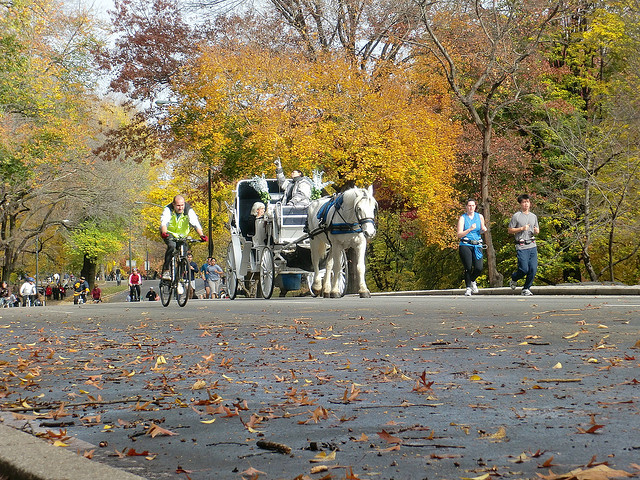

In [8]:
print(train_captions[0])
Image.open(img_name_vector[0])

## Preprocess the images using InceptionV3
Next, you will use InceptionV3 (which is pretrained on Imagenet) to classify each image. You will extract features from the last convolutional layer.

First, you will convert the images into InceptionV3's expected format by:
* Resizing the image to 299px by 299px
* [Preprocess the images](https://cloud.google.com/tpu/docs/inception-v3-advanced#preprocessing_stage) using the [preprocess_input](https://www.tensorflow.org/api_docs/python/tf/keras/applications/inception_v3/preprocess_input) method to normalize the image so that it contains pixels in the range of -1 to 1, which matches the format of the images used to train InceptionV3.

In [9]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

## Initialize InceptionV3 and load the pretrained Imagenet weights

Now you'll create a tf.keras model where the output layer is the last convolutional layer in the InceptionV3 architecture. The shape of the output of this layer is ```8x8x2048```. You use the last convolutional layer because you are using attention in this example. You don't perform this initialization during training because it could become a bottleneck.

* You forward each image through the network and store the resulting vector in a dictionary (image_name --> feature_vector).
* After all the images are passed through the network, you save the dictionary to disk.


In [10]:
image_model = tf.keras.applications.InceptionV3(include_top=False,
                                                weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

## Caching the features extracted from InceptionV3

You will pre-process each image with InceptionV3 and cache the output to disk. Caching the output in RAM would be faster but also memory intensive, requiring 8 \* 8 \* 2048 floats per image. At the time of writing, this exceeds the memory limitations of Colab (currently 12GB of memory).

Performance could be improved with a more sophisticated caching strategy (for example, by sharding the images to reduce random access disk I/O), but that would require more code.

The caching will take about 10 minutes to run in Colab with a GPU. If you'd like to see a progress bar, you can: 

1. Install [tqdm](https://github.com/tqdm/tqdm):

    `!pip install tqdm`

2. Import tqdm:

    `from tqdm import tqdm`

3. Change the following line:

    `for img, path in image_dataset:`

    to:

    `for img, path in tqdm(image_dataset):`


In [11]:
# Get unique images
encode_train = sorted(set(img_name_vector))

# Feel free to change batch_size according to your system configuration
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(
  load_image, num_parallel_calls=tf.data.AUTOTUNE).batch(16)

for img, path in image_dataset:
  batch_features = image_features_extract_model(img)
  batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3]))

  for bf, p in zip(batch_features, path):
    path_of_feature = p.numpy().decode("utf-8")
    np.save(path_of_feature, bf.numpy())

## Preprocess and tokenize the captions

* First, you'll tokenize the captions (for example, by splitting on spaces). This gives us a  vocabulary of all of the unique words in the data (for example, "surfing", "football", and so on).
* Next, you'll limit the vocabulary size to the top 5,000 words (to save memory). You'll replace all other words with the token "UNK" (unknown).
* You then create word-to-index and index-to-word mappings.
* Finally, you pad all sequences to be the same length as the longest one.

In [12]:
# Find the maximum length of any caption in the dataset
def calc_max_length(tensor):
    return max(len(t) for t in tensor)

In [13]:
# Choose the top 5000 words from the vocabulary
top_k = 5000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                  oov_token="<unk>",
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~')
tokenizer.fit_on_texts(train_captions)

In [14]:
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

In [15]:
# Create the tokenized vectors
train_seqs = tokenizer.texts_to_sequences(train_captions)

In [16]:
# Pad each vector to the max_length of the captions
# If you do not provide a max_length value, pad_sequences calculates it automatically
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')

In [17]:
# Calculates the max_length, which is used to store the attention weights
max_length = calc_max_length(train_seqs)

## Split the data into training and testing

In [18]:
img_to_cap_vector = collections.defaultdict(list)
for img, cap in zip(img_name_vector, cap_vector):
  img_to_cap_vector[img].append(cap)

# Create training and validation sets using an 80-20 split randomly.
img_keys = list(img_to_cap_vector.keys())
random.shuffle(img_keys)

slice_index = int(len(img_keys)*0.8)
img_name_train_keys, img_name_val_keys = img_keys[:slice_index], img_keys[slice_index:]

img_name_train = []
cap_train = []
for imgt in img_name_train_keys:
  capt_len = len(img_to_cap_vector[imgt])
  img_name_train.extend([imgt] * capt_len)
  cap_train.extend(img_to_cap_vector[imgt])

img_name_val = []
cap_val = []
for imgv in img_name_val_keys:
  capv_len = len(img_to_cap_vector[imgv])
  img_name_val.extend([imgv] * capv_len)
  cap_val.extend(img_to_cap_vector[imgv])

In [19]:
len(img_name_train), len(cap_train), len(img_name_val), len(cap_val)

(24007, 24007, 6003, 6003)

## Create a tf.data dataset for training


Your images and captions are ready! Next, let's create a `tf.data` dataset to use for training your model.

In [20]:
# Feel free to change these parameters according to your system's configuration

BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
vocab_size = top_k + 1
num_steps = len(img_name_train) // BATCH_SIZE
# Shape of the vector extracted from InceptionV3 is (64, 2048)
# These two variables represent that vector shape
features_shape = 2048
attention_features_shape = 64

In [21]:
# Load the numpy files
def map_func(img_name, cap):
  img_tensor = np.load(img_name.decode('utf-8')+'.npy')
  return img_tensor, cap

In [22]:
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

# Use map to load the numpy files in parallel
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.AUTOTUNE)

# Shuffle and batch
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

## Model

Fun fact: the decoder below is identical to the one in the example for [Neural Machine Translation with Attention](../sequences/nmt_with_attention.ipynb).

The model architecture is inspired by the [Show, Attend and Tell](https://arxiv.org/pdf/1502.03044.pdf) paper.

* In this example, you extract the features from the lower convolutional layer of InceptionV3 giving us a vector of shape (8, 8, 2048).
* You squash that to a shape of (64, 2048).
* This vector is then passed through the CNN Encoder (which consists of a single Fully connected layer).
* The RNN (here GRU) attends over the image to predict the next word.

In [23]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, features, hidden):
    # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)

    # hidden shape == (batch_size, hidden_size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
    hidden_with_time_axis = tf.expand_dims(hidden, 1)

    # attention_hidden_layer shape == (batch_size, 64, units)
    attention_hidden_layer = (tf.nn.tanh(self.W1(features) +
                                         self.W2(hidden_with_time_axis)))

    # score shape == (batch_size, 64, 1)
    # This gives you an unnormalized score for each image feature.
    score = self.V(attention_hidden_layer)

    # attention_weights shape == (batch_size, 64, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [24]:
class CNN_Encoder(tf.keras.Model):
    # Since you have already extracted the features and dumped it
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

In [25]:
class RNN_Decoder(tf.keras.Model):
  def __init__(self, embedding_dim, units, vocab_size):
    super(RNN_Decoder, self).__init__()
    self.units = units

    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc1 = tf.keras.layers.Dense(self.units)
    self.fc2 = tf.keras.layers.Dense(vocab_size)

    self.attention = BahdanauAttention(self.units)

  def call(self, x, features, hidden):
    # defining attention as a separate model
    context_vector, attention_weights = self.attention(features, hidden)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # shape == (batch_size, max_length, hidden_size)
    x = self.fc1(output)

    # x shape == (batch_size * max_length, hidden_size)
    x = tf.reshape(x, (-1, x.shape[2]))

    # output shape == (batch_size * max_length, vocab)
    x = self.fc2(x)

    return x, state, attention_weights

  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))

In [26]:
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size)

In [27]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')


def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

## Checkpoint

In [28]:
checkpoint_path = "./checkpoints/train"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer=optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [29]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
  start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
  # restoring the latest checkpoint in checkpoint_path
  ckpt.restore(ckpt_manager.latest_checkpoint)

## Training

* You extract the features stored in the respective `.npy` files and then pass those features through the encoder.
* The encoder output, hidden state(initialized to 0) and the decoder input (which is the start token) is passed to the decoder.
* The decoder returns the predictions and the decoder hidden state.
* The decoder hidden state is then passed back into the model and the predictions are used to calculate the loss.
* Use teacher forcing to decide the next input to the decoder.
* Teacher forcing is the technique where the target word is passed as the next input to the decoder.
* The final step is to calculate the gradients and apply it to the optimizer and backpropagate.


In [30]:
# adding this in a separate cell because if you run the training cell
# many times, the loss_plot array will be reset
loss_plot = []

In [31]:
@tf.function
def train_step(img_tensor, target):
  loss = 0

  # initializing the hidden state for each batch
  # because the captions are not related from image to image
  hidden = decoder.reset_state(batch_size=target.shape[0])

  dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

  with tf.GradientTape() as tape:
      features = encoder(img_tensor)

      for i in range(1, target.shape[1]):
          # passing the features through the decoder
          predictions, hidden, _ = decoder(dec_input, features, hidden)

          loss += loss_function(target[:, i], predictions)

          # using teacher forcing
          dec_input = tf.expand_dims(target[:, i], 1)

  total_loss = (loss / int(target.shape[1]))

  trainable_variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, trainable_variables)

  optimizer.apply_gradients(zip(gradients, trainable_variables))

  return loss, total_loss

In [32]:
EPOCHS = 20

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            average_batch_loss = batch_loss.numpy()/int(target.shape[1])
            print(f'Epoch {epoch+1} Batch {batch} Loss {average_batch_loss:.4f}')
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)

    if epoch % 5 == 0:
      ckpt_manager.save()

    print(f'Epoch {epoch+1} Loss {total_loss/num_steps:.6f}')
    print(f'Time taken for 1 epoch {time.time()-start:.2f} sec\n')

Epoch 1 Batch 0 Loss 1.8796


Epoch 1 Batch 100 Loss 1.0611


Epoch 1 Batch 200 Loss 0.9542


Epoch 1 Batch 300 Loss 0.8254


Epoch 1 Loss 0.992314
Time taken for 1 epoch 126.13 sec



Epoch 2 Batch 0 Loss 0.7968


Epoch 2 Batch 100 Loss 0.7996


Epoch 2 Batch 200 Loss 0.7158


Epoch 2 Batch 300 Loss 0.7288


Epoch 2 Loss 0.748699
Time taken for 1 epoch 45.47 sec



Epoch 3 Batch 0 Loss 0.6649


Epoch 3 Batch 100 Loss 0.7189


Epoch 3 Batch 200 Loss 0.6820


Epoch 3 Batch 300 Loss 0.6824


Epoch 3 Loss 0.675341
Time taken for 1 epoch 45.28 sec



Epoch 4 Batch 0 Loss 0.6879


Epoch 4 Batch 100 Loss 0.6273


Epoch 4 Batch 200 Loss 0.6034


Epoch 4 Batch 300 Loss 0.5976


Epoch 4 Loss 0.627637
Time taken for 1 epoch 45.38 sec



Epoch 5 Batch 0 Loss 0.6521


Epoch 5 Batch 100 Loss 0.5546


Epoch 5 Batch 200 Loss 0.6110


Epoch 5 Batch 300 Loss 0.5459


Epoch 5 Loss 0.588827
Time taken for 1 epoch 45.31 sec



Epoch 6 Batch 0 Loss 0.6166


Epoch 6 Batch 100 Loss 0.5597


Epoch 6 Batch 200 Loss 0.5404


Epoch 6 Batch 300 Loss 0.5238


Epoch 6 Loss 0.554796
Time taken for 1 epoch 45.37 sec



Epoch 7 Batch 0 Loss 0.5555


Epoch 7 Batch 100 Loss 0.5376


Epoch 7 Batch 200 Loss 0.5074


Epoch 7 Batch 300 Loss 0.5178


Epoch 7 Loss 0.526063
Time taken for 1 epoch 45.13 sec



Epoch 8 Batch 0 Loss 0.5621


Epoch 8 Batch 100 Loss 0.5501


Epoch 8 Batch 200 Loss 0.4988


Epoch 8 Batch 300 Loss 0.4816


Epoch 8 Loss 0.498434
Time taken for 1 epoch 45.46 sec



Epoch 9 Batch 0 Loss 0.5190


Epoch 9 Batch 100 Loss 0.4497


Epoch 9 Batch 200 Loss 0.4387


Epoch 9 Batch 300 Loss 0.4746


Epoch 9 Loss 0.472252
Time taken for 1 epoch 45.11 sec



Epoch 10 Batch 0 Loss 0.4210


Epoch 10 Batch 100 Loss 0.4277


Epoch 10 Batch 200 Loss 0.4565


Epoch 10 Batch 300 Loss 0.4667


Epoch 10 Loss 0.449122
Time taken for 1 epoch 45.33 sec



Epoch 11 Batch 0 Loss 0.4461


Epoch 11 Batch 100 Loss 0.4586


Epoch 11 Batch 200 Loss 0.4241


Epoch 11 Batch 300 Loss 0.4514


Epoch 11 Loss 0.426513
Time taken for 1 epoch 45.27 sec



Epoch 12 Batch 0 Loss 0.4530


Epoch 12 Batch 100 Loss 0.4214


Epoch 12 Batch 200 Loss 0.3708


Epoch 12 Batch 300 Loss 0.3781


Epoch 12 Loss 0.404405
Time taken for 1 epoch 45.30 sec



Epoch 13 Batch 0 Loss 0.4464


Epoch 13 Batch 100 Loss 0.3707


Epoch 13 Batch 200 Loss 0.3778


Epoch 13 Batch 300 Loss 0.3981


Epoch 13 Loss 0.383313
Time taken for 1 epoch 45.23 sec



Epoch 14 Batch 0 Loss 0.3704


Epoch 14 Batch 100 Loss 0.3440


Epoch 14 Batch 200 Loss 0.3498


Epoch 14 Batch 300 Loss 0.3383


Epoch 14 Loss 0.363366
Time taken for 1 epoch 45.32 sec



Epoch 15 Batch 0 Loss 0.3235


Epoch 15 Batch 100 Loss 0.3858


Epoch 15 Batch 200 Loss 0.3345


Epoch 15 Batch 300 Loss 0.3529


Epoch 15 Loss 0.345693
Time taken for 1 epoch 45.20 sec



Epoch 16 Batch 0 Loss 0.3293


Epoch 16 Batch 100 Loss 0.3425


Epoch 16 Batch 200 Loss 0.3175


Epoch 16 Batch 300 Loss 0.3325


Epoch 16 Loss 0.328574
Time taken for 1 epoch 45.36 sec



Epoch 17 Batch 0 Loss 0.3453


Epoch 17 Batch 100 Loss 0.2811


Epoch 17 Batch 200 Loss 0.3416


Epoch 17 Batch 300 Loss 0.3124


Epoch 17 Loss 0.312082
Time taken for 1 epoch 45.16 sec



Epoch 18 Batch 0 Loss 0.3118


Epoch 18 Batch 100 Loss 0.3097


Epoch 18 Batch 200 Loss 0.3124


Epoch 18 Batch 300 Loss 0.2979


Epoch 18 Loss 0.299489
Time taken for 1 epoch 45.16 sec



Epoch 19 Batch 0 Loss 0.3163


Epoch 19 Batch 100 Loss 0.2826


Epoch 19 Batch 200 Loss 0.2927


Epoch 19 Batch 300 Loss 0.2499


Epoch 19 Loss 0.282554
Time taken for 1 epoch 45.73 sec



Epoch 20 Batch 0 Loss 0.2566


Epoch 20 Batch 100 Loss 0.2920


Epoch 20 Batch 200 Loss 0.2928


Epoch 20 Batch 300 Loss 0.2500


Epoch 20 Loss 0.269615
Time taken for 1 epoch 45.21 sec



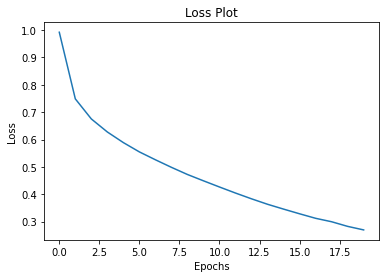

In [33]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

## Caption!

* The evaluate function is similar to the training loop, except you don't use teacher forcing here. The input to the decoder at each time step is its previous predictions along with the hidden state and the encoder output.
* Stop predicting when the model predicts the end token.
* And store the attention weights for every time step.

In [34]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0],
                                                 -1,
                                                 img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input,
                                                         features,
                                                         hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [35]:
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for i in range(len_result):
        temp_att = np.resize(attention_plot[i], (8, 8))
        grid_size = max(np.ceil(len_result/2), 2)
        ax = fig.add_subplot(grid_size, grid_size, i+1)
        ax.set_title(result[i])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

Real Caption: <start> a boy smiling over a birthday cake on a kitchen counter <end>
Prediction Caption: an object is holding sushi milk and a giant cake <end>


/home/kbuilder/.local/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  # Remove the CWD from sys.path while we load stuff.


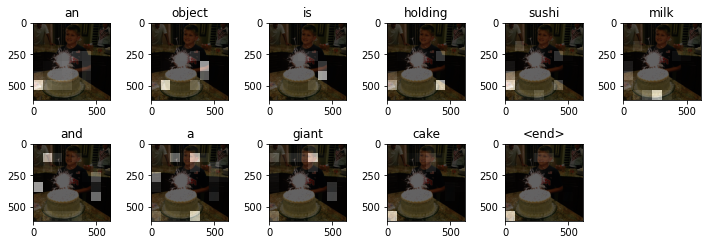

In [36]:
# captions on the validation set
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
real_caption = ' '.join([tokenizer.index_word[i]
                        for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)

print('Real Caption:', real_caption)
print('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)

## Try it on your own images

For fun, below you're provided a method you can use to caption your own images with the model you've just trained. Keep in mind, it was trained on a relatively small amount of data, and your images may be different from the training data (so be prepared for weird results!)


 8192/64400 [==>...........................] - ETA: 0s

16384/64400 [======>.......................] - ETA: 0s

32768/64400 [==============>...............] - ETA: 0s

49152/64400 [=====================>........] - ETA: 0s

65536/64400 [==============================] - 0s 4us/step


Prediction Caption: a surfer is in the waves on a low wave <end>


/home/kbuilder/.local/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  # Remove the CWD from sys.path while we load stuff.


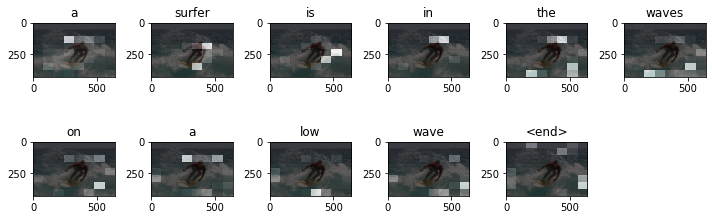

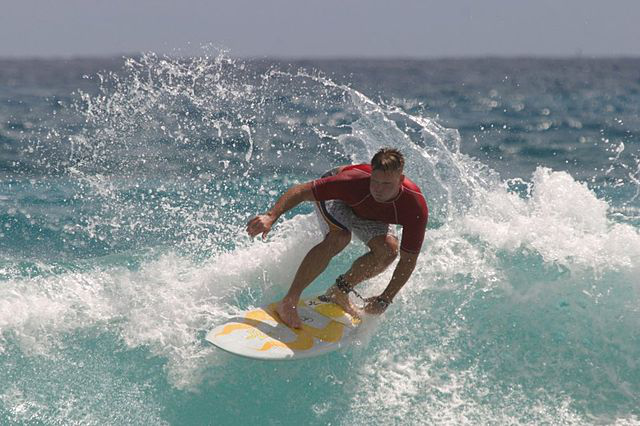

In [37]:
image_url = 'https://tensorflow.org/images/surf.jpg'
image_extension = image_url[-4:]
image_path = tf.keras.utils.get_file('image'+image_extension, origin=image_url)

result, attention_plot = evaluate(image_path)
print('Prediction Caption:', ' '.join(result))
plot_attention(image_path, result, attention_plot)
# opening the image
Image.open(image_path)

# Next steps

Congrats! You've just trained an image captioning model with attention. Next, take a look at this example [Neural Machine Translation with Attention](../sequences/nmt_with_attention.ipynb). It uses a similar architecture to translate between Spanish and English sentences. You can also experiment with training the code in this notebook on a different dataset.